### Imports

In [1]:
import os
import pandas as pd
import hashlib
import requests
import tarfile
from concurrent.futures import ThreadPoolExecutor, as_completed
from pathlib import Path
from tqdm import tqdm
from PIL import Image
import random
from functools import lru_cache
import sys
from itertools import combinations

import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers, Model, Input
from tensorflow.keras.preprocessing import image_dataset_from_directory
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, precision_score
from sklearn.model_selection import train_test_split
import shutil
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam

import joblib
from multiprocessing import cpu_count

# Ativar a GPU se disponível
print("GPU disponível?" , tf.config.list_physical_devices('GPU'))

base_dir = Path(os.getcwd()).resolve().parent
base_dir

2025-06-14 22:06:53.707291: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-14 22:06:56.236494: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749938816.303944     716 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749938816.321591     716 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749938811.368666     716 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

GPU disponível? [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


PosixPath('/workspaces/APVC/APVC-ProjetoFinal')

In [2]:
SEED = 777
def set_seed(seed=777):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed(SEED)

In [3]:
data_dir = base_dir / 'data'
data_dir.mkdir(parents=True, exist_ok=True)
data_dir

PosixPath('/workspaces/APVC/APVC-ProjetoFinal/data')

## 1. Preparar os dados

In [4]:
import os
from collections import Counter

# Define o caminho para o diretório train
train_dir = data_dir / 'train'

# Lista para armazenar todas as classes encontradas
classes = []

# Percorre todos os arquivos em todas as subpastas
for root, dirs, files in os.walk(train_dir):
    parts = root.split('_')
    
    # Verifica se o arquivo segue o padrão esperado (pelo menos 3 partes)
    if len(parts) >= 3:
        classe = parts[-2]  # A classe é o segundo elemento
        classes.append(classe)

# Conta a ocorrência de cada classe
class_counts = Counter(classes)

# Exibe os resultados
print("Contagem de documentos por classe:")
for classe, count in class_counts.most_common():
    print(f"{classe}: {count} monumentos")

# Opcional: exibe o total de classes únicas
print(f"\nTotal de classes únicas: {len(class_counts)}")

Contagem de documentos por classe:
Igreja: 207 monumentos
Castelo: 112 monumentos
Pelourinho: 42 monumentos
Mosteiro: 37 monumentos
Ponte: 35 monumentos
Capela: 35 monumentos
Convento: 31 monumentos
Museu: 30 monumentos
Palacio: 27 monumentos
Anta: 25 monumentos
Farol: 25 monumentos
Chafariz: 24 monumentos
Praia: 22 monumentos
Forte: 22 monumentos
Cruzeiro: 21 monumentos
Casa: 20 monumentos
Torre: 19 monumentos
Castro: 15 monumentos
Jardim: 15 monumentos
Santuario: 15 monumentos
Muralhas: 10 monumentos
Aqueduto: 9 monumentos
Lagoa: 9 monumentos
Basilica: 8 monumentos
Praca: 8 monumentos
Ermida: 7 monumentos
Fonte: 7 monumentos
Padrao: 7 monumentos
Tumulo: 7 monumentos
Catedral: 6 monumentos
Dolmen: 6 monumentos
Elevador: 6 monumentos
Ruinas: 6 monumentos
Teatro: 6 monumentos
Arco: 5 monumentos
Quinta: 5 monumentos
Menir: 5 monumentos
Monumento: 5 monumentos
Cabo: 4 monumentos
Cerca: 4 monumentos
Fortaleza: 4 monumentos
Lapide: 4 monumentos
Citania: 3 monumentos
Gruta: 3 monumentos
Hosp

## 2. Primeiro Modelo - [Património Edificados em Portugal](https://pt.wikipedia.org/wiki/Lista_de_patrim%C3%B3nio_edificado_em_Portugal)

### 2.1. Preparação dos dados

In [ ]:
# https://pt.wikipedia.org/wiki/Lista_de_patrim%C3%B3nio_edificado_em_Portugal

classe_para_tipologia = {
    # Castelos
    "Castelo": "Castelos",
    
    # Castros
    "Castro": "Castros",
    "Citania": "Castros",
    
    # Cruzeiros
    "Cruzeiro": "Cruzeiros",
    
    # Edificios de arquitectura civil
    "Casa": "Edificios_de_arquitectura_civil",
    "Museu": "Edificios_de_arquitectura_civil",
    "Teatro": "Edificios_de_arquitectura_civil",
    "Hospital": "Edificios_de_arquitectura_civil",
    "Elevador": "Edificios_de_arquitectura_civil",
    
    # Fortalezas
    "Forte": "Fortalezas",
    "Fortaleza": "Fortalezas",
    "Muralhas": "Fortalezas",
    
    # Patrimonio religioso
    "Igreja": "Patrimonio_religioso",
    "Capela": "Patrimonio_religioso",
    "Mosteiro": "Patrimonio_religioso",
    "Convento": "Patrimonio_religioso",
    "Santuario": "Patrimonio_religioso",
    "Catedral": "Patrimonio_religioso",
    "Ermida": "Patrimonio_religioso",
    "Basilica": "Patrimonio_religioso",
    "Padrao": "Patrimonio_religioso",

    # Marcos de milha e cruzamento - Acho que não temos nada deste
    
    # Monumentos megaliticos
    "Anta": "Monumentos_megaliticos",
    "Dolmen": "Monumentos_megaliticos",
    "Menir": "Monumentos_megaliticos",
    "Tumulo": "Monumentos_megaliticos",
    "Gruta": "Monumentos_megaliticos",
    
    # Palacios
    "Palacio": "Palacios",
    
    # Pelourinhos
    "Pelourinho": "Pelourinhos",
    
    # Pontes
    "Ponte": "Pontes",
    "Aqueduto": "Pontes",  # pode ser discutível
    
    # Quintas classificadas
    "Quinta": "Quintas_classificadas",
    
    # Edificacoes romanas
    "Termas": "Edificacoes_romanas",
    "Ruinas": "Edificacoes_romanas",
    "Arco": "Edificacoes_romanas",
    
    # Torres
    "Torre": "Torres"
}


In [8]:
# === Diretórios ===
train_dir1 = data_dir / "TrainModel1"

# === Função para normalizar ===
def normaliza_nome(nome):
    return nome.lower().replace('á', 'a').replace('ã', 'a').replace('ç', 'c')\
                       .replace('é', 'e').replace('í', 'i').replace('ú', 'u')

# === Função de cópia segura ===
def is_valid_and_copy(file_path, dst):
    try:
        img = tf.io.read_file(str(file_path))
        tf.image.decode_jpeg(img, channels=3)
        shutil.copy2(file_path, dst)
    except tf.errors.InvalidArgumentError:
        print(f"Arquivo JPEG inválido ignorado: {file_path}")

# === Funções utilitárias ===
def copy_valid_images_to_tipologia(src_dir, dst_base, classe_para_tipologia):
    valid_extensions = ('.jpg', '.jpeg', '.png')
    all_files = list(Path(src_dir).rglob("*"))

    valid_files = [
        f for f in all_files if f.is_file() and f.suffix.lower() in valid_extensions
    ]

    def process_file(file_path):
        pasta_classe = file_path.parent.name
        classe = normaliza_nome(pasta_classe).capitalize()
        classe = classe.split('_')[-2]  # Pega apenas a primeira parte, se houver mais de uma palavra

        for original_classe, tipologia in classe_para_tipologia.items():
            if normaliza_nome(original_classe) == classe:
                destino = dst_base / tipologia
                destino.mkdir(parents=True, exist_ok=True)
                is_valid_and_copy(file_path, destino)
                break

    with ThreadPoolExecutor(max_workers=15) as executor:
        list(tqdm(executor.map(process_file, valid_files),
                  total=len(valid_files),
                  desc="A copiar imagens para tipologias"))

# === Execução ===
if train_dir1.exists() and any(train_dir1.iterdir()):
    print(f"Diretório de destino já existe e não está vazio: {train_dir1}, a ignorar todo o processo.")
else:
    train_dir1.mkdir(parents=True, exist_ok=True)
    copy_valid_images_to_tipologia(train_dir, train_dir1, classe_para_tipologia)

Diretório de destino já existe e não está vazio: /workspaces/APVC/APVC-ProjetoFinal/data/TrainModel1, a ignorar todo o processo.


As tipologias encontram-se muito desequilibradas, é necessário arranjar alguma forma de as equilibrar

In [7]:
from collections import defaultdict

def obter_classes_a_ignorar(base_dir, minimo_imagens):
    contagem = defaultdict(int)
    valid_extensions = ('.jpg', '.jpeg', '.png')
    classes_a_ignorar = {}

    print("\n=== Contagem de imagens por tipologia ===")
    
    for pasta in base_dir.iterdir():
        if pasta.is_dir():
            num_imagens = sum(1 for f in pasta.glob("*") if f.suffix.lower() in valid_extensions)
            if num_imagens > minimo_imagens:
                contagem[pasta.name] = num_imagens
                print(f"{pasta.name}: {num_imagens} imagens")
            
            if num_imagens <= minimo_imagens:
                classes_a_ignorar[pasta.name] = num_imagens

    print(f"\n=== Tipologias a ignorar (menos de {minimo_imagens} imagens) ===")
    for tip in classes_a_ignorar.items():
        print(f"- {tip[0]}: {tip[1]} imagens")
    
    return list(classes_a_ignorar.keys())

classes_ignorar = obter_classes_a_ignorar(train_dir1, minimo_imagens=300)


=== Contagem de imagens por tipologia ===
Castelos: 7609 imagens
Castros: 459 imagens
Edificacoes_romanas: 587 imagens
Edificios_de_arquitectura_civil: 1749 imagens
Fortalezas: 1547 imagens
Monumentos_megaliticos: 357 imagens
Palacios: 1874 imagens
Patrimonio_religioso: 9860 imagens
Pelourinhos: 370 imagens
Pontes: 2193 imagens
Torres: 799 imagens

=== Tipologias a ignorar (menos de 300 imagens) ===
- Cruzeiros: 196 imagens
- Quintas_classificadas: 85 imagens


Vamos ignorar as tipologias com menos de 300 imagens, pois são muito poucas

- Selecionar as imagens mais representativas como undersamplig: 
    + https://arxiv.org/abs/1708.00489
    + https://arxiv.org/abs/1905.11946
    + https://www.mdpi.com/2673-2688/1/2/14

In [8]:
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.cluster import KMeans
from PIL import Image
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

# --- Funções auxiliares ---

def carregar_imagem(caminho, tamanho_imagem=(224, 224)):
    try:
        img = Image.open(caminho).convert('RGB')
        img = img.resize(tamanho_imagem)
        img_array = np.array(img, dtype=np.float32) / 255.0  # float32 para poupar RAM
        return img_array
    except Exception as e:
        print(f"Erro ao carregar {caminho}: {e}")
        return None

def carregar_imagens_de_pasta_parallel(pasta_path, max_imagens=None, tamanho_imagem=(224, 224), max_workers=15):
    caminhos = [f for f in pasta_path.iterdir() if f.suffix.lower() in ['.jpg', '.jpeg', '.png']]
    if max_imagens:
        caminhos = caminhos[:max_imagens]

    imagens = []
    caminhos_validos = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(carregar_imagem, caminho, tamanho_imagem) for caminho in caminhos]
        for i, future in enumerate(tqdm(as_completed(futures), total=len(futures), desc="A carregar imagens em paralelo")):
            img = future.result()
            if img is not None:
                imagens.append(img)
                caminhos_validos.append(caminhos[i])
    return np.array(imagens), caminhos_validos

base_model = tf.keras.applications.EfficientNetB0(include_top=False, pooling='avg', weights='imagenet')

def extrair_features(imagens, batch_size=32):
    imagens_pp = tf.keras.applications.efficientnet.preprocess_input(imagens * 255)
    features = []
    for i in tqdm(range(0, len(imagens_pp), batch_size), desc="A extrair features"):
        batch = imagens_pp[i:i+batch_size]
        batch_features = base_model.predict(batch, verbose=0)
        features.append(batch_features)
    return np.vstack(features)

def selecionar_representativas(features, proporcao):
    k = max(1, int(len(features) * proporcao))
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features)

    selected_indices = []
    for i in range(k):
        cluster_center = kmeans.cluster_centers_[i]
        cluster_indices = np.where(kmeans.labels_ == i)[0]
        cluster_features = features[cluster_indices]
        distancias = np.linalg.norm(cluster_features - cluster_center, axis=1)
        closest_index = cluster_indices[np.argmin(distancias)]
        selected_indices.append(closest_index)
    return selected_indices

def mostrar_e_guardar_figura(imagens, selected_indices, caminhos_imagens, pasta_guardar, label, num_to_show=10):
    all_indices = set(range(len(imagens)))
    not_selected = list(all_indices - set(selected_indices))
    selected_to_show = selected_indices[:num_to_show]
    not_selected_to_show = not_selected[:num_to_show]

    plt.figure(figsize=(20, 5))

    for i, idx in enumerate(selected_to_show):
        plt.subplot(2, num_to_show, i + 1)
        plt.imshow(imagens[idx])
        plt.axis('off')
        plt.title('Representativa')

    for i, idx in enumerate(not_selected_to_show):
        plt.subplot(2, num_to_show, num_to_show + i + 1)
        plt.imshow(imagens[idx])
        plt.axis('off')
        plt.title('Não representativa')

    plt.tight_layout()

    pasta_guardar.mkdir(parents=True, exist_ok=True)
    caminho_figura = pasta_guardar / f'{label}_representativas_vs_nao.png'
    plt.savefig(caminho_figura)
    plt.close()

    print(f"Figura guardada em: {caminho_figura}")

def classes_para_tratar_por_numero_imagens(train_dir, extensoes=('.jpg', '.jpeg', '.png')):
    classes_info = []
    for pasta in train_dir.iterdir():
        if pasta.is_dir():
            num_imagens = len([f for f in pasta.iterdir() if f.suffix.lower() in extensoes])
            if num_imagens > 1000:
                classes_info.append((pasta, num_imagens))
    return classes_info

def apagar_imagens_nao_representativas(caminhos_imagens, selected_indices):
    all_indices = set(range(len(caminhos_imagens)))
    nao_selecionadas = list(all_indices - set(selected_indices))

    print(f"A apagar {len(nao_selecionadas)} imagens não representativas...")

    for idx in nao_selecionadas:
        try:
            os.remove(caminhos_imagens[idx])
        except Exception as e:
            print(f"Erro ao apagar {caminhos_imagens[idx]}: {e}")

# --- Execução principal ---

model1_dir = base_dir / 'notebooks' / 'model1'
model1_dir.mkdir(parents=True, exist_ok=True)

classes_info = classes_para_tratar_por_numero_imagens(train_dir1)

if not classes_info:
    print("Não existem classes com mais de 1000 imagens. Nenhum processamento efetuado.")
else:
    print(f"Classes a tratar ({len(classes_info)}): {[p[0].name for p in classes_info]}")

    for pasta_classe, num_imagens in classes_info:
        print(f"\nProcessando classe: {pasta_classe.name} com {num_imagens} imagens")

        # Definir proporção conforme o nº de imagens
        if num_imagens >= 5000:
            proporcao = 1/10
        elif 1000 < num_imagens < 5000:
            proporcao = 1/3
        else:
            proporcao = 0  # Não tratar, só para garantir

        if proporcao == 0:
            print(f"Classe {pasta_classe.name} tem menos de 1000 imagens, a ignorar.")
            continue

        imagens, caminhos_validos = carregar_imagens_de_pasta_parallel(pasta_classe, max_imagens=None)
        features = extrair_features(imagens)
        selected_indices = selecionar_representativas(features, proporcao=proporcao)

        mostrar_e_guardar_figura(imagens, selected_indices, caminhos_validos, model1_dir, pasta_classe.name, num_to_show=10)

        apagar_imagens_nao_representativas(caminhos_validos, selected_indices)

        print(f"Imagens não representativas apagadas da classe: {pasta_classe.name}")

Classes a tratar (6): ['Castelos', 'Edificios_de_arquitectura_civil', 'Fortalezas', 'Palacios', 'Patrimonio_religioso', 'Pontes']

Processando classe: Castelos com 7609 imagens


A carregar imagens em paralelo:  83%|████████▎ | 6316/7609 [01:03<00:12, 99.72it/s] c:\Users\diogo\Desktop\APVC\.venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (109527305 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
A extrair features: 100%|██████████| 238/238 [00:46<00:00,  5.07it/s]


Figura guardada em: C:\Users\diogo\Desktop\APVC\APVC-ProjetoFinal\notebooks\model1\Castelos_representativas_vs_nao.png
A apagar 6849 imagens não representativas...
Imagens não representativas apagadas da classe: Castelos

Processando classe: Edificios_de_arquitectura_civil com 1749 imagens


A extrair features: 100%|██████████| 55/55 [00:10<00:00,  5.47it/s]


Figura guardada em: C:\Users\diogo\Desktop\APVC\APVC-ProjetoFinal\notebooks\model1\Edificios_de_arquitectura_civil_representativas_vs_nao.png
A apagar 1166 imagens não representativas...
Imagens não representativas apagadas da classe: Edificios_de_arquitectura_civil

Processando classe: Fortalezas com 1547 imagens


A carregar imagens em paralelo:  32%|███▏      | 501/1547 [00:04<00:08, 123.19it/s]c:\Users\diogo\Desktop\APVC\.venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (136052360 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
A carregar imagens em paralelo:  56%|█████▌    | 869/1547 [00:07<00:05, 132.18it/s]c:\Users\diogo\Desktop\APVC\.venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (136505920 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
A extrair features: 100%|██████████| 49/49 [00:08<00:00,  5.50it/s]


Figura guardada em: C:\Users\diogo\Desktop\APVC\APVC-ProjetoFinal\notebooks\model1\Fortalezas_representativas_vs_nao.png
A apagar 1032 imagens não representativas...
Imagens não representativas apagadas da classe: Fortalezas

Processando classe: Palacios com 1874 imagens


A extrair features: 100%|██████████| 59/59 [00:10<00:00,  5.38it/s]


Figura guardada em: C:\Users\diogo\Desktop\APVC\APVC-ProjetoFinal\notebooks\model1\Palacios_representativas_vs_nao.png
A apagar 1250 imagens não representativas...
Imagens não representativas apagadas da classe: Palacios

Processando classe: Patrimonio_religioso com 9860 imagens


A carregar imagens em paralelo:   4%|▎         | 347/9860 [00:02<01:20, 117.58it/s]c:\Users\diogo\Desktop\APVC\.venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
A carregar imagens em paralelo:  25%|██▌       | 2494/9860 [00:22<01:01, 120.10it/s]

Erro ao carregar C:\Users\diogo\Desktop\APVC\APVC-ProjetoFinal\data\TrainModel1\Patrimonio_religioso\008_045ad2186a54f08468c4531ca68c3040.jpg: broken data stream when reading image file


A carregar imagens em paralelo:  92%|█████████▏| 9088/9860 [01:31<00:07, 96.73it/s] c:\Users\diogo\Desktop\APVC\.venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (119296086 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
A carregar imagens em paralelo:  94%|█████████▍| 9254/9860 [01:33<00:08, 70.15it/s] c:\Users\diogo\Desktop\APVC\.venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (106777610 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
A carregar imagens em paralelo:  97%|█████████▋| 9533/9860 [01:36<00:04, 80.77it/s]c:\Users\diogo\Desktop\APVC\.venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (104308800 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
A extrair features: 100%|██████████| 309/309 [00:58<00:00,  5.30it/s]


Figura guardada em: C:\Users\diogo\Desktop\APVC\APVC-ProjetoFinal\notebooks\model1\Patrimonio_religioso_representativas_vs_nao.png
A apagar 8874 imagens não representativas...
Imagens não representativas apagadas da classe: Patrimonio_religioso

Processando classe: Pontes com 2193 imagens


A extrair features: 100%|██████████| 69/69 [00:12<00:00,  5.44it/s]


Figura guardada em: C:\Users\diogo\Desktop\APVC\APVC-ProjetoFinal\notebooks\model1\Pontes_representativas_vs_nao.png
A apagar 1462 imagens não representativas...
Imagens não representativas apagadas da classe: Pontes


#### 2.1.1. Data Augmentation

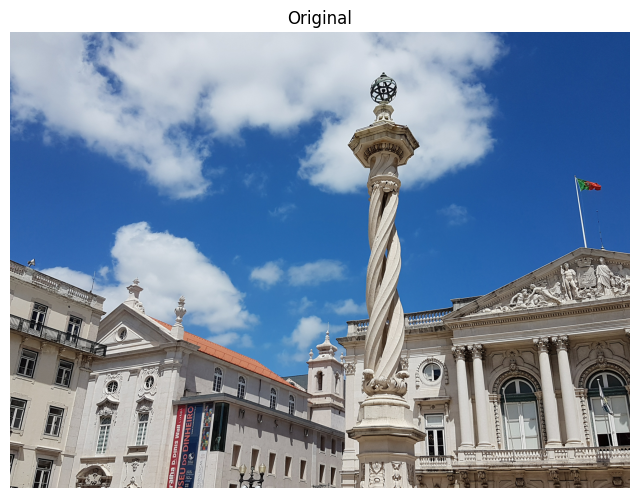

In [12]:
# Caminho para a imagem
img_path = train_dir1 / Path(r"Pelourinhos\044_600cf7e9772ad38a8de06776c00328fd.jpg")
data_dir

# Carregar a imagem
def load_image(path):
    img = tf.io.read_file(str(path))
    img = tf.image.decode_jpeg(img, channels=3)
    return img

original_image = load_image(img_path)

# Mostrar original
plt.figure(figsize=(8, 8))
plt.imshow(original_image)
plt.title("Original")
plt.axis('off')
plt.show()

In [14]:
# Augmentações customizadas com TensorFlow
def augment_image(image):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)

    # Flip horizontal aleatório (50%)
    image = tf.image.random_flip_left_right(image)

    # Zoom via crop + resize (escala entre 0.85 e 1)
    scale = tf.random.uniform([], 0.85, 1.0)
    h, w, c = tf.shape(image)[0], tf.shape(image)[1], tf.shape(image)[2]
    new_h = tf.cast(scale * tf.cast(h, tf.float32), tf.int32)
    new_w = tf.cast(scale * tf.cast(w, tf.float32), tf.int32)
    image = tf.image.random_crop(image, size=[new_h, new_w, c])
    image = tf.image.resize(image, [h, w])

    # Ajustes de cor
    image = tf.image.random_brightness(image, max_delta=0.15)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_saturation(image, 0.8, 1.2)
    image = tf.image.random_hue(image, 0.02)

    # Clipping para garantir valores entre 0 e 1
    image = tf.clip_by_value(image, 0.0, 1.0)

    return image

new_image = augment_image(original_image)

# Mostrar original
plt.figure(figsize=(8, 8))
plt.imshow(new_image)
plt.title("New")
plt.axis('off')
plt.show()

In [15]:
from uuid import uuid4

def gerar_e_guardar(img_path, label_path):
    try:
        # Carregar a imagem original com PIL (sem resize)
        img_pil = Image.open(img_path).convert('RGB')
        img_np = np.array(img_pil) / 255.0
        img_tf = tf.convert_to_tensor(img_np, dtype=tf.float32)

        img_aug = augment_image(img_tf)

        # Converter para uint8 e guardar
        img_out = (img_aug.numpy() * 255).astype(np.uint8)
        img_out_pil = Image.fromarray(img_out)
        novo_nome = label_path / f"aug_{uuid4().hex}.jpg"
        img_out_pil.save(novo_nome)
    except Exception as e:
        print(f"[ERRO] ao processar {img_path}: {e}")

def data_augmentation_para_classes_pequenas(train_dir1, classes_ignorar, proporcao_aumentar=1/3, max_workers=15, valormin = 400):
    train_dir1 = Path(train_dir1)
    labels = [p for p in train_dir1.iterdir() if p.is_dir() and p.name not in classes_ignorar]

    labels_pequenas = []
    for label_path in labels:
        imagens = list(label_path.glob('*.jpg')) + list(label_path.glob('*.jpeg')) + list(label_path.glob('*.png'))
        n_imagens = len(imagens)
        if n_imagens <= valormin:
            labels_pequenas.append((label_path, n_imagens))

    if all(n >= valormin for _, n in labels_pequenas):
        print(f"Nenhuma label com menos de {valormin} imagens. Nenhuma augmentação realizada.")
        return

    print(f"Labels com menos de {valormin} imagens: {[str(l[0].name) + ':' + str(l[1]) for l in labels_pequenas]}")

    for label_path, n_imagens in labels_pequenas:
        n_aug = int(n_imagens * proporcao_aumentar)
        if n_aug == 0:
            continue

        print(f"Gerando {n_aug} imagens augmentadas para a label '{label_path.name}' (original: {n_imagens})")
        imagens_paths = list(label_path.glob('*.jpg')) + list(label_path.glob('*.jpeg')) + list(label_path.glob('*.png'))
        imagens_paths = imagens_paths[:max(1, n_aug)]

        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            futures = [executor.submit(gerar_e_guardar, np.random.choice(imagens_paths), label_path) for _ in range(n_aug)]
            for _ in tqdm(as_completed(futures), total=n_aug, desc=f"Augmentando {label_path.name}"):
                pass

        print(f"Augmentação para label '{label_path.name}' concluída.")

# --- Executar Código da Redução Épica ---
data_augmentation_para_classes_pequenas(train_dir1, classes_ignorar, proporcao_aumentar=1/10)

Labels com menos de 400 imagens: ['Monumentos_megaliticos:357', 'Pelourinhos:370']
Gerando 35 imagens augmentadas para a label 'Monumentos_megaliticos' (original: 357)


Augmentando Monumentos_megaliticos: 100%|██████████| 35/35 [00:03<00:00, 10.32it/s]


Augmentação para label 'Monumentos_megaliticos' concluída.
Gerando 37 imagens augmentadas para a label 'Pelourinhos' (original: 370)


Augmentando Pelourinhos: 100%|██████████| 37/37 [00:06<00:00,  5.78it/s]

Augmentação para label 'Pelourinhos' concluída.


In [9]:
from collections import defaultdict

def obter_classes_a_ignorar(base_dir, minimo_imagens):
    contagem = defaultdict(int)
    valid_extensions = ('.jpg', '.jpeg', '.png')
    classes_a_ignorar = {}

    print("\n=== Contagem de imagens por tipologia ===")
    
    for pasta in base_dir.iterdir():
        if pasta.is_dir():
            num_imagens = sum(1 for f in pasta.glob("*") if f.suffix.lower() in valid_extensions)
            if num_imagens > minimo_imagens:
                contagem[pasta.name] = num_imagens
                print(f"{pasta.name}: {num_imagens} imagens")
            
            if num_imagens <= minimo_imagens:
                classes_a_ignorar[pasta.name] = num_imagens

    print(f"\n=== Tipologias a ignorar (menos de {minimo_imagens} imagens) ===")
    for tip in classes_a_ignorar.items():
        print(f"- {tip[0]}: {tip[1]} imagens")
    
    return list(classes_a_ignorar.keys())

classes_ignorar = obter_classes_a_ignorar(train_dir1, minimo_imagens=300)


=== Contagem de imagens por tipologia ===
Castelos: 760 imagens
Castros: 459 imagens
Edificacoes_romanas: 587 imagens
Edificios_de_arquitectura_civil: 583 imagens
Fortalezas: 515 imagens
Monumentos_megaliticos: 392 imagens
Palacios: 624 imagens
Patrimonio_religioso: 986 imagens
Pelourinhos: 407 imagens
Pontes: 731 imagens
Torres: 799 imagens

=== Tipologias a ignorar (menos de 300 imagens) ===
- Cruzeiros: 196 imagens
- Quintas_classificadas: 85 imagens


### 2.2. Modelling

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras import layers, models, regularizers, callbacks
from sklearn.metrics import f1_score
import tensorflow as tf
import numpy as np
import shutil
import time
from pathlib import Path

# ===============================
# 1. Definições iniciais
# ===============================
batch_size = 16
img_height = 224
img_width = 224
seed = 123
epochs = 30

model1_dir = base_dir / 'notebooks' / 'model1'
model1_dir.mkdir(parents=True, exist_ok=True)

# ===============================
# 2. Criação dos datasets
# ===============================
def create_datasets(train_dir1, classes_ignorar, temp_dir="__ignorar_temp__"):
    temp_dir = train_dir1.parent / temp_dir
    temp_dir.mkdir(exist_ok=True)

    for classe in classes_ignorar:
        origem = train_dir1 / classe
        destino = temp_dir / classe
        if origem.exists():
            shutil.move(str(origem), str(destino))

    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        str(train_dir1),
        validation_split=0.2,
        subset="training",
        seed=seed,
        image_size=(img_height, img_width),
        batch_size=batch_size
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        str(train_dir1),
        validation_split=0.2,
        subset="validation",
        seed=seed,
        image_size=(img_height, img_width),
        batch_size=batch_size
    )

    class_names = train_ds.class_names
    print("\nClasses encontradas:", class_names)

    for classe in classes_ignorar:
        origem = temp_dir / classe
        destino = train_dir1 / classe
        if origem.exists():
            shutil.move(str(origem), str(destino))

    return train_ds, val_ds, class_names

train_ds_full, val_ds, class_names = create_datasets(train_dir1, classes_ignorar)

# ===============================
# 3. Preprocessamento com EfficientNetB0 (sem resize extra)
# ===============================
def prepare(ds, shuffle=False):
    ds = ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(1000)
    return ds.prefetch(tf.data.AUTOTUNE)

train_ds = prepare(train_ds_full, shuffle=True)
val_ds = prepare(val_ds, shuffle=False)

# ===============================
# 4. Construção do modelo
# ===============================
def build_model():
    base_model = EfficientNetB0(include_top=False, input_shape=(img_height, img_width, 3), weights='imagenet')
    base_model.trainable = False  # congelar a base

    inputs = layers.Input(shape=(img_height, img_width, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(len(class_names), activation='softmax')(x)

    return models.Model(inputs, outputs)

model = build_model()

# ===============================
# 5. Callbacks e F1-Score Tracker
# ===============================

class F1ScoreTracker(callbacks.Callback):
    def __init__(self, train_data, val_data):
        super().__init__()
        self.train_data = train_data
        self.val_data = val_data
        self.train_f1_scores = []
        self.val_f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}

        def get_f1(data):
            y_true, y_pred = [], []
            for x_batch, y_batch in data:
                preds = np.argmax(self.model.predict(x_batch, verbose=1), axis=1)
                y_true.extend(y_batch.numpy())
                y_pred.extend(preds)
            return f1_score(y_true, y_pred, average='weighted')

        f1_train = get_f1(self.train_data)
        f1_val = get_f1(self.val_data)

        self.train_f1_scores.append(f1_train)
        self.val_f1_scores.append(f1_val)

        logs['f1_score'] = f1_train
        logs['val_f1_score'] = f1_val

        print(f" - f1_score: {f1_train:.4f} - val_f1_score: {f1_val:.4f}")

f1_tracker = F1ScoreTracker(train_ds, val_ds)

callbacks_list = [
    f1_tracker,
    callbacks.EarlyStopping(monitor='val_f1_score', patience=5, mode='max', restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor='val_f1_score', factor=0.2, patience=3, mode='max', verbose=1),
    callbacks.ModelCheckpoint(model1_dir / "best_model1.keras", monitor="val_f1_score", save_best_only=True, mode='max')
]

# ===============================
# 6. Compilar o modelo
# ===============================
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # learning rate mais baixo para transfer learning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Found 6843 files belonging to 11 classes.
Using 5475 files for training.


I0000 00:00:1749938863.504945     716 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9


Found 6843 files belonging to 11 classes.
Using 1368 files for validation.

Classes encontradas: ['Castelos', 'Castros', 'Edificacoes_romanas', 'Edificios_de_arquitectura_civil', 'Fortalezas', 'Monumentos_megaliticos', 'Palacios', 'Patrimonio_religioso', 'Pelourinhos', 'Pontes', 'Torres']


In [11]:
# Confirmar que há GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU(s) disponíveis: {[gpu.name for gpu in gpus]}")
else:
    print("❌ Nenhuma GPU detectada. O treino será feito na CPU.")

✅ GPU(s) disponíveis: ['/physical_device:GPU:0']


In [12]:
!nvidia-smi

Sat Jun 14 22:07:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.55.01              Driver Version: 576.40         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060        On  |   00000000:01:00.0  On |                  N/A |
|  0%   48C    P3            N/A  /  115W |    7237MiB /   8188MiB |     12%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [13]:
# ===============================
# 7. treinar
# ===============================

tf.debugging.set_log_device_placement(True)

start_time = time.time()
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
)
print(f"\nTreino concluído em {time.time() - start_time:.2f} segundos")

# Guardar f1_scores no history para facilitar os gráficos
history.history['f1_score'] = f1_tracker.train_f1_scores
history.history['val_f1_score'] = f1_tracker.val_f1_scores

# Guardar history em json
import json
with open(model1_dir / 'history.json', 'w') as f:
    json.dump(history.history, f)

Epoch 1/30


2025-06-14 22:08:04.503623: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 92 of 1000
2025-06-14 22:08:07.529170: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-06-14 22:08:24.526917: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 286 of 1000
2025-06-14 22:08:32.406056: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
I0000 00:00:1749938912.414841    1097 service.cc:152] XLA service 0x7fdda8002770 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749938912.414874    1097 service.cc:160]   StreamExecutor device (

110/343 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.1345 - loss: 2.3909

2025-06-14 22:08:52.622618: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-14 22:08:52.796912: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-14 22:08:53.343762: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-14 22:08:53.528467: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-14 22:08:54.214234: E external/local_xla/xla/stream_

342/343 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.2253 - loss: 2.2047

2025-06-14 22:09:04.976558: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2050', 4 bytes spill stores, 4 bytes spill loads

2025-06-14 22:09:05.263729: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2050_0', 200 bytes spill stores, 536 bytes spill loads

2025-06-14 22:09:05.340670: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2050', 116 bytes spill stores, 116 bytes spill loads

2025-06-14 22:09:05.716055: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2050', 5356 bytes spill stores, 5416 bytes spill loads

2025-06-14 22:09:05.810034: I ex

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


2025-06-14 22:10:09.734021: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2031', 12 bytes spill stores, 12 bytes spill loads

2025-06-14 22:10:09.877421: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2031', 8 bytes spill stores, 8 bytes spill loads

2025-06-14 22:10:09.983445: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2031', 112 bytes spill stores, 112 bytes spill loads

2025-06-14 22:10:10.093284: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2031_0', 184 bytes spill stores, 520 bytes spill loads

2025-06-14 22:10:10.176066: I extern

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━

2025-06-14 22:10:34.987916: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
2025-06-14 22:10:37.612483: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: pHYs: out of place


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━

2025-06-14 22:10:51.124558: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


343/343 ━━━━━━━━━━━━━━━━━━━━ 183s 373ms/step - accuracy: 0.2259 - loss: 2.2035 - val_accuracy: 0.5058 - val_loss: 1.5569 - f1_score: 0.5261 - val_f1_score: 0.4940 - learning_rate: 1.0000e-04
Epoch 2/30


2025-06-14 22:11:01.544700: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-06-14 22:11:01.849347: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 119 of 1000
Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-06-14 22:11:22.919692: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 293 of 1000
2025-06-14 22:11:25.919383: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


341/343 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4857 - loss: 1.5951

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
2025-06-14 22:11:35.575347: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: pHYs: out of place
2025-06-14 22:11:53.590241: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 96 of 1000
2025-06-14 22:11:53.707510: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Invalid SOS parameters for sequential JPEG
2025-06-14 22:12:03.336779: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 220 of 1000
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-06-14 22:12:19.615674: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ -5s -5047621us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


2025-06-14 22:12:46.532188: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: pHYs: out of place


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━

2025-06-14 22:12:53.303961: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


343/343 ━━━━━━━━━━━━━━━━━━━━ 122s 256ms/step - accuracy: 0.4858 - loss: 1.5946 - val_accuracy: 0.5534 - val_loss: 1.3476 - f1_score: 0.5882 - val_f1_score: 0.5423 - learning_rate: 1.0000e-04
Epoch 3/30


2025-06-14 22:13:04.097588: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 92 of 1000
2025-06-14 22:13:06.438331: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-06-14 22:13:24.324137: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 292 of 1000
2025-06-14 22:13:31.336039: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


342/343 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5284 - loss: 1.4401

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
2025-06-14 22:13:39.677328: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: pHYs: out of place
2025-06-14 22:13:57.050983: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 100 of 1000
2025-06-14 22:13:58.495120: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-06-14 22:14:16.622042: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 305 of 1000
2025-06-14 22:14:22.201230: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


2025-06-14 22:14:49.296564: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: pHYs: out of place


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━

2025-06-14 22:15:08.819329: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-06-14 22:15:09.961961: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 127 of 1000
Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-06-14 22:15:29.563989: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 296 of 1000


  1/343 ━━━━━━━━━━━━━━━━━━━━ 3:17:07 35s/step - accuracy: 0.7500 - loss: 0.9782

2025-06-14 22:15:33.619868: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


342/343 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5693 - loss: 1.3255

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
2025-06-14 22:15:40.637642: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: pHYs: out of place
2025-06-14 22:15:58.741504: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 99 of 1000
2025-06-14 22:15:58.941553: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Invalid SOS parameters for sequential JPEG
Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
2025-06-14 22:16:08.928751: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 212 of 1000
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-06-14 22:16:26.530916: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ -5s -5042982us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 

2025-06-14 22:16:52.617626: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: pHYs: out of place


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━

2025-06-14 22:17:00.062431: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


343/343 ━━━━━━━━━━━━━━━━━━━━ 126s 266ms/step - accuracy: 0.5693 - loss: 1.3254 - val_accuracy: 0.6001 - val_loss: 1.1956 - f1_score: 0.6596 - val_f1_score: 0.5966 - learning_rate: 1.0000e-04
Epoch 5/30


2025-06-14 22:17:14.837849: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 95 of 1000
2025-06-14 22:17:18.080539: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Invalid SOS parameters for sequential JPEG
2025-06-14 22:17:24.969935: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 220 of 1000
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-06-14 22:17:41.701224: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


339/343 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5827 - loss: 1.2703

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
2025-06-14 22:17:48.048119: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: pHYs: out of place
2025-06-14 22:18:04.801223: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 96 of 1000
2025-06-14 22:18:07.075729: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-06-14 22:18:25.149732: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 307 of 1000
2025-06-14 22:18:30.444580: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━

2025-06-14 22:18:57.218769: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: pHYs: out of place


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━

2025-06-14 22:19:17.153105: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-06-14 22:19:17.231493: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 128 of 1000
Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-06-14 22:19:37.516762: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 289 of 1000
2025-06-14 22:19:41.512961: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


342/343 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6155 - loss: 1.2077

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
2025-06-14 22:19:49.074144: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: pHYs: out of place
2025-06-14 22:20:08.148996: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-06-14 22:20:09.213589: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 126 of 1000
Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-06-14 22:20:28.976475: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 286 of 1000
2025-06-14 22:20:32.631138: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━

2025-06-14 22:21:00.033565: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: pHYs: out of place


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━

2025-06-14 22:21:21.521398: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 98 of 1000
2025-06-14 22:21:24.381437: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Invalid SOS parameters for sequential JPEG
2025-06-14 22:21:32.375050: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 220 of 1000
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-06-14 22:21:48.684401: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


342/343 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6212 - loss: 1.1523

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
2025-06-14 22:21:53.880761: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: pHYs: out of place
2025-06-14 22:22:12.831794: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 99 of 1000
2025-06-14 22:22:15.977853: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Invalid SOS parameters for sequential JPEG
2025-06-14 22:22:22.942629: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 215 of 1000
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-06-14 22:22:40.429930: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


2025-06-14 22:23:07.220980: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: pHYs: out of place


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━

2025-06-14 22:23:25.873301: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 99 of 1000
2025-06-14 22:23:28.526647: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-06-14 22:23:46.196964: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 285 of 1000
2025-06-14 22:23:53.303340: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


341/343 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6474 - loss: 1.1015

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
2025-06-14 22:24:01.533439: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: pHYs: out of place
2025-06-14 22:24:18.538520: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 90 of 1000
2025-06-14 22:24:21.050732: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-06-14 22:24:40.006379: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 271 of 1000
Invalid SOS parameters for sequential JPEG
2025-06-14 22:24:45.967240: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━

2025-06-14 22:25:12.728948: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: pHYs: out of place


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━

2025-06-14 22:25:22.394420: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


343/343 ━━━━━━━━━━━━━━━━━━━━ 127s 261ms/step - accuracy: 0.6474 - loss: 1.1015 - val_accuracy: 0.6396 - val_loss: 1.0771 - f1_score: 0.7272 - val_f1_score: 0.6384 - learning_rate: 1.0000e-04
Epoch 9/30


2025-06-14 22:25:34.499689: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 80 of 1000
2025-06-14 22:25:33.095646: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Invalid SOS parameters for sequential JPEG
2025-06-14 22:25:43.074957: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 219 of 1000
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-06-14 22:25:58.673997: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


 26/343 ━━━━━━━━━━━━━━━━━━━━ 35s 111ms/step - accuracy: 0.6595 - loss: 1.0314

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
2025-06-14 22:26:05.010751: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: pHYs: out of place
2025-06-14 22:26:23.533789: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 98 of 1000
2025-06-14 22:26:25.681507: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Invalid SOS parameters for sequential JPEG
2025-06-14 22:26:33.370058: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 219 of 1000
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-06-14 22:26:44.611303: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 294 of 1000
2025-06-14 22:26:50.314991: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


2025-06-14 22:27:17.850319: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: pHYs: out of place


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ -5s -4994678us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━

2025-06-14 22:27:33.584047: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 98 of 1000
2025-06-14 22:27:37.112772: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-06-14 22:27:53.460457: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 290 of 1000
2025-06-14 22:28:00.213397: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6533 - loss: 1.0659

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
2025-06-14 22:28:07.698120: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: pHYs: out of place
2025-06-14 22:28:24.061932: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 95 of 1000
2025-06-14 22:28:26.306701: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-06-14 22:28:44.235409: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 296 of 1000
2025-06-14 22:28:49.970892: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━

2025-06-14 22:29:16.533605: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: pHYs: out of place


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━

2025-06-14 22:29:36.187000: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 102 of 1000
2025-06-14 22:29:37.169579: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Invalid SOS parameters for sequential JPEG
2025-06-14 22:29:46.206719: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 220 of 1000
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-06-14 22:30:02.681384: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


110/343 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.6649 - loss: 1.0180

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
2025-06-14 22:30:08.595401: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: pHYs: out of place
2025-06-14 22:30:28.277514: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 93 of 1000
2025-06-14 22:30:30.712291: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Invalid SOS parameters for sequential JPEG
2025-06-14 22:30:38.352873: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 211 of 1000
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-06-14 22:30:56.719611: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


2025-06-14 22:31:24.204069: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: pHYs: out of place


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━

2025-06-14 22:31:40.355355: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 92 of 1000
2025-06-14 22:31:42.780815: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Invalid SOS parameters for sequential JPEG
Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-06-14 22:32:01.058888: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 307 of 1000
2025-06-14 22:32:05.726585: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


342/343 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6761 - loss: 1.0024

2025-06-14 22:32:13.353749: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: pHYs: out of place
Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
2025-06-14 22:32:31.346356: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-06-14 22:32:31.860001: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 127 of 1000
Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-06-14 22:32:51.131761: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 317 of 1000
2025-06-14 22:32:53.733054: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step

2025-06-14 22:33:20.153416: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: pHYs: out of place


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━

2025-06-14 22:33:41.838122: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 96 of 1000
2025-06-14 22:33:41.830703: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Invalid SOS parameters for sequential JPEG
Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
2025-06-14 22:33:51.902652: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 218 of 1000
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-06-14 22:34:08.403709: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


129/343 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.6827 - loss: 0.9857

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
2025-06-14 22:34:14.422263: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: pHYs: out of place
2025-06-14 22:34:32.477585: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 101 of 1000
2025-06-14 22:34:34.552470: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Invalid SOS parameters for sequential JPEG
2025-06-14 22:34:42.788870: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 220 of 1000
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-06-14 22:34:58.912538: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━

2025-06-14 22:35:26.473684: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: pHYs: out of place


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ -5s -4992992us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/

2025-06-14 22:35:46.330419: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 97 of 1000
2025-06-14 22:35:47.933575: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-06-14 22:36:05.717703: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 294 of 1000


 11/343 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.7552 - loss: 0.8552  

2025-06-14 22:36:12.347464: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


341/343 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6932 - loss: 0.9426

2025-06-14 22:36:19.993722: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: pHYs: out of place
Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
2025-06-14 22:36:37.837487: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 92 of 1000
2025-06-14 22:36:41.300284: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-06-14 22:36:57.488274: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 287 of 1000
Invalid SOS parameters for sequential JPEG
2025-06-14 22:37:04.923695: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


2025-06-14 22:37:30.764100: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: pHYs: out of place


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━

2025-06-14 22:37:52.954838: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 123 of 1000
2025-06-14 22:37:53.946225: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-06-14 22:38:12.969917: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 292 of 1000
2025-06-14 22:38:16.842999: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


340/343 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6984 - loss: 0.9281

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
2025-06-14 22:38:26.321929: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: pHYs: out of place
2025-06-14 22:38:43.092340: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 92 of 1000
2025-06-14 22:38:44.929760: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Invalid SOS parameters for sequential JPEG
2025-06-14 22:38:53.271312: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 215 of 1000
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-06-14 22:39:08.663219: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ -5s -5007068us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

2025-06-14 22:39:35.078660: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: pHYs: out of place


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━

2025-06-14 22:39:56.361782: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 98 of 1000
2025-06-14 22:39:59.557724: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-06-14 22:40:17.200825: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 299 of 1000
2025-06-14 22:40:23.002283: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


341/343 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7003 - loss: 0.9166

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
2025-06-14 22:40:31.740725: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: pHYs: out of place
2025-06-14 22:40:48.030404: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 101 of 1000
2025-06-14 22:40:50.146502: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-06-14 22:41:09.482599: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 289 of 1000
2025-06-14 22:41:15.955578: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


2025-06-14 22:41:42.922297: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: pHYs: out of place


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━

2025-06-14 22:41:56.471294: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


343/343 ━━━━━━━━━━━━━━━━━━━━ 126s 259ms/step - accuracy: 0.7003 - loss: 0.9165 - val_accuracy: 0.6696 - val_loss: 0.9794 - f1_score: 0.7985 - val_f1_score: 0.6691 - learning_rate: 1.0000e-04
Epoch 17/30


2025-06-14 22:42:02.505751: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 92 of 1000
2025-06-14 22:42:04.799572: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-06-14 22:42:23.897063: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 287 of 1000
2025-06-14 22:42:30.643490: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


341/343 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7180 - loss: 0.8767

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
2025-06-14 22:42:38.814811: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: pHYs: out of place
2025-06-14 22:42:57.820140: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-06-14 22:42:58.955539: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 127 of 1000
Invalid SOS parameters for sequential JPEG
Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-06-14 22:43:19.372780: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 330 of 1000
2025-06-14 22:43:21.113292: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step

2025-06-14 22:43:49.234111: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: pHYs: out of place


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

2025-06-14 22:44:12.764125: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 83 of 1000
2025-06-14 22:44:12.444200: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Invalid SOS parameters for sequential JPEG
2025-06-14 22:44:22.112552: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 225 of 1000
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-06-14 22:44:35.471043: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


342/343 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7059 - loss: 0.8851

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
2025-06-14 22:44:42.849852: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: pHYs: out of place
2025-06-14 22:45:02.146353: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 93 of 1000
2025-06-14 22:45:04.413061: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Invalid SOS parameters for sequential JPEG
2025-06-14 22:45:12.155361: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 223 of 1000
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-06-14 22:45:28.570565: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/

2025-06-14 22:46:02.871718: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: pHYs: out of place


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
 - f1_score: 0.8133 - val_f1_score: 0.6737
343/343 ━━━━━━━━━━━━━━━━━━━━ 124s 262ms/step - accuracy: 0.7059 - loss: 0.8851 - val_accuracy: 0.6725 - val_loss: 0.9669 

2025-06-14 22:46:15.563585: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 99 of 1000
2025-06-14 22:46:17.553913: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-06-14 22:46:35.567349: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 294 of 1000
2025-06-14 22:46:41.576495: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


341/343 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7244 - loss: 0.8511

2025-06-14 22:46:49.248712: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: pHYs: out of place
Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
2025-06-14 22:47:05.466648: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 103 of 1000
2025-06-14 22:47:08.006517: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-06-14 22:47:25.328269: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 300 of 1000
2025-06-14 22:47:31.625871: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


2025-06-14 22:47:59.758281: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: pHYs: out of place


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms

2025-06-14 22:48:19.627801: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-06-14 22:48:20.850057: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 126 of 1000
Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-06-14 22:48:40.680137: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 288 of 1000
2025-06-14 22:48:44.018575: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


340/343 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7126 - loss: 0.8636

2025-06-14 22:48:52.625376: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: pHYs: out of place
Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
2025-06-14 22:49:12.820554: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 102 of 1000
2025-06-14 22:49:10.500441: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Invalid SOS parameters for sequential JPEG
2025-06-14 22:49:21.363669: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 224 of 1000
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-06-14 22:49:35.233631: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


2025-06-14 22:50:03.628635: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: pHYs: out of place


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━

2025-06-14 22:50:22.035589: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 97 of 1000
2025-06-14 22:50:24.741100: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Invalid SOS parameters for sequential JPEG
2025-06-14 22:50:32.025291: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 215 of 1000
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 10/343 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.7369 - loss: 0.8267  

2025-06-14 22:50:49.133895: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7245 - loss: 0.8463

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
2025-06-14 22:50:57.954434: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: pHYs: out of place
2025-06-14 22:51:15.043512: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 99 of 1000
2025-06-14 22:51:18.635948: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-06-14 22:51:35.949451: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 278 of 1000
2025-06-14 22:51:43.552056: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


2025-06-14 22:52:11.159549: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: pHYs: out of place


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━

2025-06-14 22:52:29.786138: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 90 of 1000
2025-06-14 22:52:32.931925: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Invalid SOS parameters for sequential JPEG
Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-06-14 22:52:50.039879: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 283 of 1000
2025-06-14 22:52:57.921423: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


341/343 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7298 - loss: 0.8136

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
2025-06-14 22:53:05.923803: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: pHYs: out of place
2025-06-14 22:53:26.129301: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-06-14 22:53:28.915111: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 141 of 1000
Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-06-14 22:53:50.197625: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 320 of 1000
2025-06-14 22:53:51.137884: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
2025-06-14 22:54:19.940510: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: pHYs: out of place


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━

2025-06-14 22:54:41.539549: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 122 of 1000
2025-06-14 22:54:42.080693: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-06-14 22:55:01.885414: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 290 of 1000


  1/343 ━━━━━━━━━━━━━━━━━━━━ 3:18:59 35s/step - accuracy: 0.6875 - loss: 0.8626

2025-06-14 22:55:06.181149: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


341/343 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7449 - loss: 0.7920

2025-06-14 22:55:14.099414: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: pHYs: out of place
Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
2025-06-14 22:55:32.086771: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 95 of 1000
2025-06-14 22:55:34.103864: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Invalid SOS parameters for sequential JPEG
2025-06-14 22:55:42.047262: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 218 of 1000
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-06-14 22:55:57.341037: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


2025-06-14 22:56:26.217500: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: pHYs: out of place


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━

2025-06-14 22:56:47.308897: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 88 of 1000
2025-06-14 22:56:50.069195: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Invalid SOS parameters for sequential JPEG
2025-06-14 22:56:57.242002: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 212 of 1000
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


  1/343 ━━━━━━━━━━━━━━━━━━━━ 3:40:14 39s/step - accuracy: 0.8125 - loss: 0.7866

2025-06-14 22:57:15.542387: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


340/343 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7458 - loss: 0.7863

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
2025-06-14 22:57:21.300011: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: pHYs: out of place
2025-06-14 22:57:40.285782: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 100 of 1000
2025-06-14 22:57:42.624940: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-06-14 22:58:00.458126: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 284 of 1000
2025-06-14 22:58:08.546916: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


2025-06-14 22:58:36.930418: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: pHYs: out of place


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━

2025-06-14 22:58:52.846533: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 87 of 1000
2025-06-14 22:58:57.697938: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-06-14 22:59:12.930298: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 272 of 1000
2025-06-14 22:59:20.939902: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


340/343 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7439 - loss: 0.7863

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
2025-06-14 22:59:28.947683: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: pHYs: out of place
2025-06-14 22:59:46.659605: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 97 of 1000
2025-06-14 22:59:48.691858: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Invalid SOS parameters for sequential JPEG
2025-06-14 23:00:07.511322: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 251 of 1000
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


2025-06-14 23:00:15.002055: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


2025-06-14 23:00:41.066432: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: pHYs: out of place


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━

2025-06-14 23:01:03.107608: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 122 of 1000
2025-06-14 23:01:03.177090: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-06-14 23:01:23.240464: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 274 of 1000
2025-06-14 23:01:28.899820: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


342/343 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7489 - loss: 0.7723

2025-06-14 23:01:38.314089: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: pHYs: out of place
Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
2025-06-14 23:01:56.515714: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 77 of 1000
2025-06-14 23:01:56.093968: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Invalid SOS parameters for sequential JPEG
2025-06-14 23:02:06.224250: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 215 of 1000
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-06-14 23:02:21.871835: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


2025-06-14 23:02:49.425319: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: pHYs: out of place


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━

2025-06-14 23:03:09.591139: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 97 of 1000
2025-06-14 23:03:12.489982: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Invalid SOS parameters for sequential JPEG
2025-06-14 23:03:19.848342: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 215 of 1000
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


  1/343 ━━━━━━━━━━━━━━━━━━━━ 3:31:47 37s/step - accuracy: 0.6250 - loss: 1.4177

2025-06-14 23:03:36.387135: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


340/343 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7427 - loss: 0.7735

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
2025-06-14 23:03:43.580840: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: pHYs: out of place
2025-06-14 23:04:01.110634: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 100 of 1000
2025-06-14 23:04:03.369737: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-06-14 23:04:21.129163: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 283 of 1000
2025-06-14 23:04:28.710542: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━

2025-06-14 23:04:57.807126: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: pHYs: out of place


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━

2025-06-14 23:05:15.787859: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 97 of 1000
2025-06-14 23:05:18.981952: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-06-14 23:05:35.719797: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 300 of 1000
2025-06-14 23:05:41.398175: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


342/343 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7483 - loss: 0.7687

2025-06-14 23:05:49.187272: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: pHYs: out of place
Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
2025-06-14 23:06:08.555092: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-06-14 23:06:08.892649: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 118 of 1000
Invalid SOS parameters for sequential JPEG
Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-06-14 23:06:29.360303: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 306 of 1000
2025-06-14 23:06:34.302282: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


2025-06-14 23:07:03.629778: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: pHYs: out of place


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━

2025-06-14 23:07:23.476883: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 124 of 1000
2025-06-14 23:07:24.970381: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-06-14 23:07:43.989392: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 294 of 1000
2025-06-14 23:07:47.336134: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


341/343 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7413 - loss: 0.7811

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
2025-06-14 23:07:56.207263: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: pHYs: out of place
2025-06-14 23:08:13.379364: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 95 of 1000
2025-06-14 23:08:13.817192: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Invalid SOS parameters for sequential JPEG
2025-06-14 23:08:23.374687: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 214 of 1000
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-06-14 23:08:41.277028: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


2025-06-14 23:09:09.360060: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: pHYs: out of place


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ -5s -4965404us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━

2025-06-14 23:09:25.854784: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 87 of 1000
2025-06-14 23:09:28.608303: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-06-14 23:09:47.092576: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 281 of 1000
2025-06-14 23:09:54.479082: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


341/343 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7511 - loss: 0.7714

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
2025-06-14 23:10:03.747789: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: pHYs: out of place
2025-06-14 23:10:19.162687: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 96 of 1000
2025-06-14 23:10:23.100149: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-06-14 23:10:40.519096: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 286 of 1000
2025-06-14 23:10:47.052116: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-06-14 23:10:47.054405: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Pref

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step

2025-06-14 23:11:14.047425: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: pHYs: out of place


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━

In [17]:
import visualkeras

img = visualkeras.layered_view(model, legend=True, draw_volume=True)
img.save(model1_dir / "model1_keras.png")

/home/vscode/.local/lib/python3.11/site-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


In [18]:
# =============================================
# 7. Avaliação e visualizações
# =============================================

# Preparar previsões
y_true, y_pred = [], []
for images, labels in val_ds:
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(model.predict(images), axis=1))

# Relatório de classificação
print("\nRelatório de Classificação:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

2025-06-14 23:18:15.554969: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: pHYs: out of place


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ -5s -4971846us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━

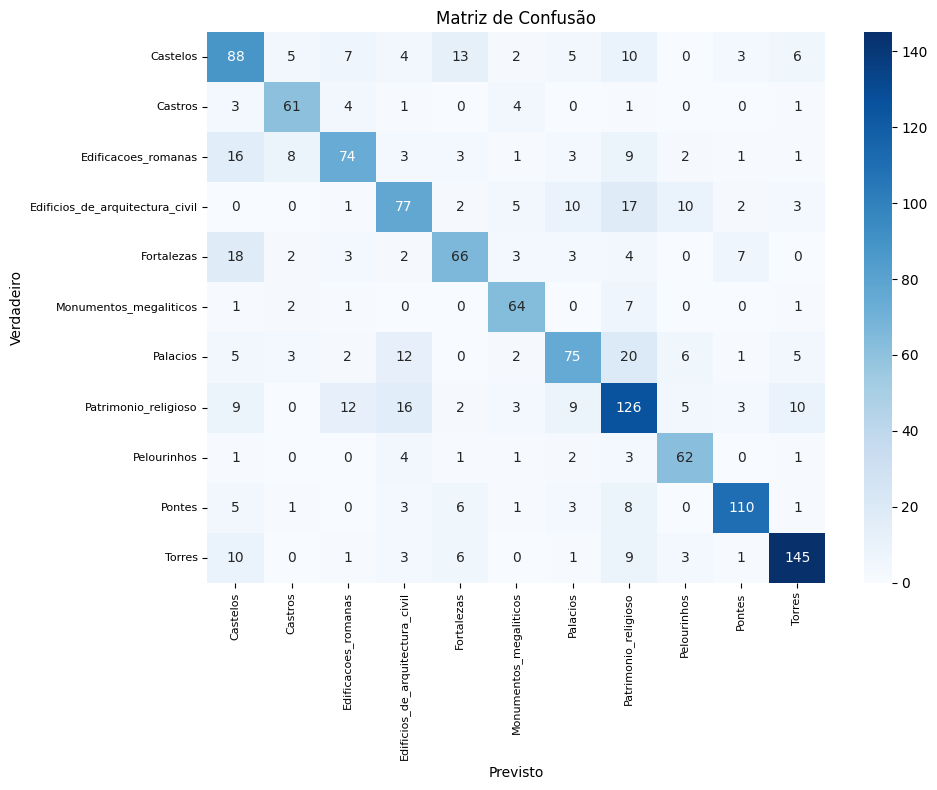

In [33]:
# Matriz de confusão
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)

ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                 xticklabels=class_names, 
                 yticklabels=class_names)

ax.set_title('Matriz de Confusão')
ax.set_xlabel('Previsto')
ax.set_ylabel('Verdadeiro')

# Diminuir tamanho das legendas
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=8)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=8)

plt.tight_layout()
plt.savefig(model1_dir / 'matriz_confusaoModel1.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Calcular métricas por classe
f1_per_class = f1_score(y_true, y_pred, average=None)
precision_per_class = precision_score(y_true, y_pred, average=None)

recall_per_class = []
for i in range(len(class_names)):
    idx = np.where(np.array(y_true) == i)
    rec = accuracy_score(np.array(y_true)[idx], np.array(y_pred)[idx])
    recall_per_class.append(rec)

# Gráficos de evolução e comparação
plt.figure(figsize=(20, 6))

# Loss
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Evolução da Loss')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

# F1-Score treino vs validação
plt.subplot(1, 3, 2)
plt.plot(history.history['f1_score'], label='Treino')
plt.plot(history.history['val_f1_score'], label='Validação')
plt.title('Evolução do F1-Score')
plt.xlabel('Época')
plt.ylabel('F1-Score')
plt.legend()

# Preparar DataFrame para o gráfico comparativo Recall vs F1-Score vs Precision por classe
df_metrics = pd.DataFrame({
    'Classe': class_names * 3,
    'Métrica': ['Recall'] * len(class_names) + ['F1-Score'] * len(class_names) + ['Precision'] * len(class_names),
    'Valor': recall_per_class + list(f1_per_class) + list(precision_per_class)
})

plt.subplot(1, 3, 3)
ax = sns.barplot(data=df_metrics, x='Classe', y='Valor', hue='Métrica')

plt.title('Recall vs F1-Score vs Precision por Classe')
plt.xlabel('Classe')
plt.ylabel('Valor')
plt.ylim(0, 1)
plt.xticks(rotation=90, fontsize=9)
plt.legend(loc='lower right')

# Adicionar valores verticais nas barras
for container in ax.containers:
    for bar in container:
        altura = bar.get_height()
        x = bar.get_x() + bar.get_width() / 2
        y = altura
        ax.annotate(
            f'{altura:.2f}',
            xy=(x, y),
            xytext=(0, 3),
            textcoords='offset points',
            ha='center',
            va='bottom',
            fontsize=9,
            rotation=90,
            color='black',
            bbox=dict(boxstyle='round,pad=0.2', fc='lightgray', ec='none', alpha=0.3)
        )

plt.tight_layout()
plt.savefig(model1_dir / 'evolucao_metricasModel1.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. Segundo Modelo - [Templos da Igreja Católica](https://www.a12.com/redacaoa12/duvidas-religiosas/qual-a-diferenca-entre-capela-igreja-catedral-basilica-e-santuario)

In [5]:
# Caminho original
train_dir = data_dir / 'train'

# Caminho destino
train_dir1 = data_dir / 'TrainModel1'
train_dir1.mkdir(exist_ok=True)

# Classes de interesse
classes_de_interesse = ['capela', 'igreja', 'catedral', 'basilica', 'santuario']

### 2.1.Criar Dataset

In [6]:
def normaliza_nome(nome):
    return nome.lower().replace('á', 'a').replace('ã', 'a').replace('ç', 'c')\
                       .replace('é', 'e').replace('í', 'i').replace('ú', 'u')

def is_valid_and_copy(file_path, dst):
    try:
        img = tf.io.read_file(file_path)
        tf.image.decode_jpeg(img, channels=3)
        shutil.copy2(file_path, dst)
    except tf.errors.InvalidArgumentError:
        print(f"Arquivo JPEG inválido ignorado: {file_path}")

def copy_valid_images(src, dst):
    valid_extensions = ('.jpg', '.jpeg', '.png')
    
    # Pré-filtrar os ficheiros válidos
    valid_files = [
        entry.path for entry in os.scandir(src)
        if entry.is_file() and entry.name.lower().endswith(valid_extensions)
    ]
    
    # Progress bar
    with ThreadPoolExecutor(max_workers=8) as executor:
        list(tqdm(executor.map(lambda f: is_valid_and_copy(f, dst), valid_files),
                  total=len(valid_files),
                  desc=f"A copiar imagens de {src.name}"))

# ⛔ Verificar se train_dir1 já existe e está preenchido
if train_dir1.exists() and any(train_dir1.iterdir()):
    print(f"Diretório de destino já existe e não está vazio: {train_dir1}, a ignorar todo o processo.")
else:
    for root, dirs, files in os.walk(train_dir):
        root_path = Path(root)
        nome_pasta = root_path.name.lower()

        for classe in classes_de_interesse:
            if classe in nome_pasta:
                classe_normalizada = normaliza_nome(classe)
                destino_classe = train_dir1 / classe_normalizada

                destino_classe.mkdir(parents=True, exist_ok=True)
                copy_valid_images(root_path, destino_classe)
                break

Diretório de destino já existe e não está vazio: /workspaces/APVC/APVC-ProjetoFinal/data/TrainModel1, a ignorar todo o processo.


In [7]:
# Contagem de imagens por classe
print("Contagem de imagens por classe:")
print("-----------------------------")

total_imagens = 0

# Itera sobre cada pasta de classe
for classe_dir in sorted(train_dir1.iterdir()):
    if classe_dir.is_dir():
        # Lista apenas arquivos de imagem
        imagens = [f for f in os.listdir(classe_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        num_imagens = len(imagens)
        print(f"{classe_dir.name}: {num_imagens} imagens")
        total_imagens += num_imagens

print("-----------------------------")
print(f"Total de imagens: {total_imagens}")

Contagem de imagens por classe:
-----------------------------
basilica: 500 imagens
capela: 500 imagens
catedral: 500 imagens
igreja: 500 imagens
santuario: 500 imagens
-----------------------------
Total de imagens: 2500


In [10]:
@lru_cache(maxsize=512)
def load_image_cached(path_str):
    try:
        img = tf.io.read_file(path_str)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)
        return img
    except Exception as e:
        print(f"Erro ao carregar {path_str}: {e}")
        return None

def load_image(path):
    img = load_image_cached(str(path))
    if img is None:
        raise ValueError(f"Falha ao carregar imagem: {path}")
    return img

def save_augmented_image(aug_image, save_path):
    try:
        if tf.is_tensor(aug_image):
            if aug_image.dtype != tf.float32:
                aug_image = tf.image.convert_image_dtype(aug_image, dtype=tf.float32)
            aug_image = tf.clip_by_value(aug_image, 0.0, 1.0)
            aug_image = tf.image.convert_image_dtype(aug_image, dtype=tf.uint8)
            aug_image = aug_image.numpy()
        img_pil = Image.fromarray(aug_image)
        img_pil.save(save_path, format='JPEG', quality=95)
        return True
    except Exception as e:
        print(f"Erro ao salvar {save_path}: {str(e)}")
        return False

def augment_image(image):
    # Exemplo simples de augmentação (podes substituir por outra)
    return tf.image.flip_left_right(image)

def augment_class_images(class_path, images, target_count):
    generated = 0
    start_generated = 0
    pbar = tqdm(total=target_count - len(images), desc=f"Augmentando {class_path.name}")
    while len(images) + generated < target_count:
        img_path = random.choice(images)
        try:
            image = load_image(img_path)
            aug_image = augment_image(image)
            filename = f"aug_{start_generated + generated:04d}_{img_path.stem}.jpg"
            save_path = class_path / filename
            save_augmented_image(aug_image, save_path)
            generated += 1
            pbar.update(1)
        except Exception as e:
            print(f"Erro ao processar {img_path}: {e}")
    pbar.close()

def undersample_class(class_path, target_count):
    images = list(class_path.glob("*.jpg")) + list(class_path.glob("*.jpeg")) + list(class_path.glob("*.png"))
    current_count = len(images)
    if current_count <= target_count:
        print(f"{class_path.name}: {current_count} imagens (não precisa undersample)")
        return
    images_to_keep = random.sample(images, target_count)
    kept_names = {img.name for img in images_to_keep}
    removed = 0
    for img_path in images:
        if img_path.name not in kept_names:
            try:
                img_path.unlink()
                removed += 1
            except Exception as e:
                print(f"Erro ao remover {img_path}: {e}")
    print(f"{class_path.name}: reduziu de {current_count} para {target_count} (removidas {removed})")

def process_class(class_path, target_count):
    images = list(class_path.glob("*.jpg")) + list(class_path.glob("*.jpeg")) + list(class_path.glob("*.png"))
    current_count = len(images)
    if current_count > target_count:
        undersample_class(class_path, target_count)
    elif current_count < target_count:
        augment_class_images(class_path, images, target_count)
    else:
        print(f"{class_path.name}: já balanceada ({current_count} imagens)")

def balance_dataset_with_threads(dataset_path, target_count=2000, max_workers=4):
    dataset_path = Path(dataset_path)
    print(f"Iniciando balanceamento para {target_count} imagens por classe com ThreadPoolExecutor...")

    class_dirs = [d for d in sorted(dataset_path.iterdir()) if d.is_dir()]
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(process_class, class_dir, target_count) for class_dir in class_dirs]
        for future in tqdm(as_completed(futures), total=len(futures)):
            future.result()  # Propaga exceções, se existirem

    print("\nResultado final:")
    for class_dir in class_dirs:
        count = len(list(class_dir.glob("*.jpg")) + list(class_dir.glob("*.jpeg")) + list(class_dir.glob("*.png")))
        print(f"{class_dir.name}: {count} imagens")

    print("\n✅ Balanceamento concluído com sucesso!")

# Exemplo de uso
balance_dataset_with_threads(train_dir1, target_count=500, max_workers=15)


Iniciando balanceamento para 500 imagens por classe com ThreadPoolExecutor...


  0%|          | 0/5 [00:00<?, ?it/s]





capela: já balanceada (500 imagens)
igreja: já balanceada (500 imagens)































































































































































 60%|██████    | 3/5 [00:26<00:17,  8.68s/it]




























100%|██████████| 5/5 [01:27<00:00, 17.47s/it]


Resultado final:
basilica: 500 imagens
capela: 500 imagens
catedral: 500 imagens
igreja: 500 imagens
santuario: 500 imagens

✅ Balanceamento concluído com sucesso!


### 2.3. Modelling

In [ ]:
model2_dir = base_dir / 'notebooks' / 'model1'
model2_dir.mkdir(parents=True, exist_ok=True)

# =============================================
# 1. Configurações iniciais
# =============================================
batch_size = 32
img_height = 224
img_width = 224
seed = 123
epochs = 50

# =============================================
# 2. Criação do dataset
# =============================================
def create_datasets(train_dir1=train_dir1):
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        train_dir1,
        validation_split=0.2,
        subset="training",
        seed=seed,
        image_size=(img_height, img_width),
        batch_size=batch_size
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        train_dir1,
        validation_split=0.2,
        subset="validation",
        seed=seed,
        image_size=(img_height, img_width),
        batch_size=batch_size
        
    )

    class_names = train_ds.class_names
    print("\nClasses encontradas:", class_names)
    
    return train_ds, val_ds, class_names

train_ds_full, val_ds, class_names = create_datasets(train_dir)

# =============================================
# 3. Pipeline de dados com normalização
# =============================================

normalization_layer = layers.Rescaling(1./255)

def prepare(ds, shuffle=False):
    ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.cache()
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = prepare(train_ds_full, shuffle=True)
val_ds = prepare(val_ds, shuffle=False)

# =============================================
# 4. Definição do modelo CNN (agora com BatchNorm e Dropout melhorados)
# =============================================

def build_model():
    inputs = layers.Input(shape=(img_height, img_width, 3))
    
    x = layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(1e-4))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.25)(x)
    
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.4)(x)
    
    x = layers.GlobalAveragePooling2D()(x)  # substitui o Flatten
    
    x = layers.Dense(512, kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)
    
    outputs = layers.Dense(len(class_names), activation='softmax')(x)
    
    return models.Model(inputs, outputs)

model = build_model()

# =============================================
# 5. Configuração do treino
# =============================================

# Callback para monitorizar F1-Score no final de cada época
class F1ScoreTracker(callbacks.Callback):
    def __init__(self, train_data, val_data):
        super().__init__()
        self.train_data = train_data
        self.val_data = val_data
        self.train_f1_scores = []
        self.val_f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}

        # Função auxiliar
        def get_f1(data):
            y_true, y_pred = [], []
            for x_batch, y_batch in data:
                preds = np.argmax(self.model.predict(x_batch, verbose=0), axis=1)
                y_true.extend(y_batch.numpy())
                y_pred.extend(preds)
            return f1_score(y_true, y_pred, average='weighted')

        f1_train = get_f1(self.train_data)
        f1_val = get_f1(self.val_data)

        self.train_f1_scores.append(f1_train)
        self.val_f1_scores.append(f1_val)

        logs['f1_score'] = f1_train
        logs['val_f1_score'] = f1_val

        print(f" - f1_score: {f1_train:.4f} - val_f1_score: {f1_val:.4f}")

f1_tracker = F1ScoreTracker(train_ds, val_ds)

callbacks_list = [
    f1_tracker,
    callbacks.EarlyStopping(monitor='val_f1_score', patience=5, mode='max', restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor='val_f1_score', factor=0.2, patience=3, mode='max', verbose=1),
    callbacks.ModelCheckpoint(model2_dir / "best_Model1.keras", monitor="val_f1_score", save_best_only=True, mode='max')
]

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# =============================================
# 6. Treino do modelo
# =============================================
start_time = time.time()
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list,
)
training_time = time.time() - start_time
print(f"\nTreino concluído em {training_time:.2f} segundos")

# Guardar f1_scores no history para facilitar os gráficos
history.history['f1_score'] = f1_tracker.train_f1_scores
history.history['val_f1_score'] = f1_tracker.val_f1_scores

Found 2500 files belonging to 5 classes.
Using 2000 files for training.
Found 2500 files belonging to 5 classes.
Using 500 files for validation.

Classes encontradas: ['basilica', 'capela', 'catedral', 'igreja', 'santuario']
Epoch 1/50


Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Corrupt JPEG data: 174 extraneous bytes before marker 0xd9
Invalid SOS parameters for sequential JPEG
2025-06-12 00:48:42.707404: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 41 of 1000
Invalid SOS parameters for sequential JPEG
2025-06-12 00:48:41.792314: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB
2025-06-12 00:48:42.173146: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
I0000 00:00:1749689322.180834    1200 service.cc:152] XLA service 0x7f952001e7e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749689322.180869    1200 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2025-06-12 00:48:42.251915: I tensorflow/compiler/mlir/tensorflow/utils/d

38/63 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.2618 - loss: 2.0661

2025-06-12 00:49:06.383251: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3810', 16 bytes spill stores, 16 bytes spill loads

2025-06-12 00:49:11.980730: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng11{k2=0,k3=0} for conv %cudnn-conv-bias-activation.20 = (f32[16,64,112,112]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,32,112,112]{3,2,1,0} %bitcast.18693, f32[64,32,3,3]{3,2,1,0} %bitcast.18686, f32[64]{0} %bitcast.18744), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/conv2d_2_1/convolution" source_file="/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_m

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.2623 - loss: 2.0348

Corrupt JPEG data: 89 extraneous bytes before marker 0xd9
2025-06-12 00:49:21.912949: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_301', 180 bytes spill stores, 180 bytes spill loads

2025-06-12 00:49:22.025804: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_301', 4 bytes spill stores, 4 bytes spill loads

2025-06-12 00:49:22.063778: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_301', 20 bytes spill stores, 20 bytes spill loads

2025-06-12 00:49:24.955610: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_301', 72 bytes spill stores, 72 bytes

 - f1_score: 0.0656 - val_f1_score: 0.0754
63/63 ━━━━━━━━━━━━━━━━━━━━ 69s 574ms/step - accuracy: 0.2623 - loss: 2.0337 - val_accuracy: 0.2140 - val_loss: 1.7038 - f1_score: 0.0656 - val_f1_score: 0.0754 - learning_rate: 0.0010
Epoch 2/50


2025-06-12 00:49:35.861445: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.3217 - loss: 1.8152 - f1_score: 0.0651 - val_f1_score: 0.0836
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - accuracy: 0.3218 - loss: 1.8151 - val_accuracy: 0.2180 - val_loss: 1.8804 - f1_score: 0.0651 - val_f1_score: 0.0836 - learning_rate: 0.0010
Epoch 3/50


2025-06-12 00:49:47.065078: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.3379 - loss: 1.7366 - f1_score: 0.0671 - val_f1_score: 0.0838
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - accuracy: 0.3380 - loss: 1.7367 - val_accuracy: 0.2180 - val_loss: 1.9252 - f1_score: 0.0671 - val_f1_score: 0.0838 - learning_rate: 0.0010
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.3484 - loss: 1.6984 - f1_score: 0.0845 - val_f1_score: 0.0995
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 183ms/step - accuracy: 0.3484 - loss: 1.6979 - val_accuracy: 0.2260 - val_loss: 2.4081 - f1_score: 0.0845 - val_f1_score: 0.0995 - learning_rate: 0.0010
Epoch 5/50


2025-06-12 00:50:11.851721: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.3794 - loss: 1.5826 - f1_score: 0.1321 - val_f1_score: 0.1272
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 220ms/step - accuracy: 0.3792 - loss: 1.5833 - val_accuracy: 0.2400 - val_loss: 1.9926 - f1_score: 0.1321 - val_f1_score: 0.1272 - learning_rate: 0.0010
Epoch 6/50
58/63 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.3529 - loss: 1.6337 - f1_score: 0.2028 - val_f1_score: 0.1611
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - accuracy: 0.3547 - loss: 1.6314 - val_accuracy: 0.2360 - val_loss: 1.7830 - f1_score: 0.2028 - val_f1_score: 0.1611 - learning_rate: 0.0010
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.3926 - loss: 1.5983 - f1_score: 0.3067 - val_f1_score: 0.2837
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 218ms/step - accuracy: 0.3927 - loss: 1.5984 - val_accuracy: 0.3340 - val_loss: 1.5923 - f1_score: 0.3067 - val_f1_score: 0.2837 - learning_rate: 0.0010
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.3955 - lo

2025-06-12 00:51:01.846658: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.4206 - loss: 1.4954 - f1_score: 0.2843 - val_f1_score: 0.2781
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 215ms/step - accuracy: 0.4204 - loss: 1.4959 - val_accuracy: 0.2980 - val_loss: 1.8033 - f1_score: 0.2843 - val_f1_score: 0.2781 - learning_rate: 0.0010
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.4028 - loss: 1.4880 - f1_score: 0.3582 - val_f1_score: 0.3518
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - accuracy: 0.4032 - loss: 1.4878 - val_accuracy: 0.3920 - val_loss: 1.4971 - f1_score: 0.3582 - val_f1_score: 0.3518 - learning_rate: 0.0010
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.4494 - loss: 1.4744 - f1_score: 0.4259 - val_f1_score: 0.4235
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - accuracy: 0.4490 - loss: 1.4747 - val_accuracy: 0.4560 - val_loss: 1.3948 - f1_score: 0.4259 - val_f1_score: 0.4235 - learning_rate: 0.0010
Epoch 12/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.4626 -

2025-06-12 00:52:40.167298: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.5166 - loss: 1.2788 - f1_score: 0.5177 - val_f1_score: 0.4810
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step - accuracy: 0.5166 - loss: 1.2786 - val_accuracy: 0.4960 - val_loss: 1.3222 - f1_score: 0.5177 - val_f1_score: 0.4810 - learning_rate: 2.0000e-04
Epoch 18/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.5127 - loss: 1.2596 - f1_score: 0.4869 - val_f1_score: 0.4551
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 205ms/step - accuracy: 0.5129 - loss: 1.2596 - val_accuracy: 0.4720 - val_loss: 1.3800 - f1_score: 0.4869 - val_f1_score: 0.4551 - learning_rate: 2.0000e-04
Epoch 19/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.5289 - loss: 1.2452 - f1_score: 0.5237 - val_f1_score: 0.4901
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 211ms/step - accuracy: 0.5291 - loss: 1.2449 - val_accuracy: 0.5020 - val_loss: 1.3389 - f1_score: 0.5237 - val_f1_score: 0.4901 - learning_rate: 2.0000e-04
Epoch 20/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accurac

In [ ]:
import visualkeras

visualkeras.layered_view(model, legend=True, draw_volume=True)
img = visualkeras.layered_view(model)
img.save(model2_dir / "model1_keras.png")

In [ ]:
# =============================================
# 7. Avaliação e visualizações
# =============================================

# Preparar previsões
y_true, y_pred = [], []
for images, labels in val_ds:
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(model.predict(images), axis=1))

# Relatório de classificação
print("\nRelatório de Classificação:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# Matriz de confusão
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Matriz de Confusão')
plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(model1_dir / 'matriz_confusaoModel1.png', dpi=300, bbox_inches='tight')
plt.show()

# Calcular métricas por classe
f1_per_class = f1_score(y_true, y_pred, average=None)
precision_per_class = precision_score(y_true, y_pred, average=None)

recall_per_class = []
for i in range(len(class_names)):
    idx = np.where(np.array(y_true) == i)
    rec = accuracy_score(np.array(y_true)[idx], np.array(y_pred)[idx])
    recall_per_class.append(rec)

# Gráficos de evolução e comparação
plt.figure(figsize=(20, 6))

# Loss
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Evolução da Loss')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

# F1-Score treino vs validação
plt.subplot(1, 3, 2)
plt.plot(history.history['f1_score'], label='Treino')
plt.plot(history.history['val_f1_score'], label='Validação')
plt.title('Evolução do F1-Score')
plt.xlabel('Época')
plt.ylabel('F1-Score')
plt.legend()

# Preparar DataFrame para o gráfico comparativo Recall vs F1-Score vs Precision por classe
df_metrics = pd.DataFrame({
    'Classe': class_names * 3,
    'Métrica': ['Recall'] * len(class_names) + ['F1-Score'] * len(class_names) + ['Precision'] * len(class_names),
    'Valor': recall_per_class + list(f1_per_class) + list(precision_per_class)
})

plt.subplot(1, 3, 3)
sns.barplot(data=df_metrics, x='Classe', y='Valor', hue='Métrica')
plt.title('Recall vs F1-Score vs Precision por Classe')
plt.xlabel('Classe')
plt.ylabel('Valor')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(loc='lower right')

plt.tight_layout()
plt.savefig(model2_dir / 'evolucao_metricasModel1.png', dpi=300, bbox_inches='tight')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

Relatório de Classificação:
              precision    recall  f1-score   support

    basilica     0.6355    0.6355    0.6355       107
      capela     0.4342    0.3402    0.3815        97
    catedral     0.5905    0.6139    0.6019       101
      igreja     0.3718    0.2990    0.3314        97
   santuario     0.4925    0.6735    0.5690        98

    accuracy                        

## 4. Modelo Extra Siamesas - [Patrimónios edificados em Portugal por tipologia - Siamesas](https://pt.wikipedia.org/wiki/Lista_de_patrim%C3%B3nio_edificado_em_Portugal)
O dataset é o mesmo que foi criado no **Segundo Modelo**

### 2.1. Preparar Dataset

In [30]:
# Alterar no caso real

BigDataTip = 2000
BigDataTipPerc = 0.1
MidDataTip = 1000
MidDataTipPerc = 0.3

In [ ]:
# Function 1: Preparar a contagem de imagens por tipologia com os pesos
def obter_distribuicao_tipologias(base_dir, classes_a_ignorar):
    distrib = {}
    pesos = {}
    valid_extensions = ('.jpg', '.jpeg', '.png')

    print("\n=== A calcular distribuição de imagens por tipologia ===")
    for pasta in tqdm(list(base_dir.iterdir()), desc="Tipologias"):
        if pasta.is_dir() and pasta.name not in classes_a_ignorar:
            imagens = [f for f in pasta.glob("*") if f.suffix.lower() in valid_extensions]
            distrib[pasta.name] = imagens

            n = len(imagens)
            if n > BigDataTip:
                pesos[pasta.name] = BigDataTipPerc
            elif n > MidDataTip:
                pesos[pasta.name] = MidDataTipPerc
            else:
                pesos[pasta.name] = 1.0
                
    return distrib, pesos

# Function 2: Gerar pares positivos e negativos com balanceamento
def gerar_pares_siameses(distrib, pesos, num_pares_por_classe=1000, max_workers=12):
    pares = []

    # === Pares Positivos ===
    def gerar_positivos(classe):
        imagens = distrib[classe]
        peso = pesos[classe]
        n_pares = int(num_pares_por_classe * peso)

        if len(imagens) < 2:
            return []

        possiveis_pares = list(combinations(imagens, 2))
        pares_positivos = random.sample(possiveis_pares, min(n_pares, len(possiveis_pares)))
        return [(img1, img2, 1) for img1, img2 in pares_positivos]

    print("\n=== A gerar pares positivos ===")
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        resultados = list(tqdm(executor.map(gerar_positivos, distrib.keys()), total=len(distrib)))
        for pares_classe in resultados:
            pares.extend(pares_classe)

    # === Pares Negativos ===
    classes = list(distrib.keys())
    n_negativos = num_pares_por_classe * len(classes) // 2

    def gerar_negativo(_):
        c1, c2 = random.sample(classes, 2)
        if not distrib[c1] or not distrib[c2]:
            return None
        peso = (pesos[c1] + pesos[c2]) / 2
        if random.random() > peso:
            return None
        img1 = random.choice(distrib[c1])
        img2 = random.choice(distrib[c2])
        return (img1, img2, 0)

    print("\n=== A gerar pares negativos ===")
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        resultados_neg = list(tqdm(executor.map(gerar_negativo, range(n_negativos*2)), total=n_negativos*2))

    pares.extend([r for r in resultados_neg if r is not None][:n_negativos])
    random.shuffle(pares)
    return pares

# 1. Obter a distribuição e pesos
distrib, pesos = obter_distribuicao_tipologias(train_dir1, classes_ignorar)

# 2. Gerar os pares
pares_siameses = gerar_pares_siameses(distrib, pesos, num_pares_por_classe=1000)

print(f"\nTotal de pares gerados: {len(pares_siameses)}")
print("Exemplo de par:", pares_siameses[0])


=== A calcular distribuição de imagens por tipologia ===


Tipologias: 100%|██████████| 13/13 [00:00<00:00, 70.35it/s]



=== A gerar pares positivos ===


100%|██████████| 11/11 [00:08<00:00,  1.24it/s]



=== A gerar pares negativos ===


100%|██████████| 11000/11000 [00:00<00:00, 745088.08it/s]


Total de pares gerados: 11700
Exemplo de par: (PosixPath('/workspaces/APVC/APVC-ProjetoFinal/data/TrainModel2/Torres/012_7620c4f4a68d6dcba37e6473ba51d591.jpg'), PosixPath('/workspaces/APVC/APVC-ProjetoFinal/data/TrainModel2/Monumentos megalíticos/006_0ecd8cbb14ecaabe1f277350a75c4c01.jpg'), 0)


### 2.2. Modelling

In [ ]:
model1_dir = base_dir / 'notebooks' / 'model2'
model1_dir.mkdir(parents=True, exist_ok=True)

**1. Construir o modelo base**

In [33]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def build_base_cnn(input_shape=(224, 224, 3), embedding_dim=128):
    base_cnn = tf.keras.applications.EfficientNetB0(
        input_shape=input_shape, include_top=False, weights='imagenet', pooling='avg'
    )
    base_cnn.trainable = True
    for layer in base_cnn.layers[:-20]:
        layer.trainable = False

    inputs = layers.Input(shape=input_shape)
    x = base_cnn(inputs)
    x = layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(embedding_dim, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    return Model(inputs, x, name="base_cnn_efficientnet")


**2. Arquitetura Siamesa**

In [34]:
class ElementWiseFeatures(layers.Layer):
    def call(self, inputs):
        emb_a, emb_b = inputs
        diff = tf.math.abs(emb_a - emb_b)
        mul = emb_a * emb_b
        return tf.concat([emb_a, emb_b, diff, mul], axis=-1)


def build_siamese_network(input_shape=(224, 224, 3), embedding_dim=128):
    base_model = build_base_cnn(input_shape, embedding_dim)

    input_a = layers.Input(shape=input_shape)
    input_b = layers.Input(shape=input_shape)

    embedding_a = base_model(input_a)
    embedding_b = base_model(input_b)

    merged = ElementWiseFeatures()([embedding_a, embedding_b])
    outputs = layers.Dense(1, activation='sigmoid')(merged)

    return Model(inputs=[input_a, input_b], outputs=outputs, name="siamese_network")


**3. Loss e Compilação**

In [35]:
model = build_siamese_network(input_shape=(224, 224, 3), embedding_dim=128)
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)

model.summary()

Model: "siamese_network"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_9       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ base_cnn_efficient… │ (None, 128)       │  4,411,939 │ input_layer_8[0]… │
│ (Functional)        │                   │            │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ element_wise_featu… │ (None, 512)       │          0 │ base_cnn_efficie… │
│ (ElementWiseFeatur… │                   │            │ base_cnn_efficie… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │        513 │ element_wise_fea… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,412,452 (16.83 MB)

 Trainable params: 1,491,889 (5.69 MB)

 Non-trainable params: 2,920,563 (11.14 MB)

In [ ]:
import visualkeras

img = visualkeras.layered_view(model, legend=True, draw_volume=True)
img.save(model1_dir / "model2_keras.png")

**4. Preparar tf.data.Dataset**

In [37]:
from sklearn.model_selection import train_test_split

def preprocess_image(filename):
    try:
        image = tf.io.read_file(tf.strings.strip(filename))
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, [224, 224])
        image = tf.cast(image, tf.float32) / 255.0
        return image
    except tf.errors.InvalidArgumentError:
        tf.print(f"[AVISO] Imagem inválida ignorada: {filename}")
        return tf.zeros([224, 224, 3], dtype=tf.float32)

def make_dataset(pares_siameses, batch_size=32, shuffle=True, shuffle_buffer=1000):
    img1_paths = np.array([str(p[0]) for p in pares_siameses])
    img2_paths = np.array([str(p[1]) for p in pares_siameses])
    labels = np.array([p[2] for p in pares_siameses])

    ds = tf.data.Dataset.from_tensor_slices((img1_paths, img2_paths, labels))

    def _load_pair(img1_path, img2_path, label):
        img1 = preprocess_image(img1_path)
        img2 = preprocess_image(img2_path)
        return (img1, img2), tf.cast(label, tf.float32)

    ds = ds.map(_load_pair, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(buffer_size=shuffle_buffer)

    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return ds

def split_dataset(pares_siameses, val_size=0.1, test_size=0.1, random_state=42):
    """
    Divide os pares siameses em treino, validação e teste.

    Parâmetros:
    - pares_siameses: lista de tuplos (img1_path, img2_path, label)
    - val_size: proporção para validação
    - test_size: proporção para teste
    - random_state: semente para reprodutibilidade

    Retorna:
    - treino, validação, teste (listas)
    """

    # Primeiro, separa o conjunto de teste
    pares_temp, pares_test = train_test_split(
        pares_siameses, test_size=test_size, random_state=random_state, stratify=[p[2] for p in pares_siameses]
    )

    # Depois, divide pares_temp em treino e validação
    val_proportion_adjusted = val_size / (1 - test_size)  # ajustar proporção para dividir o que resta

    pares_train, pares_val = train_test_split(
        pares_temp, test_size=val_proportion_adjusted, random_state=random_state, stratify=[p[2] for p in pares_temp]
    )

    return pares_train, pares_val, pares_test


In [38]:
pares_train, pares_val, pares_test = split_dataset(pares_siameses, val_size=0.1, test_size=0.1)

train_ds = make_dataset(pares_train, batch_size=32, shuffle=True)
val_ds = make_dataset(pares_val, batch_size=32, shuffle=False)
test_ds = make_dataset(pares_test, batch_size=32, shuffle=False)

**5. Treinar**

In [39]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping_cb = EarlyStopping(
    monitor='loss',       # ou 'val_loss' se tiveres dados de validação
    patience=3,           # n.º de épocas sem melhoria antes de parar
    restore_best_weights=True
)

In [40]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_cb = ModelCheckpoint(
    filepath='melhor_modelo.h5',
    save_best_only=True,
    monitor='loss',       # ou 'val_loss'
    mode='min'
)

In [41]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr_cb = ReduceLROnPlateau(
    monitor='loss',       # ou 'val_loss'
    factor=0.5,
    patience=2,
    min_lr=1e-6
)

In [ ]:
from tensorflow.keras.callbacks import (
    Callback, TensorBoard, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
)
from tqdm import tqdm
import tensorflow as tf

# Callback para barra de progresso tqdm
class TqdmCallback(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.progbar = tqdm(total=self.params['steps'], desc=f"Época {epoch+1}/{self.params['epochs']}")
    def on_batch_end(self, batch, logs=None):
        self.progbar.update(1)
    def on_epoch_end(self, epoch, logs=None):
        self.progbar.close()

# Verificar GPU
print("GPUs disponíveis:", tf.config.list_physical_devices('GPU'))

# Callbacks
tensorboard_cb = TensorBoard(log_dir="./logs", histogram_freq=1)
early_stopping_cb = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
checkpoint_cb = ModelCheckpoint(filepath=model1_dir / 'modelo_siamesas.keras', save_best_only=True, monitor='loss', mode='min')
reduce_lr_cb = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=2, min_lr=1e-6)

# Preparar treino
tqdm_callback = TqdmCallback()

# Treinar modelo
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[
        tqdm_callback,
        tensorboard_cb,
        early_stopping_cb,
        checkpoint_cb,
        reduce_lr_cb
    ]
)

GPUs disponíveis: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Época 1/10:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 1/10


Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
2025-06-13 21:43:52.412219: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 517 of 1000
Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
2025-06-13 21:44:02.783544: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-06-13 21:44:12.582975: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-13 21:44:12.756686: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-13 21:44:13.539028: E external/local_xla/xla/stream_executor/cuda/

  2/293 ━━━━━━━━━━━━━━━━━━━━ 20s 71ms/step - accuracy: 0.4844 - auc_1: 0.4915 - loss: 1.1198 - precision_1: 0.5264 - recall_1: 0.6906   

Época 1/10:   1%|          | 3/293 [00:53<1:06:45, 13.81s/it]

  3/293 ━━━━━━━━━━━━━━━━━━━━ 1:15 259ms/step - accuracy: 0.4861 - auc_1: 0.5003 - loss: 1.1201 - precision_1: 0.5201 - recall_1: 0.6871

Época 1/10:   1%|▏         | 4/293 [00:53<44:58,  9.34s/it]  

  4/293 ━━━━━━━━━━━━━━━━━━━━ 2:14 465ms/step - accuracy: 0.4876 - auc_1: 0.5035 - loss: 1.1111 - precision_1: 0.5165 - recall_1: 0.6820

Época 1/10:   2%|▏         | 5/293 [00:54<30:40,  6.39s/it]

  5/293 ━━━━━━━━━━━━━━━━━━━━ 2:11 457ms/step - accuracy: 0.4976 - auc_1: 0.5147 - loss: 1.0885 - precision_1: 0.5213 - recall_1: 0.6901

Época 1/10:   2%|▏         | 6/293 [00:54<21:31,  4.50s/it]

  6/293 ━━━━━━━━━━━━━━━━━━━━ 2:13 466ms/step - accuracy: 0.5058 - auc_1: 0.5208 - loss: 1.0794 - precision_1: 0.5267 - recall_1: 0.6939

Época 1/10:   2%|▏         | 7/293 [00:55<15:48,  3.32s/it]

  7/293 ━━━━━━━━━━━━━━━━━━━━ 2:25 510ms/step - accuracy: 0.5114 - auc_1: 0.5223 - loss: 1.0748 - precision_1: 0.5311 - recall_1: 0.6944

Época 1/10:   3%|▎         | 8/293 [00:56<12:06,  2.55s/it]

  8/293 ━━━━━━━━━━━━━━━━━━━━ 2:38 557ms/step - accuracy: 0.5134 - auc_1: 0.5202 - loss: 1.0738 - precision_1: 0.5342 - recall_1: 0.6916

Época 1/10:   3%|▎         | 9/293 [00:58<10:38,  2.25s/it]

  9/293 ━━━━━━━━━━━━━━━━━━━━ 3:13 683ms/step - accuracy: 0.5142 - auc_1: 0.5167 - loss: 1.0734 - precision_1: 0.5369 - recall_1: 0.6876

Época 1/10:   3%|▎         | 10/293 [00:58<08:00,  1.70s/it]

 10/293 ━━━━━━━━━━━━━━━━━━━━ 3:05 656ms/step - accuracy: 0.5153 - auc_1: 0.5145 - loss: 1.0712 - precision_1: 0.5390 - recall_1: 0.6848

Época 1/10:   4%|▍         | 11/293 [00:59<06:25,  1.37s/it]

 11/293 ━━━━━━━━━━━━━━━━━━━━ 3:03 652ms/step - accuracy: 0.5152 - auc_1: 0.5121 - loss: 1.0695 - precision_1: 0.5404 - recall_1: 0.6814

Época 1/10:   4%|▍         | 12/293 [01:00<05:50,  1.25s/it]

 12/293 ━━━━━━━━━━━━━━━━━━━━ 3:11 681ms/step - accuracy: 0.5146 - auc_1: 0.5106 - loss: 1.0665 - precision_1: 0.5413 - recall_1: 0.6768

Época 1/10:   4%|▍         | 13/293 [01:00<04:42,  1.01s/it]

 13/293 ━━━━━━━━━━━━━━━━━━━━ 3:05 662ms/step - accuracy: 0.5134 - auc_1: 0.5089 - loss: 1.0639 - precision_1: 0.5416 - recall_1: 0.6714

Época 1/10:   5%|▍         | 14/293 [01:00<03:57,  1.18it/s]

 14/293 ━━━━━━━━━━━━━━━━━━━━ 3:00 648ms/step - accuracy: 0.5125 - auc_1: 0.5077 - loss: 1.0615 - precision_1: 0.5412 - recall_1: 0.6668

Época 1/10:   5%|▌         | 15/293 [01:01<03:47,  1.22it/s]

 15/293 ━━━━━━━━━━━━━━━━━━━━ 3:02 655ms/step - accuracy: 0.5114 - auc_1: 0.5066 - loss: 1.0590 - precision_1: 0.5403 - recall_1: 0.6626

Época 1/10:   5%|▌         | 16/293 [01:02<03:25,  1.34it/s]

 16/293 ━━━━━━━━━━━━━━━━━━━━ 2:59 649ms/step - accuracy: 0.5107 - auc_1: 0.5058 - loss: 1.0564 - precision_1: 0.5396 - recall_1: 0.6589

Época 1/10:   6%|▌         | 17/293 [01:02<02:59,  1.54it/s]

 17/293 ━━━━━━━━━━━━━━━━━━━━ 2:55 636ms/step - accuracy: 0.5100 - auc_1: 0.5048 - loss: 1.0546 - precision_1: 0.5391 - recall_1: 0.6554

Época 1/10:   6%|▌         | 18/293 [01:03<02:45,  1.66it/s]

 18/293 ━━━━━━━━━━━━━━━━━━━━ 2:52 627ms/step - accuracy: 0.5094 - auc_1: 0.5037 - loss: 1.0528 - precision_1: 0.5388 - recall_1: 0.6518

Época 1/10:   6%|▋         | 19/293 [01:03<02:34,  1.77it/s]

 19/293 ━━━━━━━━━━━━━━━━━━━━ 2:49 619ms/step - accuracy: 0.5091 - auc_1: 0.5031 - loss: 1.0507 - precision_1: 0.5386 - recall_1: 0.6487

Época 1/10:   7%|▋         | 20/293 [01:04<02:48,  1.62it/s]

 20/293 ━━━━━━━━━━━━━━━━━━━━ 2:50 625ms/step - accuracy: 0.5089 - auc_1: 0.5026 - loss: 1.0484 - precision_1: 0.5385 - recall_1: 0.6458

Época 1/10:   7%|▋         | 21/293 [01:04<02:33,  1.78it/s]

 21/293 ━━━━━━━━━━━━━━━━━━━━ 2:47 616ms/step - accuracy: 0.5088 - auc_1: 0.5025 - loss: 1.0457 - precision_1: 0.5385 - recall_1: 0.6431

Época 1/10:   8%|▊         | 22/293 [01:05<02:30,  1.80it/s]

 22/293 ━━━━━━━━━━━━━━━━━━━━ 2:45 612ms/step - accuracy: 0.5084 - auc_1: 0.5021 - loss: 1.0434 - precision_1: 0.5382 - recall_1: 0.6403

Época 1/10:   8%|▊         | 23/293 [01:06<02:38,  1.71it/s]

 23/293 ━━━━━━━━━━━━━━━━━━━━ 2:45 614ms/step - accuracy: 0.5080 - auc_1: 0.5016 - loss: 1.0414 - precision_1: 0.5377 - recall_1: 0.6375

Época 1/10:   8%|▊         | 24/293 [01:06<02:33,  1.75it/s]

 24/293 ━━━━━━━━━━━━━━━━━━━━ 2:44 611ms/step - accuracy: 0.5078 - auc_1: 0.5014 - loss: 1.0393 - precision_1: 0.5375 - recall_1: 0.6353

Época 1/10:   9%|▊         | 25/293 [01:07<02:29,  1.79it/s]

 25/293 ━━━━━━━━━━━━━━━━━━━━ 2:42 608ms/step - accuracy: 0.5077 - auc_1: 0.5014 - loss: 1.0371 - precision_1: 0.5372 - recall_1: 0.6332

Época 1/10:   9%|▉         | 26/293 [01:07<02:31,  1.76it/s]

 26/293 ━━━━━━━━━━━━━━━━━━━━ 2:41 607ms/step - accuracy: 0.5075 - auc_1: 0.5011 - loss: 1.0353 - precision_1: 0.5369 - recall_1: 0.6310

Corrupt JPEG data: 77 extraneous bytes before marker 0xd9
Época 1/10:   9%|▉         | 27/293 [01:08<02:49,  1.57it/s]

 27/293 ━━━━━━━━━━━━━━━━━━━━ 2:43 614ms/step - accuracy: 0.5070 - auc_1: 0.5005 - loss: 1.0338 - precision_1: 0.5365 - recall_1: 0.6287

Época 1/10:  10%|▉         | 28/293 [01:09<02:40,  1.65it/s]

 28/293 ━━━━━━━━━━━━━━━━━━━━ 2:41 611ms/step - accuracy: 0.5066 - auc_1: 0.5000 - loss: 1.0324 - precision_1: 0.5360 - recall_1: 0.6265

Época 1/10:  10%|▉         | 29/293 [01:09<02:33,  1.72it/s]

 29/293 ━━━━━━━━━━━━━━━━━━━━ 2:40 608ms/step - accuracy: 0.5062 - auc_1: 0.4997 - loss: 1.0308 - precision_1: 0.5358 - recall_1: 0.6245

Época 1/10:  10%|█         | 30/293 [01:10<02:46,  1.58it/s]

 30/293 ━━━━━━━━━━━━━━━━━━━━ 2:41 613ms/step - accuracy: 0.5060 - auc_1: 0.4993 - loss: 1.0293 - precision_1: 0.5355 - recall_1: 0.6227

Época 1/10:  11%|█         | 31/293 [01:11<03:25,  1.27it/s]

 31/293 ━━━━━━━━━━━━━━━━━━━━ 2:45 631ms/step - accuracy: 0.5056 - auc_1: 0.4989 - loss: 1.0278 - precision_1: 0.5350 - recall_1: 0.6208

Época 1/10:  11%|█         | 32/293 [01:12<03:06,  1.40it/s]

 32/293 ━━━━━━━━━━━━━━━━━━━━ 2:43 628ms/step - accuracy: 0.5053 - auc_1: 0.4986 - loss: 1.0263 - precision_1: 0.5347 - recall_1: 0.6192

Época 1/10:  11%|█▏        | 33/293 [01:12<02:58,  1.45it/s]

 33/293 ━━━━━━━━━━━━━━━━━━━━ 2:43 628ms/step - accuracy: 0.5050 - auc_1: 0.4983 - loss: 1.0248 - precision_1: 0.5345 - recall_1: 0.6175

Época 1/10:  12%|█▏        | 34/293 [01:13<02:47,  1.55it/s]

 34/293 ━━━━━━━━━━━━━━━━━━━━ 2:42 625ms/step - accuracy: 0.5046 - auc_1: 0.4980 - loss: 1.0232 - precision_1: 0.5342 - recall_1: 0.6160

Época 1/10:  12%|█▏        | 36/293 [01:13<02:11,  1.95it/s]

 36/293 ━━━━━━━━━━━━━━━━━━━━ 2:36 610ms/step - accuracy: 0.5040 - auc_1: 0.4975 - loss: 1.0200 - precision_1: 0.5336 - recall_1: 0.6134

Época 1/10:  13%|█▎        | 37/293 [01:14<02:14,  1.90it/s]

 37/293 ━━━━━━━━━━━━━━━━━━━━ 2:35 609ms/step - accuracy: 0.5037 - auc_1: 0.4973 - loss: 1.0183 - precision_1: 0.5332 - recall_1: 0.6122

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 1/10:  13%|█▎        | 38/293 [01:15<02:31,  1.68it/s]

 38/293 ━━━━━━━━━━━━━━━━━━━━ 2:36 614ms/step - accuracy: 0.5034 - auc_1: 0.4970 - loss: 1.0168 - precision_1: 0.5330 - recall_1: 0.6110

Época 1/10:  13%|█▎        | 39/293 [01:16<02:45,  1.53it/s]

 39/293 ━━━━━━━━━━━━━━━━━━━━ 2:37 619ms/step - accuracy: 0.5032 - auc_1: 0.4968 - loss: 1.0153 - precision_1: 0.5327 - recall_1: 0.6100

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Época 1/10:  14%|█▎        | 40/293 [01:16<02:41,  1.56it/s]

 40/293 ━━━━━━━━━━━━━━━━━━━━ 2:36 619ms/step - accuracy: 0.5029 - auc_1: 0.4966 - loss: 1.0139 - precision_1: 0.5323 - recall_1: 0.6089

Época 1/10:  14%|█▍        | 41/293 [01:17<02:35,  1.62it/s]

 41/293 ━━━━━━━━━━━━━━━━━━━━ 2:35 617ms/step - accuracy: 0.5026 - auc_1: 0.4963 - loss: 1.0126 - precision_1: 0.5320 - recall_1: 0.6079

Época 1/10:  14%|█▍        | 42/293 [01:18<02:48,  1.49it/s]

 42/293 ━━━━━━━━━━━━━━━━━━━━ 2:36 622ms/step - accuracy: 0.5024 - auc_1: 0.4960 - loss: 1.0112 - precision_1: 0.5318 - recall_1: 0.6070

Época 1/10:  15%|█▍        | 43/293 [01:18<02:27,  1.69it/s]

 43/293 ━━━━━━━━━━━━━━━━━━━━ 2:34 616ms/step - accuracy: 0.5021 - auc_1: 0.4958 - loss: 1.0099 - precision_1: 0.5316 - recall_1: 0.6061

Época 1/10:  15%|█▌        | 44/293 [01:18<02:20,  1.78it/s]

 44/293 ━━━━━━━━━━━━━━━━━━━━ 2:32 614ms/step - accuracy: 0.5019 - auc_1: 0.4955 - loss: 1.0087 - precision_1: 0.5314 - recall_1: 0.6053

Época 1/10:  15%|█▌        | 45/293 [01:19<02:04,  2.00it/s]

 45/293 ━━━━━━━━━━━━━━━━━━━━ 2:30 608ms/step - accuracy: 0.5017 - auc_1: 0.4953 - loss: 1.0074 - precision_1: 0.5311 - recall_1: 0.6045

Época 1/10:  16%|█▌        | 46/293 [01:19<02:04,  1.98it/s]

 46/293 ━━━━━━━━━━━━━━━━━━━━ 2:29 606ms/step - accuracy: 0.5016 - auc_1: 0.4952 - loss: 1.0061 - precision_1: 0.5310 - recall_1: 0.6039

Época 1/10:  16%|█▌        | 47/293 [01:20<02:15,  1.81it/s]

 47/293 ━━━━━━━━━━━━━━━━━━━━ 2:29 607ms/step - accuracy: 0.5016 - auc_1: 0.4951 - loss: 1.0047 - precision_1: 0.5309 - recall_1: 0.6033

Época 1/10:  16%|█▋        | 48/293 [01:20<02:09,  1.89it/s]

 48/293 ━━━━━━━━━━━━━━━━━━━━ 2:27 604ms/step - accuracy: 0.5015 - auc_1: 0.4950 - loss: 1.0035 - precision_1: 0.5307 - recall_1: 0.6027

Época 1/10:  17%|█▋        | 49/293 [01:21<01:56,  2.10it/s]

 49/293 ━━━━━━━━━━━━━━━━━━━━ 2:26 599ms/step - accuracy: 0.5014 - auc_1: 0.4949 - loss: 1.0022 - precision_1: 0.5306 - recall_1: 0.6021

Época 1/10:  17%|█▋        | 50/293 [01:21<02:05,  1.94it/s]

 50/293 ━━━━━━━━━━━━━━━━━━━━ 2:25 599ms/step - accuracy: 0.5014 - auc_1: 0.4948 - loss: 1.0009 - precision_1: 0.5305 - recall_1: 0.6017

Época 1/10:  17%|█▋        | 51/293 [01:22<02:34,  1.56it/s]

 51/293 ━━━━━━━━━━━━━━━━━━━━ 2:26 606ms/step - accuracy: 0.5014 - auc_1: 0.4948 - loss: 0.9997 - precision_1: 0.5305 - recall_1: 0.6013

Época 1/10:  18%|█▊        | 52/293 [01:23<02:21,  1.70it/s]

 52/293 ━━━━━━━━━━━━━━━━━━━━ 2:25 603ms/step - accuracy: 0.5014 - auc_1: 0.4947 - loss: 0.9985 - precision_1: 0.5305 - recall_1: 0.6008

Época 1/10:  18%|█▊        | 53/293 [01:23<02:05,  1.91it/s]

 53/293 ━━━━━━━━━━━━━━━━━━━━ 2:23 598ms/step - accuracy: 0.5015 - auc_1: 0.4947 - loss: 0.9972 - precision_1: 0.5306 - recall_1: 0.6004

Época 1/10:  18%|█▊        | 54/293 [01:24<02:20,  1.71it/s]

 54/293 ━━━━━━━━━━━━━━━━━━━━ 2:23 601ms/step - accuracy: 0.5015 - auc_1: 0.4946 - loss: 0.9960 - precision_1: 0.5306 - recall_1: 0.6000

Época 1/10:  19%|█▉        | 55/293 [01:24<02:06,  1.88it/s]

 55/293 ━━━━━━━━━━━━━━━━━━━━ 2:22 597ms/step - accuracy: 0.5015 - auc_1: 0.4945 - loss: 0.9948 - precision_1: 0.5306 - recall_1: 0.5996

Época 1/10:  19%|█▉        | 56/293 [01:25<02:12,  1.79it/s]

 56/293 ━━━━━━━━━━━━━━━━━━━━ 2:21 598ms/step - accuracy: 0.5015 - auc_1: 0.4944 - loss: 0.9937 - precision_1: 0.5307 - recall_1: 0.5993

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Época 1/10:  19%|█▉        | 57/293 [01:26<02:14,  1.76it/s]

 57/293 ━━━━━━━━━━━━━━━━━━━━ 2:21 598ms/step - accuracy: 0.5014 - auc_1: 0.4943 - loss: 0.9926 - precision_1: 0.5306 - recall_1: 0.5990

Época 1/10:  20%|█▉        | 58/293 [01:26<02:12,  1.77it/s]

 58/293 ━━━━━━━━━━━━━━━━━━━━ 2:20 597ms/step - accuracy: 0.5013 - auc_1: 0.4942 - loss: 0.9915 - precision_1: 0.5305 - recall_1: 0.5986

Época 1/10:  20%|██        | 59/293 [01:27<02:32,  1.54it/s]

 59/293 ━━━━━━━━━━━━━━━━━━━━ 2:20 601ms/step - accuracy: 0.5012 - auc_1: 0.4941 - loss: 0.9905 - precision_1: 0.5304 - recall_1: 0.5982

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 1/10:  20%|██        | 60/293 [01:27<02:25,  1.60it/s]

 60/293 ━━━━━━━━━━━━━━━━━━━━ 2:19 601ms/step - accuracy: 0.5011 - auc_1: 0.4939 - loss: 0.9896 - precision_1: 0.5302 - recall_1: 0.5977

Época 1/10:  21%|██        | 61/293 [01:28<02:25,  1.60it/s]

 61/293 ━━━━━━━━━━━━━━━━━━━━ 2:19 601ms/step - accuracy: 0.5010 - auc_1: 0.4937 - loss: 0.9887 - precision_1: 0.5301 - recall_1: 0.5973

2025-06-13 21:44:59.019903: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-06-13 21:44:59.019952: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB
Época 1/10:  21%|██        | 62/293 [01:29<02:18,  1.67it/s]

 62/293 ━━━━━━━━━━━━━━━━━━━━ 2:18 600ms/step - accuracy: 0.5009 - auc_1: 0.4936 - loss: 0.9877 - precision_1: 0.5300 - recall_1: 0.5970

Época 1/10:  22%|██▏       | 63/293 [01:29<02:01,  1.89it/s]

 63/293 ━━━━━━━━━━━━━━━━━━━━ 2:17 596ms/step - accuracy: 0.5008 - auc_1: 0.4934 - loss: 0.9868 - precision_1: 0.5299 - recall_1: 0.5966

Época 1/10:  22%|██▏       | 64/293 [01:30<01:59,  1.92it/s]

 64/293 ━━━━━━━━━━━━━━━━━━━━ 2:16 595ms/step - accuracy: 0.5008 - auc_1: 0.4933 - loss: 0.9858 - precision_1: 0.5299 - recall_1: 0.5963

Época 1/10:  22%|██▏       | 65/293 [01:30<02:04,  1.83it/s]

 65/293 ━━━━━━━━━━━━━━━━━━━━ 2:15 595ms/step - accuracy: 0.5008 - auc_1: 0.4933 - loss: 0.9848 - precision_1: 0.5298 - recall_1: 0.5960

Época 1/10:  23%|██▎       | 66/293 [01:30<01:47,  2.12it/s]

 66/293 ━━━━━━━━━━━━━━━━━━━━ 2:14 590ms/step - accuracy: 0.5008 - auc_1: 0.4932 - loss: 0.9838 - precision_1: 0.5298 - recall_1: 0.5957

Época 1/10:  23%|██▎       | 67/293 [01:31<02:05,  1.80it/s]

 67/293 ━━━━━━━━━━━━━━━━━━━━ 2:13 593ms/step - accuracy: 0.5007 - auc_1: 0.4932 - loss: 0.9828 - precision_1: 0.5298 - recall_1: 0.5954

Época 1/10:  23%|██▎       | 68/293 [01:32<01:58,  1.90it/s]

 68/293 ━━━━━━━━━━━━━━━━━━━━ 2:12 591ms/step - accuracy: 0.5007 - auc_1: 0.4931 - loss: 0.9818 - precision_1: 0.5298 - recall_1: 0.5950

Época 1/10:  24%|██▎       | 69/293 [01:32<01:55,  1.94it/s]

 69/293 ━━━━━━━━━━━━━━━━━━━━ 2:12 589ms/step - accuracy: 0.5006 - auc_1: 0.4931 - loss: 0.9809 - precision_1: 0.5298 - recall_1: 0.5947

Época 1/10:  24%|██▍       | 70/293 [01:33<02:02,  1.83it/s]

 70/293 ━━━━━━━━━━━━━━━━━━━━ 2:11 590ms/step - accuracy: 0.5006 - auc_1: 0.4930 - loss: 0.9799 - precision_1: 0.5297 - recall_1: 0.5944

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 1/10:  24%|██▍       | 71/293 [01:33<02:05,  1.77it/s]

 71/293 ━━━━━━━━━━━━━━━━━━━━ 2:10 590ms/step - accuracy: 0.5005 - auc_1: 0.4930 - loss: 0.9790 - precision_1: 0.5297 - recall_1: 0.5941

Época 1/10:  25%|██▍       | 72/293 [01:34<01:55,  1.92it/s]

 72/293 ━━━━━━━━━━━━━━━━━━━━ 2:09 588ms/step - accuracy: 0.5005 - auc_1: 0.4929 - loss: 0.9780 - precision_1: 0.5296 - recall_1: 0.5938

Época 1/10:  25%|██▍       | 73/293 [01:34<01:42,  2.15it/s]

 73/293 ━━━━━━━━━━━━━━━━━━━━ 2:08 584ms/step - accuracy: 0.5004 - auc_1: 0.4929 - loss: 0.9771 - precision_1: 0.5295 - recall_1: 0.5935

Época 1/10:  25%|██▌       | 74/293 [01:35<01:41,  2.16it/s]

 74/293 ━━━━━━━━━━━━━━━━━━━━ 2:07 582ms/step - accuracy: 0.5004 - auc_1: 0.4929 - loss: 0.9762 - precision_1: 0.5295 - recall_1: 0.5932

Época 1/10:  26%|██▌       | 75/293 [01:35<01:49,  1.99it/s]

 75/293 ━━━━━━━━━━━━━━━━━━━━ 2:07 583ms/step - accuracy: 0.5003 - auc_1: 0.4928 - loss: 0.9753 - precision_1: 0.5294 - recall_1: 0.5930

Época 1/10:  26%|██▌       | 76/293 [01:36<02:07,  1.70it/s]

 76/293 ━━━━━━━━━━━━━━━━━━━━ 2:07 585ms/step - accuracy: 0.5003 - auc_1: 0.4928 - loss: 0.9744 - precision_1: 0.5294 - recall_1: 0.5927

Época 1/10:  26%|██▋       | 77/293 [01:36<01:56,  1.86it/s]

 77/293 ━━━━━━━━━━━━━━━━━━━━ 2:05 583ms/step - accuracy: 0.5003 - auc_1: 0.4928 - loss: 0.9736 - precision_1: 0.5293 - recall_1: 0.5924

Época 1/10:  27%|██▋       | 78/293 [01:37<02:05,  1.71it/s]

 78/293 ━━━━━━━━━━━━━━━━━━━━ 2:05 585ms/step - accuracy: 0.5002 - auc_1: 0.4927 - loss: 0.9727 - precision_1: 0.5292 - recall_1: 0.5922

Época 1/10:  27%|██▋       | 79/293 [01:38<02:11,  1.63it/s]

 79/293 ━━━━━━━━━━━━━━━━━━━━ 2:05 586ms/step - accuracy: 0.5002 - auc_1: 0.4927 - loss: 0.9719 - precision_1: 0.5292 - recall_1: 0.5919

Época 1/10:  27%|██▋       | 80/293 [01:38<01:56,  1.83it/s]

 80/293 ━━━━━━━━━━━━━━━━━━━━ 2:04 583ms/step - accuracy: 0.5002 - auc_1: 0.4926 - loss: 0.9711 - precision_1: 0.5291 - recall_1: 0.5916

Época 1/10:  28%|██▊       | 81/293 [01:39<02:06,  1.68it/s]

 81/293 ━━━━━━━━━━━━━━━━━━━━ 2:04 585ms/step - accuracy: 0.5002 - auc_1: 0.4926 - loss: 0.9703 - precision_1: 0.5291 - recall_1: 0.5912

Época 1/10:  28%|██▊       | 82/293 [01:39<01:51,  1.89it/s]

 82/293 ━━━━━━━━━━━━━━━━━━━━ 2:02 582ms/step - accuracy: 0.5002 - auc_1: 0.4925 - loss: 0.9695 - precision_1: 0.5290 - recall_1: 0.5909

Época 1/10:  28%|██▊       | 83/293 [01:40<02:07,  1.65it/s]

 83/293 ━━━━━━━━━━━━━━━━━━━━ 2:02 585ms/step - accuracy: 0.5001 - auc_1: 0.4924 - loss: 0.9688 - precision_1: 0.5290 - recall_1: 0.5906

Época 1/10:  30%|███       | 88/293 [01:41<00:54,  3.76it/s]

 88/293 ━━━━━━━━━━━━━━━━━━━━ 1:54 557ms/step - accuracy: 0.4999 - auc_1: 0.4919 - loss: 0.9652 - precision_1: 0.5288 - recall_1: 0.5887

Época 1/10:  30%|███       | 89/293 [01:43<01:54,  1.78it/s]

 89/293 ━━━━━━━━━━━━━━━━━━━━ 1:57 575ms/step - accuracy: 0.4998 - auc_1: 0.4918 - loss: 0.9645 - precision_1: 0.5288 - recall_1: 0.5884

Época 1/10:  31%|███       | 90/293 [01:43<01:52,  1.80it/s]

 90/293 ━━━━━━━━━━━━━━━━━━━━ 1:56 574ms/step - accuracy: 0.4997 - auc_1: 0.4917 - loss: 0.9639 - precision_1: 0.5287 - recall_1: 0.5880

Época 1/10:  31%|███       | 91/293 [01:44<01:46,  1.90it/s]

 91/293 ━━━━━━━━━━━━━━━━━━━━ 1:55 572ms/step - accuracy: 0.4996 - auc_1: 0.4916 - loss: 0.9632 - precision_1: 0.5286 - recall_1: 0.5876

Época 1/10:  31%|███▏      | 92/293 [01:44<01:41,  1.99it/s]

 92/293 ━━━━━━━━━━━━━━━━━━━━ 1:54 571ms/step - accuracy: 0.4996 - auc_1: 0.4915 - loss: 0.9626 - precision_1: 0.5285 - recall_1: 0.5873

Época 1/10:  32%|███▏      | 93/293 [01:45<01:41,  1.96it/s]

 93/293 ━━━━━━━━━━━━━━━━━━━━ 1:54 570ms/step - accuracy: 0.4995 - auc_1: 0.4914 - loss: 0.9619 - precision_1: 0.5285 - recall_1: 0.5870

Época 1/10:  32%|███▏      | 94/293 [01:46<02:58,  1.12it/s]

 94/293 ━━━━━━━━━━━━━━━━━━━━ 1:56 585ms/step - accuracy: 0.4994 - auc_1: 0.4913 - loss: 0.9613 - precision_1: 0.5284 - recall_1: 0.5866

Época 1/10:  32%|███▏      | 95/293 [01:47<02:44,  1.20it/s]

 95/293 ━━━━━━━━━━━━━━━━━━━━ 1:56 586ms/step - accuracy: 0.4993 - auc_1: 0.4912 - loss: 0.9607 - precision_1: 0.5283 - recall_1: 0.5863

Época 1/10:  33%|███▎      | 96/293 [01:48<02:47,  1.17it/s]

 96/293 ━━━━━━━━━━━━━━━━━━━━ 1:56 590ms/step - accuracy: 0.4993 - auc_1: 0.4910 - loss: 0.9601 - precision_1: 0.5282 - recall_1: 0.5860

Época 1/10:  33%|███▎      | 97/293 [01:49<02:32,  1.29it/s]

 97/293 ━━━━━━━━━━━━━━━━━━━━ 1:55 590ms/step - accuracy: 0.4992 - auc_1: 0.4909 - loss: 0.9595 - precision_1: 0.5281 - recall_1: 0.5857

Época 1/10:  33%|███▎      | 98/293 [01:49<02:10,  1.50it/s]

 98/293 ━━━━━━━━━━━━━━━━━━━━ 1:54 588ms/step - accuracy: 0.4991 - auc_1: 0.4908 - loss: 0.9589 - precision_1: 0.5281 - recall_1: 0.5854

Época 1/10:  34%|███▍      | 99/293 [01:50<01:58,  1.64it/s]

 99/293 ━━━━━━━━━━━━━━━━━━━━ 1:53 586ms/step - accuracy: 0.4991 - auc_1: 0.4908 - loss: 0.9583 - precision_1: 0.5280 - recall_1: 0.5851

Época 1/10:  34%|███▍      | 100/293 [01:50<01:47,  1.79it/s]

100/293 ━━━━━━━━━━━━━━━━━━━━ 1:52 585ms/step - accuracy: 0.4990 - auc_1: 0.4907 - loss: 0.9577 - precision_1: 0.5279 - recall_1: 0.5849

Época 1/10:  34%|███▍      | 101/293 [01:51<01:50,  1.74it/s]

101/293 ━━━━━━━━━━━━━━━━━━━━ 1:52 585ms/step - accuracy: 0.4989 - auc_1: 0.4906 - loss: 0.9572 - precision_1: 0.5278 - recall_1: 0.5846

Época 1/10:  35%|███▍      | 102/293 [01:51<01:46,  1.79it/s]

102/293 ━━━━━━━━━━━━━━━━━━━━ 1:51 585ms/step - accuracy: 0.4989 - auc_1: 0.4905 - loss: 0.9566 - precision_1: 0.5277 - recall_1: 0.5844

Época 1/10:  35%|███▌      | 103/293 [01:52<01:45,  1.80it/s]

103/293 ━━━━━━━━━━━━━━━━━━━━ 1:51 584ms/step - accuracy: 0.4988 - auc_1: 0.4904 - loss: 0.9561 - precision_1: 0.5276 - recall_1: 0.5841

Época 1/10:  35%|███▌      | 104/293 [01:52<01:44,  1.81it/s]

104/293 ━━━━━━━━━━━━━━━━━━━━ 1:50 584ms/step - accuracy: 0.4987 - auc_1: 0.4903 - loss: 0.9556 - precision_1: 0.5275 - recall_1: 0.5839

Época 1/10:  36%|███▌      | 105/293 [01:53<01:43,  1.81it/s]

105/293 ━━━━━━━━━━━━━━━━━━━━ 1:49 584ms/step - accuracy: 0.4986 - auc_1: 0.4902 - loss: 0.9551 - precision_1: 0.5274 - recall_1: 0.5836

Época 1/10:  36%|███▌      | 106/293 [01:53<01:43,  1.81it/s]

106/293 ━━━━━━━━━━━━━━━━━━━━ 1:49 583ms/step - accuracy: 0.4986 - auc_1: 0.4900 - loss: 0.9546 - precision_1: 0.5273 - recall_1: 0.5834

Época 1/10:  37%|███▋      | 107/293 [01:54<01:34,  1.97it/s]

107/293 ━━━━━━━━━━━━━━━━━━━━ 1:48 582ms/step - accuracy: 0.4985 - auc_1: 0.4899 - loss: 0.9541 - precision_1: 0.5272 - recall_1: 0.5831

Época 1/10:  37%|███▋      | 108/293 [01:54<01:44,  1.77it/s]

108/293 ━━━━━━━━━━━━━━━━━━━━ 1:47 583ms/step - accuracy: 0.4984 - auc_1: 0.4898 - loss: 0.9536 - precision_1: 0.5271 - recall_1: 0.5829

Época 1/10:  37%|███▋      | 109/293 [01:55<01:42,  1.79it/s]

109/293 ━━━━━━━━━━━━━━━━━━━━ 1:47 582ms/step - accuracy: 0.4983 - auc_1: 0.4897 - loss: 0.9531 - precision_1: 0.5271 - recall_1: 0.5827

Época 1/10:  38%|███▊      | 110/293 [01:56<01:48,  1.68it/s]

110/293 ━━━━━━━━━━━━━━━━━━━━ 1:46 583ms/step - accuracy: 0.4982 - auc_1: 0.4896 - loss: 0.9526 - precision_1: 0.5270 - recall_1: 0.5824

Época 1/10:  38%|███▊      | 111/293 [01:56<01:55,  1.58it/s]

111/293 ━━━━━━━━━━━━━━━━━━━━ 1:46 584ms/step - accuracy: 0.4982 - auc_1: 0.4895 - loss: 0.9521 - precision_1: 0.5269 - recall_1: 0.5822

Época 1/10:  38%|███▊      | 112/293 [01:57<01:58,  1.52it/s]

112/293 ━━━━━━━━━━━━━━━━━━━━ 1:46 586ms/step - accuracy: 0.4981 - auc_1: 0.4894 - loss: 0.9516 - precision_1: 0.5268 - recall_1: 0.5820

Época 1/10:  39%|███▊      | 113/293 [01:57<01:44,  1.72it/s]

113/293 ━━━━━━━━━━━━━━━━━━━━ 1:45 584ms/step - accuracy: 0.4980 - auc_1: 0.4893 - loss: 0.9511 - precision_1: 0.5267 - recall_1: 0.5818

Época 1/10:  39%|███▉      | 114/293 [01:58<01:41,  1.77it/s]

114/293 ━━━━━━━━━━━━━━━━━━━━ 1:44 584ms/step - accuracy: 0.4980 - auc_1: 0.4893 - loss: 0.9506 - precision_1: 0.5267 - recall_1: 0.5817

Época 1/10:  39%|███▉      | 115/293 [01:58<01:38,  1.81it/s]

115/293 ━━━━━━━━━━━━━━━━━━━━ 1:43 583ms/step - accuracy: 0.4979 - auc_1: 0.4892 - loss: 0.9501 - precision_1: 0.5266 - recall_1: 0.5815

Invalid SOS parameters for sequential JPEG
Época 1/10:  40%|███▉      | 116/293 [01:59<01:39,  1.78it/s]

116/293 ━━━━━━━━━━━━━━━━━━━━ 1:43 583ms/step - accuracy: 0.4978 - auc_1: 0.4891 - loss: 0.9496 - precision_1: 0.5266 - recall_1: 0.5813

Época 1/10:  40%|███▉      | 117/293 [02:00<01:39,  1.77it/s]

117/293 ━━━━━━━━━━━━━━━━━━━━ 1:42 583ms/step - accuracy: 0.4978 - auc_1: 0.4890 - loss: 0.9491 - precision_1: 0.5265 - recall_1: 0.5811

Época 1/10:  40%|████      | 118/293 [02:00<01:37,  1.79it/s]

118/293 ━━━━━━━━━━━━━━━━━━━━ 1:41 583ms/step - accuracy: 0.4977 - auc_1: 0.4890 - loss: 0.9486 - precision_1: 0.5265 - recall_1: 0.5810

Época 1/10:  41%|████      | 119/293 [02:01<01:35,  1.81it/s]

119/293 ━━━━━━━━━━━━━━━━━━━━ 1:41 582ms/step - accuracy: 0.4977 - auc_1: 0.4889 - loss: 0.9482 - precision_1: 0.5264 - recall_1: 0.5808

Época 1/10:  41%|████      | 120/293 [02:03<03:05,  1.07s/it]

120/293 ━━━━━━━━━━━━━━━━━━━━ 1:43 596ms/step - accuracy: 0.4976 - auc_1: 0.4888 - loss: 0.9477 - precision_1: 0.5264 - recall_1: 0.5807

Época 1/10:  41%|████▏     | 121/293 [02:04<02:39,  1.08it/s]

121/293 ━━━━━━━━━━━━━━━━━━━━ 1:42 596ms/step - accuracy: 0.4976 - auc_1: 0.4888 - loss: 0.9472 - precision_1: 0.5263 - recall_1: 0.5805

Época 1/10:  42%|████▏     | 122/293 [02:04<02:23,  1.19it/s]

122/293 ━━━━━━━━━━━━━━━━━━━━ 1:42 597ms/step - accuracy: 0.4975 - auc_1: 0.4887 - loss: 0.9468 - precision_1: 0.5263 - recall_1: 0.5804

Invalid SOS parameters for sequential JPEG
Época 1/10:  42%|████▏     | 123/293 [02:05<02:17,  1.24it/s]

123/293 ━━━━━━━━━━━━━━━━━━━━ 1:41 598ms/step - accuracy: 0.4974 - auc_1: 0.4886 - loss: 0.9463 - precision_1: 0.5263 - recall_1: 0.5803

Época 1/10:  42%|████▏     | 124/293 [02:05<02:01,  1.40it/s]

124/293 ━━━━━━━━━━━━━━━━━━━━ 1:40 597ms/step - accuracy: 0.4974 - auc_1: 0.4886 - loss: 0.9459 - precision_1: 0.5262 - recall_1: 0.5802

Época 1/10:  43%|████▎     | 125/293 [02:06<02:07,  1.32it/s]

125/293 ━━━━━━━━━━━━━━━━━━━━ 1:40 599ms/step - accuracy: 0.4973 - auc_1: 0.4885 - loss: 0.9454 - precision_1: 0.5261 - recall_1: 0.5801

Época 1/10:  43%|████▎     | 126/293 [02:07<02:06,  1.32it/s]

126/293 ━━━━━━━━━━━━━━━━━━━━ 1:40 600ms/step - accuracy: 0.4973 - auc_1: 0.4885 - loss: 0.9450 - precision_1: 0.5261 - recall_1: 0.5800

Época 1/10:  43%|████▎     | 127/293 [02:08<02:03,  1.34it/s]

127/293 ━━━━━━━━━━━━━━━━━━━━ 1:39 601ms/step - accuracy: 0.4972 - auc_1: 0.4884 - loss: 0.9445 - precision_1: 0.5260 - recall_1: 0.5799

Época 1/10:  45%|████▌     | 132/293 [02:09<00:53,  3.01it/s]

132/293 ━━━━━━━━━━━━━━━━━━━━ 1:33 584ms/step - accuracy: 0.4969 - auc_1: 0.4882 - loss: 0.9423 - precision_1: 0.5257 - recall_1: 0.5794

Época 1/10:  45%|████▌     | 133/293 [02:09<00:57,  2.77it/s]

133/293 ━━━━━━━━━━━━━━━━━━━━ 1:33 583ms/step - accuracy: 0.4969 - auc_1: 0.4881 - loss: 0.9419 - precision_1: 0.5257 - recall_1: 0.5793

Época 1/10:  46%|████▌     | 134/293 [02:10<01:06,  2.41it/s]

134/293 ━━━━━━━━━━━━━━━━━━━━ 1:32 584ms/step - accuracy: 0.4968 - auc_1: 0.4881 - loss: 0.9415 - precision_1: 0.5256 - recall_1: 0.5792

Época 1/10:  46%|████▌     | 135/293 [02:10<01:10,  2.26it/s]

135/293 ━━━━━━━━━━━━━━━━━━━━ 1:32 584ms/step - accuracy: 0.4968 - auc_1: 0.4880 - loss: 0.9410 - precision_1: 0.5256 - recall_1: 0.5791

Época 1/10:  46%|████▋     | 136/293 [02:11<01:09,  2.25it/s]

136/293 ━━━━━━━━━━━━━━━━━━━━ 1:31 582ms/step - accuracy: 0.4967 - auc_1: 0.4880 - loss: 0.9406 - precision_1: 0.5255 - recall_1: 0.5790

Época 1/10:  47%|████▋     | 137/293 [02:11<01:10,  2.23it/s]

137/293 ━━━━━━━━━━━━━━━━━━━━ 1:30 581ms/step - accuracy: 0.4967 - auc_1: 0.4880 - loss: 0.9402 - precision_1: 0.5255 - recall_1: 0.5789

Época 1/10:  47%|████▋     | 138/293 [02:12<01:30,  1.71it/s]

138/293 ━━━━━━━━━━━━━━━━━━━━ 1:30 584ms/step - accuracy: 0.4966 - auc_1: 0.4879 - loss: 0.9398 - precision_1: 0.5254 - recall_1: 0.5788

Época 1/10:  47%|████▋     | 139/293 [02:13<01:27,  1.76it/s]

139/293 ━━━━━━━━━━━━━━━━━━━━ 1:29 584ms/step - accuracy: 0.4966 - auc_1: 0.4879 - loss: 0.9394 - precision_1: 0.5254 - recall_1: 0.5787

Época 1/10:  48%|████▊     | 140/293 [02:13<01:34,  1.62it/s]

140/293 ━━━━━━━━━━━━━━━━━━━━ 1:29 585ms/step - accuracy: 0.4965 - auc_1: 0.4879 - loss: 0.9390 - precision_1: 0.5253 - recall_1: 0.5786

Época 1/10:  48%|████▊     | 141/293 [02:14<01:35,  1.60it/s]

141/293 ━━━━━━━━━━━━━━━━━━━━ 1:28 585ms/step - accuracy: 0.4965 - auc_1: 0.4878 - loss: 0.9386 - precision_1: 0.5253 - recall_1: 0.5785

Época 1/10:  48%|████▊     | 142/293 [02:15<01:39,  1.51it/s]

142/293 ━━━━━━━━━━━━━━━━━━━━ 1:28 587ms/step - accuracy: 0.4965 - auc_1: 0.4878 - loss: 0.9382 - precision_1: 0.5252 - recall_1: 0.5784

Época 1/10:  49%|████▉     | 143/293 [02:15<01:31,  1.64it/s]

143/293 ━━━━━━━━━━━━━━━━━━━━ 1:27 586ms/step - accuracy: 0.4964 - auc_1: 0.4878 - loss: 0.9378 - precision_1: 0.5252 - recall_1: 0.5783

Época 1/10:  49%|████▉     | 144/293 [02:16<01:31,  1.62it/s]

144/293 ━━━━━━━━━━━━━━━━━━━━ 1:27 586ms/step - accuracy: 0.4964 - auc_1: 0.4877 - loss: 0.9374 - precision_1: 0.5251 - recall_1: 0.5782

Época 1/10:  49%|████▉     | 145/293 [02:16<01:22,  1.79it/s]

145/293 ━━━━━━━━━━━━━━━━━━━━ 1:26 585ms/step - accuracy: 0.4964 - auc_1: 0.4877 - loss: 0.9370 - precision_1: 0.5251 - recall_1: 0.5781

Época 1/10:  50%|████▉     | 146/293 [02:17<01:29,  1.64it/s]

146/293 ━━━━━━━━━━━━━━━━━━━━ 1:26 586ms/step - accuracy: 0.4963 - auc_1: 0.4877 - loss: 0.9366 - precision_1: 0.5250 - recall_1: 0.5780

Época 1/10:  50%|█████     | 147/293 [02:17<01:23,  1.76it/s]

147/293 ━━━━━━━━━━━━━━━━━━━━ 1:25 585ms/step - accuracy: 0.4963 - auc_1: 0.4876 - loss: 0.9362 - precision_1: 0.5250 - recall_1: 0.5779

Época 1/10:  51%|█████     | 148/293 [02:18<01:18,  1.84it/s]

148/293 ━━━━━━━━━━━━━━━━━━━━ 1:24 585ms/step - accuracy: 0.4963 - auc_1: 0.4876 - loss: 0.9358 - precision_1: 0.5250 - recall_1: 0.5778

Época 1/10:  51%|█████     | 149/293 [02:19<01:24,  1.71it/s]

149/293 ━━━━━━━━━━━━━━━━━━━━ 1:24 585ms/step - accuracy: 0.4962 - auc_1: 0.4876 - loss: 0.9354 - precision_1: 0.5249 - recall_1: 0.5777

Época 1/10:  51%|█████     | 150/293 [02:19<01:20,  1.78it/s]

150/293 ━━━━━━━━━━━━━━━━━━━━ 1:23 585ms/step - accuracy: 0.4962 - auc_1: 0.4876 - loss: 0.9350 - precision_1: 0.5249 - recall_1: 0.5776

Época 1/10:  52%|█████▏    | 151/293 [02:19<01:08,  2.08it/s]

151/293 ━━━━━━━━━━━━━━━━━━━━ 1:22 583ms/step - accuracy: 0.4962 - auc_1: 0.4876 - loss: 0.9347 - precision_1: 0.5248 - recall_1: 0.5776

Época 1/10:  52%|█████▏    | 152/293 [02:20<01:18,  1.80it/s]

152/293 ━━━━━━━━━━━━━━━━━━━━ 1:22 584ms/step - accuracy: 0.4962 - auc_1: 0.4876 - loss: 0.9343 - precision_1: 0.5248 - recall_1: 0.5775

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 1/10:  52%|█████▏    | 153/293 [02:21<01:12,  1.92it/s]

153/293 ━━━━━━━━━━━━━━━━━━━━ 1:21 583ms/step - accuracy: 0.4962 - auc_1: 0.4875 - loss: 0.9339 - precision_1: 0.5248 - recall_1: 0.5774

Invalid SOS parameters for sequential JPEG
Época 1/10:  53%|█████▎    | 154/293 [02:21<01:18,  1.77it/s]

154/293 ━━━━━━━━━━━━━━━━━━━━ 1:21 583ms/step - accuracy: 0.4962 - auc_1: 0.4875 - loss: 0.9335 - precision_1: 0.5248 - recall_1: 0.5773

Época 1/10:  53%|█████▎    | 155/293 [02:22<01:14,  1.85it/s]

155/293 ━━━━━━━━━━━━━━━━━━━━ 1:20 583ms/step - accuracy: 0.4962 - auc_1: 0.4875 - loss: 0.9331 - precision_1: 0.5247 - recall_1: 0.5772

Época 1/10:  53%|█████▎    | 156/293 [02:22<01:12,  1.90it/s]

156/293 ━━━━━━━━━━━━━━━━━━━━ 1:19 582ms/step - accuracy: 0.4961 - auc_1: 0.4875 - loss: 0.9328 - precision_1: 0.5247 - recall_1: 0.5771

Época 1/10:  54%|█████▎    | 157/293 [02:23<01:03,  2.15it/s]

157/293 ━━━━━━━━━━━━━━━━━━━━ 1:18 580ms/step - accuracy: 0.4961 - auc_1: 0.4875 - loss: 0.9324 - precision_1: 0.5247 - recall_1: 0.5771

Época 1/10:  54%|█████▍    | 158/293 [02:24<01:25,  1.57it/s]

158/293 ━━━━━━━━━━━━━━━━━━━━ 1:18 583ms/step - accuracy: 0.4961 - auc_1: 0.4875 - loss: 0.9321 - precision_1: 0.5247 - recall_1: 0.5770

Invalid SOS parameters for sequential JPEG
Época 1/10:  54%|█████▍    | 159/293 [02:24<01:30,  1.48it/s]

159/293 ━━━━━━━━━━━━━━━━━━━━ 1:18 585ms/step - accuracy: 0.4961 - auc_1: 0.4874 - loss: 0.9317 - precision_1: 0.5247 - recall_1: 0.5769

Época 1/10:  55%|█████▍    | 160/293 [02:25<01:21,  1.63it/s]

160/293 ━━━━━━━━━━━━━━━━━━━━ 1:17 584ms/step - accuracy: 0.4961 - auc_1: 0.4874 - loss: 0.9313 - precision_1: 0.5246 - recall_1: 0.5768

Época 1/10:  55%|█████▍    | 161/293 [02:26<01:23,  1.58it/s]

161/293 ━━━━━━━━━━━━━━━━━━━━ 1:17 584ms/step - accuracy: 0.4961 - auc_1: 0.4874 - loss: 0.9310 - precision_1: 0.5246 - recall_1: 0.5767

Época 1/10:  55%|█████▌    | 162/293 [02:26<01:19,  1.65it/s]

162/293 ━━━━━━━━━━━━━━━━━━━━ 1:16 584ms/step - accuracy: 0.4961 - auc_1: 0.4874 - loss: 0.9306 - precision_1: 0.5246 - recall_1: 0.5766

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 1/10:  56%|█████▌    | 163/293 [02:27<01:19,  1.64it/s]

163/293 ━━━━━━━━━━━━━━━━━━━━ 1:15 584ms/step - accuracy: 0.4961 - auc_1: 0.4874 - loss: 0.9303 - precision_1: 0.5246 - recall_1: 0.5766

Época 1/10:  56%|█████▌    | 164/293 [02:28<01:34,  1.37it/s]

164/293 ━━━━━━━━━━━━━━━━━━━━ 1:15 587ms/step - accuracy: 0.4961 - auc_1: 0.4874 - loss: 0.9299 - precision_1: 0.5246 - recall_1: 0.5765

Época 1/10:  56%|█████▋    | 165/293 [02:29<01:36,  1.32it/s]

165/293 ━━━━━━━━━━━━━━━━━━━━ 1:15 588ms/step - accuracy: 0.4961 - auc_1: 0.4873 - loss: 0.9296 - precision_1: 0.5246 - recall_1: 0.5764

Época 1/10:  57%|█████▋    | 166/293 [02:29<01:25,  1.48it/s]

166/293 ━━━━━━━━━━━━━━━━━━━━ 1:14 588ms/step - accuracy: 0.4961 - auc_1: 0.4873 - loss: 0.9292 - precision_1: 0.5245 - recall_1: 0.5764

Época 1/10:  57%|█████▋    | 167/293 [02:30<01:20,  1.57it/s]

167/293 ━━━━━━━━━━━━━━━━━━━━ 1:14 587ms/step - accuracy: 0.4961 - auc_1: 0.4873 - loss: 0.9289 - precision_1: 0.5245 - recall_1: 0.5763

Época 1/10:  57%|█████▋    | 168/293 [02:32<02:28,  1.19s/it]

168/293 ━━━━━━━━━━━━━━━━━━━━ 1:14 599ms/step - accuracy: 0.4961 - auc_1: 0.4873 - loss: 0.9286 - precision_1: 0.5245 - recall_1: 0.5763

Época 1/10:  58%|█████▊    | 169/293 [02:33<02:15,  1.10s/it]

169/293 ━━━━━━━━━━━━━━━━━━━━ 1:14 600ms/step - accuracy: 0.4960 - auc_1: 0.4873 - loss: 0.9282 - precision_1: 0.5245 - recall_1: 0.5762

Época 1/10:  58%|█████▊    | 170/293 [02:33<01:49,  1.12it/s]

170/293 ━━━━━━━━━━━━━━━━━━━━ 1:13 599ms/step - accuracy: 0.4960 - auc_1: 0.4873 - loss: 0.9279 - precision_1: 0.5244 - recall_1: 0.5761

Época 1/10:  58%|█████▊    | 171/293 [02:34<01:39,  1.22it/s]

171/293 ━━━━━━━━━━━━━━━━━━━━ 1:13 600ms/step - accuracy: 0.4960 - auc_1: 0.4873 - loss: 0.9276 - precision_1: 0.5244 - recall_1: 0.5761

Época 1/10:  59%|█████▊    | 172/293 [02:35<01:31,  1.32it/s]

172/293 ━━━━━━━━━━━━━━━━━━━━ 1:12 600ms/step - accuracy: 0.4960 - auc_1: 0.4873 - loss: 0.9272 - precision_1: 0.5244 - recall_1: 0.5760

Época 1/10:  59%|█████▉    | 173/293 [02:35<01:17,  1.55it/s]

173/293 ━━━━━━━━━━━━━━━━━━━━ 1:11 598ms/step - accuracy: 0.4960 - auc_1: 0.4873 - loss: 0.9269 - precision_1: 0.5244 - recall_1: 0.5760

Época 1/10:  59%|█████▉    | 174/293 [02:36<01:18,  1.51it/s]

174/293 ━━━━━━━━━━━━━━━━━━━━ 1:11 599ms/step - accuracy: 0.4960 - auc_1: 0.4873 - loss: 0.9266 - precision_1: 0.5243 - recall_1: 0.5759

Invalid SOS parameters for sequential JPEG


178/293 ━━━━━━━━━━━━━━━━━━━━ 1:07 586ms/step - accuracy: 0.4960 - auc_1: 0.4873 - loss: 0.9253 - precision_1: 0.5243 - recall_1: 0.5757

Época 1/10:  61%|██████    | 179/293 [02:36<00:34,  3.35it/s]

179/293 ━━━━━━━━━━━━━━━━━━━━ 1:06 586ms/step - accuracy: 0.4960 - auc_1: 0.4872 - loss: 0.9249 - precision_1: 0.5243 - recall_1: 0.5756

Época 1/10:  61%|██████▏   | 180/293 [02:37<00:38,  2.94it/s]

180/293 ━━━━━━━━━━━━━━━━━━━━ 1:06 586ms/step - accuracy: 0.4960 - auc_1: 0.4872 - loss: 0.9246 - precision_1: 0.5243 - recall_1: 0.5756

Época 1/10:  62%|██████▏   | 181/293 [02:38<00:44,  2.52it/s]

181/293 ━━━━━━━━━━━━━━━━━━━━ 1:05 586ms/step - accuracy: 0.4960 - auc_1: 0.4872 - loss: 0.9243 - precision_1: 0.5243 - recall_1: 0.5755

Época 1/10:  62%|██████▏   | 182/293 [02:38<00:46,  2.39it/s]

182/293 ━━━━━━━━━━━━━━━━━━━━ 1:04 585ms/step - accuracy: 0.4960 - auc_1: 0.4872 - loss: 0.9240 - precision_1: 0.5243 - recall_1: 0.5755

Época 1/10:  62%|██████▏   | 183/293 [02:39<00:52,  2.09it/s]

183/293 ━━━━━━━━━━━━━━━━━━━━ 1:04 586ms/step - accuracy: 0.4960 - auc_1: 0.4872 - loss: 0.9237 - precision_1: 0.5242 - recall_1: 0.5755

Época 1/10:  63%|██████▎   | 184/293 [02:39<00:52,  2.06it/s]

184/293 ━━━━━━━━━━━━━━━━━━━━ 1:03 586ms/step - accuracy: 0.4960 - auc_1: 0.4872 - loss: 0.9233 - precision_1: 0.5242 - recall_1: 0.5754

Época 1/10:  63%|██████▎   | 185/293 [02:42<01:45,  1.03it/s]

185/293 ━━━━━━━━━━━━━━━━━━━━ 1:04 595ms/step - accuracy: 0.4960 - auc_1: 0.4872 - loss: 0.9230 - precision_1: 0.5242 - recall_1: 0.5754

Época 1/10:  63%|██████▎   | 186/293 [02:42<01:29,  1.19it/s]

186/293 ━━━━━━━━━━━━━━━━━━━━ 1:03 594ms/step - accuracy: 0.4960 - auc_1: 0.4872 - loss: 0.9227 - precision_1: 0.5243 - recall_1: 0.5754

Época 1/10:  64%|██████▍   | 187/293 [02:42<01:17,  1.37it/s]

187/293 ━━━━━━━━━━━━━━━━━━━━ 1:02 594ms/step - accuracy: 0.4960 - auc_1: 0.4872 - loss: 0.9224 - precision_1: 0.5243 - recall_1: 0.5753

Época 1/10:  64%|██████▍   | 188/293 [02:43<01:02,  1.67it/s]

188/293 ━━━━━━━━━━━━━━━━━━━━ 1:02 592ms/step - accuracy: 0.4960 - auc_1: 0.4872 - loss: 0.9221 - precision_1: 0.5243 - recall_1: 0.5753

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 1/10:  65%|██████▍   | 189/293 [02:44<01:13,  1.41it/s]

189/293 ━━━━━━━━━━━━━━━━━━━━ 1:01 594ms/step - accuracy: 0.4961 - auc_1: 0.4872 - loss: 0.9218 - precision_1: 0.5243 - recall_1: 0.5753

Época 1/10:  65%|██████▍   | 190/293 [02:44<01:09,  1.49it/s]

190/293 ━━━━━━━━━━━━━━━━━━━━ 1:01 594ms/step - accuracy: 0.4961 - auc_1: 0.4872 - loss: 0.9215 - precision_1: 0.5243 - recall_1: 0.5753

Época 1/10:  65%|██████▌   | 191/293 [02:45<01:03,  1.61it/s]

191/293 ━━━━━━━━━━━━━━━━━━━━ 1:00 593ms/step - accuracy: 0.4961 - auc_1: 0.4872 - loss: 0.9211 - precision_1: 0.5243 - recall_1: 0.5753

Invalid SOS parameters for sequential JPEG
Época 1/10:  66%|██████▌   | 192/293 [02:46<01:05,  1.55it/s]

192/293 ━━━━━━━━━━━━━━━━━━━━ 59s 594ms/step - accuracy: 0.4961 - auc_1: 0.4872 - loss: 0.9208 - precision_1: 0.5243 - recall_1: 0.5753 

Época 1/10:  66%|██████▌   | 193/293 [02:46<01:06,  1.51it/s]

193/293 ━━━━━━━━━━━━━━━━━━━━ 59s 595ms/step - accuracy: 0.4961 - auc_1: 0.4872 - loss: 0.9205 - precision_1: 0.5243 - recall_1: 0.5753

Época 1/10:  66%|██████▌   | 194/293 [02:48<01:37,  1.01it/s]

194/293 ━━━━━━━━━━━━━━━━━━━━ 59s 601ms/step - accuracy: 0.4961 - auc_1: 0.4872 - loss: 0.9202 - precision_1: 0.5243 - recall_1: 0.5753

Época 1/10:  67%|██████▋   | 195/293 [02:49<01:37,  1.01it/s]

195/293 ━━━━━━━━━━━━━━━━━━━━ 59s 603ms/step - accuracy: 0.4962 - auc_1: 0.4872 - loss: 0.9199 - precision_1: 0.5243 - recall_1: 0.5753

Época 1/10:  67%|██████▋   | 196/293 [02:50<01:47,  1.10s/it]

196/293 ━━━━━━━━━━━━━━━━━━━━ 58s 607ms/step - accuracy: 0.4962 - auc_1: 0.4872 - loss: 0.9196 - precision_1: 0.5243 - recall_1: 0.5753

Época 1/10:  67%|██████▋   | 197/293 [02:51<01:27,  1.09it/s]

197/293 ━━━━━━━━━━━━━━━━━━━━ 58s 606ms/step - accuracy: 0.4962 - auc_1: 0.4873 - loss: 0.9193 - precision_1: 0.5243 - recall_1: 0.5753

Época 1/10:  68%|██████▊   | 198/293 [02:53<02:06,  1.33s/it]

198/293 ━━━━━━━━━━━━━━━━━━━━ 58s 615ms/step - accuracy: 0.4962 - auc_1: 0.4873 - loss: 0.9190 - precision_1: 0.5243 - recall_1: 0.5754

Época 1/10:  68%|██████▊   | 199/293 [02:54<01:39,  1.06s/it]

199/293 ━━━━━━━━━━━━━━━━━━━━ 57s 614ms/step - accuracy: 0.4962 - auc_1: 0.4873 - loss: 0.9187 - precision_1: 0.5243 - recall_1: 0.5754

Época 1/10:  68%|██████▊   | 200/293 [02:54<01:28,  1.05it/s]

200/293 ━━━━━━━━━━━━━━━━━━━━ 57s 614ms/step - accuracy: 0.4962 - auc_1: 0.4873 - loss: 0.9185 - precision_1: 0.5243 - recall_1: 0.5754

Época 1/10:  69%|██████▊   | 201/293 [02:55<01:26,  1.06it/s]

201/293 ━━━━━━━━━━━━━━━━━━━━ 56s 616ms/step - accuracy: 0.4963 - auc_1: 0.4873 - loss: 0.9182 - precision_1: 0.5243 - recall_1: 0.5754

Época 1/10:  69%|██████▉   | 202/293 [02:56<01:12,  1.26it/s]

202/293 ━━━━━━━━━━━━━━━━━━━━ 55s 615ms/step - accuracy: 0.4963 - auc_1: 0.4873 - loss: 0.9179 - precision_1: 0.5243 - recall_1: 0.5754

Época 1/10:  69%|██████▉   | 203/293 [02:56<01:06,  1.36it/s]

203/293 ━━━━━━━━━━━━━━━━━━━━ 55s 615ms/step - accuracy: 0.4963 - auc_1: 0.4873 - loss: 0.9176 - precision_1: 0.5243 - recall_1: 0.5755

Época 1/10:  70%|██████▉   | 204/293 [02:57<00:57,  1.56it/s]

204/293 ━━━━━━━━━━━━━━━━━━━━ 54s 614ms/step - accuracy: 0.4963 - auc_1: 0.4873 - loss: 0.9173 - precision_1: 0.5243 - recall_1: 0.5755

Época 1/10:  70%|██████▉   | 205/293 [02:57<00:51,  1.72it/s]

205/293 ━━━━━━━━━━━━━━━━━━━━ 53s 613ms/step - accuracy: 0.4964 - auc_1: 0.4873 - loss: 0.9170 - precision_1: 0.5243 - recall_1: 0.5755

Época 1/10:  70%|███████   | 206/293 [02:58<00:53,  1.63it/s]

206/293 ━━━━━━━━━━━━━━━━━━━━ 53s 613ms/step - accuracy: 0.4964 - auc_1: 0.4874 - loss: 0.9167 - precision_1: 0.5243 - recall_1: 0.5755

Época 1/10:  71%|███████   | 207/293 [02:58<00:51,  1.66it/s]

207/293 ━━━━━━━━━━━━━━━━━━━━ 52s 613ms/step - accuracy: 0.4964 - auc_1: 0.4874 - loss: 0.9164 - precision_1: 0.5243 - recall_1: 0.5755

Época 1/10:  71%|███████   | 208/293 [02:59<00:50,  1.67it/s]

208/293 ━━━━━━━━━━━━━━━━━━━━ 52s 613ms/step - accuracy: 0.4964 - auc_1: 0.4874 - loss: 0.9162 - precision_1: 0.5243 - recall_1: 0.5755

Época 1/10:  71%|███████▏  | 209/293 [02:59<00:45,  1.85it/s]

209/293 ━━━━━━━━━━━━━━━━━━━━ 51s 612ms/step - accuracy: 0.4964 - auc_1: 0.4874 - loss: 0.9159 - precision_1: 0.5243 - recall_1: 0.5755

Época 1/10:  72%|███████▏  | 210/293 [03:00<00:53,  1.55it/s]

210/293 ━━━━━━━━━━━━━━━━━━━━ 50s 613ms/step - accuracy: 0.4965 - auc_1: 0.4874 - loss: 0.9156 - precision_1: 0.5244 - recall_1: 0.5755

Época 1/10:  72%|███████▏  | 211/293 [03:01<00:47,  1.74it/s]

211/293 ━━━━━━━━━━━━━━━━━━━━ 50s 612ms/step - accuracy: 0.4965 - auc_1: 0.4875 - loss: 0.9153 - precision_1: 0.5244 - recall_1: 0.5755

Época 1/10:  72%|███████▏  | 212/293 [03:01<00:45,  1.79it/s]

212/293 ━━━━━━━━━━━━━━━━━━━━ 49s 612ms/step - accuracy: 0.4965 - auc_1: 0.4875 - loss: 0.9151 - precision_1: 0.5244 - recall_1: 0.5755

Época 1/10:  73%|███████▎  | 213/293 [03:02<00:43,  1.84it/s]

213/293 ━━━━━━━━━━━━━━━━━━━━ 48s 611ms/step - accuracy: 0.4965 - auc_1: 0.4875 - loss: 0.9148 - precision_1: 0.5244 - recall_1: 0.5755

Época 1/10:  73%|███████▎  | 214/293 [03:02<00:47,  1.67it/s]

214/293 ━━━━━━━━━━━━━━━━━━━━ 48s 612ms/step - accuracy: 0.4965 - auc_1: 0.4875 - loss: 0.9145 - precision_1: 0.5244 - recall_1: 0.5755

Época 1/10:  73%|███████▎  | 215/293 [03:03<00:42,  1.83it/s]

215/293 ━━━━━━━━━━━━━━━━━━━━ 47s 611ms/step - accuracy: 0.4966 - auc_1: 0.4875 - loss: 0.9142 - precision_1: 0.5244 - recall_1: 0.5755

Época 1/10:  74%|███████▎  | 216/293 [03:03<00:39,  1.94it/s]

216/293 ━━━━━━━━━━━━━━━━━━━━ 46s 610ms/step - accuracy: 0.4966 - auc_1: 0.4875 - loss: 0.9140 - precision_1: 0.5244 - recall_1: 0.5755

Época 1/10:  75%|███████▌  | 220/293 [03:04<00:17,  4.21it/s]

220/293 ━━━━━━━━━━━━━━━━━━━━ 43s 600ms/step - accuracy: 0.4967 - auc_1: 0.4876 - loss: 0.9129 - precision_1: 0.5244 - recall_1: 0.5755

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Época 1/10:  75%|███████▌  | 221/293 [03:04<00:22,  3.16it/s]

221/293 ━━━━━━━━━━━━━━━━━━━━ 43s 601ms/step - accuracy: 0.4967 - auc_1: 0.4876 - loss: 0.9126 - precision_1: 0.5244 - recall_1: 0.5755

Época 1/10:  76%|███████▌  | 222/293 [03:05<00:23,  3.04it/s]

222/293 ━━━━━━━━━━━━━━━━━━━━ 42s 600ms/step - accuracy: 0.4967 - auc_1: 0.4876 - loss: 0.9124 - precision_1: 0.5244 - recall_1: 0.5755

Época 1/10:  76%|███████▌  | 223/293 [03:06<00:32,  2.14it/s]

223/293 ━━━━━━━━━━━━━━━━━━━━ 42s 601ms/step - accuracy: 0.4967 - auc_1: 0.4876 - loss: 0.9121 - precision_1: 0.5244 - recall_1: 0.5755

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Época 1/10:  76%|███████▋  | 224/293 [03:07<00:57,  1.20it/s]

224/293 ━━━━━━━━━━━━━━━━━━━━ 41s 607ms/step - accuracy: 0.4967 - auc_1: 0.4876 - loss: 0.9119 - precision_1: 0.5244 - recall_1: 0.5754

Invalid SOS parameters for sequential JPEG
2025-06-13 21:46:39.015852: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Invalid SOS parameters for sequential JPEG
Época 1/10:  77%|███████▋  | 225/293 [03:09<01:01,  1.10it/s]

225/293 ━━━━━━━━━━━━━━━━━━━━ 41s 610ms/step - accuracy: 0.4967 - auc_1: 0.4876 - loss: 0.9116 - precision_1: 0.5244 - recall_1: 0.5754

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 1/10:  77%|███████▋  | 226/293 [03:10<01:01,  1.10it/s]

226/293 ━━━━━━━━━━━━━━━━━━━━ 40s 611ms/step - accuracy: 0.4967 - auc_1: 0.4877 - loss: 0.9114 - precision_1: 0.5244 - recall_1: 0.5754

Época 1/10:  77%|███████▋  | 227/293 [03:10<00:53,  1.24it/s]

227/293 ━━━━━━━━━━━━━━━━━━━━ 40s 611ms/step - accuracy: 0.4967 - auc_1: 0.4877 - loss: 0.9111 - precision_1: 0.5244 - recall_1: 0.5754

Época 1/10:  78%|███████▊  | 228/293 [03:10<00:44,  1.45it/s]

228/293 ━━━━━━━━━━━━━━━━━━━━ 39s 610ms/step - accuracy: 0.4968 - auc_1: 0.4877 - loss: 0.9109 - precision_1: 0.5244 - recall_1: 0.5754

Época 1/10:  78%|███████▊  | 229/293 [03:11<00:39,  1.63it/s]

229/293 ━━━━━━━━━━━━━━━━━━━━ 38s 609ms/step - accuracy: 0.4968 - auc_1: 0.4877 - loss: 0.9106 - precision_1: 0.5244 - recall_1: 0.5754

2025-06-13 21:46:41.704900: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Época 1/10:  78%|███████▊  | 230/293 [03:12<00:40,  1.54it/s]

230/293 ━━━━━━━━━━━━━━━━━━━━ 38s 609ms/step - accuracy: 0.4968 - auc_1: 0.4877 - loss: 0.9104 - precision_1: 0.5244 - recall_1: 0.5754

Época 1/10:  79%|███████▉  | 231/293 [03:12<00:38,  1.60it/s]

231/293 ━━━━━━━━━━━━━━━━━━━━ 37s 609ms/step - accuracy: 0.4968 - auc_1: 0.4877 - loss: 0.9101 - precision_1: 0.5244 - recall_1: 0.5754

Época 1/10:  79%|███████▉  | 232/293 [03:13<00:37,  1.64it/s]

232/293 ━━━━━━━━━━━━━━━━━━━━ 37s 609ms/step - accuracy: 0.4968 - auc_1: 0.4877 - loss: 0.9099 - precision_1: 0.5244 - recall_1: 0.5754

Época 1/10:  80%|███████▉  | 233/293 [03:13<00:35,  1.70it/s]

233/293 ━━━━━━━━━━━━━━━━━━━━ 36s 609ms/step - accuracy: 0.4968 - auc_1: 0.4878 - loss: 0.9096 - precision_1: 0.5244 - recall_1: 0.5754

Época 1/10:  80%|███████▉  | 234/293 [03:14<00:30,  1.95it/s]

234/293 ━━━━━━━━━━━━━━━━━━━━ 35s 608ms/step - accuracy: 0.4968 - auc_1: 0.4878 - loss: 0.9094 - precision_1: 0.5244 - recall_1: 0.5754

Época 1/10:  80%|████████  | 235/293 [03:14<00:31,  1.82it/s]

235/293 ━━━━━━━━━━━━━━━━━━━━ 35s 608ms/step - accuracy: 0.4969 - auc_1: 0.4878 - loss: 0.9091 - precision_1: 0.5244 - recall_1: 0.5754

Época 1/10:  81%|████████  | 236/293 [03:15<00:27,  2.09it/s]

236/293 ━━━━━━━━━━━━━━━━━━━━ 34s 606ms/step - accuracy: 0.4969 - auc_1: 0.4878 - loss: 0.9089 - precision_1: 0.5244 - recall_1: 0.5754

Época 1/10:  81%|████████  | 237/293 [03:15<00:27,  2.04it/s]

237/293 ━━━━━━━━━━━━━━━━━━━━ 33s 606ms/step - accuracy: 0.4969 - auc_1: 0.4878 - loss: 0.9087 - precision_1: 0.5244 - recall_1: 0.5755

Época 1/10:  81%|████████  | 238/293 [03:16<00:27,  1.97it/s]

238/293 ━━━━━━━━━━━━━━━━━━━━ 33s 606ms/step - accuracy: 0.4969 - auc_1: 0.4878 - loss: 0.9084 - precision_1: 0.5244 - recall_1: 0.5755

Época 1/10:  82%|████████▏ | 239/293 [03:16<00:26,  2.05it/s]

239/293 ━━━━━━━━━━━━━━━━━━━━ 32s 605ms/step - accuracy: 0.4969 - auc_1: 0.4879 - loss: 0.9082 - precision_1: 0.5245 - recall_1: 0.5755

Época 1/10:  82%|████████▏ | 240/293 [03:17<00:26,  1.98it/s]

240/293 ━━━━━━━━━━━━━━━━━━━━ 32s 605ms/step - accuracy: 0.4969 - auc_1: 0.4879 - loss: 0.9079 - precision_1: 0.5245 - recall_1: 0.5755

Época 1/10:  82%|████████▏ | 241/293 [03:17<00:29,  1.78it/s]

241/293 ━━━━━━━━━━━━━━━━━━━━ 31s 605ms/step - accuracy: 0.4970 - auc_1: 0.4879 - loss: 0.9077 - precision_1: 0.5245 - recall_1: 0.5755

Época 1/10:  83%|████████▎ | 242/293 [03:18<00:34,  1.46it/s]

242/293 ━━━━━━━━━━━━━━━━━━━━ 30s 607ms/step - accuracy: 0.4970 - auc_1: 0.4879 - loss: 0.9075 - precision_1: 0.5245 - recall_1: 0.5755

Época 1/10:  83%|████████▎ | 243/293 [03:19<00:31,  1.58it/s]

243/293 ━━━━━━━━━━━━━━━━━━━━ 30s 606ms/step - accuracy: 0.4970 - auc_1: 0.4879 - loss: 0.9072 - precision_1: 0.5245 - recall_1: 0.5755

Época 1/10:  83%|████████▎ | 244/293 [03:19<00:28,  1.70it/s]

244/293 ━━━━━━━━━━━━━━━━━━━━ 29s 606ms/step - accuracy: 0.4970 - auc_1: 0.4880 - loss: 0.9070 - precision_1: 0.5245 - recall_1: 0.5755

Época 1/10:  84%|████████▎ | 245/293 [03:20<00:24,  1.97it/s]

245/293 ━━━━━━━━━━━━━━━━━━━━ 29s 605ms/step - accuracy: 0.4970 - auc_1: 0.4880 - loss: 0.9067 - precision_1: 0.5245 - recall_1: 0.5755

Época 1/10:  84%|████████▍ | 246/293 [03:20<00:29,  1.61it/s]

246/293 ━━━━━━━━━━━━━━━━━━━━ 28s 606ms/step - accuracy: 0.4971 - auc_1: 0.4880 - loss: 0.9065 - precision_1: 0.5245 - recall_1: 0.5755

Época 1/10:  84%|████████▍ | 247/293 [03:21<00:28,  1.60it/s]

247/293 ━━━━━━━━━━━━━━━━━━━━ 27s 606ms/step - accuracy: 0.4971 - auc_1: 0.4880 - loss: 0.9063 - precision_1: 0.5245 - recall_1: 0.5756

Época 1/10:  85%|████████▍ | 248/293 [03:22<00:33,  1.35it/s]

248/293 ━━━━━━━━━━━━━━━━━━━━ 27s 608ms/step - accuracy: 0.4971 - auc_1: 0.4880 - loss: 0.9060 - precision_1: 0.5245 - recall_1: 0.5756

Época 1/10:  85%|████████▍ | 249/293 [03:23<00:29,  1.47it/s]

249/293 ━━━━━━━━━━━━━━━━━━━━ 26s 607ms/step - accuracy: 0.4971 - auc_1: 0.4880 - loss: 0.9058 - precision_1: 0.5245 - recall_1: 0.5756

Época 1/10:  85%|████████▌ | 250/293 [03:23<00:25,  1.70it/s]

250/293 ━━━━━━━━━━━━━━━━━━━━ 26s 606ms/step - accuracy: 0.4971 - auc_1: 0.4881 - loss: 0.9056 - precision_1: 0.5245 - recall_1: 0.5756

Época 1/10:  86%|████████▌ | 251/293 [03:24<00:24,  1.70it/s]

251/293 ━━━━━━━━━━━━━━━━━━━━ 25s 606ms/step - accuracy: 0.4971 - auc_1: 0.4881 - loss: 0.9054 - precision_1: 0.5246 - recall_1: 0.5757

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Época 1/10:  86%|████████▌ | 252/293 [03:24<00:22,  1.80it/s]

252/293 ━━━━━━━━━━━━━━━━━━━━ 24s 606ms/step - accuracy: 0.4972 - auc_1: 0.4881 - loss: 0.9051 - precision_1: 0.5246 - recall_1: 0.5757

Época 1/10:  86%|████████▋ | 253/293 [03:25<00:21,  1.82it/s]

253/293 ━━━━━━━━━━━━━━━━━━━━ 24s 606ms/step - accuracy: 0.4972 - auc_1: 0.4881 - loss: 0.9049 - precision_1: 0.5246 - recall_1: 0.5757

Época 1/10:  87%|████████▋ | 254/293 [03:25<00:20,  1.88it/s]

254/293 ━━━━━━━━━━━━━━━━━━━━ 23s 605ms/step - accuracy: 0.4972 - auc_1: 0.4881 - loss: 0.9047 - precision_1: 0.5246 - recall_1: 0.5758

Época 1/10:  87%|████████▋ | 255/293 [03:26<00:21,  1.75it/s]

255/293 ━━━━━━━━━━━━━━━━━━━━ 23s 605ms/step - accuracy: 0.4972 - auc_1: 0.4881 - loss: 0.9044 - precision_1: 0.5247 - recall_1: 0.5758

Época 1/10:  87%|████████▋ | 256/293 [03:27<00:28,  1.32it/s]

256/293 ━━━━━━━━━━━━━━━━━━━━ 22s 608ms/step - accuracy: 0.4973 - auc_1: 0.4882 - loss: 0.9042 - precision_1: 0.5247 - recall_1: 0.5759

Época 1/10:  88%|████████▊ | 257/293 [03:27<00:23,  1.56it/s]

257/293 ━━━━━━━━━━━━━━━━━━━━ 21s 607ms/step - accuracy: 0.4973 - auc_1: 0.4882 - loss: 0.9040 - precision_1: 0.5247 - recall_1: 0.5759

Época 1/10:  88%|████████▊ | 258/293 [03:28<00:21,  1.62it/s]

258/293 ━━━━━━━━━━━━━━━━━━━━ 21s 607ms/step - accuracy: 0.4973 - auc_1: 0.4882 - loss: 0.9038 - precision_1: 0.5247 - recall_1: 0.5760

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Época 1/10:  88%|████████▊ | 259/293 [03:28<00:20,  1.66it/s]

259/293 ━━━━━━━━━━━━━━━━━━━━ 20s 606ms/step - accuracy: 0.4973 - auc_1: 0.4882 - loss: 0.9036 - precision_1: 0.5247 - recall_1: 0.5760

Época 1/10:  89%|████████▊ | 260/293 [03:29<00:19,  1.67it/s]

260/293 ━━━━━━━━━━━━━━━━━━━━ 20s 606ms/step - accuracy: 0.4973 - auc_1: 0.4882 - loss: 0.9033 - precision_1: 0.5248 - recall_1: 0.5761

Época 1/10:  89%|████████▉ | 261/293 [03:29<00:17,  1.87it/s]

261/293 ━━━━━━━━━━━━━━━━━━━━ 19s 606ms/step - accuracy: 0.4973 - auc_1: 0.4882 - loss: 0.9031 - precision_1: 0.5248 - recall_1: 0.5761

Época 1/10:  89%|████████▉ | 262/293 [03:30<00:14,  2.21it/s]

263/293 ━━━━━━━━━━━━━━━━━━━━ 18s 602ms/step - accuracy: 0.4974 - auc_1: 0.4882 - loss: 0.9027 - precision_1: 0.5248 - recall_1: 0.5762

Época 1/10:  90%|█████████ | 264/293 [03:30<00:08,  3.57it/s]

265/293 ━━━━━━━━━━━━━━━━━━━━ 16s 598ms/step - accuracy: 0.4974 - auc_1: 0.4883 - loss: 0.9023 - precision_1: 0.5248 - recall_1: 0.5763

Época 1/10:  91%|█████████ | 266/293 [03:30<00:05,  5.14it/s]

267/293 ━━━━━━━━━━━━━━━━━━━━ 15s 594ms/step - accuracy: 0.4974 - auc_1: 0.4883 - loss: 0.9018 - precision_1: 0.5249 - recall_1: 0.5765

Época 1/10:  91%|█████████▏| 268/293 [03:30<00:03,  6.77it/s]

269/293 ━━━━━━━━━━━━━━━━━━━━ 14s 590ms/step - accuracy: 0.4975 - auc_1: 0.4883 - loss: 0.9014 - precision_1: 0.5249 - recall_1: 0.5766

Época 1/10:  92%|█████████▏| 270/293 [03:30<00:02,  8.36it/s]

271/293 ━━━━━━━━━━━━━━━━━━━━ 12s 586ms/step - accuracy: 0.4975 - auc_1: 0.4883 - loss: 0.9010 - precision_1: 0.5249 - recall_1: 0.5767

Época 1/10:  93%|█████████▎| 272/293 [03:30<00:02,  9.84it/s]

273/293 ━━━━━━━━━━━━━━━━━━━━ 11s 582ms/step - accuracy: 0.4976 - auc_1: 0.4883 - loss: 0.9006 - precision_1: 0.5250 - recall_1: 0.5768

Época 1/10:  94%|█████████▎| 274/293 [03:31<00:01, 11.10it/s]

275/293 ━━━━━━━━━━━━━━━━━━━━ 10s 579ms/step - accuracy: 0.4976 - auc_1: 0.4884 - loss: 0.9002 - precision_1: 0.5250 - recall_1: 0.5769

Época 1/10:  94%|█████████▍| 276/293 [03:31<00:01, 12.09it/s]

277/293 ━━━━━━━━━━━━━━━━━━━━ 9s 575ms/step - accuracy: 0.4976 - auc_1: 0.4884 - loss: 0.8998 - precision_1: 0.5250 - recall_1: 0.5770

Época 1/10:  95%|█████████▍| 278/293 [03:31<00:01, 12.26it/s]

279/293 ━━━━━━━━━━━━━━━━━━━━ 7s 571ms/step - accuracy: 0.4977 - auc_1: 0.4884 - loss: 0.8994 - precision_1: 0.5251 - recall_1: 0.5771

Época 1/10:  96%|█████████▌| 280/293 [03:31<00:00, 13.08it/s]

281/293 ━━━━━━━━━━━━━━━━━━━━ 6s 568ms/step - accuracy: 0.4977 - auc_1: 0.4884 - loss: 0.8990 - precision_1: 0.5251 - recall_1: 0.5772

Época 1/10:  96%|█████████▌| 282/293 [03:31<00:00, 13.74it/s]

283/293 ━━━━━━━━━━━━━━━━━━━━ 5s 564ms/step - accuracy: 0.4977 - auc_1: 0.4885 - loss: 0.8986 - precision_1: 0.5251 - recall_1: 0.5773

Época 1/10:  97%|█████████▋| 284/293 [03:34<00:04,  2.15it/s]

284/293 ━━━━━━━━━━━━━━━━━━━━ 5s 572ms/step - accuracy: 0.4977 - auc_1: 0.4885 - loss: 0.8984 - precision_1: 0.5251 - recall_1: 0.5773

2025-06-13 21:47:10.709335: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-13 21:47:10.880404: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-13 21:47:11.598263: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-13 21:47:11.803062: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-13 21:47:12.531708: E external/local_xla/xla/stream_

293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 617ms/step - accuracy: 0.4979 - auc_1: 0.4886 - loss: 0.8967 - precision_1: 0.5252 - recall_1: 0.5776

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
2025-06-13 21:47:47.438241: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-13 21:47:47.602242: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-13 21:47:47.766921: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-13 21:47:48.394668: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missin

293/293 ━━━━━━━━━━━━━━━━━━━━ 265s 728ms/step - accuracy: 0.4979 - auc_1: 0.4886 - loss: 0.8965 - precision_1: 0.5252 - recall_1: 0.5777 - val_accuracy: 0.4675 - val_auc_1: 0.4911 - val_loss: 0.7558 - val_precision_1: 0.2857 - val_recall_1: 0.0032 - learning_rate: 0.0010


Época 2/10:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 2/10


Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
2025-06-13 21:48:05.504440: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 517 of 1000
Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
2025-06-13 21:48:15.358450: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
Época 2/10:   0%|          | 1/293 [00:21<1:42:18, 21.02s/it]

  2/293 ━━━━━━━━━━━━━━━━━━━━ 18s 62ms/step - accuracy: 0.5469 - auc_1: 0.5358 - loss: 0.7610 - precision_1: 0.3563 - recall_1: 0.5505   

Época 2/10:   1%|          | 3/293 [00:21<27:28,  5.68s/it]  

  3/293 ━━━━━━━━━━━━━━━━━━━━ 1:30 314ms/step - accuracy: 0.5590 - auc_1: 0.5439 - loss: 0.7553 - precision_1: 0.3804 - recall_1: 0.5435

Época 2/10:   1%|▏         | 4/293 [00:22<19:07,  3.97s/it]

  4/293 ━━━━━━━━━━━━━━━━━━━━ 2:10 453ms/step - accuracy: 0.5579 - auc_1: 0.5460 - loss: 0.7568 - precision_1: 0.4103 - recall_1: 0.5260

Época 2/10:   2%|▏         | 5/293 [00:22<13:19,  2.78s/it]

  5/293 ━━━━━━━━━━━━━━━━━━━━ 2:04 431ms/step - accuracy: 0.5601 - auc_1: 0.5533 - loss: 0.7539 - precision_1: 0.4299 - recall_1: 0.5094

Época 2/10:   2%|▏         | 6/293 [00:23<09:52,  2.07s/it]

  6/293 ━━━━━━━━━━━━━━━━━━━━ 2:11 457ms/step - accuracy: 0.5605 - auc_1: 0.5564 - loss: 0.7546 - precision_1: 0.4427 - recall_1: 0.4951

Época 2/10:   2%|▏         | 7/293 [00:24<07:54,  1.66s/it]

  7/293 ━━━━━━━━━━━━━━━━━━━━ 2:25 509ms/step - accuracy: 0.5576 - auc_1: 0.5548 - loss: 0.7574 - precision_1: 0.4480 - recall_1: 0.4758

Época 2/10:   3%|▎         | 8/293 [00:24<06:30,  1.37s/it]

  8/293 ━━━━━━━━━━━━━━━━━━━━ 2:34 541ms/step - accuracy: 0.5528 - auc_1: 0.5499 - loss: 0.7617 - precision_1: 0.4508 - recall_1: 0.4576

Época 2/10:   3%|▎         | 9/293 [00:26<06:54,  1.46s/it]

  9/293 ━━━━━━━━━━━━━━━━━━━━ 3:13 681ms/step - accuracy: 0.5485 - auc_1: 0.5450 - loss: 0.7653 - precision_1: 0.4513 - recall_1: 0.4413

Época 2/10:   3%|▎         | 10/293 [00:26<05:21,  1.14s/it]

 10/293 ━━━━━━━━━━━━━━━━━━━━ 3:03 649ms/step - accuracy: 0.5443 - auc_1: 0.5398 - loss: 0.7693 - precision_1: 0.4527 - recall_1: 0.4283

Época 2/10:   4%|▍         | 11/293 [00:27<04:33,  1.03it/s]

 11/293 ━━━━━━━━━━━━━━━━━━━━ 3:01 643ms/step - accuracy: 0.5423 - auc_1: 0.5372 - loss: 0.7724 - precision_1: 0.4590 - recall_1: 0.4209

Época 2/10:   4%|▍         | 12/293 [00:28<04:30,  1.04it/s]

 12/293 ━━━━━━━━━━━━━━━━━━━━ 3:08 671ms/step - accuracy: 0.5401 - auc_1: 0.5340 - loss: 0.7761 - precision_1: 0.4621 - recall_1: 0.4142

Época 2/10:   4%|▍         | 13/293 [00:28<03:48,  1.22it/s]

 13/293 ━━━━━━━━━━━━━━━━━━━━ 3:03 655ms/step - accuracy: 0.5391 - auc_1: 0.5313 - loss: 0.7790 - precision_1: 0.4658 - recall_1: 0.4089

Época 2/10:   5%|▍         | 14/293 [00:29<03:17,  1.42it/s]

 14/293 ━━━━━━━━━━━━━━━━━━━━ 2:58 639ms/step - accuracy: 0.5385 - auc_1: 0.5295 - loss: 0.7811 - precision_1: 0.4702 - recall_1: 0.4055

Época 2/10:   6%|▋         | 19/293 [00:29<01:18,  3.51it/s]

 19/293 ━━━━━━━━━━━━━━━━━━━━ 2:13 486ms/step - accuracy: 0.5337 - auc_1: 0.5207 - loss: 0.7888 - precision_1: 0.4844 - recall_1: 0.3933

Época 2/10:   7%|▋         | 20/293 [00:30<01:36,  2.83it/s]

 20/293 ━━━━━━━━━━━━━━━━━━━━ 2:15 498ms/step - accuracy: 0.5328 - auc_1: 0.5195 - loss: 0.7899 - precision_1: 0.4864 - recall_1: 0.3922

Época 2/10:   7%|▋         | 21/293 [00:30<01:37,  2.80it/s]

 21/293 ━━━━━━━━━━━━━━━━━━━━ 2:13 491ms/step - accuracy: 0.5321 - auc_1: 0.5183 - loss: 0.7911 - precision_1: 0.4884 - recall_1: 0.3918

Época 2/10:   8%|▊         | 22/293 [00:31<01:44,  2.59it/s]

 22/293 ━━━━━━━━━━━━━━━━━━━━ 2:13 492ms/step - accuracy: 0.5317 - auc_1: 0.5176 - loss: 0.7919 - precision_1: 0.4907 - recall_1: 0.3922

Época 2/10:   8%|▊         | 23/293 [00:31<02:00,  2.23it/s]

 23/293 ━━━━━━━━━━━━━━━━━━━━ 2:14 499ms/step - accuracy: 0.5312 - auc_1: 0.5170 - loss: 0.7927 - precision_1: 0.4927 - recall_1: 0.3929

Época 2/10:   8%|▊         | 24/293 [00:32<01:56,  2.30it/s]

 24/293 ━━━━━━━━━━━━━━━━━━━━ 2:12 494ms/step - accuracy: 0.5309 - auc_1: 0.5164 - loss: 0.7933 - precision_1: 0.4944 - recall_1: 0.3938

Época 2/10:   9%|▊         | 25/293 [00:32<02:05,  2.13it/s]

 25/293 ━━━━━━━━━━━━━━━━━━━━ 2:13 497ms/step - accuracy: 0.5307 - auc_1: 0.5162 - loss: 0.7937 - precision_1: 0.4961 - recall_1: 0.3953

Época 2/10:   9%|▉         | 26/293 [00:33<02:11,  2.03it/s]

 26/293 ━━━━━━━━━━━━━━━━━━━━ 2:13 499ms/step - accuracy: 0.5306 - auc_1: 0.5161 - loss: 0.7939 - precision_1: 0.4977 - recall_1: 0.3969

Corrupt JPEG data: 77 extraneous bytes before marker 0xd9
Época 2/10:   9%|▉         | 27/293 [00:34<02:29,  1.78it/s]

 27/293 ━━━━━━━━━━━━━━━━━━━━ 2:15 509ms/step - accuracy: 0.5304 - auc_1: 0.5159 - loss: 0.7942 - precision_1: 0.4988 - recall_1: 0.3986

Época 2/10:  10%|▉         | 28/293 [00:34<02:23,  1.84it/s]

 28/293 ━━━━━━━━━━━━━━━━━━━━ 2:14 508ms/step - accuracy: 0.5300 - auc_1: 0.5157 - loss: 0.7945 - precision_1: 0.4998 - recall_1: 0.4004

Época 2/10:  10%|▉         | 29/293 [00:35<02:22,  1.85it/s]

 29/293 ━━━━━━━━━━━━━━━━━━━━ 2:14 509ms/step - accuracy: 0.5296 - auc_1: 0.5154 - loss: 0.7949 - precision_1: 0.5006 - recall_1: 0.4021

Época 2/10:  10%|█         | 30/293 [00:35<02:35,  1.69it/s]

 30/293 ━━━━━━━━━━━━━━━━━━━━ 2:15 516ms/step - accuracy: 0.5292 - auc_1: 0.5152 - loss: 0.7952 - precision_1: 0.5017 - recall_1: 0.4040

Época 2/10:  11%|█         | 31/293 [00:37<03:15,  1.34it/s]

 31/293 ━━━━━━━━━━━━━━━━━━━━ 2:20 536ms/step - accuracy: 0.5288 - auc_1: 0.5150 - loss: 0.7956 - precision_1: 0.5026 - recall_1: 0.4057

Época 2/10:  11%|█         | 32/293 [00:37<03:03,  1.42it/s]

 32/293 ━━━━━━━━━━━━━━━━━━━━ 2:20 538ms/step - accuracy: 0.5284 - auc_1: 0.5149 - loss: 0.7959 - precision_1: 0.5034 - recall_1: 0.4074

Época 2/10:  11%|█▏        | 33/293 [00:38<02:57,  1.47it/s]

 33/293 ━━━━━━━━━━━━━━━━━━━━ 2:20 541ms/step - accuracy: 0.5280 - auc_1: 0.5148 - loss: 0.7961 - precision_1: 0.5044 - recall_1: 0.4092

Época 2/10:  12%|█▏        | 34/293 [00:38<02:48,  1.54it/s]

 34/293 ━━━━━━━━━━━━━━━━━━━━ 2:20 542ms/step - accuracy: 0.5277 - auc_1: 0.5149 - loss: 0.7963 - precision_1: 0.5054 - recall_1: 0.4112

Época 2/10:  12%|█▏        | 35/293 [00:39<02:50,  1.52it/s]

 35/293 ━━━━━━━━━━━━━━━━━━━━ 2:20 546ms/step - accuracy: 0.5275 - auc_1: 0.5150 - loss: 0.7964 - precision_1: 0.5065 - recall_1: 0.4132

Época 2/10:  12%|█▏        | 36/293 [00:41<05:01,  1.17s/it]

 36/293 ━━━━━━━━━━━━━━━━━━━━ 2:33 598ms/step - accuracy: 0.5273 - auc_1: 0.5150 - loss: 0.7965 - precision_1: 0.5076 - recall_1: 0.4153

Época 2/10:  13%|█▎        | 37/293 [00:42<04:01,  1.06it/s]

 37/293 ━━━━━━━━━━━━━━━━━━━━ 2:31 593ms/step - accuracy: 0.5271 - auc_1: 0.5151 - loss: 0.7967 - precision_1: 0.5088 - recall_1: 0.4175

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 2/10:  13%|█▎        | 38/293 [00:43<03:48,  1.12it/s]

 38/293 ━━━━━━━━━━━━━━━━━━━━ 2:32 598ms/step - accuracy: 0.5270 - auc_1: 0.5152 - loss: 0.7969 - precision_1: 0.5100 - recall_1: 0.4199

Época 2/10:  13%|█▎        | 39/293 [00:44<03:44,  1.13it/s]

 39/293 ━━━━━━━━━━━━━━━━━━━━ 2:33 605ms/step - accuracy: 0.5269 - auc_1: 0.5153 - loss: 0.7971 - precision_1: 0.5111 - recall_1: 0.4224

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Época 2/10:  14%|█▎        | 40/293 [00:44<03:22,  1.25it/s]

 40/293 ━━━━━━━━━━━━━━━━━━━━ 2:33 605ms/step - accuracy: 0.5268 - auc_1: 0.5153 - loss: 0.7972 - precision_1: 0.5119 - recall_1: 0.4249

Época 2/10:  14%|█▍        | 41/293 [00:45<03:00,  1.39it/s]

 41/293 ━━━━━━━━━━━━━━━━━━━━ 2:31 603ms/step - accuracy: 0.5267 - auc_1: 0.5154 - loss: 0.7973 - precision_1: 0.5129 - recall_1: 0.4275

Época 2/10:  14%|█▍        | 42/293 [00:45<03:02,  1.38it/s]

 42/293 ━━━━━━━━━━━━━━━━━━━━ 2:32 607ms/step - accuracy: 0.5267 - auc_1: 0.5156 - loss: 0.7973 - precision_1: 0.5139 - recall_1: 0.4302

Época 2/10:  15%|█▍        | 43/293 [00:46<02:38,  1.58it/s]

 43/293 ━━━━━━━━━━━━━━━━━━━━ 2:30 602ms/step - accuracy: 0.5268 - auc_1: 0.5157 - loss: 0.7974 - precision_1: 0.5148 - recall_1: 0.4329

Época 2/10:  15%|█▌        | 44/293 [00:46<02:22,  1.74it/s]

 44/293 ━━━━━━━━━━━━━━━━━━━━ 2:28 598ms/step - accuracy: 0.5268 - auc_1: 0.5159 - loss: 0.7974 - precision_1: 0.5156 - recall_1: 0.4357

Época 2/10:  15%|█▌        | 45/293 [00:47<02:05,  1.98it/s]

 45/293 ━━━━━━━━━━━━━━━━━━━━ 2:26 593ms/step - accuracy: 0.5269 - auc_1: 0.5161 - loss: 0.7974 - precision_1: 0.5165 - recall_1: 0.4385

Época 2/10:  16%|█▌        | 46/293 [00:47<02:04,  1.99it/s]

 46/293 ━━━━━━━━━━━━━━━━━━━━ 2:25 590ms/step - accuracy: 0.5269 - auc_1: 0.5162 - loss: 0.7973 - precision_1: 0.5172 - recall_1: 0.4412

Época 2/10:  16%|█▌        | 47/293 [00:48<02:14,  1.83it/s]

 47/293 ━━━━━━━━━━━━━━━━━━━━ 2:25 592ms/step - accuracy: 0.5270 - auc_1: 0.5164 - loss: 0.7973 - precision_1: 0.5180 - recall_1: 0.4440

Época 2/10:  16%|█▋        | 48/293 [00:48<02:09,  1.89it/s]

 48/293 ━━━━━━━━━━━━━━━━━━━━ 2:24 589ms/step - accuracy: 0.5271 - auc_1: 0.5166 - loss: 0.7972 - precision_1: 0.5189 - recall_1: 0.4468

Época 2/10:  17%|█▋        | 49/293 [00:49<01:54,  2.13it/s]

 49/293 ━━━━━━━━━━━━━━━━━━━━ 2:22 584ms/step - accuracy: 0.5272 - auc_1: 0.5167 - loss: 0.7972 - precision_1: 0.5196 - recall_1: 0.4495

Época 2/10:  17%|█▋        | 50/293 [00:49<02:04,  1.96it/s]

 50/293 ━━━━━━━━━━━━━━━━━━━━ 2:22 585ms/step - accuracy: 0.5272 - auc_1: 0.5168 - loss: 0.7971 - precision_1: 0.5202 - recall_1: 0.4521

Época 2/10:  17%|█▋        | 51/293 [00:50<02:41,  1.50it/s]

 51/293 ━━━━━━━━━━━━━━━━━━━━ 2:23 593ms/step - accuracy: 0.5272 - auc_1: 0.5169 - loss: 0.7971 - precision_1: 0.5209 - recall_1: 0.4547

Época 2/10:  18%|█▊        | 52/293 [00:51<02:16,  1.76it/s]

 52/293 ━━━━━━━━━━━━━━━━━━━━ 2:21 588ms/step - accuracy: 0.5272 - auc_1: 0.5170 - loss: 0.7970 - precision_1: 0.5215 - recall_1: 0.4572

Época 2/10:  18%|█▊        | 53/293 [00:51<02:00,  1.99it/s]

 53/293 ━━━━━━━━━━━━━━━━━━━━ 2:20 584ms/step - accuracy: 0.5273 - auc_1: 0.5171 - loss: 0.7969 - precision_1: 0.5222 - recall_1: 0.4597

Época 2/10:  18%|█▊        | 54/293 [00:52<02:11,  1.82it/s]

 54/293 ━━━━━━━━━━━━━━━━━━━━ 2:19 585ms/step - accuracy: 0.5273 - auc_1: 0.5172 - loss: 0.7969 - precision_1: 0.5228 - recall_1: 0.4621

Época 2/10:  19%|█▉        | 55/293 [00:52<01:57,  2.02it/s]

 55/293 ━━━━━━━━━━━━━━━━━━━━ 2:18 581ms/step - accuracy: 0.5273 - auc_1: 0.5173 - loss: 0.7968 - precision_1: 0.5234 - recall_1: 0.4645

Época 2/10:  19%|█▉        | 56/293 [00:53<02:06,  1.87it/s]

 56/293 ━━━━━━━━━━━━━━━━━━━━ 2:17 582ms/step - accuracy: 0.5272 - auc_1: 0.5173 - loss: 0.7967 - precision_1: 0.5238 - recall_1: 0.4669

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Época 2/10:  19%|█▉        | 57/293 [00:53<02:15,  1.74it/s]

 57/293 ━━━━━━━━━━━━━━━━━━━━ 2:17 584ms/step - accuracy: 0.5272 - auc_1: 0.5174 - loss: 0.7967 - precision_1: 0.5243 - recall_1: 0.4692

Época 2/10:  20%|█▉        | 58/293 [00:54<02:12,  1.77it/s]

 58/293 ━━━━━━━━━━━━━━━━━━━━ 2:16 583ms/step - accuracy: 0.5271 - auc_1: 0.5174 - loss: 0.7966 - precision_1: 0.5247 - recall_1: 0.4714

Época 2/10:  20%|██        | 59/293 [00:55<02:30,  1.56it/s]

 59/293 ━━━━━━━━━━━━━━━━━━━━ 2:17 587ms/step - accuracy: 0.5271 - auc_1: 0.5175 - loss: 0.7965 - precision_1: 0.5252 - recall_1: 0.4737

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 2/10:  20%|██        | 60/293 [00:55<02:22,  1.63it/s]

 60/293 ━━━━━━━━━━━━━━━━━━━━ 2:16 586ms/step - accuracy: 0.5271 - auc_1: 0.5175 - loss: 0.7964 - precision_1: 0.5256 - recall_1: 0.4758

Época 2/10:  21%|██        | 61/293 [00:56<02:20,  1.65it/s]

 61/293 ━━━━━━━━━━━━━━━━━━━━ 2:16 586ms/step - accuracy: 0.5270 - auc_1: 0.5176 - loss: 0.7963 - precision_1: 0.5261 - recall_1: 0.4779

2025-06-13 21:48:51.607722: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-06-13 21:48:51.607749: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB
Época 2/10:  21%|██        | 62/293 [00:56<02:12,  1.74it/s]

 62/293 ━━━━━━━━━━━━━━━━━━━━ 2:15 585ms/step - accuracy: 0.5270 - auc_1: 0.5176 - loss: 0.7962 - precision_1: 0.5265 - recall_1: 0.4800

Época 2/10:  22%|██▏       | 63/293 [00:57<01:57,  1.96it/s]

 63/293 ━━━━━━━━━━━━━━━━━━━━ 2:13 581ms/step - accuracy: 0.5269 - auc_1: 0.5176 - loss: 0.7961 - precision_1: 0.5269 - recall_1: 0.4821

Época 2/10:  23%|██▎       | 68/293 [00:57<00:45,  4.89it/s]

 68/293 ━━━━━━━━━━━━━━━━━━━━ 2:02 542ms/step - accuracy: 0.5266 - auc_1: 0.5176 - loss: 0.7957 - precision_1: 0.5284 - recall_1: 0.4918

Época 2/10:  24%|██▎       | 69/293 [00:57<00:56,  3.93it/s]

 69/293 ━━━━━━━━━━━━━━━━━━━━ 2:01 542ms/step - accuracy: 0.5265 - auc_1: 0.5175 - loss: 0.7956 - precision_1: 0.5286 - recall_1: 0.4936

Época 2/10:  24%|██▍       | 70/293 [00:58<01:10,  3.18it/s]

 70/293 ━━━━━━━━━━━━━━━━━━━━ 2:00 542ms/step - accuracy: 0.5264 - auc_1: 0.5175 - loss: 0.7955 - precision_1: 0.5289 - recall_1: 0.4953

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 2/10:  24%|██▍       | 71/293 [00:59<01:24,  2.63it/s]

 71/293 ━━━━━━━━━━━━━━━━━━━━ 2:00 544ms/step - accuracy: 0.5264 - auc_1: 0.5174 - loss: 0.7955 - precision_1: 0.5291 - recall_1: 0.4971

Época 2/10:  25%|██▍       | 72/293 [00:59<01:27,  2.53it/s]

 72/293 ━━━━━━━━━━━━━━━━━━━━ 1:59 542ms/step - accuracy: 0.5263 - auc_1: 0.5174 - loss: 0.7954 - precision_1: 0.5294 - recall_1: 0.4987

Época 2/10:  25%|██▍       | 73/293 [00:59<01:24,  2.62it/s]

 73/293 ━━━━━━━━━━━━━━━━━━━━ 1:58 539ms/step - accuracy: 0.5262 - auc_1: 0.5173 - loss: 0.7953 - precision_1: 0.5296 - recall_1: 0.5004

Época 2/10:  25%|██▌       | 74/293 [01:00<01:32,  2.37it/s]

 74/293 ━━━━━━━━━━━━━━━━━━━━ 1:58 539ms/step - accuracy: 0.5261 - auc_1: 0.5172 - loss: 0.7953 - precision_1: 0.5299 - recall_1: 0.5019

Época 2/10:  26%|██▌       | 75/293 [01:00<01:42,  2.13it/s]

 75/293 ━━━━━━━━━━━━━━━━━━━━ 1:57 540ms/step - accuracy: 0.5260 - auc_1: 0.5171 - loss: 0.7952 - precision_1: 0.5301 - recall_1: 0.5034

Época 2/10:  26%|██▌       | 76/293 [01:01<02:00,  1.80it/s]

 76/293 ━━━━━━━━━━━━━━━━━━━━ 1:57 543ms/step - accuracy: 0.5259 - auc_1: 0.5171 - loss: 0.7951 - precision_1: 0.5304 - recall_1: 0.5049

Época 2/10:  26%|██▋       | 77/293 [01:02<01:51,  1.94it/s]

 77/293 ━━━━━━━━━━━━━━━━━━━━ 1:56 542ms/step - accuracy: 0.5258 - auc_1: 0.5170 - loss: 0.7951 - precision_1: 0.5306 - recall_1: 0.5063

Época 2/10:  27%|██▋       | 78/293 [01:02<02:04,  1.72it/s]

 78/293 ━━━━━━━━━━━━━━━━━━━━ 1:56 544ms/step - accuracy: 0.5256 - auc_1: 0.5169 - loss: 0.7950 - precision_1: 0.5308 - recall_1: 0.5077

Época 2/10:  27%|██▋       | 79/293 [01:03<02:11,  1.63it/s]

 79/293 ━━━━━━━━━━━━━━━━━━━━ 1:56 546ms/step - accuracy: 0.5255 - auc_1: 0.5168 - loss: 0.7950 - precision_1: 0.5309 - recall_1: 0.5091

Época 2/10:  27%|██▋       | 80/293 [01:04<02:01,  1.76it/s]

 80/293 ━━━━━━━━━━━━━━━━━━━━ 1:56 545ms/step - accuracy: 0.5254 - auc_1: 0.5167 - loss: 0.7949 - precision_1: 0.5311 - recall_1: 0.5105

Época 2/10:  28%|██▊       | 81/293 [01:04<02:04,  1.70it/s]

 81/293 ━━━━━━━━━━━━━━━━━━━━ 1:55 546ms/step - accuracy: 0.5253 - auc_1: 0.5166 - loss: 0.7949 - precision_1: 0.5312 - recall_1: 0.5119

Época 2/10:  28%|██▊       | 82/293 [01:05<01:48,  1.94it/s]

 82/293 ━━━━━━━━━━━━━━━━━━━━ 1:54 544ms/step - accuracy: 0.5252 - auc_1: 0.5166 - loss: 0.7948 - precision_1: 0.5314 - recall_1: 0.5133

Época 2/10:  28%|██▊       | 83/293 [01:05<02:08,  1.64it/s]

 83/293 ━━━━━━━━━━━━━━━━━━━━ 1:54 547ms/step - accuracy: 0.5251 - auc_1: 0.5166 - loss: 0.7947 - precision_1: 0.5316 - recall_1: 0.5147

Época 2/10:  29%|██▊       | 84/293 [01:06<02:03,  1.69it/s]

 84/293 ━━━━━━━━━━━━━━━━━━━━ 1:54 547ms/step - accuracy: 0.5250 - auc_1: 0.5165 - loss: 0.7946 - precision_1: 0.5317 - recall_1: 0.5162

Época 2/10:  29%|██▉       | 85/293 [01:07<02:03,  1.69it/s]

 85/293 ━━━━━━━━━━━━━━━━━━━━ 1:53 548ms/step - accuracy: 0.5250 - auc_1: 0.5165 - loss: 0.7946 - precision_1: 0.5319 - recall_1: 0.5175

Época 2/10:  29%|██▉       | 86/293 [01:07<01:56,  1.78it/s]

 86/293 ━━━━━━━━━━━━━━━━━━━━ 1:53 547ms/step - accuracy: 0.5249 - auc_1: 0.5165 - loss: 0.7945 - precision_1: 0.5320 - recall_1: 0.5189

Época 2/10:  30%|██▉       | 87/293 [01:08<02:07,  1.61it/s]

 87/293 ━━━━━━━━━━━━━━━━━━━━ 1:53 549ms/step - accuracy: 0.5248 - auc_1: 0.5164 - loss: 0.7945 - precision_1: 0.5321 - recall_1: 0.5202

Época 2/10:  30%|███       | 88/293 [01:08<02:01,  1.68it/s]

 88/293 ━━━━━━━━━━━━━━━━━━━━ 1:52 549ms/step - accuracy: 0.5248 - auc_1: 0.5164 - loss: 0.7944 - precision_1: 0.5323 - recall_1: 0.5216

Época 2/10:  30%|███       | 89/293 [01:10<03:34,  1.05s/it]

 89/293 ━━━━━━━━━━━━━━━━━━━━ 1:55 567ms/step - accuracy: 0.5247 - auc_1: 0.5164 - loss: 0.7944 - precision_1: 0.5324 - recall_1: 0.5229

Época 2/10:  31%|███       | 90/293 [01:11<03:08,  1.08it/s]

 90/293 ━━━━━━━━━━━━━━━━━━━━ 1:55 568ms/step - accuracy: 0.5246 - auc_1: 0.5163 - loss: 0.7943 - precision_1: 0.5325 - recall_1: 0.5242

Época 2/10:  31%|███       | 91/293 [01:11<02:32,  1.32it/s]

 91/293 ━━━━━━━━━━━━━━━━━━━━ 1:54 566ms/step - accuracy: 0.5246 - auc_1: 0.5163 - loss: 0.7943 - precision_1: 0.5326 - recall_1: 0.5254

Época 2/10:  31%|███▏      | 92/293 [01:12<02:16,  1.47it/s]

 92/293 ━━━━━━━━━━━━━━━━━━━━ 1:53 565ms/step - accuracy: 0.5245 - auc_1: 0.5163 - loss: 0.7942 - precision_1: 0.5327 - recall_1: 0.5266

Época 2/10:  32%|███▏      | 93/293 [01:12<02:02,  1.64it/s]

 93/293 ━━━━━━━━━━━━━━━━━━━━ 1:52 564ms/step - accuracy: 0.5245 - auc_1: 0.5163 - loss: 0.7941 - precision_1: 0.5328 - recall_1: 0.5279

Época 2/10:  32%|███▏      | 94/293 [01:15<03:32,  1.07s/it]

 94/293 ━━━━━━━━━━━━━━━━━━━━ 1:55 580ms/step - accuracy: 0.5245 - auc_1: 0.5163 - loss: 0.7941 - precision_1: 0.5329 - recall_1: 0.5290

Época 2/10:  32%|███▏      | 95/293 [01:15<02:58,  1.11it/s]

 95/293 ━━━━━━━━━━━━━━━━━━━━ 1:54 580ms/step - accuracy: 0.5244 - auc_1: 0.5163 - loss: 0.7940 - precision_1: 0.5330 - recall_1: 0.5302

Época 2/10:  33%|███▎      | 96/293 [01:16<02:57,  1.11it/s]

 96/293 ━━━━━━━━━━━━━━━━━━━━ 1:54 583ms/step - accuracy: 0.5244 - auc_1: 0.5163 - loss: 0.7939 - precision_1: 0.5331 - recall_1: 0.5313

Época 2/10:  33%|███▎      | 97/293 [01:17<02:39,  1.23it/s]

 97/293 ━━━━━━━━━━━━━━━━━━━━ 1:54 583ms/step - accuracy: 0.5244 - auc_1: 0.5163 - loss: 0.7939 - precision_1: 0.5332 - recall_1: 0.5324

Época 2/10:  33%|███▎      | 98/293 [01:17<02:16,  1.43it/s]

 98/293 ━━━━━━━━━━━━━━━━━━━━ 1:53 582ms/step - accuracy: 0.5243 - auc_1: 0.5163 - loss: 0.7938 - precision_1: 0.5333 - recall_1: 0.5335

Época 2/10:  34%|███▍      | 99/293 [01:18<02:07,  1.53it/s]

 99/293 ━━━━━━━━━━━━━━━━━━━━ 1:52 582ms/step - accuracy: 0.5243 - auc_1: 0.5163 - loss: 0.7938 - precision_1: 0.5334 - recall_1: 0.5345

Época 2/10:  34%|███▍      | 100/293 [01:18<01:47,  1.80it/s]

100/293 ━━━━━━━━━━━━━━━━━━━━ 1:51 579ms/step - accuracy: 0.5242 - auc_1: 0.5163 - loss: 0.7937 - precision_1: 0.5335 - recall_1: 0.5355

Época 2/10:  34%|███▍      | 101/293 [01:19<02:00,  1.59it/s]

101/293 ━━━━━━━━━━━━━━━━━━━━ 1:51 581ms/step - accuracy: 0.5242 - auc_1: 0.5163 - loss: 0.7936 - precision_1: 0.5336 - recall_1: 0.5365

Época 2/10:  35%|███▍      | 102/293 [01:19<01:55,  1.66it/s]

102/293 ━━━━━━━━━━━━━━━━━━━━ 1:50 581ms/step - accuracy: 0.5242 - auc_1: 0.5163 - loss: 0.7936 - precision_1: 0.5337 - recall_1: 0.5374

Época 2/10:  35%|███▌      | 103/293 [01:20<01:46,  1.78it/s]

103/293 ━━━━━━━━━━━━━━━━━━━━ 1:50 580ms/step - accuracy: 0.5241 - auc_1: 0.5163 - loss: 0.7935 - precision_1: 0.5338 - recall_1: 0.5383

Época 2/10:  35%|███▌      | 104/293 [01:20<01:45,  1.78it/s]

104/293 ━━━━━━━━━━━━━━━━━━━━ 1:49 579ms/step - accuracy: 0.5241 - auc_1: 0.5163 - loss: 0.7934 - precision_1: 0.5339 - recall_1: 0.5391

Época 2/10:  36%|███▌      | 105/293 [01:21<01:41,  1.86it/s]

105/293 ━━━━━━━━━━━━━━━━━━━━ 1:48 579ms/step - accuracy: 0.5241 - auc_1: 0.5163 - loss: 0.7934 - precision_1: 0.5340 - recall_1: 0.5400

Época 2/10:  36%|███▌      | 106/293 [01:21<01:32,  2.03it/s]

106/293 ━━━━━━━━━━━━━━━━━━━━ 1:47 577ms/step - accuracy: 0.5240 - auc_1: 0.5163 - loss: 0.7933 - precision_1: 0.5341 - recall_1: 0.5408

Época 2/10:  37%|███▋      | 107/293 [01:21<01:25,  2.17it/s]

107/293 ━━━━━━━━━━━━━━━━━━━━ 1:46 575ms/step - accuracy: 0.5240 - auc_1: 0.5163 - loss: 0.7932 - precision_1: 0.5341 - recall_1: 0.5415

Época 2/10:  37%|███▋      | 108/293 [01:22<01:38,  1.87it/s]

108/293 ━━━━━━━━━━━━━━━━━━━━ 1:46 576ms/step - accuracy: 0.5239 - auc_1: 0.5163 - loss: 0.7932 - precision_1: 0.5342 - recall_1: 0.5423

Época 2/10:  37%|███▋      | 109/293 [01:23<01:38,  1.87it/s]

109/293 ━━━━━━━━━━━━━━━━━━━━ 1:45 576ms/step - accuracy: 0.5239 - auc_1: 0.5163 - loss: 0.7931 - precision_1: 0.5343 - recall_1: 0.5431

Época 2/10:  38%|███▊      | 110/293 [01:23<01:47,  1.70it/s]

110/293 ━━━━━━━━━━━━━━━━━━━━ 1:45 577ms/step - accuracy: 0.5238 - auc_1: 0.5164 - loss: 0.7930 - precision_1: 0.5344 - recall_1: 0.5438

Época 2/10:  38%|███▊      | 111/293 [01:24<01:53,  1.60it/s]

111/293 ━━━━━━━━━━━━━━━━━━━━ 1:45 578ms/step - accuracy: 0.5238 - auc_1: 0.5164 - loss: 0.7930 - precision_1: 0.5345 - recall_1: 0.5446

Invalid SOS parameters for sequential JPEG
Época 2/10:  40%|███▉      | 116/293 [01:24<00:43,  4.11it/s]

116/293 ━━━━━━━━━━━━━━━━━━━━ 1:38 556ms/step - accuracy: 0.5236 - auc_1: 0.5165 - loss: 0.7927 - precision_1: 0.5348 - recall_1: 0.5481

Época 2/10:  40%|███▉      | 117/293 [01:25<00:51,  3.43it/s]

117/293 ━━━━━━━━━━━━━━━━━━━━ 1:37 556ms/step - accuracy: 0.5236 - auc_1: 0.5165 - loss: 0.7926 - precision_1: 0.5348 - recall_1: 0.5487

Época 2/10:  40%|████      | 118/293 [01:26<00:58,  3.00it/s]

118/293 ━━━━━━━━━━━━━━━━━━━━ 1:37 555ms/step - accuracy: 0.5235 - auc_1: 0.5165 - loss: 0.7926 - precision_1: 0.5349 - recall_1: 0.5494

Época 2/10:  41%|████      | 119/293 [01:26<01:06,  2.61it/s]

119/293 ━━━━━━━━━━━━━━━━━━━━ 1:36 556ms/step - accuracy: 0.5235 - auc_1: 0.5165 - loss: 0.7925 - precision_1: 0.5349 - recall_1: 0.5500

Época 2/10:  41%|████      | 120/293 [01:28<02:21,  1.22it/s]

120/293 ━━━━━━━━━━━━━━━━━━━━ 1:38 570ms/step - accuracy: 0.5234 - auc_1: 0.5165 - loss: 0.7924 - precision_1: 0.5350 - recall_1: 0.5506

Época 2/10:  41%|████▏     | 121/293 [01:29<02:11,  1.31it/s]

121/293 ━━━━━━━━━━━━━━━━━━━━ 1:38 570ms/step - accuracy: 0.5234 - auc_1: 0.5165 - loss: 0.7924 - precision_1: 0.5351 - recall_1: 0.5512

Época 2/10:  42%|████▏     | 122/293 [01:30<02:05,  1.36it/s]

122/293 ━━━━━━━━━━━━━━━━━━━━ 1:37 571ms/step - accuracy: 0.5234 - auc_1: 0.5166 - loss: 0.7923 - precision_1: 0.5351 - recall_1: 0.5518

Invalid SOS parameters for sequential JPEG
Época 2/10:  42%|████▏     | 123/293 [01:30<02:03,  1.37it/s]

123/293 ━━━━━━━━━━━━━━━━━━━━ 1:37 572ms/step - accuracy: 0.5234 - auc_1: 0.5166 - loss: 0.7923 - precision_1: 0.5352 - recall_1: 0.5524

Época 2/10:  42%|████▏     | 124/293 [01:31<01:51,  1.52it/s]

124/293 ━━━━━━━━━━━━━━━━━━━━ 1:36 571ms/step - accuracy: 0.5234 - auc_1: 0.5166 - loss: 0.7922 - precision_1: 0.5353 - recall_1: 0.5530

Época 2/10:  43%|████▎     | 125/293 [01:32<02:01,  1.39it/s]

125/293 ━━━━━━━━━━━━━━━━━━━━ 1:36 574ms/step - accuracy: 0.5234 - auc_1: 0.5166 - loss: 0.7921 - precision_1: 0.5354 - recall_1: 0.5535

Época 2/10:  43%|████▎     | 126/293 [01:32<01:58,  1.41it/s]

126/293 ━━━━━━━━━━━━━━━━━━━━ 1:35 575ms/step - accuracy: 0.5234 - auc_1: 0.5167 - loss: 0.7921 - precision_1: 0.5354 - recall_1: 0.5541

Época 2/10:  43%|████▎     | 127/293 [01:33<01:56,  1.42it/s]

127/293 ━━━━━━━━━━━━━━━━━━━━ 1:35 575ms/step - accuracy: 0.5234 - auc_1: 0.5167 - loss: 0.7920 - precision_1: 0.5355 - recall_1: 0.5547

Época 2/10:  44%|████▎     | 128/293 [01:33<01:44,  1.59it/s]

128/293 ━━━━━━━━━━━━━━━━━━━━ 1:34 574ms/step - accuracy: 0.5233 - auc_1: 0.5167 - loss: 0.7919 - precision_1: 0.5356 - recall_1: 0.5552

Época 2/10:  44%|████▍     | 129/293 [01:34<01:34,  1.74it/s]

129/293 ━━━━━━━━━━━━━━━━━━━━ 1:34 573ms/step - accuracy: 0.5233 - auc_1: 0.5167 - loss: 0.7919 - precision_1: 0.5357 - recall_1: 0.5557

Época 2/10:  44%|████▍     | 130/293 [01:34<01:31,  1.79it/s]

130/293 ━━━━━━━━━━━━━━━━━━━━ 1:33 573ms/step - accuracy: 0.5233 - auc_1: 0.5168 - loss: 0.7918 - precision_1: 0.5357 - recall_1: 0.5563

Época 2/10:  45%|████▍     | 131/293 [01:35<01:40,  1.61it/s]

131/293 ━━━━━━━━━━━━━━━━━━━━ 1:33 575ms/step - accuracy: 0.5233 - auc_1: 0.5168 - loss: 0.7918 - precision_1: 0.5358 - recall_1: 0.5568

Época 2/10:  45%|████▌     | 132/293 [01:36<01:50,  1.45it/s]

132/293 ━━━━━━━━━━━━━━━━━━━━ 1:32 577ms/step - accuracy: 0.5233 - auc_1: 0.5168 - loss: 0.7917 - precision_1: 0.5358 - recall_1: 0.5573

Época 2/10:  45%|████▌     | 133/293 [01:37<01:40,  1.59it/s]

133/293 ━━━━━━━━━━━━━━━━━━━━ 1:32 576ms/step - accuracy: 0.5233 - auc_1: 0.5168 - loss: 0.7916 - precision_1: 0.5358 - recall_1: 0.5577

Época 2/10:  46%|████▌     | 134/293 [01:37<01:38,  1.61it/s]

134/293 ━━━━━━━━━━━━━━━━━━━━ 1:31 576ms/step - accuracy: 0.5233 - auc_1: 0.5168 - loss: 0.7916 - precision_1: 0.5359 - recall_1: 0.5582

Época 2/10:  46%|████▌     | 135/293 [01:38<01:38,  1.60it/s]

135/293 ━━━━━━━━━━━━━━━━━━━━ 1:31 577ms/step - accuracy: 0.5233 - auc_1: 0.5168 - loss: 0.7915 - precision_1: 0.5359 - recall_1: 0.5587

Época 2/10:  46%|████▋     | 136/293 [01:38<01:29,  1.76it/s]

136/293 ━━━━━━━━━━━━━━━━━━━━ 1:30 576ms/step - accuracy: 0.5233 - auc_1: 0.5168 - loss: 0.7915 - precision_1: 0.5360 - recall_1: 0.5591

Época 2/10:  47%|████▋     | 137/293 [01:39<01:21,  1.91it/s]

137/293 ━━━━━━━━━━━━━━━━━━━━ 1:29 574ms/step - accuracy: 0.5232 - auc_1: 0.5168 - loss: 0.7914 - precision_1: 0.5360 - recall_1: 0.5596

Época 2/10:  47%|████▋     | 138/293 [01:40<01:41,  1.53it/s]

138/293 ━━━━━━━━━━━━━━━━━━━━ 1:29 577ms/step - accuracy: 0.5232 - auc_1: 0.5168 - loss: 0.7914 - precision_1: 0.5361 - recall_1: 0.5600

Época 2/10:  47%|████▋     | 139/293 [01:40<01:36,  1.60it/s]

139/293 ━━━━━━━━━━━━━━━━━━━━ 1:28 577ms/step - accuracy: 0.5232 - auc_1: 0.5168 - loss: 0.7913 - precision_1: 0.5361 - recall_1: 0.5605

Época 2/10:  48%|████▊     | 140/293 [01:41<01:40,  1.52it/s]

140/293 ━━━━━━━━━━━━━━━━━━━━ 1:28 578ms/step - accuracy: 0.5232 - auc_1: 0.5168 - loss: 0.7913 - precision_1: 0.5361 - recall_1: 0.5609

Época 2/10:  48%|████▊     | 141/293 [01:42<01:38,  1.54it/s]

141/293 ━━━━━━━━━━━━━━━━━━━━ 1:27 579ms/step - accuracy: 0.5231 - auc_1: 0.5168 - loss: 0.7912 - precision_1: 0.5362 - recall_1: 0.5613

Época 2/10:  48%|████▊     | 142/293 [01:42<01:38,  1.53it/s]

142/293 ━━━━━━━━━━━━━━━━━━━━ 1:27 579ms/step - accuracy: 0.5231 - auc_1: 0.5168 - loss: 0.7912 - precision_1: 0.5362 - recall_1: 0.5617

Época 2/10:  49%|████▉     | 143/293 [01:43<01:31,  1.63it/s]

143/293 ━━━━━━━━━━━━━━━━━━━━ 1:26 579ms/step - accuracy: 0.5231 - auc_1: 0.5168 - loss: 0.7911 - precision_1: 0.5362 - recall_1: 0.5621

Época 2/10:  49%|████▉     | 144/293 [01:43<01:31,  1.62it/s]

144/293 ━━━━━━━━━━━━━━━━━━━━ 1:26 579ms/step - accuracy: 0.5231 - auc_1: 0.5168 - loss: 0.7911 - precision_1: 0.5362 - recall_1: 0.5625

Época 2/10:  49%|████▉     | 145/293 [01:44<01:23,  1.78it/s]

145/293 ━━━━━━━━━━━━━━━━━━━━ 1:25 578ms/step - accuracy: 0.5230 - auc_1: 0.5168 - loss: 0.7910 - precision_1: 0.5362 - recall_1: 0.5629

Época 2/10:  50%|████▉     | 146/293 [01:44<01:29,  1.63it/s]

146/293 ━━━━━━━━━━━━━━━━━━━━ 1:25 579ms/step - accuracy: 0.5230 - auc_1: 0.5168 - loss: 0.7910 - precision_1: 0.5362 - recall_1: 0.5633

Época 2/10:  50%|█████     | 147/293 [01:45<01:24,  1.72it/s]

147/293 ━━━━━━━━━━━━━━━━━━━━ 1:24 579ms/step - accuracy: 0.5230 - auc_1: 0.5168 - loss: 0.7910 - precision_1: 0.5362 - recall_1: 0.5636

Época 2/10:  51%|█████     | 148/293 [01:46<01:21,  1.77it/s]

148/293 ━━━━━━━━━━━━━━━━━━━━ 1:23 578ms/step - accuracy: 0.5230 - auc_1: 0.5168 - loss: 0.7909 - precision_1: 0.5363 - recall_1: 0.5640

Época 2/10:  51%|█████     | 149/293 [01:46<01:25,  1.68it/s]

149/293 ━━━━━━━━━━━━━━━━━━━━ 1:23 579ms/step - accuracy: 0.5229 - auc_1: 0.5168 - loss: 0.7909 - precision_1: 0.5363 - recall_1: 0.5644

Época 2/10:  51%|█████     | 150/293 [01:47<01:19,  1.80it/s]

150/293 ━━━━━━━━━━━━━━━━━━━━ 1:22 578ms/step - accuracy: 0.5229 - auc_1: 0.5168 - loss: 0.7908 - precision_1: 0.5363 - recall_1: 0.5647

Época 2/10:  52%|█████▏    | 151/293 [01:47<01:07,  2.10it/s]

151/293 ━━━━━━━━━━━━━━━━━━━━ 1:21 576ms/step - accuracy: 0.5229 - auc_1: 0.5168 - loss: 0.7908 - precision_1: 0.5363 - recall_1: 0.5651

Época 2/10:  52%|█████▏    | 152/293 [01:48<01:16,  1.85it/s]

152/293 ━━━━━━━━━━━━━━━━━━━━ 1:21 577ms/step - accuracy: 0.5229 - auc_1: 0.5168 - loss: 0.7907 - precision_1: 0.5363 - recall_1: 0.5654

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 2/10:  52%|█████▏    | 153/293 [01:48<01:13,  1.90it/s]

153/293 ━━━━━━━━━━━━━━━━━━━━ 1:20 576ms/step - accuracy: 0.5229 - auc_1: 0.5168 - loss: 0.7907 - precision_1: 0.5364 - recall_1: 0.5657

Invalid SOS parameters for sequential JPEG
Época 2/10:  53%|█████▎    | 154/293 [01:49<01:17,  1.80it/s]

154/293 ━━━━━━━━━━━━━━━━━━━━ 1:20 577ms/step - accuracy: 0.5229 - auc_1: 0.5169 - loss: 0.7906 - precision_1: 0.5364 - recall_1: 0.5660

Época 2/10:  53%|█████▎    | 155/293 [01:49<01:12,  1.89it/s]

155/293 ━━━━━━━━━━━━━━━━━━━━ 1:19 576ms/step - accuracy: 0.5229 - auc_1: 0.5169 - loss: 0.7906 - precision_1: 0.5364 - recall_1: 0.5663

Época 2/10:  53%|█████▎    | 156/293 [01:50<01:09,  1.97it/s]

156/293 ━━━━━━━━━━━━━━━━━━━━ 1:18 575ms/step - accuracy: 0.5229 - auc_1: 0.5169 - loss: 0.7905 - precision_1: 0.5365 - recall_1: 0.5666

Época 2/10:  54%|█████▎    | 157/293 [01:50<01:03,  2.15it/s]

157/293 ━━━━━━━━━━━━━━━━━━━━ 1:18 574ms/step - accuracy: 0.5229 - auc_1: 0.5169 - loss: 0.7905 - precision_1: 0.5365 - recall_1: 0.5668

Época 2/10:  54%|█████▍    | 158/293 [01:51<01:26,  1.56it/s]

158/293 ━━━━━━━━━━━━━━━━━━━━ 1:17 577ms/step - accuracy: 0.5229 - auc_1: 0.5169 - loss: 0.7905 - precision_1: 0.5365 - recall_1: 0.5671

Invalid SOS parameters for sequential JPEG
Época 2/10:  54%|█████▍    | 159/293 [01:52<01:33,  1.44it/s]

159/293 ━━━━━━━━━━━━━━━━━━━━ 1:17 578ms/step - accuracy: 0.5228 - auc_1: 0.5169 - loss: 0.7904 - precision_1: 0.5365 - recall_1: 0.5674

Época 2/10:  55%|█████▍    | 160/293 [01:52<01:18,  1.69it/s]

160/293 ━━━━━━━━━━━━━━━━━━━━ 1:16 577ms/step - accuracy: 0.5228 - auc_1: 0.5169 - loss: 0.7904 - precision_1: 0.5366 - recall_1: 0.5676

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 2/10:  56%|█████▌    | 164/293 [01:53<00:39,  3.26it/s]

164/293 ━━━━━━━━━━━━━━━━━━━━ 1:13 566ms/step - accuracy: 0.5228 - auc_1: 0.5169 - loss: 0.7902 - precision_1: 0.5367 - recall_1: 0.5685

Época 2/10:  56%|█████▋    | 165/293 [01:54<00:51,  2.48it/s]

165/293 ━━━━━━━━━━━━━━━━━━━━ 1:12 568ms/step - accuracy: 0.5227 - auc_1: 0.5169 - loss: 0.7902 - precision_1: 0.5367 - recall_1: 0.5687

Época 2/10:  57%|█████▋    | 166/293 [01:54<00:51,  2.45it/s]

166/293 ━━━━━━━━━━━━━━━━━━━━ 1:12 567ms/step - accuracy: 0.5227 - auc_1: 0.5169 - loss: 0.7902 - precision_1: 0.5367 - recall_1: 0.5690

Época 2/10:  57%|█████▋    | 167/293 [01:55<00:57,  2.21it/s]

167/293 ━━━━━━━━━━━━━━━━━━━━ 1:11 567ms/step - accuracy: 0.5227 - auc_1: 0.5169 - loss: 0.7901 - precision_1: 0.5367 - recall_1: 0.5692

Época 2/10:  57%|█████▋    | 168/293 [01:57<02:05,  1.00s/it]

168/293 ━━━━━━━━━━━━━━━━━━━━ 1:12 580ms/step - accuracy: 0.5227 - auc_1: 0.5169 - loss: 0.7901 - precision_1: 0.5368 - recall_1: 0.5694

Época 2/10:  58%|█████▊    | 169/293 [01:58<01:53,  1.09it/s]

169/293 ━━━━━━━━━━━━━━━━━━━━ 1:11 580ms/step - accuracy: 0.5226 - auc_1: 0.5169 - loss: 0.7901 - precision_1: 0.5367 - recall_1: 0.5696

Época 2/10:  58%|█████▊    | 170/293 [01:58<01:36,  1.28it/s]

170/293 ━━━━━━━━━━━━━━━━━━━━ 1:11 580ms/step - accuracy: 0.5226 - auc_1: 0.5169 - loss: 0.7900 - precision_1: 0.5368 - recall_1: 0.5698

Época 2/10:  58%|█████▊    | 171/293 [01:59<01:29,  1.36it/s]

171/293 ━━━━━━━━━━━━━━━━━━━━ 1:10 580ms/step - accuracy: 0.5226 - auc_1: 0.5168 - loss: 0.7900 - precision_1: 0.5368 - recall_1: 0.5701

Época 2/10:  59%|█████▊    | 172/293 [02:00<01:28,  1.36it/s]

172/293 ━━━━━━━━━━━━━━━━━━━━ 1:10 581ms/step - accuracy: 0.5225 - auc_1: 0.5168 - loss: 0.7900 - precision_1: 0.5368 - recall_1: 0.5703

Época 2/10:  59%|█████▉    | 173/293 [02:00<01:14,  1.61it/s]

173/293 ━━━━━━━━━━━━━━━━━━━━ 1:09 579ms/step - accuracy: 0.5225 - auc_1: 0.5168 - loss: 0.7899 - precision_1: 0.5368 - recall_1: 0.5705

Época 2/10:  59%|█████▉    | 174/293 [02:01<01:15,  1.57it/s]

174/293 ━━━━━━━━━━━━━━━━━━━━ 1:08 580ms/step - accuracy: 0.5225 - auc_1: 0.5168 - loss: 0.7899 - precision_1: 0.5368 - recall_1: 0.5707

Invalid SOS parameters for sequential JPEG
Época 2/10:  60%|█████▉    | 175/293 [02:01<01:08,  1.71it/s]

175/293 ━━━━━━━━━━━━━━━━━━━━ 1:08 579ms/step - accuracy: 0.5224 - auc_1: 0.5168 - loss: 0.7899 - precision_1: 0.5368 - recall_1: 0.5709

Época 2/10:  60%|██████    | 176/293 [02:02<01:15,  1.55it/s]

176/293 ━━━━━━━━━━━━━━━━━━━━ 1:07 580ms/step - accuracy: 0.5224 - auc_1: 0.5168 - loss: 0.7898 - precision_1: 0.5368 - recall_1: 0.5711

Época 2/10:  60%|██████    | 177/293 [02:03<01:11,  1.63it/s]

177/293 ━━━━━━━━━━━━━━━━━━━━ 1:07 580ms/step - accuracy: 0.5224 - auc_1: 0.5168 - loss: 0.7898 - precision_1: 0.5368 - recall_1: 0.5713

Época 2/10:  61%|██████    | 178/293 [02:03<01:08,  1.69it/s]

178/293 ━━━━━━━━━━━━━━━━━━━━ 1:06 580ms/step - accuracy: 0.5223 - auc_1: 0.5168 - loss: 0.7898 - precision_1: 0.5368 - recall_1: 0.5715

Época 2/10:  61%|██████    | 179/293 [02:04<01:03,  1.79it/s]

179/293 ━━━━━━━━━━━━━━━━━━━━ 1:06 579ms/step - accuracy: 0.5223 - auc_1: 0.5168 - loss: 0.7898 - precision_1: 0.5368 - recall_1: 0.5717

Época 2/10:  61%|██████▏   | 180/293 [02:04<01:01,  1.83it/s]

180/293 ━━━━━━━━━━━━━━━━━━━━ 1:05 579ms/step - accuracy: 0.5223 - auc_1: 0.5167 - loss: 0.7897 - precision_1: 0.5368 - recall_1: 0.5719

Época 2/10:  62%|██████▏   | 181/293 [02:05<01:03,  1.76it/s]

181/293 ━━━━━━━━━━━━━━━━━━━━ 1:04 579ms/step - accuracy: 0.5222 - auc_1: 0.5167 - loss: 0.7897 - precision_1: 0.5368 - recall_1: 0.5722

Época 2/10:  62%|██████▏   | 182/293 [02:05<00:58,  1.90it/s]

182/293 ━━━━━━━━━━━━━━━━━━━━ 1:04 578ms/step - accuracy: 0.5222 - auc_1: 0.5167 - loss: 0.7897 - precision_1: 0.5368 - recall_1: 0.5724

Época 2/10:  62%|██████▏   | 183/293 [02:06<00:59,  1.85it/s]

183/293 ━━━━━━━━━━━━━━━━━━━━ 1:03 578ms/step - accuracy: 0.5222 - auc_1: 0.5167 - loss: 0.7896 - precision_1: 0.5368 - recall_1: 0.5726

Época 2/10:  63%|██████▎   | 184/293 [02:06<00:56,  1.94it/s]

184/293 ━━━━━━━━━━━━━━━━━━━━ 1:02 578ms/step - accuracy: 0.5222 - auc_1: 0.5167 - loss: 0.7896 - precision_1: 0.5368 - recall_1: 0.5728

Época 2/10:  63%|██████▎   | 185/293 [02:09<01:55,  1.07s/it]

185/293 ━━━━━━━━━━━━━━━━━━━━ 1:03 587ms/step - accuracy: 0.5221 - auc_1: 0.5167 - loss: 0.7896 - precision_1: 0.5369 - recall_1: 0.5730

Época 2/10:  63%|██████▎   | 186/293 [02:09<01:31,  1.17it/s]

186/293 ━━━━━━━━━━━━━━━━━━━━ 1:02 586ms/step - accuracy: 0.5221 - auc_1: 0.5167 - loss: 0.7895 - precision_1: 0.5369 - recall_1: 0.5733

Época 2/10:  64%|██████▍   | 187/293 [02:09<01:18,  1.36it/s]

187/293 ━━━━━━━━━━━━━━━━━━━━ 1:02 585ms/step - accuracy: 0.5221 - auc_1: 0.5167 - loss: 0.7895 - precision_1: 0.5369 - recall_1: 0.5735

Época 2/10:  64%|██████▍   | 188/293 [02:10<01:02,  1.68it/s]

188/293 ━━━━━━━━━━━━━━━━━━━━ 1:01 584ms/step - accuracy: 0.5221 - auc_1: 0.5167 - loss: 0.7895 - precision_1: 0.5369 - recall_1: 0.5737

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 2/10:  65%|██████▍   | 189/293 [02:11<01:13,  1.41it/s]

189/293 ━━━━━━━━━━━━━━━━━━━━ 1:00 586ms/step - accuracy: 0.5221 - auc_1: 0.5167 - loss: 0.7894 - precision_1: 0.5369 - recall_1: 0.5739

Época 2/10:  65%|██████▍   | 190/293 [02:11<01:09,  1.48it/s]

190/293 ━━━━━━━━━━━━━━━━━━━━ 1:00 586ms/step - accuracy: 0.5220 - auc_1: 0.5167 - loss: 0.7894 - precision_1: 0.5369 - recall_1: 0.5742

Época 2/10:  65%|██████▌   | 191/293 [02:12<01:05,  1.57it/s]

191/293 ━━━━━━━━━━━━━━━━━━━━ 59s 586ms/step - accuracy: 0.5220 - auc_1: 0.5167 - loss: 0.7894 - precision_1: 0.5369 - recall_1: 0.5744 

Invalid SOS parameters for sequential JPEG
Época 2/10:  66%|██████▌   | 192/293 [02:12<01:05,  1.54it/s]

192/293 ━━━━━━━━━━━━━━━━━━━━ 59s 586ms/step - accuracy: 0.5220 - auc_1: 0.5167 - loss: 0.7893 - precision_1: 0.5369 - recall_1: 0.5746

Época 2/10:  66%|██████▌   | 193/293 [02:13<01:05,  1.52it/s]

193/293 ━━━━━━━━━━━━━━━━━━━━ 58s 587ms/step - accuracy: 0.5220 - auc_1: 0.5167 - loss: 0.7893 - precision_1: 0.5369 - recall_1: 0.5748

Época 2/10:  66%|██████▌   | 194/293 [02:15<01:37,  1.01it/s]

194/293 ━━━━━━━━━━━━━━━━━━━━ 58s 593ms/step - accuracy: 0.5220 - auc_1: 0.5167 - loss: 0.7893 - precision_1: 0.5370 - recall_1: 0.5751

Época 2/10:  67%|██████▋   | 195/293 [02:16<01:30,  1.09it/s]

195/293 ━━━━━━━━━━━━━━━━━━━━ 58s 594ms/step - accuracy: 0.5219 - auc_1: 0.5167 - loss: 0.7892 - precision_1: 0.5370 - recall_1: 0.5753

Época 2/10:  67%|██████▋   | 196/293 [02:17<01:44,  1.08s/it]

196/293 ━━━━━━━━━━━━━━━━━━━━ 57s 598ms/step - accuracy: 0.5219 - auc_1: 0.5167 - loss: 0.7892 - precision_1: 0.5370 - recall_1: 0.5755

Época 2/10:  67%|██████▋   | 197/293 [02:18<01:24,  1.13it/s]

197/293 ━━━━━━━━━━━━━━━━━━━━ 57s 597ms/step - accuracy: 0.5219 - auc_1: 0.5166 - loss: 0.7892 - precision_1: 0.5370 - recall_1: 0.5757

Época 2/10:  68%|██████▊   | 198/293 [02:20<02:06,  1.34s/it]

202/293 ━━━━━━━━━━━━━━━━━━━━ 54s 594ms/step - accuracy: 0.5218 - auc_1: 0.5166 - loss: 0.7891 - precision_1: 0.5371 - recall_1: 0.5768

Época 2/10:  69%|██████▉   | 203/293 [02:21<00:45,  1.96it/s]

203/293 ━━━━━━━━━━━━━━━━━━━━ 53s 594ms/step - accuracy: 0.5218 - auc_1: 0.5166 - loss: 0.7890 - precision_1: 0.5371 - recall_1: 0.5770

Época 2/10:  70%|██████▉   | 204/293 [02:21<00:43,  2.02it/s]

204/293 ━━━━━━━━━━━━━━━━━━━━ 52s 593ms/step - accuracy: 0.5218 - auc_1: 0.5166 - loss: 0.7890 - precision_1: 0.5371 - recall_1: 0.5773

Época 2/10:  70%|██████▉   | 205/293 [02:21<00:42,  2.08it/s]

205/293 ━━━━━━━━━━━━━━━━━━━━ 52s 593ms/step - accuracy: 0.5218 - auc_1: 0.5166 - loss: 0.7890 - precision_1: 0.5371 - recall_1: 0.5775

Época 2/10:  70%|███████   | 206/293 [02:22<00:45,  1.92it/s]

206/293 ━━━━━━━━━━━━━━━━━━━━ 51s 593ms/step - accuracy: 0.5217 - auc_1: 0.5166 - loss: 0.7890 - precision_1: 0.5371 - recall_1: 0.5777

Época 2/10:  71%|███████   | 207/293 [02:23<00:43,  1.96it/s]

207/293 ━━━━━━━━━━━━━━━━━━━━ 50s 592ms/step - accuracy: 0.5217 - auc_1: 0.5165 - loss: 0.7889 - precision_1: 0.5371 - recall_1: 0.5779

Época 2/10:  71%|███████   | 208/293 [02:23<00:43,  1.93it/s]

208/293 ━━━━━━━━━━━━━━━━━━━━ 50s 592ms/step - accuracy: 0.5217 - auc_1: 0.5165 - loss: 0.7889 - precision_1: 0.5371 - recall_1: 0.5781

Época 2/10:  71%|███████▏  | 209/293 [02:24<00:41,  2.01it/s]

209/293 ━━━━━━━━━━━━━━━━━━━━ 49s 591ms/step - accuracy: 0.5217 - auc_1: 0.5165 - loss: 0.7889 - precision_1: 0.5371 - recall_1: 0.5784

Época 2/10:  72%|███████▏  | 210/293 [02:24<00:48,  1.71it/s]

210/293 ━━━━━━━━━━━━━━━━━━━━ 49s 592ms/step - accuracy: 0.5216 - auc_1: 0.5165 - loss: 0.7889 - precision_1: 0.5371 - recall_1: 0.5786

Época 2/10:  72%|███████▏  | 211/293 [02:25<00:44,  1.86it/s]

211/293 ━━━━━━━━━━━━━━━━━━━━ 48s 592ms/step - accuracy: 0.5216 - auc_1: 0.5165 - loss: 0.7888 - precision_1: 0.5371 - recall_1: 0.5788

Época 2/10:  72%|███████▏  | 212/293 [02:25<00:42,  1.93it/s]

212/293 ━━━━━━━━━━━━━━━━━━━━ 47s 591ms/step - accuracy: 0.5216 - auc_1: 0.5165 - loss: 0.7888 - precision_1: 0.5371 - recall_1: 0.5790

Época 2/10:  73%|███████▎  | 213/293 [02:26<00:38,  2.05it/s]

213/293 ━━━━━━━━━━━━━━━━━━━━ 47s 590ms/step - accuracy: 0.5216 - auc_1: 0.5164 - loss: 0.7888 - precision_1: 0.5371 - recall_1: 0.5792

Época 2/10:  73%|███████▎  | 214/293 [02:26<00:44,  1.77it/s]

214/293 ━━━━━━━━━━━━━━━━━━━━ 46s 591ms/step - accuracy: 0.5215 - auc_1: 0.5164 - loss: 0.7888 - precision_1: 0.5371 - recall_1: 0.5794

Época 2/10:  73%|███████▎  | 215/293 [02:27<00:40,  1.93it/s]

215/293 ━━━━━━━━━━━━━━━━━━━━ 46s 590ms/step - accuracy: 0.5215 - auc_1: 0.5164 - loss: 0.7888 - precision_1: 0.5371 - recall_1: 0.5797

Época 2/10:  74%|███████▎  | 216/293 [02:27<00:36,  2.13it/s]

216/293 ━━━━━━━━━━━━━━━━━━━━ 45s 589ms/step - accuracy: 0.5215 - auc_1: 0.5164 - loss: 0.7887 - precision_1: 0.5371 - recall_1: 0.5799

Época 2/10:  74%|███████▍  | 217/293 [02:28<00:45,  1.66it/s]

217/293 ━━━━━━━━━━━━━━━━━━━━ 44s 590ms/step - accuracy: 0.5215 - auc_1: 0.5164 - loss: 0.7887 - precision_1: 0.5371 - recall_1: 0.5801

Época 2/10:  74%|███████▍  | 218/293 [02:29<00:46,  1.62it/s]

218/293 ━━━━━━━━━━━━━━━━━━━━ 44s 591ms/step - accuracy: 0.5215 - auc_1: 0.5164 - loss: 0.7887 - precision_1: 0.5371 - recall_1: 0.5803

Época 2/10:  75%|███████▍  | 219/293 [02:30<00:50,  1.46it/s]

219/293 ━━━━━━━━━━━━━━━━━━━━ 43s 592ms/step - accuracy: 0.5215 - auc_1: 0.5164 - loss: 0.7887 - precision_1: 0.5371 - recall_1: 0.5805

Época 2/10:  75%|███████▌  | 220/293 [02:30<00:47,  1.54it/s]

220/293 ━━━━━━━━━━━━━━━━━━━━ 43s 592ms/step - accuracy: 0.5214 - auc_1: 0.5164 - loss: 0.7887 - precision_1: 0.5371 - recall_1: 0.5807

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Época 2/10:  75%|███████▌  | 221/293 [02:31<00:46,  1.54it/s]

221/293 ━━━━━━━━━━━━━━━━━━━━ 42s 592ms/step - accuracy: 0.5214 - auc_1: 0.5164 - loss: 0.7886 - precision_1: 0.5371 - recall_1: 0.5809

Época 2/10:  76%|███████▌  | 222/293 [02:31<00:40,  1.76it/s]

222/293 ━━━━━━━━━━━━━━━━━━━━ 41s 591ms/step - accuracy: 0.5214 - auc_1: 0.5163 - loss: 0.7886 - precision_1: 0.5371 - recall_1: 0.5810

Época 2/10:  76%|███████▌  | 223/293 [02:32<00:46,  1.49it/s]

223/293 ━━━━━━━━━━━━━━━━━━━━ 41s 592ms/step - accuracy: 0.5214 - auc_1: 0.5163 - loss: 0.7886 - precision_1: 0.5371 - recall_1: 0.5812

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Invalid SOS parameters for sequential JPEG
Época 2/10:  76%|███████▋  | 224/293 [02:34<01:19,  1.15s/it]

224/293 ━━━━━━━━━━━━━━━━━━━━ 41s 600ms/step - accuracy: 0.5214 - auc_1: 0.5163 - loss: 0.7886 - precision_1: 0.5371 - recall_1: 0.5814

2025-06-13 21:50:30.720620: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Invalid SOS parameters for sequential JPEG
Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 2/10:  77%|███████▋  | 225/293 [02:35<01:15,  1.11s/it]

225/293 ━━━━━━━━━━━━━━━━━━━━ 40s 602ms/step - accuracy: 0.5213 - auc_1: 0.5163 - loss: 0.7885 - precision_1: 0.5371 - recall_1: 0.5816

Época 2/10:  77%|███████▋  | 226/293 [02:36<01:12,  1.09s/it]

226/293 ━━━━━━━━━━━━━━━━━━━━ 40s 604ms/step - accuracy: 0.5213 - auc_1: 0.5163 - loss: 0.7885 - precision_1: 0.5371 - recall_1: 0.5817

Época 2/10:  77%|███████▋  | 227/293 [02:37<00:57,  1.14it/s]

227/293 ━━━━━━━━━━━━━━━━━━━━ 39s 603ms/step - accuracy: 0.5213 - auc_1: 0.5163 - loss: 0.7885 - precision_1: 0.5371 - recall_1: 0.5819

Época 2/10:  78%|███████▊  | 228/293 [02:37<00:46,  1.41it/s]

228/293 ━━━━━━━━━━━━━━━━━━━━ 39s 602ms/step - accuracy: 0.5213 - auc_1: 0.5163 - loss: 0.7885 - precision_1: 0.5371 - recall_1: 0.5821

Época 2/10:  78%|███████▊  | 229/293 [02:38<00:39,  1.60it/s]

229/293 ━━━━━━━━━━━━━━━━━━━━ 38s 601ms/step - accuracy: 0.5213 - auc_1: 0.5163 - loss: 0.7885 - precision_1: 0.5371 - recall_1: 0.5822

2025-06-13 21:50:33.325149: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Época 2/10:  78%|███████▊  | 230/293 [02:38<00:40,  1.56it/s]

230/293 ━━━━━━━━━━━━━━━━━━━━ 37s 601ms/step - accuracy: 0.5212 - auc_1: 0.5163 - loss: 0.7884 - precision_1: 0.5371 - recall_1: 0.5824

Época 2/10:  79%|███████▉  | 231/293 [02:39<00:38,  1.61it/s]

231/293 ━━━━━━━━━━━━━━━━━━━━ 37s 601ms/step - accuracy: 0.5212 - auc_1: 0.5163 - loss: 0.7884 - precision_1: 0.5371 - recall_1: 0.5825

Época 2/10:  79%|███████▉  | 232/293 [02:39<00:35,  1.72it/s]

232/293 ━━━━━━━━━━━━━━━━━━━━ 36s 601ms/step - accuracy: 0.5212 - auc_1: 0.5162 - loss: 0.7884 - precision_1: 0.5371 - recall_1: 0.5827

Época 2/10:  80%|███████▉  | 233/293 [02:40<00:33,  1.77it/s]

233/293 ━━━━━━━━━━━━━━━━━━━━ 36s 600ms/step - accuracy: 0.5212 - auc_1: 0.5162 - loss: 0.7884 - precision_1: 0.5371 - recall_1: 0.5828

Época 2/10:  80%|███████▉  | 234/293 [02:40<00:29,  2.03it/s]

234/293 ━━━━━━━━━━━━━━━━━━━━ 35s 599ms/step - accuracy: 0.5212 - auc_1: 0.5162 - loss: 0.7883 - precision_1: 0.5371 - recall_1: 0.5830

Época 2/10:  80%|████████  | 235/293 [02:41<00:29,  1.94it/s]

235/293 ━━━━━━━━━━━━━━━━━━━━ 34s 599ms/step - accuracy: 0.5211 - auc_1: 0.5162 - loss: 0.7883 - precision_1: 0.5371 - recall_1: 0.5831

Época 2/10:  81%|████████  | 236/293 [02:41<00:26,  2.17it/s]

236/293 ━━━━━━━━━━━━━━━━━━━━ 34s 598ms/step - accuracy: 0.5211 - auc_1: 0.5162 - loss: 0.7883 - precision_1: 0.5371 - recall_1: 0.5832

Época 2/10:  81%|████████  | 237/293 [02:42<00:27,  2.05it/s]

237/293 ━━━━━━━━━━━━━━━━━━━━ 33s 598ms/step - accuracy: 0.5211 - auc_1: 0.5162 - loss: 0.7883 - precision_1: 0.5372 - recall_1: 0.5833

Época 2/10:  81%|████████  | 238/293 [02:42<00:27,  1.98it/s]

238/293 ━━━━━━━━━━━━━━━━━━━━ 32s 597ms/step - accuracy: 0.5211 - auc_1: 0.5162 - loss: 0.7883 - precision_1: 0.5372 - recall_1: 0.5835

Época 2/10:  82%|████████▏ | 239/293 [02:42<00:25,  2.12it/s]

239/293 ━━━━━━━━━━━━━━━━━━━━ 32s 597ms/step - accuracy: 0.5211 - auc_1: 0.5162 - loss: 0.7882 - precision_1: 0.5372 - recall_1: 0.5836

Época 2/10:  82%|████████▏ | 240/293 [02:43<00:26,  2.04it/s]

240/293 ━━━━━━━━━━━━━━━━━━━━ 31s 596ms/step - accuracy: 0.5211 - auc_1: 0.5161 - loss: 0.7882 - precision_1: 0.5372 - recall_1: 0.5838

Época 2/10:  82%|████████▏ | 241/293 [02:44<00:28,  1.81it/s]

241/293 ━━━━━━━━━━━━━━━━━━━━ 31s 597ms/step - accuracy: 0.5210 - auc_1: 0.5161 - loss: 0.7882 - precision_1: 0.5372 - recall_1: 0.5839

Época 2/10:  83%|████████▎ | 242/293 [02:45<00:33,  1.53it/s]

242/293 ━━━━━━━━━━━━━━━━━━━━ 30s 598ms/step - accuracy: 0.5210 - auc_1: 0.5161 - loss: 0.7882 - precision_1: 0.5372 - recall_1: 0.5840

Época 2/10:  83%|████████▎ | 243/293 [02:45<00:30,  1.67it/s]

243/293 ━━━━━━━━━━━━━━━━━━━━ 29s 597ms/step - accuracy: 0.5210 - auc_1: 0.5161 - loss: 0.7882 - precision_1: 0.5372 - recall_1: 0.5842

Época 2/10:  83%|████████▎ | 244/293 [02:46<00:27,  1.78it/s]

244/293 ━━━━━━━━━━━━━━━━━━━━ 29s 597ms/step - accuracy: 0.5210 - auc_1: 0.5161 - loss: 0.7882 - precision_1: 0.5372 - recall_1: 0.5843

Época 2/10:  84%|████████▎ | 245/293 [02:46<00:23,  2.07it/s]

245/293 ━━━━━━━━━━━━━━━━━━━━ 28s 596ms/step - accuracy: 0.5210 - auc_1: 0.5161 - loss: 0.7881 - precision_1: 0.5372 - recall_1: 0.5844

Época 2/10:  84%|████████▍ | 246/293 [02:47<00:28,  1.67it/s]

246/293 ━━━━━━━━━━━━━━━━━━━━ 28s 597ms/step - accuracy: 0.5209 - auc_1: 0.5160 - loss: 0.7881 - precision_1: 0.5372 - recall_1: 0.5846

Época 2/10:  84%|████████▍ | 247/293 [02:47<00:27,  1.64it/s]

247/293 ━━━━━━━━━━━━━━━━━━━━ 27s 597ms/step - accuracy: 0.5209 - auc_1: 0.5160 - loss: 0.7881 - precision_1: 0.5372 - recall_1: 0.5847

Época 2/10:  86%|████████▌ | 251/293 [02:48<00:10,  3.97it/s]

251/293 ━━━━━━━━━━━━━━━━━━━━ 24s 588ms/step - accuracy: 0.5208 - auc_1: 0.5159 - loss: 0.7880 - precision_1: 0.5372 - recall_1: 0.5852

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Época 2/10:  86%|████████▌ | 252/293 [02:48<00:11,  3.48it/s]

252/293 ━━━━━━━━━━━━━━━━━━━━ 24s 587ms/step - accuracy: 0.5208 - auc_1: 0.5159 - loss: 0.7880 - precision_1: 0.5372 - recall_1: 0.5854

Época 2/10:  86%|████████▋ | 253/293 [02:49<00:15,  2.61it/s]

253/293 ━━━━━━━━━━━━━━━━━━━━ 23s 588ms/step - accuracy: 0.5208 - auc_1: 0.5159 - loss: 0.7880 - precision_1: 0.5372 - recall_1: 0.5855

Época 2/10:  87%|████████▋ | 254/293 [02:49<00:14,  2.61it/s]

254/293 ━━━━━━━━━━━━━━━━━━━━ 22s 587ms/step - accuracy: 0.5208 - auc_1: 0.5159 - loss: 0.7880 - precision_1: 0.5372 - recall_1: 0.5856

Época 2/10:  87%|████████▋ | 255/293 [02:50<00:16,  2.26it/s]

255/293 ━━━━━━━━━━━━━━━━━━━━ 22s 587ms/step - accuracy: 0.5208 - auc_1: 0.5158 - loss: 0.7880 - precision_1: 0.5372 - recall_1: 0.5857

Época 2/10:  87%|████████▋ | 256/293 [02:51<00:22,  1.61it/s]

256/293 ━━━━━━━━━━━━━━━━━━━━ 21s 590ms/step - accuracy: 0.5207 - auc_1: 0.5158 - loss: 0.7880 - precision_1: 0.5372 - recall_1: 0.5859

Época 2/10:  88%|████████▊ | 257/293 [02:51<00:20,  1.78it/s]

257/293 ━━━━━━━━━━━━━━━━━━━━ 21s 589ms/step - accuracy: 0.5207 - auc_1: 0.5158 - loss: 0.7879 - precision_1: 0.5372 - recall_1: 0.5860

Época 2/10:  88%|████████▊ | 258/293 [02:52<00:19,  1.81it/s]

258/293 ━━━━━━━━━━━━━━━━━━━━ 20s 589ms/step - accuracy: 0.5207 - auc_1: 0.5158 - loss: 0.7879 - precision_1: 0.5372 - recall_1: 0.5861

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Época 2/10:  88%|████████▊ | 259/293 [02:53<00:20,  1.65it/s]

259/293 ━━━━━━━━━━━━━━━━━━━━ 20s 589ms/step - accuracy: 0.5207 - auc_1: 0.5158 - loss: 0.7879 - precision_1: 0.5372 - recall_1: 0.5863

Época 2/10:  89%|████████▊ | 260/293 [02:53<00:17,  1.86it/s]

260/293 ━━━━━━━━━━━━━━━━━━━━ 19s 588ms/step - accuracy: 0.5207 - auc_1: 0.5158 - loss: 0.7879 - precision_1: 0.5372 - recall_1: 0.5864

Época 2/10:  89%|████████▉ | 261/293 [02:53<00:14,  2.14it/s]

262/293 ━━━━━━━━━━━━━━━━━━━━ 18s 585ms/step - accuracy: 0.5207 - auc_1: 0.5157 - loss: 0.7879 - precision_1: 0.5373 - recall_1: 0.5867

Época 2/10:  90%|████████▉ | 263/293 [02:53<00:08,  3.38it/s]

264/293 ━━━━━━━━━━━━━━━━━━━━ 16s 581ms/step - accuracy: 0.5206 - auc_1: 0.5157 - loss: 0.7878 - precision_1: 0.5373 - recall_1: 0.5870

Época 2/10:  90%|█████████ | 265/293 [02:54<00:05,  4.93it/s]

266/293 ━━━━━━━━━━━━━━━━━━━━ 15s 577ms/step - accuracy: 0.5206 - auc_1: 0.5157 - loss: 0.7878 - precision_1: 0.5373 - recall_1: 0.5873

Época 2/10:  91%|█████████ | 267/293 [02:54<00:03,  6.61it/s]

268/293 ━━━━━━━━━━━━━━━━━━━━ 14s 574ms/step - accuracy: 0.5206 - auc_1: 0.5156 - loss: 0.7878 - precision_1: 0.5373 - recall_1: 0.5876

Época 2/10:  92%|█████████▏| 269/293 [02:54<00:02,  8.31it/s]

270/293 ━━━━━━━━━━━━━━━━━━━━ 13s 570ms/step - accuracy: 0.5206 - auc_1: 0.5156 - loss: 0.7877 - precision_1: 0.5373 - recall_1: 0.5879

Época 2/10:  92%|█████████▏| 271/293 [02:54<00:02,  9.98it/s]

272/293 ━━━━━━━━━━━━━━━━━━━━ 11s 566ms/step - accuracy: 0.5206 - auc_1: 0.5156 - loss: 0.7877 - precision_1: 0.5373 - recall_1: 0.5882

Época 2/10:  93%|█████████▎| 273/293 [02:54<00:01, 11.50it/s]

274/293 ━━━━━━━━━━━━━━━━━━━━ 10s 562ms/step - accuracy: 0.5205 - auc_1: 0.5155 - loss: 0.7877 - precision_1: 0.5374 - recall_1: 0.5885

Época 2/10:  94%|█████████▍| 275/293 [02:54<00:01, 12.81it/s]

276/293 ━━━━━━━━━━━━━━━━━━━━ 9s 559ms/step - accuracy: 0.5205 - auc_1: 0.5155 - loss: 0.7876 - precision_1: 0.5374 - recall_1: 0.5888 

Época 2/10:  95%|█████████▍| 277/293 [02:54<00:01, 13.80it/s]

278/293 ━━━━━━━━━━━━━━━━━━━━ 8s 555ms/step - accuracy: 0.5205 - auc_1: 0.5155 - loss: 0.7876 - precision_1: 0.5374 - recall_1: 0.5891

Época 2/10:  95%|█████████▌| 279/293 [02:54<00:00, 14.63it/s]

280/293 ━━━━━━━━━━━━━━━━━━━━ 7s 551ms/step - accuracy: 0.5205 - auc_1: 0.5154 - loss: 0.7876 - precision_1: 0.5374 - recall_1: 0.5894

Época 2/10:  96%|█████████▌| 281/293 [02:54<00:00, 15.30it/s]

282/293 ━━━━━━━━━━━━━━━━━━━━ 6s 548ms/step - accuracy: 0.5205 - auc_1: 0.5154 - loss: 0.7875 - precision_1: 0.5374 - recall_1: 0.5897

Época 2/10:  97%|█████████▋| 283/293 [02:55<00:00, 15.79it/s]

284/293 ━━━━━━━━━━━━━━━━━━━━ 4s 545ms/step - accuracy: 0.5204 - auc_1: 0.5154 - loss: 0.7875 - precision_1: 0.5374 - recall_1: 0.5899

Época 2/10:  97%|█████████▋| 285/293 [02:55<00:00, 16.17it/s]

286/293 ━━━━━━━━━━━━━━━━━━━━ 3s 541ms/step - accuracy: 0.5204 - auc_1: 0.5153 - loss: 0.7875 - precision_1: 0.5374 - recall_1: 0.5902

Época 2/10:  98%|█████████▊| 287/293 [02:55<00:00, 16.46it/s]

288/293 ━━━━━━━━━━━━━━━━━━━━ 2s 538ms/step - accuracy: 0.5204 - auc_1: 0.5153 - loss: 0.7875 - precision_1: 0.5375 - recall_1: 0.5904

Época 2/10:  99%|█████████▊| 289/293 [02:55<00:00, 16.60it/s]

290/293 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step - accuracy: 0.5204 - auc_1: 0.5153 - loss: 0.7874 - precision_1: 0.5375 - recall_1: 0.5907

Época 2/10:  99%|█████████▉| 291/293 [02:55<00:00, 16.72it/s]

292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.5203 - auc_1: 0.5152 - loss: 0.7874 - precision_1: 0.5375 - recall_1: 0.5909

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 2/10: 100%|██████████| 293/293 [03:10<00:00,  1.54it/s]


293/293 ━━━━━━━━━━━━━━━━━━━━ 192s 586ms/step - accuracy: 0.5203 - auc_1: 0.5152 - loss: 0.7874 - precision_1: 0.5375 - recall_1: 0.5911 - val_accuracy: 0.5299 - val_auc_1: 0.4999 - val_loss: 0.7505 - val_precision_1: 0.5299 - val_recall_1: 1.0000 - learning_rate: 0.0010


Época 3/10:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 3/10


Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
2025-06-13 21:51:17.464659: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 517 of 1000
Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
2025-06-13 21:51:27.099996: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
Época 3/10:   0%|          | 1/293 [00:20<1:39:52, 20.52s/it]

  2/293 ━━━━━━━━━━━━━━━━━━━━ 17s 60ms/step - accuracy: 0.4844 - auc_1: 0.4541 - loss: 0.7722 - precision_1: 0.3611 - recall_1: 0.4965   

Época 3/10:   1%|          | 3/293 [00:21<27:10,  5.62s/it]  

  3/293 ━━━━━━━━━━━━━━━━━━━━ 1:58 408ms/step - accuracy: 0.4792 - auc_1: 0.4606 - loss: 0.7738 - precision_1: 0.3680 - recall_1: 0.5152

Época 3/10:   1%|▏         | 4/293 [00:22<18:53,  3.92s/it]

  4/293 ━━━━━━━━━━━━━━━━━━━━ 2:27 509ms/step - accuracy: 0.4727 - auc_1: 0.4523 - loss: 0.7797 - precision_1: 0.3631 - recall_1: 0.5014

Época 3/10:   2%|▏         | 5/293 [00:22<13:10,  2.74s/it]

  5/293 ━━━━━━━━━━━━━━━━━━━━ 2:15 472ms/step - accuracy: 0.4681 - auc_1: 0.4470 - loss: 0.7828 - precision_1: 0.3606 - recall_1: 0.4842

Época 3/10:   2%|▏         | 6/293 [00:22<09:43,  2.03s/it]

  6/293 ━━━━━━━━━━━━━━━━━━━━ 2:18 484ms/step - accuracy: 0.4639 - auc_1: 0.4430 - loss: 0.7858 - precision_1: 0.3590 - recall_1: 0.4731

Época 3/10:   2%|▏         | 7/293 [00:23<07:47,  1.64s/it]

  7/293 ━━━━━━━━━━━━━━━━━━━━ 2:31 531ms/step - accuracy: 0.4614 - auc_1: 0.4402 - loss: 0.7878 - precision_1: 0.3617 - recall_1: 0.4638

Época 3/10:   3%|▎         | 8/293 [00:24<06:28,  1.36s/it]

  8/293 ━━━━━━━━━━━━━━━━━━━━ 2:40 563ms/step - accuracy: 0.4623 - auc_1: 0.4411 - loss: 0.7884 - precision_1: 0.3696 - recall_1: 0.4599

Época 3/10:   3%|▎         | 9/293 [00:26<06:42,  1.42s/it]

  9/293 ━━━━━━━━━━━━━━━━━━━━ 3:14 685ms/step - accuracy: 0.4642 - auc_1: 0.4438 - loss: 0.7880 - precision_1: 0.3779 - recall_1: 0.4582

Época 3/10:   3%|▎         | 10/293 [00:26<05:15,  1.11s/it]

 10/293 ━━━━━━━━━━━━━━━━━━━━ 3:05 655ms/step - accuracy: 0.4668 - auc_1: 0.4469 - loss: 0.7874 - precision_1: 0.3843 - recall_1: 0.4569

Época 3/10:   4%|▍         | 11/293 [00:27<04:35,  1.02it/s]

 11/293 ━━━━━━━━━━━━━━━━━━━━ 3:05 656ms/step - accuracy: 0.4675 - auc_1: 0.4483 - loss: 0.7873 - precision_1: 0.3905 - recall_1: 0.4533

Época 3/10:   4%|▍         | 12/293 [00:27<04:27,  1.05it/s]

 12/293 ━━━━━━━━━━━━━━━━━━━━ 3:10 678ms/step - accuracy: 0.4687 - auc_1: 0.4501 - loss: 0.7869 - precision_1: 0.3962 - recall_1: 0.4507

Época 3/10:   4%|▍         | 13/293 [00:28<03:45,  1.24it/s]

 13/293 ━━━━━━━━━━━━━━━━━━━━ 3:05 661ms/step - accuracy: 0.4702 - auc_1: 0.4523 - loss: 0.7863 - precision_1: 0.4033 - recall_1: 0.4495

Época 3/10:   5%|▍         | 14/293 [00:28<03:16,  1.42it/s]

 14/293 ━━━━━━━━━━━━━━━━━━━━ 3:00 646ms/step - accuracy: 0.4710 - auc_1: 0.4537 - loss: 0.7861 - precision_1: 0.4095 - recall_1: 0.4484

Época 3/10:   5%|▌         | 15/293 [00:29<03:18,  1.40it/s]

 15/293 ━━━━━━━━━━━━━━━━━━━━ 3:01 653ms/step - accuracy: 0.4716 - auc_1: 0.4544 - loss: 0.7860 - precision_1: 0.4145 - recall_1: 0.4476

Época 3/10:   5%|▌         | 16/293 [00:30<03:01,  1.53it/s]

 16/293 ━━━━━━━━━━━━━━━━━━━━ 2:58 643ms/step - accuracy: 0.4723 - auc_1: 0.4555 - loss: 0.7859 - precision_1: 0.4188 - recall_1: 0.4469

Época 3/10:   6%|▌         | 17/293 [00:30<02:43,  1.69it/s]

 17/293 ━━━━━━━━━━━━━━━━━━━━ 2:54 631ms/step - accuracy: 0.4731 - auc_1: 0.4569 - loss: 0.7855 - precision_1: 0.4228 - recall_1: 0.4469

Época 3/10:   6%|▌         | 18/293 [00:31<02:35,  1.77it/s]

 18/293 ━━━━━━━━━━━━━━━━━━━━ 2:51 624ms/step - accuracy: 0.4739 - auc_1: 0.4580 - loss: 0.7853 - precision_1: 0.4264 - recall_1: 0.4472

Época 3/10:   8%|▊         | 23/293 [00:31<01:04,  4.16it/s]

 23/293 ━━━━━━━━━━━━━━━━━━━━ 2:15 502ms/step - accuracy: 0.4800 - auc_1: 0.4665 - loss: 0.7828 - precision_1: 0.4455 - recall_1: 0.4549

Época 3/10:   8%|▊         | 24/293 [00:32<01:13,  3.66it/s]

 24/293 ━━━━━━━━━━━━━━━━━━━━ 2:14 499ms/step - accuracy: 0.4809 - auc_1: 0.4678 - loss: 0.7825 - precision_1: 0.4486 - recall_1: 0.4562

Época 3/10:   9%|▊         | 25/293 [00:32<01:31,  2.94it/s]

 25/293 ━━━━━━━━━━━━━━━━━━━━ 2:15 505ms/step - accuracy: 0.4818 - auc_1: 0.4691 - loss: 0.7821 - precision_1: 0.4515 - recall_1: 0.4576

Época 3/10:   9%|▉         | 26/293 [00:33<01:40,  2.66it/s]

 26/293 ━━━━━━━━━━━━━━━━━━━━ 2:14 505ms/step - accuracy: 0.4825 - auc_1: 0.4703 - loss: 0.7817 - precision_1: 0.4543 - recall_1: 0.4589

Corrupt JPEG data: 77 extraneous bytes before marker 0xd9
Época 3/10:   9%|▉         | 27/293 [00:33<02:03,  2.16it/s]

 27/293 ━━━━━━━━━━━━━━━━━━━━ 2:16 514ms/step - accuracy: 0.4833 - auc_1: 0.4714 - loss: 0.7814 - precision_1: 0.4568 - recall_1: 0.4606

Época 3/10:  10%|▉         | 28/293 [00:34<02:04,  2.13it/s]

 28/293 ━━━━━━━━━━━━━━━━━━━━ 2:16 513ms/step - accuracy: 0.4840 - auc_1: 0.4724 - loss: 0.7812 - precision_1: 0.4592 - recall_1: 0.4624

Época 3/10:  10%|▉         | 29/293 [00:34<02:09,  2.04it/s]

 29/293 ━━━━━━━━━━━━━━━━━━━━ 2:15 514ms/step - accuracy: 0.4846 - auc_1: 0.4733 - loss: 0.7810 - precision_1: 0.4610 - recall_1: 0.4644

Época 3/10:  10%|█         | 30/293 [00:35<02:23,  1.84it/s]

 30/293 ━━━━━━━━━━━━━━━━━━━━ 2:16 521ms/step - accuracy: 0.4852 - auc_1: 0.4742 - loss: 0.7807 - precision_1: 0.4629 - recall_1: 0.4665

Época 3/10:  11%|█         | 31/293 [00:36<03:03,  1.42it/s]

 31/293 ━━━━━━━━━━━━━━━━━━━━ 2:21 540ms/step - accuracy: 0.4859 - auc_1: 0.4751 - loss: 0.7805 - precision_1: 0.4647 - recall_1: 0.4687

Época 3/10:  11%|█         | 32/293 [00:37<02:54,  1.49it/s]

 32/293 ━━━━━━━━━━━━━━━━━━━━ 2:21 542ms/step - accuracy: 0.4865 - auc_1: 0.4759 - loss: 0.7804 - precision_1: 0.4663 - recall_1: 0.4709

Época 3/10:  11%|█▏        | 33/293 [00:37<02:47,  1.56it/s]

 33/293 ━━━━━━━━━━━━━━━━━━━━ 2:21 543ms/step - accuracy: 0.4871 - auc_1: 0.4766 - loss: 0.7802 - precision_1: 0.4679 - recall_1: 0.4731

Época 3/10:  12%|█▏        | 34/293 [00:38<02:41,  1.61it/s]

 34/293 ━━━━━━━━━━━━━━━━━━━━ 2:20 544ms/step - accuracy: 0.4875 - auc_1: 0.4771 - loss: 0.7801 - precision_1: 0.4693 - recall_1: 0.4751

Época 3/10:  12%|█▏        | 35/293 [00:39<02:40,  1.61it/s]

 35/293 ━━━━━━━━━━━━━━━━━━━━ 2:20 546ms/step - accuracy: 0.4879 - auc_1: 0.4776 - loss: 0.7800 - precision_1: 0.4706 - recall_1: 0.4770

Época 3/10:  12%|█▏        | 36/293 [00:41<04:46,  1.11s/it]

 36/293 ━━━━━━━━━━━━━━━━━━━━ 2:33 596ms/step - accuracy: 0.4884 - auc_1: 0.4780 - loss: 0.7799 - precision_1: 0.4720 - recall_1: 0.4788

Época 3/10:  13%|█▎        | 37/293 [00:41<03:47,  1.13it/s]

 37/293 ━━━━━━━━━━━━━━━━━━━━ 2:30 589ms/step - accuracy: 0.4888 - auc_1: 0.4785 - loss: 0.7798 - precision_1: 0.4734 - recall_1: 0.4806

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 3/10:  13%|█▎        | 38/293 [00:42<03:35,  1.18it/s]

 38/293 ━━━━━━━━━━━━━━━━━━━━ 2:31 593ms/step - accuracy: 0.4893 - auc_1: 0.4790 - loss: 0.7796 - precision_1: 0.4747 - recall_1: 0.4824

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Época 3/10:  13%|█▎        | 39/293 [00:43<03:39,  1.15it/s]

 39/293 ━━━━━━━━━━━━━━━━━━━━ 2:32 602ms/step - accuracy: 0.4897 - auc_1: 0.4795 - loss: 0.7795 - precision_1: 0.4758 - recall_1: 0.4841

Época 3/10:  14%|█▎        | 40/293 [00:43<03:15,  1.29it/s]

 40/293 ━━━━━━━━━━━━━━━━━━━━ 2:31 600ms/step - accuracy: 0.4901 - auc_1: 0.4800 - loss: 0.7793 - precision_1: 0.4770 - recall_1: 0.4857

Época 3/10:  14%|█▍        | 41/293 [00:44<02:55,  1.44it/s]

 41/293 ━━━━━━━━━━━━━━━━━━━━ 2:30 598ms/step - accuracy: 0.4904 - auc_1: 0.4804 - loss: 0.7792 - precision_1: 0.4781 - recall_1: 0.4873

Época 3/10:  14%|█▍        | 42/293 [00:45<02:55,  1.43it/s]

 42/293 ━━━━━━━━━━━━━━━━━━━━ 2:30 601ms/step - accuracy: 0.4907 - auc_1: 0.4808 - loss: 0.7791 - precision_1: 0.4791 - recall_1: 0.4888

Época 3/10:  15%|█▍        | 43/293 [00:45<02:32,  1.64it/s]

 43/293 ━━━━━━━━━━━━━━━━━━━━ 2:29 596ms/step - accuracy: 0.4910 - auc_1: 0.4811 - loss: 0.7790 - precision_1: 0.4800 - recall_1: 0.4903

Época 3/10:  15%|█▌        | 44/293 [00:45<02:17,  1.81it/s]

 44/293 ━━━━━━━━━━━━━━━━━━━━ 2:27 592ms/step - accuracy: 0.4913 - auc_1: 0.4815 - loss: 0.7789 - precision_1: 0.4808 - recall_1: 0.4918

Época 3/10:  15%|█▌        | 45/293 [00:46<02:04,  2.00it/s]

 45/293 ━━━━━━━━━━━━━━━━━━━━ 2:25 587ms/step - accuracy: 0.4915 - auc_1: 0.4818 - loss: 0.7789 - precision_1: 0.4816 - recall_1: 0.4931

Época 3/10:  16%|█▌        | 46/293 [00:46<02:01,  2.04it/s]

 46/293 ━━━━━━━━━━━━━━━━━━━━ 2:24 585ms/step - accuracy: 0.4918 - auc_1: 0.4821 - loss: 0.7788 - precision_1: 0.4825 - recall_1: 0.4945

Época 3/10:  16%|█▌        | 47/293 [00:47<02:09,  1.90it/s]

 47/293 ━━━━━━━━━━━━━━━━━━━━ 2:23 585ms/step - accuracy: 0.4920 - auc_1: 0.4824 - loss: 0.7788 - precision_1: 0.4833 - recall_1: 0.4958

Época 3/10:  16%|█▋        | 48/293 [00:47<02:06,  1.94it/s]

 48/293 ━━━━━━━━━━━━━━━━━━━━ 2:22 583ms/step - accuracy: 0.4922 - auc_1: 0.4826 - loss: 0.7788 - precision_1: 0.4841 - recall_1: 0.4969

Época 3/10:  17%|█▋        | 49/293 [00:48<01:50,  2.21it/s]

 49/293 ━━━━━━━━━━━━━━━━━━━━ 2:20 577ms/step - accuracy: 0.4924 - auc_1: 0.4829 - loss: 0.7787 - precision_1: 0.4849 - recall_1: 0.4981

Época 3/10:  17%|█▋        | 50/293 [00:48<01:58,  2.04it/s]

 50/293 ━━━━━━━━━━━━━━━━━━━━ 2:20 577ms/step - accuracy: 0.4926 - auc_1: 0.4831 - loss: 0.7787 - precision_1: 0.4857 - recall_1: 0.4994

Época 3/10:  17%|█▋        | 51/293 [00:49<02:37,  1.53it/s]

 51/293 ━━━━━━━━━━━━━━━━━━━━ 2:21 586ms/step - accuracy: 0.4928 - auc_1: 0.4833 - loss: 0.7786 - precision_1: 0.4866 - recall_1: 0.5006

Época 3/10:  18%|█▊        | 52/293 [00:50<02:23,  1.68it/s]

 52/293 ━━━━━━━━━━━━━━━━━━━━ 2:20 584ms/step - accuracy: 0.4931 - auc_1: 0.4836 - loss: 0.7786 - precision_1: 0.4874 - recall_1: 0.5018

Época 3/10:  18%|█▊        | 53/293 [00:50<02:06,  1.89it/s]

 53/293 ━━━━━━━━━━━━━━━━━━━━ 2:19 580ms/step - accuracy: 0.4933 - auc_1: 0.4838 - loss: 0.7785 - precision_1: 0.4882 - recall_1: 0.5031

Época 3/10:  18%|█▊        | 54/293 [00:51<02:16,  1.75it/s]

 54/293 ━━━━━━━━━━━━━━━━━━━━ 2:18 582ms/step - accuracy: 0.4935 - auc_1: 0.4841 - loss: 0.7785 - precision_1: 0.4890 - recall_1: 0.5044

Época 3/10:  19%|█▉        | 55/293 [00:51<02:01,  1.96it/s]

 55/293 ━━━━━━━━━━━━━━━━━━━━ 2:17 578ms/step - accuracy: 0.4937 - auc_1: 0.4843 - loss: 0.7785 - precision_1: 0.4897 - recall_1: 0.5058

Época 3/10:  19%|█▉        | 56/293 [00:52<02:07,  1.86it/s]

 56/293 ━━━━━━━━━━━━━━━━━━━━ 2:17 578ms/step - accuracy: 0.4939 - auc_1: 0.4845 - loss: 0.7784 - precision_1: 0.4903 - recall_1: 0.5071

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Época 3/10:  19%|█▉        | 57/293 [00:52<02:14,  1.76it/s]

 57/293 ━━━━━━━━━━━━━━━━━━━━ 2:16 579ms/step - accuracy: 0.4941 - auc_1: 0.4848 - loss: 0.7784 - precision_1: 0.4910 - recall_1: 0.5086

Época 3/10:  20%|█▉        | 58/293 [00:53<02:09,  1.81it/s]

 58/293 ━━━━━━━━━━━━━━━━━━━━ 2:15 578ms/step - accuracy: 0.4943 - auc_1: 0.4850 - loss: 0.7783 - precision_1: 0.4917 - recall_1: 0.5100

Época 3/10:  20%|██        | 59/293 [00:54<02:25,  1.61it/s]

 59/293 ━━━━━━━━━━━━━━━━━━━━ 2:16 582ms/step - accuracy: 0.4945 - auc_1: 0.4852 - loss: 0.7783 - precision_1: 0.4923 - recall_1: 0.5115

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 3/10:  20%|██        | 60/293 [00:54<02:18,  1.69it/s]

 60/293 ━━━━━━━━━━━━━━━━━━━━ 2:15 581ms/step - accuracy: 0.4947 - auc_1: 0.4854 - loss: 0.7783 - precision_1: 0.4929 - recall_1: 0.5130

Época 3/10:  21%|██        | 61/293 [00:55<02:15,  1.71it/s]

 61/293 ━━━━━━━━━━━━━━━━━━━━ 2:14 580ms/step - accuracy: 0.4949 - auc_1: 0.4856 - loss: 0.7782 - precision_1: 0.4935 - recall_1: 0.5145

2025-06-13 21:52:03.000656: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-06-13 21:52:03.000707: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB
Época 3/10:  21%|██        | 62/293 [00:55<02:08,  1.80it/s]

 62/293 ━━━━━━━━━━━━━━━━━━━━ 2:13 579ms/step - accuracy: 0.4951 - auc_1: 0.4858 - loss: 0.7782 - precision_1: 0.4941 - recall_1: 0.5161

Época 3/10:  22%|██▏       | 63/293 [00:56<01:52,  2.04it/s]

 63/293 ━━━━━━━━━━━━━━━━━━━━ 2:12 575ms/step - accuracy: 0.4953 - auc_1: 0.4859 - loss: 0.7782 - precision_1: 0.4947 - recall_1: 0.5177

Época 3/10:  22%|██▏       | 64/293 [00:56<01:49,  2.09it/s]

 64/293 ━━━━━━━━━━━━━━━━━━━━ 2:11 573ms/step - accuracy: 0.4955 - auc_1: 0.4861 - loss: 0.7781 - precision_1: 0.4952 - recall_1: 0.5193

Época 3/10:  22%|██▏       | 65/293 [00:57<01:57,  1.94it/s]

 65/293 ━━━━━━━━━━━━━━━━━━━━ 2:10 573ms/step - accuracy: 0.4956 - auc_1: 0.4862 - loss: 0.7781 - precision_1: 0.4957 - recall_1: 0.5208

Época 3/10:  23%|██▎       | 66/293 [00:57<01:45,  2.15it/s]

 66/293 ━━━━━━━━━━━━━━━━━━━━ 2:09 570ms/step - accuracy: 0.4958 - auc_1: 0.4864 - loss: 0.7781 - precision_1: 0.4962 - recall_1: 0.5224

Época 3/10:  23%|██▎       | 67/293 [00:58<01:59,  1.90it/s]

 67/293 ━━━━━━━━━━━━━━━━━━━━ 2:09 572ms/step - accuracy: 0.4959 - auc_1: 0.4865 - loss: 0.7781 - precision_1: 0.4966 - recall_1: 0.5240

Época 3/10:  23%|██▎       | 68/293 [00:58<01:49,  2.05it/s]

 68/293 ━━━━━━━━━━━━━━━━━━━━ 2:08 569ms/step - accuracy: 0.4961 - auc_1: 0.4866 - loss: 0.7781 - precision_1: 0.4971 - recall_1: 0.5255

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 3/10:  25%|██▍       | 73/293 [00:58<00:37,  5.79it/s]

 74/293 ━━━━━━━━━━━━━━━━━━━━ 1:56 532ms/step - accuracy: 0.4970 - auc_1: 0.4874 - loss: 0.7779 - precision_1: 0.4997 - recall_1: 0.5345

Época 3/10:  26%|██▌       | 75/293 [00:59<01:01,  3.54it/s]

 75/293 ━━━━━━━━━━━━━━━━━━━━ 1:55 532ms/step - accuracy: 0.4972 - auc_1: 0.4876 - loss: 0.7778 - precision_1: 0.5001 - recall_1: 0.5360

Época 3/10:  26%|██▌       | 76/293 [01:00<01:17,  2.79it/s]

 76/293 ━━━━━━━━━━━━━━━━━━━━ 1:56 535ms/step - accuracy: 0.4974 - auc_1: 0.4877 - loss: 0.7778 - precision_1: 0.5006 - recall_1: 0.5374

Época 3/10:  26%|██▋       | 77/293 [01:01<01:19,  2.71it/s]

 77/293 ━━━━━━━━━━━━━━━━━━━━ 1:55 533ms/step - accuracy: 0.4976 - auc_1: 0.4878 - loss: 0.7777 - precision_1: 0.5010 - recall_1: 0.5387

Época 3/10:  27%|██▋       | 78/293 [01:01<01:33,  2.30it/s]

 78/293 ━━━━━━━━━━━━━━━━━━━━ 1:55 535ms/step - accuracy: 0.4977 - auc_1: 0.4880 - loss: 0.7776 - precision_1: 0.5014 - recall_1: 0.5401

Época 3/10:  27%|██▋       | 79/293 [01:02<01:46,  2.01it/s]

 79/293 ━━━━━━━━━━━━━━━━━━━━ 1:54 537ms/step - accuracy: 0.4979 - auc_1: 0.4881 - loss: 0.7776 - precision_1: 0.5017 - recall_1: 0.5414

Época 3/10:  27%|██▋       | 80/293 [01:02<01:49,  1.95it/s]

 80/293 ━━━━━━━━━━━━━━━━━━━━ 1:54 537ms/step - accuracy: 0.4980 - auc_1: 0.4883 - loss: 0.7776 - precision_1: 0.5021 - recall_1: 0.5427

Época 3/10:  28%|██▊       | 81/293 [01:03<01:48,  1.95it/s]

 81/293 ━━━━━━━━━━━━━━━━━━━━ 1:53 537ms/step - accuracy: 0.4982 - auc_1: 0.4884 - loss: 0.7775 - precision_1: 0.5025 - recall_1: 0.5439

Época 3/10:  28%|██▊       | 82/293 [01:03<01:47,  1.96it/s]

 82/293 ━━━━━━━━━━━━━━━━━━━━ 1:53 537ms/step - accuracy: 0.4983 - auc_1: 0.4884 - loss: 0.7775 - precision_1: 0.5028 - recall_1: 0.5451

Época 3/10:  28%|██▊       | 83/293 [01:04<02:06,  1.66it/s]

 83/293 ━━━━━━━━━━━━━━━━━━━━ 1:53 540ms/step - accuracy: 0.4984 - auc_1: 0.4885 - loss: 0.7775 - precision_1: 0.5031 - recall_1: 0.5463

Época 3/10:  29%|██▊       | 84/293 [01:05<02:05,  1.67it/s]

 84/293 ━━━━━━━━━━━━━━━━━━━━ 1:53 541ms/step - accuracy: 0.4985 - auc_1: 0.4886 - loss: 0.7774 - precision_1: 0.5034 - recall_1: 0.5473

Época 3/10:  29%|██▉       | 85/293 [01:05<02:00,  1.73it/s]

 85/293 ━━━━━━━━━━━━━━━━━━━━ 1:52 541ms/step - accuracy: 0.4985 - auc_1: 0.4886 - loss: 0.7774 - precision_1: 0.5037 - recall_1: 0.5484

Época 3/10:  29%|██▉       | 86/293 [01:06<01:53,  1.82it/s]

 86/293 ━━━━━━━━━━━━━━━━━━━━ 1:51 540ms/step - accuracy: 0.4987 - auc_1: 0.4887 - loss: 0.7774 - precision_1: 0.5040 - recall_1: 0.5495

Época 3/10:  30%|██▉       | 87/293 [01:07<02:05,  1.65it/s]

 87/293 ━━━━━━━━━━━━━━━━━━━━ 1:51 543ms/step - accuracy: 0.4988 - auc_1: 0.4888 - loss: 0.7774 - precision_1: 0.5043 - recall_1: 0.5505

Época 3/10:  30%|███       | 88/293 [01:07<01:59,  1.72it/s]

 88/293 ━━━━━━━━━━━━━━━━━━━━ 1:51 542ms/step - accuracy: 0.4988 - auc_1: 0.4888 - loss: 0.7773 - precision_1: 0.5047 - recall_1: 0.5514

Época 3/10:  30%|███       | 89/293 [01:09<03:26,  1.01s/it]

 89/293 ━━━━━━━━━━━━━━━━━━━━ 1:54 559ms/step - accuracy: 0.4989 - auc_1: 0.4889 - loss: 0.7773 - precision_1: 0.5050 - recall_1: 0.5524

Época 3/10:  31%|███       | 90/293 [01:10<03:02,  1.11it/s]

 90/293 ━━━━━━━━━━━━━━━━━━━━ 1:53 560ms/step - accuracy: 0.4990 - auc_1: 0.4889 - loss: 0.7773 - precision_1: 0.5053 - recall_1: 0.5533

Época 3/10:  31%|███       | 91/293 [01:10<02:33,  1.32it/s]

 91/293 ━━━━━━━━━━━━━━━━━━━━ 1:52 559ms/step - accuracy: 0.4991 - auc_1: 0.4890 - loss: 0.7773 - precision_1: 0.5056 - recall_1: 0.5541

Época 3/10:  31%|███▏      | 92/293 [01:11<02:18,  1.45it/s]

 92/293 ━━━━━━━━━━━━━━━━━━━━ 1:52 558ms/step - accuracy: 0.4992 - auc_1: 0.4890 - loss: 0.7773 - precision_1: 0.5059 - recall_1: 0.5550

Época 3/10:  32%|███▏      | 93/293 [01:11<02:03,  1.62it/s]

 93/293 ━━━━━━━━━━━━━━━━━━━━ 1:51 557ms/step - accuracy: 0.4992 - auc_1: 0.4891 - loss: 0.7772 - precision_1: 0.5062 - recall_1: 0.5559

Época 3/10:  32%|███▏      | 94/293 [01:13<03:35,  1.08s/it]

 94/293 ━━━━━━━━━━━━━━━━━━━━ 1:54 574ms/step - accuracy: 0.4993 - auc_1: 0.4891 - loss: 0.7772 - precision_1: 0.5064 - recall_1: 0.5567

Época 3/10:  32%|███▏      | 95/293 [01:14<02:53,  1.14it/s]

 95/293 ━━━━━━━━━━━━━━━━━━━━ 1:53 572ms/step - accuracy: 0.4994 - auc_1: 0.4892 - loss: 0.7772 - precision_1: 0.5067 - recall_1: 0.5576

Época 3/10:  33%|███▎      | 96/293 [01:15<02:54,  1.13it/s]

 96/293 ━━━━━━━━━━━━━━━━━━━━ 1:53 576ms/step - accuracy: 0.4994 - auc_1: 0.4892 - loss: 0.7772 - precision_1: 0.5069 - recall_1: 0.5584

Época 3/10:  33%|███▎      | 97/293 [01:15<02:36,  1.25it/s]

 97/293 ━━━━━━━━━━━━━━━━━━━━ 1:52 576ms/step - accuracy: 0.4994 - auc_1: 0.4892 - loss: 0.7772 - precision_1: 0.5071 - recall_1: 0.5592

Época 3/10:  33%|███▎      | 98/293 [01:16<02:14,  1.45it/s]

 98/293 ━━━━━━━━━━━━━━━━━━━━ 1:52 575ms/step - accuracy: 0.4994 - auc_1: 0.4892 - loss: 0.7772 - precision_1: 0.5073 - recall_1: 0.5600

Época 3/10:  34%|███▍      | 99/293 [01:16<02:08,  1.50it/s]

 99/293 ━━━━━━━━━━━━━━━━━━━━ 1:51 575ms/step - accuracy: 0.4995 - auc_1: 0.4892 - loss: 0.7772 - precision_1: 0.5075 - recall_1: 0.5608

Época 3/10:  34%|███▍      | 100/293 [01:17<01:53,  1.70it/s]

100/293 ━━━━━━━━━━━━━━━━━━━━ 1:50 573ms/step - accuracy: 0.4995 - auc_1: 0.4893 - loss: 0.7772 - precision_1: 0.5077 - recall_1: 0.5616

Época 3/10:  34%|███▍      | 101/293 [01:17<01:49,  1.75it/s]

101/293 ━━━━━━━━━━━━━━━━━━━━ 1:49 573ms/step - accuracy: 0.4995 - auc_1: 0.4893 - loss: 0.7772 - precision_1: 0.5079 - recall_1: 0.5624

Época 3/10:  35%|███▍      | 102/293 [01:18<01:44,  1.83it/s]

102/293 ━━━━━━━━━━━━━━━━━━━━ 1:49 572ms/step - accuracy: 0.4995 - auc_1: 0.4893 - loss: 0.7771 - precision_1: 0.5081 - recall_1: 0.5632

Época 3/10:  35%|███▌      | 103/293 [01:18<01:48,  1.75it/s]

103/293 ━━━━━━━━━━━━━━━━━━━━ 1:48 573ms/step - accuracy: 0.4995 - auc_1: 0.4893 - loss: 0.7771 - precision_1: 0.5083 - recall_1: 0.5639

Época 3/10:  35%|███▌      | 104/293 [01:19<01:43,  1.82it/s]

104/293 ━━━━━━━━━━━━━━━━━━━━ 1:48 572ms/step - accuracy: 0.4996 - auc_1: 0.4893 - loss: 0.7771 - precision_1: 0.5085 - recall_1: 0.5647

Época 3/10:  36%|███▌      | 105/293 [01:19<01:37,  1.92it/s]

105/293 ━━━━━━━━━━━━━━━━━━━━ 1:47 571ms/step - accuracy: 0.4996 - auc_1: 0.4894 - loss: 0.7771 - precision_1: 0.5087 - recall_1: 0.5655

Época 3/10:  36%|███▌      | 106/293 [01:20<01:29,  2.09it/s]

106/293 ━━━━━━━━━━━━━━━━━━━━ 1:46 569ms/step - accuracy: 0.4997 - auc_1: 0.4894 - loss: 0.7771 - precision_1: 0.5089 - recall_1: 0.5662

Época 3/10:  37%|███▋      | 107/293 [01:20<01:21,  2.29it/s]

107/293 ━━━━━━━━━━━━━━━━━━━━ 1:45 567ms/step - accuracy: 0.4998 - auc_1: 0.4895 - loss: 0.7770 - precision_1: 0.5091 - recall_1: 0.5669

Época 3/10:  37%|███▋      | 108/293 [01:21<01:30,  2.03it/s]

108/293 ━━━━━━━━━━━━━━━━━━━━ 1:44 567ms/step - accuracy: 0.4998 - auc_1: 0.4895 - loss: 0.7770 - precision_1: 0.5093 - recall_1: 0.5676

Época 3/10:  37%|███▋      | 109/293 [01:21<01:32,  1.99it/s]

109/293 ━━━━━━━━━━━━━━━━━━━━ 1:44 567ms/step - accuracy: 0.4999 - auc_1: 0.4895 - loss: 0.7770 - precision_1: 0.5095 - recall_1: 0.5683

Época 3/10:  38%|███▊      | 110/293 [01:22<01:44,  1.75it/s]

110/293 ━━━━━━━━━━━━━━━━━━━━ 1:44 568ms/step - accuracy: 0.4999 - auc_1: 0.4896 - loss: 0.7770 - precision_1: 0.5097 - recall_1: 0.5690

Época 3/10:  38%|███▊      | 111/293 [01:23<01:49,  1.67it/s]

111/293 ━━━━━━━━━━━━━━━━━━━━ 1:43 569ms/step - accuracy: 0.4999 - auc_1: 0.4896 - loss: 0.7770 - precision_1: 0.5099 - recall_1: 0.5696

Época 3/10:  38%|███▊      | 112/293 [01:23<01:48,  1.67it/s]

112/293 ━━━━━━━━━━━━━━━━━━━━ 1:43 570ms/step - accuracy: 0.5000 - auc_1: 0.4896 - loss: 0.7769 - precision_1: 0.5101 - recall_1: 0.5703

Época 3/10:  39%|███▊      | 113/293 [01:24<01:36,  1.87it/s]

113/293 ━━━━━━━━━━━━━━━━━━━━ 1:42 568ms/step - accuracy: 0.5000 - auc_1: 0.4896 - loss: 0.7769 - precision_1: 0.5103 - recall_1: 0.5710

Época 3/10:  39%|███▉      | 114/293 [01:24<01:30,  1.98it/s]

114/293 ━━━━━━━━━━━━━━━━━━━━ 1:41 567ms/step - accuracy: 0.5000 - auc_1: 0.4897 - loss: 0.7769 - precision_1: 0.5104 - recall_1: 0.5717

Época 3/10:  39%|███▉      | 115/293 [01:25<01:37,  1.83it/s]

115/293 ━━━━━━━━━━━━━━━━━━━━ 1:40 567ms/step - accuracy: 0.5001 - auc_1: 0.4897 - loss: 0.7769 - precision_1: 0.5106 - recall_1: 0.5723

Invalid SOS parameters for sequential JPEG
Época 3/10:  40%|███▉      | 116/293 [01:25<01:38,  1.79it/s]

116/293 ━━━━━━━━━━━━━━━━━━━━ 1:40 568ms/step - accuracy: 0.5001 - auc_1: 0.4897 - loss: 0.7769 - precision_1: 0.5107 - recall_1: 0.5730

Época 3/10:  40%|███▉      | 117/293 [01:26<01:36,  1.81it/s]

117/293 ━━━━━━━━━━━━━━━━━━━━ 1:39 567ms/step - accuracy: 0.5001 - auc_1: 0.4897 - loss: 0.7769 - precision_1: 0.5109 - recall_1: 0.5736

Época 3/10:  41%|████      | 120/293 [01:27<01:15,  2.30it/s]

120/293 ━━━━━━━━━━━━━━━━━━━━ 1:37 562ms/step - accuracy: 0.5002 - auc_1: 0.4897 - loss: 0.7769 - precision_1: 0.5114 - recall_1: 0.5755

Época 3/10:  41%|████▏     | 121/293 [01:27<01:15,  2.28it/s]

121/293 ━━━━━━━━━━━━━━━━━━━━ 1:36 561ms/step - accuracy: 0.5003 - auc_1: 0.4897 - loss: 0.7769 - precision_1: 0.5115 - recall_1: 0.5761

Época 3/10:  42%|████▏     | 122/293 [01:28<01:23,  2.05it/s]

122/293 ━━━━━━━━━━━━━━━━━━━━ 1:36 562ms/step - accuracy: 0.5003 - auc_1: 0.4897 - loss: 0.7769 - precision_1: 0.5117 - recall_1: 0.5767

Invalid SOS parameters for sequential JPEG
Época 3/10:  42%|████▏     | 123/293 [01:29<01:32,  1.84it/s]

123/293 ━━━━━━━━━━━━━━━━━━━━ 1:35 563ms/step - accuracy: 0.5003 - auc_1: 0.4897 - loss: 0.7769 - precision_1: 0.5118 - recall_1: 0.5773

Época 3/10:  42%|████▏     | 124/293 [01:29<01:29,  1.89it/s]

124/293 ━━━━━━━━━━━━━━━━━━━━ 1:35 562ms/step - accuracy: 0.5003 - auc_1: 0.4897 - loss: 0.7769 - precision_1: 0.5119 - recall_1: 0.5779

Época 3/10:  43%|████▎     | 125/293 [01:30<01:46,  1.57it/s]

125/293 ━━━━━━━━━━━━━━━━━━━━ 1:34 565ms/step - accuracy: 0.5004 - auc_1: 0.4897 - loss: 0.7769 - precision_1: 0.5121 - recall_1: 0.5785

Época 3/10:  43%|████▎     | 126/293 [01:31<01:43,  1.62it/s]

126/293 ━━━━━━━━━━━━━━━━━━━━ 1:34 565ms/step - accuracy: 0.5004 - auc_1: 0.4897 - loss: 0.7769 - precision_1: 0.5122 - recall_1: 0.5791

Época 3/10:  43%|████▎     | 127/293 [01:31<01:45,  1.57it/s]

127/293 ━━━━━━━━━━━━━━━━━━━━ 1:33 566ms/step - accuracy: 0.5004 - auc_1: 0.4897 - loss: 0.7769 - precision_1: 0.5123 - recall_1: 0.5797

Época 3/10:  44%|████▎     | 128/293 [01:32<01:36,  1.71it/s]

128/293 ━━━━━━━━━━━━━━━━━━━━ 1:33 565ms/step - accuracy: 0.5005 - auc_1: 0.4898 - loss: 0.7769 - precision_1: 0.5124 - recall_1: 0.5803

Época 3/10:  44%|████▍     | 129/293 [01:32<01:30,  1.82it/s]

129/293 ━━━━━━━━━━━━━━━━━━━━ 1:32 564ms/step - accuracy: 0.5005 - auc_1: 0.4898 - loss: 0.7769 - precision_1: 0.5126 - recall_1: 0.5808

Época 3/10:  44%|████▍     | 130/293 [01:33<01:26,  1.88it/s]

130/293 ━━━━━━━━━━━━━━━━━━━━ 1:31 564ms/step - accuracy: 0.5005 - auc_1: 0.4898 - loss: 0.7769 - precision_1: 0.5127 - recall_1: 0.5813

Época 3/10:  45%|████▍     | 131/293 [01:33<01:35,  1.69it/s]

131/293 ━━━━━━━━━━━━━━━━━━━━ 1:31 565ms/step - accuracy: 0.5006 - auc_1: 0.4898 - loss: 0.7769 - precision_1: 0.5128 - recall_1: 0.5819

Época 3/10:  45%|████▌     | 132/293 [01:34<01:46,  1.52it/s]

132/293 ━━━━━━━━━━━━━━━━━━━━ 1:31 567ms/step - accuracy: 0.5006 - auc_1: 0.4899 - loss: 0.7769 - precision_1: 0.5129 - recall_1: 0.5824

Época 3/10:  45%|████▌     | 133/293 [01:35<01:37,  1.65it/s]

133/293 ━━━━━━━━━━━━━━━━━━━━ 1:30 566ms/step - accuracy: 0.5006 - auc_1: 0.4899 - loss: 0.7769 - precision_1: 0.5130 - recall_1: 0.5829

Época 3/10:  46%|████▌     | 134/293 [01:35<01:37,  1.63it/s]

134/293 ━━━━━━━━━━━━━━━━━━━━ 1:30 567ms/step - accuracy: 0.5006 - auc_1: 0.4899 - loss: 0.7769 - precision_1: 0.5131 - recall_1: 0.5833

Época 3/10:  46%|████▌     | 135/293 [01:36<01:34,  1.67it/s]

135/293 ━━━━━━━━━━━━━━━━━━━━ 1:29 567ms/step - accuracy: 0.5007 - auc_1: 0.4899 - loss: 0.7769 - precision_1: 0.5133 - recall_1: 0.5838

Época 3/10:  46%|████▋     | 136/293 [01:36<01:26,  1.82it/s]

136/293 ━━━━━━━━━━━━━━━━━━━━ 1:28 566ms/step - accuracy: 0.5007 - auc_1: 0.4900 - loss: 0.7768 - precision_1: 0.5134 - recall_1: 0.5842

Época 3/10:  47%|████▋     | 137/293 [01:37<01:20,  1.94it/s]

137/293 ━━━━━━━━━━━━━━━━━━━━ 1:28 565ms/step - accuracy: 0.5007 - auc_1: 0.4900 - loss: 0.7768 - precision_1: 0.5135 - recall_1: 0.5847

Época 3/10:  47%|████▋     | 138/293 [01:38<01:40,  1.54it/s]

138/293 ━━━━━━━━━━━━━━━━━━━━ 1:28 568ms/step - accuracy: 0.5007 - auc_1: 0.4900 - loss: 0.7768 - precision_1: 0.5136 - recall_1: 0.5851

Época 3/10:  47%|████▋     | 139/293 [01:38<01:31,  1.69it/s]

139/293 ━━━━━━━━━━━━━━━━━━━━ 1:27 567ms/step - accuracy: 0.5008 - auc_1: 0.4900 - loss: 0.7768 - precision_1: 0.5137 - recall_1: 0.5855

Época 3/10:  48%|████▊     | 140/293 [01:39<01:31,  1.67it/s]

140/293 ━━━━━━━━━━━━━━━━━━━━ 1:26 567ms/step - accuracy: 0.5008 - auc_1: 0.4900 - loss: 0.7768 - precision_1: 0.5138 - recall_1: 0.5859

Época 3/10:  48%|████▊     | 141/293 [01:40<01:32,  1.64it/s]

141/293 ━━━━━━━━━━━━━━━━━━━━ 1:26 568ms/step - accuracy: 0.5008 - auc_1: 0.4901 - loss: 0.7768 - precision_1: 0.5139 - recall_1: 0.5863

Época 3/10:  48%|████▊     | 142/293 [01:40<01:32,  1.62it/s]

142/293 ━━━━━━━━━━━━━━━━━━━━ 1:25 568ms/step - accuracy: 0.5008 - auc_1: 0.4901 - loss: 0.7768 - precision_1: 0.5140 - recall_1: 0.5867

Época 3/10:  49%|████▉     | 143/293 [01:41<01:27,  1.72it/s]

143/293 ━━━━━━━━━━━━━━━━━━━━ 1:25 568ms/step - accuracy: 0.5008 - auc_1: 0.4901 - loss: 0.7768 - precision_1: 0.5141 - recall_1: 0.5871

Época 3/10:  49%|████▉     | 144/293 [01:41<01:28,  1.68it/s]

144/293 ━━━━━━━━━━━━━━━━━━━━ 1:24 568ms/step - accuracy: 0.5009 - auc_1: 0.4902 - loss: 0.7768 - precision_1: 0.5142 - recall_1: 0.5874

Época 3/10:  49%|████▉     | 145/293 [01:42<01:21,  1.81it/s]

145/293 ━━━━━━━━━━━━━━━━━━━━ 1:23 567ms/step - accuracy: 0.5009 - auc_1: 0.4902 - loss: 0.7768 - precision_1: 0.5142 - recall_1: 0.5878

Época 3/10:  50%|████▉     | 146/293 [01:42<01:28,  1.66it/s]

146/293 ━━━━━━━━━━━━━━━━━━━━ 1:23 569ms/step - accuracy: 0.5009 - auc_1: 0.4902 - loss: 0.7767 - precision_1: 0.5143 - recall_1: 0.5881

Época 3/10:  50%|█████     | 147/293 [01:43<01:21,  1.78it/s]

147/293 ━━━━━━━━━━━━━━━━━━━━ 1:22 568ms/step - accuracy: 0.5009 - auc_1: 0.4902 - loss: 0.7767 - precision_1: 0.5144 - recall_1: 0.5885

Época 3/10:  51%|█████     | 148/293 [01:43<01:17,  1.87it/s]

148/293 ━━━━━━━━━━━━━━━━━━━━ 1:22 567ms/step - accuracy: 0.5009 - auc_1: 0.4903 - loss: 0.7767 - precision_1: 0.5145 - recall_1: 0.5888

Época 3/10:  51%|█████     | 149/293 [01:44<01:20,  1.80it/s]

149/293 ━━━━━━━━━━━━━━━━━━━━ 1:21 567ms/step - accuracy: 0.5009 - auc_1: 0.4903 - loss: 0.7767 - precision_1: 0.5145 - recall_1: 0.5891

Época 3/10:  51%|█████     | 150/293 [01:45<01:18,  1.82it/s]

150/293 ━━━━━━━━━━━━━━━━━━━━ 1:21 567ms/step - accuracy: 0.5009 - auc_1: 0.4903 - loss: 0.7767 - precision_1: 0.5146 - recall_1: 0.5895

Época 3/10:  52%|█████▏    | 151/293 [01:45<01:06,  2.13it/s]

151/293 ━━━━━━━━━━━━━━━━━━━━ 1:20 565ms/step - accuracy: 0.5009 - auc_1: 0.4904 - loss: 0.7767 - precision_1: 0.5147 - recall_1: 0.5898

Época 3/10:  52%|█████▏    | 152/293 [01:46<01:15,  1.86it/s]

152/293 ━━━━━━━━━━━━━━━━━━━━ 1:19 566ms/step - accuracy: 0.5009 - auc_1: 0.4904 - loss: 0.7767 - precision_1: 0.5147 - recall_1: 0.5901

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 3/10:  52%|█████▏    | 153/293 [01:46<01:12,  1.92it/s]

153/293 ━━━━━━━━━━━━━━━━━━━━ 1:19 566ms/step - accuracy: 0.5010 - auc_1: 0.4904 - loss: 0.7767 - precision_1: 0.5148 - recall_1: 0.5904

Invalid SOS parameters for sequential JPEG
Época 3/10:  53%|█████▎    | 154/293 [01:47<01:18,  1.77it/s]

154/293 ━━━━━━━━━━━━━━━━━━━━ 1:18 566ms/step - accuracy: 0.5010 - auc_1: 0.4905 - loss: 0.7766 - precision_1: 0.5149 - recall_1: 0.5906

Época 3/10:  53%|█████▎    | 155/293 [01:47<01:13,  1.87it/s]

155/293 ━━━━━━━━━━━━━━━━━━━━ 1:18 566ms/step - accuracy: 0.5010 - auc_1: 0.4905 - loss: 0.7766 - precision_1: 0.5150 - recall_1: 0.5909

Época 3/10:  53%|█████▎    | 156/293 [01:48<01:06,  2.06it/s]

156/293 ━━━━━━━━━━━━━━━━━━━━ 1:17 564ms/step - accuracy: 0.5010 - auc_1: 0.4905 - loss: 0.7766 - precision_1: 0.5150 - recall_1: 0.5912

Época 3/10:  54%|█████▎    | 157/293 [01:48<01:01,  2.21it/s]

157/293 ━━━━━━━━━━━━━━━━━━━━ 1:16 563ms/step - accuracy: 0.5010 - auc_1: 0.4905 - loss: 0.7766 - precision_1: 0.5151 - recall_1: 0.5914

Época 3/10:  54%|█████▍    | 158/293 [01:49<01:20,  1.67it/s]

158/293 ━━━━━━━━━━━━━━━━━━━━ 1:16 566ms/step - accuracy: 0.5010 - auc_1: 0.4906 - loss: 0.7766 - precision_1: 0.5152 - recall_1: 0.5917

Invalid SOS parameters for sequential JPEG
Época 3/10:  54%|█████▍    | 159/293 [01:50<01:23,  1.60it/s]

159/293 ━━━━━━━━━━━━━━━━━━━━ 1:15 566ms/step - accuracy: 0.5011 - auc_1: 0.4906 - loss: 0.7766 - precision_1: 0.5152 - recall_1: 0.5919

Época 3/10:  55%|█████▍    | 160/293 [01:50<01:14,  1.78it/s]

160/293 ━━━━━━━━━━━━━━━━━━━━ 1:15 565ms/step - accuracy: 0.5011 - auc_1: 0.4906 - loss: 0.7766 - precision_1: 0.5153 - recall_1: 0.5922

Época 3/10:  55%|█████▍    | 161/293 [01:51<01:21,  1.62it/s]

161/293 ━━━━━━━━━━━━━━━━━━━━ 1:14 567ms/step - accuracy: 0.5011 - auc_1: 0.4907 - loss: 0.7765 - precision_1: 0.5154 - recall_1: 0.5924

Época 3/10:  55%|█████▌    | 162/293 [01:51<01:17,  1.68it/s]

162/293 ━━━━━━━━━━━━━━━━━━━━ 1:14 566ms/step - accuracy: 0.5011 - auc_1: 0.4907 - loss: 0.7765 - precision_1: 0.5154 - recall_1: 0.5926

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 3/10:  56%|█████▌    | 163/293 [01:52<01:17,  1.68it/s]

163/293 ━━━━━━━━━━━━━━━━━━━━ 1:13 567ms/step - accuracy: 0.5011 - auc_1: 0.4907 - loss: 0.7765 - precision_1: 0.5155 - recall_1: 0.5929

Época 3/10:  56%|█████▌    | 164/293 [01:53<01:30,  1.42it/s]

164/293 ━━━━━━━━━━━━━━━━━━━━ 1:13 569ms/step - accuracy: 0.5011 - auc_1: 0.4908 - loss: 0.7765 - precision_1: 0.5155 - recall_1: 0.5931

Época 3/10:  56%|█████▋    | 165/293 [01:53<01:30,  1.41it/s]

165/293 ━━━━━━━━━━━━━━━━━━━━ 1:12 570ms/step - accuracy: 0.5011 - auc_1: 0.4908 - loss: 0.7765 - precision_1: 0.5156 - recall_1: 0.5933

Época 3/10:  57%|█████▋    | 166/293 [01:54<01:19,  1.60it/s]

166/293 ━━━━━━━━━━━━━━━━━━━━ 1:12 569ms/step - accuracy: 0.5012 - auc_1: 0.4908 - loss: 0.7765 - precision_1: 0.5157 - recall_1: 0.5935

Época 3/10:  57%|█████▋    | 168/293 [01:55<01:05,  1.89it/s]

168/293 ━━━━━━━━━━━━━━━━━━━━ 1:10 567ms/step - accuracy: 0.5012 - auc_1: 0.4909 - loss: 0.7764 - precision_1: 0.5158 - recall_1: 0.5940

Época 3/10:  58%|█████▊    | 169/293 [01:55<01:10,  1.75it/s]

169/293 ━━━━━━━━━━━━━━━━━━━━ 1:10 568ms/step - accuracy: 0.5012 - auc_1: 0.4909 - loss: 0.7764 - precision_1: 0.5159 - recall_1: 0.5942

Época 3/10:  58%|█████▊    | 170/293 [01:56<01:06,  1.85it/s]

170/293 ━━━━━━━━━━━━━━━━━━━━ 1:09 567ms/step - accuracy: 0.5012 - auc_1: 0.4910 - loss: 0.7764 - precision_1: 0.5159 - recall_1: 0.5944

Época 3/10:  58%|█████▊    | 171/293 [01:57<01:08,  1.78it/s]

171/293 ━━━━━━━━━━━━━━━━━━━━ 1:09 568ms/step - accuracy: 0.5013 - auc_1: 0.4910 - loss: 0.7764 - precision_1: 0.5160 - recall_1: 0.5946

Época 3/10:  59%|█████▊    | 172/293 [01:57<01:12,  1.67it/s]

172/293 ━━━━━━━━━━━━━━━━━━━━ 1:08 568ms/step - accuracy: 0.5013 - auc_1: 0.4911 - loss: 0.7764 - precision_1: 0.5161 - recall_1: 0.5948

Época 3/10:  59%|█████▉    | 173/293 [01:58<01:05,  1.84it/s]

173/293 ━━━━━━━━━━━━━━━━━━━━ 1:08 567ms/step - accuracy: 0.5013 - auc_1: 0.4911 - loss: 0.7764 - precision_1: 0.5162 - recall_1: 0.5950

Época 3/10:  59%|█████▉    | 174/293 [01:58<01:09,  1.71it/s]

174/293 ━━━━━━━━━━━━━━━━━━━━ 1:07 568ms/step - accuracy: 0.5013 - auc_1: 0.4912 - loss: 0.7764 - precision_1: 0.5162 - recall_1: 0.5953

Invalid SOS parameters for sequential JPEG
Época 3/10:  60%|█████▉    | 175/293 [01:59<01:04,  1.83it/s]

175/293 ━━━━━━━━━━━━━━━━━━━━ 1:06 567ms/step - accuracy: 0.5014 - auc_1: 0.4912 - loss: 0.7763 - precision_1: 0.5163 - recall_1: 0.5955

Época 3/10:  60%|██████    | 176/293 [02:00<01:11,  1.63it/s]

176/293 ━━━━━━━━━━━━━━━━━━━━ 1:06 569ms/step - accuracy: 0.5014 - auc_1: 0.4913 - loss: 0.7763 - precision_1: 0.5164 - recall_1: 0.5957

Época 3/10:  60%|██████    | 177/293 [02:00<01:07,  1.71it/s]

177/293 ━━━━━━━━━━━━━━━━━━━━ 1:05 568ms/step - accuracy: 0.5014 - auc_1: 0.4913 - loss: 0.7763 - precision_1: 0.5165 - recall_1: 0.5959

Época 3/10:  61%|██████    | 178/293 [02:01<01:06,  1.74it/s]

178/293 ━━━━━━━━━━━━━━━━━━━━ 1:05 568ms/step - accuracy: 0.5014 - auc_1: 0.4914 - loss: 0.7763 - precision_1: 0.5166 - recall_1: 0.5962

Época 3/10:  61%|██████    | 179/293 [02:01<01:02,  1.83it/s]

179/293 ━━━━━━━━━━━━━━━━━━━━ 1:04 568ms/step - accuracy: 0.5015 - auc_1: 0.4914 - loss: 0.7763 - precision_1: 0.5166 - recall_1: 0.5964

Época 3/10:  61%|██████▏   | 180/293 [02:02<01:02,  1.80it/s]

180/293 ━━━━━━━━━━━━━━━━━━━━ 1:04 568ms/step - accuracy: 0.5015 - auc_1: 0.4915 - loss: 0.7763 - precision_1: 0.5167 - recall_1: 0.5966

Época 3/10:  62%|██████▏   | 181/293 [02:02<01:05,  1.71it/s]

181/293 ━━━━━━━━━━━━━━━━━━━━ 1:03 568ms/step - accuracy: 0.5015 - auc_1: 0.4915 - loss: 0.7763 - precision_1: 0.5168 - recall_1: 0.5969

Época 3/10:  62%|██████▏   | 182/293 [02:03<01:03,  1.76it/s]

182/293 ━━━━━━━━━━━━━━━━━━━━ 1:03 568ms/step - accuracy: 0.5016 - auc_1: 0.4916 - loss: 0.7762 - precision_1: 0.5168 - recall_1: 0.5971

Época 3/10:  62%|██████▏   | 183/293 [02:03<01:02,  1.77it/s]

183/293 ━━━━━━━━━━━━━━━━━━━━ 1:02 568ms/step - accuracy: 0.5016 - auc_1: 0.4917 - loss: 0.7762 - precision_1: 0.5169 - recall_1: 0.5973

Época 3/10:  63%|██████▎   | 184/293 [02:04<00:57,  1.88it/s]

184/293 ━━━━━━━━━━━━━━━━━━━━ 1:01 567ms/step - accuracy: 0.5016 - auc_1: 0.4917 - loss: 0.7762 - precision_1: 0.5170 - recall_1: 0.5975

Época 3/10:  63%|██████▎   | 185/293 [02:06<01:56,  1.08s/it]

185/293 ━━━━━━━━━━━━━━━━━━━━ 1:02 577ms/step - accuracy: 0.5016 - auc_1: 0.4918 - loss: 0.7762 - precision_1: 0.5170 - recall_1: 0.5978

Época 3/10:  63%|██████▎   | 186/293 [02:06<01:28,  1.20it/s]

186/293 ━━━━━━━━━━━━━━━━━━━━ 1:01 575ms/step - accuracy: 0.5017 - auc_1: 0.4918 - loss: 0.7762 - precision_1: 0.5171 - recall_1: 0.5980

Época 3/10:  64%|██████▍   | 187/293 [02:07<01:17,  1.37it/s]

187/293 ━━━━━━━━━━━━━━━━━━━━ 1:00 575ms/step - accuracy: 0.5017 - auc_1: 0.4919 - loss: 0.7762 - precision_1: 0.5171 - recall_1: 0.5982

Época 3/10:  64%|██████▍   | 188/293 [02:07<01:02,  1.69it/s]

188/293 ━━━━━━━━━━━━━━━━━━━━ 1:00 573ms/step - accuracy: 0.5017 - auc_1: 0.4919 - loss: 0.7762 - precision_1: 0.5172 - recall_1: 0.5985

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 3/10:  65%|██████▍   | 189/293 [02:08<01:14,  1.39it/s]

189/293 ━━━━━━━━━━━━━━━━━━━━ 59s 576ms/step - accuracy: 0.5017 - auc_1: 0.4920 - loss: 0.7762 - precision_1: 0.5173 - recall_1: 0.5987 

Época 3/10:  65%|██████▍   | 190/293 [02:09<01:11,  1.44it/s]

190/293 ━━━━━━━━━━━━━━━━━━━━ 59s 576ms/step - accuracy: 0.5018 - auc_1: 0.4920 - loss: 0.7762 - precision_1: 0.5173 - recall_1: 0.5989

Época 3/10:  65%|██████▌   | 191/293 [02:09<01:06,  1.53it/s]

191/293 ━━━━━━━━━━━━━━━━━━━━ 58s 576ms/step - accuracy: 0.5018 - auc_1: 0.4921 - loss: 0.7762 - precision_1: 0.5174 - recall_1: 0.5991

Invalid SOS parameters for sequential JPEG
Época 3/10:  66%|██████▌   | 192/293 [02:10<01:11,  1.41it/s]

192/293 ━━━━━━━━━━━━━━━━━━━━ 58s 577ms/step - accuracy: 0.5018 - auc_1: 0.4921 - loss: 0.7762 - precision_1: 0.5174 - recall_1: 0.5993

Época 3/10:  66%|██████▌   | 193/293 [02:11<01:10,  1.43it/s]

193/293 ━━━━━━━━━━━━━━━━━━━━ 57s 578ms/step - accuracy: 0.5018 - auc_1: 0.4922 - loss: 0.7762 - precision_1: 0.5175 - recall_1: 0.5995

Época 3/10:  66%|██████▌   | 194/293 [02:13<01:39,  1.00s/it]

194/293 ━━━━━━━━━━━━━━━━━━━━ 57s 584ms/step - accuracy: 0.5018 - auc_1: 0.4923 - loss: 0.7761 - precision_1: 0.5176 - recall_1: 0.5997

Época 3/10:  67%|██████▋   | 195/293 [02:14<01:37,  1.00it/s]

195/293 ━━━━━━━━━━━━━━━━━━━━ 57s 586ms/step - accuracy: 0.5019 - auc_1: 0.4923 - loss: 0.7761 - precision_1: 0.5176 - recall_1: 0.5999

Época 3/10:  67%|██████▋   | 196/293 [02:15<01:47,  1.11s/it]

196/293 ━━━━━━━━━━━━━━━━━━━━ 57s 590ms/step - accuracy: 0.5019 - auc_1: 0.4923 - loss: 0.7761 - precision_1: 0.5177 - recall_1: 0.6000

Época 3/10:  67%|██████▋   | 197/293 [02:15<01:27,  1.10it/s]

197/293 ━━━━━━━━━━━━━━━━━━━━ 56s 589ms/step - accuracy: 0.5019 - auc_1: 0.4924 - loss: 0.7761 - precision_1: 0.5177 - recall_1: 0.6002

Época 3/10:  68%|██████▊   | 198/293 [02:18<02:09,  1.36s/it]

198/293 ━━━━━━━━━━━━━━━━━━━━ 56s 598ms/step - accuracy: 0.5019 - auc_1: 0.4924 - loss: 0.7761 - precision_1: 0.5178 - recall_1: 0.6004

Época 3/10:  68%|██████▊   | 199/293 [02:18<01:43,  1.10s/it]

199/293 ━━━━━━━━━━━━━━━━━━━━ 56s 598ms/step - accuracy: 0.5019 - auc_1: 0.4925 - loss: 0.7761 - precision_1: 0.5178 - recall_1: 0.6006

Época 3/10:  68%|██████▊   | 200/293 [02:19<01:27,  1.06it/s]

200/293 ━━━━━━━━━━━━━━━━━━━━ 55s 598ms/step - accuracy: 0.5019 - auc_1: 0.4925 - loss: 0.7761 - precision_1: 0.5179 - recall_1: 0.6007

Época 3/10:  69%|██████▊   | 201/293 [02:20<01:27,  1.05it/s]

201/293 ━━━━━━━━━━━━━━━━━━━━ 55s 599ms/step - accuracy: 0.5020 - auc_1: 0.4926 - loss: 0.7761 - precision_1: 0.5179 - recall_1: 0.6009

Época 3/10:  69%|██████▉   | 202/293 [02:20<01:10,  1.29it/s]

202/293 ━━━━━━━━━━━━━━━━━━━━ 54s 598ms/step - accuracy: 0.5020 - auc_1: 0.4926 - loss: 0.7761 - precision_1: 0.5180 - recall_1: 0.6010

Época 3/10:  69%|██████▉   | 203/293 [02:21<01:04,  1.41it/s]

203/293 ━━━━━━━━━━━━━━━━━━━━ 53s 598ms/step - accuracy: 0.5020 - auc_1: 0.4927 - loss: 0.7761 - precision_1: 0.5180 - recall_1: 0.6012

Época 3/10:  70%|██████▉   | 204/293 [02:21<00:55,  1.60it/s]

204/293 ━━━━━━━━━━━━━━━━━━━━ 53s 597ms/step - accuracy: 0.5020 - auc_1: 0.4927 - loss: 0.7761 - precision_1: 0.5181 - recall_1: 0.6013

Época 3/10:  70%|██████▉   | 205/293 [02:24<01:57,  1.34s/it]

205/293 ━━━━━━━━━━━━━━━━━━━━ 53s 609ms/step - accuracy: 0.5020 - auc_1: 0.4928 - loss: 0.7761 - precision_1: 0.5181 - recall_1: 0.6015

Época 3/10:  73%|███████▎  | 214/293 [02:25<00:24,  3.24it/s]

214/293 ━━━━━━━━━━━━━━━━━━━━ 46s 585ms/step - accuracy: 0.5022 - auc_1: 0.4932 - loss: 0.7760 - precision_1: 0.5185 - recall_1: 0.6027

Época 3/10:  73%|███████▎  | 215/293 [02:25<00:25,  3.12it/s]

215/293 ━━━━━━━━━━━━━━━━━━━━ 45s 584ms/step - accuracy: 0.5022 - auc_1: 0.4933 - loss: 0.7760 - precision_1: 0.5186 - recall_1: 0.6028

Época 3/10:  74%|███████▎  | 216/293 [02:25<00:25,  3.02it/s]

216/293 ━━━━━━━━━━━━━━━━━━━━ 44s 583ms/step - accuracy: 0.5022 - auc_1: 0.4933 - loss: 0.7760 - precision_1: 0.5186 - recall_1: 0.6029

Época 3/10:  74%|███████▍  | 217/293 [02:26<00:31,  2.38it/s]

217/293 ━━━━━━━━━━━━━━━━━━━━ 44s 585ms/step - accuracy: 0.5022 - auc_1: 0.4934 - loss: 0.7759 - precision_1: 0.5187 - recall_1: 0.6031

Época 3/10:  74%|███████▍  | 218/293 [02:27<00:34,  2.20it/s]

218/293 ━━━━━━━━━━━━━━━━━━━━ 43s 585ms/step - accuracy: 0.5023 - auc_1: 0.4934 - loss: 0.7759 - precision_1: 0.5187 - recall_1: 0.6032

Época 3/10:  75%|███████▍  | 219/293 [02:28<00:39,  1.88it/s]

219/293 ━━━━━━━━━━━━━━━━━━━━ 43s 586ms/step - accuracy: 0.5023 - auc_1: 0.4934 - loss: 0.7759 - precision_1: 0.5187 - recall_1: 0.6033

Época 3/10:  75%|███████▌  | 220/293 [02:28<00:40,  1.82it/s]

220/293 ━━━━━━━━━━━━━━━━━━━━ 42s 586ms/step - accuracy: 0.5023 - auc_1: 0.4935 - loss: 0.7759 - precision_1: 0.5188 - recall_1: 0.6034

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Época 3/10:  75%|███████▌  | 221/293 [02:29<00:42,  1.70it/s]

221/293 ━━━━━━━━━━━━━━━━━━━━ 42s 587ms/step - accuracy: 0.5023 - auc_1: 0.4935 - loss: 0.7759 - precision_1: 0.5188 - recall_1: 0.6035

Época 3/10:  76%|███████▌  | 222/293 [02:29<00:37,  1.88it/s]

222/293 ━━━━━━━━━━━━━━━━━━━━ 41s 586ms/step - accuracy: 0.5023 - auc_1: 0.4936 - loss: 0.7759 - precision_1: 0.5189 - recall_1: 0.6036

Época 3/10:  76%|███████▌  | 223/293 [02:30<00:45,  1.55it/s]

223/293 ━━━━━━━━━━━━━━━━━━━━ 41s 587ms/step - accuracy: 0.5023 - auc_1: 0.4936 - loss: 0.7759 - precision_1: 0.5189 - recall_1: 0.6038

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Época 3/10:  76%|███████▋  | 224/293 [02:32<01:12,  1.04s/it]

224/293 ━━━━━━━━━━━━━━━━━━━━ 40s 594ms/step - accuracy: 0.5023 - auc_1: 0.4936 - loss: 0.7759 - precision_1: 0.5189 - recall_1: 0.6039

Invalid SOS parameters for sequential JPEG
2025-06-13 21:53:41.236292: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Invalid SOS parameters for sequential JPEG
Época 3/10:  77%|███████▋  | 225/293 [02:34<01:11,  1.06s/it]

225/293 ━━━━━━━━━━━━━━━━━━━━ 40s 596ms/step - accuracy: 0.5023 - auc_1: 0.4937 - loss: 0.7759 - precision_1: 0.5190 - recall_1: 0.6040

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 3/10:  77%|███████▋  | 226/293 [02:35<01:09,  1.04s/it]

226/293 ━━━━━━━━━━━━━━━━━━━━ 40s 598ms/step - accuracy: 0.5023 - auc_1: 0.4937 - loss: 0.7759 - precision_1: 0.5190 - recall_1: 0.6041

Época 3/10:  77%|███████▋  | 227/293 [02:35<00:56,  1.16it/s]

227/293 ━━━━━━━━━━━━━━━━━━━━ 39s 597ms/step - accuracy: 0.5023 - auc_1: 0.4937 - loss: 0.7758 - precision_1: 0.5190 - recall_1: 0.6042

Época 3/10:  78%|███████▊  | 228/293 [02:35<00:45,  1.43it/s]

228/293 ━━━━━━━━━━━━━━━━━━━━ 38s 596ms/step - accuracy: 0.5023 - auc_1: 0.4938 - loss: 0.7758 - precision_1: 0.5190 - recall_1: 0.6043

Época 3/10:  78%|███████▊  | 229/293 [02:36<00:38,  1.66it/s]

229/293 ━━━━━━━━━━━━━━━━━━━━ 38s 595ms/step - accuracy: 0.5023 - auc_1: 0.4938 - loss: 0.7758 - precision_1: 0.5191 - recall_1: 0.6043

2025-06-13 21:53:43.762032: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Época 3/10:  78%|███████▊  | 230/293 [02:36<00:40,  1.56it/s]

230/293 ━━━━━━━━━━━━━━━━━━━━ 37s 595ms/step - accuracy: 0.5023 - auc_1: 0.4938 - loss: 0.7758 - precision_1: 0.5191 - recall_1: 0.6044

Época 3/10:  79%|███████▉  | 231/293 [02:37<00:38,  1.61it/s]

231/293 ━━━━━━━━━━━━━━━━━━━━ 36s 595ms/step - accuracy: 0.5023 - auc_1: 0.4939 - loss: 0.7758 - precision_1: 0.5191 - recall_1: 0.6045

Época 3/10:  79%|███████▉  | 232/293 [02:38<00:36,  1.66it/s]

232/293 ━━━━━━━━━━━━━━━━━━━━ 36s 595ms/step - accuracy: 0.5023 - auc_1: 0.4939 - loss: 0.7758 - precision_1: 0.5192 - recall_1: 0.6046

Época 3/10:  80%|███████▉  | 233/293 [02:38<00:35,  1.71it/s]

233/293 ━━━━━━━━━━━━━━━━━━━━ 35s 595ms/step - accuracy: 0.5023 - auc_1: 0.4939 - loss: 0.7758 - precision_1: 0.5192 - recall_1: 0.6047

Época 3/10:  80%|███████▉  | 234/293 [02:38<00:31,  1.89it/s]

234/293 ━━━━━━━━━━━━━━━━━━━━ 35s 594ms/step - accuracy: 0.5023 - auc_1: 0.4940 - loss: 0.7758 - precision_1: 0.5192 - recall_1: 0.6047

Época 3/10:  80%|████████  | 235/293 [02:39<00:32,  1.76it/s]

235/293 ━━━━━━━━━━━━━━━━━━━━ 34s 594ms/step - accuracy: 0.5024 - auc_1: 0.4940 - loss: 0.7758 - precision_1: 0.5192 - recall_1: 0.6048

Época 3/10:  81%|████████  | 236/293 [02:39<00:28,  1.99it/s]

236/293 ━━━━━━━━━━━━━━━━━━━━ 33s 593ms/step - accuracy: 0.5024 - auc_1: 0.4940 - loss: 0.7758 - precision_1: 0.5193 - recall_1: 0.6049

Época 3/10:  81%|████████  | 237/293 [02:40<00:28,  1.96it/s]

237/293 ━━━━━━━━━━━━━━━━━━━━ 33s 593ms/step - accuracy: 0.5024 - auc_1: 0.4941 - loss: 0.7758 - precision_1: 0.5193 - recall_1: 0.6049

Época 3/10:  81%|████████  | 238/293 [02:41<00:29,  1.88it/s]

238/293 ━━━━━━━━━━━━━━━━━━━━ 32s 593ms/step - accuracy: 0.5024 - auc_1: 0.4941 - loss: 0.7757 - precision_1: 0.5193 - recall_1: 0.6049

Época 3/10:  82%|████████▏ | 239/293 [02:41<00:27,  2.00it/s]

239/293 ━━━━━━━━━━━━━━━━━━━━ 31s 592ms/step - accuracy: 0.5024 - auc_1: 0.4941 - loss: 0.7757 - precision_1: 0.5193 - recall_1: 0.6050

Época 3/10:  82%|████████▏ | 240/293 [02:42<00:28,  1.87it/s]

240/293 ━━━━━━━━━━━━━━━━━━━━ 31s 592ms/step - accuracy: 0.5024 - auc_1: 0.4942 - loss: 0.7757 - precision_1: 0.5194 - recall_1: 0.6050

Época 3/10:  82%|████████▏ | 241/293 [02:42<00:28,  1.80it/s]

241/293 ━━━━━━━━━━━━━━━━━━━━ 30s 592ms/step - accuracy: 0.5024 - auc_1: 0.4942 - loss: 0.7757 - precision_1: 0.5194 - recall_1: 0.6051

Época 3/10:  83%|████████▎ | 242/293 [02:43<00:35,  1.42it/s]

242/293 ━━━━━━━━━━━━━━━━━━━━ 30s 594ms/step - accuracy: 0.5024 - auc_1: 0.4942 - loss: 0.7757 - precision_1: 0.5194 - recall_1: 0.6051

Época 3/10:  83%|████████▎ | 243/293 [02:44<00:31,  1.57it/s]

243/293 ━━━━━━━━━━━━━━━━━━━━ 29s 594ms/step - accuracy: 0.5024 - auc_1: 0.4942 - loss: 0.7757 - precision_1: 0.5195 - recall_1: 0.6051

Época 3/10:  83%|████████▎ | 244/293 [02:44<00:29,  1.67it/s]

244/293 ━━━━━━━━━━━━━━━━━━━━ 29s 594ms/step - accuracy: 0.5024 - auc_1: 0.4943 - loss: 0.7757 - precision_1: 0.5195 - recall_1: 0.6052

Época 3/10:  84%|████████▎ | 245/293 [02:45<00:24,  1.96it/s]

245/293 ━━━━━━━━━━━━━━━━━━━━ 28s 592ms/step - accuracy: 0.5024 - auc_1: 0.4943 - loss: 0.7757 - precision_1: 0.5195 - recall_1: 0.6052

Época 3/10:  84%|████████▍ | 246/293 [02:45<00:29,  1.59it/s]

246/293 ━━━━━━━━━━━━━━━━━━━━ 27s 594ms/step - accuracy: 0.5024 - auc_1: 0.4943 - loss: 0.7757 - precision_1: 0.5196 - recall_1: 0.6052

Época 3/10:  84%|████████▍ | 247/293 [02:46<00:29,  1.54it/s]

247/293 ━━━━━━━━━━━━━━━━━━━━ 27s 594ms/step - accuracy: 0.5024 - auc_1: 0.4944 - loss: 0.7757 - precision_1: 0.5196 - recall_1: 0.6053

Época 3/10:  85%|████████▍ | 248/293 [02:47<00:34,  1.32it/s]

248/293 ━━━━━━━━━━━━━━━━━━━━ 26s 596ms/step - accuracy: 0.5024 - auc_1: 0.4944 - loss: 0.7756 - precision_1: 0.5196 - recall_1: 0.6053

Época 3/10:  85%|████████▍ | 249/293 [02:48<00:30,  1.45it/s]

249/293 ━━━━━━━━━━━━━━━━━━━━ 26s 595ms/step - accuracy: 0.5024 - auc_1: 0.4945 - loss: 0.7756 - precision_1: 0.5197 - recall_1: 0.6054

Época 3/10:  85%|████████▌ | 250/293 [02:48<00:26,  1.62it/s]

250/293 ━━━━━━━━━━━━━━━━━━━━ 25s 595ms/step - accuracy: 0.5024 - auc_1: 0.4945 - loss: 0.7756 - precision_1: 0.5197 - recall_1: 0.6054

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Época 3/10:  86%|████████▌ | 251/293 [02:49<00:24,  1.69it/s]

251/293 ━━━━━━━━━━━━━━━━━━━━ 24s 595ms/step - accuracy: 0.5024 - auc_1: 0.4945 - loss: 0.7756 - precision_1: 0.5197 - recall_1: 0.6055

Época 3/10:  86%|████████▌ | 252/293 [02:49<00:21,  1.92it/s]

252/293 ━━━━━━━━━━━━━━━━━━━━ 24s 594ms/step - accuracy: 0.5024 - auc_1: 0.4945 - loss: 0.7756 - precision_1: 0.5197 - recall_1: 0.6055

Época 3/10:  87%|████████▋ | 256/293 [02:50<00:11,  3.24it/s]

256/293 ━━━━━━━━━━━━━━━━━━━━ 21s 587ms/step - accuracy: 0.5024 - auc_1: 0.4947 - loss: 0.7756 - precision_1: 0.5198 - recall_1: 0.6058

Época 3/10:  88%|████████▊ | 257/293 [02:50<00:11,  3.21it/s]

257/293 ━━━━━━━━━━━━━━━━━━━━ 21s 586ms/step - accuracy: 0.5024 - auc_1: 0.4947 - loss: 0.7755 - precision_1: 0.5199 - recall_1: 0.6058

Época 3/10:  88%|████████▊ | 258/293 [02:51<00:12,  2.70it/s]

258/293 ━━━━━━━━━━━━━━━━━━━━ 20s 586ms/step - accuracy: 0.5024 - auc_1: 0.4947 - loss: 0.7755 - precision_1: 0.5199 - recall_1: 0.6059

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Época 3/10:  88%|████████▊ | 259/293 [02:51<00:15,  2.26it/s]

259/293 ━━━━━━━━━━━━━━━━━━━━ 19s 587ms/step - accuracy: 0.5025 - auc_1: 0.4948 - loss: 0.7755 - precision_1: 0.5199 - recall_1: 0.6060

Época 3/10:  89%|████████▊ | 260/293 [02:52<00:13,  2.41it/s]

260/293 ━━━━━━━━━━━━━━━━━━━━ 19s 586ms/step - accuracy: 0.5025 - auc_1: 0.4948 - loss: 0.7755 - precision_1: 0.5200 - recall_1: 0.6060

Época 3/10:  89%|████████▉ | 261/293 [02:52<00:12,  2.48it/s]

261/293 ━━━━━━━━━━━━━━━━━━━━ 18s 585ms/step - accuracy: 0.5025 - auc_1: 0.4948 - loss: 0.7755 - precision_1: 0.5200 - recall_1: 0.6061

Época 3/10:  89%|████████▉ | 262/293 [02:52<00:11,  2.75it/s]

263/293 ━━━━━━━━━━━━━━━━━━━━ 17s 582ms/step - accuracy: 0.5025 - auc_1: 0.4949 - loss: 0.7755 - precision_1: 0.5200 - recall_1: 0.6063

Época 3/10:  90%|█████████ | 264/293 [02:53<00:06,  4.16it/s]

265/293 ━━━━━━━━━━━━━━━━━━━━ 16s 578ms/step - accuracy: 0.5025 - auc_1: 0.4950 - loss: 0.7755 - precision_1: 0.5201 - recall_1: 0.6064

Época 3/10:  91%|█████████ | 266/293 [02:53<00:04,  5.83it/s]

267/293 ━━━━━━━━━━━━━━━━━━━━ 14s 574ms/step - accuracy: 0.5025 - auc_1: 0.4950 - loss: 0.7754 - precision_1: 0.5202 - recall_1: 0.6065

Época 3/10:  91%|█████████▏| 268/293 [02:53<00:03,  7.54it/s]

269/293 ━━━━━━━━━━━━━━━━━━━━ 13s 570ms/step - accuracy: 0.5026 - auc_1: 0.4951 - loss: 0.7754 - precision_1: 0.5202 - recall_1: 0.6067

Época 3/10:  92%|█████████▏| 270/293 [02:53<00:02,  9.21it/s]

271/293 ━━━━━━━━━━━━━━━━━━━━ 12s 566ms/step - accuracy: 0.5026 - auc_1: 0.4952 - loss: 0.7754 - precision_1: 0.5203 - recall_1: 0.6068

Época 3/10:  93%|█████████▎| 272/293 [02:53<00:01, 10.70it/s]

273/293 ━━━━━━━━━━━━━━━━━━━━ 11s 563ms/step - accuracy: 0.5026 - auc_1: 0.4953 - loss: 0.7754 - precision_1: 0.5203 - recall_1: 0.6069

Época 3/10:  94%|█████████▎| 274/293 [02:53<00:01, 12.02it/s]

275/293 ━━━━━━━━━━━━━━━━━━━━ 10s 559ms/step - accuracy: 0.5026 - auc_1: 0.4953 - loss: 0.7754 - precision_1: 0.5204 - recall_1: 0.6071

Época 3/10:  94%|█████████▍| 276/293 [02:53<00:01, 13.08it/s]

277/293 ━━━━━━━━━━━━━━━━━━━━ 8s 555ms/step - accuracy: 0.5027 - auc_1: 0.4954 - loss: 0.7753 - precision_1: 0.5205 - recall_1: 0.6072

Época 3/10:  95%|█████████▍| 278/293 [02:53<00:01, 13.95it/s]

279/293 ━━━━━━━━━━━━━━━━━━━━ 7s 552ms/step - accuracy: 0.5027 - auc_1: 0.4954 - loss: 0.7753 - precision_1: 0.5205 - recall_1: 0.6073

Época 3/10:  96%|█████████▌| 280/293 [02:53<00:00, 14.60it/s]

281/293 ━━━━━━━━━━━━━━━━━━━━ 6s 548ms/step - accuracy: 0.5027 - auc_1: 0.4955 - loss: 0.7753 - precision_1: 0.5206 - recall_1: 0.6074

Época 3/10:  96%|█████████▌| 282/293 [02:54<00:00, 15.08it/s]

283/293 ━━━━━━━━━━━━━━━━━━━━ 5s 545ms/step - accuracy: 0.5027 - auc_1: 0.4956 - loss: 0.7753 - precision_1: 0.5206 - recall_1: 0.6074

Época 3/10:  97%|█████████▋| 284/293 [02:54<00:00, 15.42it/s]

285/293 ━━━━━━━━━━━━━━━━━━━━ 4s 541ms/step - accuracy: 0.5027 - auc_1: 0.4956 - loss: 0.7752 - precision_1: 0.5207 - recall_1: 0.6075

Época 3/10:  98%|█████████▊| 286/293 [02:54<00:00, 15.69it/s]

287/293 ━━━━━━━━━━━━━━━━━━━━ 3s 538ms/step - accuracy: 0.5028 - auc_1: 0.4957 - loss: 0.7752 - precision_1: 0.5207 - recall_1: 0.6076

Época 3/10:  98%|█████████▊| 288/293 [02:54<00:00, 15.85it/s]

289/293 ━━━━━━━━━━━━━━━━━━━━ 2s 535ms/step - accuracy: 0.5028 - auc_1: 0.4958 - loss: 0.7752 - precision_1: 0.5207 - recall_1: 0.6077

Época 3/10:  99%|█████████▉| 290/293 [02:54<00:00, 15.98it/s]

291/293 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step - accuracy: 0.5028 - auc_1: 0.4958 - loss: 0.7752 - precision_1: 0.5208 - recall_1: 0.6078

Época 3/10: 100%|█████████▉| 292/293 [02:54<00:00, 15.92it/s]

292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.5028 - auc_1: 0.4958 - loss: 0.7752 - precision_1: 0.5208 - recall_1: 0.6078

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 3/10: 100%|██████████| 293/293 [03:09<00:00,  1.54it/s]


293/293 ━━━━━━━━━━━━━━━━━━━━ 192s 587ms/step - accuracy: 0.5028 - auc_1: 0.4959 - loss: 0.7751 - precision_1: 0.5209 - recall_1: 0.6079 - val_accuracy: 0.5299 - val_auc_1: 0.4843 - val_loss: 0.7475 - val_precision_1: 0.5299 - val_recall_1: 1.0000 - learning_rate: 0.0010


Época 4/10:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 4/10


Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
2025-06-13 21:54:29.451339: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 542 of 1000
Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
2025-06-13 21:54:38.798599: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
Época 4/10:   0%|          | 1/293 [00:20<1:38:38, 20.27s/it]

  1/293 ━━━━━━━━━━━━━━━━━━━━ 1:38:38 20s/step - accuracy: 0.5938 - auc_1: 0.5813 - loss: 0.7720 - precision_1: 0.6087 - recall_1: 0.7778

Época 4/10:   1%|          | 2/293 [00:20<40:57,  8.44s/it]  

  2/293 ━━━━━━━━━━━━━━━━━━━━ 48s 168ms/step - accuracy: 0.5625 - auc_1: 0.5478 - loss: 0.7806 - precision_1: 0.5691 - recall_1: 0.7980  

Época 4/10:   1%|          | 3/293 [00:21<23:43,  4.91s/it]

  3/293 ━━━━━━━━━━━━━━━━━━━━ 2:05 434ms/step - accuracy: 0.5556 - auc_1: 0.5514 - loss: 0.7753 - precision_1: 0.5595 - recall_1: 0.7987

Época 4/10:   1%|▏         | 4/293 [00:21<15:52,  3.30s/it]

  4/293 ━━━━━━━━━━━━━━━━━━━━ 2:43 564ms/step - accuracy: 0.5456 - auc_1: 0.5549 - loss: 0.7705 - precision_1: 0.5510 - recall_1: 0.7930

Época 4/10:   2%|▏         | 5/293 [00:22<10:42,  2.23s/it]

  5/293 ━━━━━━━━━━━━━━━━━━━━ 2:26 510ms/step - accuracy: 0.5365 - auc_1: 0.5594 - loss: 0.7679 - precision_1: 0.5440 - recall_1: 0.7868

Época 4/10:   2%|▏         | 6/293 [00:22<07:53,  1.65s/it]

  6/293 ━━━━━━━━━━━━━━━━━━━━ 2:27 513ms/step - accuracy: 0.5243 - auc_1: 0.5552 - loss: 0.7685 - precision_1: 0.5339 - recall_1: 0.7781

Época 4/10:   2%|▏         | 7/293 [00:23<06:30,  1.36s/it]

  7/293 ━━━━━━━━━━━━━━━━━━━━ 2:39 556ms/step - accuracy: 0.5132 - auc_1: 0.5479 - loss: 0.7702 - precision_1: 0.5232 - recall_1: 0.7696

Época 4/10:   3%|▎         | 8/293 [00:24<05:32,  1.17s/it]

  8/293 ━━━━━━━━━━━━━━━━━━━━ 2:46 583ms/step - accuracy: 0.5076 - auc_1: 0.5435 - loss: 0.7708 - precision_1: 0.5171 - recall_1: 0.7656

Época 4/10:   3%|▎         | 9/293 [00:26<06:21,  1.34s/it]

  9/293 ━━━━━━━━━━━━━━━━━━━━ 3:26 727ms/step - accuracy: 0.5049 - auc_1: 0.5399 - loss: 0.7710 - precision_1: 0.5137 - recall_1: 0.7629

Época 4/10:   3%|▎         | 10/293 [00:26<05:00,  1.06s/it]

 10/293 ━━━━━━━━━━━━━━━━━━━━ 3:16 694ms/step - accuracy: 0.5031 - auc_1: 0.5380 - loss: 0.7710 - precision_1: 0.5111 - recall_1: 0.7607

Época 4/10:   4%|▍         | 11/293 [00:27<04:19,  1.09it/s]

 11/293 ━━━━━━━━━━━━━━━━━━━━ 3:12 684ms/step - accuracy: 0.5021 - auc_1: 0.5376 - loss: 0.7702 - precision_1: 0.5099 - recall_1: 0.7569

Época 4/10:   4%|▍         | 12/293 [00:28<04:20,  1.08it/s]

 12/293 ━━━━━━━━━━━━━━━━━━━━ 3:19 708ms/step - accuracy: 0.5004 - auc_1: 0.5356 - loss: 0.7699 - precision_1: 0.5085 - recall_1: 0.7524

Época 4/10:   4%|▍         | 13/293 [00:28<03:41,  1.26it/s]

 13/293 ━━━━━━━━━━━━━━━━━━━━ 3:12 689ms/step - accuracy: 0.4994 - auc_1: 0.5340 - loss: 0.7695 - precision_1: 0.5078 - recall_1: 0.7487

Época 4/10:   5%|▍         | 14/293 [00:28<03:11,  1.46it/s]

 14/293 ━━━━━━━━━━━━━━━━━━━━ 3:06 670ms/step - accuracy: 0.4995 - auc_1: 0.5332 - loss: 0.7689 - precision_1: 0.5082 - recall_1: 0.7457

Época 4/10:   5%|▌         | 15/293 [00:29<03:14,  1.43it/s]

 15/293 ━━━━━━━━━━━━━━━━━━━━ 3:07 674ms/step - accuracy: 0.4999 - auc_1: 0.5324 - loss: 0.7683 - precision_1: 0.5087 - recall_1: 0.7430

Época 4/10:   5%|▌         | 16/293 [00:30<02:59,  1.54it/s]

 16/293 ━━━━━━━━━━━━━━━━━━━━ 3:04 665ms/step - accuracy: 0.5003 - auc_1: 0.5316 - loss: 0.7678 - precision_1: 0.5094 - recall_1: 0.7403

Época 4/10:   6%|▌         | 17/293 [00:30<02:37,  1.75it/s]

 17/293 ━━━━━━━━━━━━━━━━━━━━ 2:58 648ms/step - accuracy: 0.5007 - auc_1: 0.5310 - loss: 0.7673 - precision_1: 0.5102 - recall_1: 0.7381

Época 4/10:   6%|▌         | 18/293 [00:31<02:38,  1.74it/s]

 18/293 ━━━━━━━━━━━━━━━━━━━━ 2:57 644ms/step - accuracy: 0.5015 - auc_1: 0.5306 - loss: 0.7668 - precision_1: 0.5114 - recall_1: 0.7365

Época 4/10:   6%|▋         | 19/293 [00:31<02:29,  1.84it/s]

 19/293 ━━━━━━━━━━━━━━━━━━━━ 2:53 635ms/step - accuracy: 0.5020 - auc_1: 0.5300 - loss: 0.7663 - precision_1: 0.5122 - recall_1: 0.7346

Época 4/10:   7%|▋         | 20/293 [00:32<02:36,  1.75it/s]

 20/293 ━━━━━━━━━━━━━━━━━━━━ 2:53 635ms/step - accuracy: 0.5026 - auc_1: 0.5293 - loss: 0.7660 - precision_1: 0.5133 - recall_1: 0.7328

Época 4/10:   7%|▋         | 21/293 [00:32<02:26,  1.86it/s]

 21/293 ━━━━━━━━━━━━━━━━━━━━ 2:50 626ms/step - accuracy: 0.5033 - auc_1: 0.5286 - loss: 0.7658 - precision_1: 0.5147 - recall_1: 0.7308

Época 4/10:   8%|▊         | 22/293 [00:33<02:22,  1.91it/s]

 22/293 ━━━━━━━━━━━━━━━━━━━━ 2:47 619ms/step - accuracy: 0.5036 - auc_1: 0.5278 - loss: 0.7656 - precision_1: 0.5155 - recall_1: 0.7290

Corrupt JPEG data: 77 extraneous bytes before marker 0xd9
Época 4/10:   9%|▉         | 27/293 [00:33<01:08,  3.88it/s]

 27/293 ━━━━━━━━━━━━━━━━━━━━ 2:19 526ms/step - accuracy: 0.5067 - auc_1: 0.5258 - loss: 0.7645 - precision_1: 0.5208 - recall_1: 0.7255

Época 4/10:  10%|▉         | 28/293 [00:34<01:19,  3.34it/s]

 28/293 ━━━━━━━━━━━━━━━━━━━━ 2:19 526ms/step - accuracy: 0.5071 - auc_1: 0.5254 - loss: 0.7645 - precision_1: 0.5213 - recall_1: 0.7255

Época 4/10:  10%|▉         | 29/293 [00:34<01:31,  2.90it/s]

 29/293 ━━━━━━━━━━━━━━━━━━━━ 2:18 526ms/step - accuracy: 0.5073 - auc_1: 0.5250 - loss: 0.7644 - precision_1: 0.5218 - recall_1: 0.7254

Época 4/10:  10%|█         | 30/293 [00:35<01:50,  2.38it/s]

 30/293 ━━━━━━━━━━━━━━━━━━━━ 2:19 532ms/step - accuracy: 0.5075 - auc_1: 0.5246 - loss: 0.7644 - precision_1: 0.5220 - recall_1: 0.7253

Época 4/10:  11%|█         | 31/293 [00:36<02:31,  1.73it/s]

 31/293 ━━━━━━━━━━━━━━━━━━━━ 2:24 551ms/step - accuracy: 0.5076 - auc_1: 0.5242 - loss: 0.7643 - precision_1: 0.5223 - recall_1: 0.7253

Época 4/10:  11%|█         | 32/293 [00:37<02:36,  1.67it/s]

 32/293 ━━━━━━━━━━━━━━━━━━━━ 2:24 554ms/step - accuracy: 0.5077 - auc_1: 0.5238 - loss: 0.7643 - precision_1: 0.5224 - recall_1: 0.7252

Época 4/10:  11%|█▏        | 33/293 [00:37<02:22,  1.83it/s]

 33/293 ━━━━━━━━━━━━━━━━━━━━ 2:22 550ms/step - accuracy: 0.5077 - auc_1: 0.5234 - loss: 0.7643 - precision_1: 0.5224 - recall_1: 0.7250

Época 4/10:  12%|█▏        | 34/293 [00:38<02:22,  1.82it/s]

 34/293 ━━━━━━━━━━━━━━━━━━━━ 2:22 550ms/step - accuracy: 0.5076 - auc_1: 0.5231 - loss: 0.7644 - precision_1: 0.5222 - recall_1: 0.7249

Época 4/10:  12%|█▏        | 35/293 [00:39<02:26,  1.77it/s]

 35/293 ━━━━━━━━━━━━━━━━━━━━ 2:22 552ms/step - accuracy: 0.5076 - auc_1: 0.5229 - loss: 0.7644 - precision_1: 0.5221 - recall_1: 0.7247

Época 4/10:  12%|█▏        | 36/293 [00:41<04:30,  1.05s/it]

 36/293 ━━━━━━━━━━━━━━━━━━━━ 2:34 601ms/step - accuracy: 0.5076 - auc_1: 0.5228 - loss: 0.7643 - precision_1: 0.5220 - recall_1: 0.7245

Época 4/10:  13%|█▎        | 37/293 [00:41<03:40,  1.16it/s]

 37/293 ━━━━━━━━━━━━━━━━━━━━ 2:32 595ms/step - accuracy: 0.5077 - auc_1: 0.5226 - loss: 0.7643 - precision_1: 0.5220 - recall_1: 0.7240

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 4/10:  13%|█▎        | 38/293 [00:42<03:31,  1.20it/s]

 38/293 ━━━━━━━━━━━━━━━━━━━━ 2:32 599ms/step - accuracy: 0.5076 - auc_1: 0.5223 - loss: 0.7644 - precision_1: 0.5219 - recall_1: 0.7233

Época 4/10:  13%|█▎        | 39/293 [00:43<03:34,  1.18it/s]

 39/293 ━━━━━━━━━━━━━━━━━━━━ 2:34 607ms/step - accuracy: 0.5075 - auc_1: 0.5220 - loss: 0.7645 - precision_1: 0.5218 - recall_1: 0.7224

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Época 4/10:  14%|█▎        | 40/293 [00:43<03:15,  1.30it/s]

 40/293 ━━━━━━━━━━━━━━━━━━━━ 2:33 606ms/step - accuracy: 0.5075 - auc_1: 0.5216 - loss: 0.7645 - precision_1: 0.5219 - recall_1: 0.7215

Época 4/10:  14%|█▍        | 41/293 [00:44<02:57,  1.42it/s]

 41/293 ━━━━━━━━━━━━━━━━━━━━ 2:32 605ms/step - accuracy: 0.5074 - auc_1: 0.5211 - loss: 0.7646 - precision_1: 0.5219 - recall_1: 0.7204

Época 4/10:  14%|█▍        | 42/293 [00:45<03:00,  1.39it/s]

 42/293 ━━━━━━━━━━━━━━━━━━━━ 2:32 609ms/step - accuracy: 0.5073 - auc_1: 0.5207 - loss: 0.7647 - precision_1: 0.5219 - recall_1: 0.7193

Época 4/10:  15%|█▍        | 43/293 [00:45<02:40,  1.56it/s]

 43/293 ━━━━━━━━━━━━━━━━━━━━ 2:31 605ms/step - accuracy: 0.5073 - auc_1: 0.5204 - loss: 0.7647 - precision_1: 0.5219 - recall_1: 0.7183

Época 4/10:  15%|█▌        | 44/293 [00:46<02:24,  1.72it/s]

 44/293 ━━━━━━━━━━━━━━━━━━━━ 2:29 601ms/step - accuracy: 0.5073 - auc_1: 0.5202 - loss: 0.7647 - precision_1: 0.5219 - recall_1: 0.7175

Época 4/10:  15%|█▌        | 45/293 [00:46<02:10,  1.91it/s]

 45/293 ━━━━━━━━━━━━━━━━━━━━ 2:27 596ms/step - accuracy: 0.5073 - auc_1: 0.5200 - loss: 0.7648 - precision_1: 0.5218 - recall_1: 0.7165

Época 4/10:  16%|█▌        | 46/293 [00:47<02:08,  1.93it/s]

 46/293 ━━━━━━━━━━━━━━━━━━━━ 2:26 594ms/step - accuracy: 0.5072 - auc_1: 0.5197 - loss: 0.7648 - precision_1: 0.5218 - recall_1: 0.7156

Época 4/10:  16%|█▌        | 47/293 [00:47<02:14,  1.83it/s]

 47/293 ━━━━━━━━━━━━━━━━━━━━ 2:26 595ms/step - accuracy: 0.5072 - auc_1: 0.5194 - loss: 0.7648 - precision_1: 0.5217 - recall_1: 0.7145

Época 4/10:  16%|█▋        | 48/293 [00:48<02:10,  1.88it/s]

 48/293 ━━━━━━━━━━━━━━━━━━━━ 2:25 593ms/step - accuracy: 0.5072 - auc_1: 0.5191 - loss: 0.7649 - precision_1: 0.5218 - recall_1: 0.7136

Época 4/10:  17%|█▋        | 49/293 [00:48<01:55,  2.12it/s]

 49/293 ━━━━━━━━━━━━━━━━━━━━ 2:23 587ms/step - accuracy: 0.5072 - auc_1: 0.5189 - loss: 0.7649 - precision_1: 0.5218 - recall_1: 0.7126

Época 4/10:  17%|█▋        | 50/293 [00:49<02:03,  1.97it/s]

 50/293 ━━━━━━━━━━━━━━━━━━━━ 2:22 587ms/step - accuracy: 0.5071 - auc_1: 0.5187 - loss: 0.7649 - precision_1: 0.5218 - recall_1: 0.7117

Época 4/10:  17%|█▋        | 51/293 [00:50<02:36,  1.54it/s]

 51/293 ━━━━━━━━━━━━━━━━━━━━ 2:24 595ms/step - accuracy: 0.5070 - auc_1: 0.5185 - loss: 0.7649 - precision_1: 0.5218 - recall_1: 0.7108

Época 4/10:  18%|█▊        | 52/293 [00:50<02:22,  1.70it/s]

 52/293 ━━━━━━━━━━━━━━━━━━━━ 2:22 592ms/step - accuracy: 0.5069 - auc_1: 0.5182 - loss: 0.7649 - precision_1: 0.5218 - recall_1: 0.7098

Época 4/10:  18%|█▊        | 53/293 [00:50<02:05,  1.91it/s]

 53/293 ━━━━━━━━━━━━━━━━━━━━ 2:21 588ms/step - accuracy: 0.5069 - auc_1: 0.5179 - loss: 0.7649 - precision_1: 0.5218 - recall_1: 0.7089

Época 4/10:  18%|█▊        | 54/293 [00:51<02:21,  1.69it/s]

 54/293 ━━━━━━━━━━━━━━━━━━━━ 2:21 591ms/step - accuracy: 0.5068 - auc_1: 0.5177 - loss: 0.7649 - precision_1: 0.5218 - recall_1: 0.7080

Época 4/10:  19%|█▉        | 55/293 [00:51<02:04,  1.91it/s]

 55/293 ━━━━━━━━━━━━━━━━━━━━ 2:19 587ms/step - accuracy: 0.5066 - auc_1: 0.5174 - loss: 0.7649 - precision_1: 0.5218 - recall_1: 0.7070

Época 4/10:  19%|█▉        | 56/293 [00:52<02:09,  1.82it/s]

 56/293 ━━━━━━━━━━━━━━━━━━━━ 2:19 587ms/step - accuracy: 0.5065 - auc_1: 0.5172 - loss: 0.7648 - precision_1: 0.5218 - recall_1: 0.7062

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Época 4/10:  19%|█▉        | 57/293 [00:53<02:17,  1.72it/s]

 57/293 ━━━━━━━━━━━━━━━━━━━━ 2:18 588ms/step - accuracy: 0.5064 - auc_1: 0.5169 - loss: 0.7648 - precision_1: 0.5217 - recall_1: 0.7054

Época 4/10:  20%|█▉        | 58/293 [00:53<02:17,  1.71it/s]

 58/293 ━━━━━━━━━━━━━━━━━━━━ 2:18 589ms/step - accuracy: 0.5062 - auc_1: 0.5167 - loss: 0.7648 - precision_1: 0.5217 - recall_1: 0.7045

Época 4/10:  20%|██        | 59/293 [00:54<02:32,  1.54it/s]

 59/293 ━━━━━━━━━━━━━━━━━━━━ 2:18 592ms/step - accuracy: 0.5061 - auc_1: 0.5164 - loss: 0.7649 - precision_1: 0.5217 - recall_1: 0.7037

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 4/10:  20%|██        | 60/293 [00:55<02:22,  1.64it/s]

 60/293 ━━━━━━━━━━━━━━━━━━━━ 2:17 591ms/step - accuracy: 0.5059 - auc_1: 0.5161 - loss: 0.7649 - precision_1: 0.5217 - recall_1: 0.7029

Época 4/10:  21%|██        | 61/293 [00:55<02:23,  1.62it/s]

 61/293 ━━━━━━━━━━━━━━━━━━━━ 2:17 592ms/step - accuracy: 0.5058 - auc_1: 0.5158 - loss: 0.7649 - precision_1: 0.5217 - recall_1: 0.7022

2025-06-13 21:55:15.274845: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-06-13 21:55:15.274898: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB
Época 4/10:  21%|██        | 62/293 [00:56<02:15,  1.70it/s]

 62/293 ━━━━━━━━━━━━━━━━━━━━ 2:16 591ms/step - accuracy: 0.5057 - auc_1: 0.5156 - loss: 0.7649 - precision_1: 0.5216 - recall_1: 0.7015

Época 4/10:  22%|██▏       | 63/293 [00:56<01:58,  1.94it/s]

 63/293 ━━━━━━━━━━━━━━━━━━━━ 2:14 587ms/step - accuracy: 0.5056 - auc_1: 0.5154 - loss: 0.7650 - precision_1: 0.5216 - recall_1: 0.7008

Época 4/10:  22%|██▏       | 64/293 [00:57<01:50,  2.07it/s]

 64/293 ━━━━━━━━━━━━━━━━━━━━ 2:13 584ms/step - accuracy: 0.5055 - auc_1: 0.5151 - loss: 0.7650 - precision_1: 0.5216 - recall_1: 0.7001

Época 4/10:  22%|██▏       | 65/293 [00:57<01:51,  2.04it/s]

 65/293 ━━━━━━━━━━━━━━━━━━━━ 2:12 583ms/step - accuracy: 0.5054 - auc_1: 0.5148 - loss: 0.7650 - precision_1: 0.5216 - recall_1: 0.6995

Época 4/10:  23%|██▎       | 66/293 [00:58<01:51,  2.04it/s]

 66/293 ━━━━━━━━━━━━━━━━━━━━ 2:11 581ms/step - accuracy: 0.5053 - auc_1: 0.5146 - loss: 0.7651 - precision_1: 0.5216 - recall_1: 0.6989

Época 4/10:  23%|██▎       | 67/293 [00:58<02:07,  1.77it/s]

 67/293 ━━━━━━━━━━━━━━━━━━━━ 2:11 584ms/step - accuracy: 0.5052 - auc_1: 0.5144 - loss: 0.7651 - precision_1: 0.5216 - recall_1: 0.6983

Época 4/10:  23%|██▎       | 68/293 [00:59<01:59,  1.89it/s]

 68/293 ━━━━━━━━━━━━━━━━━━━━ 2:10 582ms/step - accuracy: 0.5051 - auc_1: 0.5141 - loss: 0.7652 - precision_1: 0.5216 - recall_1: 0.6977

Época 4/10:  24%|██▎       | 69/293 [00:59<01:57,  1.91it/s]

 69/293 ━━━━━━━━━━━━━━━━━━━━ 2:10 580ms/step - accuracy: 0.5050 - auc_1: 0.5139 - loss: 0.7652 - precision_1: 0.5216 - recall_1: 0.6972

Época 4/10:  24%|██▍       | 70/293 [01:00<02:00,  1.85it/s]

 70/293 ━━━━━━━━━━━━━━━━━━━━ 2:09 581ms/step - accuracy: 0.5049 - auc_1: 0.5138 - loss: 0.7652 - precision_1: 0.5215 - recall_1: 0.6968

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 4/10:  24%|██▍       | 71/293 [01:00<02:03,  1.80it/s]

 71/293 ━━━━━━━━━━━━━━━━━━━━ 2:08 581ms/step - accuracy: 0.5048 - auc_1: 0.5135 - loss: 0.7652 - precision_1: 0.5215 - recall_1: 0.6962

Época 4/10:  26%|██▌       | 76/293 [01:01<00:44,  4.83it/s]

 76/293 ━━━━━━━━━━━━━━━━━━━━ 1:58 545ms/step - accuracy: 0.5043 - auc_1: 0.5126 - loss: 0.7653 - precision_1: 0.5213 - recall_1: 0.6937

Época 4/10:  26%|██▋       | 77/293 [01:01<00:52,  4.10it/s]

 77/293 ━━━━━━━━━━━━━━━━━━━━ 1:57 543ms/step - accuracy: 0.5042 - auc_1: 0.5124 - loss: 0.7653 - precision_1: 0.5213 - recall_1: 0.6932

Época 4/10:  27%|██▋       | 78/293 [01:02<01:11,  3.02it/s]

 78/293 ━━━━━━━━━━━━━━━━━━━━ 1:57 546ms/step - accuracy: 0.5041 - auc_1: 0.5122 - loss: 0.7653 - precision_1: 0.5213 - recall_1: 0.6926

Época 4/10:  27%|██▋       | 79/293 [01:02<01:27,  2.46it/s]

 79/293 ━━━━━━━━━━━━━━━━━━━━ 1:57 547ms/step - accuracy: 0.5040 - auc_1: 0.5120 - loss: 0.7653 - precision_1: 0.5213 - recall_1: 0.6920

Época 4/10:  27%|██▋       | 80/293 [01:03<01:33,  2.28it/s]

 80/293 ━━━━━━━━━━━━━━━━━━━━ 1:56 547ms/step - accuracy: 0.5039 - auc_1: 0.5118 - loss: 0.7654 - precision_1: 0.5213 - recall_1: 0.6915

Época 4/10:  28%|██▊       | 81/293 [01:04<01:36,  2.20it/s]

 81/293 ━━━━━━━━━━━━━━━━━━━━ 1:55 547ms/step - accuracy: 0.5038 - auc_1: 0.5117 - loss: 0.7654 - precision_1: 0.5212 - recall_1: 0.6910

Época 4/10:  28%|██▊       | 82/293 [01:04<01:38,  2.14it/s]

 82/293 ━━━━━━━━━━━━━━━━━━━━ 1:55 546ms/step - accuracy: 0.5038 - auc_1: 0.5115 - loss: 0.7654 - precision_1: 0.5212 - recall_1: 0.6905

Época 4/10:  28%|██▊       | 83/293 [01:05<01:59,  1.75it/s]

 83/293 ━━━━━━━━━━━━━━━━━━━━ 1:55 550ms/step - accuracy: 0.5037 - auc_1: 0.5114 - loss: 0.7654 - precision_1: 0.5212 - recall_1: 0.6900

Época 4/10:  29%|██▊       | 84/293 [01:05<02:00,  1.73it/s]

 84/293 ━━━━━━━━━━━━━━━━━━━━ 1:55 550ms/step - accuracy: 0.5036 - auc_1: 0.5112 - loss: 0.7654 - precision_1: 0.5212 - recall_1: 0.6896

Época 4/10:  29%|██▉       | 85/293 [01:06<02:02,  1.69it/s]

 85/293 ━━━━━━━━━━━━━━━━━━━━ 1:54 551ms/step - accuracy: 0.5036 - auc_1: 0.5111 - loss: 0.7655 - precision_1: 0.5213 - recall_1: 0.6891

Época 4/10:  29%|██▉       | 86/293 [01:07<01:54,  1.80it/s]

 86/293 ━━━━━━━━━━━━━━━━━━━━ 1:53 550ms/step - accuracy: 0.5036 - auc_1: 0.5109 - loss: 0.7655 - precision_1: 0.5213 - recall_1: 0.6887

Época 4/10:  30%|██▉       | 87/293 [01:07<02:03,  1.67it/s]

 87/293 ━━━━━━━━━━━━━━━━━━━━ 1:53 552ms/step - accuracy: 0.5035 - auc_1: 0.5108 - loss: 0.7655 - precision_1: 0.5213 - recall_1: 0.6884

Época 4/10:  30%|███       | 88/293 [01:08<01:59,  1.71it/s]

 88/293 ━━━━━━━━━━━━━━━━━━━━ 1:53 552ms/step - accuracy: 0.5035 - auc_1: 0.5107 - loss: 0.7655 - precision_1: 0.5214 - recall_1: 0.6880

Época 4/10:  30%|███       | 89/293 [01:10<03:22,  1.01it/s]

 89/293 ━━━━━━━━━━━━━━━━━━━━ 1:55 568ms/step - accuracy: 0.5035 - auc_1: 0.5106 - loss: 0.7655 - precision_1: 0.5214 - recall_1: 0.6876

Época 4/10:  31%|███       | 90/293 [01:10<03:01,  1.12it/s]

 90/293 ━━━━━━━━━━━━━━━━━━━━ 1:55 569ms/step - accuracy: 0.5035 - auc_1: 0.5105 - loss: 0.7655 - precision_1: 0.5214 - recall_1: 0.6873

Época 4/10:  31%|███       | 91/293 [01:11<02:29,  1.35it/s]

 91/293 ━━━━━━━━━━━━━━━━━━━━ 1:54 567ms/step - accuracy: 0.5035 - auc_1: 0.5104 - loss: 0.7655 - precision_1: 0.5215 - recall_1: 0.6870

Época 4/10:  31%|███▏      | 92/293 [01:11<02:07,  1.57it/s]

 92/293 ━━━━━━━━━━━━━━━━━━━━ 1:53 565ms/step - accuracy: 0.5035 - auc_1: 0.5103 - loss: 0.7655 - precision_1: 0.5215 - recall_1: 0.6867

Época 4/10:  32%|███▏      | 93/293 [01:12<02:00,  1.65it/s]

 93/293 ━━━━━━━━━━━━━━━━━━━━ 1:52 565ms/step - accuracy: 0.5035 - auc_1: 0.5102 - loss: 0.7656 - precision_1: 0.5216 - recall_1: 0.6865

Época 4/10:  32%|███▏      | 94/293 [01:14<03:15,  1.02it/s]

 94/293 ━━━━━━━━━━━━━━━━━━━━ 1:55 579ms/step - accuracy: 0.5035 - auc_1: 0.5102 - loss: 0.7655 - precision_1: 0.5217 - recall_1: 0.6863

Época 4/10:  32%|███▏      | 95/293 [01:14<02:56,  1.12it/s]

 95/293 ━━━━━━━━━━━━━━━━━━━━ 1:54 580ms/step - accuracy: 0.5036 - auc_1: 0.5101 - loss: 0.7656 - precision_1: 0.5217 - recall_1: 0.6861

Época 4/10:  33%|███▎      | 96/293 [01:15<02:54,  1.13it/s]

 96/293 ━━━━━━━━━━━━━━━━━━━━ 1:54 583ms/step - accuracy: 0.5036 - auc_1: 0.5100 - loss: 0.7655 - precision_1: 0.5218 - recall_1: 0.6859

Época 4/10:  33%|███▎      | 97/293 [01:16<02:38,  1.24it/s]

 97/293 ━━━━━━━━━━━━━━━━━━━━ 1:54 583ms/step - accuracy: 0.5037 - auc_1: 0.5100 - loss: 0.7655 - precision_1: 0.5220 - recall_1: 0.6858

Época 4/10:  33%|███▎      | 98/293 [01:16<02:15,  1.44it/s]

 98/293 ━━━━━━━━━━━━━━━━━━━━ 1:53 582ms/step - accuracy: 0.5037 - auc_1: 0.5100 - loss: 0.7655 - precision_1: 0.5221 - recall_1: 0.6857

Época 4/10:  34%|███▍      | 99/293 [01:17<02:06,  1.53it/s]

 99/293 ━━━━━━━━━━━━━━━━━━━━ 1:52 581ms/step - accuracy: 0.5038 - auc_1: 0.5099 - loss: 0.7655 - precision_1: 0.5222 - recall_1: 0.6856

Época 4/10:  34%|███▍      | 100/293 [01:17<01:51,  1.74it/s]

100/293 ━━━━━━━━━━━━━━━━━━━━ 1:51 580ms/step - accuracy: 0.5039 - auc_1: 0.5099 - loss: 0.7655 - precision_1: 0.5223 - recall_1: 0.6855

Época 4/10:  34%|███▍      | 101/293 [01:18<01:55,  1.67it/s]

101/293 ━━━━━━━━━━━━━━━━━━━━ 1:51 580ms/step - accuracy: 0.5039 - auc_1: 0.5098 - loss: 0.7655 - precision_1: 0.5224 - recall_1: 0.6855

Época 4/10:  35%|███▍      | 102/293 [01:18<01:43,  1.84it/s]

102/293 ━━━━━━━━━━━━━━━━━━━━ 1:50 579ms/step - accuracy: 0.5040 - auc_1: 0.5097 - loss: 0.7655 - precision_1: 0.5225 - recall_1: 0.6854

Época 4/10:  35%|███▌      | 103/293 [01:19<01:44,  1.81it/s]

103/293 ━━━━━━━━━━━━━━━━━━━━ 1:49 579ms/step - accuracy: 0.5040 - auc_1: 0.5096 - loss: 0.7655 - precision_1: 0.5226 - recall_1: 0.6853

Época 4/10:  35%|███▌      | 104/293 [01:19<01:43,  1.82it/s]

104/293 ━━━━━━━━━━━━━━━━━━━━ 1:49 578ms/step - accuracy: 0.5041 - auc_1: 0.5096 - loss: 0.7655 - precision_1: 0.5227 - recall_1: 0.6853

Época 4/10:  36%|███▌      | 105/293 [01:20<01:37,  1.93it/s]

105/293 ━━━━━━━━━━━━━━━━━━━━ 1:48 577ms/step - accuracy: 0.5041 - auc_1: 0.5095 - loss: 0.7655 - precision_1: 0.5228 - recall_1: 0.6853

Época 4/10:  36%|███▌      | 106/293 [01:20<01:29,  2.10it/s]

106/293 ━━━━━━━━━━━━━━━━━━━━ 1:47 575ms/step - accuracy: 0.5042 - auc_1: 0.5094 - loss: 0.7655 - precision_1: 0.5229 - recall_1: 0.6853

Época 4/10:  37%|███▋      | 107/293 [01:21<01:29,  2.07it/s]

107/293 ━━━━━━━━━━━━━━━━━━━━ 1:46 574ms/step - accuracy: 0.5043 - auc_1: 0.5094 - loss: 0.7655 - precision_1: 0.5230 - recall_1: 0.6853

Época 4/10:  37%|███▋      | 108/293 [01:21<01:41,  1.82it/s]

108/293 ━━━━━━━━━━━━━━━━━━━━ 1:46 576ms/step - accuracy: 0.5043 - auc_1: 0.5093 - loss: 0.7655 - precision_1: 0.5231 - recall_1: 0.6852

Época 4/10:  37%|███▋      | 109/293 [01:22<01:40,  1.82it/s]

109/293 ━━━━━━━━━━━━━━━━━━━━ 1:45 575ms/step - accuracy: 0.5044 - auc_1: 0.5092 - loss: 0.7655 - precision_1: 0.5233 - recall_1: 0.6852

Época 4/10:  38%|███▊      | 110/293 [01:23<01:45,  1.73it/s]

110/293 ━━━━━━━━━━━━━━━━━━━━ 1:45 576ms/step - accuracy: 0.5044 - auc_1: 0.5092 - loss: 0.7655 - precision_1: 0.5234 - recall_1: 0.6852

Época 4/10:  38%|███▊      | 111/293 [01:23<01:53,  1.60it/s]

111/293 ━━━━━━━━━━━━━━━━━━━━ 1:45 577ms/step - accuracy: 0.5045 - auc_1: 0.5091 - loss: 0.7655 - precision_1: 0.5235 - recall_1: 0.6852

Época 4/10:  38%|███▊      | 112/293 [01:24<01:53,  1.59it/s]

112/293 ━━━━━━━━━━━━━━━━━━━━ 1:44 578ms/step - accuracy: 0.5046 - auc_1: 0.5090 - loss: 0.7656 - precision_1: 0.5235 - recall_1: 0.6852

Época 4/10:  39%|███▊      | 113/293 [01:24<01:41,  1.77it/s]

113/293 ━━━━━━━━━━━━━━━━━━━━ 1:43 577ms/step - accuracy: 0.5046 - auc_1: 0.5089 - loss: 0.7656 - precision_1: 0.5236 - recall_1: 0.6852

Época 4/10:  39%|███▉      | 114/293 [01:25<01:35,  1.88it/s]

114/293 ━━━━━━━━━━━━━━━━━━━━ 1:43 575ms/step - accuracy: 0.5046 - auc_1: 0.5089 - loss: 0.7656 - precision_1: 0.5237 - recall_1: 0.6852

Época 4/10:  39%|███▉      | 115/293 [01:25<01:41,  1.76it/s]

115/293 ━━━━━━━━━━━━━━━━━━━━ 1:42 576ms/step - accuracy: 0.5047 - auc_1: 0.5088 - loss: 0.7656 - precision_1: 0.5238 - recall_1: 0.6852

Invalid SOS parameters for sequential JPEG
Época 4/10:  40%|███▉      | 116/293 [01:26<01:42,  1.72it/s]

116/293 ━━━━━━━━━━━━━━━━━━━━ 1:42 576ms/step - accuracy: 0.5047 - auc_1: 0.5087 - loss: 0.7656 - precision_1: 0.5239 - recall_1: 0.6852

Época 4/10:  40%|███▉      | 117/293 [01:27<01:39,  1.77it/s]

117/293 ━━━━━━━━━━━━━━━━━━━━ 1:41 576ms/step - accuracy: 0.5048 - auc_1: 0.5087 - loss: 0.7656 - precision_1: 0.5239 - recall_1: 0.6852

Época 4/10:  40%|████      | 118/293 [01:27<01:36,  1.82it/s]

118/293 ━━━━━━━━━━━━━━━━━━━━ 1:40 575ms/step - accuracy: 0.5048 - auc_1: 0.5086 - loss: 0.7656 - precision_1: 0.5240 - recall_1: 0.6852

Época 4/10:  41%|████      | 119/293 [01:28<01:37,  1.79it/s]

119/293 ━━━━━━━━━━━━━━━━━━━━ 1:40 576ms/step - accuracy: 0.5049 - auc_1: 0.5085 - loss: 0.7656 - precision_1: 0.5241 - recall_1: 0.6852

Época 4/10:  41%|████▏     | 121/293 [01:28<01:14,  2.32it/s]

121/293 ━━━━━━━━━━━━━━━━━━━━ 1:38 571ms/step - accuracy: 0.5050 - auc_1: 0.5084 - loss: 0.7655 - precision_1: 0.5243 - recall_1: 0.6852

Época 4/10:  42%|████▏     | 122/293 [01:29<01:22,  2.06it/s]

122/293 ━━━━━━━━━━━━━━━━━━━━ 1:37 571ms/step - accuracy: 0.5050 - auc_1: 0.5084 - loss: 0.7655 - precision_1: 0.5243 - recall_1: 0.6853

Invalid SOS parameters for sequential JPEG
Época 4/10:  42%|████▏     | 123/293 [01:30<01:32,  1.84it/s]

123/293 ━━━━━━━━━━━━━━━━━━━━ 1:37 572ms/step - accuracy: 0.5050 - auc_1: 0.5083 - loss: 0.7655 - precision_1: 0.5244 - recall_1: 0.6853

Época 4/10:  42%|████▏     | 124/293 [01:30<01:29,  1.89it/s]

124/293 ━━━━━━━━━━━━━━━━━━━━ 1:36 572ms/step - accuracy: 0.5051 - auc_1: 0.5083 - loss: 0.7655 - precision_1: 0.5245 - recall_1: 0.6853

Época 4/10:  43%|████▎     | 125/293 [01:31<01:46,  1.58it/s]

125/293 ━━━━━━━━━━━━━━━━━━━━ 1:36 574ms/step - accuracy: 0.5051 - auc_1: 0.5082 - loss: 0.7655 - precision_1: 0.5245 - recall_1: 0.6853

Época 4/10:  43%|████▎     | 126/293 [01:32<01:48,  1.54it/s]

126/293 ━━━━━━━━━━━━━━━━━━━━ 1:36 575ms/step - accuracy: 0.5052 - auc_1: 0.5081 - loss: 0.7655 - precision_1: 0.5246 - recall_1: 0.6853

Época 4/10:  43%|████▎     | 127/293 [01:32<01:51,  1.48it/s]

127/293 ━━━━━━━━━━━━━━━━━━━━ 1:35 577ms/step - accuracy: 0.5052 - auc_1: 0.5081 - loss: 0.7655 - precision_1: 0.5247 - recall_1: 0.6853

Época 4/10:  44%|████▎     | 128/293 [01:33<01:41,  1.62it/s]

128/293 ━━━━━━━━━━━━━━━━━━━━ 1:35 576ms/step - accuracy: 0.5052 - auc_1: 0.5080 - loss: 0.7655 - precision_1: 0.5248 - recall_1: 0.6853

Época 4/10:  44%|████▍     | 129/293 [01:33<01:32,  1.77it/s]

129/293 ━━━━━━━━━━━━━━━━━━━━ 1:34 575ms/step - accuracy: 0.5053 - auc_1: 0.5079 - loss: 0.7655 - precision_1: 0.5248 - recall_1: 0.6853

Época 4/10:  44%|████▍     | 130/293 [01:34<01:29,  1.82it/s]

130/293 ━━━━━━━━━━━━━━━━━━━━ 1:33 574ms/step - accuracy: 0.5053 - auc_1: 0.5079 - loss: 0.7655 - precision_1: 0.5249 - recall_1: 0.6853

Época 4/10:  45%|████▍     | 131/293 [01:35<01:41,  1.60it/s]

131/293 ━━━━━━━━━━━━━━━━━━━━ 1:33 576ms/step - accuracy: 0.5053 - auc_1: 0.5078 - loss: 0.7655 - precision_1: 0.5249 - recall_1: 0.6853

Época 4/10:  45%|████▌     | 132/293 [01:35<01:50,  1.46it/s]

132/293 ━━━━━━━━━━━━━━━━━━━━ 1:33 578ms/step - accuracy: 0.5054 - auc_1: 0.5078 - loss: 0.7655 - precision_1: 0.5250 - recall_1: 0.6853

Época 4/10:  45%|████▌     | 133/293 [01:36<01:39,  1.62it/s]

133/293 ━━━━━━━━━━━━━━━━━━━━ 1:32 577ms/step - accuracy: 0.5054 - auc_1: 0.5077 - loss: 0.7655 - precision_1: 0.5250 - recall_1: 0.6852

Época 4/10:  46%|████▌     | 134/293 [01:37<01:39,  1.60it/s]

134/293 ━━━━━━━━━━━━━━━━━━━━ 1:31 578ms/step - accuracy: 0.5055 - auc_1: 0.5077 - loss: 0.7654 - precision_1: 0.5251 - recall_1: 0.6852

Época 4/10:  46%|████▌     | 135/293 [01:37<01:37,  1.62it/s]

135/293 ━━━━━━━━━━━━━━━━━━━━ 1:31 578ms/step - accuracy: 0.5055 - auc_1: 0.5077 - loss: 0.7654 - precision_1: 0.5251 - recall_1: 0.6852

Época 4/10:  46%|████▋     | 136/293 [01:38<01:28,  1.78it/s]

136/293 ━━━━━━━━━━━━━━━━━━━━ 1:30 577ms/step - accuracy: 0.5055 - auc_1: 0.5076 - loss: 0.7654 - precision_1: 0.5252 - recall_1: 0.6851

Época 4/10:  47%|████▋     | 137/293 [01:38<01:23,  1.88it/s]

137/293 ━━━━━━━━━━━━━━━━━━━━ 1:29 576ms/step - accuracy: 0.5055 - auc_1: 0.5076 - loss: 0.7654 - precision_1: 0.5252 - recall_1: 0.6851

Época 4/10:  47%|████▋     | 138/293 [01:39<01:43,  1.50it/s]

138/293 ━━━━━━━━━━━━━━━━━━━━ 1:29 579ms/step - accuracy: 0.5056 - auc_1: 0.5075 - loss: 0.7654 - precision_1: 0.5253 - recall_1: 0.6851

Época 4/10:  47%|████▋     | 139/293 [01:40<01:38,  1.56it/s]

139/293 ━━━━━━━━━━━━━━━━━━━━ 1:29 579ms/step - accuracy: 0.5056 - auc_1: 0.5075 - loss: 0.7654 - precision_1: 0.5253 - recall_1: 0.6850

Época 4/10:  48%|████▊     | 140/293 [01:40<01:43,  1.48it/s]

140/293 ━━━━━━━━━━━━━━━━━━━━ 1:28 580ms/step - accuracy: 0.5056 - auc_1: 0.5074 - loss: 0.7654 - precision_1: 0.5254 - recall_1: 0.6850

Época 4/10:  48%|████▊     | 141/293 [01:41<01:42,  1.48it/s]

141/293 ━━━━━━━━━━━━━━━━━━━━ 1:28 581ms/step - accuracy: 0.5056 - auc_1: 0.5074 - loss: 0.7654 - precision_1: 0.5254 - recall_1: 0.6849

Época 4/10:  48%|████▊     | 142/293 [01:42<01:45,  1.44it/s]

142/293 ━━━━━━━━━━━━━━━━━━━━ 1:27 582ms/step - accuracy: 0.5056 - auc_1: 0.5074 - loss: 0.7654 - precision_1: 0.5254 - recall_1: 0.6849

Época 4/10:  49%|████▉     | 143/293 [01:42<01:34,  1.60it/s]

143/293 ━━━━━━━━━━━━━━━━━━━━ 1:27 581ms/step - accuracy: 0.5057 - auc_1: 0.5073 - loss: 0.7654 - precision_1: 0.5254 - recall_1: 0.6848

Época 4/10:  49%|████▉     | 144/293 [01:43<01:29,  1.66it/s]

144/293 ━━━━━━━━━━━━━━━━━━━━ 1:26 581ms/step - accuracy: 0.5057 - auc_1: 0.5073 - loss: 0.7654 - precision_1: 0.5255 - recall_1: 0.6847

Época 4/10:  49%|████▉     | 145/293 [01:43<01:23,  1.78it/s]

145/293 ━━━━━━━━━━━━━━━━━━━━ 1:25 580ms/step - accuracy: 0.5057 - auc_1: 0.5072 - loss: 0.7654 - precision_1: 0.5255 - recall_1: 0.6847

Época 4/10:  50%|████▉     | 146/293 [01:44<01:28,  1.66it/s]

146/293 ━━━━━━━━━━━━━━━━━━━━ 1:25 581ms/step - accuracy: 0.5057 - auc_1: 0.5072 - loss: 0.7654 - precision_1: 0.5255 - recall_1: 0.6846

Época 4/10:  50%|█████     | 147/293 [01:44<01:23,  1.75it/s]

147/293 ━━━━━━━━━━━━━━━━━━━━ 1:24 580ms/step - accuracy: 0.5057 - auc_1: 0.5071 - loss: 0.7654 - precision_1: 0.5255 - recall_1: 0.6845

Época 4/10:  51%|█████     | 148/293 [01:45<01:21,  1.79it/s]

148/293 ━━━━━━━━━━━━━━━━━━━━ 1:24 580ms/step - accuracy: 0.5057 - auc_1: 0.5071 - loss: 0.7654 - precision_1: 0.5256 - recall_1: 0.6845

Época 4/10:  51%|█████     | 149/293 [01:46<01:27,  1.65it/s]

149/293 ━━━━━━━━━━━━━━━━━━━━ 1:23 581ms/step - accuracy: 0.5057 - auc_1: 0.5070 - loss: 0.7654 - precision_1: 0.5256 - recall_1: 0.6844

Época 4/10:  51%|█████     | 150/293 [01:46<01:22,  1.73it/s]

150/293 ━━━━━━━━━━━━━━━━━━━━ 1:22 580ms/step - accuracy: 0.5058 - auc_1: 0.5070 - loss: 0.7654 - precision_1: 0.5256 - recall_1: 0.6843

Época 4/10:  52%|█████▏    | 151/293 [01:47<01:09,  2.03it/s]

151/293 ━━━━━━━━━━━━━━━━━━━━ 1:22 578ms/step - accuracy: 0.5058 - auc_1: 0.5070 - loss: 0.7654 - precision_1: 0.5256 - recall_1: 0.6843

Época 4/10:  52%|█████▏    | 152/293 [01:47<01:17,  1.82it/s]

152/293 ━━━━━━━━━━━━━━━━━━━━ 1:21 579ms/step - accuracy: 0.5058 - auc_1: 0.5069 - loss: 0.7654 - precision_1: 0.5257 - recall_1: 0.6842

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 4/10:  52%|█████▏    | 153/293 [01:48<01:13,  1.90it/s]

153/293 ━━━━━━━━━━━━━━━━━━━━ 1:20 578ms/step - accuracy: 0.5058 - auc_1: 0.5069 - loss: 0.7654 - precision_1: 0.5257 - recall_1: 0.6841

Invalid SOS parameters for sequential JPEG
Época 4/10:  53%|█████▎    | 154/293 [01:48<01:21,  1.71it/s]

154/293 ━━━━━━━━━━━━━━━━━━━━ 1:20 579ms/step - accuracy: 0.5058 - auc_1: 0.5068 - loss: 0.7654 - precision_1: 0.5257 - recall_1: 0.6840

Época 4/10:  53%|█████▎    | 155/293 [01:49<01:15,  1.83it/s]

155/293 ━━━━━━━━━━━━━━━━━━━━ 1:19 579ms/step - accuracy: 0.5058 - auc_1: 0.5068 - loss: 0.7654 - precision_1: 0.5257 - recall_1: 0.6839

Época 4/10:  53%|█████▎    | 156/293 [01:49<01:10,  1.96it/s]

156/293 ━━━━━━━━━━━━━━━━━━━━ 1:19 578ms/step - accuracy: 0.5058 - auc_1: 0.5067 - loss: 0.7654 - precision_1: 0.5258 - recall_1: 0.6838

Época 4/10:  54%|█████▎    | 157/293 [01:50<01:05,  2.08it/s]

157/293 ━━━━━━━━━━━━━━━━━━━━ 1:18 577ms/step - accuracy: 0.5058 - auc_1: 0.5067 - loss: 0.7654 - precision_1: 0.5258 - recall_1: 0.6838

Época 4/10:  54%|█████▍    | 158/293 [01:51<01:26,  1.56it/s]

158/293 ━━━━━━━━━━━━━━━━━━━━ 1:18 579ms/step - accuracy: 0.5058 - auc_1: 0.5066 - loss: 0.7654 - precision_1: 0.5258 - recall_1: 0.6837

Invalid SOS parameters for sequential JPEG
Época 4/10:  54%|█████▍    | 159/293 [01:51<01:27,  1.53it/s]

159/293 ━━━━━━━━━━━━━━━━━━━━ 1:17 580ms/step - accuracy: 0.5058 - auc_1: 0.5066 - loss: 0.7654 - precision_1: 0.5258 - recall_1: 0.6836

Época 4/10:  55%|█████▍    | 160/293 [01:52<01:17,  1.72it/s]

160/293 ━━━━━━━━━━━━━━━━━━━━ 1:17 579ms/step - accuracy: 0.5059 - auc_1: 0.5065 - loss: 0.7654 - precision_1: 0.5259 - recall_1: 0.6836

Época 4/10:  55%|█████▍    | 161/293 [01:53<01:21,  1.62it/s]

161/293 ━━━━━━━━━━━━━━━━━━━━ 1:16 580ms/step - accuracy: 0.5059 - auc_1: 0.5065 - loss: 0.7654 - precision_1: 0.5259 - recall_1: 0.6835

Época 4/10:  55%|█████▌    | 162/293 [01:53<01:18,  1.68it/s]

162/293 ━━━━━━━━━━━━━━━━━━━━ 1:15 580ms/step - accuracy: 0.5059 - auc_1: 0.5064 - loss: 0.7654 - precision_1: 0.5259 - recall_1: 0.6835

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 4/10:  56%|█████▌    | 163/293 [01:54<01:17,  1.69it/s]

163/293 ━━━━━━━━━━━━━━━━━━━━ 1:15 580ms/step - accuracy: 0.5059 - auc_1: 0.5064 - loss: 0.7654 - precision_1: 0.5260 - recall_1: 0.6834

Época 4/10:  56%|█████▌    | 164/293 [01:55<01:30,  1.42it/s]

164/293 ━━━━━━━━━━━━━━━━━━━━ 1:15 582ms/step - accuracy: 0.5059 - auc_1: 0.5063 - loss: 0.7654 - precision_1: 0.5260 - recall_1: 0.6834

Época 4/10:  56%|█████▋    | 165/293 [01:55<01:34,  1.35it/s]

165/293 ━━━━━━━━━━━━━━━━━━━━ 1:14 583ms/step - accuracy: 0.5059 - auc_1: 0.5063 - loss: 0.7654 - precision_1: 0.5260 - recall_1: 0.6834

Época 4/10:  57%|█████▋    | 166/293 [01:56<01:24,  1.51it/s]

166/293 ━━━━━━━━━━━━━━━━━━━━ 1:14 583ms/step - accuracy: 0.5060 - auc_1: 0.5063 - loss: 0.7654 - precision_1: 0.5261 - recall_1: 0.6833

Época 4/10:  57%|█████▋    | 168/293 [01:57<01:07,  1.85it/s]

168/293 ━━━━━━━━━━━━━━━━━━━━ 1:12 581ms/step - accuracy: 0.5060 - auc_1: 0.5062 - loss: 0.7654 - precision_1: 0.5261 - recall_1: 0.6833

Época 4/10:  58%|█████▊    | 169/293 [01:58<01:16,  1.62it/s]

169/293 ━━━━━━━━━━━━━━━━━━━━ 1:12 582ms/step - accuracy: 0.5060 - auc_1: 0.5061 - loss: 0.7654 - precision_1: 0.5261 - recall_1: 0.6833

Época 4/10:  58%|█████▊    | 170/293 [01:58<01:10,  1.75it/s]

170/293 ━━━━━━━━━━━━━━━━━━━━ 1:11 581ms/step - accuracy: 0.5060 - auc_1: 0.5061 - loss: 0.7654 - precision_1: 0.5261 - recall_1: 0.6832

Época 4/10:  58%|█████▊    | 171/293 [01:59<01:10,  1.72it/s]

171/293 ━━━━━━━━━━━━━━━━━━━━ 1:10 581ms/step - accuracy: 0.5060 - auc_1: 0.5061 - loss: 0.7654 - precision_1: 0.5262 - recall_1: 0.6832

Época 4/10:  59%|█████▊    | 172/293 [01:59<01:13,  1.64it/s]

172/293 ━━━━━━━━━━━━━━━━━━━━ 1:10 582ms/step - accuracy: 0.5060 - auc_1: 0.5060 - loss: 0.7654 - precision_1: 0.5262 - recall_1: 0.6832

Época 4/10:  59%|█████▉    | 173/293 [02:00<01:04,  1.85it/s]

173/293 ━━━━━━━━━━━━━━━━━━━━ 1:09 581ms/step - accuracy: 0.5060 - auc_1: 0.5060 - loss: 0.7654 - precision_1: 0.5262 - recall_1: 0.6832

Época 4/10:  59%|█████▉    | 174/293 [02:00<01:08,  1.73it/s]

174/293 ━━━━━━━━━━━━━━━━━━━━ 1:09 581ms/step - accuracy: 0.5060 - auc_1: 0.5059 - loss: 0.7654 - precision_1: 0.5262 - recall_1: 0.6832

Invalid SOS parameters for sequential JPEG
Época 4/10:  60%|█████▉    | 175/293 [02:01<01:04,  1.83it/s]

175/293 ━━━━━━━━━━━━━━━━━━━━ 1:08 581ms/step - accuracy: 0.5060 - auc_1: 0.5059 - loss: 0.7654 - precision_1: 0.5262 - recall_1: 0.6831

Época 4/10:  60%|██████    | 176/293 [02:02<01:12,  1.60it/s]

176/293 ━━━━━━━━━━━━━━━━━━━━ 1:08 582ms/step - accuracy: 0.5060 - auc_1: 0.5058 - loss: 0.7654 - precision_1: 0.5263 - recall_1: 0.6831

Época 4/10:  60%|██████    | 177/293 [02:02<01:10,  1.64it/s]

177/293 ━━━━━━━━━━━━━━━━━━━━ 1:07 582ms/step - accuracy: 0.5060 - auc_1: 0.5058 - loss: 0.7654 - precision_1: 0.5263 - recall_1: 0.6831

Época 4/10:  61%|██████    | 178/293 [02:03<01:07,  1.70it/s]

178/293 ━━━━━━━━━━━━━━━━━━━━ 1:06 582ms/step - accuracy: 0.5061 - auc_1: 0.5057 - loss: 0.7653 - precision_1: 0.5263 - recall_1: 0.6830

Época 4/10:  61%|██████    | 179/293 [02:03<01:05,  1.74it/s]

179/293 ━━━━━━━━━━━━━━━━━━━━ 1:06 581ms/step - accuracy: 0.5061 - auc_1: 0.5057 - loss: 0.7653 - precision_1: 0.5263 - recall_1: 0.6830

Época 4/10:  61%|██████▏   | 180/293 [02:04<01:02,  1.82it/s]

180/293 ━━━━━━━━━━━━━━━━━━━━ 1:05 581ms/step - accuracy: 0.5061 - auc_1: 0.5057 - loss: 0.7653 - precision_1: 0.5263 - recall_1: 0.6830

Época 4/10:  62%|██████▏   | 181/293 [02:04<01:04,  1.74it/s]

181/293 ━━━━━━━━━━━━━━━━━━━━ 1:05 581ms/step - accuracy: 0.5061 - auc_1: 0.5056 - loss: 0.7653 - precision_1: 0.5263 - recall_1: 0.6829

Época 4/10:  62%|██████▏   | 182/293 [02:05<01:00,  1.84it/s]

182/293 ━━━━━━━━━━━━━━━━━━━━ 1:04 581ms/step - accuracy: 0.5061 - auc_1: 0.5056 - loss: 0.7653 - precision_1: 0.5264 - recall_1: 0.6829

Época 4/10:  62%|██████▏   | 183/293 [02:06<01:03,  1.74it/s]

183/293 ━━━━━━━━━━━━━━━━━━━━ 1:03 581ms/step - accuracy: 0.5061 - auc_1: 0.5055 - loss: 0.7653 - precision_1: 0.5264 - recall_1: 0.6829

Época 4/10:  63%|██████▎   | 184/293 [02:06<00:59,  1.83it/s]

184/293 ━━━━━━━━━━━━━━━━━━━━ 1:03 581ms/step - accuracy: 0.5061 - auc_1: 0.5055 - loss: 0.7653 - precision_1: 0.5264 - recall_1: 0.6828

Época 4/10:  63%|██████▎   | 185/293 [02:08<01:58,  1.09s/it]

185/293 ━━━━━━━━━━━━━━━━━━━━ 1:03 590ms/step - accuracy: 0.5061 - auc_1: 0.5055 - loss: 0.7653 - precision_1: 0.5264 - recall_1: 0.6828

Época 4/10:  63%|██████▎   | 186/293 [02:09<01:36,  1.11it/s]

186/293 ━━━━━━━━━━━━━━━━━━━━ 1:03 589ms/step - accuracy: 0.5061 - auc_1: 0.5054 - loss: 0.7653 - precision_1: 0.5264 - recall_1: 0.6828

Época 4/10:  64%|██████▍   | 187/293 [02:09<01:21,  1.29it/s]

187/293 ━━━━━━━━━━━━━━━━━━━━ 1:02 589ms/step - accuracy: 0.5061 - auc_1: 0.5054 - loss: 0.7653 - precision_1: 0.5264 - recall_1: 0.6827

Época 4/10:  64%|██████▍   | 188/293 [02:10<01:05,  1.60it/s]

188/293 ━━━━━━━━━━━━━━━━━━━━ 1:01 587ms/step - accuracy: 0.5061 - auc_1: 0.5053 - loss: 0.7653 - precision_1: 0.5264 - recall_1: 0.6827

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 4/10:  65%|██████▍   | 189/293 [02:10<01:14,  1.40it/s]

189/293 ━━━━━━━━━━━━━━━━━━━━ 1:01 589ms/step - accuracy: 0.5061 - auc_1: 0.5053 - loss: 0.7653 - precision_1: 0.5264 - recall_1: 0.6826

Época 4/10:  65%|██████▍   | 190/293 [02:11<01:10,  1.46it/s]

190/293 ━━━━━━━━━━━━━━━━━━━━ 1:00 589ms/step - accuracy: 0.5061 - auc_1: 0.5053 - loss: 0.7653 - precision_1: 0.5264 - recall_1: 0.6826

Época 4/10:  65%|██████▌   | 191/293 [02:12<01:04,  1.59it/s]

191/293 ━━━━━━━━━━━━━━━━━━━━ 1:00 589ms/step - accuracy: 0.5061 - auc_1: 0.5052 - loss: 0.7653 - precision_1: 0.5264 - recall_1: 0.6825

Invalid SOS parameters for sequential JPEG
Época 4/10:  66%|██████▌   | 192/293 [02:12<01:06,  1.51it/s]

192/293 ━━━━━━━━━━━━━━━━━━━━ 59s 589ms/step - accuracy: 0.5061 - auc_1: 0.5052 - loss: 0.7653 - precision_1: 0.5264 - recall_1: 0.6825 

Época 4/10:  66%|██████▌   | 193/293 [02:13<01:07,  1.49it/s]

193/293 ━━━━━━━━━━━━━━━━━━━━ 58s 590ms/step - accuracy: 0.5061 - auc_1: 0.5051 - loss: 0.7653 - precision_1: 0.5264 - recall_1: 0.6824

Época 4/10:  66%|██████▌   | 194/293 [02:15<01:37,  1.01it/s]

194/293 ━━━━━━━━━━━━━━━━━━━━ 58s 596ms/step - accuracy: 0.5061 - auc_1: 0.5051 - loss: 0.7653 - precision_1: 0.5264 - recall_1: 0.6824

Época 4/10:  67%|██████▋   | 195/293 [02:16<01:37,  1.00it/s]

195/293 ━━━━━━━━━━━━━━━━━━━━ 58s 598ms/step - accuracy: 0.5061 - auc_1: 0.5051 - loss: 0.7653 - precision_1: 0.5264 - recall_1: 0.6823

Época 4/10:  67%|██████▋   | 196/293 [02:17<01:49,  1.13s/it]

196/293 ━━━━━━━━━━━━━━━━━━━━ 58s 602ms/step - accuracy: 0.5061 - auc_1: 0.5050 - loss: 0.7653 - precision_1: 0.5264 - recall_1: 0.6822

Época 4/10:  67%|██████▋   | 197/293 [02:18<01:28,  1.09it/s]

197/293 ━━━━━━━━━━━━━━━━━━━━ 57s 602ms/step - accuracy: 0.5061 - auc_1: 0.5050 - loss: 0.7653 - precision_1: 0.5264 - recall_1: 0.6822

Época 4/10:  68%|██████▊   | 198/293 [02:20<02:08,  1.36s/it]

198/293 ━━━━━━━━━━━━━━━━━━━━ 57s 610ms/step - accuracy: 0.5060 - auc_1: 0.5049 - loss: 0.7653 - precision_1: 0.5264 - recall_1: 0.6821

Época 4/10:  68%|██████▊   | 199/293 [02:20<01:41,  1.08s/it]

199/293 ━━━━━━━━━━━━━━━━━━━━ 57s 610ms/step - accuracy: 0.5060 - auc_1: 0.5049 - loss: 0.7653 - precision_1: 0.5264 - recall_1: 0.6820

Época 4/10:  68%|██████▊   | 200/293 [02:21<01:29,  1.04it/s]

200/293 ━━━━━━━━━━━━━━━━━━━━ 56s 610ms/step - accuracy: 0.5060 - auc_1: 0.5048 - loss: 0.7653 - precision_1: 0.5264 - recall_1: 0.6819

Época 4/10:  69%|██████▊   | 201/293 [02:22<01:27,  1.05it/s]

201/293 ━━━━━━━━━━━━━━━━━━━━ 56s 612ms/step - accuracy: 0.5060 - auc_1: 0.5048 - loss: 0.7653 - precision_1: 0.5264 - recall_1: 0.6819

Época 4/10:  69%|██████▉   | 202/293 [02:22<01:11,  1.27it/s]

202/293 ━━━━━━━━━━━━━━━━━━━━ 55s 611ms/step - accuracy: 0.5060 - auc_1: 0.5048 - loss: 0.7653 - precision_1: 0.5264 - recall_1: 0.6818

Época 4/10:  69%|██████▉   | 203/293 [02:23<01:04,  1.39it/s]

203/293 ━━━━━━━━━━━━━━━━━━━━ 54s 610ms/step - accuracy: 0.5060 - auc_1: 0.5047 - loss: 0.7653 - precision_1: 0.5265 - recall_1: 0.6818

Época 4/10:  70%|██████▉   | 204/293 [02:23<00:55,  1.60it/s]

204/293 ━━━━━━━━━━━━━━━━━━━━ 54s 609ms/step - accuracy: 0.5060 - auc_1: 0.5047 - loss: 0.7653 - precision_1: 0.5265 - recall_1: 0.6817

Época 4/10:  71%|███████▏  | 209/293 [02:24<00:21,  3.98it/s]

209/293 ━━━━━━━━━━━━━━━━━━━━ 50s 596ms/step - accuracy: 0.5060 - auc_1: 0.5045 - loss: 0.7652 - precision_1: 0.5265 - recall_1: 0.6815

Época 4/10:  72%|███████▏  | 210/293 [02:25<00:30,  2.72it/s]

210/293 ━━━━━━━━━━━━━━━━━━━━ 49s 598ms/step - accuracy: 0.5060 - auc_1: 0.5045 - loss: 0.7652 - precision_1: 0.5265 - recall_1: 0.6814

Época 4/10:  72%|███████▏  | 211/293 [02:25<00:30,  2.71it/s]

211/293 ━━━━━━━━━━━━━━━━━━━━ 48s 597ms/step - accuracy: 0.5060 - auc_1: 0.5044 - loss: 0.7652 - precision_1: 0.5265 - recall_1: 0.6814

Época 4/10:  72%|███████▏  | 212/293 [02:26<00:31,  2.54it/s]

212/293 ━━━━━━━━━━━━━━━━━━━━ 48s 597ms/step - accuracy: 0.5060 - auc_1: 0.5044 - loss: 0.7652 - precision_1: 0.5265 - recall_1: 0.6813

Época 4/10:  73%|███████▎  | 213/293 [02:26<00:33,  2.37it/s]

213/293 ━━━━━━━━━━━━━━━━━━━━ 47s 596ms/step - accuracy: 0.5060 - auc_1: 0.5044 - loss: 0.7652 - precision_1: 0.5265 - recall_1: 0.6813

Época 4/10:  73%|███████▎  | 214/293 [02:27<00:40,  1.95it/s]

214/293 ━━━━━━━━━━━━━━━━━━━━ 47s 597ms/step - accuracy: 0.5060 - auc_1: 0.5043 - loss: 0.7652 - precision_1: 0.5265 - recall_1: 0.6813

Época 4/10:  73%|███████▎  | 215/293 [02:27<00:37,  2.07it/s]

215/293 ━━━━━━━━━━━━━━━━━━━━ 46s 596ms/step - accuracy: 0.5060 - auc_1: 0.5043 - loss: 0.7652 - precision_1: 0.5265 - recall_1: 0.6812

Época 4/10:  74%|███████▎  | 216/293 [02:28<00:37,  2.03it/s]

216/293 ━━━━━━━━━━━━━━━━━━━━ 45s 596ms/step - accuracy: 0.5060 - auc_1: 0.5043 - loss: 0.7652 - precision_1: 0.5265 - recall_1: 0.6812

Época 4/10:  74%|███████▍  | 217/293 [02:29<00:43,  1.75it/s]

217/293 ━━━━━━━━━━━━━━━━━━━━ 45s 597ms/step - accuracy: 0.5060 - auc_1: 0.5042 - loss: 0.7652 - precision_1: 0.5265 - recall_1: 0.6811

Época 4/10:  74%|███████▍  | 218/293 [02:29<00:42,  1.77it/s]

218/293 ━━━━━━━━━━━━━━━━━━━━ 44s 596ms/step - accuracy: 0.5060 - auc_1: 0.5042 - loss: 0.7652 - precision_1: 0.5265 - recall_1: 0.6811

Época 4/10:  75%|███████▍  | 219/293 [02:30<00:47,  1.56it/s]

219/293 ━━━━━━━━━━━━━━━━━━━━ 44s 598ms/step - accuracy: 0.5060 - auc_1: 0.5042 - loss: 0.7652 - precision_1: 0.5265 - recall_1: 0.6811

Época 4/10:  75%|███████▌  | 220/293 [02:31<00:45,  1.62it/s]

220/293 ━━━━━━━━━━━━━━━━━━━━ 43s 597ms/step - accuracy: 0.5060 - auc_1: 0.5041 - loss: 0.7652 - precision_1: 0.5265 - recall_1: 0.6810

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Época 4/10:  75%|███████▌  | 221/293 [02:31<00:45,  1.57it/s]

221/293 ━━━━━━━━━━━━━━━━━━━━ 43s 598ms/step - accuracy: 0.5060 - auc_1: 0.5041 - loss: 0.7652 - precision_1: 0.5265 - recall_1: 0.6810

Época 4/10:  76%|███████▌  | 222/293 [02:32<00:39,  1.78it/s]

222/293 ━━━━━━━━━━━━━━━━━━━━ 42s 597ms/step - accuracy: 0.5060 - auc_1: 0.5041 - loss: 0.7652 - precision_1: 0.5265 - recall_1: 0.6809

Época 4/10:  76%|███████▌  | 223/293 [02:33<00:46,  1.51it/s]

223/293 ━━━━━━━━━━━━━━━━━━━━ 41s 598ms/step - accuracy: 0.5060 - auc_1: 0.5040 - loss: 0.7652 - precision_1: 0.5265 - recall_1: 0.6809

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Invalid SOS parameters for sequential JPEG
Época 4/10:  76%|███████▋  | 224/293 [02:35<01:18,  1.14s/it]

224/293 ━━━━━━━━━━━━━━━━━━━━ 41s 606ms/step - accuracy: 0.5060 - auc_1: 0.5040 - loss: 0.7652 - precision_1: 0.5265 - recall_1: 0.6808

2025-06-13 21:56:55.387552: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Invalid SOS parameters for sequential JPEG
Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 4/10:  77%|███████▋  | 225/293 [02:36<01:15,  1.11s/it]

225/293 ━━━━━━━━━━━━━━━━━━━━ 41s 608ms/step - accuracy: 0.5060 - auc_1: 0.5040 - loss: 0.7652 - precision_1: 0.5265 - recall_1: 0.6808

Época 4/10:  77%|███████▋  | 226/293 [02:37<01:10,  1.05s/it]

226/293 ━━━━━━━━━━━━━━━━━━━━ 40s 609ms/step - accuracy: 0.5060 - auc_1: 0.5040 - loss: 0.7652 - precision_1: 0.5265 - recall_1: 0.6807

Época 4/10:  77%|███████▋  | 227/293 [02:37<01:00,  1.09it/s]

227/293 ━━━━━━━━━━━━━━━━━━━━ 40s 609ms/step - accuracy: 0.5060 - auc_1: 0.5039 - loss: 0.7652 - precision_1: 0.5265 - recall_1: 0.6807

Época 4/10:  78%|███████▊  | 228/293 [02:38<00:50,  1.30it/s]

228/293 ━━━━━━━━━━━━━━━━━━━━ 39s 608ms/step - accuracy: 0.5060 - auc_1: 0.5039 - loss: 0.7652 - precision_1: 0.5265 - recall_1: 0.6806

Época 4/10:  78%|███████▊  | 229/293 [02:38<00:42,  1.49it/s]

229/293 ━━━━━━━━━━━━━━━━━━━━ 38s 607ms/step - accuracy: 0.5060 - auc_1: 0.5039 - loss: 0.7652 - precision_1: 0.5265 - recall_1: 0.6806

2025-06-13 21:56:58.107101: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Época 4/10:  78%|███████▊  | 230/293 [02:39<00:43,  1.46it/s]

230/293 ━━━━━━━━━━━━━━━━━━━━ 38s 608ms/step - accuracy: 0.5060 - auc_1: 0.5039 - loss: 0.7652 - precision_1: 0.5265 - recall_1: 0.6805

Época 4/10:  79%|███████▉  | 231/293 [02:40<00:40,  1.51it/s]

231/293 ━━━━━━━━━━━━━━━━━━━━ 37s 608ms/step - accuracy: 0.5060 - auc_1: 0.5039 - loss: 0.7651 - precision_1: 0.5265 - recall_1: 0.6805

Época 4/10:  79%|███████▉  | 232/293 [02:40<00:37,  1.62it/s]

232/293 ━━━━━━━━━━━━━━━━━━━━ 37s 607ms/step - accuracy: 0.5060 - auc_1: 0.5038 - loss: 0.7651 - precision_1: 0.5265 - recall_1: 0.6804

Época 4/10:  80%|███████▉  | 233/293 [02:41<00:35,  1.67it/s]

233/293 ━━━━━━━━━━━━━━━━━━━━ 36s 607ms/step - accuracy: 0.5060 - auc_1: 0.5038 - loss: 0.7651 - precision_1: 0.5265 - recall_1: 0.6803

Época 4/10:  80%|███████▉  | 234/293 [02:41<00:30,  1.91it/s]

234/293 ━━━━━━━━━━━━━━━━━━━━ 35s 606ms/step - accuracy: 0.5060 - auc_1: 0.5038 - loss: 0.7651 - precision_1: 0.5265 - recall_1: 0.6802

Época 4/10:  80%|████████  | 235/293 [02:42<00:31,  1.81it/s]

235/293 ━━━━━━━━━━━━━━━━━━━━ 35s 606ms/step - accuracy: 0.5060 - auc_1: 0.5038 - loss: 0.7651 - precision_1: 0.5265 - recall_1: 0.6802

Época 4/10:  81%|████████  | 236/293 [02:42<00:27,  2.10it/s]

236/293 ━━━━━━━━━━━━━━━━━━━━ 34s 605ms/step - accuracy: 0.5060 - auc_1: 0.5038 - loss: 0.7651 - precision_1: 0.5265 - recall_1: 0.6801

Época 4/10:  81%|████████  | 237/293 [02:42<00:27,  2.03it/s]

237/293 ━━━━━━━━━━━━━━━━━━━━ 33s 604ms/step - accuracy: 0.5060 - auc_1: 0.5038 - loss: 0.7651 - precision_1: 0.5265 - recall_1: 0.6800

Época 4/10:  81%|████████  | 238/293 [02:43<00:29,  1.89it/s]

238/293 ━━━━━━━━━━━━━━━━━━━━ 33s 605ms/step - accuracy: 0.5060 - auc_1: 0.5037 - loss: 0.7651 - precision_1: 0.5265 - recall_1: 0.6799

Época 4/10:  82%|████████▏ | 239/293 [02:43<00:26,  2.05it/s]

239/293 ━━━━━━━━━━━━━━━━━━━━ 32s 604ms/step - accuracy: 0.5061 - auc_1: 0.5037 - loss: 0.7651 - precision_1: 0.5265 - recall_1: 0.6798

Época 4/10:  82%|████████▏ | 240/293 [02:44<00:26,  1.98it/s]

240/293 ━━━━━━━━━━━━━━━━━━━━ 31s 603ms/step - accuracy: 0.5061 - auc_1: 0.5037 - loss: 0.7651 - precision_1: 0.5265 - recall_1: 0.6797

Época 4/10:  82%|████████▏ | 241/293 [02:45<00:28,  1.84it/s]

241/293 ━━━━━━━━━━━━━━━━━━━━ 31s 604ms/step - accuracy: 0.5061 - auc_1: 0.5037 - loss: 0.7651 - precision_1: 0.5265 - recall_1: 0.6796

Época 4/10:  83%|████████▎ | 242/293 [02:46<00:35,  1.46it/s]

242/293 ━━━━━━━━━━━━━━━━━━━━ 30s 605ms/step - accuracy: 0.5061 - auc_1: 0.5037 - loss: 0.7651 - precision_1: 0.5265 - recall_1: 0.6795

Época 4/10:  83%|████████▎ | 243/293 [02:46<00:31,  1.59it/s]

243/293 ━━━━━━━━━━━━━━━━━━━━ 30s 605ms/step - accuracy: 0.5061 - auc_1: 0.5037 - loss: 0.7651 - precision_1: 0.5265 - recall_1: 0.6794

Época 4/10:  83%|████████▎ | 244/293 [02:47<00:28,  1.72it/s]

244/293 ━━━━━━━━━━━━━━━━━━━━ 29s 604ms/step - accuracy: 0.5061 - auc_1: 0.5037 - loss: 0.7651 - precision_1: 0.5265 - recall_1: 0.6793

Época 4/10:  84%|████████▎ | 245/293 [02:47<00:23,  2.00it/s]

245/293 ━━━━━━━━━━━━━━━━━━━━ 28s 603ms/step - accuracy: 0.5061 - auc_1: 0.5036 - loss: 0.7651 - precision_1: 0.5265 - recall_1: 0.6792

Época 4/10:  84%|████████▍ | 246/293 [02:48<00:29,  1.62it/s]

246/293 ━━━━━━━━━━━━━━━━━━━━ 28s 604ms/step - accuracy: 0.5061 - auc_1: 0.5036 - loss: 0.7651 - precision_1: 0.5265 - recall_1: 0.6791

Época 4/10:  84%|████████▍ | 247/293 [02:48<00:28,  1.62it/s]

247/293 ━━━━━━━━━━━━━━━━━━━━ 27s 604ms/step - accuracy: 0.5061 - auc_1: 0.5036 - loss: 0.7651 - precision_1: 0.5265 - recall_1: 0.6790

Época 4/10:  85%|████████▍ | 248/293 [02:49<00:33,  1.34it/s]

248/293 ━━━━━━━━━━━━━━━━━━━━ 27s 606ms/step - accuracy: 0.5061 - auc_1: 0.5036 - loss: 0.7651 - precision_1: 0.5265 - recall_1: 0.6789

Época 4/10:  85%|████████▍ | 249/293 [02:50<00:30,  1.46it/s]

249/293 ━━━━━━━━━━━━━━━━━━━━ 26s 606ms/step - accuracy: 0.5061 - auc_1: 0.5036 - loss: 0.7651 - precision_1: 0.5265 - recall_1: 0.6788

Época 4/10:  85%|████████▌ | 250/293 [02:50<00:26,  1.63it/s]

250/293 ━━━━━━━━━━━━━━━━━━━━ 26s 605ms/step - accuracy: 0.5061 - auc_1: 0.5036 - loss: 0.7650 - precision_1: 0.5265 - recall_1: 0.6787

Época 4/10:  86%|████████▌ | 251/293 [02:51<00:23,  1.76it/s]

251/293 ━━━━━━━━━━━━━━━━━━━━ 25s 605ms/step - accuracy: 0.5061 - auc_1: 0.5036 - loss: 0.7650 - precision_1: 0.5265 - recall_1: 0.6786

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Época 4/10:  86%|████████▌ | 252/293 [02:54<00:54,  1.33s/it]

252/293 ━━━━━━━━━━━━━━━━━━━━ 25s 615ms/step - accuracy: 0.5061 - auc_1: 0.5035 - loss: 0.7650 - precision_1: 0.5265 - recall_1: 0.6785

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Época 4/10:  89%|████████▉ | 261/293 [02:54<00:09,  3.52it/s]

263/293 ━━━━━━━━━━━━━━━━━━━━ 17s 590ms/step - accuracy: 0.5061 - auc_1: 0.5034 - loss: 0.7650 - precision_1: 0.5266 - recall_1: 0.6772

Época 4/10:  90%|█████████ | 264/293 [02:55<00:07,  4.09it/s]

265/293 ━━━━━━━━━━━━━━━━━━━━ 16s 587ms/step - accuracy: 0.5062 - auc_1: 0.5034 - loss: 0.7650 - precision_1: 0.5266 - recall_1: 0.6770

Época 4/10:  91%|█████████ | 266/293 [02:55<00:05,  4.84it/s]

267/293 ━━━━━━━━━━━━━━━━━━━━ 15s 583ms/step - accuracy: 0.5062 - auc_1: 0.5033 - loss: 0.7650 - precision_1: 0.5266 - recall_1: 0.6768

Época 4/10:  91%|█████████▏| 268/293 [02:55<00:04,  5.76it/s]

269/293 ━━━━━━━━━━━━━━━━━━━━ 13s 579ms/step - accuracy: 0.5062 - auc_1: 0.5033 - loss: 0.7650 - precision_1: 0.5266 - recall_1: 0.6765

Época 4/10:  92%|█████████▏| 270/293 [02:55<00:03,  6.86it/s]

271/293 ━━━━━━━━━━━━━━━━━━━━ 12s 575ms/step - accuracy: 0.5062 - auc_1: 0.5033 - loss: 0.7650 - precision_1: 0.5266 - recall_1: 0.6763

Época 4/10:  93%|█████████▎| 272/293 [02:55<00:02,  8.08it/s]

273/293 ━━━━━━━━━━━━━━━━━━━━ 11s 571ms/step - accuracy: 0.5062 - auc_1: 0.5033 - loss: 0.7649 - precision_1: 0.5267 - recall_1: 0.6761

Época 4/10:  94%|█████████▎| 274/293 [02:55<00:02,  9.37it/s]

275/293 ━━━━━━━━━━━━━━━━━━━━ 10s 567ms/step - accuracy: 0.5062 - auc_1: 0.5032 - loss: 0.7649 - precision_1: 0.5267 - recall_1: 0.6759

Época 4/10:  94%|█████████▍| 276/293 [02:55<00:01, 10.66it/s]

277/293 ━━━━━━━━━━━━━━━━━━━━ 9s 564ms/step - accuracy: 0.5062 - auc_1: 0.5032 - loss: 0.7649 - precision_1: 0.5267 - recall_1: 0.6757

Época 4/10:  95%|█████████▍| 278/293 [02:55<00:01, 11.81it/s]

279/293 ━━━━━━━━━━━━━━━━━━━━ 7s 560ms/step - accuracy: 0.5062 - auc_1: 0.5032 - loss: 0.7649 - precision_1: 0.5267 - recall_1: 0.6756

Época 4/10:  96%|█████████▌| 280/293 [02:56<00:01, 12.86it/s]

281/293 ━━━━━━━━━━━━━━━━━━━━ 6s 557ms/step - accuracy: 0.5063 - auc_1: 0.5032 - loss: 0.7649 - precision_1: 0.5267 - recall_1: 0.6754

Época 4/10:  96%|█████████▌| 282/293 [02:56<00:00, 13.73it/s]

283/293 ━━━━━━━━━━━━━━━━━━━━ 5s 553ms/step - accuracy: 0.5063 - auc_1: 0.5032 - loss: 0.7649 - precision_1: 0.5268 - recall_1: 0.6753

Época 4/10:  97%|█████████▋| 284/293 [02:56<00:00, 14.44it/s]

285/293 ━━━━━━━━━━━━━━━━━━━━ 4s 550ms/step - accuracy: 0.5063 - auc_1: 0.5031 - loss: 0.7649 - precision_1: 0.5268 - recall_1: 0.6751

Época 4/10:  98%|█████████▊| 286/293 [02:56<00:00, 14.63it/s]

287/293 ━━━━━━━━━━━━━━━━━━━━ 3s 546ms/step - accuracy: 0.5063 - auc_1: 0.5031 - loss: 0.7649 - precision_1: 0.5268 - recall_1: 0.6750

Época 4/10:  98%|█████████▊| 288/293 [02:56<00:00, 15.10it/s]

289/293 ━━━━━━━━━━━━━━━━━━━━ 2s 543ms/step - accuracy: 0.5063 - auc_1: 0.5031 - loss: 0.7649 - precision_1: 0.5268 - recall_1: 0.6749

Época 4/10:  99%|█████████▉| 290/293 [02:56<00:00, 15.51it/s]

291/293 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step - accuracy: 0.5063 - auc_1: 0.5031 - loss: 0.7649 - precision_1: 0.5268 - recall_1: 0.6748

Época 4/10: 100%|█████████▉| 292/293 [02:56<00:00, 15.83it/s]

292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - accuracy: 0.5063 - auc_1: 0.5031 - loss: 0.7649 - precision_1: 0.5268 - recall_1: 0.6747

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 4/10: 100%|██████████| 293/293 [03:12<00:00,  1.53it/s]


293/293 ━━━━━━━━━━━━━━━━━━━━ 194s 595ms/step - accuracy: 0.5063 - auc_1: 0.5030 - loss: 0.7649 - precision_1: 0.5268 - recall_1: 0.6746 - val_accuracy: 0.5299 - val_auc_1: 0.5108 - val_loss: 0.7479 - val_precision_1: 0.5299 - val_recall_1: 1.0000 - learning_rate: 0.0010


Época 5/10:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 5/10


Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
2025-06-13 21:57:44.094509: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 517 of 1000
Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
2025-06-13 21:57:53.773021: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
Época 5/10:   0%|          | 1/293 [00:21<1:43:22, 21.24s/it]

  1/293 ━━━━━━━━━━━━━━━━━━━━ 1:43:23 21s/step - accuracy: 0.4375 - auc_1: 0.3922 - loss: 0.7905 - precision_1: 0.4783 - recall_1: 0.6471

Época 5/10:   1%|          | 2/293 [00:21<42:54,  8.85s/it]  

  2/293 ━━━━━━━━━━━━━━━━━━━━ 49s 171ms/step - accuracy: 0.4609 - auc_1: 0.4264 - loss: 0.7838 - precision_1: 0.5000 - recall_1: 0.6664  

Época 5/10:   1%|          | 3/293 [00:22<24:56,  5.16s/it]

  3/293 ━━━━━━━━━━━━━━━━━━━━ 2:17 473ms/step - accuracy: 0.4809 - auc_1: 0.4512 - loss: 0.7737 - precision_1: 0.5190 - recall_1: 0.6850

Época 5/10:   1%|▏         | 4/293 [00:22<16:27,  3.42s/it]

  4/293 ━━━━━━━━━━━━━━━━━━━━ 2:42 562ms/step - accuracy: 0.4974 - auc_1: 0.4680 - loss: 0.7673 - precision_1: 0.5354 - recall_1: 0.6918

Época 5/10:   2%|▏         | 5/293 [00:23<11:04,  2.31s/it]

  5/293 ━━━━━━━━━━━━━━━━━━━━ 2:26 508ms/step - accuracy: 0.5017 - auc_1: 0.4764 - loss: 0.7654 - precision_1: 0.5354 - recall_1: 0.6946

Época 5/10:   2%|▏         | 6/293 [00:23<08:11,  1.71s/it]

  6/293 ━━━━━━━━━━━━━━━━━━━━ 2:28 517ms/step - accuracy: 0.5049 - auc_1: 0.4837 - loss: 0.7634 - precision_1: 0.5350 - recall_1: 0.6993

Época 5/10:   2%|▏         | 7/293 [00:24<06:40,  1.40s/it]

  7/293 ━━━━━━━━━━━━━━━━━━━━ 2:39 557ms/step - accuracy: 0.5086 - auc_1: 0.4911 - loss: 0.7611 - precision_1: 0.5354 - recall_1: 0.7044

Época 5/10:   3%|▎         | 8/293 [00:25<05:43,  1.20s/it]

  8/293 ━━━━━━━━━━━━━━━━━━━━ 2:48 590ms/step - accuracy: 0.5115 - auc_1: 0.4961 - loss: 0.7596 - precision_1: 0.5364 - recall_1: 0.7074

Época 5/10:   3%|▎         | 9/293 [00:27<06:20,  1.34s/it]

  9/293 ━━━━━━━━━━━━━━━━━━━━ 3:24 721ms/step - accuracy: 0.5137 - auc_1: 0.5003 - loss: 0.7588 - precision_1: 0.5369 - recall_1: 0.7106

Época 5/10:   3%|▎         | 10/293 [00:27<05:01,  1.06s/it]

 10/293 ━━━━━━━━━━━━━━━━━━━━ 3:15 690ms/step - accuracy: 0.5148 - auc_1: 0.5034 - loss: 0.7579 - precision_1: 0.5374 - recall_1: 0.7121

Época 5/10:   4%|▍         | 11/293 [00:28<04:21,  1.08it/s]

 11/293 ━━━━━━━━━━━━━━━━━━━━ 3:12 683ms/step - accuracy: 0.5168 - auc_1: 0.5067 - loss: 0.7568 - precision_1: 0.5394 - recall_1: 0.7138

Época 5/10:   4%|▍         | 12/293 [00:29<04:23,  1.07it/s]

 12/293 ━━━━━━━━━━━━━━━━━━━━ 3:18 708ms/step - accuracy: 0.5176 - auc_1: 0.5085 - loss: 0.7561 - precision_1: 0.5402 - recall_1: 0.7141

Época 5/10:   4%|▍         | 13/293 [00:29<03:42,  1.26it/s]

 13/293 ━━━━━━━━━━━━━━━━━━━━ 3:12 688ms/step - accuracy: 0.5183 - auc_1: 0.5095 - loss: 0.7556 - precision_1: 0.5412 - recall_1: 0.7142

Época 5/10:   5%|▍         | 14/293 [00:29<03:12,  1.45it/s]

 14/293 ━━━━━━━━━━━━━━━━━━━━ 3:06 670ms/step - accuracy: 0.5184 - auc_1: 0.5096 - loss: 0.7553 - precision_1: 0.5417 - recall_1: 0.7140

Época 5/10:   5%|▌         | 15/293 [00:30<03:20,  1.38it/s]

 15/293 ━━━━━━━━━━━━━━━━━━━━ 3:08 679ms/step - accuracy: 0.5188 - auc_1: 0.5100 - loss: 0.7549 - precision_1: 0.5430 - recall_1: 0.7140

Época 5/10:   5%|▌         | 16/293 [00:31<03:04,  1.50it/s]

 16/293 ━━━━━━━━━━━━━━━━━━━━ 3:05 669ms/step - accuracy: 0.5194 - auc_1: 0.5105 - loss: 0.7546 - precision_1: 0.5442 - recall_1: 0.7143

Época 5/10:   6%|▌         | 17/293 [00:31<02:46,  1.66it/s]

 17/293 ━━━━━━━━━━━━━━━━━━━━ 3:01 656ms/step - accuracy: 0.5195 - auc_1: 0.5106 - loss: 0.7544 - precision_1: 0.5445 - recall_1: 0.7147

Época 5/10:   6%|▌         | 18/293 [00:32<02:38,  1.74it/s]

 18/293 ━━━━━━━━━━━━━━━━━━━━ 2:58 647ms/step - accuracy: 0.5197 - auc_1: 0.5108 - loss: 0.7543 - precision_1: 0.5446 - recall_1: 0.7154

Época 5/10:   6%|▋         | 19/293 [00:32<02:29,  1.83it/s]

 19/293 ━━━━━━━━━━━━━━━━━━━━ 2:54 638ms/step - accuracy: 0.5198 - auc_1: 0.5109 - loss: 0.7541 - precision_1: 0.5445 - recall_1: 0.7161

Época 5/10:   8%|▊         | 24/293 [00:33<01:00,  4.45it/s]

 24/293 ━━━━━━━━━━━━━━━━━━━━ 2:18 515ms/step - accuracy: 0.5174 - auc_1: 0.5080 - loss: 0.7550 - precision_1: 0.5413 - recall_1: 0.7179

Época 5/10:   9%|▊         | 25/293 [00:33<01:16,  3.49it/s]

 25/293 ━━━━━━━━━━━━━━━━━━━━ 2:19 519ms/step - accuracy: 0.5173 - auc_1: 0.5079 - loss: 0.7551 - precision_1: 0.5409 - recall_1: 0.7188

Época 5/10:   9%|▉         | 26/293 [00:34<01:31,  2.91it/s]

 26/293 ━━━━━━━━━━━━━━━━━━━━ 2:19 522ms/step - accuracy: 0.5170 - auc_1: 0.5077 - loss: 0.7551 - precision_1: 0.5402 - recall_1: 0.7195

Corrupt JPEG data: 77 extraneous bytes before marker 0xd9
Época 5/10:   9%|▉         | 27/293 [00:35<01:54,  2.33it/s]

 27/293 ━━━━━━━━━━━━━━━━━━━━ 2:21 531ms/step - accuracy: 0.5169 - auc_1: 0.5077 - loss: 0.7552 - precision_1: 0.5396 - recall_1: 0.7200

Época 5/10:  10%|▉         | 28/293 [00:35<01:57,  2.25it/s]

 28/293 ━━━━━━━━━━━━━━━━━━━━ 2:20 529ms/step - accuracy: 0.5167 - auc_1: 0.5075 - loss: 0.7553 - precision_1: 0.5391 - recall_1: 0.7202

Época 5/10:  10%|▉         | 29/293 [00:36<02:03,  2.14it/s]

 29/293 ━━━━━━━━━━━━━━━━━━━━ 2:19 530ms/step - accuracy: 0.5164 - auc_1: 0.5073 - loss: 0.7554 - precision_1: 0.5386 - recall_1: 0.7202

Época 5/10:  10%|█         | 30/293 [00:36<02:19,  1.89it/s]

 30/293 ━━━━━━━━━━━━━━━━━━━━ 2:20 536ms/step - accuracy: 0.5161 - auc_1: 0.5072 - loss: 0.7554 - precision_1: 0.5379 - recall_1: 0.7200

Época 5/10:  11%|█         | 31/293 [00:37<03:01,  1.45it/s]

 31/293 ━━━━━━━━━━━━━━━━━━━━ 2:25 555ms/step - accuracy: 0.5156 - auc_1: 0.5070 - loss: 0.7555 - precision_1: 0.5371 - recall_1: 0.7195

Época 5/10:  11%|█         | 32/293 [00:38<02:49,  1.54it/s]

 32/293 ━━━━━━━━━━━━━━━━━━━━ 2:24 554ms/step - accuracy: 0.5152 - auc_1: 0.5067 - loss: 0.7556 - precision_1: 0.5365 - recall_1: 0.7187

Época 5/10:  11%|█▏        | 33/293 [00:39<02:50,  1.53it/s]

 33/293 ━━━━━━━━━━━━━━━━━━━━ 2:25 558ms/step - accuracy: 0.5148 - auc_1: 0.5065 - loss: 0.7557 - precision_1: 0.5358 - recall_1: 0.7177

Época 5/10:  12%|█▏        | 34/293 [00:39<02:41,  1.60it/s]

 34/293 ━━━━━━━━━━━━━━━━━━━━ 2:24 558ms/step - accuracy: 0.5144 - auc_1: 0.5062 - loss: 0.7558 - precision_1: 0.5353 - recall_1: 0.7164

Época 5/10:  12%|█▏        | 35/293 [00:40<02:43,  1.58it/s]

 35/293 ━━━━━━━━━━━━━━━━━━━━ 2:24 561ms/step - accuracy: 0.5139 - auc_1: 0.5059 - loss: 0.7559 - precision_1: 0.5348 - recall_1: 0.7150

Época 5/10:  12%|█▏        | 36/293 [00:42<04:55,  1.15s/it]

 36/293 ━━━━━━━━━━━━━━━━━━━━ 2:37 613ms/step - accuracy: 0.5134 - auc_1: 0.5055 - loss: 0.7560 - precision_1: 0.5343 - recall_1: 0.7134

Época 5/10:  13%|█▎        | 37/293 [00:43<04:05,  1.04it/s]

 37/293 ━━━━━━━━━━━━━━━━━━━━ 2:36 610ms/step - accuracy: 0.5129 - auc_1: 0.5051 - loss: 0.7561 - precision_1: 0.5336 - recall_1: 0.7116

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 5/10:  13%|█▎        | 38/293 [00:43<03:46,  1.13it/s]

 38/293 ━━━━━━━━━━━━━━━━━━━━ 2:36 613ms/step - accuracy: 0.5124 - auc_1: 0.5047 - loss: 0.7562 - precision_1: 0.5330 - recall_1: 0.7098

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Época 5/10:  13%|█▎        | 39/293 [00:44<03:43,  1.13it/s]

 39/293 ━━━━━━━━━━━━━━━━━━━━ 2:37 620ms/step - accuracy: 0.5119 - auc_1: 0.5045 - loss: 0.7563 - precision_1: 0.5324 - recall_1: 0.7080

Época 5/10:  14%|█▎        | 40/293 [00:45<03:18,  1.27it/s]

 40/293 ━━━━━━━━━━━━━━━━━━━━ 2:36 618ms/step - accuracy: 0.5116 - auc_1: 0.5043 - loss: 0.7563 - precision_1: 0.5319 - recall_1: 0.7062

Época 5/10:  14%|█▍        | 41/293 [00:45<02:57,  1.42it/s]

 41/293 ━━━━━━━━━━━━━━━━━━━━ 2:35 616ms/step - accuracy: 0.5111 - auc_1: 0.5041 - loss: 0.7564 - precision_1: 0.5313 - recall_1: 0.7043

Época 5/10:  14%|█▍        | 42/293 [00:46<03:00,  1.39it/s]

 42/293 ━━━━━━━━━━━━━━━━━━━━ 2:35 619ms/step - accuracy: 0.5108 - auc_1: 0.5040 - loss: 0.7564 - precision_1: 0.5309 - recall_1: 0.7026

Época 5/10:  15%|█▍        | 43/293 [00:47<02:37,  1.58it/s]

 43/293 ━━━━━━━━━━━━━━━━━━━━ 2:33 614ms/step - accuracy: 0.5105 - auc_1: 0.5038 - loss: 0.7565 - precision_1: 0.5305 - recall_1: 0.7009

Época 5/10:  15%|█▌        | 44/293 [00:47<02:24,  1.72it/s]

 44/293 ━━━━━━━━━━━━━━━━━━━━ 2:32 611ms/step - accuracy: 0.5102 - auc_1: 0.5036 - loss: 0.7565 - precision_1: 0.5301 - recall_1: 0.6991

Época 5/10:  15%|█▌        | 45/293 [00:47<02:05,  1.98it/s]

 45/293 ━━━━━━━━━━━━━━━━━━━━ 2:29 604ms/step - accuracy: 0.5100 - auc_1: 0.5035 - loss: 0.7565 - precision_1: 0.5298 - recall_1: 0.6973

Época 5/10:  16%|█▌        | 46/293 [00:48<02:02,  2.02it/s]

 46/293 ━━━━━━━━━━━━━━━━━━━━ 2:28 601ms/step - accuracy: 0.5098 - auc_1: 0.5034 - loss: 0.7565 - precision_1: 0.5295 - recall_1: 0.6957

Época 5/10:  16%|█▌        | 47/293 [00:48<02:10,  1.88it/s]

 47/293 ━━━━━━━━━━━━━━━━━━━━ 2:28 602ms/step - accuracy: 0.5095 - auc_1: 0.5032 - loss: 0.7566 - precision_1: 0.5292 - recall_1: 0.6940

Época 5/10:  16%|█▋        | 48/293 [00:49<02:06,  1.93it/s]

 48/293 ━━━━━━━━━━━━━━━━━━━━ 2:26 599ms/step - accuracy: 0.5093 - auc_1: 0.5031 - loss: 0.7566 - precision_1: 0.5290 - recall_1: 0.6924

Época 5/10:  17%|█▋        | 49/293 [00:49<01:52,  2.17it/s]

 49/293 ━━━━━━━━━━━━━━━━━━━━ 2:24 594ms/step - accuracy: 0.5090 - auc_1: 0.5029 - loss: 0.7566 - precision_1: 0.5286 - recall_1: 0.6909

Época 5/10:  17%|█▋        | 50/293 [00:50<02:03,  1.96it/s]

 50/293 ━━━━━━━━━━━━━━━━━━━━ 2:24 594ms/step - accuracy: 0.5087 - auc_1: 0.5026 - loss: 0.7567 - precision_1: 0.5281 - recall_1: 0.6894

Época 5/10:  17%|█▋        | 51/293 [00:51<02:30,  1.60it/s]

 51/293 ━━━━━━━━━━━━━━━━━━━━ 2:25 600ms/step - accuracy: 0.5084 - auc_1: 0.5024 - loss: 0.7568 - precision_1: 0.5278 - recall_1: 0.6880

Época 5/10:  18%|█▊        | 52/293 [00:51<02:19,  1.73it/s]

 52/293 ━━━━━━━━━━━━━━━━━━━━ 2:24 598ms/step - accuracy: 0.5081 - auc_1: 0.5022 - loss: 0.7568 - precision_1: 0.5275 - recall_1: 0.6867

Época 5/10:  18%|█▊        | 53/293 [00:52<02:06,  1.89it/s]

 53/293 ━━━━━━━━━━━━━━━━━━━━ 2:22 594ms/step - accuracy: 0.5079 - auc_1: 0.5021 - loss: 0.7569 - precision_1: 0.5272 - recall_1: 0.6855

Época 5/10:  18%|█▊        | 54/293 [00:52<02:16,  1.76it/s]

 54/293 ━━━━━━━━━━━━━━━━━━━━ 2:22 595ms/step - accuracy: 0.5078 - auc_1: 0.5019 - loss: 0.7569 - precision_1: 0.5270 - recall_1: 0.6844

Época 5/10:  19%|█▉        | 55/293 [00:53<02:01,  1.96it/s]

 55/293 ━━━━━━━━━━━━━━━━━━━━ 2:20 591ms/step - accuracy: 0.5076 - auc_1: 0.5018 - loss: 0.7569 - precision_1: 0.5267 - recall_1: 0.6834

Época 5/10:  19%|█▉        | 56/293 [00:53<02:10,  1.81it/s]

 56/293 ━━━━━━━━━━━━━━━━━━━━ 2:20 592ms/step - accuracy: 0.5075 - auc_1: 0.5017 - loss: 0.7570 - precision_1: 0.5266 - recall_1: 0.6824

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Época 5/10:  19%|█▉        | 57/293 [00:54<02:19,  1.69it/s]

 57/293 ━━━━━━━━━━━━━━━━━━━━ 2:20 594ms/step - accuracy: 0.5073 - auc_1: 0.5016 - loss: 0.7570 - precision_1: 0.5264 - recall_1: 0.6815

Época 5/10:  20%|█▉        | 58/293 [00:54<02:10,  1.79it/s]

 58/293 ━━━━━━━━━━━━━━━━━━━━ 2:19 592ms/step - accuracy: 0.5073 - auc_1: 0.5015 - loss: 0.7570 - precision_1: 0.5263 - recall_1: 0.6807

Época 5/10:  20%|██        | 59/293 [00:55<02:32,  1.53it/s]

 59/293 ━━━━━━━━━━━━━━━━━━━━ 2:19 597ms/step - accuracy: 0.5072 - auc_1: 0.5014 - loss: 0.7570 - precision_1: 0.5262 - recall_1: 0.6799

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 5/10:  20%|██        | 60/293 [00:56<02:23,  1.62it/s]

 60/293 ━━━━━━━━━━━━━━━━━━━━ 2:18 596ms/step - accuracy: 0.5071 - auc_1: 0.5014 - loss: 0.7570 - precision_1: 0.5262 - recall_1: 0.6792

Época 5/10:  21%|██        | 61/293 [00:57<02:23,  1.62it/s]

 61/293 ━━━━━━━━━━━━━━━━━━━━ 2:18 596ms/step - accuracy: 0.5070 - auc_1: 0.5013 - loss: 0.7570 - precision_1: 0.5262 - recall_1: 0.6785

2025-06-13 21:58:30.570359: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-06-13 21:58:30.570407: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB
Época 5/10:  21%|██        | 62/293 [00:57<02:15,  1.71it/s]

 62/293 ━━━━━━━━━━━━━━━━━━━━ 2:17 595ms/step - accuracy: 0.5070 - auc_1: 0.5012 - loss: 0.7570 - precision_1: 0.5262 - recall_1: 0.6779

Época 5/10:  22%|██▏       | 63/293 [00:57<01:58,  1.94it/s]

 63/293 ━━━━━━━━━━━━━━━━━━━━ 2:15 591ms/step - accuracy: 0.5069 - auc_1: 0.5011 - loss: 0.7570 - precision_1: 0.5262 - recall_1: 0.6773

Época 5/10:  22%|██▏       | 64/293 [00:58<01:55,  1.99it/s]

 64/293 ━━━━━━━━━━━━━━━━━━━━ 2:14 589ms/step - accuracy: 0.5069 - auc_1: 0.5010 - loss: 0.7570 - precision_1: 0.5262 - recall_1: 0.6769

Época 5/10:  22%|██▏       | 65/293 [00:58<02:00,  1.89it/s]

 65/293 ━━━━━━━━━━━━━━━━━━━━ 2:14 589ms/step - accuracy: 0.5069 - auc_1: 0.5010 - loss: 0.7571 - precision_1: 0.5262 - recall_1: 0.6764

Época 5/10:  23%|██▎       | 66/293 [00:59<01:46,  2.14it/s]

 66/293 ━━━━━━━━━━━━━━━━━━━━ 2:12 585ms/step - accuracy: 0.5068 - auc_1: 0.5009 - loss: 0.7571 - precision_1: 0.5262 - recall_1: 0.6761

Época 5/10:  23%|██▎       | 67/293 [01:00<02:05,  1.80it/s]

 67/293 ━━━━━━━━━━━━━━━━━━━━ 2:12 588ms/step - accuracy: 0.5068 - auc_1: 0.5009 - loss: 0.7571 - precision_1: 0.5263 - recall_1: 0.6758

Época 5/10:  23%|██▎       | 68/293 [01:00<01:57,  1.92it/s]

 68/293 ━━━━━━━━━━━━━━━━━━━━ 2:11 585ms/step - accuracy: 0.5069 - auc_1: 0.5008 - loss: 0.7571 - precision_1: 0.5263 - recall_1: 0.6756

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 5/10:  25%|██▍       | 73/293 [01:00<00:44,  4.90it/s]

 73/293 ━━━━━━━━━━━━━━━━━━━━ 2:00 549ms/step - accuracy: 0.5071 - auc_1: 0.5009 - loss: 0.7571 - precision_1: 0.5267 - recall_1: 0.6756

Época 5/10:  25%|██▌       | 74/293 [01:01<00:55,  3.97it/s]

 74/293 ━━━━━━━━━━━━━━━━━━━━ 1:59 548ms/step - accuracy: 0.5072 - auc_1: 0.5010 - loss: 0.7571 - precision_1: 0.5267 - recall_1: 0.6758

Época 5/10:  26%|██▌       | 75/293 [01:01<01:14,  2.92it/s]

 75/293 ━━━━━━━━━━━━━━━━━━━━ 1:59 550ms/step - accuracy: 0.5073 - auc_1: 0.5010 - loss: 0.7571 - precision_1: 0.5268 - recall_1: 0.6760

Época 5/10:  26%|██▌       | 76/293 [01:02<01:29,  2.43it/s]

 76/293 ━━━━━━━━━━━━━━━━━━━━ 1:59 552ms/step - accuracy: 0.5074 - auc_1: 0.5010 - loss: 0.7570 - precision_1: 0.5269 - recall_1: 0.6762

Época 5/10:  26%|██▋       | 77/293 [01:03<01:29,  2.40it/s]

 77/293 ━━━━━━━━━━━━━━━━━━━━ 1:58 550ms/step - accuracy: 0.5075 - auc_1: 0.5011 - loss: 0.7570 - precision_1: 0.5270 - recall_1: 0.6764

Época 5/10:  27%|██▋       | 78/293 [01:03<01:45,  2.04it/s]

 78/293 ━━━━━━━━━━━━━━━━━━━━ 1:58 552ms/step - accuracy: 0.5076 - auc_1: 0.5012 - loss: 0.7570 - precision_1: 0.5271 - recall_1: 0.6767

Época 5/10:  27%|██▋       | 79/293 [01:04<01:58,  1.81it/s]

 79/293 ━━━━━━━━━━━━━━━━━━━━ 1:58 555ms/step - accuracy: 0.5077 - auc_1: 0.5012 - loss: 0.7570 - precision_1: 0.5272 - recall_1: 0.6769

Época 5/10:  27%|██▋       | 80/293 [01:04<01:48,  1.96it/s]

 80/293 ━━━━━━━━━━━━━━━━━━━━ 1:57 553ms/step - accuracy: 0.5077 - auc_1: 0.5012 - loss: 0.7570 - precision_1: 0.5273 - recall_1: 0.6772

Época 5/10:  28%|██▊       | 81/293 [01:05<02:00,  1.76it/s]

 81/293 ━━━━━━━━━━━━━━━━━━━━ 1:57 555ms/step - accuracy: 0.5078 - auc_1: 0.5013 - loss: 0.7569 - precision_1: 0.5274 - recall_1: 0.6776

Época 5/10:  28%|██▊       | 82/293 [01:06<01:51,  1.90it/s]

 82/293 ━━━━━━━━━━━━━━━━━━━━ 1:56 553ms/step - accuracy: 0.5079 - auc_1: 0.5013 - loss: 0.7569 - precision_1: 0.5275 - recall_1: 0.6779

Época 5/10:  28%|██▊       | 83/293 [01:06<01:54,  1.83it/s]

 83/293 ━━━━━━━━━━━━━━━━━━━━ 1:56 554ms/step - accuracy: 0.5080 - auc_1: 0.5014 - loss: 0.7569 - precision_1: 0.5276 - recall_1: 0.6783

Época 5/10:  29%|██▊       | 84/293 [01:07<01:57,  1.78it/s]

 84/293 ━━━━━━━━━━━━━━━━━━━━ 1:55 554ms/step - accuracy: 0.5081 - auc_1: 0.5014 - loss: 0.7569 - precision_1: 0.5277 - recall_1: 0.6786

Época 5/10:  29%|██▉       | 85/293 [01:07<01:59,  1.74it/s]

 85/293 ━━━━━━━━━━━━━━━━━━━━ 1:55 555ms/step - accuracy: 0.5082 - auc_1: 0.5015 - loss: 0.7569 - precision_1: 0.5277 - recall_1: 0.6790

Época 5/10:  29%|██▉       | 86/293 [01:08<01:51,  1.85it/s]

 86/293 ━━━━━━━━━━━━━━━━━━━━ 1:54 554ms/step - accuracy: 0.5083 - auc_1: 0.5016 - loss: 0.7568 - precision_1: 0.5278 - recall_1: 0.6794

Época 5/10:  30%|██▉       | 87/293 [01:09<02:04,  1.66it/s]

 87/293 ━━━━━━━━━━━━━━━━━━━━ 1:54 556ms/step - accuracy: 0.5084 - auc_1: 0.5016 - loss: 0.7568 - precision_1: 0.5279 - recall_1: 0.6798

Época 5/10:  30%|███       | 88/293 [01:09<02:00,  1.70it/s]

 88/293 ━━━━━━━━━━━━━━━━━━━━ 1:53 556ms/step - accuracy: 0.5085 - auc_1: 0.5017 - loss: 0.7568 - precision_1: 0.5280 - recall_1: 0.6802

Época 5/10:  30%|███       | 89/293 [01:11<03:30,  1.03s/it]

 89/293 ━━━━━━━━━━━━━━━━━━━━ 1:56 573ms/step - accuracy: 0.5086 - auc_1: 0.5018 - loss: 0.7567 - precision_1: 0.5282 - recall_1: 0.6806

Época 5/10:  31%|███       | 90/293 [01:12<03:03,  1.11it/s]

 90/293 ━━━━━━━━━━━━━━━━━━━━ 1:56 573ms/step - accuracy: 0.5088 - auc_1: 0.5019 - loss: 0.7567 - precision_1: 0.5283 - recall_1: 0.6810

Época 5/10:  31%|███       | 91/293 [01:12<02:30,  1.34it/s]

 91/293 ━━━━━━━━━━━━━━━━━━━━ 1:55 571ms/step - accuracy: 0.5089 - auc_1: 0.5020 - loss: 0.7567 - precision_1: 0.5284 - recall_1: 0.6814

Época 5/10:  31%|███▏      | 92/293 [01:13<02:16,  1.48it/s]

 92/293 ━━━━━━━━━━━━━━━━━━━━ 1:54 571ms/step - accuracy: 0.5090 - auc_1: 0.5021 - loss: 0.7566 - precision_1: 0.5286 - recall_1: 0.6817

Época 5/10:  32%|███▏      | 93/293 [01:13<02:01,  1.65it/s]

 93/293 ━━━━━━━━━━━━━━━━━━━━ 1:53 569ms/step - accuracy: 0.5091 - auc_1: 0.5022 - loss: 0.7566 - precision_1: 0.5287 - recall_1: 0.6821

Época 5/10:  32%|███▏      | 94/293 [01:15<03:23,  1.02s/it]

 94/293 ━━━━━━━━━━━━━━━━━━━━ 1:56 585ms/step - accuracy: 0.5093 - auc_1: 0.5023 - loss: 0.7565 - precision_1: 0.5288 - recall_1: 0.6825

Época 5/10:  32%|███▏      | 95/293 [01:16<02:57,  1.11it/s]

 95/293 ━━━━━━━━━━━━━━━━━━━━ 1:55 585ms/step - accuracy: 0.5093 - auc_1: 0.5023 - loss: 0.7565 - precision_1: 0.5289 - recall_1: 0.6829

Época 5/10:  33%|███▎      | 96/293 [01:17<02:51,  1.15it/s]

 96/293 ━━━━━━━━━━━━━━━━━━━━ 1:55 587ms/step - accuracy: 0.5094 - auc_1: 0.5024 - loss: 0.7565 - precision_1: 0.5291 - recall_1: 0.6833

Época 5/10:  33%|███▎      | 97/293 [01:17<02:34,  1.27it/s]

 97/293 ━━━━━━━━━━━━━━━━━━━━ 1:55 587ms/step - accuracy: 0.5095 - auc_1: 0.5024 - loss: 0.7565 - precision_1: 0.5291 - recall_1: 0.6836

Época 5/10:  33%|███▎      | 98/293 [01:18<02:11,  1.48it/s]

 98/293 ━━━━━━━━━━━━━━━━━━━━ 1:54 585ms/step - accuracy: 0.5096 - auc_1: 0.5025 - loss: 0.7564 - precision_1: 0.5292 - recall_1: 0.6840

Época 5/10:  34%|███▍      | 99/293 [01:18<02:05,  1.54it/s]

 99/293 ━━━━━━━━━━━━━━━━━━━━ 1:53 585ms/step - accuracy: 0.5097 - auc_1: 0.5025 - loss: 0.7564 - precision_1: 0.5293 - recall_1: 0.6844

Época 5/10:  34%|███▍      | 100/293 [01:19<01:51,  1.73it/s]

100/293 ━━━━━━━━━━━━━━━━━━━━ 1:52 584ms/step - accuracy: 0.5097 - auc_1: 0.5026 - loss: 0.7564 - precision_1: 0.5294 - recall_1: 0.6848

Época 5/10:  34%|███▍      | 101/293 [01:19<01:50,  1.75it/s]

101/293 ━━━━━━━━━━━━━━━━━━━━ 1:52 583ms/step - accuracy: 0.5098 - auc_1: 0.5026 - loss: 0.7564 - precision_1: 0.5294 - recall_1: 0.6852

Época 5/10:  35%|███▍      | 102/293 [01:20<01:45,  1.82it/s]

102/293 ━━━━━━━━━━━━━━━━━━━━ 1:51 583ms/step - accuracy: 0.5099 - auc_1: 0.5026 - loss: 0.7564 - precision_1: 0.5295 - recall_1: 0.6856

Época 5/10:  35%|███▌      | 103/293 [01:20<01:45,  1.81it/s]

103/293 ━━━━━━━━━━━━━━━━━━━━ 1:50 582ms/step - accuracy: 0.5100 - auc_1: 0.5027 - loss: 0.7564 - precision_1: 0.5296 - recall_1: 0.6860

Época 5/10:  35%|███▌      | 104/293 [01:21<01:42,  1.84it/s]

104/293 ━━━━━━━━━━━━━━━━━━━━ 1:49 582ms/step - accuracy: 0.5100 - auc_1: 0.5027 - loss: 0.7564 - precision_1: 0.5297 - recall_1: 0.6864

Época 5/10:  36%|███▌      | 105/293 [01:21<01:38,  1.91it/s]

105/293 ━━━━━━━━━━━━━━━━━━━━ 1:49 581ms/step - accuracy: 0.5101 - auc_1: 0.5027 - loss: 0.7564 - precision_1: 0.5298 - recall_1: 0.6869

Época 5/10:  36%|███▌      | 106/293 [01:21<01:28,  2.11it/s]

106/293 ━━━━━━━━━━━━━━━━━━━━ 1:48 579ms/step - accuracy: 0.5102 - auc_1: 0.5027 - loss: 0.7563 - precision_1: 0.5299 - recall_1: 0.6873

Época 5/10:  37%|███▋      | 107/293 [01:22<01:23,  2.22it/s]

107/293 ━━━━━━━━━━━━━━━━━━━━ 1:47 577ms/step - accuracy: 0.5103 - auc_1: 0.5028 - loss: 0.7563 - precision_1: 0.5299 - recall_1: 0.6877

Época 5/10:  37%|███▋      | 108/293 [01:23<01:37,  1.91it/s]

108/293 ━━━━━━━━━━━━━━━━━━━━ 1:46 578ms/step - accuracy: 0.5104 - auc_1: 0.5028 - loss: 0.7563 - precision_1: 0.5300 - recall_1: 0.6881

Época 5/10:  37%|███▋      | 109/293 [01:23<01:37,  1.89it/s]

109/293 ━━━━━━━━━━━━━━━━━━━━ 1:46 578ms/step - accuracy: 0.5104 - auc_1: 0.5028 - loss: 0.7563 - precision_1: 0.5301 - recall_1: 0.6886

Época 5/10:  38%|███▊      | 110/293 [01:24<01:49,  1.67it/s]

110/293 ━━━━━━━━━━━━━━━━━━━━ 1:46 579ms/step - accuracy: 0.5105 - auc_1: 0.5028 - loss: 0.7563 - precision_1: 0.5301 - recall_1: 0.6890

Época 5/10:  38%|███▊      | 111/293 [01:25<01:53,  1.60it/s]

111/293 ━━━━━━━━━━━━━━━━━━━━ 1:45 580ms/step - accuracy: 0.5106 - auc_1: 0.5029 - loss: 0.7563 - precision_1: 0.5302 - recall_1: 0.6895

Época 5/10:  38%|███▊      | 112/293 [01:25<01:51,  1.63it/s]

112/293 ━━━━━━━━━━━━━━━━━━━━ 1:45 580ms/step - accuracy: 0.5107 - auc_1: 0.5029 - loss: 0.7563 - precision_1: 0.5303 - recall_1: 0.6899

Época 5/10:  39%|███▊      | 113/293 [01:26<01:39,  1.81it/s]

113/293 ━━━━━━━━━━━━━━━━━━━━ 1:44 579ms/step - accuracy: 0.5108 - auc_1: 0.5029 - loss: 0.7563 - precision_1: 0.5304 - recall_1: 0.6904

Época 5/10:  39%|███▉      | 114/293 [01:26<01:31,  1.95it/s]

114/293 ━━━━━━━━━━━━━━━━━━━━ 1:43 578ms/step - accuracy: 0.5108 - auc_1: 0.5029 - loss: 0.7562 - precision_1: 0.5305 - recall_1: 0.6908

Época 5/10:  39%|███▉      | 115/293 [01:27<01:36,  1.84it/s]

115/293 ━━━━━━━━━━━━━━━━━━━━ 1:42 578ms/step - accuracy: 0.5109 - auc_1: 0.5029 - loss: 0.7562 - precision_1: 0.5305 - recall_1: 0.6912

Invalid SOS parameters for sequential JPEG
Época 5/10:  40%|███▉      | 116/293 [01:27<01:38,  1.79it/s]

116/293 ━━━━━━━━━━━━━━━━━━━━ 1:42 578ms/step - accuracy: 0.5110 - auc_1: 0.5028 - loss: 0.7562 - precision_1: 0.5306 - recall_1: 0.6916

Época 5/10:  40%|███▉      | 117/293 [01:28<01:35,  1.84it/s]

117/293 ━━━━━━━━━━━━━━━━━━━━ 1:41 577ms/step - accuracy: 0.5110 - auc_1: 0.5028 - loss: 0.7562 - precision_1: 0.5307 - recall_1: 0.6920

Época 5/10:  41%|████      | 120/293 [01:29<01:14,  2.31it/s]

120/293 ━━━━━━━━━━━━━━━━━━━━ 1:38 572ms/step - accuracy: 0.5112 - auc_1: 0.5028 - loss: 0.7562 - precision_1: 0.5308 - recall_1: 0.6932

Época 5/10:  41%|████▏     | 121/293 [01:29<01:22,  2.10it/s]

121/293 ━━━━━━━━━━━━━━━━━━━━ 1:38 572ms/step - accuracy: 0.5113 - auc_1: 0.5028 - loss: 0.7562 - precision_1: 0.5309 - recall_1: 0.6935

Época 5/10:  42%|████▏     | 122/293 [01:30<01:28,  1.93it/s]

122/293 ━━━━━━━━━━━━━━━━━━━━ 1:37 573ms/step - accuracy: 0.5113 - auc_1: 0.5028 - loss: 0.7562 - precision_1: 0.5310 - recall_1: 0.6939

Invalid SOS parameters for sequential JPEG
Época 5/10:  42%|████▏     | 123/293 [01:31<01:36,  1.77it/s]

123/293 ━━━━━━━━━━━━━━━━━━━━ 1:37 574ms/step - accuracy: 0.5114 - auc_1: 0.5028 - loss: 0.7562 - precision_1: 0.5311 - recall_1: 0.6943

Época 5/10:  42%|████▏     | 124/293 [01:31<01:30,  1.86it/s]

124/293 ━━━━━━━━━━━━━━━━━━━━ 1:36 573ms/step - accuracy: 0.5115 - auc_1: 0.5028 - loss: 0.7562 - precision_1: 0.5311 - recall_1: 0.6946

Época 5/10:  43%|████▎     | 125/293 [01:32<01:49,  1.54it/s]

125/293 ━━━━━━━━━━━━━━━━━━━━ 1:36 576ms/step - accuracy: 0.5115 - auc_1: 0.5028 - loss: 0.7562 - precision_1: 0.5312 - recall_1: 0.6950

Época 5/10:  43%|████▎     | 126/293 [01:33<01:47,  1.55it/s]

126/293 ━━━━━━━━━━━━━━━━━━━━ 1:36 576ms/step - accuracy: 0.5116 - auc_1: 0.5028 - loss: 0.7562 - precision_1: 0.5312 - recall_1: 0.6953

Época 5/10:  43%|████▎     | 127/293 [01:34<01:51,  1.49it/s]

127/293 ━━━━━━━━━━━━━━━━━━━━ 1:35 578ms/step - accuracy: 0.5116 - auc_1: 0.5028 - loss: 0.7562 - precision_1: 0.5313 - recall_1: 0.6957

Época 5/10:  44%|████▎     | 128/293 [01:34<01:40,  1.64it/s]

128/293 ━━━━━━━━━━━━━━━━━━━━ 1:35 577ms/step - accuracy: 0.5117 - auc_1: 0.5029 - loss: 0.7561 - precision_1: 0.5313 - recall_1: 0.6960

Época 5/10:  44%|████▍     | 129/293 [01:34<01:30,  1.81it/s]

129/293 ━━━━━━━━━━━━━━━━━━━━ 1:34 576ms/step - accuracy: 0.5118 - auc_1: 0.5029 - loss: 0.7561 - precision_1: 0.5313 - recall_1: 0.6963

Época 5/10:  44%|████▍     | 130/293 [01:35<01:29,  1.82it/s]

130/293 ━━━━━━━━━━━━━━━━━━━━ 1:33 575ms/step - accuracy: 0.5118 - auc_1: 0.5029 - loss: 0.7561 - precision_1: 0.5314 - recall_1: 0.6966

Época 5/10:  45%|████▍     | 131/293 [01:36<01:38,  1.64it/s]

131/293 ━━━━━━━━━━━━━━━━━━━━ 1:33 577ms/step - accuracy: 0.5119 - auc_1: 0.5029 - loss: 0.7561 - precision_1: 0.5314 - recall_1: 0.6969

Época 5/10:  45%|████▌     | 132/293 [01:37<01:50,  1.46it/s]

132/293 ━━━━━━━━━━━━━━━━━━━━ 1:33 579ms/step - accuracy: 0.5119 - auc_1: 0.5029 - loss: 0.7561 - precision_1: 0.5314 - recall_1: 0.6971

Época 5/10:  45%|████▌     | 133/293 [01:37<01:40,  1.59it/s]

133/293 ━━━━━━━━━━━━━━━━━━━━ 1:32 578ms/step - accuracy: 0.5119 - auc_1: 0.5030 - loss: 0.7561 - precision_1: 0.5315 - recall_1: 0.6974

Época 5/10:  46%|████▌     | 134/293 [01:38<01:39,  1.60it/s]

134/293 ━━━━━━━━━━━━━━━━━━━━ 1:31 579ms/step - accuracy: 0.5120 - auc_1: 0.5030 - loss: 0.7561 - precision_1: 0.5315 - recall_1: 0.6976

Época 5/10:  46%|████▌     | 135/293 [01:38<01:39,  1.59it/s]

135/293 ━━━━━━━━━━━━━━━━━━━━ 1:31 579ms/step - accuracy: 0.5120 - auc_1: 0.5030 - loss: 0.7561 - precision_1: 0.5315 - recall_1: 0.6977

Época 5/10:  46%|████▋     | 136/293 [01:39<01:29,  1.76it/s]

136/293 ━━━━━━━━━━━━━━━━━━━━ 1:30 578ms/step - accuracy: 0.5121 - auc_1: 0.5030 - loss: 0.7561 - precision_1: 0.5315 - recall_1: 0.6979

Época 5/10:  47%|████▋     | 137/293 [01:39<01:22,  1.88it/s]

137/293 ━━━━━━━━━━━━━━━━━━━━ 1:29 577ms/step - accuracy: 0.5121 - auc_1: 0.5030 - loss: 0.7561 - precision_1: 0.5316 - recall_1: 0.6980

Época 5/10:  47%|████▋     | 138/293 [01:40<01:42,  1.51it/s]

138/293 ━━━━━━━━━━━━━━━━━━━━ 1:29 580ms/step - accuracy: 0.5121 - auc_1: 0.5030 - loss: 0.7561 - precision_1: 0.5316 - recall_1: 0.6981

Época 5/10:  47%|████▋     | 139/293 [01:41<01:37,  1.58it/s]

139/293 ━━━━━━━━━━━━━━━━━━━━ 1:29 580ms/step - accuracy: 0.5122 - auc_1: 0.5030 - loss: 0.7561 - precision_1: 0.5316 - recall_1: 0.6982

Época 5/10:  48%|████▊     | 140/293 [01:41<01:41,  1.50it/s]

140/293 ━━━━━━━━━━━━━━━━━━━━ 1:28 581ms/step - accuracy: 0.5122 - auc_1: 0.5030 - loss: 0.7561 - precision_1: 0.5316 - recall_1: 0.6983

Época 5/10:  48%|████▊     | 141/293 [01:42<01:39,  1.53it/s]

141/293 ━━━━━━━━━━━━━━━━━━━━ 1:28 581ms/step - accuracy: 0.5122 - auc_1: 0.5030 - loss: 0.7561 - precision_1: 0.5317 - recall_1: 0.6983

Época 5/10:  48%|████▊     | 142/293 [01:43<01:39,  1.51it/s]

142/293 ━━━━━━━━━━━━━━━━━━━━ 1:27 582ms/step - accuracy: 0.5123 - auc_1: 0.5031 - loss: 0.7561 - precision_1: 0.5317 - recall_1: 0.6984

Época 5/10:  49%|████▉     | 143/293 [01:43<01:33,  1.61it/s]

143/293 ━━━━━━━━━━━━━━━━━━━━ 1:27 581ms/step - accuracy: 0.5123 - auc_1: 0.5031 - loss: 0.7561 - precision_1: 0.5317 - recall_1: 0.6984

Época 5/10:  49%|████▉     | 144/293 [01:44<01:28,  1.68it/s]

144/293 ━━━━━━━━━━━━━━━━━━━━ 1:26 581ms/step - accuracy: 0.5123 - auc_1: 0.5031 - loss: 0.7561 - precision_1: 0.5317 - recall_1: 0.6985

Época 5/10:  49%|████▉     | 145/293 [01:44<01:21,  1.82it/s]

145/293 ━━━━━━━━━━━━━━━━━━━━ 1:25 580ms/step - accuracy: 0.5124 - auc_1: 0.5031 - loss: 0.7561 - precision_1: 0.5318 - recall_1: 0.6985

Época 5/10:  50%|████▉     | 146/293 [01:45<01:28,  1.66it/s]

146/293 ━━━━━━━━━━━━━━━━━━━━ 1:25 581ms/step - accuracy: 0.5124 - auc_1: 0.5032 - loss: 0.7561 - precision_1: 0.5318 - recall_1: 0.6985

Época 5/10:  50%|█████     | 147/293 [01:45<01:23,  1.75it/s]

147/293 ━━━━━━━━━━━━━━━━━━━━ 1:24 580ms/step - accuracy: 0.5125 - auc_1: 0.5032 - loss: 0.7561 - precision_1: 0.5318 - recall_1: 0.6985

Época 5/10:  51%|█████     | 148/293 [01:46<01:21,  1.79it/s]

148/293 ━━━━━━━━━━━━━━━━━━━━ 1:24 580ms/step - accuracy: 0.5125 - auc_1: 0.5032 - loss: 0.7561 - precision_1: 0.5319 - recall_1: 0.6985

Época 5/10:  51%|█████     | 149/293 [01:47<01:23,  1.72it/s]

149/293 ━━━━━━━━━━━━━━━━━━━━ 1:23 581ms/step - accuracy: 0.5126 - auc_1: 0.5032 - loss: 0.7560 - precision_1: 0.5319 - recall_1: 0.6984

Época 5/10:  51%|█████     | 150/293 [01:47<01:22,  1.74it/s]

150/293 ━━━━━━━━━━━━━━━━━━━━ 1:22 580ms/step - accuracy: 0.5126 - auc_1: 0.5033 - loss: 0.7560 - precision_1: 0.5320 - recall_1: 0.6984

Época 5/10:  52%|█████▏    | 151/293 [01:48<01:09,  2.04it/s]

151/293 ━━━━━━━━━━━━━━━━━━━━ 1:22 579ms/step - accuracy: 0.5127 - auc_1: 0.5033 - loss: 0.7560 - precision_1: 0.5320 - recall_1: 0.6984

Época 5/10:  52%|█████▏    | 152/293 [01:48<01:15,  1.87it/s]

152/293 ━━━━━━━━━━━━━━━━━━━━ 1:21 579ms/step - accuracy: 0.5127 - auc_1: 0.5033 - loss: 0.7560 - precision_1: 0.5321 - recall_1: 0.6984

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 5/10:  52%|█████▏    | 153/293 [01:49<01:12,  1.92it/s]

153/293 ━━━━━━━━━━━━━━━━━━━━ 1:20 578ms/step - accuracy: 0.5128 - auc_1: 0.5033 - loss: 0.7560 - precision_1: 0.5321 - recall_1: 0.6983

Invalid SOS parameters for sequential JPEG
Época 5/10:  53%|█████▎    | 154/293 [01:49<01:20,  1.74it/s]

154/293 ━━━━━━━━━━━━━━━━━━━━ 1:20 579ms/step - accuracy: 0.5128 - auc_1: 0.5034 - loss: 0.7560 - precision_1: 0.5322 - recall_1: 0.6983

Época 5/10:  53%|█████▎    | 155/293 [01:50<01:16,  1.80it/s]

155/293 ━━━━━━━━━━━━━━━━━━━━ 1:19 579ms/step - accuracy: 0.5128 - auc_1: 0.5034 - loss: 0.7560 - precision_1: 0.5322 - recall_1: 0.6983

Época 5/10:  53%|█████▎    | 156/293 [01:50<01:06,  2.06it/s]

156/293 ━━━━━━━━━━━━━━━━━━━━ 1:19 577ms/step - accuracy: 0.5129 - auc_1: 0.5034 - loss: 0.7560 - precision_1: 0.5323 - recall_1: 0.6983

Época 5/10:  54%|█████▎    | 157/293 [01:51<01:01,  2.22it/s]

157/293 ━━━━━━━━━━━━━━━━━━━━ 1:18 576ms/step - accuracy: 0.5129 - auc_1: 0.5035 - loss: 0.7560 - precision_1: 0.5323 - recall_1: 0.6982

Época 5/10:  54%|█████▍    | 158/293 [01:52<01:24,  1.60it/s]

158/293 ━━━━━━━━━━━━━━━━━━━━ 1:18 579ms/step - accuracy: 0.5130 - auc_1: 0.5035 - loss: 0.7560 - precision_1: 0.5324 - recall_1: 0.6982

Invalid SOS parameters for sequential JPEG
Época 5/10:  54%|█████▍    | 159/293 [01:52<01:25,  1.56it/s]

159/293 ━━━━━━━━━━━━━━━━━━━━ 1:17 579ms/step - accuracy: 0.5130 - auc_1: 0.5035 - loss: 0.7559 - precision_1: 0.5324 - recall_1: 0.6982

Época 5/10:  55%|█████▍    | 160/293 [01:53<01:16,  1.74it/s]

160/293 ━━━━━━━━━━━━━━━━━━━━ 1:16 578ms/step - accuracy: 0.5131 - auc_1: 0.5035 - loss: 0.7559 - precision_1: 0.5325 - recall_1: 0.6982

Época 5/10:  55%|█████▍    | 161/293 [01:53<01:21,  1.61it/s]

161/293 ━━━━━━━━━━━━━━━━━━━━ 1:16 579ms/step - accuracy: 0.5131 - auc_1: 0.5036 - loss: 0.7559 - precision_1: 0.5325 - recall_1: 0.6983

Época 5/10:  55%|█████▌    | 162/293 [01:54<01:19,  1.65it/s]

162/293 ━━━━━━━━━━━━━━━━━━━━ 1:15 579ms/step - accuracy: 0.5132 - auc_1: 0.5036 - loss: 0.7559 - precision_1: 0.5326 - recall_1: 0.6983

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 5/10:  56%|█████▌    | 163/293 [01:55<01:17,  1.68it/s]

163/293 ━━━━━━━━━━━━━━━━━━━━ 1:15 579ms/step - accuracy: 0.5132 - auc_1: 0.5036 - loss: 0.7559 - precision_1: 0.5326 - recall_1: 0.6983

Época 5/10:  56%|█████▌    | 164/293 [01:56<01:30,  1.42it/s]

164/293 ━━━━━━━━━━━━━━━━━━━━ 1:14 581ms/step - accuracy: 0.5133 - auc_1: 0.5037 - loss: 0.7559 - precision_1: 0.5327 - recall_1: 0.6983

Época 5/10:  57%|█████▋    | 168/293 [01:58<01:11,  1.74it/s]

168/293 ━━━━━━━━━━━━━━━━━━━━ 1:12 579ms/step - accuracy: 0.5135 - auc_1: 0.5038 - loss: 0.7558 - precision_1: 0.5328 - recall_1: 0.6985

Época 5/10:  58%|█████▊    | 169/293 [01:58<01:18,  1.57it/s]

169/293 ━━━━━━━━━━━━━━━━━━━━ 1:12 581ms/step - accuracy: 0.5135 - auc_1: 0.5038 - loss: 0.7558 - precision_1: 0.5329 - recall_1: 0.6985

Época 5/10:  58%|█████▊    | 170/293 [01:59<01:13,  1.68it/s]

170/293 ━━━━━━━━━━━━━━━━━━━━ 1:11 581ms/step - accuracy: 0.5135 - auc_1: 0.5038 - loss: 0.7558 - precision_1: 0.5329 - recall_1: 0.6986

Época 5/10:  58%|█████▊    | 171/293 [01:59<01:12,  1.68it/s]

171/293 ━━━━━━━━━━━━━━━━━━━━ 1:10 581ms/step - accuracy: 0.5136 - auc_1: 0.5039 - loss: 0.7558 - precision_1: 0.5329 - recall_1: 0.6986

Época 5/10:  59%|█████▊    | 172/293 [02:00<01:15,  1.60it/s]

172/293 ━━━━━━━━━━━━━━━━━━━━ 1:10 581ms/step - accuracy: 0.5136 - auc_1: 0.5039 - loss: 0.7558 - precision_1: 0.5330 - recall_1: 0.6987

Época 5/10:  59%|█████▉    | 173/293 [02:01<01:06,  1.79it/s]

173/293 ━━━━━━━━━━━━━━━━━━━━ 1:09 580ms/step - accuracy: 0.5137 - auc_1: 0.5039 - loss: 0.7558 - precision_1: 0.5330 - recall_1: 0.6988

Época 5/10:  59%|█████▉    | 174/293 [02:01<01:11,  1.67it/s]

174/293 ━━━━━━━━━━━━━━━━━━━━ 1:09 581ms/step - accuracy: 0.5137 - auc_1: 0.5040 - loss: 0.7558 - precision_1: 0.5330 - recall_1: 0.6989

Invalid SOS parameters for sequential JPEG
Época 5/10:  60%|█████▉    | 175/293 [02:02<01:05,  1.79it/s]

175/293 ━━━━━━━━━━━━━━━━━━━━ 1:08 580ms/step - accuracy: 0.5137 - auc_1: 0.5040 - loss: 0.7558 - precision_1: 0.5331 - recall_1: 0.6989

Época 5/10:  60%|██████    | 176/293 [02:03<01:14,  1.57it/s]

176/293 ━━━━━━━━━━━━━━━━━━━━ 1:08 582ms/step - accuracy: 0.5138 - auc_1: 0.5040 - loss: 0.7558 - precision_1: 0.5331 - recall_1: 0.6990

Época 5/10:  60%|██████    | 177/293 [02:03<01:09,  1.66it/s]

177/293 ━━━━━━━━━━━━━━━━━━━━ 1:07 581ms/step - accuracy: 0.5138 - auc_1: 0.5041 - loss: 0.7558 - precision_1: 0.5331 - recall_1: 0.6991

Época 5/10:  61%|██████    | 178/293 [02:04<01:06,  1.73it/s]

178/293 ━━━━━━━━━━━━━━━━━━━━ 1:06 581ms/step - accuracy: 0.5139 - auc_1: 0.5041 - loss: 0.7558 - precision_1: 0.5331 - recall_1: 0.6991

Época 5/10:  61%|██████    | 179/293 [02:04<01:03,  1.79it/s]

179/293 ━━━━━━━━━━━━━━━━━━━━ 1:06 581ms/step - accuracy: 0.5139 - auc_1: 0.5041 - loss: 0.7558 - precision_1: 0.5332 - recall_1: 0.6992

Época 5/10:  61%|██████▏   | 180/293 [02:05<01:03,  1.78it/s]

180/293 ━━━━━━━━━━━━━━━━━━━━ 1:05 580ms/step - accuracy: 0.5139 - auc_1: 0.5042 - loss: 0.7557 - precision_1: 0.5332 - recall_1: 0.6992

Época 5/10:  62%|██████▏   | 181/293 [02:05<01:05,  1.71it/s]

181/293 ━━━━━━━━━━━━━━━━━━━━ 1:05 581ms/step - accuracy: 0.5140 - auc_1: 0.5042 - loss: 0.7557 - precision_1: 0.5332 - recall_1: 0.6993

Época 5/10:  62%|██████▏   | 182/293 [02:06<00:58,  1.88it/s]

182/293 ━━━━━━━━━━━━━━━━━━━━ 1:04 580ms/step - accuracy: 0.5140 - auc_1: 0.5042 - loss: 0.7557 - precision_1: 0.5333 - recall_1: 0.6993

Época 5/10:  62%|██████▏   | 183/293 [02:06<00:59,  1.84it/s]

183/293 ━━━━━━━━━━━━━━━━━━━━ 1:03 580ms/step - accuracy: 0.5141 - auc_1: 0.5042 - loss: 0.7557 - precision_1: 0.5333 - recall_1: 0.6994

Época 5/10:  63%|██████▎   | 184/293 [02:07<00:56,  1.92it/s]

184/293 ━━━━━━━━━━━━━━━━━━━━ 1:03 579ms/step - accuracy: 0.5141 - auc_1: 0.5043 - loss: 0.7557 - precision_1: 0.5333 - recall_1: 0.6994

Época 5/10:  63%|██████▎   | 185/293 [02:09<01:56,  1.08s/it]

185/293 ━━━━━━━━━━━━━━━━━━━━ 1:03 589ms/step - accuracy: 0.5141 - auc_1: 0.5043 - loss: 0.7557 - precision_1: 0.5334 - recall_1: 0.6994

Época 5/10:  63%|██████▎   | 186/293 [02:10<01:38,  1.09it/s]

186/293 ━━━━━━━━━━━━━━━━━━━━ 1:02 589ms/step - accuracy: 0.5142 - auc_1: 0.5043 - loss: 0.7557 - precision_1: 0.5334 - recall_1: 0.6995

Época 5/10:  64%|██████▍   | 187/293 [02:10<01:21,  1.30it/s]

187/293 ━━━━━━━━━━━━━━━━━━━━ 1:02 588ms/step - accuracy: 0.5142 - auc_1: 0.5043 - loss: 0.7557 - precision_1: 0.5334 - recall_1: 0.6995

Época 5/10:  64%|██████▍   | 188/293 [02:10<01:06,  1.58it/s]

188/293 ━━━━━━━━━━━━━━━━━━━━ 1:01 586ms/step - accuracy: 0.5142 - auc_1: 0.5044 - loss: 0.7557 - precision_1: 0.5334 - recall_1: 0.6995

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 5/10:  65%|██████▍   | 189/293 [02:11<01:14,  1.40it/s]

189/293 ━━━━━━━━━━━━━━━━━━━━ 1:01 588ms/step - accuracy: 0.5143 - auc_1: 0.5044 - loss: 0.7557 - precision_1: 0.5334 - recall_1: 0.6995

Época 5/10:  65%|██████▍   | 190/293 [02:12<01:10,  1.46it/s]

190/293 ━━━━━━━━━━━━━━━━━━━━ 1:00 588ms/step - accuracy: 0.5143 - auc_1: 0.5044 - loss: 0.7557 - precision_1: 0.5335 - recall_1: 0.6996

Invalid SOS parameters for sequential JPEG
Época 5/10:  65%|██████▌   | 191/293 [02:12<01:07,  1.52it/s]

191/293 ━━━━━━━━━━━━━━━━━━━━ 59s 588ms/step - accuracy: 0.5144 - auc_1: 0.5045 - loss: 0.7557 - precision_1: 0.5335 - recall_1: 0.6996 

Época 5/10:  66%|██████▌   | 192/293 [02:13<01:08,  1.48it/s]

192/293 ━━━━━━━━━━━━━━━━━━━━ 59s 589ms/step - accuracy: 0.5144 - auc_1: 0.5045 - loss: 0.7557 - precision_1: 0.5335 - recall_1: 0.6996

Época 5/10:  66%|██████▌   | 193/293 [02:14<01:07,  1.49it/s]

193/293 ━━━━━━━━━━━━━━━━━━━━ 58s 589ms/step - accuracy: 0.5144 - auc_1: 0.5045 - loss: 0.7557 - precision_1: 0.5335 - recall_1: 0.6996

Época 5/10:  66%|██████▌   | 194/293 [02:16<01:37,  1.01it/s]

194/293 ━━━━━━━━━━━━━━━━━━━━ 58s 595ms/step - accuracy: 0.5145 - auc_1: 0.5045 - loss: 0.7557 - precision_1: 0.5335 - recall_1: 0.6996

Época 5/10:  67%|██████▋   | 195/293 [02:17<01:37,  1.00it/s]

195/293 ━━━━━━━━━━━━━━━━━━━━ 58s 597ms/step - accuracy: 0.5145 - auc_1: 0.5046 - loss: 0.7556 - precision_1: 0.5336 - recall_1: 0.6996

Época 5/10:  67%|██████▋   | 196/293 [02:18<01:52,  1.16s/it]

196/293 ━━━━━━━━━━━━━━━━━━━━ 58s 602ms/step - accuracy: 0.5145 - auc_1: 0.5046 - loss: 0.7556 - precision_1: 0.5336 - recall_1: 0.6996

Época 5/10:  67%|██████▋   | 197/293 [02:19<01:29,  1.07it/s]

197/293 ━━━━━━━━━━━━━━━━━━━━ 57s 601ms/step - accuracy: 0.5145 - auc_1: 0.5046 - loss: 0.7556 - precision_1: 0.5336 - recall_1: 0.6996

Época 5/10:  68%|██████▊   | 198/293 [02:21<02:10,  1.37s/it]

198/293 ━━━━━━━━━━━━━━━━━━━━ 57s 610ms/step - accuracy: 0.5146 - auc_1: 0.5047 - loss: 0.7556 - precision_1: 0.5336 - recall_1: 0.6996

Época 5/10:  68%|██████▊   | 199/293 [02:21<01:40,  1.07s/it]

199/293 ━━━━━━━━━━━━━━━━━━━━ 57s 609ms/step - accuracy: 0.5146 - auc_1: 0.5047 - loss: 0.7556 - precision_1: 0.5336 - recall_1: 0.6995

Época 5/10:  68%|██████▊   | 200/293 [02:22<01:26,  1.08it/s]

200/293 ━━━━━━━━━━━━━━━━━━━━ 56s 609ms/step - accuracy: 0.5146 - auc_1: 0.5047 - loss: 0.7556 - precision_1: 0.5336 - recall_1: 0.6995

Época 5/10:  69%|██████▊   | 201/293 [02:23<01:25,  1.07it/s]

201/293 ━━━━━━━━━━━━━━━━━━━━ 56s 611ms/step - accuracy: 0.5147 - auc_1: 0.5048 - loss: 0.7556 - precision_1: 0.5336 - recall_1: 0.6995

Época 5/10:  69%|██████▉   | 202/293 [02:23<01:11,  1.28it/s]

202/293 ━━━━━━━━━━━━━━━━━━━━ 55s 610ms/step - accuracy: 0.5147 - auc_1: 0.5048 - loss: 0.7556 - precision_1: 0.5336 - recall_1: 0.6995

Época 5/10:  71%|███████   | 207/293 [02:24<00:24,  3.50it/s]

207/293 ━━━━━━━━━━━━━━━━━━━━ 51s 596ms/step - accuracy: 0.5148 - auc_1: 0.5049 - loss: 0.7556 - precision_1: 0.5337 - recall_1: 0.6992

Época 5/10:  71%|███████   | 208/293 [02:24<00:28,  3.01it/s]

208/293 ━━━━━━━━━━━━━━━━━━━━ 50s 596ms/step - accuracy: 0.5148 - auc_1: 0.5049 - loss: 0.7556 - precision_1: 0.5337 - recall_1: 0.6992

Época 5/10:  71%|███████▏  | 209/293 [02:25<00:29,  2.86it/s]

209/293 ━━━━━━━━━━━━━━━━━━━━ 50s 595ms/step - accuracy: 0.5148 - auc_1: 0.5050 - loss: 0.7556 - precision_1: 0.5337 - recall_1: 0.6991

Época 5/10:  72%|███████▏  | 210/293 [02:25<00:39,  2.11it/s]

210/293 ━━━━━━━━━━━━━━━━━━━━ 49s 597ms/step - accuracy: 0.5148 - auc_1: 0.5050 - loss: 0.7556 - precision_1: 0.5337 - recall_1: 0.6991

Época 5/10:  72%|███████▏  | 211/293 [02:26<00:36,  2.24it/s]

211/293 ━━━━━━━━━━━━━━━━━━━━ 48s 596ms/step - accuracy: 0.5149 - auc_1: 0.5050 - loss: 0.7556 - precision_1: 0.5337 - recall_1: 0.6990

Época 5/10:  72%|███████▏  | 212/293 [02:26<00:38,  2.11it/s]

212/293 ━━━━━━━━━━━━━━━━━━━━ 48s 596ms/step - accuracy: 0.5149 - auc_1: 0.5050 - loss: 0.7556 - precision_1: 0.5337 - recall_1: 0.6989

Época 5/10:  73%|███████▎  | 213/293 [02:27<00:36,  2.22it/s]

213/293 ━━━━━━━━━━━━━━━━━━━━ 47s 595ms/step - accuracy: 0.5149 - auc_1: 0.5050 - loss: 0.7556 - precision_1: 0.5337 - recall_1: 0.6989

Época 5/10:  73%|███████▎  | 214/293 [02:28<00:42,  1.85it/s]

214/293 ━━━━━━━━━━━━━━━━━━━━ 47s 595ms/step - accuracy: 0.5149 - auc_1: 0.5050 - loss: 0.7556 - precision_1: 0.5337 - recall_1: 0.6988

Época 5/10:  73%|███████▎  | 215/293 [02:28<00:39,  1.97it/s]

215/293 ━━━━━━━━━━━━━━━━━━━━ 46s 595ms/step - accuracy: 0.5149 - auc_1: 0.5051 - loss: 0.7556 - precision_1: 0.5337 - recall_1: 0.6988

Época 5/10:  74%|███████▎  | 216/293 [02:28<00:37,  2.06it/s]

216/293 ━━━━━━━━━━━━━━━━━━━━ 45s 594ms/step - accuracy: 0.5149 - auc_1: 0.5051 - loss: 0.7556 - precision_1: 0.5337 - recall_1: 0.6987

Época 5/10:  74%|███████▍  | 217/293 [02:29<00:45,  1.67it/s]

217/293 ━━━━━━━━━━━━━━━━━━━━ 45s 595ms/step - accuracy: 0.5149 - auc_1: 0.5051 - loss: 0.7556 - precision_1: 0.5337 - recall_1: 0.6987

Época 5/10:  74%|███████▍  | 218/293 [02:30<00:44,  1.67it/s]

218/293 ━━━━━━━━━━━━━━━━━━━━ 44s 595ms/step - accuracy: 0.5149 - auc_1: 0.5051 - loss: 0.7556 - precision_1: 0.5337 - recall_1: 0.6986

Época 5/10:  75%|███████▍  | 219/293 [02:31<00:49,  1.50it/s]

219/293 ━━━━━━━━━━━━━━━━━━━━ 44s 596ms/step - accuracy: 0.5149 - auc_1: 0.5051 - loss: 0.7556 - precision_1: 0.5338 - recall_1: 0.6986

Época 5/10:  75%|███████▌  | 220/293 [02:31<00:46,  1.56it/s]

220/293 ━━━━━━━━━━━━━━━━━━━━ 43s 596ms/step - accuracy: 0.5150 - auc_1: 0.5052 - loss: 0.7556 - precision_1: 0.5338 - recall_1: 0.6986

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Época 5/10:  75%|███████▌  | 221/293 [02:32<00:46,  1.54it/s]

221/293 ━━━━━━━━━━━━━━━━━━━━ 42s 597ms/step - accuracy: 0.5150 - auc_1: 0.5052 - loss: 0.7556 - precision_1: 0.5338 - recall_1: 0.6985

Época 5/10:  76%|███████▌  | 222/293 [02:32<00:40,  1.77it/s]

222/293 ━━━━━━━━━━━━━━━━━━━━ 42s 595ms/step - accuracy: 0.5150 - auc_1: 0.5052 - loss: 0.7556 - precision_1: 0.5338 - recall_1: 0.6985

Época 5/10:  76%|███████▌  | 223/293 [02:33<00:46,  1.50it/s]

223/293 ━━━━━━━━━━━━━━━━━━━━ 41s 597ms/step - accuracy: 0.5150 - auc_1: 0.5052 - loss: 0.7556 - precision_1: 0.5338 - recall_1: 0.6984

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Época 5/10:  76%|███████▋  | 224/293 [02:35<01:15,  1.09s/it]

224/293 ━━━━━━━━━━━━━━━━━━━━ 41s 604ms/step - accuracy: 0.5150 - auc_1: 0.5052 - loss: 0.7556 - precision_1: 0.5338 - recall_1: 0.6984

Invalid SOS parameters for sequential JPEG
2025-06-13 22:00:10.052828: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Invalid SOS parameters for sequential JPEG
Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 5/10:  77%|███████▋  | 225/293 [02:36<01:15,  1.11s/it]

225/293 ━━━━━━━━━━━━━━━━━━━━ 41s 606ms/step - accuracy: 0.5150 - auc_1: 0.5053 - loss: 0.7556 - precision_1: 0.5338 - recall_1: 0.6984

Época 5/10:  77%|███████▋  | 226/293 [02:38<01:13,  1.09s/it]

226/293 ━━━━━━━━━━━━━━━━━━━━ 40s 608ms/step - accuracy: 0.5150 - auc_1: 0.5053 - loss: 0.7556 - precision_1: 0.5338 - recall_1: 0.6984

Época 5/10:  77%|███████▋  | 227/293 [02:38<00:58,  1.12it/s]

227/293 ━━━━━━━━━━━━━━━━━━━━ 40s 607ms/step - accuracy: 0.5150 - auc_1: 0.5053 - loss: 0.7556 - precision_1: 0.5338 - recall_1: 0.6983

Época 5/10:  78%|███████▊  | 228/293 [02:38<00:48,  1.33it/s]

228/293 ━━━━━━━━━━━━━━━━━━━━ 39s 606ms/step - accuracy: 0.5150 - auc_1: 0.5053 - loss: 0.7556 - precision_1: 0.5338 - recall_1: 0.6983

Época 5/10:  78%|███████▊  | 229/293 [02:39<00:43,  1.48it/s]

229/293 ━━━━━━━━━━━━━━━━━━━━ 38s 606ms/step - accuracy: 0.5151 - auc_1: 0.5053 - loss: 0.7555 - precision_1: 0.5338 - recall_1: 0.6983

2025-06-13 22:00:12.758089: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Época 5/10:  78%|███████▊  | 230/293 [02:40<00:42,  1.49it/s]

230/293 ━━━━━━━━━━━━━━━━━━━━ 38s 606ms/step - accuracy: 0.5151 - auc_1: 0.5054 - loss: 0.7555 - precision_1: 0.5338 - recall_1: 0.6983

Época 5/10:  79%|███████▉  | 231/293 [02:40<00:39,  1.56it/s]

231/293 ━━━━━━━━━━━━━━━━━━━━ 37s 606ms/step - accuracy: 0.5151 - auc_1: 0.5054 - loss: 0.7555 - precision_1: 0.5338 - recall_1: 0.6982

Época 5/10:  79%|███████▉  | 232/293 [02:41<00:36,  1.67it/s]

232/293 ━━━━━━━━━━━━━━━━━━━━ 36s 606ms/step - accuracy: 0.5151 - auc_1: 0.5054 - loss: 0.7555 - precision_1: 0.5338 - recall_1: 0.6982

Época 5/10:  80%|███████▉  | 233/293 [02:41<00:35,  1.70it/s]

233/293 ━━━━━━━━━━━━━━━━━━━━ 36s 605ms/step - accuracy: 0.5151 - auc_1: 0.5054 - loss: 0.7555 - precision_1: 0.5338 - recall_1: 0.6982

Época 5/10:  80%|███████▉  | 234/293 [02:41<00:29,  1.98it/s]

234/293 ━━━━━━━━━━━━━━━━━━━━ 35s 604ms/step - accuracy: 0.5151 - auc_1: 0.5054 - loss: 0.7555 - precision_1: 0.5338 - recall_1: 0.6982

Época 5/10:  80%|████████  | 235/293 [02:42<00:32,  1.76it/s]

235/293 ━━━━━━━━━━━━━━━━━━━━ 35s 605ms/step - accuracy: 0.5151 - auc_1: 0.5054 - loss: 0.7555 - precision_1: 0.5338 - recall_1: 0.6982

Época 5/10:  81%|████████  | 236/293 [02:43<00:28,  2.03it/s]

236/293 ━━━━━━━━━━━━━━━━━━━━ 34s 603ms/step - accuracy: 0.5151 - auc_1: 0.5055 - loss: 0.7555 - precision_1: 0.5338 - recall_1: 0.6982

Época 5/10:  81%|████████  | 237/293 [02:43<00:27,  2.01it/s]

237/293 ━━━━━━━━━━━━━━━━━━━━ 33s 603ms/step - accuracy: 0.5152 - auc_1: 0.5055 - loss: 0.7555 - precision_1: 0.5338 - recall_1: 0.6982

Época 5/10:  81%|████████  | 238/293 [02:44<00:29,  1.86it/s]

238/293 ━━━━━━━━━━━━━━━━━━━━ 33s 603ms/step - accuracy: 0.5152 - auc_1: 0.5055 - loss: 0.7555 - precision_1: 0.5338 - recall_1: 0.6981

Época 5/10:  82%|████████▏ | 239/293 [02:44<00:26,  2.04it/s]

239/293 ━━━━━━━━━━━━━━━━━━━━ 32s 602ms/step - accuracy: 0.5152 - auc_1: 0.5055 - loss: 0.7555 - precision_1: 0.5338 - recall_1: 0.6981

Época 5/10:  82%|████████▏ | 240/293 [02:45<00:27,  1.94it/s]

240/293 ━━━━━━━━━━━━━━━━━━━━ 31s 602ms/step - accuracy: 0.5152 - auc_1: 0.5055 - loss: 0.7555 - precision_1: 0.5338 - recall_1: 0.6981

Época 5/10:  82%|████████▏ | 241/293 [02:45<00:28,  1.81it/s]

241/293 ━━━━━━━━━━━━━━━━━━━━ 31s 602ms/step - accuracy: 0.5152 - auc_1: 0.5055 - loss: 0.7555 - precision_1: 0.5338 - recall_1: 0.6981

Época 5/10:  83%|████████▎ | 242/293 [02:46<00:35,  1.44it/s]

242/293 ━━━━━━━━━━━━━━━━━━━━ 30s 604ms/step - accuracy: 0.5152 - auc_1: 0.5055 - loss: 0.7555 - precision_1: 0.5338 - recall_1: 0.6981

Época 5/10:  83%|████████▎ | 243/293 [02:47<00:31,  1.58it/s]

243/293 ━━━━━━━━━━━━━━━━━━━━ 30s 603ms/step - accuracy: 0.5152 - auc_1: 0.5055 - loss: 0.7555 - precision_1: 0.5338 - recall_1: 0.6980

Época 5/10:  83%|████████▎ | 244/293 [02:47<00:28,  1.71it/s]

244/293 ━━━━━━━━━━━━━━━━━━━━ 29s 603ms/step - accuracy: 0.5152 - auc_1: 0.5056 - loss: 0.7555 - precision_1: 0.5338 - recall_1: 0.6980

Época 5/10:  84%|████████▎ | 245/293 [02:48<00:23,  2.01it/s]

245/293 ━━━━━━━━━━━━━━━━━━━━ 28s 602ms/step - accuracy: 0.5153 - auc_1: 0.5056 - loss: 0.7555 - precision_1: 0.5338 - recall_1: 0.6980

Época 5/10:  84%|████████▍ | 246/293 [02:48<00:28,  1.63it/s]

246/293 ━━━━━━━━━━━━━━━━━━━━ 28s 603ms/step - accuracy: 0.5153 - auc_1: 0.5056 - loss: 0.7555 - precision_1: 0.5338 - recall_1: 0.6980

Época 5/10:  84%|████████▍ | 247/293 [02:49<00:29,  1.54it/s]

247/293 ━━━━━━━━━━━━━━━━━━━━ 27s 603ms/step - accuracy: 0.5153 - auc_1: 0.5056 - loss: 0.7555 - precision_1: 0.5338 - recall_1: 0.6979

Época 5/10:  85%|████████▍ | 248/293 [02:50<00:34,  1.32it/s]

248/293 ━━━━━━━━━━━━━━━━━━━━ 27s 605ms/step - accuracy: 0.5153 - auc_1: 0.5056 - loss: 0.7555 - precision_1: 0.5339 - recall_1: 0.6979

Época 5/10:  85%|████████▍ | 249/293 [02:51<00:30,  1.44it/s]

249/293 ━━━━━━━━━━━━━━━━━━━━ 26s 605ms/step - accuracy: 0.5153 - auc_1: 0.5056 - loss: 0.7555 - precision_1: 0.5339 - recall_1: 0.6979

Época 5/10:  85%|████████▌ | 250/293 [02:51<00:26,  1.61it/s]

250/293 ━━━━━━━━━━━━━━━━━━━━ 25s 604ms/step - accuracy: 0.5153 - auc_1: 0.5056 - loss: 0.7555 - precision_1: 0.5339 - recall_1: 0.6979

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Época 5/10:  87%|████████▋ | 255/293 [02:52<00:09,  4.05it/s]

255/293 ━━━━━━━━━━━━━━━━━━━━ 22s 594ms/step - accuracy: 0.5154 - auc_1: 0.5057 - loss: 0.7555 - precision_1: 0.5339 - recall_1: 0.6978

Época 5/10:  87%|████████▋ | 256/293 [02:53<00:14,  2.55it/s]

256/293 ━━━━━━━━━━━━━━━━━━━━ 22s 596ms/step - accuracy: 0.5154 - auc_1: 0.5057 - loss: 0.7554 - precision_1: 0.5339 - recall_1: 0.6977

Época 5/10:  88%|████████▊ | 257/293 [02:53<00:14,  2.51it/s]

257/293 ━━━━━━━━━━━━━━━━━━━━ 21s 595ms/step - accuracy: 0.5154 - auc_1: 0.5057 - loss: 0.7554 - precision_1: 0.5339 - recall_1: 0.6977

Época 5/10:  88%|████████▊ | 258/293 [02:54<00:15,  2.31it/s]

258/293 ━━━━━━━━━━━━━━━━━━━━ 20s 595ms/step - accuracy: 0.5154 - auc_1: 0.5058 - loss: 0.7554 - precision_1: 0.5339 - recall_1: 0.6977

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Época 5/10:  88%|████████▊ | 259/293 [02:54<00:16,  2.04it/s]

259/293 ━━━━━━━━━━━━━━━━━━━━ 20s 595ms/step - accuracy: 0.5154 - auc_1: 0.5058 - loss: 0.7554 - precision_1: 0.5339 - recall_1: 0.6977

Época 5/10:  89%|████████▊ | 260/293 [02:55<00:14,  2.24it/s]

260/293 ━━━━━━━━━━━━━━━━━━━━ 19s 594ms/step - accuracy: 0.5154 - auc_1: 0.5058 - loss: 0.7554 - precision_1: 0.5339 - recall_1: 0.6977

Época 5/10:  89%|████████▉ | 261/293 [02:55<00:13,  2.38it/s]

261/293 ━━━━━━━━━━━━━━━━━━━━ 18s 593ms/step - accuracy: 0.5154 - auc_1: 0.5058 - loss: 0.7554 - precision_1: 0.5339 - recall_1: 0.6976

Época 5/10:  89%|████████▉ | 262/293 [02:55<00:11,  2.71it/s]

263/293 ━━━━━━━━━━━━━━━━━━━━ 17s 590ms/step - accuracy: 0.5154 - auc_1: 0.5058 - loss: 0.7554 - precision_1: 0.5339 - recall_1: 0.6976

Época 5/10:  90%|█████████ | 264/293 [02:55<00:06,  4.20it/s]

265/293 ━━━━━━━━━━━━━━━━━━━━ 16s 586ms/step - accuracy: 0.5155 - auc_1: 0.5058 - loss: 0.7554 - precision_1: 0.5339 - recall_1: 0.6976

Época 5/10:  91%|█████████ | 266/293 [02:55<00:04,  5.88it/s]

267/293 ━━━━━━━━━━━━━━━━━━━━ 15s 582ms/step - accuracy: 0.5155 - auc_1: 0.5058 - loss: 0.7554 - precision_1: 0.5339 - recall_1: 0.6975

Época 5/10:  91%|█████████▏| 268/293 [02:56<00:03,  7.59it/s]

269/293 ━━━━━━━━━━━━━━━━━━━━ 13s 578ms/step - accuracy: 0.5155 - auc_1: 0.5058 - loss: 0.7554 - precision_1: 0.5339 - recall_1: 0.6975

Época 5/10:  92%|█████████▏| 270/293 [02:56<00:02,  9.27it/s]

271/293 ━━━━━━━━━━━━━━━━━━━━ 12s 574ms/step - accuracy: 0.5155 - auc_1: 0.5058 - loss: 0.7554 - precision_1: 0.5339 - recall_1: 0.6975

Época 5/10:  93%|█████████▎| 272/293 [02:56<00:01, 10.76it/s]

273/293 ━━━━━━━━━━━━━━━━━━━━ 11s 570ms/step - accuracy: 0.5156 - auc_1: 0.5059 - loss: 0.7554 - precision_1: 0.5339 - recall_1: 0.6975

Época 5/10:  94%|█████████▎| 274/293 [02:56<00:01, 12.09it/s]

275/293 ━━━━━━━━━━━━━━━━━━━━ 10s 567ms/step - accuracy: 0.5156 - auc_1: 0.5059 - loss: 0.7554 - precision_1: 0.5339 - recall_1: 0.6975

Época 5/10:  94%|█████████▍| 276/293 [02:56<00:01, 13.18it/s]

277/293 ━━━━━━━━━━━━━━━━━━━━ 9s 563ms/step - accuracy: 0.5156 - auc_1: 0.5059 - loss: 0.7554 - precision_1: 0.5339 - recall_1: 0.6975

Época 5/10:  95%|█████████▍| 278/293 [02:56<00:01, 14.01it/s]

279/293 ━━━━━━━━━━━━━━━━━━━━ 7s 559ms/step - accuracy: 0.5156 - auc_1: 0.5059 - loss: 0.7554 - precision_1: 0.5339 - recall_1: 0.6974

Época 5/10:  96%|█████████▌| 280/293 [02:56<00:00, 14.68it/s]

281/293 ━━━━━━━━━━━━━━━━━━━━ 6s 556ms/step - accuracy: 0.5156 - auc_1: 0.5059 - loss: 0.7554 - precision_1: 0.5339 - recall_1: 0.6974

Época 5/10:  96%|█████████▌| 282/293 [02:56<00:00, 15.08it/s]

283/293 ━━━━━━━━━━━━━━━━━━━━ 5s 552ms/step - accuracy: 0.5156 - auc_1: 0.5059 - loss: 0.7554 - precision_1: 0.5339 - recall_1: 0.6974

Época 5/10:  97%|█████████▋| 284/293 [02:57<00:00, 15.45it/s]

285/293 ━━━━━━━━━━━━━━━━━━━━ 4s 549ms/step - accuracy: 0.5156 - auc_1: 0.5058 - loss: 0.7554 - precision_1: 0.5339 - recall_1: 0.6974

Época 5/10:  98%|█████████▊| 286/293 [02:57<00:00, 15.63it/s]

287/293 ━━━━━━━━━━━━━━━━━━━━ 3s 546ms/step - accuracy: 0.5156 - auc_1: 0.5058 - loss: 0.7554 - precision_1: 0.5339 - recall_1: 0.6974

Época 5/10:  98%|█████████▊| 288/293 [02:57<00:00, 15.79it/s]

289/293 ━━━━━━━━━━━━━━━━━━━━ 2s 542ms/step - accuracy: 0.5157 - auc_1: 0.5058 - loss: 0.7554 - precision_1: 0.5339 - recall_1: 0.6974

Época 5/10:  99%|█████████▉| 290/293 [02:57<00:00, 15.94it/s]

291/293 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step - accuracy: 0.5157 - auc_1: 0.5058 - loss: 0.7554 - precision_1: 0.5339 - recall_1: 0.6974

Época 5/10: 100%|█████████▉| 292/293 [02:57<00:00, 16.12it/s]

292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 537ms/step - accuracy: 0.5157 - auc_1: 0.5059 - loss: 0.7554 - precision_1: 0.5339 - recall_1: 0.6974

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 5/10: 100%|██████████| 293/293 [03:12<00:00,  1.52it/s]


293/293 ━━━━━━━━━━━━━━━━━━━━ 194s 593ms/step - accuracy: 0.5157 - auc_1: 0.5059 - loss: 0.7554 - precision_1: 0.5339 - recall_1: 0.6974 - val_accuracy: 0.5299 - val_auc_1: 0.5004 - val_loss: 0.7383 - val_precision_1: 0.5299 - val_recall_1: 1.0000 - learning_rate: 0.0010


Época 6/10:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 6/10


Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
2025-06-13 22:00:57.916299: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 542 of 1000
Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
2025-06-13 22:01:07.419575: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
Época 6/10:   0%|          | 1/293 [00:20<1:38:46, 20.29s/it]

  1/293 ━━━━━━━━━━━━━━━━━━━━ 1:38:46 20s/step - accuracy: 0.6875 - auc_1: 0.6292 - loss: 0.7122 - precision_1: 0.7083 - recall_1: 0.8500

Época 6/10:   1%|          | 2/293 [00:20<41:01,  8.46s/it]  

  2/293 ━━━━━━━━━━━━━━━━━━━━ 50s 174ms/step - accuracy: 0.6328 - auc_1: 0.5721 - loss: 0.7260 - precision_1: 0.6585 - recall_1: 0.8034  

Época 6/10:   1%|          | 3/293 [00:21<23:51,  4.93s/it]

  3/293 ━━━━━━━━━━━━━━━━━━━━ 2:12 457ms/step - accuracy: 0.5990 - auc_1: 0.5500 - loss: 0.7319 - precision_1: 0.6268 - recall_1: 0.7825

Época 6/10:   1%|▏         | 4/293 [00:21<15:46,  3.28s/it]

  4/293 ━━━━━━━━━━━━━━━━━━━━ 2:38 549ms/step - accuracy: 0.5840 - auc_1: 0.5477 - loss: 0.7328 - precision_1: 0.6107 - recall_1: 0.7770

Época 6/10:   2%|▏         | 5/293 [00:22<10:40,  2.23s/it]

  5/293 ━━━━━━━━━━━━━━━━━━━━ 2:24 503ms/step - accuracy: 0.5797 - auc_1: 0.5455 - loss: 0.7326 - precision_1: 0.6086 - recall_1: 0.7748

Época 6/10:   2%|▏         | 6/293 [00:22<07:52,  1.65s/it]

  6/293 ━━━━━━━━━━━━━━━━━━━━ 2:25 507ms/step - accuracy: 0.5777 - auc_1: 0.5426 - loss: 0.7321 - precision_1: 0.6092 - recall_1: 0.7750

Época 6/10:   2%|▏         | 7/293 [00:23<06:31,  1.37s/it]

  7/293 ━━━━━━━━━━━━━━━━━━━━ 2:38 555ms/step - accuracy: 0.5742 - auc_1: 0.5380 - loss: 0.7325 - precision_1: 0.6062 - recall_1: 0.7766

Época 6/10:   3%|▎         | 8/293 [00:24<05:35,  1.18s/it]

  8/293 ━━━━━━━━━━━━━━━━━━━━ 2:46 585ms/step - accuracy: 0.5703 - auc_1: 0.5339 - loss: 0.7334 - precision_1: 0.6020 - recall_1: 0.7780

Época 6/10:   3%|▎         | 9/293 [00:26<06:16,  1.33s/it]

  9/293 ━━━━━━━━━━━━━━━━━━━━ 3:24 719ms/step - accuracy: 0.5652 - auc_1: 0.5298 - loss: 0.7351 - precision_1: 0.5957 - recall_1: 0.7794

Época 6/10:   3%|▎         | 10/293 [00:26<04:55,  1.04s/it]

 10/293 ━━━━━━━━━━━━━━━━━━━━ 3:13 685ms/step - accuracy: 0.5593 - auc_1: 0.5243 - loss: 0.7373 - precision_1: 0.5887 - recall_1: 0.7810

Época 6/10:   4%|▍         | 11/293 [00:27<04:14,  1.11it/s]

 11/293 ━━━━━━━━━━━━━━━━━━━━ 3:10 675ms/step - accuracy: 0.5547 - auc_1: 0.5199 - loss: 0.7391 - precision_1: 0.5828 - recall_1: 0.7829

Época 6/10:   4%|▍         | 12/293 [00:27<04:17,  1.09it/s]

 12/293 ━━━━━━━━━━━━━━━━━━━━ 3:16 700ms/step - accuracy: 0.5512 - auc_1: 0.5168 - loss: 0.7405 - precision_1: 0.5780 - recall_1: 0.7845

Época 6/10:   4%|▍         | 13/293 [00:28<03:38,  1.28it/s]

 13/293 ━━━━━━━━━━━━━━━━━━━━ 3:10 681ms/step - accuracy: 0.5482 - auc_1: 0.5143 - loss: 0.7417 - precision_1: 0.5738 - recall_1: 0.7857

Época 6/10:   5%|▍         | 14/293 [00:28<03:11,  1.46it/s]

 14/293 ━━━━━━━━━━━━━━━━━━━━ 3:05 664ms/step - accuracy: 0.5457 - auc_1: 0.5123 - loss: 0.7425 - precision_1: 0.5703 - recall_1: 0.7867

Época 6/10:   5%|▌         | 15/293 [00:29<03:15,  1.42it/s]

 15/293 ━━━━━━━━━━━━━━━━━━━━ 3:06 670ms/step - accuracy: 0.5435 - auc_1: 0.5101 - loss: 0.7433 - precision_1: 0.5675 - recall_1: 0.7874

Época 6/10:   5%|▌         | 16/293 [00:30<02:58,  1.56it/s]

 16/293 ━━━━━━━━━━━━━━━━━━━━ 3:02 659ms/step - accuracy: 0.5414 - auc_1: 0.5082 - loss: 0.7442 - precision_1: 0.5645 - recall_1: 0.7881

Época 6/10:   6%|▌         | 17/293 [00:30<02:40,  1.72it/s]

 17/293 ━━━━━━━━━━━━━━━━━━━━ 2:58 645ms/step - accuracy: 0.5394 - auc_1: 0.5066 - loss: 0.7449 - precision_1: 0.5619 - recall_1: 0.7881

Época 6/10:   6%|▌         | 18/293 [00:31<02:36,  1.76it/s]

 18/293 ━━━━━━━━━━━━━━━━━━━━ 2:55 639ms/step - accuracy: 0.5372 - auc_1: 0.5049 - loss: 0.7455 - precision_1: 0.5594 - recall_1: 0.7869

Época 6/10:   6%|▋         | 19/293 [00:31<02:25,  1.88it/s]

 19/293 ━━━━━━━━━━━━━━━━━━━━ 2:52 628ms/step - accuracy: 0.5351 - auc_1: 0.5032 - loss: 0.7461 - precision_1: 0.5572 - recall_1: 0.7847

Época 6/10:   7%|▋         | 20/293 [00:32<02:40,  1.70it/s]

 25/293 ━━━━━━━━━━━━━━━━━━━━ 2:15 505ms/step - accuracy: 0.5277 - auc_1: 0.4988 - loss: 0.7482 - precision_1: 0.5486 - recall_1: 0.7684

Época 6/10:   9%|▉         | 26/293 [00:32<01:04,  4.12it/s]

 26/293 ━━━━━━━━━━━━━━━━━━━━ 2:15 507ms/step - accuracy: 0.5266 - auc_1: 0.4980 - loss: 0.7485 - precision_1: 0.5475 - recall_1: 0.7652

Corrupt JPEG data: 77 extraneous bytes before marker 0xd9
Época 6/10:   9%|▉         | 27/293 [00:33<01:22,  3.21it/s]

 27/293 ━━━━━━━━━━━━━━━━━━━━ 2:16 515ms/step - accuracy: 0.5255 - auc_1: 0.4971 - loss: 0.7488 - precision_1: 0.5466 - recall_1: 0.7620

Época 6/10:  10%|▉         | 28/293 [00:34<01:30,  2.92it/s]

 28/293 ━━━━━━━━━━━━━━━━━━━━ 2:16 514ms/step - accuracy: 0.5244 - auc_1: 0.4961 - loss: 0.7491 - precision_1: 0.5456 - recall_1: 0.7588

Época 6/10:  10%|▉         | 29/293 [00:34<01:41,  2.61it/s]

 29/293 ━━━━━━━━━━━━━━━━━━━━ 2:16 515ms/step - accuracy: 0.5232 - auc_1: 0.4951 - loss: 0.7494 - precision_1: 0.5446 - recall_1: 0.7555

Época 6/10:  10%|█         | 30/293 [00:35<01:59,  2.20it/s]

 30/293 ━━━━━━━━━━━━━━━━━━━━ 2:17 522ms/step - accuracy: 0.5222 - auc_1: 0.4943 - loss: 0.7497 - precision_1: 0.5437 - recall_1: 0.7525

Época 6/10:  11%|█         | 31/293 [00:36<02:35,  1.68it/s]

 31/293 ━━━━━━━━━━━━━━━━━━━━ 2:21 539ms/step - accuracy: 0.5211 - auc_1: 0.4934 - loss: 0.7499 - precision_1: 0.5427 - recall_1: 0.7493

Época 6/10:  11%|█         | 32/293 [00:37<02:31,  1.72it/s]

 32/293 ━━━━━━━━━━━━━━━━━━━━ 2:20 539ms/step - accuracy: 0.5202 - auc_1: 0.4927 - loss: 0.7501 - precision_1: 0.5419 - recall_1: 0.7465

Época 6/10:  11%|█▏        | 33/293 [00:37<02:31,  1.71it/s]

 33/293 ━━━━━━━━━━━━━━━━━━━━ 2:20 541ms/step - accuracy: 0.5195 - auc_1: 0.4922 - loss: 0.7503 - precision_1: 0.5414 - recall_1: 0.7438

Época 6/10:  12%|█▏        | 34/293 [00:38<02:27,  1.76it/s]

 34/293 ━━━━━━━━━━━━━━━━━━━━ 2:19 540ms/step - accuracy: 0.5188 - auc_1: 0.4918 - loss: 0.7504 - precision_1: 0.5407 - recall_1: 0.7414

Época 6/10:  12%|█▏        | 35/293 [00:38<02:34,  1.67it/s]

 35/293 ━━━━━━━━━━━━━━━━━━━━ 2:20 545ms/step - accuracy: 0.5182 - auc_1: 0.4915 - loss: 0.7505 - precision_1: 0.5401 - recall_1: 0.7392

Época 6/10:  12%|█▏        | 36/293 [00:40<04:24,  1.03s/it]

 36/293 ━━━━━━━━━━━━━━━━━━━━ 2:31 589ms/step - accuracy: 0.5177 - auc_1: 0.4914 - loss: 0.7506 - precision_1: 0.5396 - recall_1: 0.7373

Época 6/10:  13%|█▎        | 37/293 [00:41<03:47,  1.13it/s]

 37/293 ━━━━━━━━━━━━━━━━━━━━ 2:30 587ms/step - accuracy: 0.5172 - auc_1: 0.4912 - loss: 0.7507 - precision_1: 0.5391 - recall_1: 0.7355

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 6/10:  13%|█▎        | 38/293 [00:42<03:36,  1.18it/s]

 38/293 ━━━━━━━━━━━━━━━━━━━━ 2:30 592ms/step - accuracy: 0.5167 - auc_1: 0.4910 - loss: 0.7508 - precision_1: 0.5386 - recall_1: 0.7338

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Época 6/10:  13%|█▎        | 39/293 [00:43<03:33,  1.19it/s]

 39/293 ━━━━━━━━━━━━━━━━━━━━ 2:31 598ms/step - accuracy: 0.5163 - auc_1: 0.4907 - loss: 0.7509 - precision_1: 0.5381 - recall_1: 0.7323

Época 6/10:  14%|█▎        | 40/293 [00:43<03:12,  1.32it/s]

 40/293 ━━━━━━━━━━━━━━━━━━━━ 2:31 597ms/step - accuracy: 0.5159 - auc_1: 0.4906 - loss: 0.7510 - precision_1: 0.5377 - recall_1: 0.7310

Época 6/10:  14%|█▍        | 41/293 [00:44<02:53,  1.45it/s]

 41/293 ━━━━━━━━━━━━━━━━━━━━ 2:29 595ms/step - accuracy: 0.5155 - auc_1: 0.4903 - loss: 0.7511 - precision_1: 0.5373 - recall_1: 0.7296

Época 6/10:  14%|█▍        | 42/293 [00:44<02:56,  1.42it/s]

 42/293 ━━━━━━━━━━━━━━━━━━━━ 2:30 599ms/step - accuracy: 0.5151 - auc_1: 0.4901 - loss: 0.7512 - precision_1: 0.5370 - recall_1: 0.7283

Época 6/10:  15%|█▍        | 43/293 [00:45<02:35,  1.61it/s]

 43/293 ━━━━━━━━━━━━━━━━━━━━ 2:28 595ms/step - accuracy: 0.5148 - auc_1: 0.4899 - loss: 0.7513 - precision_1: 0.5367 - recall_1: 0.7272

Época 6/10:  15%|█▌        | 44/293 [00:45<02:20,  1.77it/s]

 44/293 ━━━━━━━━━━━━━━━━━━━━ 2:27 591ms/step - accuracy: 0.5145 - auc_1: 0.4898 - loss: 0.7514 - precision_1: 0.5364 - recall_1: 0.7261

Época 6/10:  15%|█▌        | 45/293 [00:46<02:10,  1.90it/s]

 45/293 ━━━━━━━━━━━━━━━━━━━━ 2:25 588ms/step - accuracy: 0.5143 - auc_1: 0.4897 - loss: 0.7515 - precision_1: 0.5362 - recall_1: 0.7252

Época 6/10:  16%|█▌        | 46/293 [00:46<02:07,  1.94it/s]

 46/293 ━━━━━━━━━━━━━━━━━━━━ 2:24 585ms/step - accuracy: 0.5142 - auc_1: 0.4897 - loss: 0.7515 - precision_1: 0.5361 - recall_1: 0.7245

Época 6/10:  16%|█▌        | 47/293 [00:47<02:11,  1.86it/s]

 47/293 ━━━━━━━━━━━━━━━━━━━━ 2:24 585ms/step - accuracy: 0.5141 - auc_1: 0.4896 - loss: 0.7516 - precision_1: 0.5360 - recall_1: 0.7239

Época 6/10:  16%|█▋        | 48/293 [00:47<02:08,  1.90it/s]

 48/293 ━━━━━━━━━━━━━━━━━━━━ 2:22 584ms/step - accuracy: 0.5140 - auc_1: 0.4896 - loss: 0.7516 - precision_1: 0.5359 - recall_1: 0.7234

Época 6/10:  17%|█▋        | 49/293 [00:48<01:53,  2.14it/s]

 49/293 ━━━━━━━━━━━━━━━━━━━━ 2:21 578ms/step - accuracy: 0.5140 - auc_1: 0.4897 - loss: 0.7517 - precision_1: 0.5359 - recall_1: 0.7229

Época 6/10:  17%|█▋        | 50/293 [00:48<02:01,  2.00it/s]

 50/293 ━━━━━━━━━━━━━━━━━━━━ 2:20 578ms/step - accuracy: 0.5139 - auc_1: 0.4897 - loss: 0.7518 - precision_1: 0.5358 - recall_1: 0.7225

Época 6/10:  17%|█▋        | 51/293 [00:49<02:33,  1.58it/s]

 51/293 ━━━━━━━━━━━━━━━━━━━━ 2:21 585ms/step - accuracy: 0.5138 - auc_1: 0.4897 - loss: 0.7518 - precision_1: 0.5356 - recall_1: 0.7221

Época 6/10:  18%|█▊        | 52/293 [00:50<02:23,  1.68it/s]

 52/293 ━━━━━━━━━━━━━━━━━━━━ 2:20 584ms/step - accuracy: 0.5136 - auc_1: 0.4896 - loss: 0.7519 - precision_1: 0.5354 - recall_1: 0.7218

Época 6/10:  18%|█▊        | 53/293 [00:50<02:06,  1.90it/s]

 53/293 ━━━━━━━━━━━━━━━━━━━━ 2:19 580ms/step - accuracy: 0.5135 - auc_1: 0.4896 - loss: 0.7520 - precision_1: 0.5352 - recall_1: 0.7215

Época 6/10:  18%|█▊        | 54/293 [00:51<02:17,  1.73it/s]

 54/293 ━━━━━━━━━━━━━━━━━━━━ 2:19 582ms/step - accuracy: 0.5134 - auc_1: 0.4895 - loss: 0.7520 - precision_1: 0.5351 - recall_1: 0.7213

Época 6/10:  19%|█▉        | 55/293 [00:51<02:01,  1.96it/s]

 55/293 ━━━━━━━━━━━━━━━━━━━━ 2:17 578ms/step - accuracy: 0.5133 - auc_1: 0.4895 - loss: 0.7521 - precision_1: 0.5350 - recall_1: 0.7210

Época 6/10:  19%|█▉        | 56/293 [00:52<02:11,  1.80it/s]

 56/293 ━━━━━━━━━━━━━━━━━━━━ 2:17 579ms/step - accuracy: 0.5132 - auc_1: 0.4894 - loss: 0.7521 - precision_1: 0.5349 - recall_1: 0.7207

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Época 6/10:  19%|█▉        | 57/293 [00:52<02:19,  1.69it/s]

 57/293 ━━━━━━━━━━━━━━━━━━━━ 2:17 581ms/step - accuracy: 0.5131 - auc_1: 0.4893 - loss: 0.7522 - precision_1: 0.5348 - recall_1: 0.7204

Época 6/10:  20%|█▉        | 58/293 [00:53<02:15,  1.74it/s]

 58/293 ━━━━━━━━━━━━━━━━━━━━ 2:16 580ms/step - accuracy: 0.5130 - auc_1: 0.4893 - loss: 0.7522 - precision_1: 0.5348 - recall_1: 0.7202

Época 6/10:  20%|██        | 59/293 [00:54<02:28,  1.57it/s]

 59/293 ━━━━━━━━━━━━━━━━━━━━ 2:16 584ms/step - accuracy: 0.5130 - auc_1: 0.4892 - loss: 0.7522 - precision_1: 0.5347 - recall_1: 0.7200

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 6/10:  20%|██        | 60/293 [00:54<02:20,  1.66it/s]

 60/293 ━━━━━━━━━━━━━━━━━━━━ 2:15 583ms/step - accuracy: 0.5130 - auc_1: 0.4893 - loss: 0.7523 - precision_1: 0.5346 - recall_1: 0.7198

Época 6/10:  21%|██        | 61/293 [00:55<02:17,  1.68it/s]

 61/293 ━━━━━━━━━━━━━━━━━━━━ 2:15 582ms/step - accuracy: 0.5130 - auc_1: 0.4893 - loss: 0.7523 - precision_1: 0.5346 - recall_1: 0.7196

2025-06-13 22:01:43.261982: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-06-13 22:01:43.262010: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB
Época 6/10:  21%|██        | 62/293 [00:55<02:10,  1.77it/s]

 62/293 ━━━━━━━━━━━━━━━━━━━━ 2:14 581ms/step - accuracy: 0.5129 - auc_1: 0.4894 - loss: 0.7523 - precision_1: 0.5346 - recall_1: 0.7194

Época 6/10:  22%|██▏       | 63/293 [00:56<01:58,  1.95it/s]

 63/293 ━━━━━━━━━━━━━━━━━━━━ 2:12 578ms/step - accuracy: 0.5129 - auc_1: 0.4894 - loss: 0.7524 - precision_1: 0.5345 - recall_1: 0.7193

Época 6/10:  22%|██▏       | 64/293 [00:56<01:51,  2.06it/s]

 64/293 ━━━━━━━━━━━━━━━━━━━━ 2:11 576ms/step - accuracy: 0.5128 - auc_1: 0.4894 - loss: 0.7524 - precision_1: 0.5345 - recall_1: 0.7191

Época 6/10:  22%|██▏       | 65/293 [00:57<01:59,  1.91it/s]

 65/293 ━━━━━━━━━━━━━━━━━━━━ 2:11 576ms/step - accuracy: 0.5128 - auc_1: 0.4894 - loss: 0.7525 - precision_1: 0.5344 - recall_1: 0.7189

Época 6/10:  23%|██▎       | 66/293 [00:57<01:44,  2.16it/s]

 66/293 ━━━━━━━━━━━━━━━━━━━━ 2:09 572ms/step - accuracy: 0.5127 - auc_1: 0.4895 - loss: 0.7525 - precision_1: 0.5343 - recall_1: 0.7188

Época 6/10:  23%|██▎       | 67/293 [00:58<02:02,  1.85it/s]

 67/293 ━━━━━━━━━━━━━━━━━━━━ 2:09 574ms/step - accuracy: 0.5127 - auc_1: 0.4896 - loss: 0.7526 - precision_1: 0.5342 - recall_1: 0.7187

Época 6/10:  23%|██▎       | 68/293 [00:58<01:57,  1.92it/s]

 68/293 ━━━━━━━━━━━━━━━━━━━━ 2:08 573ms/step - accuracy: 0.5127 - auc_1: 0.4896 - loss: 0.7526 - precision_1: 0.5341 - recall_1: 0.7185

Época 6/10:  24%|██▎       | 69/293 [00:59<01:55,  1.93it/s]

 69/293 ━━━━━━━━━━━━━━━━━━━━ 2:08 572ms/step - accuracy: 0.5126 - auc_1: 0.4897 - loss: 0.7526 - precision_1: 0.5340 - recall_1: 0.7183

Época 6/10:  24%|██▍       | 70/293 [00:59<01:57,  1.89it/s]

 70/293 ━━━━━━━━━━━━━━━━━━━━ 2:07 572ms/step - accuracy: 0.5126 - auc_1: 0.4898 - loss: 0.7526 - precision_1: 0.5339 - recall_1: 0.7181

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 6/10:  26%|██▌       | 75/293 [00:59<00:41,  5.26it/s]

 76/293 ━━━━━━━━━━━━━━━━━━━━ 1:56 538ms/step - accuracy: 0.5126 - auc_1: 0.4905 - loss: 0.7527 - precision_1: 0.5337 - recall_1: 0.7163

Época 6/10:  26%|██▋       | 77/293 [01:01<01:05,  3.32it/s]

 77/293 ━━━━━━━━━━━━━━━━━━━━ 1:55 537ms/step - accuracy: 0.5126 - auc_1: 0.4906 - loss: 0.7528 - precision_1: 0.5337 - recall_1: 0.7160

Época 6/10:  27%|██▋       | 78/293 [01:01<01:19,  2.71it/s]

 78/293 ━━━━━━━━━━━━━━━━━━━━ 1:55 539ms/step - accuracy: 0.5126 - auc_1: 0.4907 - loss: 0.7528 - precision_1: 0.5337 - recall_1: 0.7156

Época 6/10:  27%|██▋       | 79/293 [01:02<01:32,  2.31it/s]

 79/293 ━━━━━━━━━━━━━━━━━━━━ 1:55 541ms/step - accuracy: 0.5126 - auc_1: 0.4908 - loss: 0.7528 - precision_1: 0.5337 - recall_1: 0.7152

Época 6/10:  27%|██▋       | 80/293 [01:03<01:36,  2.21it/s]

 80/293 ━━━━━━━━━━━━━━━━━━━━ 1:55 541ms/step - accuracy: 0.5126 - auc_1: 0.4909 - loss: 0.7528 - precision_1: 0.5337 - recall_1: 0.7147

Época 6/10:  28%|██▊       | 81/293 [01:03<01:38,  2.15it/s]

 81/293 ━━━━━━━━━━━━━━━━━━━━ 1:54 540ms/step - accuracy: 0.5126 - auc_1: 0.4909 - loss: 0.7528 - precision_1: 0.5337 - recall_1: 0.7143

Época 6/10:  28%|██▊       | 82/293 [01:04<01:40,  2.09it/s]

 82/293 ━━━━━━━━━━━━━━━━━━━━ 1:53 540ms/step - accuracy: 0.5126 - auc_1: 0.4910 - loss: 0.7528 - precision_1: 0.5337 - recall_1: 0.7139

Época 6/10:  28%|██▊       | 83/293 [01:04<02:01,  1.73it/s]

 83/293 ━━━━━━━━━━━━━━━━━━━━ 1:54 544ms/step - accuracy: 0.5126 - auc_1: 0.4911 - loss: 0.7528 - precision_1: 0.5337 - recall_1: 0.7135

Época 6/10:  29%|██▊       | 84/293 [01:05<02:00,  1.73it/s]

 84/293 ━━━━━━━━━━━━━━━━━━━━ 1:53 544ms/step - accuracy: 0.5126 - auc_1: 0.4912 - loss: 0.7528 - precision_1: 0.5337 - recall_1: 0.7130

Época 6/10:  29%|██▉       | 85/293 [01:06<02:01,  1.71it/s]

 85/293 ━━━━━━━━━━━━━━━━━━━━ 1:53 545ms/step - accuracy: 0.5126 - auc_1: 0.4912 - loss: 0.7528 - precision_1: 0.5338 - recall_1: 0.7126

Época 6/10:  29%|██▉       | 86/293 [01:06<01:52,  1.84it/s]

 86/293 ━━━━━━━━━━━━━━━━━━━━ 1:52 544ms/step - accuracy: 0.5126 - auc_1: 0.4913 - loss: 0.7529 - precision_1: 0.5338 - recall_1: 0.7121

Época 6/10:  30%|██▉       | 87/293 [01:07<02:07,  1.62it/s]

 87/293 ━━━━━━━━━━━━━━━━━━━━ 1:52 547ms/step - accuracy: 0.5126 - auc_1: 0.4913 - loss: 0.7529 - precision_1: 0.5338 - recall_1: 0.7117

Época 6/10:  30%|███       | 88/293 [01:07<02:00,  1.70it/s]

 88/293 ━━━━━━━━━━━━━━━━━━━━ 1:52 546ms/step - accuracy: 0.5126 - auc_1: 0.4914 - loss: 0.7529 - precision_1: 0.5338 - recall_1: 0.7114

Época 6/10:  30%|███       | 89/293 [01:09<03:29,  1.03s/it]

 89/293 ━━━━━━━━━━━━━━━━━━━━ 1:55 564ms/step - accuracy: 0.5126 - auc_1: 0.4915 - loss: 0.7529 - precision_1: 0.5338 - recall_1: 0.7110

Época 6/10:  31%|███       | 90/293 [01:10<02:55,  1.15it/s]

 90/293 ━━━━━━━━━━━━━━━━━━━━ 1:54 563ms/step - accuracy: 0.5126 - auc_1: 0.4915 - loss: 0.7529 - precision_1: 0.5338 - recall_1: 0.7106

Época 6/10:  31%|███       | 91/293 [01:10<02:25,  1.38it/s]

 91/293 ━━━━━━━━━━━━━━━━━━━━ 1:53 561ms/step - accuracy: 0.5126 - auc_1: 0.4916 - loss: 0.7529 - precision_1: 0.5338 - recall_1: 0.7102

Época 6/10:  31%|███▏      | 92/293 [01:11<02:05,  1.60it/s]

 92/293 ━━━━━━━━━━━━━━━━━━━━ 1:52 559ms/step - accuracy: 0.5126 - auc_1: 0.4917 - loss: 0.7529 - precision_1: 0.5338 - recall_1: 0.7099

Época 6/10:  32%|███▏      | 93/293 [01:11<01:56,  1.71it/s]

 93/293 ━━━━━━━━━━━━━━━━━━━━ 1:51 558ms/step - accuracy: 0.5126 - auc_1: 0.4918 - loss: 0.7529 - precision_1: 0.5338 - recall_1: 0.7096

Época 6/10:  32%|███▏      | 94/293 [01:13<03:16,  1.01it/s]

 94/293 ━━━━━━━━━━━━━━━━━━━━ 1:54 573ms/step - accuracy: 0.5126 - auc_1: 0.4918 - loss: 0.7529 - precision_1: 0.5338 - recall_1: 0.7093

Época 6/10:  32%|███▏      | 95/293 [01:14<02:50,  1.16it/s]

 95/293 ━━━━━━━━━━━━━━━━━━━━ 1:53 573ms/step - accuracy: 0.5126 - auc_1: 0.4919 - loss: 0.7529 - precision_1: 0.5338 - recall_1: 0.7090

Época 6/10:  33%|███▎      | 96/293 [01:14<02:42,  1.21it/s]

 96/293 ━━━━━━━━━━━━━━━━━━━━ 1:53 575ms/step - accuracy: 0.5126 - auc_1: 0.4920 - loss: 0.7529 - precision_1: 0.5338 - recall_1: 0.7088

Época 6/10:  33%|███▎      | 97/293 [01:15<02:28,  1.32it/s]

 97/293 ━━━━━━━━━━━━━━━━━━━━ 1:52 575ms/step - accuracy: 0.5126 - auc_1: 0.4920 - loss: 0.7529 - precision_1: 0.5338 - recall_1: 0.7086

Época 6/10:  33%|███▎      | 98/293 [01:15<02:07,  1.53it/s]

 98/293 ━━━━━━━━━━━━━━━━━━━━ 1:51 573ms/step - accuracy: 0.5126 - auc_1: 0.4921 - loss: 0.7529 - precision_1: 0.5338 - recall_1: 0.7083

Época 6/10:  34%|███▍      | 99/293 [01:16<01:59,  1.63it/s]

 99/293 ━━━━━━━━━━━━━━━━━━━━ 1:51 573ms/step - accuracy: 0.5126 - auc_1: 0.4921 - loss: 0.7529 - precision_1: 0.5338 - recall_1: 0.7081

Época 6/10:  34%|███▍      | 100/293 [01:16<01:44,  1.85it/s]

100/293 ━━━━━━━━━━━━━━━━━━━━ 1:50 571ms/step - accuracy: 0.5126 - auc_1: 0.4922 - loss: 0.7529 - precision_1: 0.5338 - recall_1: 0.7079

Época 6/10:  34%|███▍      | 101/293 [01:17<01:53,  1.70it/s]

101/293 ━━━━━━━━━━━━━━━━━━━━ 1:49 572ms/step - accuracy: 0.5126 - auc_1: 0.4922 - loss: 0.7529 - precision_1: 0.5338 - recall_1: 0.7077

Época 6/10:  35%|███▍      | 102/293 [01:17<01:45,  1.80it/s]

102/293 ━━━━━━━━━━━━━━━━━━━━ 1:49 571ms/step - accuracy: 0.5126 - auc_1: 0.4923 - loss: 0.7529 - precision_1: 0.5338 - recall_1: 0.7075

Época 6/10:  35%|███▌      | 103/293 [01:18<01:49,  1.73it/s]

103/293 ━━━━━━━━━━━━━━━━━━━━ 1:48 572ms/step - accuracy: 0.5125 - auc_1: 0.4923 - loss: 0.7529 - precision_1: 0.5338 - recall_1: 0.7073

Época 6/10:  35%|███▌      | 104/293 [01:19<01:44,  1.80it/s]

104/293 ━━━━━━━━━━━━━━━━━━━━ 1:47 571ms/step - accuracy: 0.5125 - auc_1: 0.4924 - loss: 0.7529 - precision_1: 0.5337 - recall_1: 0.7071

Época 6/10:  36%|███▌      | 105/293 [01:19<01:41,  1.86it/s]

105/293 ━━━━━━━━━━━━━━━━━━━━ 1:47 570ms/step - accuracy: 0.5125 - auc_1: 0.4924 - loss: 0.7529 - precision_1: 0.5337 - recall_1: 0.7069

Época 6/10:  36%|███▌      | 106/293 [01:19<01:31,  2.04it/s]

106/293 ━━━━━━━━━━━━━━━━━━━━ 1:46 569ms/step - accuracy: 0.5124 - auc_1: 0.4925 - loss: 0.7529 - precision_1: 0.5337 - recall_1: 0.7067

Época 6/10:  37%|███▋      | 107/293 [01:20<01:25,  2.17it/s]

107/293 ━━━━━━━━━━━━━━━━━━━━ 1:45 567ms/step - accuracy: 0.5124 - auc_1: 0.4925 - loss: 0.7529 - precision_1: 0.5336 - recall_1: 0.7066

Época 6/10:  37%|███▋      | 108/293 [01:21<01:39,  1.86it/s]

108/293 ━━━━━━━━━━━━━━━━━━━━ 1:45 568ms/step - accuracy: 0.5123 - auc_1: 0.4925 - loss: 0.7529 - precision_1: 0.5336 - recall_1: 0.7064

Época 6/10:  37%|███▋      | 109/293 [01:21<01:37,  1.88it/s]

109/293 ━━━━━━━━━━━━━━━━━━━━ 1:44 568ms/step - accuracy: 0.5123 - auc_1: 0.4925 - loss: 0.7529 - precision_1: 0.5335 - recall_1: 0.7062

Época 6/10:  38%|███▊      | 110/293 [01:22<01:45,  1.73it/s]

110/293 ━━━━━━━━━━━━━━━━━━━━ 1:44 569ms/step - accuracy: 0.5123 - auc_1: 0.4926 - loss: 0.7529 - precision_1: 0.5335 - recall_1: 0.7059

Época 6/10:  38%|███▊      | 111/293 [01:23<01:52,  1.62it/s]

111/293 ━━━━━━━━━━━━━━━━━━━━ 1:43 570ms/step - accuracy: 0.5122 - auc_1: 0.4926 - loss: 0.7529 - precision_1: 0.5335 - recall_1: 0.7057

Época 6/10:  38%|███▊      | 112/293 [01:23<01:47,  1.68it/s]

112/293 ━━━━━━━━━━━━━━━━━━━━ 1:43 570ms/step - accuracy: 0.5122 - auc_1: 0.4926 - loss: 0.7529 - precision_1: 0.5334 - recall_1: 0.7055

Época 6/10:  39%|███▊      | 113/293 [01:23<01:37,  1.84it/s]

113/293 ━━━━━━━━━━━━━━━━━━━━ 1:42 569ms/step - accuracy: 0.5121 - auc_1: 0.4926 - loss: 0.7529 - precision_1: 0.5334 - recall_1: 0.7053

Época 6/10:  39%|███▉      | 114/293 [01:24<01:30,  1.97it/s]

114/293 ━━━━━━━━━━━━━━━━━━━━ 1:41 567ms/step - accuracy: 0.5121 - auc_1: 0.4926 - loss: 0.7529 - precision_1: 0.5333 - recall_1: 0.7050

Época 6/10:  39%|███▉      | 115/293 [01:25<01:37,  1.83it/s]

115/293 ━━━━━━━━━━━━━━━━━━━━ 1:41 568ms/step - accuracy: 0.5120 - auc_1: 0.4927 - loss: 0.7529 - precision_1: 0.5333 - recall_1: 0.7048

Invalid SOS parameters for sequential JPEG
Época 6/10:  40%|███▉      | 116/293 [01:25<01:37,  1.82it/s]

116/293 ━━━━━━━━━━━━━━━━━━━━ 1:40 568ms/step - accuracy: 0.5120 - auc_1: 0.4927 - loss: 0.7529 - precision_1: 0.5333 - recall_1: 0.7046

Época 6/10:  40%|███▉      | 117/293 [01:26<01:35,  1.84it/s]

117/293 ━━━━━━━━━━━━━━━━━━━━ 1:39 567ms/step - accuracy: 0.5119 - auc_1: 0.4927 - loss: 0.7529 - precision_1: 0.5333 - recall_1: 0.7044

Época 6/10:  40%|████      | 118/293 [01:26<01:33,  1.87it/s]

118/293 ━━━━━━━━━━━━━━━━━━━━ 1:39 567ms/step - accuracy: 0.5119 - auc_1: 0.4927 - loss: 0.7529 - precision_1: 0.5332 - recall_1: 0.7042

Época 6/10:  41%|████      | 119/293 [01:27<01:35,  1.83it/s]

119/293 ━━━━━━━━━━━━━━━━━━━━ 1:38 567ms/step - accuracy: 0.5118 - auc_1: 0.4927 - loss: 0.7529 - precision_1: 0.5332 - recall_1: 0.7040

Época 6/10:  41%|████▏     | 121/293 [01:27<01:13,  2.35it/s]

121/293 ━━━━━━━━━━━━━━━━━━━━ 1:36 562ms/step - accuracy: 0.5118 - auc_1: 0.4927 - loss: 0.7529 - precision_1: 0.5332 - recall_1: 0.7036

Época 6/10:  42%|████▏     | 122/293 [01:28<01:20,  2.13it/s]

122/293 ━━━━━━━━━━━━━━━━━━━━ 1:36 563ms/step - accuracy: 0.5117 - auc_1: 0.4928 - loss: 0.7529 - precision_1: 0.5331 - recall_1: 0.7035

Invalid SOS parameters for sequential JPEG
Época 6/10:  42%|████▏     | 123/293 [01:29<01:30,  1.89it/s]

123/293 ━━━━━━━━━━━━━━━━━━━━ 1:35 564ms/step - accuracy: 0.5117 - auc_1: 0.4928 - loss: 0.7529 - precision_1: 0.5331 - recall_1: 0.7033

Época 6/10:  42%|████▏     | 124/293 [01:29<01:27,  1.94it/s]

124/293 ━━━━━━━━━━━━━━━━━━━━ 1:35 563ms/step - accuracy: 0.5116 - auc_1: 0.4928 - loss: 0.7529 - precision_1: 0.5331 - recall_1: 0.7032

Época 6/10:  43%|████▎     | 125/293 [01:30<01:45,  1.60it/s]

125/293 ━━━━━━━━━━━━━━━━━━━━ 1:35 566ms/step - accuracy: 0.5116 - auc_1: 0.4928 - loss: 0.7529 - precision_1: 0.5331 - recall_1: 0.7031

Época 6/10:  43%|████▎     | 126/293 [01:31<01:47,  1.55it/s]

126/293 ━━━━━━━━━━━━━━━━━━━━ 1:34 567ms/step - accuracy: 0.5115 - auc_1: 0.4928 - loss: 0.7529 - precision_1: 0.5330 - recall_1: 0.7029

Época 6/10:  43%|████▎     | 127/293 [01:31<01:48,  1.53it/s]

127/293 ━━━━━━━━━━━━━━━━━━━━ 1:34 568ms/step - accuracy: 0.5115 - auc_1: 0.4929 - loss: 0.7529 - precision_1: 0.5330 - recall_1: 0.7028

Época 6/10:  44%|████▎     | 128/293 [01:32<01:38,  1.68it/s]

128/293 ━━━━━━━━━━━━━━━━━━━━ 1:33 567ms/step - accuracy: 0.5115 - auc_1: 0.4929 - loss: 0.7529 - precision_1: 0.5329 - recall_1: 0.7027

Época 6/10:  44%|████▍     | 129/293 [01:32<01:31,  1.80it/s]

129/293 ━━━━━━━━━━━━━━━━━━━━ 1:32 566ms/step - accuracy: 0.5114 - auc_1: 0.4929 - loss: 0.7529 - precision_1: 0.5329 - recall_1: 0.7026

Época 6/10:  44%|████▍     | 130/293 [01:33<01:24,  1.93it/s]

130/293 ━━━━━━━━━━━━━━━━━━━━ 1:32 565ms/step - accuracy: 0.5113 - auc_1: 0.4929 - loss: 0.7528 - precision_1: 0.5328 - recall_1: 0.7025

Época 6/10:  45%|████▍     | 131/293 [01:33<01:35,  1.69it/s]

131/293 ━━━━━━━━━━━━━━━━━━━━ 1:31 567ms/step - accuracy: 0.5113 - auc_1: 0.4929 - loss: 0.7528 - precision_1: 0.5328 - recall_1: 0.7023

Época 6/10:  45%|████▌     | 132/293 [01:34<01:44,  1.55it/s]

132/293 ━━━━━━━━━━━━━━━━━━━━ 1:31 568ms/step - accuracy: 0.5112 - auc_1: 0.4929 - loss: 0.7528 - precision_1: 0.5328 - recall_1: 0.7022

Época 6/10:  45%|████▌     | 133/293 [01:35<01:35,  1.67it/s]

133/293 ━━━━━━━━━━━━━━━━━━━━ 1:30 568ms/step - accuracy: 0.5112 - auc_1: 0.4929 - loss: 0.7528 - precision_1: 0.5327 - recall_1: 0.7021

Época 6/10:  46%|████▌     | 134/293 [01:35<01:37,  1.63it/s]

134/293 ━━━━━━━━━━━━━━━━━━━━ 1:30 568ms/step - accuracy: 0.5111 - auc_1: 0.4929 - loss: 0.7528 - precision_1: 0.5327 - recall_1: 0.7020

Época 6/10:  46%|████▌     | 135/293 [01:36<01:35,  1.65it/s]

135/293 ━━━━━━━━━━━━━━━━━━━━ 1:29 568ms/step - accuracy: 0.5111 - auc_1: 0.4929 - loss: 0.7528 - precision_1: 0.5327 - recall_1: 0.7019

Época 6/10:  46%|████▋     | 136/293 [01:36<01:26,  1.81it/s]

136/293 ━━━━━━━━━━━━━━━━━━━━ 1:29 567ms/step - accuracy: 0.5110 - auc_1: 0.4930 - loss: 0.7528 - precision_1: 0.5326 - recall_1: 0.7018

Época 6/10:  47%|████▋     | 137/293 [01:37<01:21,  1.92it/s]

137/293 ━━━━━━━━━━━━━━━━━━━━ 1:28 566ms/step - accuracy: 0.5110 - auc_1: 0.4930 - loss: 0.7528 - precision_1: 0.5326 - recall_1: 0.7017

Época 6/10:  47%|████▋     | 138/293 [01:38<01:40,  1.54it/s]

138/293 ━━━━━━━━━━━━━━━━━━━━ 1:28 569ms/step - accuracy: 0.5110 - auc_1: 0.4930 - loss: 0.7528 - precision_1: 0.5326 - recall_1: 0.7016

Época 6/10:  47%|████▋     | 139/293 [01:38<01:31,  1.68it/s]

139/293 ━━━━━━━━━━━━━━━━━━━━ 1:27 568ms/step - accuracy: 0.5109 - auc_1: 0.4930 - loss: 0.7528 - precision_1: 0.5325 - recall_1: 0.7015

Época 6/10:  48%|████▊     | 140/293 [01:39<01:37,  1.58it/s]

140/293 ━━━━━━━━━━━━━━━━━━━━ 1:27 570ms/step - accuracy: 0.5109 - auc_1: 0.4930 - loss: 0.7528 - precision_1: 0.5325 - recall_1: 0.7014

Época 6/10:  48%|████▊     | 141/293 [01:40<01:36,  1.58it/s]

141/293 ━━━━━━━━━━━━━━━━━━━━ 1:26 570ms/step - accuracy: 0.5108 - auc_1: 0.4931 - loss: 0.7528 - precision_1: 0.5325 - recall_1: 0.7013

Época 6/10:  48%|████▊     | 142/293 [01:40<01:33,  1.61it/s]

142/293 ━━━━━━━━━━━━━━━━━━━━ 1:26 570ms/step - accuracy: 0.5108 - auc_1: 0.4931 - loss: 0.7528 - precision_1: 0.5325 - recall_1: 0.7013

Época 6/10:  49%|████▉     | 143/293 [01:41<01:29,  1.68it/s]

143/293 ━━━━━━━━━━━━━━━━━━━━ 1:25 570ms/step - accuracy: 0.5108 - auc_1: 0.4931 - loss: 0.7527 - precision_1: 0.5324 - recall_1: 0.7012

Época 6/10:  49%|████▉     | 144/293 [01:41<01:29,  1.66it/s]

144/293 ━━━━━━━━━━━━━━━━━━━━ 1:24 570ms/step - accuracy: 0.5108 - auc_1: 0.4932 - loss: 0.7527 - precision_1: 0.5324 - recall_1: 0.7011

Época 6/10:  49%|████▉     | 145/293 [01:42<01:22,  1.80it/s]

145/293 ━━━━━━━━━━━━━━━━━━━━ 1:24 569ms/step - accuracy: 0.5107 - auc_1: 0.4932 - loss: 0.7527 - precision_1: 0.5324 - recall_1: 0.7010

Época 6/10:  50%|████▉     | 146/293 [01:43<01:29,  1.65it/s]

146/293 ━━━━━━━━━━━━━━━━━━━━ 1:23 570ms/step - accuracy: 0.5107 - auc_1: 0.4933 - loss: 0.7527 - precision_1: 0.5324 - recall_1: 0.7009

Época 6/10:  50%|█████     | 147/293 [01:43<01:22,  1.77it/s]

147/293 ━━━━━━━━━━━━━━━━━━━━ 1:23 570ms/step - accuracy: 0.5107 - auc_1: 0.4934 - loss: 0.7527 - precision_1: 0.5324 - recall_1: 0.7009

Época 6/10:  51%|█████     | 148/293 [01:43<01:19,  1.82it/s]

148/293 ━━━━━━━━━━━━━━━━━━━━ 1:22 569ms/step - accuracy: 0.5107 - auc_1: 0.4934 - loss: 0.7527 - precision_1: 0.5324 - recall_1: 0.7008

Época 6/10:  51%|█████     | 149/293 [01:44<01:25,  1.68it/s]

149/293 ━━━━━━━━━━━━━━━━━━━━ 1:22 570ms/step - accuracy: 0.5107 - auc_1: 0.4935 - loss: 0.7526 - precision_1: 0.5324 - recall_1: 0.7007

Época 6/10:  51%|█████     | 150/293 [01:45<01:19,  1.79it/s]

150/293 ━━━━━━━━━━━━━━━━━━━━ 1:21 570ms/step - accuracy: 0.5107 - auc_1: 0.4935 - loss: 0.7526 - precision_1: 0.5324 - recall_1: 0.7006

Época 6/10:  52%|█████▏    | 151/293 [01:45<01:07,  2.09it/s]

151/293 ━━━━━━━━━━━━━━━━━━━━ 1:20 568ms/step - accuracy: 0.5107 - auc_1: 0.4936 - loss: 0.7526 - precision_1: 0.5324 - recall_1: 0.7005

Época 6/10:  52%|█████▏    | 152/293 [01:46<01:17,  1.81it/s]

152/293 ━━━━━━━━━━━━━━━━━━━━ 1:20 569ms/step - accuracy: 0.5107 - auc_1: 0.4937 - loss: 0.7526 - precision_1: 0.5324 - recall_1: 0.7004

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 6/10:  52%|█████▏    | 153/293 [01:46<01:14,  1.88it/s]

153/293 ━━━━━━━━━━━━━━━━━━━━ 1:19 568ms/step - accuracy: 0.5107 - auc_1: 0.4937 - loss: 0.7526 - precision_1: 0.5324 - recall_1: 0.7003

Invalid SOS parameters for sequential JPEG
Época 6/10:  53%|█████▎    | 154/293 [01:47<01:17,  1.79it/s]

154/293 ━━━━━━━━━━━━━━━━━━━━ 1:19 569ms/step - accuracy: 0.5107 - auc_1: 0.4938 - loss: 0.7525 - precision_1: 0.5324 - recall_1: 0.7002

Época 6/10:  53%|█████▎    | 155/293 [01:47<01:12,  1.90it/s]

155/293 ━━━━━━━━━━━━━━━━━━━━ 1:18 568ms/step - accuracy: 0.5107 - auc_1: 0.4939 - loss: 0.7525 - precision_1: 0.5324 - recall_1: 0.7001

Época 6/10:  53%|█████▎    | 156/293 [01:48<01:04,  2.14it/s]

156/293 ━━━━━━━━━━━━━━━━━━━━ 1:17 566ms/step - accuracy: 0.5107 - auc_1: 0.4940 - loss: 0.7525 - precision_1: 0.5324 - recall_1: 0.7000

Época 6/10:  54%|█████▎    | 157/293 [01:48<01:02,  2.18it/s]

157/293 ━━━━━━━━━━━━━━━━━━━━ 1:16 565ms/step - accuracy: 0.5107 - auc_1: 0.4940 - loss: 0.7525 - precision_1: 0.5324 - recall_1: 0.6998

Época 6/10:  54%|█████▍    | 158/293 [01:49<01:19,  1.70it/s]

158/293 ━━━━━━━━━━━━━━━━━━━━ 1:16 567ms/step - accuracy: 0.5107 - auc_1: 0.4941 - loss: 0.7525 - precision_1: 0.5324 - recall_1: 0.6997

Invalid SOS parameters for sequential JPEG
Época 6/10:  54%|█████▍    | 159/293 [01:50<01:21,  1.64it/s]

159/293 ━━━━━━━━━━━━━━━━━━━━ 1:16 568ms/step - accuracy: 0.5107 - auc_1: 0.4941 - loss: 0.7525 - precision_1: 0.5324 - recall_1: 0.6996

Época 6/10:  55%|█████▍    | 160/293 [01:50<01:13,  1.81it/s]

160/293 ━━━━━━━━━━━━━━━━━━━━ 1:15 567ms/step - accuracy: 0.5106 - auc_1: 0.4942 - loss: 0.7524 - precision_1: 0.5324 - recall_1: 0.6995

Época 6/10:  55%|█████▍    | 161/293 [01:51<01:18,  1.68it/s]

161/293 ━━━━━━━━━━━━━━━━━━━━ 1:14 568ms/step - accuracy: 0.5106 - auc_1: 0.4943 - loss: 0.7524 - precision_1: 0.5324 - recall_1: 0.6993

Época 6/10:  55%|█████▌    | 162/293 [01:51<01:15,  1.74it/s]

162/293 ━━━━━━━━━━━━━━━━━━━━ 1:14 568ms/step - accuracy: 0.5106 - auc_1: 0.4943 - loss: 0.7524 - precision_1: 0.5324 - recall_1: 0.6992

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 6/10:  56%|█████▌    | 163/293 [01:52<01:15,  1.72it/s]

163/293 ━━━━━━━━━━━━━━━━━━━━ 1:13 568ms/step - accuracy: 0.5106 - auc_1: 0.4944 - loss: 0.7524 - precision_1: 0.5324 - recall_1: 0.6990

Época 6/10:  56%|█████▌    | 164/293 [01:53<01:32,  1.39it/s]

164/293 ━━━━━━━━━━━━━━━━━━━━ 1:13 571ms/step - accuracy: 0.5106 - auc_1: 0.4944 - loss: 0.7524 - precision_1: 0.5323 - recall_1: 0.6989

Época 6/10:  56%|█████▋    | 165/293 [01:54<01:35,  1.33it/s]

165/293 ━━━━━━━━━━━━━━━━━━━━ 1:13 572ms/step - accuracy: 0.5106 - auc_1: 0.4945 - loss: 0.7524 - precision_1: 0.5323 - recall_1: 0.6987

Época 6/10:  57%|█████▋    | 166/293 [01:54<01:24,  1.50it/s]

166/293 ━━━━━━━━━━━━━━━━━━━━ 1:12 572ms/step - accuracy: 0.5106 - auc_1: 0.4945 - loss: 0.7523 - precision_1: 0.5323 - recall_1: 0.6986

Época 6/10:  57%|█████▋    | 167/293 [01:55<01:19,  1.59it/s]

167/293 ━━━━━━━━━━━━━━━━━━━━ 1:12 572ms/step - accuracy: 0.5106 - auc_1: 0.4946 - loss: 0.7523 - precision_1: 0.5323 - recall_1: 0.6984

Época 6/10:  57%|█████▋    | 168/293 [01:55<01:00,  2.06it/s]

168/293 ━━━━━━━━━━━━━━━━━━━━ 1:11 569ms/step - accuracy: 0.5106 - auc_1: 0.4946 - loss: 0.7523 - precision_1: 0.5323 - recall_1: 0.6982

Época 6/10:  58%|█████▊    | 169/293 [01:56<01:13,  1.68it/s]

169/293 ━━━━━━━━━━━━━━━━━━━━ 1:10 571ms/step - accuracy: 0.5106 - auc_1: 0.4947 - loss: 0.7523 - precision_1: 0.5323 - recall_1: 0.6980

Época 6/10:  58%|█████▊    | 170/293 [01:56<01:06,  1.84it/s]

170/293 ━━━━━━━━━━━━━━━━━━━━ 1:10 570ms/step - accuracy: 0.5105 - auc_1: 0.4947 - loss: 0.7523 - precision_1: 0.5323 - recall_1: 0.6979

Época 6/10:  58%|█████▊    | 171/293 [01:57<01:14,  1.64it/s]

171/293 ━━━━━━━━━━━━━━━━━━━━ 1:09 571ms/step - accuracy: 0.5105 - auc_1: 0.4947 - loss: 0.7523 - precision_1: 0.5322 - recall_1: 0.6977

Época 6/10:  59%|█████▊    | 172/293 [01:57<01:13,  1.65it/s]

172/293 ━━━━━━━━━━━━━━━━━━━━ 1:09 571ms/step - accuracy: 0.5105 - auc_1: 0.4948 - loss: 0.7523 - precision_1: 0.5322 - recall_1: 0.6975

Época 6/10:  59%|█████▉    | 173/293 [01:58<01:05,  1.85it/s]

173/293 ━━━━━━━━━━━━━━━━━━━━ 1:08 570ms/step - accuracy: 0.5104 - auc_1: 0.4948 - loss: 0.7523 - precision_1: 0.5322 - recall_1: 0.6973

Época 6/10:  59%|█████▉    | 174/293 [01:59<01:11,  1.68it/s]

174/293 ━━━━━━━━━━━━━━━━━━━━ 1:07 571ms/step - accuracy: 0.5104 - auc_1: 0.4948 - loss: 0.7523 - precision_1: 0.5321 - recall_1: 0.6971

Invalid SOS parameters for sequential JPEG
Época 6/10:  60%|█████▉    | 175/293 [01:59<01:07,  1.75it/s]

175/293 ━━━━━━━━━━━━━━━━━━━━ 1:07 571ms/step - accuracy: 0.5104 - auc_1: 0.4948 - loss: 0.7523 - precision_1: 0.5321 - recall_1: 0.6969

Época 6/10:  60%|██████    | 176/293 [02:00<01:14,  1.57it/s]

176/293 ━━━━━━━━━━━━━━━━━━━━ 1:06 572ms/step - accuracy: 0.5103 - auc_1: 0.4949 - loss: 0.7522 - precision_1: 0.5321 - recall_1: 0.6967

Época 6/10:  60%|██████    | 177/293 [02:00<01:12,  1.60it/s]

177/293 ━━━━━━━━━━━━━━━━━━━━ 1:06 572ms/step - accuracy: 0.5103 - auc_1: 0.4949 - loss: 0.7522 - precision_1: 0.5321 - recall_1: 0.6965

Época 6/10:  61%|██████    | 178/293 [02:01<01:07,  1.70it/s]

178/293 ━━━━━━━━━━━━━━━━━━━━ 1:05 572ms/step - accuracy: 0.5103 - auc_1: 0.4949 - loss: 0.7522 - precision_1: 0.5321 - recall_1: 0.6963

Época 6/10:  61%|██████    | 179/293 [02:01<01:04,  1.77it/s]

179/293 ━━━━━━━━━━━━━━━━━━━━ 1:05 571ms/step - accuracy: 0.5102 - auc_1: 0.4949 - loss: 0.7522 - precision_1: 0.5321 - recall_1: 0.6962

Época 6/10:  61%|██████▏   | 180/293 [02:02<01:04,  1.74it/s]

180/293 ━━━━━━━━━━━━━━━━━━━━ 1:04 571ms/step - accuracy: 0.5102 - auc_1: 0.4949 - loss: 0.7522 - precision_1: 0.5320 - recall_1: 0.6960

Época 6/10:  62%|██████▏   | 181/293 [02:03<01:07,  1.67it/s]

181/293 ━━━━━━━━━━━━━━━━━━━━ 1:04 572ms/step - accuracy: 0.5102 - auc_1: 0.4949 - loss: 0.7522 - precision_1: 0.5320 - recall_1: 0.6958

Época 6/10:  62%|██████▏   | 182/293 [02:03<01:03,  1.76it/s]

182/293 ━━━━━━━━━━━━━━━━━━━━ 1:03 571ms/step - accuracy: 0.5102 - auc_1: 0.4950 - loss: 0.7522 - precision_1: 0.5320 - recall_1: 0.6957

Época 6/10:  62%|██████▏   | 183/293 [02:04<01:05,  1.67it/s]

183/293 ━━━━━━━━━━━━━━━━━━━━ 1:02 572ms/step - accuracy: 0.5101 - auc_1: 0.4950 - loss: 0.7522 - precision_1: 0.5320 - recall_1: 0.6955

Época 6/10:  63%|██████▎   | 184/293 [02:04<01:01,  1.78it/s]

184/293 ━━━━━━━━━━━━━━━━━━━━ 1:02 571ms/step - accuracy: 0.5101 - auc_1: 0.4950 - loss: 0.7522 - precision_1: 0.5320 - recall_1: 0.6954

Época 6/10:  63%|██████▎   | 185/293 [02:07<02:01,  1.12s/it]

185/293 ━━━━━━━━━━━━━━━━━━━━ 1:02 582ms/step - accuracy: 0.5101 - auc_1: 0.4950 - loss: 0.7522 - precision_1: 0.5319 - recall_1: 0.6953

Época 6/10:  63%|██████▎   | 186/293 [02:07<01:36,  1.11it/s]

186/293 ━━━━━━━━━━━━━━━━━━━━ 1:02 581ms/step - accuracy: 0.5100 - auc_1: 0.4950 - loss: 0.7522 - precision_1: 0.5319 - recall_1: 0.6952

Época 6/10:  64%|██████▍   | 187/293 [02:08<01:22,  1.28it/s]

187/293 ━━━━━━━━━━━━━━━━━━━━ 1:01 580ms/step - accuracy: 0.5100 - auc_1: 0.4951 - loss: 0.7522 - precision_1: 0.5319 - recall_1: 0.6950

Época 6/10:  64%|██████▍   | 188/293 [02:08<01:07,  1.56it/s]

188/293 ━━━━━━━━━━━━━━━━━━━━ 1:00 579ms/step - accuracy: 0.5100 - auc_1: 0.4951 - loss: 0.7522 - precision_1: 0.5319 - recall_1: 0.6949

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 6/10:  65%|██████▍   | 189/293 [02:09<01:18,  1.32it/s]

189/293 ━━━━━━━━━━━━━━━━━━━━ 1:00 581ms/step - accuracy: 0.5100 - auc_1: 0.4951 - loss: 0.7522 - precision_1: 0.5319 - recall_1: 0.6948

Época 6/10:  65%|██████▍   | 190/293 [02:10<01:13,  1.41it/s]

190/293 ━━━━━━━━━━━━━━━━━━━━ 59s 581ms/step - accuracy: 0.5100 - auc_1: 0.4951 - loss: 0.7521 - precision_1: 0.5318 - recall_1: 0.6947 

Época 6/10:  65%|██████▌   | 191/293 [02:10<01:07,  1.52it/s]

191/293 ━━━━━━━━━━━━━━━━━━━━ 59s 581ms/step - accuracy: 0.5099 - auc_1: 0.4951 - loss: 0.7521 - precision_1: 0.5318 - recall_1: 0.6946

Invalid SOS parameters for sequential JPEG
Época 6/10:  66%|██████▌   | 192/293 [02:11<01:08,  1.47it/s]

192/293 ━━━━━━━━━━━━━━━━━━━━ 58s 582ms/step - accuracy: 0.5099 - auc_1: 0.4952 - loss: 0.7521 - precision_1: 0.5318 - recall_1: 0.6945

Época 6/10:  66%|██████▌   | 193/293 [02:12<01:07,  1.48it/s]

193/293 ━━━━━━━━━━━━━━━━━━━━ 58s 582ms/step - accuracy: 0.5099 - auc_1: 0.4952 - loss: 0.7521 - precision_1: 0.5318 - recall_1: 0.6944

Época 6/10:  66%|██████▌   | 194/293 [02:13<01:39,  1.01s/it]

194/293 ━━━━━━━━━━━━━━━━━━━━ 58s 588ms/step - accuracy: 0.5098 - auc_1: 0.4952 - loss: 0.7521 - precision_1: 0.5317 - recall_1: 0.6943

Época 6/10:  67%|██████▋   | 195/293 [02:14<01:39,  1.01s/it]

195/293 ━━━━━━━━━━━━━━━━━━━━ 57s 591ms/step - accuracy: 0.5098 - auc_1: 0.4952 - loss: 0.7521 - precision_1: 0.5317 - recall_1: 0.6942

Época 6/10:  67%|██████▋   | 196/293 [02:16<01:52,  1.16s/it]

196/293 ━━━━━━━━━━━━━━━━━━━━ 57s 595ms/step - accuracy: 0.5098 - auc_1: 0.4953 - loss: 0.7521 - precision_1: 0.5317 - recall_1: 0.6941

Época 6/10:  67%|██████▋   | 197/293 [02:16<01:30,  1.06it/s]

197/293 ━━━━━━━━━━━━━━━━━━━━ 57s 594ms/step - accuracy: 0.5098 - auc_1: 0.4953 - loss: 0.7521 - precision_1: 0.5316 - recall_1: 0.6940

Época 6/10:  68%|██████▊   | 198/293 [02:19<02:13,  1.40s/it]

198/293 ━━━━━━━━━━━━━━━━━━━━ 57s 604ms/step - accuracy: 0.5097 - auc_1: 0.4953 - loss: 0.7521 - precision_1: 0.5316 - recall_1: 0.6939

Época 6/10:  68%|██████▊   | 199/293 [02:19<01:46,  1.13s/it]

199/293 ━━━━━━━━━━━━━━━━━━━━ 56s 603ms/step - accuracy: 0.5097 - auc_1: 0.4953 - loss: 0.7521 - precision_1: 0.5316 - recall_1: 0.6938

Época 6/10:  68%|██████▊   | 200/293 [02:20<01:27,  1.07it/s]

200/293 ━━━━━━━━━━━━━━━━━━━━ 56s 603ms/step - accuracy: 0.5097 - auc_1: 0.4954 - loss: 0.7521 - precision_1: 0.5315 - recall_1: 0.6937

Época 6/10:  69%|██████▊   | 201/293 [02:21<01:29,  1.03it/s]

201/293 ━━━━━━━━━━━━━━━━━━━━ 55s 605ms/step - accuracy: 0.5096 - auc_1: 0.4954 - loss: 0.7521 - precision_1: 0.5315 - recall_1: 0.6936

Época 6/10:  69%|██████▉   | 202/293 [02:21<01:11,  1.27it/s]

202/293 ━━━━━━━━━━━━━━━━━━━━ 54s 604ms/step - accuracy: 0.5096 - auc_1: 0.4954 - loss: 0.7521 - precision_1: 0.5315 - recall_1: 0.6935

Época 6/10:  69%|██████▉   | 203/293 [02:22<01:07,  1.34it/s]

203/293 ━━━━━━━━━━━━━━━━━━━━ 54s 604ms/step - accuracy: 0.5096 - auc_1: 0.4954 - loss: 0.7520 - precision_1: 0.5314 - recall_1: 0.6934

Época 6/10:  70%|██████▉   | 204/293 [02:22<00:57,  1.54it/s]

204/293 ━━━━━━━━━━━━━━━━━━━━ 53s 603ms/step - accuracy: 0.5095 - auc_1: 0.4954 - loss: 0.7520 - precision_1: 0.5314 - recall_1: 0.6933

Época 6/10:  70%|██████▉   | 205/293 [02:23<00:51,  1.70it/s]

205/293 ━━━━━━━━━━━━━━━━━━━━ 53s 602ms/step - accuracy: 0.5095 - auc_1: 0.4954 - loss: 0.7520 - precision_1: 0.5313 - recall_1: 0.6931

Época 6/10:  72%|███████▏  | 210/293 [02:24<00:24,  3.36it/s]

210/293 ━━━━━━━━━━━━━━━━━━━━ 49s 592ms/step - accuracy: 0.5094 - auc_1: 0.4955 - loss: 0.7520 - precision_1: 0.5312 - recall_1: 0.6924

Época 6/10:  72%|███████▏  | 211/293 [02:24<00:25,  3.20it/s]

211/293 ━━━━━━━━━━━━━━━━━━━━ 48s 591ms/step - accuracy: 0.5093 - auc_1: 0.4955 - loss: 0.7520 - precision_1: 0.5311 - recall_1: 0.6922

Época 6/10:  72%|███████▏  | 212/293 [02:24<00:28,  2.85it/s]

212/293 ━━━━━━━━━━━━━━━━━━━━ 47s 591ms/step - accuracy: 0.5093 - auc_1: 0.4955 - loss: 0.7520 - precision_1: 0.5311 - recall_1: 0.6920

Época 6/10:  73%|███████▎  | 213/293 [02:25<00:29,  2.70it/s]

213/293 ━━━━━━━━━━━━━━━━━━━━ 47s 590ms/step - accuracy: 0.5093 - auc_1: 0.4956 - loss: 0.7520 - precision_1: 0.5311 - recall_1: 0.6918

Época 6/10:  73%|███████▎  | 214/293 [02:26<00:35,  2.22it/s]

214/293 ━━━━━━━━━━━━━━━━━━━━ 46s 591ms/step - accuracy: 0.5092 - auc_1: 0.4956 - loss: 0.7520 - precision_1: 0.5310 - recall_1: 0.6917

Época 6/10:  73%|███████▎  | 215/293 [02:26<00:34,  2.23it/s]

215/293 ━━━━━━━━━━━━━━━━━━━━ 46s 590ms/step - accuracy: 0.5092 - auc_1: 0.4956 - loss: 0.7520 - precision_1: 0.5310 - recall_1: 0.6915

Época 6/10:  74%|███████▎  | 216/293 [02:26<00:33,  2.28it/s]

216/293 ━━━━━━━━━━━━━━━━━━━━ 45s 589ms/step - accuracy: 0.5092 - auc_1: 0.4956 - loss: 0.7520 - precision_1: 0.5310 - recall_1: 0.6913

Época 6/10:  74%|███████▍  | 217/293 [02:27<00:42,  1.81it/s]

217/293 ━━━━━━━━━━━━━━━━━━━━ 44s 590ms/step - accuracy: 0.5091 - auc_1: 0.4956 - loss: 0.7520 - precision_1: 0.5309 - recall_1: 0.6911

Época 6/10:  74%|███████▍  | 218/293 [02:28<00:43,  1.73it/s]

218/293 ━━━━━━━━━━━━━━━━━━━━ 44s 590ms/step - accuracy: 0.5091 - auc_1: 0.4956 - loss: 0.7520 - precision_1: 0.5309 - recall_1: 0.6909

Época 6/10:  75%|███████▍  | 219/293 [02:29<00:49,  1.50it/s]

219/293 ━━━━━━━━━━━━━━━━━━━━ 43s 592ms/step - accuracy: 0.5091 - auc_1: 0.4956 - loss: 0.7520 - precision_1: 0.5309 - recall_1: 0.6907

Época 6/10:  75%|███████▌  | 220/293 [02:29<00:46,  1.56it/s]

220/293 ━━━━━━━━━━━━━━━━━━━━ 43s 592ms/step - accuracy: 0.5090 - auc_1: 0.4956 - loss: 0.7520 - precision_1: 0.5308 - recall_1: 0.6905

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Época 6/10:  75%|███████▌  | 221/293 [02:30<00:47,  1.51it/s]

221/293 ━━━━━━━━━━━━━━━━━━━━ 42s 592ms/step - accuracy: 0.5090 - auc_1: 0.4957 - loss: 0.7520 - precision_1: 0.5308 - recall_1: 0.6904

Época 6/10:  76%|███████▌  | 222/293 [02:31<00:41,  1.71it/s]

222/293 ━━━━━━━━━━━━━━━━━━━━ 41s 591ms/step - accuracy: 0.5090 - auc_1: 0.4957 - loss: 0.7520 - precision_1: 0.5308 - recall_1: 0.6902

Época 6/10:  76%|███████▌  | 223/293 [02:31<00:47,  1.46it/s]

223/293 ━━━━━━━━━━━━━━━━━━━━ 41s 593ms/step - accuracy: 0.5090 - auc_1: 0.4957 - loss: 0.7520 - precision_1: 0.5307 - recall_1: 0.6900

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Época 6/10:  76%|███████▋  | 224/293 [02:33<01:14,  1.08s/it]

224/293 ━━━━━━━━━━━━━━━━━━━━ 41s 599ms/step - accuracy: 0.5089 - auc_1: 0.4957 - loss: 0.7520 - precision_1: 0.5307 - recall_1: 0.6898

Invalid SOS parameters for sequential JPEG
2025-06-13 22:03:22.614333: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Invalid SOS parameters for sequential JPEG
Época 6/10:  77%|███████▋  | 225/293 [02:35<01:14,  1.09s/it]

225/293 ━━━━━━━━━━━━━━━━━━━━ 40s 602ms/step - accuracy: 0.5089 - auc_1: 0.4957 - loss: 0.7520 - precision_1: 0.5307 - recall_1: 0.6896

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 6/10:  77%|███████▋  | 226/293 [02:36<01:10,  1.05s/it]

226/293 ━━━━━━━━━━━━━━━━━━━━ 40s 603ms/step - accuracy: 0.5089 - auc_1: 0.4957 - loss: 0.7520 - precision_1: 0.5307 - recall_1: 0.6894

Época 6/10:  77%|███████▋  | 227/293 [02:36<00:59,  1.10it/s]

227/293 ━━━━━━━━━━━━━━━━━━━━ 39s 603ms/step - accuracy: 0.5089 - auc_1: 0.4957 - loss: 0.7520 - precision_1: 0.5306 - recall_1: 0.6892

Época 6/10:  78%|███████▊  | 228/293 [02:37<00:49,  1.32it/s]

228/293 ━━━━━━━━━━━━━━━━━━━━ 39s 602ms/step - accuracy: 0.5088 - auc_1: 0.4958 - loss: 0.7520 - precision_1: 0.5306 - recall_1: 0.6890

Época 6/10:  78%|███████▊  | 229/293 [02:37<00:42,  1.50it/s]

229/293 ━━━━━━━━━━━━━━━━━━━━ 38s 602ms/step - accuracy: 0.5088 - auc_1: 0.4958 - loss: 0.7520 - precision_1: 0.5306 - recall_1: 0.6889

2025-06-13 22:03:25.394300: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Época 6/10:  78%|███████▊  | 230/293 [02:38<00:43,  1.46it/s]

230/293 ━━━━━━━━━━━━━━━━━━━━ 37s 602ms/step - accuracy: 0.5088 - auc_1: 0.4958 - loss: 0.7520 - precision_1: 0.5306 - recall_1: 0.6887

Época 6/10:  79%|███████▉  | 231/293 [02:38<00:40,  1.55it/s]

231/293 ━━━━━━━━━━━━━━━━━━━━ 37s 602ms/step - accuracy: 0.5088 - auc_1: 0.4958 - loss: 0.7520 - precision_1: 0.5305 - recall_1: 0.6885

Época 6/10:  79%|███████▉  | 232/293 [02:39<00:36,  1.68it/s]

232/293 ━━━━━━━━━━━━━━━━━━━━ 36s 601ms/step - accuracy: 0.5088 - auc_1: 0.4958 - loss: 0.7520 - precision_1: 0.5305 - recall_1: 0.6883

Época 6/10:  80%|███████▉  | 233/293 [02:39<00:36,  1.63it/s]

233/293 ━━━━━━━━━━━━━━━━━━━━ 36s 602ms/step - accuracy: 0.5087 - auc_1: 0.4959 - loss: 0.7520 - precision_1: 0.5305 - recall_1: 0.6881

Época 6/10:  80%|███████▉  | 234/293 [02:40<00:31,  1.90it/s]

234/293 ━━━━━━━━━━━━━━━━━━━━ 35s 600ms/step - accuracy: 0.5087 - auc_1: 0.4959 - loss: 0.7520 - precision_1: 0.5305 - recall_1: 0.6880

Época 6/10:  80%|████████  | 235/293 [02:40<00:33,  1.72it/s]

235/293 ━━━━━━━━━━━━━━━━━━━━ 34s 601ms/step - accuracy: 0.5087 - auc_1: 0.4959 - loss: 0.7520 - precision_1: 0.5304 - recall_1: 0.6878

Época 6/10:  81%|████████  | 236/293 [02:41<00:28,  1.98it/s]

236/293 ━━━━━━━━━━━━━━━━━━━━ 34s 600ms/step - accuracy: 0.5087 - auc_1: 0.4959 - loss: 0.7520 - precision_1: 0.5304 - recall_1: 0.6876

Época 6/10:  81%|████████  | 237/293 [02:41<00:28,  1.99it/s]

237/293 ━━━━━━━━━━━━━━━━━━━━ 33s 599ms/step - accuracy: 0.5087 - auc_1: 0.4959 - loss: 0.7520 - precision_1: 0.5304 - recall_1: 0.6875

Época 6/10:  81%|████████  | 238/293 [02:42<00:29,  1.85it/s]

238/293 ━━━━━━━━━━━━━━━━━━━━ 32s 599ms/step - accuracy: 0.5086 - auc_1: 0.4959 - loss: 0.7520 - precision_1: 0.5304 - recall_1: 0.6873

Época 6/10:  82%|████████▏ | 239/293 [02:42<00:27,  1.99it/s]

239/293 ━━━━━━━━━━━━━━━━━━━━ 32s 599ms/step - accuracy: 0.5086 - auc_1: 0.4960 - loss: 0.7519 - precision_1: 0.5304 - recall_1: 0.6871

Época 6/10:  82%|████████▏ | 240/293 [02:43<00:27,  1.91it/s]

240/293 ━━━━━━━━━━━━━━━━━━━━ 31s 598ms/step - accuracy: 0.5086 - auc_1: 0.4960 - loss: 0.7519 - precision_1: 0.5304 - recall_1: 0.6869

Época 6/10:  82%|████████▏ | 241/293 [02:44<00:30,  1.71it/s]

241/293 ━━━━━━━━━━━━━━━━━━━━ 31s 599ms/step - accuracy: 0.5086 - auc_1: 0.4960 - loss: 0.7519 - precision_1: 0.5303 - recall_1: 0.6868

Época 6/10:  83%|████████▎ | 242/293 [02:45<00:35,  1.43it/s]

242/293 ━━━━━━━━━━━━━━━━━━━━ 30s 601ms/step - accuracy: 0.5086 - auc_1: 0.4960 - loss: 0.7519 - precision_1: 0.5303 - recall_1: 0.6866

Época 6/10:  83%|████████▎ | 243/293 [02:45<00:31,  1.58it/s]

243/293 ━━━━━━━━━━━━━━━━━━━━ 30s 600ms/step - accuracy: 0.5086 - auc_1: 0.4960 - loss: 0.7519 - precision_1: 0.5303 - recall_1: 0.6864

Época 6/10:  83%|████████▎ | 244/293 [02:45<00:28,  1.70it/s]

244/293 ━━━━━━━━━━━━━━━━━━━━ 29s 600ms/step - accuracy: 0.5085 - auc_1: 0.4961 - loss: 0.7519 - precision_1: 0.5303 - recall_1: 0.6863

Época 6/10:  84%|████████▎ | 245/293 [02:46<00:24,  2.00it/s]

245/293 ━━━━━━━━━━━━━━━━━━━━ 28s 598ms/step - accuracy: 0.5085 - auc_1: 0.4961 - loss: 0.7519 - precision_1: 0.5303 - recall_1: 0.6861

Época 6/10:  84%|████████▍ | 246/293 [02:47<00:28,  1.63it/s]

246/293 ━━━━━━━━━━━━━━━━━━━━ 28s 599ms/step - accuracy: 0.5085 - auc_1: 0.4961 - loss: 0.7519 - precision_1: 0.5303 - recall_1: 0.6860

Época 6/10:  84%|████████▍ | 247/293 [02:47<00:28,  1.64it/s]

247/293 ━━━━━━━━━━━━━━━━━━━━ 27s 599ms/step - accuracy: 0.5085 - auc_1: 0.4961 - loss: 0.7519 - precision_1: 0.5303 - recall_1: 0.6858

Época 6/10:  85%|████████▍ | 248/293 [02:48<00:34,  1.29it/s]

248/293 ━━━━━━━━━━━━━━━━━━━━ 27s 602ms/step - accuracy: 0.5085 - auc_1: 0.4961 - loss: 0.7519 - precision_1: 0.5303 - recall_1: 0.6856

Época 6/10:  85%|████████▍ | 249/293 [02:49<00:32,  1.36it/s]

249/293 ━━━━━━━━━━━━━━━━━━━━ 26s 602ms/step - accuracy: 0.5085 - auc_1: 0.4962 - loss: 0.7519 - precision_1: 0.5303 - recall_1: 0.6855

Época 6/10:  85%|████████▌ | 250/293 [02:49<00:27,  1.56it/s]

250/293 ━━━━━━━━━━━━━━━━━━━━ 25s 601ms/step - accuracy: 0.5085 - auc_1: 0.4962 - loss: 0.7519 - precision_1: 0.5302 - recall_1: 0.6854

Época 6/10:  86%|████████▌ | 251/293 [02:50<00:25,  1.67it/s]

251/293 ━━━━━━━━━━━━━━━━━━━━ 25s 601ms/step - accuracy: 0.5085 - auc_1: 0.4962 - loss: 0.7519 - precision_1: 0.5302 - recall_1: 0.6852

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Época 6/10:  86%|████████▌ | 252/293 [02:50<00:22,  1.82it/s]

252/293 ━━━━━━━━━━━━━━━━━━━━ 24s 600ms/step - accuracy: 0.5085 - auc_1: 0.4962 - loss: 0.7519 - precision_1: 0.5302 - recall_1: 0.6851

Época 6/10:  87%|████████▋ | 256/293 [02:51<00:10,  3.68it/s]

256/293 ━━━━━━━━━━━━━━━━━━━━ 21s 592ms/step - accuracy: 0.5084 - auc_1: 0.4963 - loss: 0.7519 - precision_1: 0.5302 - recall_1: 0.6845

Época 6/10:  88%|████████▊ | 257/293 [02:51<00:10,  3.47it/s]

257/293 ━━━━━━━━━━━━━━━━━━━━ 21s 591ms/step - accuracy: 0.5084 - auc_1: 0.4963 - loss: 0.7519 - precision_1: 0.5302 - recall_1: 0.6844

Época 6/10:  88%|████████▊ | 258/293 [02:52<00:11,  2.96it/s]

258/293 ━━━━━━━━━━━━━━━━━━━━ 20s 591ms/step - accuracy: 0.5084 - auc_1: 0.4963 - loss: 0.7519 - precision_1: 0.5302 - recall_1: 0.6843

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Época 6/10:  88%|████████▊ | 259/293 [02:53<00:15,  2.24it/s]

259/293 ━━━━━━━━━━━━━━━━━━━━ 20s 592ms/step - accuracy: 0.5084 - auc_1: 0.4964 - loss: 0.7519 - precision_1: 0.5301 - recall_1: 0.6842

Época 6/10:  89%|████████▊ | 260/293 [02:53<00:14,  2.36it/s]

260/293 ━━━━━━━━━━━━━━━━━━━━ 19s 591ms/step - accuracy: 0.5084 - auc_1: 0.4964 - loss: 0.7519 - precision_1: 0.5301 - recall_1: 0.6840

Época 6/10:  89%|████████▉ | 261/293 [02:53<00:12,  2.53it/s]

262/293 ━━━━━━━━━━━━━━━━━━━━ 18s 588ms/step - accuracy: 0.5083 - auc_1: 0.4964 - loss: 0.7519 - precision_1: 0.5301 - recall_1: 0.6838

Época 6/10:  90%|████████▉ | 263/293 [02:53<00:07,  3.81it/s]

264/293 ━━━━━━━━━━━━━━━━━━━━ 16s 584ms/step - accuracy: 0.5083 - auc_1: 0.4964 - loss: 0.7519 - precision_1: 0.5301 - recall_1: 0.6836

Época 6/10:  90%|█████████ | 265/293 [02:54<00:05,  5.29it/s]

266/293 ━━━━━━━━━━━━━━━━━━━━ 15s 580ms/step - accuracy: 0.5083 - auc_1: 0.4964 - loss: 0.7519 - precision_1: 0.5300 - recall_1: 0.6833

Época 6/10:  91%|█████████ | 267/293 [02:54<00:03,  6.92it/s]

268/293 ━━━━━━━━━━━━━━━━━━━━ 14s 576ms/step - accuracy: 0.5082 - auc_1: 0.4965 - loss: 0.7519 - precision_1: 0.5300 - recall_1: 0.6831

Época 6/10:  92%|█████████▏| 269/293 [02:54<00:02,  8.58it/s]

270/293 ━━━━━━━━━━━━━━━━━━━━ 13s 573ms/step - accuracy: 0.5082 - auc_1: 0.4965 - loss: 0.7518 - precision_1: 0.5300 - recall_1: 0.6829

Época 6/10:  92%|█████████▏| 271/293 [02:54<00:02, 10.09it/s]

272/293 ━━━━━━━━━━━━━━━━━━━━ 11s 569ms/step - accuracy: 0.5082 - auc_1: 0.4965 - loss: 0.7518 - precision_1: 0.5300 - recall_1: 0.6827

Época 6/10:  93%|█████████▎| 273/293 [02:54<00:01, 11.42it/s]

274/293 ━━━━━━━━━━━━━━━━━━━━ 10s 565ms/step - accuracy: 0.5082 - auc_1: 0.4966 - loss: 0.7518 - precision_1: 0.5299 - recall_1: 0.6824

Época 6/10:  94%|█████████▍| 275/293 [02:54<00:01, 12.59it/s]

276/293 ━━━━━━━━━━━━━━━━━━━━ 9s 562ms/step - accuracy: 0.5081 - auc_1: 0.4966 - loss: 0.7518 - precision_1: 0.5299 - recall_1: 0.6822 

Época 6/10:  95%|█████████▍| 277/293 [02:54<00:01, 13.55it/s]

278/293 ━━━━━━━━━━━━━━━━━━━━ 8s 558ms/step - accuracy: 0.5081 - auc_1: 0.4966 - loss: 0.7518 - precision_1: 0.5299 - recall_1: 0.6820

Época 6/10:  95%|█████████▌| 279/293 [02:54<00:00, 14.21it/s]

280/293 ━━━━━━━━━━━━━━━━━━━━ 7s 554ms/step - accuracy: 0.5081 - auc_1: 0.4966 - loss: 0.7518 - precision_1: 0.5299 - recall_1: 0.6818

Época 6/10:  96%|█████████▌| 281/293 [02:55<00:00, 14.75it/s]

282/293 ━━━━━━━━━━━━━━━━━━━━ 6s 551ms/step - accuracy: 0.5081 - auc_1: 0.4967 - loss: 0.7518 - precision_1: 0.5299 - recall_1: 0.6816

Época 6/10:  97%|█████████▋| 283/293 [02:55<00:00, 15.23it/s]

284/293 ━━━━━━━━━━━━━━━━━━━━ 4s 547ms/step - accuracy: 0.5080 - auc_1: 0.4967 - loss: 0.7518 - precision_1: 0.5298 - recall_1: 0.6814

Época 6/10:  97%|█████████▋| 285/293 [02:55<00:00, 15.50it/s]

286/293 ━━━━━━━━━━━━━━━━━━━━ 3s 544ms/step - accuracy: 0.5080 - auc_1: 0.4967 - loss: 0.7518 - precision_1: 0.5298 - recall_1: 0.6812

Época 6/10:  98%|█████████▊| 287/293 [02:55<00:00, 15.84it/s]

288/293 ━━━━━━━━━━━━━━━━━━━━ 2s 541ms/step - accuracy: 0.5080 - auc_1: 0.4967 - loss: 0.7518 - precision_1: 0.5298 - recall_1: 0.6810

Época 6/10:  99%|█████████▊| 289/293 [02:55<00:00, 15.92it/s]

290/293 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step - accuracy: 0.5080 - auc_1: 0.4968 - loss: 0.7518 - precision_1: 0.5298 - recall_1: 0.6808

Época 6/10:  99%|█████████▉| 291/293 [02:55<00:00, 16.09it/s]

292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - accuracy: 0.5080 - auc_1: 0.4968 - loss: 0.7518 - precision_1: 0.5298 - recall_1: 0.6806

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 6/10: 100%|██████████| 293/293 [03:10<00:00,  1.54it/s]


293/293 ━━━━━━━━━━━━━━━━━━━━ 193s 590ms/step - accuracy: 0.5079 - auc_1: 0.4968 - loss: 0.7518 - precision_1: 0.5298 - recall_1: 0.6804 - val_accuracy: 0.5299 - val_auc_1: 0.4884 - val_loss: 0.7355 - val_precision_1: 0.5299 - val_recall_1: 1.0000 - learning_rate: 0.0010


Época 7/10:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 7/10


Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
2025-06-13 22:04:10.464719: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 517 of 1000
Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
2025-06-13 22:04:20.320705: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
Época 7/10:   0%|          | 1/293 [00:20<1:41:02, 20.76s/it]

  1/293 ━━━━━━━━━━━━━━━━━━━━ 1:41:03 21s/step - accuracy: 0.4688 - auc_1: 0.4706 - loss: 0.7959 - precision_1: 0.4615 - recall_1: 0.8000

Época 7/10:   1%|          | 2/293 [00:20<41:47,  8.62s/it]  

  2/293 ━━━━━━━━━━━━━━━━━━━━ 33s 114ms/step - accuracy: 0.4922 - auc_1: 0.4973 - loss: 0.7736 - precision_1: 0.4808 - recall_1: 0.8032  

Época 7/10:   1%|          | 3/293 [00:21<24:18,  5.03s/it]

  3/293 ━━━━━━━━━━━━━━━━━━━━ 2:07 438ms/step - accuracy: 0.4983 - auc_1: 0.5149 - loss: 0.7658 - precision_1: 0.4803 - recall_1: 0.8006

Época 7/10:   1%|▏         | 4/293 [00:22<16:05,  3.34s/it]

  4/293 ━━━━━━━━━━━━━━━━━━━━ 2:37 544ms/step - accuracy: 0.4967 - auc_1: 0.5153 - loss: 0.7631 - precision_1: 0.4798 - recall_1: 0.7808

Época 7/10:   2%|▏         | 5/293 [00:22<10:51,  2.26s/it]

  5/293 ━━━━━━━━━━━━━━━━━━━━ 2:22 496ms/step - accuracy: 0.4999 - auc_1: 0.5158 - loss: 0.7606 - precision_1: 0.4839 - recall_1: 0.7708

Época 7/10:   2%|▏         | 6/293 [00:23<08:00,  1.67s/it]

  6/293 ━━━━━━━━━━━━━━━━━━━━ 2:24 503ms/step - accuracy: 0.5025 - auc_1: 0.5169 - loss: 0.7590 - precision_1: 0.4871 - recall_1: 0.7682

Época 7/10:   2%|▏         | 7/293 [00:24<06:33,  1.38s/it]

  7/293 ━━━━━━━━━━━━━━━━━━━━ 2:36 546ms/step - accuracy: 0.5053 - auc_1: 0.5182 - loss: 0.7572 - precision_1: 0.4915 - recall_1: 0.7685

Época 7/10:   3%|▎         | 8/293 [00:24<05:35,  1.18s/it]

  8/293 ━━━━━━━━━━━━━━━━━━━━ 2:43 575ms/step - accuracy: 0.5086 - auc_1: 0.5204 - loss: 0.7559 - precision_1: 0.4957 - recall_1: 0.7654

Época 7/10:   3%|▎         | 9/293 [00:26<06:19,  1.34s/it]

  9/293 ━━━━━━━━━━━━━━━━━━━━ 3:22 715ms/step - accuracy: 0.5123 - auc_1: 0.5247 - loss: 0.7544 - precision_1: 0.4994 - recall_1: 0.7645

Época 7/10:   3%|▎         | 10/293 [00:26<04:56,  1.05s/it]

 10/293 ━━━━━━━━━━━━━━━━━━━━ 3:12 679ms/step - accuracy: 0.5151 - auc_1: 0.5288 - loss: 0.7529 - precision_1: 0.5023 - recall_1: 0.7624

Época 7/10:   4%|▍         | 11/293 [00:27<04:17,  1.10it/s]

 11/293 ━━━━━━━━━━━━━━━━━━━━ 3:09 672ms/step - accuracy: 0.5163 - auc_1: 0.5298 - loss: 0.7519 - precision_1: 0.5053 - recall_1: 0.7577

Época 7/10:   4%|▍         | 12/293 [00:28<04:17,  1.09it/s]

 12/293 ━━━━━━━━━━━━━━━━━━━━ 3:15 695ms/step - accuracy: 0.5176 - auc_1: 0.5308 - loss: 0.7511 - precision_1: 0.5079 - recall_1: 0.7532

Época 7/10:   4%|▍         | 13/293 [00:28<03:38,  1.28it/s]

 13/293 ━━━━━━━━━━━━━━━━━━━━ 3:09 676ms/step - accuracy: 0.5186 - auc_1: 0.5320 - loss: 0.7504 - precision_1: 0.5099 - recall_1: 0.7488

Época 7/10:   5%|▍         | 14/293 [00:29<03:09,  1.47it/s]

 14/293 ━━━━━━━━━━━━━━━━━━━━ 3:03 658ms/step - accuracy: 0.5201 - auc_1: 0.5333 - loss: 0.7496 - precision_1: 0.5122 - recall_1: 0.7454

Época 7/10:   5%|▌         | 15/293 [00:30<03:11,  1.45it/s]

 15/293 ━━━━━━━━━━━━━━━━━━━━ 3:04 662ms/step - accuracy: 0.5213 - auc_1: 0.5346 - loss: 0.7489 - precision_1: 0.5139 - recall_1: 0.7420

Época 7/10:   5%|▌         | 16/293 [00:30<02:56,  1.57it/s]

 16/293 ━━━━━━━━━━━━━━━━━━━━ 3:00 653ms/step - accuracy: 0.5225 - auc_1: 0.5362 - loss: 0.7482 - precision_1: 0.5154 - recall_1: 0.7387

Época 7/10:   6%|▌         | 17/293 [00:31<02:40,  1.72it/s]

 17/293 ━━━━━━━━━━━━━━━━━━━━ 2:56 640ms/step - accuracy: 0.5240 - auc_1: 0.5375 - loss: 0.7476 - precision_1: 0.5172 - recall_1: 0.7366

Época 7/10:   6%|▌         | 18/293 [00:31<02:32,  1.80it/s]

 18/293 ━━━━━━━━━━━━━━━━━━━━ 2:53 631ms/step - accuracy: 0.5256 - auc_1: 0.5387 - loss: 0.7471 - precision_1: 0.5190 - recall_1: 0.7349

Época 7/10:   6%|▋         | 19/293 [00:31<02:21,  1.94it/s]

 19/293 ━━━━━━━━━━━━━━━━━━━━ 2:49 620ms/step - accuracy: 0.5267 - auc_1: 0.5394 - loss: 0.7466 - precision_1: 0.5208 - recall_1: 0.7327

Época 7/10:   7%|▋         | 20/293 [00:32<02:37,  1.73it/s]

 20/293 ━━━━━━━━━━━━━━━━━━━━ 2:50 625ms/step - accuracy: 0.5280 - auc_1: 0.5404 - loss: 0.7462 - precision_1: 0.5225 - recall_1: 0.7310

Época 7/10:   7%|▋         | 21/293 [00:33<02:24,  1.88it/s]

 21/293 ━━━━━━━━━━━━━━━━━━━━ 2:47 615ms/step - accuracy: 0.5291 - auc_1: 0.5411 - loss: 0.7458 - precision_1: 0.5241 - recall_1: 0.7293

Época 7/10:   8%|▊         | 22/293 [00:33<02:23,  1.88it/s]

 22/293 ━━━━━━━━━━━━━━━━━━━━ 2:45 611ms/step - accuracy: 0.5299 - auc_1: 0.5416 - loss: 0.7455 - precision_1: 0.5255 - recall_1: 0.7274

Corrupt JPEG data: 77 extraneous bytes before marker 0xd9
Época 7/10:   9%|▉         | 27/293 [00:34<01:06,  4.02it/s]

 27/293 ━━━━━━━━━━━━━━━━━━━━ 2:17 516ms/step - accuracy: 0.5330 - auc_1: 0.5431 - loss: 0.7441 - precision_1: 0.5304 - recall_1: 0.7195

Época 7/10:  10%|▉         | 28/293 [00:34<01:17,  3.40it/s]

 28/293 ━━━━━━━━━━━━━━━━━━━━ 2:16 516ms/step - accuracy: 0.5335 - auc_1: 0.5431 - loss: 0.7439 - precision_1: 0.5314 - recall_1: 0.7180

Época 7/10:  10%|▉         | 29/293 [00:35<01:30,  2.92it/s]

 29/293 ━━━━━━━━━━━━━━━━━━━━ 2:16 518ms/step - accuracy: 0.5339 - auc_1: 0.5431 - loss: 0.7439 - precision_1: 0.5324 - recall_1: 0.7164

Época 7/10:  10%|█         | 30/293 [00:36<01:57,  2.24it/s]

 30/293 ━━━━━━━━━━━━━━━━━━━━ 2:19 529ms/step - accuracy: 0.5342 - auc_1: 0.5431 - loss: 0.7438 - precision_1: 0.5331 - recall_1: 0.7151

Época 7/10:  11%|█         | 31/293 [00:37<02:36,  1.68it/s]

 31/293 ━━━━━━━━━━━━━━━━━━━━ 2:23 547ms/step - accuracy: 0.5346 - auc_1: 0.5431 - loss: 0.7438 - precision_1: 0.5338 - recall_1: 0.7136

Época 7/10:  11%|█         | 32/293 [00:37<02:42,  1.60it/s]

 32/293 ━━━━━━━━━━━━━━━━━━━━ 2:24 552ms/step - accuracy: 0.5348 - auc_1: 0.5430 - loss: 0.7439 - precision_1: 0.5343 - recall_1: 0.7123

Época 7/10:  11%|█▏        | 33/293 [00:38<02:42,  1.60it/s]

 33/293 ━━━━━━━━━━━━━━━━━━━━ 2:24 555ms/step - accuracy: 0.5348 - auc_1: 0.5426 - loss: 0.7440 - precision_1: 0.5345 - recall_1: 0.7110

Época 7/10:  12%|█▏        | 34/293 [00:39<02:36,  1.65it/s]

 34/293 ━━━━━━━━━━━━━━━━━━━━ 2:23 555ms/step - accuracy: 0.5347 - auc_1: 0.5421 - loss: 0.7441 - precision_1: 0.5346 - recall_1: 0.7098

Época 7/10:  12%|█▏        | 35/293 [00:39<02:45,  1.56it/s]

 35/293 ━━━━━━━━━━━━━━━━━━━━ 2:24 560ms/step - accuracy: 0.5347 - auc_1: 0.5416 - loss: 0.7442 - precision_1: 0.5349 - recall_1: 0.7086

Época 7/10:  12%|█▏        | 36/293 [00:42<04:46,  1.11s/it]

 36/293 ━━━━━━━━━━━━━━━━━━━━ 2:36 609ms/step - accuracy: 0.5347 - auc_1: 0.5411 - loss: 0.7443 - precision_1: 0.5352 - recall_1: 0.7076

Época 7/10:  13%|█▎        | 37/293 [00:42<04:04,  1.05it/s]

 37/293 ━━━━━━━━━━━━━━━━━━━━ 2:35 608ms/step - accuracy: 0.5348 - auc_1: 0.5406 - loss: 0.7444 - precision_1: 0.5355 - recall_1: 0.7066

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 7/10:  13%|█▎        | 38/293 [00:43<03:54,  1.09it/s]

 38/293 ━━━━━━━━━━━━━━━━━━━━ 2:36 614ms/step - accuracy: 0.5348 - auc_1: 0.5402 - loss: 0.7445 - precision_1: 0.5358 - recall_1: 0.7058

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Época 7/10:  13%|█▎        | 39/293 [00:44<03:50,  1.10it/s]

 39/293 ━━━━━━━━━━━━━━━━━━━━ 2:37 621ms/step - accuracy: 0.5348 - auc_1: 0.5397 - loss: 0.7446 - precision_1: 0.5360 - recall_1: 0.7050

Época 7/10:  14%|█▎        | 40/293 [00:44<03:28,  1.21it/s]

 40/293 ━━━━━━━━━━━━━━━━━━━━ 2:37 621ms/step - accuracy: 0.5348 - auc_1: 0.5393 - loss: 0.7446 - precision_1: 0.5362 - recall_1: 0.7044

Época 7/10:  14%|█▍        | 41/293 [00:45<03:08,  1.33it/s]

 41/293 ━━━━━━━━━━━━━━━━━━━━ 2:36 620ms/step - accuracy: 0.5348 - auc_1: 0.5387 - loss: 0.7447 - precision_1: 0.5363 - recall_1: 0.7039

Época 7/10:  14%|█▍        | 42/293 [00:46<03:09,  1.33it/s]

 42/293 ━━━━━━━━━━━━━━━━━━━━ 2:36 624ms/step - accuracy: 0.5348 - auc_1: 0.5382 - loss: 0.7448 - precision_1: 0.5365 - recall_1: 0.7036

Época 7/10:  15%|█▍        | 43/293 [00:46<02:44,  1.52it/s]

 43/293 ━━━━━━━━━━━━━━━━━━━━ 2:34 619ms/step - accuracy: 0.5348 - auc_1: 0.5377 - loss: 0.7449 - precision_1: 0.5367 - recall_1: 0.7033

Época 7/10:  15%|█▌        | 44/293 [00:47<02:28,  1.67it/s]

 44/293 ━━━━━━━━━━━━━━━━━━━━ 2:33 615ms/step - accuracy: 0.5347 - auc_1: 0.5372 - loss: 0.7450 - precision_1: 0.5368 - recall_1: 0.7031

Época 7/10:  15%|█▌        | 45/293 [00:47<02:20,  1.76it/s]

 45/293 ━━━━━━━━━━━━━━━━━━━━ 2:31 613ms/step - accuracy: 0.5347 - auc_1: 0.5367 - loss: 0.7450 - precision_1: 0.5369 - recall_1: 0.7030

Época 7/10:  16%|█▌        | 46/293 [00:48<02:15,  1.83it/s]

 46/293 ━━━━━━━━━━━━━━━━━━━━ 2:30 610ms/step - accuracy: 0.5347 - auc_1: 0.5363 - loss: 0.7451 - precision_1: 0.5371 - recall_1: 0.7028

Época 7/10:  16%|█▌        | 47/293 [00:48<02:20,  1.75it/s]

 47/293 ━━━━━━━━━━━━━━━━━━━━ 2:30 611ms/step - accuracy: 0.5346 - auc_1: 0.5359 - loss: 0.7451 - precision_1: 0.5372 - recall_1: 0.7027

Época 7/10:  16%|█▋        | 48/293 [00:49<02:13,  1.83it/s]

 48/293 ━━━━━━━━━━━━━━━━━━━━ 2:28 608ms/step - accuracy: 0.5345 - auc_1: 0.5354 - loss: 0.7452 - precision_1: 0.5372 - recall_1: 0.7025

Época 7/10:  17%|█▋        | 49/293 [00:49<02:00,  2.02it/s]

 49/293 ━━━━━━━━━━━━━━━━━━━━ 2:27 603ms/step - accuracy: 0.5343 - auc_1: 0.5349 - loss: 0.7453 - precision_1: 0.5373 - recall_1: 0.7023

Época 7/10:  17%|█▋        | 50/293 [00:50<02:08,  1.89it/s]

 50/293 ━━━━━━━━━━━━━━━━━━━━ 2:26 603ms/step - accuracy: 0.5342 - auc_1: 0.5344 - loss: 0.7453 - precision_1: 0.5373 - recall_1: 0.7022

Época 7/10:  17%|█▋        | 51/293 [00:51<02:38,  1.53it/s]

 51/293 ━━━━━━━━━━━━━━━━━━━━ 2:27 610ms/step - accuracy: 0.5341 - auc_1: 0.5339 - loss: 0.7454 - precision_1: 0.5374 - recall_1: 0.7021

Época 7/10:  18%|█▊        | 52/293 [00:51<02:24,  1.66it/s]

 52/293 ━━━━━━━━━━━━━━━━━━━━ 2:26 607ms/step - accuracy: 0.5339 - auc_1: 0.5335 - loss: 0.7454 - precision_1: 0.5374 - recall_1: 0.7021

Época 7/10:  18%|█▊        | 53/293 [00:52<02:09,  1.85it/s]

 53/293 ━━━━━━━━━━━━━━━━━━━━ 2:24 603ms/step - accuracy: 0.5337 - auc_1: 0.5331 - loss: 0.7454 - precision_1: 0.5373 - recall_1: 0.7020

Época 7/10:  18%|█▊        | 54/293 [00:52<02:25,  1.64it/s]

 54/293 ━━━━━━━━━━━━━━━━━━━━ 2:24 607ms/step - accuracy: 0.5336 - auc_1: 0.5327 - loss: 0.7455 - precision_1: 0.5373 - recall_1: 0.7020

Época 7/10:  19%|█▉        | 55/293 [00:53<02:08,  1.85it/s]

 55/293 ━━━━━━━━━━━━━━━━━━━━ 2:23 603ms/step - accuracy: 0.5335 - auc_1: 0.5324 - loss: 0.7455 - precision_1: 0.5374 - recall_1: 0.7020

Época 7/10:  19%|█▉        | 56/293 [00:53<02:16,  1.73it/s]

 56/293 ━━━━━━━━━━━━━━━━━━━━ 2:23 604ms/step - accuracy: 0.5333 - auc_1: 0.5320 - loss: 0.7455 - precision_1: 0.5374 - recall_1: 0.7021

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Época 7/10:  19%|█▉        | 57/293 [00:54<02:19,  1.69it/s]

 57/293 ━━━━━━━━━━━━━━━━━━━━ 2:22 604ms/step - accuracy: 0.5332 - auc_1: 0.5316 - loss: 0.7455 - precision_1: 0.5374 - recall_1: 0.7022

Época 7/10:  20%|█▉        | 58/293 [00:55<02:16,  1.72it/s]

 58/293 ━━━━━━━━━━━━━━━━━━━━ 2:21 603ms/step - accuracy: 0.5331 - auc_1: 0.5313 - loss: 0.7455 - precision_1: 0.5375 - recall_1: 0.7023

Época 7/10:  20%|██        | 59/293 [00:55<02:34,  1.51it/s]

 59/293 ━━━━━━━━━━━━━━━━━━━━ 2:22 607ms/step - accuracy: 0.5330 - auc_1: 0.5309 - loss: 0.7455 - precision_1: 0.5375 - recall_1: 0.7024

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 7/10:  20%|██        | 60/293 [00:56<02:23,  1.62it/s]

 60/293 ━━━━━━━━━━━━━━━━━━━━ 2:21 606ms/step - accuracy: 0.5329 - auc_1: 0.5306 - loss: 0.7455 - precision_1: 0.5375 - recall_1: 0.7026

Época 7/10:  21%|██        | 61/293 [00:57<02:28,  1.57it/s]

 61/293 ━━━━━━━━━━━━━━━━━━━━ 2:20 607ms/step - accuracy: 0.5327 - auc_1: 0.5303 - loss: 0.7456 - precision_1: 0.5376 - recall_1: 0.7027

2025-06-13 22:04:57.871906: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-06-13 22:04:57.871955: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB
Época 7/10:  21%|██        | 62/293 [00:57<02:18,  1.66it/s]

 62/293 ━━━━━━━━━━━━━━━━━━━━ 2:19 606ms/step - accuracy: 0.5326 - auc_1: 0.5299 - loss: 0.7456 - precision_1: 0.5376 - recall_1: 0.7029

Época 7/10:  22%|██▏       | 63/293 [00:58<02:04,  1.84it/s]

 63/293 ━━━━━━━━━━━━━━━━━━━━ 2:18 602ms/step - accuracy: 0.5325 - auc_1: 0.5295 - loss: 0.7456 - precision_1: 0.5376 - recall_1: 0.7029

Época 7/10:  22%|██▏       | 64/293 [00:58<01:59,  1.91it/s]

 64/293 ━━━━━━━━━━━━━━━━━━━━ 2:17 600ms/step - accuracy: 0.5323 - auc_1: 0.5292 - loss: 0.7456 - precision_1: 0.5376 - recall_1: 0.7031

Época 7/10:  22%|██▏       | 65/293 [00:59<02:06,  1.80it/s]

 65/293 ━━━━━━━━━━━━━━━━━━━━ 2:16 601ms/step - accuracy: 0.5322 - auc_1: 0.5289 - loss: 0.7457 - precision_1: 0.5376 - recall_1: 0.7031

Época 7/10:  23%|██▎       | 66/293 [00:59<01:48,  2.09it/s]

 66/293 ━━━━━━━━━━━━━━━━━━━━ 2:15 596ms/step - accuracy: 0.5321 - auc_1: 0.5287 - loss: 0.7457 - precision_1: 0.5376 - recall_1: 0.7032

Época 7/10:  23%|██▎       | 67/293 [01:00<02:07,  1.78it/s]

 67/293 ━━━━━━━━━━━━━━━━━━━━ 2:15 599ms/step - accuracy: 0.5320 - auc_1: 0.5285 - loss: 0.7457 - precision_1: 0.5377 - recall_1: 0.7033

Época 7/10:  23%|██▎       | 68/293 [01:00<02:01,  1.85it/s]

 68/293 ━━━━━━━━━━━━━━━━━━━━ 2:14 597ms/step - accuracy: 0.5320 - auc_1: 0.5282 - loss: 0.7457 - precision_1: 0.5378 - recall_1: 0.7034

Época 7/10:  24%|██▎       | 69/293 [01:01<01:58,  1.90it/s]

 69/293 ━━━━━━━━━━━━━━━━━━━━ 2:13 596ms/step - accuracy: 0.5319 - auc_1: 0.5280 - loss: 0.7457 - precision_1: 0.5378 - recall_1: 0.7035

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 7/10:  25%|██▌       | 74/293 [01:01<00:45,  4.79it/s]

 74/293 ━━━━━━━━━━━━━━━━━━━━ 2:02 559ms/step - accuracy: 0.5315 - auc_1: 0.5268 - loss: 0.7457 - precision_1: 0.5382 - recall_1: 0.7035

Época 7/10:  26%|██▌       | 75/293 [01:02<00:59,  3.69it/s]

 75/293 ━━━━━━━━━━━━━━━━━━━━ 2:01 559ms/step - accuracy: 0.5314 - auc_1: 0.5266 - loss: 0.7457 - precision_1: 0.5383 - recall_1: 0.7035

Época 7/10:  26%|██▌       | 76/293 [01:02<01:09,  3.14it/s]

 76/293 ━━━━━━━━━━━━━━━━━━━━ 2:01 559ms/step - accuracy: 0.5313 - auc_1: 0.5264 - loss: 0.7457 - precision_1: 0.5383 - recall_1: 0.7035

Época 7/10:  26%|██▋       | 77/293 [01:03<01:13,  2.95it/s]

 77/293 ━━━━━━━━━━━━━━━━━━━━ 2:00 557ms/step - accuracy: 0.5313 - auc_1: 0.5261 - loss: 0.7457 - precision_1: 0.5384 - recall_1: 0.7035

Época 7/10:  27%|██▋       | 78/293 [01:03<01:34,  2.26it/s]

 78/293 ━━━━━━━━━━━━━━━━━━━━ 2:00 560ms/step - accuracy: 0.5312 - auc_1: 0.5260 - loss: 0.7457 - precision_1: 0.5385 - recall_1: 0.7035

Época 7/10:  27%|██▋       | 79/293 [01:04<01:48,  1.97it/s]

 79/293 ━━━━━━━━━━━━━━━━━━━━ 2:00 562ms/step - accuracy: 0.5311 - auc_1: 0.5258 - loss: 0.7457 - precision_1: 0.5386 - recall_1: 0.7035

Época 7/10:  27%|██▋       | 80/293 [01:05<01:50,  1.93it/s]

 80/293 ━━━━━━━━━━━━━━━━━━━━ 1:59 561ms/step - accuracy: 0.5311 - auc_1: 0.5256 - loss: 0.7457 - precision_1: 0.5387 - recall_1: 0.7035

Época 7/10:  28%|██▊       | 81/293 [01:05<01:48,  1.95it/s]

 81/293 ━━━━━━━━━━━━━━━━━━━━ 1:58 561ms/step - accuracy: 0.5310 - auc_1: 0.5254 - loss: 0.7457 - precision_1: 0.5387 - recall_1: 0.7035

Época 7/10:  28%|██▊       | 82/293 [01:06<01:47,  1.96it/s]

 82/293 ━━━━━━━━━━━━━━━━━━━━ 1:58 560ms/step - accuracy: 0.5310 - auc_1: 0.5253 - loss: 0.7457 - precision_1: 0.5388 - recall_1: 0.7036

Época 7/10:  28%|██▊       | 83/293 [01:06<02:06,  1.66it/s]

 83/293 ━━━━━━━━━━━━━━━━━━━━ 1:58 563ms/step - accuracy: 0.5309 - auc_1: 0.5252 - loss: 0.7457 - precision_1: 0.5389 - recall_1: 0.7036

Época 7/10:  29%|██▊       | 84/293 [01:07<02:06,  1.66it/s]

 84/293 ━━━━━━━━━━━━━━━━━━━━ 1:57 564ms/step - accuracy: 0.5309 - auc_1: 0.5250 - loss: 0.7456 - precision_1: 0.5390 - recall_1: 0.7037

Época 7/10:  29%|██▉       | 85/293 [01:08<02:04,  1.67it/s]

 85/293 ━━━━━━━━━━━━━━━━━━━━ 1:57 564ms/step - accuracy: 0.5308 - auc_1: 0.5249 - loss: 0.7456 - precision_1: 0.5390 - recall_1: 0.7037

Época 7/10:  29%|██▉       | 86/293 [01:08<01:58,  1.75it/s]

 86/293 ━━━━━━━━━━━━━━━━━━━━ 1:56 563ms/step - accuracy: 0.5308 - auc_1: 0.5248 - loss: 0.7456 - precision_1: 0.5391 - recall_1: 0.7038

Época 7/10:  30%|██▉       | 87/293 [01:09<02:08,  1.61it/s]

 87/293 ━━━━━━━━━━━━━━━━━━━━ 1:56 566ms/step - accuracy: 0.5307 - auc_1: 0.5246 - loss: 0.7456 - precision_1: 0.5392 - recall_1: 0.7039

Época 7/10:  30%|███       | 88/293 [01:09<02:05,  1.64it/s]

 88/293 ━━━━━━━━━━━━━━━━━━━━ 1:55 566ms/step - accuracy: 0.5306 - auc_1: 0.5245 - loss: 0.7456 - precision_1: 0.5392 - recall_1: 0.7039

Época 7/10:  30%|███       | 89/293 [01:12<03:30,  1.03s/it]

 89/293 ━━━━━━━━━━━━━━━━━━━━ 1:58 582ms/step - accuracy: 0.5306 - auc_1: 0.5243 - loss: 0.7457 - precision_1: 0.5393 - recall_1: 0.7040

Época 7/10:  31%|███       | 90/293 [01:12<03:06,  1.09it/s]

 90/293 ━━━━━━━━━━━━━━━━━━━━ 1:58 583ms/step - accuracy: 0.5305 - auc_1: 0.5242 - loss: 0.7457 - precision_1: 0.5393 - recall_1: 0.7041

Época 7/10:  31%|███       | 91/293 [01:13<02:33,  1.31it/s]

 91/293 ━━━━━━━━━━━━━━━━━━━━ 1:57 581ms/step - accuracy: 0.5305 - auc_1: 0.5240 - loss: 0.7457 - precision_1: 0.5394 - recall_1: 0.7042

Época 7/10:  31%|███▏      | 92/293 [01:13<02:14,  1.49it/s]

 92/293 ━━━━━━━━━━━━━━━━━━━━ 1:56 580ms/step - accuracy: 0.5304 - auc_1: 0.5239 - loss: 0.7457 - precision_1: 0.5395 - recall_1: 0.7043

Época 7/10:  32%|███▏      | 93/293 [01:14<02:08,  1.55it/s]

 93/293 ━━━━━━━━━━━━━━━━━━━━ 1:55 580ms/step - accuracy: 0.5304 - auc_1: 0.5238 - loss: 0.7457 - precision_1: 0.5395 - recall_1: 0.7045

Época 7/10:  32%|███▏      | 94/293 [01:15<03:22,  1.02s/it]

 94/293 ━━━━━━━━━━━━━━━━━━━━ 1:58 594ms/step - accuracy: 0.5303 - auc_1: 0.5236 - loss: 0.7457 - precision_1: 0.5396 - recall_1: 0.7046

Época 7/10:  32%|███▏      | 95/293 [01:16<03:00,  1.10it/s]

 95/293 ━━━━━━━━━━━━━━━━━━━━ 1:57 594ms/step - accuracy: 0.5303 - auc_1: 0.5235 - loss: 0.7457 - precision_1: 0.5396 - recall_1: 0.7048

Época 7/10:  33%|███▎      | 96/293 [01:17<02:58,  1.11it/s]

 96/293 ━━━━━━━━━━━━━━━━━━━━ 1:57 598ms/step - accuracy: 0.5303 - auc_1: 0.5233 - loss: 0.7457 - precision_1: 0.5397 - recall_1: 0.7050

Época 7/10:  33%|███▎      | 97/293 [01:18<02:39,  1.23it/s]

 97/293 ━━━━━━━━━━━━━━━━━━━━ 1:57 598ms/step - accuracy: 0.5302 - auc_1: 0.5232 - loss: 0.7458 - precision_1: 0.5397 - recall_1: 0.7052

Época 7/10:  33%|███▎      | 98/293 [01:18<02:16,  1.43it/s]

 98/293 ━━━━━━━━━━━━━━━━━━━━ 1:56 596ms/step - accuracy: 0.5302 - auc_1: 0.5231 - loss: 0.7458 - precision_1: 0.5397 - recall_1: 0.7054

Época 7/10:  34%|███▍      | 99/293 [01:19<02:05,  1.54it/s]

 99/293 ━━━━━━━━━━━━━━━━━━━━ 1:55 595ms/step - accuracy: 0.5301 - auc_1: 0.5229 - loss: 0.7458 - precision_1: 0.5397 - recall_1: 0.7056

Época 7/10:  34%|███▍      | 100/293 [01:19<01:56,  1.65it/s]

100/293 ━━━━━━━━━━━━━━━━━━━━ 1:54 594ms/step - accuracy: 0.5301 - auc_1: 0.5228 - loss: 0.7458 - precision_1: 0.5397 - recall_1: 0.7059

Época 7/10:  34%|███▍      | 101/293 [01:20<01:50,  1.73it/s]

101/293 ━━━━━━━━━━━━━━━━━━━━ 1:53 594ms/step - accuracy: 0.5300 - auc_1: 0.5226 - loss: 0.7458 - precision_1: 0.5397 - recall_1: 0.7061

Época 7/10:  35%|███▍      | 102/293 [01:20<01:43,  1.84it/s]

102/293 ━━━━━━━━━━━━━━━━━━━━ 1:53 592ms/step - accuracy: 0.5299 - auc_1: 0.5225 - loss: 0.7459 - precision_1: 0.5397 - recall_1: 0.7063

Época 7/10:  35%|███▌      | 103/293 [01:21<01:45,  1.79it/s]

103/293 ━━━━━━━━━━━━━━━━━━━━ 1:52 592ms/step - accuracy: 0.5299 - auc_1: 0.5223 - loss: 0.7459 - precision_1: 0.5397 - recall_1: 0.7064

Época 7/10:  35%|███▌      | 104/293 [01:21<01:44,  1.82it/s]

104/293 ━━━━━━━━━━━━━━━━━━━━ 1:51 592ms/step - accuracy: 0.5298 - auc_1: 0.5222 - loss: 0.7459 - precision_1: 0.5397 - recall_1: 0.7066

Época 7/10:  36%|███▌      | 105/293 [01:22<01:38,  1.91it/s]

105/293 ━━━━━━━━━━━━━━━━━━━━ 1:50 590ms/step - accuracy: 0.5298 - auc_1: 0.5220 - loss: 0.7460 - precision_1: 0.5397 - recall_1: 0.7068

Época 7/10:  36%|███▌      | 106/293 [01:22<01:33,  2.00it/s]

106/293 ━━━━━━━━━━━━━━━━━━━━ 1:50 589ms/step - accuracy: 0.5297 - auc_1: 0.5219 - loss: 0.7460 - precision_1: 0.5397 - recall_1: 0.7069

Época 7/10:  37%|███▋      | 107/293 [01:22<01:25,  2.17it/s]

107/293 ━━━━━━━━━━━━━━━━━━━━ 1:49 587ms/step - accuracy: 0.5296 - auc_1: 0.5217 - loss: 0.7460 - precision_1: 0.5397 - recall_1: 0.7071

Época 7/10:  37%|███▋      | 108/293 [01:23<01:38,  1.88it/s]

108/293 ━━━━━━━━━━━━━━━━━━━━ 1:48 588ms/step - accuracy: 0.5295 - auc_1: 0.5215 - loss: 0.7460 - precision_1: 0.5397 - recall_1: 0.7072

Época 7/10:  37%|███▋      | 109/293 [01:24<01:37,  1.88it/s]

109/293 ━━━━━━━━━━━━━━━━━━━━ 1:48 587ms/step - accuracy: 0.5294 - auc_1: 0.5214 - loss: 0.7461 - precision_1: 0.5397 - recall_1: 0.7073

Época 7/10:  38%|███▊      | 110/293 [01:24<01:45,  1.73it/s]

110/293 ━━━━━━━━━━━━━━━━━━━━ 1:47 588ms/step - accuracy: 0.5293 - auc_1: 0.5212 - loss: 0.7461 - precision_1: 0.5396 - recall_1: 0.7074

Época 7/10:  38%|███▊      | 111/293 [01:25<01:54,  1.59it/s]

111/293 ━━━━━━━━━━━━━━━━━━━━ 1:47 590ms/step - accuracy: 0.5292 - auc_1: 0.5210 - loss: 0.7462 - precision_1: 0.5396 - recall_1: 0.7076

Época 7/10:  38%|███▊      | 112/293 [01:26<02:00,  1.51it/s]

112/293 ━━━━━━━━━━━━━━━━━━━━ 1:47 591ms/step - accuracy: 0.5291 - auc_1: 0.5209 - loss: 0.7462 - precision_1: 0.5396 - recall_1: 0.7076

Época 7/10:  39%|███▊      | 113/293 [01:26<01:45,  1.71it/s]

113/293 ━━━━━━━━━━━━━━━━━━━━ 1:46 589ms/step - accuracy: 0.5290 - auc_1: 0.5207 - loss: 0.7462 - precision_1: 0.5395 - recall_1: 0.7077

Época 7/10:  39%|███▉      | 114/293 [01:27<01:40,  1.78it/s]

114/293 ━━━━━━━━━━━━━━━━━━━━ 1:45 589ms/step - accuracy: 0.5289 - auc_1: 0.5205 - loss: 0.7463 - precision_1: 0.5395 - recall_1: 0.7078

Época 7/10:  39%|███▉      | 115/293 [01:27<01:46,  1.67it/s]

115/293 ━━━━━━━━━━━━━━━━━━━━ 1:44 590ms/step - accuracy: 0.5288 - auc_1: 0.5204 - loss: 0.7463 - precision_1: 0.5394 - recall_1: 0.7079

Invalid SOS parameters for sequential JPEG
Época 7/10:  40%|███▉      | 116/293 [01:28<01:58,  1.50it/s]

116/293 ━━━━━━━━━━━━━━━━━━━━ 1:44 592ms/step - accuracy: 0.5287 - auc_1: 0.5202 - loss: 0.7463 - precision_1: 0.5394 - recall_1: 0.7079

Época 7/10:  41%|████      | 120/293 [01:30<01:32,  1.87it/s]

120/293 ━━━━━━━━━━━━━━━━━━━━ 1:41 587ms/step - accuracy: 0.5283 - auc_1: 0.5197 - loss: 0.7464 - precision_1: 0.5392 - recall_1: 0.7082

Época 7/10:  41%|████▏     | 121/293 [01:31<01:30,  1.90it/s]

121/293 ━━━━━━━━━━━━━━━━━━━━ 1:40 586ms/step - accuracy: 0.5282 - auc_1: 0.5195 - loss: 0.7464 - precision_1: 0.5391 - recall_1: 0.7083

Época 7/10:  42%|████▏     | 122/293 [01:31<01:36,  1.78it/s]

122/293 ━━━━━━━━━━━━━━━━━━━━ 1:40 587ms/step - accuracy: 0.5281 - auc_1: 0.5194 - loss: 0.7464 - precision_1: 0.5391 - recall_1: 0.7083

Invalid SOS parameters for sequential JPEG
Época 7/10:  42%|████▏     | 123/293 [01:32<01:43,  1.65it/s]

123/293 ━━━━━━━━━━━━━━━━━━━━ 1:40 589ms/step - accuracy: 0.5280 - auc_1: 0.5193 - loss: 0.7465 - precision_1: 0.5391 - recall_1: 0.7083

Época 7/10:  42%|████▏     | 124/293 [01:33<01:39,  1.70it/s]

124/293 ━━━━━━━━━━━━━━━━━━━━ 1:39 588ms/step - accuracy: 0.5279 - auc_1: 0.5191 - loss: 0.7465 - precision_1: 0.5390 - recall_1: 0.7083

Época 7/10:  43%|████▎     | 125/293 [01:34<01:55,  1.45it/s]

125/293 ━━━━━━━━━━━━━━━━━━━━ 1:39 591ms/step - accuracy: 0.5278 - auc_1: 0.5189 - loss: 0.7465 - precision_1: 0.5390 - recall_1: 0.7083

Época 7/10:  43%|████▎     | 126/293 [01:34<01:59,  1.40it/s]

126/293 ━━━━━━━━━━━━━━━━━━━━ 1:39 593ms/step - accuracy: 0.5277 - auc_1: 0.5188 - loss: 0.7465 - precision_1: 0.5389 - recall_1: 0.7083

Época 7/10:  43%|████▎     | 127/293 [01:35<01:59,  1.39it/s]

127/293 ━━━━━━━━━━━━━━━━━━━━ 1:38 594ms/step - accuracy: 0.5276 - auc_1: 0.5186 - loss: 0.7466 - precision_1: 0.5389 - recall_1: 0.7083

Época 7/10:  44%|████▎     | 128/293 [01:36<01:47,  1.54it/s]

128/293 ━━━━━━━━━━━━━━━━━━━━ 1:37 593ms/step - accuracy: 0.5275 - auc_1: 0.5185 - loss: 0.7466 - precision_1: 0.5388 - recall_1: 0.7083

Época 7/10:  44%|████▍     | 129/293 [01:36<01:35,  1.72it/s]

129/293 ━━━━━━━━━━━━━━━━━━━━ 1:37 592ms/step - accuracy: 0.5274 - auc_1: 0.5183 - loss: 0.7466 - precision_1: 0.5388 - recall_1: 0.7082

Época 7/10:  44%|████▍     | 130/293 [01:37<01:34,  1.73it/s]

130/293 ━━━━━━━━━━━━━━━━━━━━ 1:36 591ms/step - accuracy: 0.5273 - auc_1: 0.5182 - loss: 0.7466 - precision_1: 0.5387 - recall_1: 0.7082

Época 7/10:  45%|████▍     | 131/293 [01:37<01:46,  1.52it/s]

131/293 ━━━━━━━━━━━━━━━━━━━━ 1:36 593ms/step - accuracy: 0.5272 - auc_1: 0.5180 - loss: 0.7467 - precision_1: 0.5387 - recall_1: 0.7082

Época 7/10:  45%|████▌     | 132/293 [01:38<01:50,  1.46it/s]

132/293 ━━━━━━━━━━━━━━━━━━━━ 1:35 595ms/step - accuracy: 0.5271 - auc_1: 0.5179 - loss: 0.7467 - precision_1: 0.5387 - recall_1: 0.7083

Época 7/10:  45%|████▌     | 133/293 [01:39<01:41,  1.58it/s]

133/293 ━━━━━━━━━━━━━━━━━━━━ 1:35 594ms/step - accuracy: 0.5270 - auc_1: 0.5178 - loss: 0.7467 - precision_1: 0.5386 - recall_1: 0.7083

Época 7/10:  46%|████▌     | 134/293 [01:39<01:42,  1.54it/s]

134/293 ━━━━━━━━━━━━━━━━━━━━ 1:34 595ms/step - accuracy: 0.5269 - auc_1: 0.5176 - loss: 0.7467 - precision_1: 0.5386 - recall_1: 0.7083

Época 7/10:  46%|████▌     | 135/293 [01:40<01:39,  1.59it/s]

135/293 ━━━━━━━━━━━━━━━━━━━━ 1:33 595ms/step - accuracy: 0.5268 - auc_1: 0.5175 - loss: 0.7468 - precision_1: 0.5385 - recall_1: 0.7083

Época 7/10:  46%|████▋     | 136/293 [01:40<01:33,  1.68it/s]

136/293 ━━━━━━━━━━━━━━━━━━━━ 1:33 594ms/step - accuracy: 0.5267 - auc_1: 0.5173 - loss: 0.7468 - precision_1: 0.5384 - recall_1: 0.7083

Época 7/10:  47%|████▋     | 137/293 [01:41<01:28,  1.76it/s]

137/293 ━━━━━━━━━━━━━━━━━━━━ 1:32 593ms/step - accuracy: 0.5266 - auc_1: 0.5172 - loss: 0.7468 - precision_1: 0.5384 - recall_1: 0.7083

Época 7/10:  47%|████▋     | 138/293 [01:42<01:45,  1.47it/s]

138/293 ━━━━━━━━━━━━━━━━━━━━ 1:32 596ms/step - accuracy: 0.5265 - auc_1: 0.5171 - loss: 0.7468 - precision_1: 0.5383 - recall_1: 0.7083

Época 7/10:  47%|████▋     | 139/293 [01:42<01:37,  1.58it/s]

139/293 ━━━━━━━━━━━━━━━━━━━━ 1:31 595ms/step - accuracy: 0.5264 - auc_1: 0.5169 - loss: 0.7469 - precision_1: 0.5383 - recall_1: 0.7083

Época 7/10:  48%|████▊     | 140/293 [01:43<01:43,  1.48it/s]

140/293 ━━━━━━━━━━━━━━━━━━━━ 1:31 597ms/step - accuracy: 0.5263 - auc_1: 0.5168 - loss: 0.7469 - precision_1: 0.5382 - recall_1: 0.7083

Época 7/10:  48%|████▊     | 141/293 [01:44<01:43,  1.47it/s]

141/293 ━━━━━━━━━━━━━━━━━━━━ 1:30 597ms/step - accuracy: 0.5262 - auc_1: 0.5167 - loss: 0.7469 - precision_1: 0.5382 - recall_1: 0.7084

Época 7/10:  48%|████▊     | 142/293 [01:45<01:40,  1.50it/s]

142/293 ━━━━━━━━━━━━━━━━━━━━ 1:30 598ms/step - accuracy: 0.5261 - auc_1: 0.5165 - loss: 0.7469 - precision_1: 0.5381 - recall_1: 0.7084

Época 7/10:  49%|████▉     | 143/293 [01:45<01:35,  1.58it/s]

143/293 ━━━━━━━━━━━━━━━━━━━━ 1:29 597ms/step - accuracy: 0.5260 - auc_1: 0.5164 - loss: 0.7469 - precision_1: 0.5380 - recall_1: 0.7084

Época 7/10:  49%|████▉     | 144/293 [01:46<01:32,  1.61it/s]

144/293 ━━━━━━━━━━━━━━━━━━━━ 1:29 597ms/step - accuracy: 0.5259 - auc_1: 0.5163 - loss: 0.7470 - precision_1: 0.5380 - recall_1: 0.7084

Época 7/10:  49%|████▉     | 145/293 [01:46<01:25,  1.73it/s]

145/293 ━━━━━━━━━━━━━━━━━━━━ 1:28 597ms/step - accuracy: 0.5258 - auc_1: 0.5162 - loss: 0.7470 - precision_1: 0.5379 - recall_1: 0.7084

Época 7/10:  50%|████▉     | 146/293 [01:47<01:32,  1.59it/s]

146/293 ━━━━━━━━━━━━━━━━━━━━ 1:27 598ms/step - accuracy: 0.5257 - auc_1: 0.5160 - loss: 0.7470 - precision_1: 0.5378 - recall_1: 0.7084

Época 7/10:  50%|█████     | 147/293 [01:47<01:25,  1.71it/s]

147/293 ━━━━━━━━━━━━━━━━━━━━ 1:27 597ms/step - accuracy: 0.5256 - auc_1: 0.5159 - loss: 0.7470 - precision_1: 0.5378 - recall_1: 0.7083

Época 7/10:  51%|█████     | 148/293 [01:48<01:23,  1.73it/s]

148/293 ━━━━━━━━━━━━━━━━━━━━ 1:26 597ms/step - accuracy: 0.5255 - auc_1: 0.5158 - loss: 0.7470 - precision_1: 0.5377 - recall_1: 0.7083

Época 7/10:  51%|█████     | 149/293 [01:49<01:28,  1.63it/s]

149/293 ━━━━━━━━━━━━━━━━━━━━ 1:25 597ms/step - accuracy: 0.5254 - auc_1: 0.5157 - loss: 0.7471 - precision_1: 0.5376 - recall_1: 0.7083

Época 7/10:  51%|█████     | 150/293 [01:49<01:22,  1.74it/s]

150/293 ━━━━━━━━━━━━━━━━━━━━ 1:25 596ms/step - accuracy: 0.5253 - auc_1: 0.5156 - loss: 0.7471 - precision_1: 0.5376 - recall_1: 0.7083

Época 7/10:  52%|█████▏    | 151/293 [01:49<01:09,  2.04it/s]

151/293 ━━━━━━━━━━━━━━━━━━━━ 1:24 594ms/step - accuracy: 0.5252 - auc_1: 0.5154 - loss: 0.7471 - precision_1: 0.5375 - recall_1: 0.7083

Época 7/10:  52%|█████▏    | 152/293 [01:50<01:19,  1.78it/s]

152/293 ━━━━━━━━━━━━━━━━━━━━ 1:23 595ms/step - accuracy: 0.5251 - auc_1: 0.5153 - loss: 0.7471 - precision_1: 0.5375 - recall_1: 0.7082

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 7/10:  52%|█████▏    | 153/293 [01:51<01:16,  1.84it/s]

153/293 ━━━━━━━━━━━━━━━━━━━━ 1:23 595ms/step - accuracy: 0.5250 - auc_1: 0.5152 - loss: 0.7471 - precision_1: 0.5374 - recall_1: 0.7082

Invalid SOS parameters for sequential JPEG
Época 7/10:  53%|█████▎    | 154/293 [01:51<01:21,  1.71it/s]

154/293 ━━━━━━━━━━━━━━━━━━━━ 1:22 595ms/step - accuracy: 0.5249 - auc_1: 0.5151 - loss: 0.7471 - precision_1: 0.5373 - recall_1: 0.7081

Época 7/10:  53%|█████▎    | 155/293 [01:52<01:17,  1.77it/s]

155/293 ━━━━━━━━━━━━━━━━━━━━ 1:22 595ms/step - accuracy: 0.5248 - auc_1: 0.5150 - loss: 0.7472 - precision_1: 0.5373 - recall_1: 0.7080

Época 7/10:  53%|█████▎    | 156/293 [01:52<01:06,  2.05it/s]

156/293 ━━━━━━━━━━━━━━━━━━━━ 1:21 593ms/step - accuracy: 0.5247 - auc_1: 0.5149 - loss: 0.7472 - precision_1: 0.5372 - recall_1: 0.7080

Época 7/10:  54%|█████▎    | 157/293 [01:53<01:04,  2.11it/s]

157/293 ━━━━━━━━━━━━━━━━━━━━ 1:20 592ms/step - accuracy: 0.5246 - auc_1: 0.5148 - loss: 0.7472 - precision_1: 0.5371 - recall_1: 0.7079

Época 7/10:  54%|█████▍    | 158/293 [01:54<01:23,  1.62it/s]

158/293 ━━━━━━━━━━━━━━━━━━━━ 1:20 594ms/step - accuracy: 0.5245 - auc_1: 0.5147 - loss: 0.7472 - precision_1: 0.5371 - recall_1: 0.7078

Invalid SOS parameters for sequential JPEG
Época 7/10:  54%|█████▍    | 159/293 [01:54<01:27,  1.54it/s]

159/293 ━━━━━━━━━━━━━━━━━━━━ 1:19 595ms/step - accuracy: 0.5244 - auc_1: 0.5146 - loss: 0.7472 - precision_1: 0.5370 - recall_1: 0.7077

Época 7/10:  55%|█████▍    | 160/293 [01:55<01:17,  1.71it/s]

160/293 ━━━━━━━━━━━━━━━━━━━━ 1:19 594ms/step - accuracy: 0.5243 - auc_1: 0.5144 - loss: 0.7472 - precision_1: 0.5370 - recall_1: 0.7076

Época 7/10:  55%|█████▍    | 161/293 [01:55<01:22,  1.61it/s]

161/293 ━━━━━━━━━━━━━━━━━━━━ 1:18 595ms/step - accuracy: 0.5242 - auc_1: 0.5143 - loss: 0.7473 - precision_1: 0.5369 - recall_1: 0.7075

Época 7/10:  55%|█████▌    | 162/293 [01:56<01:18,  1.67it/s]

162/293 ━━━━━━━━━━━━━━━━━━━━ 1:17 594ms/step - accuracy: 0.5241 - auc_1: 0.5142 - loss: 0.7473 - precision_1: 0.5369 - recall_1: 0.7074

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 7/10:  56%|█████▋    | 165/293 [01:56<00:37,  3.38it/s]

165/293 ━━━━━━━━━━━━━━━━━━━━ 1:14 585ms/step - accuracy: 0.5239 - auc_1: 0.5139 - loss: 0.7473 - precision_1: 0.5368 - recall_1: 0.7070

Época 7/10:  57%|█████▋    | 166/293 [01:57<00:42,  2.99it/s]

166/293 ━━━━━━━━━━━━━━━━━━━━ 1:14 584ms/step - accuracy: 0.5238 - auc_1: 0.5138 - loss: 0.7473 - precision_1: 0.5367 - recall_1: 0.7069

Época 7/10:  57%|█████▋    | 167/293 [01:57<00:48,  2.58it/s]

167/293 ━━━━━━━━━━━━━━━━━━━━ 1:13 584ms/step - accuracy: 0.5237 - auc_1: 0.5138 - loss: 0.7473 - precision_1: 0.5367 - recall_1: 0.7068

Época 7/10:  57%|█████▋    | 168/293 [02:00<01:53,  1.10it/s]

168/293 ━━━━━━━━━━━━━━━━━━━━ 1:14 595ms/step - accuracy: 0.5236 - auc_1: 0.5137 - loss: 0.7473 - precision_1: 0.5367 - recall_1: 0.7067

Época 7/10:  58%|█████▊    | 169/293 [02:00<01:49,  1.13it/s]

169/293 ━━━━━━━━━━━━━━━━━━━━ 1:13 597ms/step - accuracy: 0.5236 - auc_1: 0.5136 - loss: 0.7473 - precision_1: 0.5366 - recall_1: 0.7066

Época 7/10:  58%|█████▊    | 170/293 [02:01<01:34,  1.30it/s]

170/293 ━━━━━━━━━━━━━━━━━━━━ 1:13 596ms/step - accuracy: 0.5235 - auc_1: 0.5135 - loss: 0.7473 - precision_1: 0.5366 - recall_1: 0.7065

Época 7/10:  58%|█████▊    | 171/293 [02:02<01:29,  1.37it/s]

171/293 ━━━━━━━━━━━━━━━━━━━━ 1:12 596ms/step - accuracy: 0.5234 - auc_1: 0.5134 - loss: 0.7474 - precision_1: 0.5365 - recall_1: 0.7064

Época 7/10:  59%|█████▊    | 172/293 [02:02<01:29,  1.36it/s]

172/293 ━━━━━━━━━━━━━━━━━━━━ 1:12 597ms/step - accuracy: 0.5234 - auc_1: 0.5133 - loss: 0.7474 - precision_1: 0.5365 - recall_1: 0.7063

Época 7/10:  59%|█████▉    | 173/293 [02:03<01:16,  1.57it/s]

173/293 ━━━━━━━━━━━━━━━━━━━━ 1:11 596ms/step - accuracy: 0.5233 - auc_1: 0.5132 - loss: 0.7474 - precision_1: 0.5365 - recall_1: 0.7062

Época 7/10:  59%|█████▉    | 174/293 [02:03<01:18,  1.52it/s]

174/293 ━━━━━━━━━━━━━━━━━━━━ 1:10 596ms/step - accuracy: 0.5232 - auc_1: 0.5132 - loss: 0.7474 - precision_1: 0.5364 - recall_1: 0.7061

Invalid SOS parameters for sequential JPEG
Época 7/10:  60%|█████▉    | 175/293 [02:04<01:11,  1.64it/s]

175/293 ━━━━━━━━━━━━━━━━━━━━ 1:10 596ms/step - accuracy: 0.5231 - auc_1: 0.5131 - loss: 0.7474 - precision_1: 0.5364 - recall_1: 0.7060

Época 7/10:  60%|██████    | 176/293 [02:05<01:17,  1.51it/s]

176/293 ━━━━━━━━━━━━━━━━━━━━ 1:09 597ms/step - accuracy: 0.5231 - auc_1: 0.5130 - loss: 0.7474 - precision_1: 0.5364 - recall_1: 0.7059

Época 7/10:  60%|██████    | 177/293 [02:05<01:12,  1.59it/s]

177/293 ━━━━━━━━━━━━━━━━━━━━ 1:09 597ms/step - accuracy: 0.5230 - auc_1: 0.5129 - loss: 0.7474 - precision_1: 0.5364 - recall_1: 0.7058

Época 7/10:  61%|██████    | 178/293 [02:06<01:09,  1.66it/s]

178/293 ━━━━━━━━━━━━━━━━━━━━ 1:08 596ms/step - accuracy: 0.5230 - auc_1: 0.5129 - loss: 0.7474 - precision_1: 0.5363 - recall_1: 0.7057

Época 7/10:  61%|██████    | 179/293 [02:06<01:05,  1.73it/s]

179/293 ━━━━━━━━━━━━━━━━━━━━ 1:07 596ms/step - accuracy: 0.5229 - auc_1: 0.5128 - loss: 0.7474 - precision_1: 0.5363 - recall_1: 0.7056

Época 7/10:  61%|██████▏   | 180/293 [02:07<01:06,  1.71it/s]

180/293 ━━━━━━━━━━━━━━━━━━━━ 1:07 596ms/step - accuracy: 0.5228 - auc_1: 0.5127 - loss: 0.7474 - precision_1: 0.5363 - recall_1: 0.7055

Época 7/10:  62%|██████▏   | 181/293 [02:08<01:06,  1.69it/s]

181/293 ━━━━━━━━━━━━━━━━━━━━ 1:06 596ms/step - accuracy: 0.5228 - auc_1: 0.5126 - loss: 0.7474 - precision_1: 0.5362 - recall_1: 0.7054

Época 7/10:  62%|██████▏   | 182/293 [02:08<01:01,  1.80it/s]

182/293 ━━━━━━━━━━━━━━━━━━━━ 1:06 595ms/step - accuracy: 0.5227 - auc_1: 0.5126 - loss: 0.7474 - precision_1: 0.5362 - recall_1: 0.7053

Época 7/10:  62%|██████▏   | 183/293 [02:09<01:05,  1.69it/s]

183/293 ━━━━━━━━━━━━━━━━━━━━ 1:05 596ms/step - accuracy: 0.5226 - auc_1: 0.5125 - loss: 0.7474 - precision_1: 0.5362 - recall_1: 0.7052

Época 7/10:  63%|██████▎   | 184/293 [02:09<01:01,  1.77it/s]

184/293 ━━━━━━━━━━━━━━━━━━━━ 1:04 595ms/step - accuracy: 0.5226 - auc_1: 0.5124 - loss: 0.7474 - precision_1: 0.5361 - recall_1: 0.7051

Época 7/10:  63%|██████▎   | 185/293 [02:11<01:57,  1.09s/it]

185/293 ━━━━━━━━━━━━━━━━━━━━ 1:05 605ms/step - accuracy: 0.5225 - auc_1: 0.5123 - loss: 0.7474 - precision_1: 0.5361 - recall_1: 0.7050

Época 7/10:  63%|██████▎   | 186/293 [02:12<01:36,  1.11it/s]

186/293 ━━━━━━━━━━━━━━━━━━━━ 1:04 604ms/step - accuracy: 0.5225 - auc_1: 0.5123 - loss: 0.7474 - precision_1: 0.5360 - recall_1: 0.7049

Época 7/10:  64%|██████▍   | 187/293 [02:12<01:21,  1.29it/s]

187/293 ━━━━━━━━━━━━━━━━━━━━ 1:03 603ms/step - accuracy: 0.5224 - auc_1: 0.5122 - loss: 0.7474 - precision_1: 0.5360 - recall_1: 0.7047

Época 7/10:  64%|██████▍   | 188/293 [02:13<01:06,  1.57it/s]

188/293 ━━━━━━━━━━━━━━━━━━━━ 1:03 602ms/step - accuracy: 0.5223 - auc_1: 0.5121 - loss: 0.7474 - precision_1: 0.5360 - recall_1: 0.7046

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 7/10:  65%|██████▍   | 189/293 [02:14<01:16,  1.36it/s]

189/293 ━━━━━━━━━━━━━━━━━━━━ 1:02 604ms/step - accuracy: 0.5223 - auc_1: 0.5121 - loss: 0.7475 - precision_1: 0.5359 - recall_1: 0.7045

Época 7/10:  65%|██████▍   | 190/293 [02:14<01:11,  1.44it/s]

190/293 ━━━━━━━━━━━━━━━━━━━━ 1:02 604ms/step - accuracy: 0.5222 - auc_1: 0.5120 - loss: 0.7475 - precision_1: 0.5359 - recall_1: 0.7044

Época 7/10:  65%|██████▌   | 191/293 [02:15<01:06,  1.53it/s]

191/293 ━━━━━━━━━━━━━━━━━━━━ 1:01 603ms/step - accuracy: 0.5221 - auc_1: 0.5119 - loss: 0.7475 - precision_1: 0.5359 - recall_1: 0.7043

Invalid SOS parameters for sequential JPEG
Época 7/10:  66%|██████▌   | 192/293 [02:16<01:07,  1.49it/s]

192/293 ━━━━━━━━━━━━━━━━━━━━ 1:00 604ms/step - accuracy: 0.5221 - auc_1: 0.5119 - loss: 0.7475 - precision_1: 0.5358 - recall_1: 0.7041

Época 7/10:  66%|██████▌   | 193/293 [02:16<01:06,  1.51it/s]

193/293 ━━━━━━━━━━━━━━━━━━━━ 1:00 604ms/step - accuracy: 0.5220 - auc_1: 0.5118 - loss: 0.7475 - precision_1: 0.5358 - recall_1: 0.7040

Época 7/10:  66%|██████▌   | 194/293 [02:18<01:38,  1.01it/s]

194/293 ━━━━━━━━━━━━━━━━━━━━ 1:00 610ms/step - accuracy: 0.5220 - auc_1: 0.5117 - loss: 0.7475 - precision_1: 0.5357 - recall_1: 0.7039

Época 7/10:  67%|██████▋   | 195/293 [02:19<01:37,  1.01it/s]

195/293 ━━━━━━━━━━━━━━━━━━━━ 59s 612ms/step - accuracy: 0.5219 - auc_1: 0.5116 - loss: 0.7475 - precision_1: 0.5357 - recall_1: 0.7038 

Época 7/10:  67%|██████▋   | 196/293 [02:21<01:53,  1.17s/it]

196/293 ━━━━━━━━━━━━━━━━━━━━ 59s 617ms/step - accuracy: 0.5218 - auc_1: 0.5116 - loss: 0.7475 - precision_1: 0.5357 - recall_1: 0.7036

Época 7/10:  67%|██████▋   | 197/293 [02:21<01:29,  1.07it/s]

197/293 ━━━━━━━━━━━━━━━━━━━━ 59s 616ms/step - accuracy: 0.5218 - auc_1: 0.5115 - loss: 0.7475 - precision_1: 0.5356 - recall_1: 0.7035

Época 7/10:  68%|██████▊   | 198/293 [02:24<02:14,  1.42s/it]

198/293 ━━━━━━━━━━━━━━━━━━━━ 59s 626ms/step - accuracy: 0.5217 - auc_1: 0.5114 - loss: 0.7475 - precision_1: 0.5356 - recall_1: 0.7034

Época 7/10:  68%|██████▊   | 199/293 [02:24<01:40,  1.07s/it]

199/293 ━━━━━━━━━━━━━━━━━━━━ 58s 624ms/step - accuracy: 0.5216 - auc_1: 0.5114 - loss: 0.7475 - precision_1: 0.5355 - recall_1: 0.7033

Época 7/10:  69%|██████▉   | 203/293 [02:24<00:40,  2.22it/s]

203/293 ━━━━━━━━━━━━━━━━━━━━ 55s 613ms/step - accuracy: 0.5214 - auc_1: 0.5111 - loss: 0.7475 - precision_1: 0.5354 - recall_1: 0.7028

Época 7/10:  70%|██████▉   | 204/293 [02:25<00:39,  2.24it/s]

204/293 ━━━━━━━━━━━━━━━━━━━━ 54s 612ms/step - accuracy: 0.5214 - auc_1: 0.5111 - loss: 0.7475 - precision_1: 0.5354 - recall_1: 0.7027

Época 7/10:  70%|██████▉   | 205/293 [02:25<00:38,  2.27it/s]

205/293 ━━━━━━━━━━━━━━━━━━━━ 53s 611ms/step - accuracy: 0.5213 - auc_1: 0.5110 - loss: 0.7475 - precision_1: 0.5353 - recall_1: 0.7026

Época 7/10:  70%|███████   | 206/293 [02:26<00:43,  1.99it/s]

206/293 ━━━━━━━━━━━━━━━━━━━━ 53s 612ms/step - accuracy: 0.5213 - auc_1: 0.5110 - loss: 0.7475 - precision_1: 0.5353 - recall_1: 0.7025

Época 7/10:  71%|███████   | 207/293 [02:26<00:43,  2.00it/s]

207/293 ━━━━━━━━━━━━━━━━━━━━ 52s 611ms/step - accuracy: 0.5212 - auc_1: 0.5109 - loss: 0.7476 - precision_1: 0.5353 - recall_1: 0.7024

Época 7/10:  71%|███████   | 208/293 [02:27<00:43,  1.96it/s]

208/293 ━━━━━━━━━━━━━━━━━━━━ 51s 611ms/step - accuracy: 0.5212 - auc_1: 0.5109 - loss: 0.7476 - precision_1: 0.5352 - recall_1: 0.7023

Época 7/10:  71%|███████▏  | 209/293 [02:27<00:40,  2.08it/s]

209/293 ━━━━━━━━━━━━━━━━━━━━ 51s 610ms/step - accuracy: 0.5211 - auc_1: 0.5108 - loss: 0.7476 - precision_1: 0.5352 - recall_1: 0.7022

Época 7/10:  72%|███████▏  | 210/293 [02:28<00:48,  1.71it/s]

210/293 ━━━━━━━━━━━━━━━━━━━━ 50s 611ms/step - accuracy: 0.5211 - auc_1: 0.5108 - loss: 0.7476 - precision_1: 0.5352 - recall_1: 0.7021

Época 7/10:  72%|███████▏  | 211/293 [02:28<00:43,  1.89it/s]

211/293 ━━━━━━━━━━━━━━━━━━━━ 50s 610ms/step - accuracy: 0.5210 - auc_1: 0.5107 - loss: 0.7476 - precision_1: 0.5352 - recall_1: 0.7020

Época 7/10:  72%|███████▏  | 212/293 [02:29<00:43,  1.88it/s]

212/293 ━━━━━━━━━━━━━━━━━━━━ 49s 610ms/step - accuracy: 0.5210 - auc_1: 0.5107 - loss: 0.7476 - precision_1: 0.5351 - recall_1: 0.7019

Época 7/10:  73%|███████▎  | 213/293 [02:29<00:38,  2.08it/s]

213/293 ━━━━━━━━━━━━━━━━━━━━ 48s 608ms/step - accuracy: 0.5209 - auc_1: 0.5106 - loss: 0.7476 - precision_1: 0.5351 - recall_1: 0.7018

Época 7/10:  73%|███████▎  | 214/293 [02:30<00:44,  1.77it/s]

214/293 ━━━━━━━━━━━━━━━━━━━━ 48s 609ms/step - accuracy: 0.5209 - auc_1: 0.5106 - loss: 0.7476 - precision_1: 0.5351 - recall_1: 0.7017

Época 7/10:  73%|███████▎  | 215/293 [02:30<00:40,  1.91it/s]

215/293 ━━━━━━━━━━━━━━━━━━━━ 47s 608ms/step - accuracy: 0.5208 - auc_1: 0.5105 - loss: 0.7476 - precision_1: 0.5350 - recall_1: 0.7016

Época 7/10:  74%|███████▎  | 216/293 [02:31<00:37,  2.04it/s]

216/293 ━━━━━━━━━━━━━━━━━━━━ 46s 607ms/step - accuracy: 0.5208 - auc_1: 0.5104 - loss: 0.7476 - precision_1: 0.5350 - recall_1: 0.7015

Época 7/10:  74%|███████▍  | 217/293 [02:32<00:45,  1.67it/s]

217/293 ━━━━━━━━━━━━━━━━━━━━ 46s 609ms/step - accuracy: 0.5207 - auc_1: 0.5104 - loss: 0.7476 - precision_1: 0.5350 - recall_1: 0.7014

Época 7/10:  74%|███████▍  | 218/293 [02:32<00:42,  1.78it/s]

218/293 ━━━━━━━━━━━━━━━━━━━━ 45s 608ms/step - accuracy: 0.5207 - auc_1: 0.5103 - loss: 0.7476 - precision_1: 0.5350 - recall_1: 0.7012

Época 7/10:  75%|███████▍  | 219/293 [02:33<00:45,  1.64it/s]

219/293 ━━━━━━━━━━━━━━━━━━━━ 45s 609ms/step - accuracy: 0.5206 - auc_1: 0.5103 - loss: 0.7476 - precision_1: 0.5349 - recall_1: 0.7011

Época 7/10:  75%|███████▌  | 220/293 [02:34<00:44,  1.66it/s]

220/293 ━━━━━━━━━━━━━━━━━━━━ 44s 608ms/step - accuracy: 0.5206 - auc_1: 0.5102 - loss: 0.7476 - precision_1: 0.5349 - recall_1: 0.7010

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Época 7/10:  75%|███████▌  | 221/293 [02:34<00:45,  1.59it/s]

221/293 ━━━━━━━━━━━━━━━━━━━━ 43s 609ms/step - accuracy: 0.5205 - auc_1: 0.5102 - loss: 0.7476 - precision_1: 0.5349 - recall_1: 0.7009

Época 7/10:  76%|███████▌  | 222/293 [02:35<00:39,  1.79it/s]

222/293 ━━━━━━━━━━━━━━━━━━━━ 43s 608ms/step - accuracy: 0.5205 - auc_1: 0.5101 - loss: 0.7476 - precision_1: 0.5349 - recall_1: 0.7008

Época 7/10:  76%|███████▌  | 223/293 [02:35<00:45,  1.52it/s]

223/293 ━━━━━━━━━━━━━━━━━━━━ 42s 609ms/step - accuracy: 0.5204 - auc_1: 0.5101 - loss: 0.7476 - precision_1: 0.5348 - recall_1: 0.7007

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Invalid SOS parameters for sequential JPEG
Época 7/10:  76%|███████▋  | 224/293 [02:38<01:17,  1.12s/it]

224/293 ━━━━━━━━━━━━━━━━━━━━ 42s 616ms/step - accuracy: 0.5204 - auc_1: 0.5100 - loss: 0.7477 - precision_1: 0.5348 - recall_1: 0.7007

2025-06-13 22:06:39.331211: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Época 7/10:  77%|███████▋  | 225/293 [02:39<01:11,  1.06s/it]

225/293 ━━━━━━━━━━━━━━━━━━━━ 41s 618ms/step - accuracy: 0.5203 - auc_1: 0.5100 - loss: 0.7477 - precision_1: 0.5348 - recall_1: 0.7006

Invalid SOS parameters for sequential JPEG
Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 7/10:  77%|███████▋  | 226/293 [02:40<01:08,  1.03s/it]

226/293 ━━━━━━━━━━━━━━━━━━━━ 41s 619ms/step - accuracy: 0.5203 - auc_1: 0.5099 - loss: 0.7477 - precision_1: 0.5348 - recall_1: 0.7005

Época 7/10:  77%|███████▋  | 227/293 [02:40<00:59,  1.11it/s]

227/293 ━━━━━━━━━━━━━━━━━━━━ 40s 619ms/step - accuracy: 0.5203 - auc_1: 0.5099 - loss: 0.7477 - precision_1: 0.5347 - recall_1: 0.7004

Época 7/10:  78%|███████▊  | 228/293 [02:41<00:49,  1.32it/s]

228/293 ━━━━━━━━━━━━━━━━━━━━ 40s 618ms/step - accuracy: 0.5202 - auc_1: 0.5098 - loss: 0.7477 - precision_1: 0.5347 - recall_1: 0.7003

Época 7/10:  78%|███████▊  | 229/293 [02:41<00:42,  1.52it/s]

229/293 ━━━━━━━━━━━━━━━━━━━━ 39s 617ms/step - accuracy: 0.5202 - auc_1: 0.5098 - loss: 0.7477 - precision_1: 0.5347 - recall_1: 0.7003

2025-06-13 22:06:42.036370: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Época 7/10:  78%|███████▊  | 230/293 [02:42<00:42,  1.48it/s]

230/293 ━━━━━━━━━━━━━━━━━━━━ 38s 618ms/step - accuracy: 0.5201 - auc_1: 0.5098 - loss: 0.7477 - precision_1: 0.5347 - recall_1: 0.7002

Época 7/10:  79%|███████▉  | 231/293 [02:42<00:40,  1.52it/s]

231/293 ━━━━━━━━━━━━━━━━━━━━ 38s 618ms/step - accuracy: 0.5201 - auc_1: 0.5097 - loss: 0.7477 - precision_1: 0.5346 - recall_1: 0.7001

Época 7/10:  79%|███████▉  | 232/293 [02:43<00:38,  1.60it/s]

232/293 ━━━━━━━━━━━━━━━━━━━━ 37s 617ms/step - accuracy: 0.5200 - auc_1: 0.5097 - loss: 0.7477 - precision_1: 0.5346 - recall_1: 0.7000

Época 7/10:  80%|███████▉  | 233/293 [02:43<00:36,  1.64it/s]

233/293 ━━━━━━━━━━━━━━━━━━━━ 37s 617ms/step - accuracy: 0.5200 - auc_1: 0.5096 - loss: 0.7477 - precision_1: 0.5346 - recall_1: 0.7000

Época 7/10:  80%|███████▉  | 234/293 [02:44<00:31,  1.89it/s]

234/293 ━━━━━━━━━━━━━━━━━━━━ 36s 616ms/step - accuracy: 0.5200 - auc_1: 0.5096 - loss: 0.7477 - precision_1: 0.5346 - recall_1: 0.6999

Época 7/10:  80%|████████  | 235/293 [02:44<00:31,  1.84it/s]

235/293 ━━━━━━━━━━━━━━━━━━━━ 35s 616ms/step - accuracy: 0.5199 - auc_1: 0.5095 - loss: 0.7477 - precision_1: 0.5345 - recall_1: 0.6998

Época 7/10:  81%|████████  | 236/293 [02:45<00:26,  2.14it/s]

236/293 ━━━━━━━━━━━━━━━━━━━━ 35s 614ms/step - accuracy: 0.5199 - auc_1: 0.5095 - loss: 0.7477 - precision_1: 0.5345 - recall_1: 0.6997

Época 7/10:  81%|████████  | 237/293 [02:45<00:27,  2.03it/s]

237/293 ━━━━━━━━━━━━━━━━━━━━ 34s 614ms/step - accuracy: 0.5198 - auc_1: 0.5095 - loss: 0.7477 - precision_1: 0.5345 - recall_1: 0.6997

Época 7/10:  81%|████████  | 238/293 [02:46<00:28,  1.92it/s]

238/293 ━━━━━━━━━━━━━━━━━━━━ 33s 614ms/step - accuracy: 0.5198 - auc_1: 0.5094 - loss: 0.7477 - precision_1: 0.5345 - recall_1: 0.6996

Época 7/10:  82%|████████▏ | 239/293 [02:46<00:26,  2.07it/s]

239/293 ━━━━━━━━━━━━━━━━━━━━ 33s 613ms/step - accuracy: 0.5198 - auc_1: 0.5094 - loss: 0.7477 - precision_1: 0.5345 - recall_1: 0.6995

Época 7/10:  82%|████████▏ | 240/293 [02:47<00:26,  1.98it/s]

240/293 ━━━━━━━━━━━━━━━━━━━━ 32s 613ms/step - accuracy: 0.5197 - auc_1: 0.5093 - loss: 0.7477 - precision_1: 0.5344 - recall_1: 0.6995

Época 7/10:  82%|████████▏ | 241/293 [02:47<00:28,  1.83it/s]

241/293 ━━━━━━━━━━━━━━━━━━━━ 31s 613ms/step - accuracy: 0.5197 - auc_1: 0.5093 - loss: 0.7477 - precision_1: 0.5344 - recall_1: 0.6994

Época 7/10:  83%|████████▎ | 242/293 [02:48<00:34,  1.46it/s]

242/293 ━━━━━━━━━━━━━━━━━━━━ 31s 615ms/step - accuracy: 0.5196 - auc_1: 0.5092 - loss: 0.7477 - precision_1: 0.5344 - recall_1: 0.6993

Época 7/10:  83%|████████▎ | 243/293 [02:49<00:31,  1.57it/s]

243/293 ━━━━━━━━━━━━━━━━━━━━ 30s 614ms/step - accuracy: 0.5196 - auc_1: 0.5092 - loss: 0.7477 - precision_1: 0.5344 - recall_1: 0.6992

Época 7/10:  83%|████████▎ | 244/293 [02:49<00:28,  1.70it/s]

244/293 ━━━━━━━━━━━━━━━━━━━━ 30s 614ms/step - accuracy: 0.5196 - auc_1: 0.5091 - loss: 0.7477 - precision_1: 0.5343 - recall_1: 0.6991

Época 7/10:  84%|████████▎ | 245/293 [02:50<00:24,  1.98it/s]

245/293 ━━━━━━━━━━━━━━━━━━━━ 29s 612ms/step - accuracy: 0.5195 - auc_1: 0.5091 - loss: 0.7477 - precision_1: 0.5343 - recall_1: 0.6990

Época 7/10:  84%|████████▍ | 246/293 [02:51<00:29,  1.58it/s]

246/293 ━━━━━━━━━━━━━━━━━━━━ 28s 614ms/step - accuracy: 0.5195 - auc_1: 0.5091 - loss: 0.7477 - precision_1: 0.5343 - recall_1: 0.6990

Época 7/10:  84%|████████▍ | 247/293 [02:51<00:28,  1.62it/s]

247/293 ━━━━━━━━━━━━━━━━━━━━ 28s 614ms/step - accuracy: 0.5194 - auc_1: 0.5090 - loss: 0.7478 - precision_1: 0.5343 - recall_1: 0.6989

Época 7/10:  86%|████████▌ | 251/293 [02:51<00:11,  3.74it/s]

251/293 ━━━━━━━━━━━━━━━━━━━━ 25s 605ms/step - accuracy: 0.5193 - auc_1: 0.5089 - loss: 0.7478 - precision_1: 0.5342 - recall_1: 0.6985

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Época 7/10:  86%|████████▌ | 252/293 [02:52<00:12,  3.37it/s]

252/293 ━━━━━━━━━━━━━━━━━━━━ 24s 604ms/step - accuracy: 0.5192 - auc_1: 0.5088 - loss: 0.7478 - precision_1: 0.5342 - recall_1: 0.6984

Época 7/10:  86%|████████▋ | 253/293 [02:53<00:15,  2.55it/s]

253/293 ━━━━━━━━━━━━━━━━━━━━ 24s 605ms/step - accuracy: 0.5192 - auc_1: 0.5088 - loss: 0.7478 - precision_1: 0.5341 - recall_1: 0.6983

Época 7/10:  87%|████████▋ | 254/293 [02:53<00:15,  2.45it/s]

254/293 ━━━━━━━━━━━━━━━━━━━━ 23s 604ms/step - accuracy: 0.5192 - auc_1: 0.5087 - loss: 0.7478 - precision_1: 0.5341 - recall_1: 0.6982

Época 7/10:  87%|████████▋ | 255/293 [02:54<00:17,  2.12it/s]

255/293 ━━━━━━━━━━━━━━━━━━━━ 22s 604ms/step - accuracy: 0.5191 - auc_1: 0.5087 - loss: 0.7478 - precision_1: 0.5341 - recall_1: 0.6981

Época 7/10:  87%|████████▋ | 256/293 [02:55<00:24,  1.53it/s]

256/293 ━━━━━━━━━━━━━━━━━━━━ 22s 607ms/step - accuracy: 0.5191 - auc_1: 0.5087 - loss: 0.7478 - precision_1: 0.5341 - recall_1: 0.6980

Época 7/10:  88%|████████▊ | 257/293 [02:55<00:21,  1.71it/s]

257/293 ━━━━━━━━━━━━━━━━━━━━ 21s 606ms/step - accuracy: 0.5191 - auc_1: 0.5087 - loss: 0.7478 - precision_1: 0.5341 - recall_1: 0.6979

Época 7/10:  88%|████████▊ | 258/293 [02:56<00:19,  1.76it/s]

258/293 ━━━━━━━━━━━━━━━━━━━━ 21s 605ms/step - accuracy: 0.5190 - auc_1: 0.5086 - loss: 0.7478 - precision_1: 0.5340 - recall_1: 0.6978

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Época 7/10:  88%|████████▊ | 259/293 [02:57<00:20,  1.68it/s]

259/293 ━━━━━━━━━━━━━━━━━━━━ 20s 606ms/step - accuracy: 0.5190 - auc_1: 0.5086 - loss: 0.7478 - precision_1: 0.5340 - recall_1: 0.6977

Época 7/10:  89%|████████▊ | 260/293 [02:57<00:17,  1.90it/s]

260/293 ━━━━━━━━━━━━━━━━━━━━ 19s 605ms/step - accuracy: 0.5190 - auc_1: 0.5086 - loss: 0.7478 - precision_1: 0.5340 - recall_1: 0.6976

Época 7/10:  89%|████████▉ | 261/293 [02:57<00:15,  2.08it/s]

261/293 ━━━━━━━━━━━━━━━━━━━━ 19s 604ms/step - accuracy: 0.5189 - auc_1: 0.5085 - loss: 0.7478 - precision_1: 0.5340 - recall_1: 0.6975

Época 7/10:  89%|████████▉ | 262/293 [02:58<00:12,  2.41it/s]

262/293 ━━━━━━━━━━━━━━━━━━━━ 18s 603ms/step - accuracy: 0.5189 - auc_1: 0.5085 - loss: 0.7478 - precision_1: 0.5340 - recall_1: 0.6973

Época 7/10:  90%|████████▉ | 263/293 [02:58<00:09,  3.10it/s]

264/293 ━━━━━━━━━━━━━━━━━━━━ 17s 599ms/step - accuracy: 0.5189 - auc_1: 0.5085 - loss: 0.7478 - precision_1: 0.5339 - recall_1: 0.6971

Época 7/10:  90%|█████████ | 265/293 [02:58<00:05,  4.89it/s]

266/293 ━━━━━━━━━━━━━━━━━━━━ 16s 595ms/step - accuracy: 0.5188 - auc_1: 0.5084 - loss: 0.7478 - precision_1: 0.5339 - recall_1: 0.6969

Época 7/10:  91%|█████████ | 267/293 [02:58<00:03,  6.77it/s]

268/293 ━━━━━━━━━━━━━━━━━━━━ 14s 591ms/step - accuracy: 0.5188 - auc_1: 0.5084 - loss: 0.7478 - precision_1: 0.5339 - recall_1: 0.6967

Época 7/10:  92%|█████████▏| 269/293 [02:58<00:02,  8.59it/s]

270/293 ━━━━━━━━━━━━━━━━━━━━ 13s 587ms/step - accuracy: 0.5187 - auc_1: 0.5083 - loss: 0.7478 - precision_1: 0.5339 - recall_1: 0.6965

Época 7/10:  92%|█████████▏| 271/293 [02:58<00:02, 10.27it/s]

272/293 ━━━━━━━━━━━━━━━━━━━━ 12s 583ms/step - accuracy: 0.5186 - auc_1: 0.5083 - loss: 0.7478 - precision_1: 0.5338 - recall_1: 0.6963

Época 7/10:  93%|█████████▎| 273/293 [02:58<00:01, 11.71it/s]

274/293 ━━━━━━━━━━━━━━━━━━━━ 10s 579ms/step - accuracy: 0.5186 - auc_1: 0.5083 - loss: 0.7478 - precision_1: 0.5338 - recall_1: 0.6961

Época 7/10:  94%|█████████▍| 275/293 [02:58<00:01, 12.93it/s]

276/293 ━━━━━━━━━━━━━━━━━━━━ 9s 575ms/step - accuracy: 0.5185 - auc_1: 0.5082 - loss: 0.7478 - precision_1: 0.5338 - recall_1: 0.6959 

Época 7/10:  95%|█████████▍| 277/293 [02:58<00:01, 13.91it/s]

278/293 ━━━━━━━━━━━━━━━━━━━━ 8s 571ms/step - accuracy: 0.5185 - auc_1: 0.5082 - loss: 0.7478 - precision_1: 0.5338 - recall_1: 0.6957

Época 7/10:  95%|█████████▌| 279/293 [02:59<00:00, 14.66it/s]

280/293 ━━━━━━━━━━━━━━━━━━━━ 7s 568ms/step - accuracy: 0.5184 - auc_1: 0.5081 - loss: 0.7478 - precision_1: 0.5337 - recall_1: 0.6955

Época 7/10:  96%|█████████▌| 281/293 [02:59<00:00, 15.20it/s]

282/293 ━━━━━━━━━━━━━━━━━━━━ 6s 564ms/step - accuracy: 0.5184 - auc_1: 0.5081 - loss: 0.7478 - precision_1: 0.5337 - recall_1: 0.6953

Época 7/10:  97%|█████████▋| 283/293 [02:59<00:00, 15.57it/s]

284/293 ━━━━━━━━━━━━━━━━━━━━ 5s 561ms/step - accuracy: 0.5183 - auc_1: 0.5080 - loss: 0.7478 - precision_1: 0.5337 - recall_1: 0.6952

Época 7/10:  97%|█████████▋| 285/293 [02:59<00:00, 15.93it/s]

286/293 ━━━━━━━━━━━━━━━━━━━━ 3s 557ms/step - accuracy: 0.5183 - auc_1: 0.5080 - loss: 0.7478 - precision_1: 0.5337 - recall_1: 0.6950

Época 7/10:  98%|█████████▊| 287/293 [02:59<00:00, 16.24it/s]

288/293 ━━━━━━━━━━━━━━━━━━━━ 2s 554ms/step - accuracy: 0.5183 - auc_1: 0.5080 - loss: 0.7478 - precision_1: 0.5337 - recall_1: 0.6949

Época 7/10:  99%|█████████▊| 289/293 [02:59<00:00, 16.43it/s]

290/293 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step - accuracy: 0.5182 - auc_1: 0.5079 - loss: 0.7478 - precision_1: 0.5336 - recall_1: 0.6948

Época 7/10:  99%|█████████▉| 291/293 [02:59<00:00, 16.32it/s]

292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - accuracy: 0.5182 - auc_1: 0.5079 - loss: 0.7478 - precision_1: 0.5336 - recall_1: 0.6947

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 7/10: 100%|██████████| 293/293 [03:15<00:00,  1.50it/s]


293/293 ━━━━━━━━━━━━━━━━━━━━ 197s 603ms/step - accuracy: 0.5181 - auc_1: 0.5078 - loss: 0.7478 - precision_1: 0.5336 - recall_1: 0.6946 - val_accuracy: 0.5299 - val_auc_1: 0.4914 - val_loss: 0.7317 - val_precision_1: 0.5299 - val_recall_1: 1.0000 - learning_rate: 0.0010


Época 8/10:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 8/10


Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
2025-06-13 22:07:27.389383: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 517 of 1000
Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
2025-06-13 22:07:37.172459: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
Época 8/10:   0%|          | 1/293 [00:20<1:41:11, 20.79s/it]

  2/293 ━━━━━━━━━━━━━━━━━━━━ 18s 63ms/step - accuracy: 0.5859 - auc_1: 0.4369 - loss: 0.7376 - precision_1: 0.6005 - recall_1: 0.8798   

Época 8/10:   1%|          | 3/293 [00:21<27:20,  5.66s/it]  

  3/293 ━━━━━━━━━━━━━━━━━━━━ 1:43 357ms/step - accuracy: 0.5642 - auc_1: 0.4595 - loss: 0.7367 - precision_1: 0.5795 - recall_1: 0.8622

Época 8/10:   1%|▏         | 4/293 [00:22<19:03,  3.96s/it]

  4/293 ━━━━━━━━━━━━━━━━━━━━ 2:21 489ms/step - accuracy: 0.5579 - auc_1: 0.4708 - loss: 0.7352 - precision_1: 0.5751 - recall_1: 0.8515

Época 8/10:   2%|▏         | 5/293 [00:22<13:16,  2.76s/it]

  5/293 ━━━━━━━━━━━━━━━━━━━━ 2:10 454ms/step - accuracy: 0.5589 - auc_1: 0.4815 - loss: 0.7332 - precision_1: 0.5773 - recall_1: 0.8442

Época 8/10:   2%|▏         | 6/293 [00:23<09:50,  2.06s/it]

  6/293 ━━━━━━━━━━━━━━━━━━━━ 2:16 475ms/step - accuracy: 0.5638 - auc_1: 0.4936 - loss: 0.7299 - precision_1: 0.5835 - recall_1: 0.8410

Época 8/10:   2%|▏         | 7/293 [00:23<07:52,  1.65s/it]

  7/293 ━━━━━━━━━━━━━━━━━━━━ 2:29 523ms/step - accuracy: 0.5655 - auc_1: 0.5009 - loss: 0.7280 - precision_1: 0.5858 - recall_1: 0.8386

Época 8/10:   3%|▎         | 8/293 [00:24<06:37,  1.40s/it]

  8/293 ━━━━━━━━━━━━━━━━━━━━ 2:41 567ms/step - accuracy: 0.5647 - auc_1: 0.5035 - loss: 0.7274 - precision_1: 0.5858 - recall_1: 0.8351

Época 8/10:   3%|▎         | 9/293 [00:26<06:51,  1.45s/it]

  9/293 ━━━━━━━━━━━━━━━━━━━━ 3:16 692ms/step - accuracy: 0.5640 - auc_1: 0.5079 - loss: 0.7267 - precision_1: 0.5849 - recall_1: 0.8330

Época 8/10:   3%|▎         | 10/293 [00:26<05:22,  1.14s/it]

 10/293 ━━━━━━━━━━━━━━━━━━━━ 3:07 663ms/step - accuracy: 0.5623 - auc_1: 0.5106 - loss: 0.7264 - precision_1: 0.5832 - recall_1: 0.8314

Época 8/10:   4%|▍         | 11/293 [00:27<04:33,  1.03it/s]

 11/293 ━━━━━━━━━━━━━━━━━━━━ 3:04 656ms/step - accuracy: 0.5610 - auc_1: 0.5130 - loss: 0.7264 - precision_1: 0.5817 - recall_1: 0.8305

Época 8/10:   4%|▍         | 12/293 [00:28<04:29,  1.04it/s]

 12/293 ━━━━━━━━━━━━━━━━━━━━ 3:11 681ms/step - accuracy: 0.5605 - auc_1: 0.5144 - loss: 0.7265 - precision_1: 0.5810 - recall_1: 0.8301

Época 8/10:   4%|▍         | 13/293 [00:28<03:48,  1.23it/s]

 13/293 ━━━━━━━━━━━━━━━━━━━━ 3:05 664ms/step - accuracy: 0.5596 - auc_1: 0.5144 - loss: 0.7271 - precision_1: 0.5799 - recall_1: 0.8299

Época 8/10:   5%|▍         | 14/293 [00:29<03:18,  1.40it/s]

 14/293 ━━━━━━━━━━━━━━━━━━━━ 3:01 650ms/step - accuracy: 0.5575 - auc_1: 0.5141 - loss: 0.7279 - precision_1: 0.5773 - recall_1: 0.8297

Época 8/10:   5%|▌         | 15/293 [00:29<03:18,  1.40it/s]

 15/293 ━━━━━━━━━━━━━━━━━━━━ 3:02 655ms/step - accuracy: 0.5554 - auc_1: 0.5135 - loss: 0.7288 - precision_1: 0.5746 - recall_1: 0.8291

Época 8/10:   5%|▌         | 16/293 [00:30<03:02,  1.52it/s]

 16/293 ━━━━━━━━━━━━━━━━━━━━ 2:59 646ms/step - accuracy: 0.5535 - auc_1: 0.5127 - loss: 0.7297 - precision_1: 0.5724 - recall_1: 0.8285

Época 8/10:   7%|▋         | 21/293 [00:30<01:08,  3.95it/s]

 21/293 ━━━━━━━━━━━━━━━━━━━━ 2:16 501ms/step - accuracy: 0.5452 - auc_1: 0.5074 - loss: 0.7333 - precision_1: 0.5634 - recall_1: 0.8254

Época 8/10:   8%|▊         | 22/293 [00:31<01:18,  3.44it/s]

 22/293 ━━━━━━━━━━━━━━━━━━━━ 2:15 500ms/step - accuracy: 0.5440 - auc_1: 0.5063 - loss: 0.7338 - precision_1: 0.5621 - recall_1: 0.8245

Época 8/10:   8%|▊         | 23/293 [00:31<01:37,  2.77it/s]

 23/293 ━━━━━━━━━━━━━━━━━━━━ 2:17 507ms/step - accuracy: 0.5431 - auc_1: 0.5055 - loss: 0.7342 - precision_1: 0.5614 - recall_1: 0.8233

Época 8/10:   8%|▊         | 24/293 [00:32<01:39,  2.70it/s]

 24/293 ━━━━━━━━━━━━━━━━━━━━ 2:15 503ms/step - accuracy: 0.5423 - auc_1: 0.5049 - loss: 0.7346 - precision_1: 0.5605 - recall_1: 0.8219

Época 8/10:   9%|▊         | 25/293 [00:32<01:49,  2.46it/s]

 25/293 ━━━━━━━━━━━━━━━━━━━━ 2:15 504ms/step - accuracy: 0.5414 - auc_1: 0.5045 - loss: 0.7349 - precision_1: 0.5596 - recall_1: 0.8206

Época 8/10:   9%|▉         | 26/293 [00:33<01:57,  2.27it/s]

 26/293 ━━━━━━━━━━━━━━━━━━━━ 2:14 505ms/step - accuracy: 0.5405 - auc_1: 0.5042 - loss: 0.7351 - precision_1: 0.5587 - recall_1: 0.8193

Corrupt JPEG data: 77 extraneous bytes before marker 0xd9
Época 8/10:   9%|▉         | 27/293 [00:34<02:18,  1.92it/s]

 27/293 ━━━━━━━━━━━━━━━━━━━━ 2:16 515ms/step - accuracy: 0.5398 - auc_1: 0.5039 - loss: 0.7353 - precision_1: 0.5580 - recall_1: 0.8181

Época 8/10:  10%|▉         | 28/293 [00:34<02:16,  1.94it/s]

 28/293 ━━━━━━━━━━━━━━━━━━━━ 2:16 514ms/step - accuracy: 0.5392 - auc_1: 0.5037 - loss: 0.7355 - precision_1: 0.5574 - recall_1: 0.8170

Época 8/10:  10%|▉         | 29/293 [00:35<02:17,  1.92it/s]

 29/293 ━━━━━━━━━━━━━━━━━━━━ 2:15 515ms/step - accuracy: 0.5388 - auc_1: 0.5035 - loss: 0.7356 - precision_1: 0.5571 - recall_1: 0.8158

Época 8/10:  10%|█         | 30/293 [00:35<02:32,  1.73it/s]

 30/293 ━━━━━━━━━━━━━━━━━━━━ 2:17 522ms/step - accuracy: 0.5384 - auc_1: 0.5033 - loss: 0.7357 - precision_1: 0.5568 - recall_1: 0.8147

Época 8/10:  11%|█         | 31/293 [00:37<03:10,  1.37it/s]

 31/293 ━━━━━━━━━━━━━━━━━━━━ 2:21 541ms/step - accuracy: 0.5379 - auc_1: 0.5030 - loss: 0.7357 - precision_1: 0.5565 - recall_1: 0.8137

Época 8/10:  11%|█         | 32/293 [00:37<02:56,  1.48it/s]

 32/293 ━━━━━━━━━━━━━━━━━━━━ 2:21 541ms/step - accuracy: 0.5375 - auc_1: 0.5028 - loss: 0.7358 - precision_1: 0.5563 - recall_1: 0.8126

Época 8/10:  11%|█▏        | 33/293 [00:38<02:46,  1.56it/s]

 33/293 ━━━━━━━━━━━━━━━━━━━━ 2:20 542ms/step - accuracy: 0.5370 - auc_1: 0.5025 - loss: 0.7359 - precision_1: 0.5558 - recall_1: 0.8117

Época 8/10:  12%|█▏        | 34/293 [00:38<02:38,  1.63it/s]

 34/293 ━━━━━━━━━━━━━━━━━━━━ 2:20 542ms/step - accuracy: 0.5365 - auc_1: 0.5023 - loss: 0.7360 - precision_1: 0.5553 - recall_1: 0.8109

Época 8/10:  12%|█▏        | 35/293 [00:39<02:41,  1.60it/s]

 35/293 ━━━━━━━━━━━━━━━━━━━━ 2:20 545ms/step - accuracy: 0.5361 - auc_1: 0.5021 - loss: 0.7361 - precision_1: 0.5550 - recall_1: 0.8103

Época 8/10:  12%|█▏        | 36/293 [00:41<04:44,  1.11s/it]

 36/293 ━━━━━━━━━━━━━━━━━━━━ 2:32 594ms/step - accuracy: 0.5357 - auc_1: 0.5019 - loss: 0.7361 - precision_1: 0.5546 - recall_1: 0.8097

Época 8/10:  13%|█▎        | 37/293 [00:42<03:52,  1.10it/s]

 37/293 ━━━━━━━━━━━━━━━━━━━━ 2:30 589ms/step - accuracy: 0.5355 - auc_1: 0.5019 - loss: 0.7362 - precision_1: 0.5544 - recall_1: 0.8091

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 8/10:  13%|█▎        | 38/293 [00:42<03:39,  1.16it/s]

 38/293 ━━━━━━━━━━━━━━━━━━━━ 2:31 594ms/step - accuracy: 0.5352 - auc_1: 0.5018 - loss: 0.7362 - precision_1: 0.5541 - recall_1: 0.8086

Época 8/10:  13%|█▎        | 39/293 [00:43<03:43,  1.14it/s]

 39/293 ━━━━━━━━━━━━━━━━━━━━ 2:33 603ms/step - accuracy: 0.5348 - auc_1: 0.5018 - loss: 0.7363 - precision_1: 0.5537 - recall_1: 0.8080

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Época 8/10:  14%|█▎        | 40/293 [00:44<03:20,  1.26it/s]

 40/293 ━━━━━━━━━━━━━━━━━━━━ 2:32 602ms/step - accuracy: 0.5344 - auc_1: 0.5017 - loss: 0.7364 - precision_1: 0.5532 - recall_1: 0.8075

Época 8/10:  14%|█▍        | 41/293 [00:44<02:58,  1.41it/s]

 41/293 ━━━━━━━━━━━━━━━━━━━━ 2:31 600ms/step - accuracy: 0.5340 - auc_1: 0.5016 - loss: 0.7364 - precision_1: 0.5528 - recall_1: 0.8070

Época 8/10:  14%|█▍        | 42/293 [00:45<02:59,  1.39it/s]

 42/293 ━━━━━━━━━━━━━━━━━━━━ 2:31 603ms/step - accuracy: 0.5336 - auc_1: 0.5016 - loss: 0.7365 - precision_1: 0.5524 - recall_1: 0.8065

Época 8/10:  15%|█▍        | 43/293 [00:45<02:36,  1.60it/s]

 43/293 ━━━━━━━━━━━━━━━━━━━━ 2:29 599ms/step - accuracy: 0.5333 - auc_1: 0.5016 - loss: 0.7365 - precision_1: 0.5521 - recall_1: 0.8061

Época 8/10:  15%|█▌        | 44/293 [00:46<02:22,  1.75it/s]

 44/293 ━━━━━━━━━━━━━━━━━━━━ 2:28 595ms/step - accuracy: 0.5330 - auc_1: 0.5015 - loss: 0.7365 - precision_1: 0.5518 - recall_1: 0.8056

Época 8/10:  15%|█▌        | 45/293 [00:46<02:14,  1.85it/s]

 45/293 ━━━━━━━━━━━━━━━━━━━━ 2:26 592ms/step - accuracy: 0.5328 - auc_1: 0.5015 - loss: 0.7366 - precision_1: 0.5515 - recall_1: 0.8050

Época 8/10:  16%|█▌        | 46/293 [00:47<02:08,  1.93it/s]

 46/293 ━━━━━━━━━━━━━━━━━━━━ 2:25 590ms/step - accuracy: 0.5325 - auc_1: 0.5014 - loss: 0.7366 - precision_1: 0.5513 - recall_1: 0.8044

Época 8/10:  16%|█▌        | 47/293 [00:47<02:13,  1.84it/s]

 47/293 ━━━━━━━━━━━━━━━━━━━━ 2:25 590ms/step - accuracy: 0.5323 - auc_1: 0.5012 - loss: 0.7367 - precision_1: 0.5510 - recall_1: 0.8038

Época 8/10:  16%|█▋        | 48/293 [00:48<02:10,  1.88it/s]

 48/293 ━━━━━━━━━━━━━━━━━━━━ 2:24 588ms/step - accuracy: 0.5319 - auc_1: 0.5010 - loss: 0.7368 - precision_1: 0.5507 - recall_1: 0.8030

Época 8/10:  17%|█▋        | 49/293 [00:48<01:54,  2.13it/s]

 49/293 ━━━━━━━━━━━━━━━━━━━━ 2:22 582ms/step - accuracy: 0.5317 - auc_1: 0.5010 - loss: 0.7368 - precision_1: 0.5504 - recall_1: 0.8023

Época 8/10:  17%|█▋        | 50/293 [00:49<02:03,  1.97it/s]

 50/293 ━━━━━━━━━━━━━━━━━━━━ 2:21 583ms/step - accuracy: 0.5314 - auc_1: 0.5010 - loss: 0.7369 - precision_1: 0.5500 - recall_1: 0.8016

Época 8/10:  17%|█▋        | 51/293 [00:50<02:31,  1.60it/s]

 51/293 ━━━━━━━━━━━━━━━━━━━━ 2:22 589ms/step - accuracy: 0.5311 - auc_1: 0.5009 - loss: 0.7369 - precision_1: 0.5498 - recall_1: 0.8009

Época 8/10:  18%|█▊        | 52/293 [00:50<02:19,  1.72it/s]

 52/293 ━━━━━━━━━━━━━━━━━━━━ 2:21 587ms/step - accuracy: 0.5309 - auc_1: 0.5009 - loss: 0.7369 - precision_1: 0.5496 - recall_1: 0.8002

Época 8/10:  18%|█▊        | 53/293 [00:51<02:04,  1.92it/s]

 53/293 ━━━━━━━━━━━━━━━━━━━━ 2:19 583ms/step - accuracy: 0.5307 - auc_1: 0.5009 - loss: 0.7370 - precision_1: 0.5493 - recall_1: 0.7995

Época 8/10:  18%|█▊        | 54/293 [00:51<02:16,  1.75it/s]

 54/293 ━━━━━━━━━━━━━━━━━━━━ 2:19 585ms/step - accuracy: 0.5305 - auc_1: 0.5009 - loss: 0.7370 - precision_1: 0.5491 - recall_1: 0.7988

Época 8/10:  19%|█▉        | 55/293 [00:52<02:02,  1.95it/s]

 55/293 ━━━━━━━━━━━━━━━━━━━━ 2:18 581ms/step - accuracy: 0.5304 - auc_1: 0.5009 - loss: 0.7370 - precision_1: 0.5490 - recall_1: 0.7980

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Época 8/10:  19%|█▉        | 56/293 [00:52<02:12,  1.80it/s]

 56/293 ━━━━━━━━━━━━━━━━━━━━ 2:18 583ms/step - accuracy: 0.5301 - auc_1: 0.5010 - loss: 0.7370 - precision_1: 0.5488 - recall_1: 0.7973

Época 8/10:  19%|█▉        | 57/293 [00:53<02:15,  1.74it/s]

 57/293 ━━━━━━━━━━━━━━━━━━━━ 2:17 583ms/step - accuracy: 0.5300 - auc_1: 0.5010 - loss: 0.7370 - precision_1: 0.5486 - recall_1: 0.7966

Época 8/10:  20%|█▉        | 58/293 [00:53<02:10,  1.80it/s]

 58/293 ━━━━━━━━━━━━━━━━━━━━ 2:16 582ms/step - accuracy: 0.5298 - auc_1: 0.5011 - loss: 0.7370 - precision_1: 0.5484 - recall_1: 0.7958

Época 8/10:  20%|██        | 59/293 [00:54<02:27,  1.58it/s]

 59/293 ━━━━━━━━━━━━━━━━━━━━ 2:17 586ms/step - accuracy: 0.5296 - auc_1: 0.5011 - loss: 0.7371 - precision_1: 0.5482 - recall_1: 0.7951

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 8/10:  20%|██        | 60/293 [00:55<02:20,  1.65it/s]

 60/293 ━━━━━━━━━━━━━━━━━━━━ 2:16 585ms/step - accuracy: 0.5294 - auc_1: 0.5012 - loss: 0.7371 - precision_1: 0.5481 - recall_1: 0.7944

Época 8/10:  21%|██        | 61/293 [00:55<02:18,  1.68it/s]

 61/293 ━━━━━━━━━━━━━━━━━━━━ 2:15 585ms/step - accuracy: 0.5292 - auc_1: 0.5012 - loss: 0.7371 - precision_1: 0.5479 - recall_1: 0.7937

2025-06-13 22:08:13.478461: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-06-13 22:08:13.478508: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB
Época 8/10:  21%|██        | 62/293 [00:56<02:10,  1.77it/s]

 62/293 ━━━━━━━━━━━━━━━━━━━━ 2:14 583ms/step - accuracy: 0.5290 - auc_1: 0.5013 - loss: 0.7371 - precision_1: 0.5477 - recall_1: 0.7931

Época 8/10:  22%|██▏       | 63/293 [00:56<01:57,  1.95it/s]

 63/293 ━━━━━━━━━━━━━━━━━━━━ 2:13 580ms/step - accuracy: 0.5289 - auc_1: 0.5014 - loss: 0.7372 - precision_1: 0.5475 - recall_1: 0.7924

Época 8/10:  22%|██▏       | 64/293 [00:57<01:54,  2.00it/s]

 64/293 ━━━━━━━━━━━━━━━━━━━━ 2:12 579ms/step - accuracy: 0.5287 - auc_1: 0.5015 - loss: 0.7372 - precision_1: 0.5474 - recall_1: 0.7918

Época 8/10:  22%|██▏       | 65/293 [00:57<02:05,  1.82it/s]

 65/293 ━━━━━━━━━━━━━━━━━━━━ 2:12 580ms/step - accuracy: 0.5286 - auc_1: 0.5015 - loss: 0.7372 - precision_1: 0.5473 - recall_1: 0.7912

Época 8/10:  23%|██▎       | 66/293 [00:58<01:46,  2.12it/s]

 66/293 ━━━━━━━━━━━━━━━━━━━━ 2:10 575ms/step - accuracy: 0.5284 - auc_1: 0.5016 - loss: 0.7372 - precision_1: 0.5471 - recall_1: 0.7906

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 8/10:  24%|██▍       | 71/293 [00:58<00:48,  4.61it/s]

 71/293 ━━━━━━━━━━━━━━━━━━━━ 2:00 541ms/step - accuracy: 0.5278 - auc_1: 0.5019 - loss: 0.7374 - precision_1: 0.5464 - recall_1: 0.7879

Época 8/10:  25%|██▍       | 72/293 [00:59<00:56,  3.92it/s]

 72/293 ━━━━━━━━━━━━━━━━━━━━ 1:59 540ms/step - accuracy: 0.5277 - auc_1: 0.5020 - loss: 0.7374 - precision_1: 0.5462 - recall_1: 0.7873

Época 8/10:  25%|██▍       | 73/293 [00:59<00:58,  3.77it/s]

 73/293 ━━━━━━━━━━━━━━━━━━━━ 1:58 537ms/step - accuracy: 0.5276 - auc_1: 0.5021 - loss: 0.7374 - precision_1: 0.5461 - recall_1: 0.7869

Época 8/10:  25%|██▌       | 74/293 [01:00<01:13,  3.00it/s]

 74/293 ━━━━━━━━━━━━━━━━━━━━ 1:57 538ms/step - accuracy: 0.5274 - auc_1: 0.5022 - loss: 0.7374 - precision_1: 0.5459 - recall_1: 0.7864

Época 8/10:  26%|██▌       | 75/293 [01:00<01:20,  2.70it/s]

 75/293 ━━━━━━━━━━━━━━━━━━━━ 1:57 537ms/step - accuracy: 0.5273 - auc_1: 0.5023 - loss: 0.7374 - precision_1: 0.5457 - recall_1: 0.7859

Época 8/10:  26%|██▌       | 76/293 [01:01<01:39,  2.18it/s]

 76/293 ━━━━━━━━━━━━━━━━━━━━ 1:57 539ms/step - accuracy: 0.5272 - auc_1: 0.5024 - loss: 0.7374 - precision_1: 0.5456 - recall_1: 0.7854

Época 8/10:  26%|██▋       | 77/293 [01:01<01:37,  2.21it/s]

 77/293 ━━━━━━━━━━━━━━━━━━━━ 1:56 538ms/step - accuracy: 0.5271 - auc_1: 0.5025 - loss: 0.7375 - precision_1: 0.5454 - recall_1: 0.7850

Época 8/10:  27%|██▋       | 78/293 [01:02<01:51,  1.93it/s]

 78/293 ━━━━━━━━━━━━━━━━━━━━ 1:56 540ms/step - accuracy: 0.5269 - auc_1: 0.5025 - loss: 0.7375 - precision_1: 0.5452 - recall_1: 0.7845

Época 8/10:  27%|██▋       | 79/293 [01:03<02:00,  1.78it/s]

 79/293 ━━━━━━━━━━━━━━━━━━━━ 1:55 542ms/step - accuracy: 0.5268 - auc_1: 0.5026 - loss: 0.7375 - precision_1: 0.5451 - recall_1: 0.7841

Época 8/10:  27%|██▋       | 80/293 [01:03<01:58,  1.80it/s]

 80/293 ━━━━━━━━━━━━━━━━━━━━ 1:55 542ms/step - accuracy: 0.5266 - auc_1: 0.5027 - loss: 0.7375 - precision_1: 0.5449 - recall_1: 0.7836

Época 8/10:  28%|██▊       | 81/293 [01:04<01:55,  1.84it/s]

 81/293 ━━━━━━━━━━━━━━━━━━━━ 1:54 541ms/step - accuracy: 0.5265 - auc_1: 0.5027 - loss: 0.7375 - precision_1: 0.5447 - recall_1: 0.7832

Época 8/10:  28%|██▊       | 82/293 [01:04<01:51,  1.89it/s]

 82/293 ━━━━━━━━━━━━━━━━━━━━ 1:54 541ms/step - accuracy: 0.5263 - auc_1: 0.5028 - loss: 0.7375 - precision_1: 0.5446 - recall_1: 0.7828

Época 8/10:  28%|██▊       | 83/293 [01:05<02:09,  1.63it/s]

 83/293 ━━━━━━━━━━━━━━━━━━━━ 1:54 544ms/step - accuracy: 0.5262 - auc_1: 0.5028 - loss: 0.7375 - precision_1: 0.5444 - recall_1: 0.7824

Época 8/10:  29%|██▊       | 84/293 [01:06<02:08,  1.63it/s]

 84/293 ━━━━━━━━━━━━━━━━━━━━ 1:53 545ms/step - accuracy: 0.5261 - auc_1: 0.5029 - loss: 0.7376 - precision_1: 0.5443 - recall_1: 0.7820

Época 8/10:  29%|██▉       | 85/293 [01:06<02:04,  1.67it/s]

 85/293 ━━━━━━━━━━━━━━━━━━━━ 1:53 545ms/step - accuracy: 0.5260 - auc_1: 0.5029 - loss: 0.7376 - precision_1: 0.5442 - recall_1: 0.7817

Época 8/10:  29%|██▉       | 86/293 [01:07<01:56,  1.78it/s]

 86/293 ━━━━━━━━━━━━━━━━━━━━ 1:52 544ms/step - accuracy: 0.5259 - auc_1: 0.5030 - loss: 0.7376 - precision_1: 0.5440 - recall_1: 0.7813

Época 8/10:  30%|██▉       | 87/293 [01:07<02:08,  1.60it/s]

 87/293 ━━━━━━━━━━━━━━━━━━━━ 1:52 547ms/step - accuracy: 0.5257 - auc_1: 0.5030 - loss: 0.7376 - precision_1: 0.5439 - recall_1: 0.7810

Época 8/10:  30%|███       | 88/293 [01:08<02:03,  1.67it/s]

 88/293 ━━━━━━━━━━━━━━━━━━━━ 1:52 547ms/step - accuracy: 0.5256 - auc_1: 0.5030 - loss: 0.7376 - precision_1: 0.5438 - recall_1: 0.7807

Época 8/10:  30%|███       | 89/293 [01:10<03:26,  1.01s/it]

 89/293 ━━━━━━━━━━━━━━━━━━━━ 1:54 563ms/step - accuracy: 0.5255 - auc_1: 0.5030 - loss: 0.7376 - precision_1: 0.5436 - recall_1: 0.7804

Época 8/10:  31%|███       | 90/293 [01:11<03:03,  1.11it/s]

 90/293 ━━━━━━━━━━━━━━━━━━━━ 1:54 564ms/step - accuracy: 0.5254 - auc_1: 0.5030 - loss: 0.7376 - precision_1: 0.5435 - recall_1: 0.7801

Época 8/10:  31%|███       | 91/293 [01:11<02:30,  1.34it/s]

 91/293 ━━━━━━━━━━━━━━━━━━━━ 1:53 562ms/step - accuracy: 0.5252 - auc_1: 0.5030 - loss: 0.7377 - precision_1: 0.5433 - recall_1: 0.7798

Época 8/10:  31%|███▏      | 92/293 [01:11<02:07,  1.58it/s]

 92/293 ━━━━━━━━━━━━━━━━━━━━ 1:52 560ms/step - accuracy: 0.5250 - auc_1: 0.5030 - loss: 0.7377 - precision_1: 0.5431 - recall_1: 0.7794

Época 8/10:  32%|███▏      | 93/293 [01:12<01:59,  1.68it/s]

 93/293 ━━━━━━━━━━━━━━━━━━━━ 1:51 559ms/step - accuracy: 0.5249 - auc_1: 0.5030 - loss: 0.7377 - precision_1: 0.5430 - recall_1: 0.7791

Época 8/10:  32%|███▏      | 94/293 [01:14<03:17,  1.01it/s]

 94/293 ━━━━━━━━━━━━━━━━━━━━ 1:54 574ms/step - accuracy: 0.5247 - auc_1: 0.5030 - loss: 0.7378 - precision_1: 0.5428 - recall_1: 0.7788

Época 8/10:  32%|███▏      | 95/293 [01:14<02:57,  1.12it/s]

 95/293 ━━━━━━━━━━━━━━━━━━━━ 1:53 575ms/step - accuracy: 0.5246 - auc_1: 0.5029 - loss: 0.7378 - precision_1: 0.5426 - recall_1: 0.7784

Época 8/10:  33%|███▎      | 96/293 [01:15<02:54,  1.13it/s]

 96/293 ━━━━━━━━━━━━━━━━━━━━ 1:53 578ms/step - accuracy: 0.5244 - auc_1: 0.5029 - loss: 0.7378 - precision_1: 0.5424 - recall_1: 0.7781

Época 8/10:  33%|███▎      | 97/293 [01:16<02:38,  1.24it/s]

 97/293 ━━━━━━━━━━━━━━━━━━━━ 1:53 579ms/step - accuracy: 0.5243 - auc_1: 0.5029 - loss: 0.7379 - precision_1: 0.5423 - recall_1: 0.7777

Época 8/10:  33%|███▎      | 98/293 [01:16<02:13,  1.46it/s]

 98/293 ━━━━━━━━━━━━━━━━━━━━ 1:52 577ms/step - accuracy: 0.5241 - auc_1: 0.5029 - loss: 0.7379 - precision_1: 0.5422 - recall_1: 0.7773

Época 8/10:  34%|███▍      | 99/293 [01:17<02:06,  1.53it/s]

 99/293 ━━━━━━━━━━━━━━━━━━━━ 1:51 577ms/step - accuracy: 0.5240 - auc_1: 0.5028 - loss: 0.7379 - precision_1: 0.5420 - recall_1: 0.7769

Época 8/10:  34%|███▍      | 100/293 [01:17<01:47,  1.79it/s]

100/293 ━━━━━━━━━━━━━━━━━━━━ 1:50 574ms/step - accuracy: 0.5239 - auc_1: 0.5028 - loss: 0.7379 - precision_1: 0.5419 - recall_1: 0.7765

Época 8/10:  34%|███▍      | 101/293 [01:18<01:59,  1.60it/s]

101/293 ━━━━━━━━━━━━━━━━━━━━ 1:50 576ms/step - accuracy: 0.5237 - auc_1: 0.5028 - loss: 0.7380 - precision_1: 0.5418 - recall_1: 0.7761

Época 8/10:  35%|███▍      | 102/293 [01:18<01:54,  1.67it/s]

102/293 ━━━━━━━━━━━━━━━━━━━━ 1:50 576ms/step - accuracy: 0.5236 - auc_1: 0.5027 - loss: 0.7380 - precision_1: 0.5417 - recall_1: 0.7757

Época 8/10:  35%|███▌      | 103/293 [01:19<01:49,  1.74it/s]

103/293 ━━━━━━━━━━━━━━━━━━━━ 1:49 576ms/step - accuracy: 0.5235 - auc_1: 0.5027 - loss: 0.7380 - precision_1: 0.5416 - recall_1: 0.7753

Época 8/10:  35%|███▌      | 104/293 [01:20<01:46,  1.78it/s]

104/293 ━━━━━━━━━━━━━━━━━━━━ 1:48 575ms/step - accuracy: 0.5234 - auc_1: 0.5027 - loss: 0.7380 - precision_1: 0.5415 - recall_1: 0.7749

Época 8/10:  36%|███▌      | 105/293 [01:20<01:40,  1.88it/s]

105/293 ━━━━━━━━━━━━━━━━━━━━ 1:47 574ms/step - accuracy: 0.5232 - auc_1: 0.5027 - loss: 0.7380 - precision_1: 0.5414 - recall_1: 0.7745

Época 8/10:  36%|███▌      | 106/293 [01:20<01:30,  2.07it/s]

106/293 ━━━━━━━━━━━━━━━━━━━━ 1:46 572ms/step - accuracy: 0.5231 - auc_1: 0.5026 - loss: 0.7381 - precision_1: 0.5413 - recall_1: 0.7742

Época 8/10:  37%|███▋      | 107/293 [01:21<01:29,  2.08it/s]

107/293 ━━━━━━━━━━━━━━━━━━━━ 1:46 571ms/step - accuracy: 0.5230 - auc_1: 0.5026 - loss: 0.7381 - precision_1: 0.5412 - recall_1: 0.7738

Época 8/10:  37%|███▋      | 108/293 [01:22<01:43,  1.79it/s]

108/293 ━━━━━━━━━━━━━━━━━━━━ 1:45 573ms/step - accuracy: 0.5229 - auc_1: 0.5026 - loss: 0.7381 - precision_1: 0.5411 - recall_1: 0.7735

Época 8/10:  37%|███▋      | 109/293 [01:22<01:42,  1.79it/s]

109/293 ━━━━━━━━━━━━━━━━━━━━ 1:45 573ms/step - accuracy: 0.5228 - auc_1: 0.5025 - loss: 0.7381 - precision_1: 0.5410 - recall_1: 0.7732

Época 8/10:  38%|███▊      | 110/293 [01:23<01:49,  1.68it/s]

110/293 ━━━━━━━━━━━━━━━━━━━━ 1:44 574ms/step - accuracy: 0.5227 - auc_1: 0.5025 - loss: 0.7381 - precision_1: 0.5409 - recall_1: 0.7729

Época 8/10:  38%|███▊      | 111/293 [01:24<01:53,  1.60it/s]

111/293 ━━━━━━━━━━━━━━━━━━━━ 1:44 575ms/step - accuracy: 0.5227 - auc_1: 0.5025 - loss: 0.7381 - precision_1: 0.5408 - recall_1: 0.7726

Época 8/10:  38%|███▊      | 112/293 [01:24<01:50,  1.63it/s]

112/293 ━━━━━━━━━━━━━━━━━━━━ 1:44 575ms/step - accuracy: 0.5226 - auc_1: 0.5024 - loss: 0.7381 - precision_1: 0.5407 - recall_1: 0.7724

Época 8/10:  39%|███▊      | 113/293 [01:25<01:39,  1.81it/s]

113/293 ━━━━━━━━━━━━━━━━━━━━ 1:43 573ms/step - accuracy: 0.5225 - auc_1: 0.5024 - loss: 0.7382 - precision_1: 0.5407 - recall_1: 0.7721

Época 8/10:  39%|███▉      | 114/293 [01:25<01:31,  1.96it/s]

114/293 ━━━━━━━━━━━━━━━━━━━━ 1:42 572ms/step - accuracy: 0.5224 - auc_1: 0.5023 - loss: 0.7382 - precision_1: 0.5406 - recall_1: 0.7718

Época 8/10:  39%|███▉      | 115/293 [01:26<01:38,  1.81it/s]

115/293 ━━━━━━━━━━━━━━━━━━━━ 1:41 573ms/step - accuracy: 0.5223 - auc_1: 0.5023 - loss: 0.7382 - precision_1: 0.5405 - recall_1: 0.7716

Invalid SOS parameters for sequential JPEG
Época 8/10:  41%|████      | 120/293 [01:28<01:21,  2.13it/s]

120/293 ━━━━━━━━━━━━━━━━━━━━ 1:38 567ms/step - accuracy: 0.5219 - auc_1: 0.5021 - loss: 0.7382 - precision_1: 0.5401 - recall_1: 0.7704

Época 8/10:  41%|████▏     | 121/293 [01:28<01:23,  2.06it/s]

121/293 ━━━━━━━━━━━━━━━━━━━━ 1:37 567ms/step - accuracy: 0.5219 - auc_1: 0.5021 - loss: 0.7382 - precision_1: 0.5401 - recall_1: 0.7702

Época 8/10:  42%|████▏     | 122/293 [01:29<01:28,  1.93it/s]

122/293 ━━━━━━━━━━━━━━━━━━━━ 1:37 567ms/step - accuracy: 0.5218 - auc_1: 0.5021 - loss: 0.7382 - precision_1: 0.5400 - recall_1: 0.7700

Invalid SOS parameters for sequential JPEG
Época 8/10:  42%|████▏     | 123/293 [01:30<01:35,  1.77it/s]

123/293 ━━━━━━━━━━━━━━━━━━━━ 1:36 569ms/step - accuracy: 0.5218 - auc_1: 0.5021 - loss: 0.7382 - precision_1: 0.5400 - recall_1: 0.7698

Época 8/10:  42%|████▏     | 124/293 [01:30<01:30,  1.86it/s]

124/293 ━━━━━━━━━━━━━━━━━━━━ 1:35 568ms/step - accuracy: 0.5217 - auc_1: 0.5021 - loss: 0.7383 - precision_1: 0.5399 - recall_1: 0.7696

Época 8/10:  43%|████▎     | 125/293 [01:31<01:46,  1.57it/s]

125/293 ━━━━━━━━━━━━━━━━━━━━ 1:35 571ms/step - accuracy: 0.5217 - auc_1: 0.5021 - loss: 0.7383 - precision_1: 0.5399 - recall_1: 0.7694

Época 8/10:  43%|████▎     | 126/293 [01:32<01:43,  1.62it/s]

126/293 ━━━━━━━━━━━━━━━━━━━━ 1:35 571ms/step - accuracy: 0.5216 - auc_1: 0.5021 - loss: 0.7383 - precision_1: 0.5398 - recall_1: 0.7692

Época 8/10:  43%|████▎     | 127/293 [01:32<01:47,  1.54it/s]

127/293 ━━━━━━━━━━━━━━━━━━━━ 1:34 572ms/step - accuracy: 0.5216 - auc_1: 0.5021 - loss: 0.7383 - precision_1: 0.5398 - recall_1: 0.7690

Época 8/10:  44%|████▎     | 128/293 [01:33<01:40,  1.64it/s]

128/293 ━━━━━━━━━━━━━━━━━━━━ 1:34 571ms/step - accuracy: 0.5215 - auc_1: 0.5021 - loss: 0.7383 - precision_1: 0.5397 - recall_1: 0.7688

Época 8/10:  44%|████▍     | 129/293 [01:33<01:32,  1.77it/s]

129/293 ━━━━━━━━━━━━━━━━━━━━ 1:33 570ms/step - accuracy: 0.5215 - auc_1: 0.5021 - loss: 0.7383 - precision_1: 0.5396 - recall_1: 0.7687

Época 8/10:  44%|████▍     | 130/293 [01:34<01:32,  1.77it/s]

130/293 ━━━━━━━━━━━━━━━━━━━━ 1:32 570ms/step - accuracy: 0.5214 - auc_1: 0.5022 - loss: 0.7383 - precision_1: 0.5396 - recall_1: 0.7685

Época 8/10:  45%|████▍     | 131/293 [01:35<01:41,  1.59it/s]

131/293 ━━━━━━━━━━━━━━━━━━━━ 1:32 572ms/step - accuracy: 0.5214 - auc_1: 0.5022 - loss: 0.7383 - precision_1: 0.5395 - recall_1: 0.7683

Época 8/10:  45%|████▌     | 132/293 [01:36<01:51,  1.45it/s]

132/293 ━━━━━━━━━━━━━━━━━━━━ 1:32 574ms/step - accuracy: 0.5213 - auc_1: 0.5022 - loss: 0.7383 - precision_1: 0.5394 - recall_1: 0.7681

Época 8/10:  45%|████▌     | 133/293 [01:36<01:40,  1.59it/s]

133/293 ━━━━━━━━━━━━━━━━━━━━ 1:31 573ms/step - accuracy: 0.5213 - auc_1: 0.5022 - loss: 0.7383 - precision_1: 0.5394 - recall_1: 0.7679

Época 8/10:  46%|████▌     | 134/293 [01:37<01:39,  1.60it/s]

134/293 ━━━━━━━━━━━━━━━━━━━━ 1:31 574ms/step - accuracy: 0.5213 - auc_1: 0.5023 - loss: 0.7383 - precision_1: 0.5393 - recall_1: 0.7677

Época 8/10:  46%|████▌     | 135/293 [01:37<01:39,  1.59it/s]

135/293 ━━━━━━━━━━━━━━━━━━━━ 1:30 574ms/step - accuracy: 0.5212 - auc_1: 0.5023 - loss: 0.7382 - precision_1: 0.5393 - recall_1: 0.7675

Época 8/10:  46%|████▋     | 136/293 [01:38<01:31,  1.72it/s]

136/293 ━━━━━━━━━━━━━━━━━━━━ 1:30 573ms/step - accuracy: 0.5212 - auc_1: 0.5023 - loss: 0.7382 - precision_1: 0.5392 - recall_1: 0.7673

Época 8/10:  47%|████▋     | 137/293 [01:38<01:27,  1.78it/s]

137/293 ━━━━━━━━━━━━━━━━━━━━ 1:29 573ms/step - accuracy: 0.5212 - auc_1: 0.5024 - loss: 0.7382 - precision_1: 0.5392 - recall_1: 0.7672

Época 8/10:  47%|████▋     | 138/293 [01:39<01:44,  1.48it/s]

138/293 ━━━━━━━━━━━━━━━━━━━━ 1:29 576ms/step - accuracy: 0.5212 - auc_1: 0.5024 - loss: 0.7382 - precision_1: 0.5392 - recall_1: 0.7670

Época 8/10:  47%|████▋     | 139/293 [01:40<01:36,  1.59it/s]

139/293 ━━━━━━━━━━━━━━━━━━━━ 1:28 575ms/step - accuracy: 0.5212 - auc_1: 0.5025 - loss: 0.7382 - precision_1: 0.5391 - recall_1: 0.7668

Época 8/10:  48%|████▊     | 140/293 [01:40<01:41,  1.51it/s]

140/293 ━━━━━━━━━━━━━━━━━━━━ 1:28 577ms/step - accuracy: 0.5211 - auc_1: 0.5025 - loss: 0.7382 - precision_1: 0.5391 - recall_1: 0.7666

Época 8/10:  48%|████▊     | 141/293 [01:41<01:39,  1.53it/s]

141/293 ━━━━━━━━━━━━━━━━━━━━ 1:27 577ms/step - accuracy: 0.5211 - auc_1: 0.5026 - loss: 0.7382 - precision_1: 0.5390 - recall_1: 0.7663

Época 8/10:  48%|████▊     | 142/293 [01:42<01:37,  1.55it/s]

142/293 ━━━━━━━━━━━━━━━━━━━━ 1:27 577ms/step - accuracy: 0.5211 - auc_1: 0.5026 - loss: 0.7382 - precision_1: 0.5390 - recall_1: 0.7661

Época 8/10:  49%|████▉     | 143/293 [01:42<01:32,  1.62it/s]

143/293 ━━━━━━━━━━━━━━━━━━━━ 1:26 577ms/step - accuracy: 0.5211 - auc_1: 0.5026 - loss: 0.7382 - precision_1: 0.5390 - recall_1: 0.7659

Época 8/10:  49%|████▉     | 144/293 [01:43<01:34,  1.58it/s]

144/293 ━━━━━━━━━━━━━━━━━━━━ 1:26 578ms/step - accuracy: 0.5210 - auc_1: 0.5027 - loss: 0.7382 - precision_1: 0.5389 - recall_1: 0.7657

Época 8/10:  49%|████▉     | 145/293 [01:43<01:26,  1.71it/s]

145/293 ━━━━━━━━━━━━━━━━━━━━ 1:25 577ms/step - accuracy: 0.5210 - auc_1: 0.5027 - loss: 0.7382 - precision_1: 0.5389 - recall_1: 0.7655

Época 8/10:  50%|████▉     | 146/293 [01:44<01:33,  1.58it/s]

146/293 ━━━━━━━━━━━━━━━━━━━━ 1:24 578ms/step - accuracy: 0.5210 - auc_1: 0.5028 - loss: 0.7382 - precision_1: 0.5388 - recall_1: 0.7653

Época 8/10:  50%|█████     | 147/293 [01:45<01:24,  1.73it/s]

147/293 ━━━━━━━━━━━━━━━━━━━━ 1:24 577ms/step - accuracy: 0.5209 - auc_1: 0.5028 - loss: 0.7382 - precision_1: 0.5388 - recall_1: 0.7651

Época 8/10:  51%|█████     | 148/293 [01:45<01:21,  1.78it/s]

148/293 ━━━━━━━━━━━━━━━━━━━━ 1:23 577ms/step - accuracy: 0.5209 - auc_1: 0.5028 - loss: 0.7382 - precision_1: 0.5388 - recall_1: 0.7649

Época 8/10:  51%|█████     | 149/293 [01:46<01:26,  1.67it/s]

149/293 ━━━━━━━━━━━━━━━━━━━━ 1:23 578ms/step - accuracy: 0.5209 - auc_1: 0.5029 - loss: 0.7382 - precision_1: 0.5387 - recall_1: 0.7647

Época 8/10:  51%|█████     | 150/293 [01:46<01:22,  1.73it/s]

150/293 ━━━━━━━━━━━━━━━━━━━━ 1:22 577ms/step - accuracy: 0.5209 - auc_1: 0.5029 - loss: 0.7382 - precision_1: 0.5387 - recall_1: 0.7645

Época 8/10:  52%|█████▏    | 151/293 [01:47<01:09,  2.04it/s]

151/293 ━━━━━━━━━━━━━━━━━━━━ 1:21 575ms/step - accuracy: 0.5208 - auc_1: 0.5030 - loss: 0.7382 - precision_1: 0.5387 - recall_1: 0.7643

Época 8/10:  52%|█████▏    | 152/293 [01:47<01:16,  1.84it/s]

152/293 ━━━━━━━━━━━━━━━━━━━━ 1:21 576ms/step - accuracy: 0.5208 - auc_1: 0.5030 - loss: 0.7382 - precision_1: 0.5386 - recall_1: 0.7641

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 8/10:  52%|█████▏    | 153/293 [01:48<01:17,  1.81it/s]

153/293 ━━━━━━━━━━━━━━━━━━━━ 1:20 576ms/step - accuracy: 0.5208 - auc_1: 0.5031 - loss: 0.7382 - precision_1: 0.5386 - recall_1: 0.7639

Invalid SOS parameters for sequential JPEG
Época 8/10:  53%|█████▎    | 154/293 [01:48<01:16,  1.82it/s]

154/293 ━━━━━━━━━━━━━━━━━━━━ 1:20 576ms/step - accuracy: 0.5208 - auc_1: 0.5031 - loss: 0.7382 - precision_1: 0.5386 - recall_1: 0.7638

Época 8/10:  53%|█████▎    | 155/293 [01:49<01:12,  1.90it/s]

155/293 ━━━━━━━━━━━━━━━━━━━━ 1:19 575ms/step - accuracy: 0.5208 - auc_1: 0.5031 - loss: 0.7382 - precision_1: 0.5385 - recall_1: 0.7636

Época 8/10:  53%|█████▎    | 156/293 [01:49<01:04,  2.11it/s]

156/293 ━━━━━━━━━━━━━━━━━━━━ 1:18 574ms/step - accuracy: 0.5207 - auc_1: 0.5032 - loss: 0.7382 - precision_1: 0.5385 - recall_1: 0.7634

Época 8/10:  54%|█████▎    | 157/293 [01:50<01:01,  2.22it/s]

157/293 ━━━━━━━━━━━━━━━━━━━━ 1:17 572ms/step - accuracy: 0.5207 - auc_1: 0.5032 - loss: 0.7382 - precision_1: 0.5385 - recall_1: 0.7633

Época 8/10:  54%|█████▍    | 158/293 [01:51<01:20,  1.68it/s]

158/293 ━━━━━━━━━━━━━━━━━━━━ 1:17 575ms/step - accuracy: 0.5207 - auc_1: 0.5033 - loss: 0.7382 - precision_1: 0.5384 - recall_1: 0.7631

Invalid SOS parameters for sequential JPEG
Época 8/10:  54%|█████▍    | 159/293 [01:51<01:24,  1.58it/s]

159/293 ━━━━━━━━━━━━━━━━━━━━ 1:17 576ms/step - accuracy: 0.5207 - auc_1: 0.5033 - loss: 0.7382 - precision_1: 0.5384 - recall_1: 0.7629

Época 8/10:  55%|█████▍    | 160/293 [01:52<01:16,  1.74it/s]

160/293 ━━━━━━━━━━━━━━━━━━━━ 1:16 575ms/step - accuracy: 0.5206 - auc_1: 0.5033 - loss: 0.7382 - precision_1: 0.5384 - recall_1: 0.7628

Época 8/10:  55%|█████▍    | 161/293 [01:52<01:22,  1.60it/s]

161/293 ━━━━━━━━━━━━━━━━━━━━ 1:16 576ms/step - accuracy: 0.5206 - auc_1: 0.5034 - loss: 0.7382 - precision_1: 0.5383 - recall_1: 0.7626

Época 8/10:  55%|█████▌    | 162/293 [01:53<01:18,  1.66it/s]

162/293 ━━━━━━━━━━━━━━━━━━━━ 1:15 576ms/step - accuracy: 0.5206 - auc_1: 0.5034 - loss: 0.7382 - precision_1: 0.5383 - recall_1: 0.7625

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 8/10:  57%|█████▋    | 166/293 [01:53<00:37,  3.43it/s]

166/293 ━━━━━━━━━━━━━━━━━━━━ 1:11 564ms/step - accuracy: 0.5205 - auc_1: 0.5034 - loss: 0.7382 - precision_1: 0.5382 - recall_1: 0.7619

Época 8/10:  57%|█████▋    | 167/293 [01:54<00:43,  2.88it/s]

167/293 ━━━━━━━━━━━━━━━━━━━━ 1:11 565ms/step - accuracy: 0.5204 - auc_1: 0.5034 - loss: 0.7382 - precision_1: 0.5381 - recall_1: 0.7617

Época 8/10:  57%|█████▋    | 168/293 [01:57<01:38,  1.26it/s]

168/293 ━━━━━━━━━━━━━━━━━━━━ 1:12 576ms/step - accuracy: 0.5204 - auc_1: 0.5034 - loss: 0.7382 - precision_1: 0.5381 - recall_1: 0.7616

Época 8/10:  58%|█████▊    | 169/293 [01:57<01:42,  1.21it/s]

169/293 ━━━━━━━━━━━━━━━━━━━━ 1:11 578ms/step - accuracy: 0.5203 - auc_1: 0.5034 - loss: 0.7382 - precision_1: 0.5380 - recall_1: 0.7614

Época 8/10:  58%|█████▊    | 170/293 [01:58<01:29,  1.37it/s]

170/293 ━━━━━━━━━━━━━━━━━━━━ 1:11 577ms/step - accuracy: 0.5203 - auc_1: 0.5034 - loss: 0.7382 - precision_1: 0.5380 - recall_1: 0.7612

Época 8/10:  58%|█████▊    | 171/293 [01:58<01:25,  1.43it/s]

171/293 ━━━━━━━━━━━━━━━━━━━━ 1:10 578ms/step - accuracy: 0.5203 - auc_1: 0.5035 - loss: 0.7383 - precision_1: 0.5380 - recall_1: 0.7611

Época 8/10:  59%|█████▊    | 172/293 [01:59<01:23,  1.44it/s]

172/293 ━━━━━━━━━━━━━━━━━━━━ 1:09 578ms/step - accuracy: 0.5203 - auc_1: 0.5035 - loss: 0.7383 - precision_1: 0.5379 - recall_1: 0.7609

Época 8/10:  59%|█████▉    | 173/293 [02:00<01:13,  1.63it/s]

173/293 ━━━━━━━━━━━━━━━━━━━━ 1:09 577ms/step - accuracy: 0.5202 - auc_1: 0.5035 - loss: 0.7383 - precision_1: 0.5379 - recall_1: 0.7608

Época 8/10:  59%|█████▉    | 174/293 [02:00<01:15,  1.58it/s]

174/293 ━━━━━━━━━━━━━━━━━━━━ 1:08 578ms/step - accuracy: 0.5202 - auc_1: 0.5035 - loss: 0.7383 - precision_1: 0.5378 - recall_1: 0.7606

Invalid SOS parameters for sequential JPEG
Época 8/10:  60%|█████▉    | 175/293 [02:01<01:09,  1.69it/s]

175/293 ━━━━━━━━━━━━━━━━━━━━ 1:08 577ms/step - accuracy: 0.5201 - auc_1: 0.5035 - loss: 0.7383 - precision_1: 0.5378 - recall_1: 0.7604

Época 8/10:  60%|██████    | 176/293 [02:02<01:15,  1.54it/s]

176/293 ━━━━━━━━━━━━━━━━━━━━ 1:07 579ms/step - accuracy: 0.5201 - auc_1: 0.5035 - loss: 0.7383 - precision_1: 0.5378 - recall_1: 0.7603

Época 8/10:  60%|██████    | 177/293 [02:02<01:12,  1.61it/s]

177/293 ━━━━━━━━━━━━━━━━━━━━ 1:07 578ms/step - accuracy: 0.5201 - auc_1: 0.5035 - loss: 0.7383 - precision_1: 0.5377 - recall_1: 0.7601

Época 8/10:  61%|██████    | 178/293 [02:03<01:09,  1.65it/s]

178/293 ━━━━━━━━━━━━━━━━━━━━ 1:06 578ms/step - accuracy: 0.5200 - auc_1: 0.5035 - loss: 0.7383 - precision_1: 0.5377 - recall_1: 0.7599

Época 8/10:  61%|██████    | 179/293 [02:03<01:05,  1.74it/s]

179/293 ━━━━━━━━━━━━━━━━━━━━ 1:05 578ms/step - accuracy: 0.5200 - auc_1: 0.5035 - loss: 0.7383 - precision_1: 0.5376 - recall_1: 0.7597

Época 8/10:  61%|██████▏   | 180/293 [02:04<01:03,  1.77it/s]

180/293 ━━━━━━━━━━━━━━━━━━━━ 1:05 578ms/step - accuracy: 0.5199 - auc_1: 0.5035 - loss: 0.7383 - precision_1: 0.5376 - recall_1: 0.7596

Época 8/10:  62%|██████▏   | 181/293 [02:04<01:05,  1.70it/s]

181/293 ━━━━━━━━━━━━━━━━━━━━ 1:04 578ms/step - accuracy: 0.5199 - auc_1: 0.5036 - loss: 0.7383 - precision_1: 0.5375 - recall_1: 0.7594

Época 8/10:  62%|██████▏   | 182/293 [02:05<01:02,  1.79it/s]

182/293 ━━━━━━━━━━━━━━━━━━━━ 1:04 578ms/step - accuracy: 0.5199 - auc_1: 0.5036 - loss: 0.7383 - precision_1: 0.5375 - recall_1: 0.7592

Época 8/10:  62%|██████▏   | 183/293 [02:05<01:04,  1.71it/s]

183/293 ━━━━━━━━━━━━━━━━━━━━ 1:03 578ms/step - accuracy: 0.5198 - auc_1: 0.5036 - loss: 0.7383 - precision_1: 0.5375 - recall_1: 0.7590

Época 8/10:  63%|██████▎   | 184/293 [02:06<01:01,  1.78it/s]

184/293 ━━━━━━━━━━━━━━━━━━━━ 1:02 578ms/step - accuracy: 0.5198 - auc_1: 0.5036 - loss: 0.7383 - precision_1: 0.5374 - recall_1: 0.7588

Época 8/10:  63%|██████▎   | 185/293 [02:08<01:57,  1.09s/it]

185/293 ━━━━━━━━━━━━━━━━━━━━ 1:03 587ms/step - accuracy: 0.5197 - auc_1: 0.5036 - loss: 0.7383 - precision_1: 0.5374 - recall_1: 0.7587

Época 8/10:  63%|██████▎   | 186/293 [02:09<01:35,  1.12it/s]

186/293 ━━━━━━━━━━━━━━━━━━━━ 1:02 586ms/step - accuracy: 0.5197 - auc_1: 0.5036 - loss: 0.7383 - precision_1: 0.5373 - recall_1: 0.7585

Época 8/10:  64%|██████▍   | 187/293 [02:09<01:22,  1.29it/s]

187/293 ━━━━━━━━━━━━━━━━━━━━ 1:02 586ms/step - accuracy: 0.5197 - auc_1: 0.5036 - loss: 0.7383 - precision_1: 0.5373 - recall_1: 0.7583

Época 8/10:  64%|██████▍   | 188/293 [02:10<01:06,  1.57it/s]

188/293 ━━━━━━━━━━━━━━━━━━━━ 1:01 584ms/step - accuracy: 0.5196 - auc_1: 0.5036 - loss: 0.7383 - precision_1: 0.5373 - recall_1: 0.7581

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 8/10:  65%|██████▍   | 189/293 [02:11<01:16,  1.36it/s]

189/293 ━━━━━━━━━━━━━━━━━━━━ 1:00 586ms/step - accuracy: 0.5196 - auc_1: 0.5036 - loss: 0.7383 - precision_1: 0.5372 - recall_1: 0.7580

Época 8/10:  65%|██████▍   | 190/293 [02:11<01:11,  1.44it/s]

190/293 ━━━━━━━━━━━━━━━━━━━━ 1:00 586ms/step - accuracy: 0.5196 - auc_1: 0.5036 - loss: 0.7383 - precision_1: 0.5372 - recall_1: 0.7578

Época 8/10:  65%|██████▌   | 191/293 [02:12<01:05,  1.55it/s]

191/293 ━━━━━━━━━━━━━━━━━━━━ 59s 586ms/step - accuracy: 0.5195 - auc_1: 0.5036 - loss: 0.7383 - precision_1: 0.5372 - recall_1: 0.7576 

Invalid SOS parameters for sequential JPEG
Época 8/10:  66%|██████▌   | 192/293 [02:12<01:04,  1.57it/s]

192/293 ━━━━━━━━━━━━━━━━━━━━ 59s 586ms/step - accuracy: 0.5195 - auc_1: 0.5036 - loss: 0.7383 - precision_1: 0.5371 - recall_1: 0.7575

Época 8/10:  66%|██████▌   | 193/293 [02:13<01:06,  1.51it/s]

193/293 ━━━━━━━━━━━━━━━━━━━━ 58s 587ms/step - accuracy: 0.5195 - auc_1: 0.5036 - loss: 0.7383 - precision_1: 0.5371 - recall_1: 0.7573

Época 8/10:  66%|██████▌   | 194/293 [02:15<01:39,  1.01s/it]

194/293 ━━━━━━━━━━━━━━━━━━━━ 58s 593ms/step - accuracy: 0.5194 - auc_1: 0.5036 - loss: 0.7383 - precision_1: 0.5371 - recall_1: 0.7572

Época 8/10:  67%|██████▋   | 195/293 [02:16<01:37,  1.00it/s]

195/293 ━━━━━━━━━━━━━━━━━━━━ 58s 595ms/step - accuracy: 0.5194 - auc_1: 0.5036 - loss: 0.7384 - precision_1: 0.5370 - recall_1: 0.7570

Época 8/10:  67%|██████▋   | 196/293 [02:17<01:56,  1.20s/it]

196/293 ━━━━━━━━━━━━━━━━━━━━ 58s 601ms/step - accuracy: 0.5194 - auc_1: 0.5036 - loss: 0.7384 - precision_1: 0.5370 - recall_1: 0.7569

Época 8/10:  67%|██████▋   | 197/293 [02:18<01:33,  1.03it/s]

197/293 ━━━━━━━━━━━━━━━━━━━━ 57s 600ms/step - accuracy: 0.5193 - auc_1: 0.5036 - loss: 0.7384 - precision_1: 0.5370 - recall_1: 0.7567

Época 8/10:  68%|██████▊   | 198/293 [02:20<02:18,  1.46s/it]

198/293 ━━━━━━━━━━━━━━━━━━━━ 57s 610ms/step - accuracy: 0.5193 - auc_1: 0.5036 - loss: 0.7384 - precision_1: 0.5369 - recall_1: 0.7566

Época 8/10:  68%|██████▊   | 199/293 [02:21<01:45,  1.12s/it]

199/293 ━━━━━━━━━━━━━━━━━━━━ 57s 609ms/step - accuracy: 0.5193 - auc_1: 0.5037 - loss: 0.7384 - precision_1: 0.5369 - recall_1: 0.7564

Época 8/10:  69%|██████▉   | 203/293 [02:21<00:41,  2.16it/s]

203/293 ━━━━━━━━━━━━━━━━━━━━ 53s 598ms/step - accuracy: 0.5192 - auc_1: 0.5037 - loss: 0.7384 - precision_1: 0.5368 - recall_1: 0.7559

Época 8/10:  70%|██████▉   | 204/293 [02:22<00:40,  2.17it/s]

204/293 ━━━━━━━━━━━━━━━━━━━━ 53s 598ms/step - accuracy: 0.5192 - auc_1: 0.5037 - loss: 0.7384 - precision_1: 0.5368 - recall_1: 0.7558

Época 8/10:  70%|██████▉   | 205/293 [02:22<00:39,  2.22it/s]

205/293 ━━━━━━━━━━━━━━━━━━━━ 52s 597ms/step - accuracy: 0.5192 - auc_1: 0.5037 - loss: 0.7384 - precision_1: 0.5367 - recall_1: 0.7556

Época 8/10:  70%|███████   | 206/293 [02:23<00:43,  2.01it/s]

206/293 ━━━━━━━━━━━━━━━━━━━━ 51s 597ms/step - accuracy: 0.5192 - auc_1: 0.5037 - loss: 0.7384 - precision_1: 0.5367 - recall_1: 0.7555

Época 8/10:  71%|███████   | 207/293 [02:23<00:43,  1.96it/s]

207/293 ━━━━━━━━━━━━━━━━━━━━ 51s 597ms/step - accuracy: 0.5191 - auc_1: 0.5037 - loss: 0.7384 - precision_1: 0.5367 - recall_1: 0.7554

Época 8/10:  71%|███████   | 208/293 [02:24<00:45,  1.88it/s]

208/293 ━━━━━━━━━━━━━━━━━━━━ 50s 597ms/step - accuracy: 0.5191 - auc_1: 0.5037 - loss: 0.7384 - precision_1: 0.5367 - recall_1: 0.7552

Época 8/10:  71%|███████▏  | 209/293 [02:24<00:44,  1.90it/s]

209/293 ━━━━━━━━━━━━━━━━━━━━ 50s 596ms/step - accuracy: 0.5191 - auc_1: 0.5037 - loss: 0.7384 - precision_1: 0.5366 - recall_1: 0.7551

Época 8/10:  72%|███████▏  | 210/293 [02:25<00:53,  1.56it/s]

210/293 ━━━━━━━━━━━━━━━━━━━━ 49s 598ms/step - accuracy: 0.5191 - auc_1: 0.5037 - loss: 0.7384 - precision_1: 0.5366 - recall_1: 0.7549

Época 8/10:  72%|███████▏  | 211/293 [02:26<00:46,  1.75it/s]

211/293 ━━━━━━━━━━━━━━━━━━━━ 48s 597ms/step - accuracy: 0.5191 - auc_1: 0.5037 - loss: 0.7384 - precision_1: 0.5366 - recall_1: 0.7548

Época 8/10:  72%|███████▏  | 212/293 [02:26<00:46,  1.76it/s]

212/293 ━━━━━━━━━━━━━━━━━━━━ 48s 597ms/step - accuracy: 0.5191 - auc_1: 0.5038 - loss: 0.7384 - precision_1: 0.5366 - recall_1: 0.7547

Época 8/10:  73%|███████▎  | 213/293 [02:27<00:40,  1.98it/s]

213/293 ━━━━━━━━━━━━━━━━━━━━ 47s 596ms/step - accuracy: 0.5191 - auc_1: 0.5038 - loss: 0.7384 - precision_1: 0.5365 - recall_1: 0.7545

Época 8/10:  73%|███████▎  | 214/293 [02:27<00:47,  1.68it/s]

214/293 ━━━━━━━━━━━━━━━━━━━━ 47s 597ms/step - accuracy: 0.5190 - auc_1: 0.5038 - loss: 0.7384 - precision_1: 0.5365 - recall_1: 0.7544

Época 8/10:  73%|███████▎  | 215/293 [02:28<00:43,  1.78it/s]

215/293 ━━━━━━━━━━━━━━━━━━━━ 46s 596ms/step - accuracy: 0.5190 - auc_1: 0.5038 - loss: 0.7384 - precision_1: 0.5365 - recall_1: 0.7543

Época 8/10:  74%|███████▎  | 216/293 [02:28<00:40,  1.91it/s]

216/293 ━━━━━━━━━━━━━━━━━━━━ 45s 595ms/step - accuracy: 0.5190 - auc_1: 0.5038 - loss: 0.7384 - precision_1: 0.5365 - recall_1: 0.7541

Época 8/10:  74%|███████▍  | 217/293 [02:29<00:47,  1.59it/s]

217/293 ━━━━━━━━━━━━━━━━━━━━ 45s 597ms/step - accuracy: 0.5190 - auc_1: 0.5038 - loss: 0.7384 - precision_1: 0.5365 - recall_1: 0.7540

Época 8/10:  74%|███████▍  | 218/293 [02:30<00:46,  1.60it/s]

218/293 ━━━━━━━━━━━━━━━━━━━━ 44s 597ms/step - accuracy: 0.5190 - auc_1: 0.5038 - loss: 0.7384 - precision_1: 0.5364 - recall_1: 0.7538

Época 8/10:  75%|███████▍  | 219/293 [02:31<00:51,  1.42it/s]

219/293 ━━━━━━━━━━━━━━━━━━━━ 44s 598ms/step - accuracy: 0.5190 - auc_1: 0.5039 - loss: 0.7384 - precision_1: 0.5364 - recall_1: 0.7537

Época 8/10:  75%|███████▌  | 220/293 [02:31<00:48,  1.50it/s]

220/293 ━━━━━━━━━━━━━━━━━━━━ 43s 598ms/step - accuracy: 0.5190 - auc_1: 0.5039 - loss: 0.7385 - precision_1: 0.5364 - recall_1: 0.7535

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Época 8/10:  75%|███████▌  | 221/293 [02:32<00:48,  1.50it/s]

221/293 ━━━━━━━━━━━━━━━━━━━━ 43s 598ms/step - accuracy: 0.5190 - auc_1: 0.5039 - loss: 0.7385 - precision_1: 0.5364 - recall_1: 0.7533

Época 8/10:  76%|███████▌  | 222/293 [02:32<00:41,  1.70it/s]

222/293 ━━━━━━━━━━━━━━━━━━━━ 42s 597ms/step - accuracy: 0.5190 - auc_1: 0.5039 - loss: 0.7385 - precision_1: 0.5364 - recall_1: 0.7532

Época 8/10:  76%|███████▌  | 223/293 [02:33<00:47,  1.47it/s]

223/293 ━━━━━━━━━━━━━━━━━━━━ 41s 599ms/step - accuracy: 0.5189 - auc_1: 0.5039 - loss: 0.7385 - precision_1: 0.5363 - recall_1: 0.7530

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Época 8/10:  76%|███████▋  | 224/293 [02:35<01:15,  1.10s/it]

224/293 ━━━━━━━━━━━━━━━━━━━━ 41s 605ms/step - accuracy: 0.5189 - auc_1: 0.5040 - loss: 0.7385 - precision_1: 0.5363 - recall_1: 0.7529

Invalid SOS parameters for sequential JPEG
2025-06-13 22:09:54.049629: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Invalid SOS parameters for sequential JPEG
Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 8/10:  77%|███████▋  | 225/293 [02:36<01:14,  1.10s/it]

225/293 ━━━━━━━━━━━━━━━━━━━━ 41s 608ms/step - accuracy: 0.5189 - auc_1: 0.5040 - loss: 0.7385 - precision_1: 0.5363 - recall_1: 0.7527

Época 8/10:  77%|███████▋  | 226/293 [02:37<01:11,  1.06s/it]

226/293 ━━━━━━━━━━━━━━━━━━━━ 40s 609ms/step - accuracy: 0.5189 - auc_1: 0.5040 - loss: 0.7385 - precision_1: 0.5363 - recall_1: 0.7526

Época 8/10:  77%|███████▋  | 227/293 [02:38<00:59,  1.11it/s]

227/293 ━━━━━━━━━━━━━━━━━━━━ 40s 609ms/step - accuracy: 0.5189 - auc_1: 0.5040 - loss: 0.7385 - precision_1: 0.5363 - recall_1: 0.7524

Época 8/10:  78%|███████▊  | 228/293 [02:38<00:49,  1.31it/s]

228/293 ━━━━━━━━━━━━━━━━━━━━ 39s 608ms/step - accuracy: 0.5189 - auc_1: 0.5040 - loss: 0.7385 - precision_1: 0.5363 - recall_1: 0.7522

Época 8/10:  78%|███████▊  | 229/293 [02:39<00:42,  1.49it/s]

229/293 ━━━━━━━━━━━━━━━━━━━━ 38s 608ms/step - accuracy: 0.5189 - auc_1: 0.5041 - loss: 0.7385 - precision_1: 0.5362 - recall_1: 0.7521

2025-06-13 22:09:56.796565: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Época 8/10:  78%|███████▊  | 230/293 [02:40<00:43,  1.44it/s]

230/293 ━━━━━━━━━━━━━━━━━━━━ 38s 608ms/step - accuracy: 0.5189 - auc_1: 0.5041 - loss: 0.7385 - precision_1: 0.5362 - recall_1: 0.7519

Época 8/10:  79%|███████▉  | 231/293 [02:40<00:40,  1.51it/s]

231/293 ━━━━━━━━━━━━━━━━━━━━ 37s 608ms/step - accuracy: 0.5189 - auc_1: 0.5041 - loss: 0.7385 - precision_1: 0.5362 - recall_1: 0.7518

Época 8/10:  79%|███████▉  | 232/293 [02:41<00:37,  1.61it/s]

232/293 ━━━━━━━━━━━━━━━━━━━━ 37s 608ms/step - accuracy: 0.5189 - auc_1: 0.5041 - loss: 0.7385 - precision_1: 0.5362 - recall_1: 0.7516

Época 8/10:  80%|███████▉  | 233/293 [02:41<00:36,  1.62it/s]

233/293 ━━━━━━━━━━━━━━━━━━━━ 36s 608ms/step - accuracy: 0.5188 - auc_1: 0.5042 - loss: 0.7385 - precision_1: 0.5362 - recall_1: 0.7515

Época 8/10:  80%|███████▉  | 234/293 [02:42<00:30,  1.92it/s]

234/293 ━━━━━━━━━━━━━━━━━━━━ 35s 606ms/step - accuracy: 0.5188 - auc_1: 0.5042 - loss: 0.7385 - precision_1: 0.5362 - recall_1: 0.7513

Época 8/10:  80%|████████  | 235/293 [02:42<00:33,  1.74it/s]

235/293 ━━━━━━━━━━━━━━━━━━━━ 35s 607ms/step - accuracy: 0.5188 - auc_1: 0.5042 - loss: 0.7385 - precision_1: 0.5362 - recall_1: 0.7512

Época 8/10:  81%|████████  | 236/293 [02:43<00:28,  2.00it/s]

236/293 ━━━━━━━━━━━━━━━━━━━━ 34s 606ms/step - accuracy: 0.5188 - auc_1: 0.5042 - loss: 0.7386 - precision_1: 0.5362 - recall_1: 0.7510

Época 8/10:  81%|████████  | 237/293 [02:43<00:28,  1.97it/s]

237/293 ━━━━━━━━━━━━━━━━━━━━ 33s 605ms/step - accuracy: 0.5188 - auc_1: 0.5042 - loss: 0.7386 - precision_1: 0.5361 - recall_1: 0.7509

Época 8/10:  81%|████████  | 238/293 [02:44<00:29,  1.84it/s]

238/293 ━━━━━━━━━━━━━━━━━━━━ 33s 605ms/step - accuracy: 0.5188 - auc_1: 0.5043 - loss: 0.7386 - precision_1: 0.5361 - recall_1: 0.7508

Época 8/10:  82%|████████▏ | 239/293 [02:44<00:27,  1.98it/s]

239/293 ━━━━━━━━━━━━━━━━━━━━ 32s 604ms/step - accuracy: 0.5188 - auc_1: 0.5043 - loss: 0.7386 - precision_1: 0.5361 - recall_1: 0.7506

Época 8/10:  82%|████████▏ | 240/293 [02:45<00:27,  1.90it/s]

240/293 ━━━━━━━━━━━━━━━━━━━━ 32s 604ms/step - accuracy: 0.5188 - auc_1: 0.5043 - loss: 0.7386 - precision_1: 0.5361 - recall_1: 0.7505

Época 8/10:  82%|████████▏ | 241/293 [02:45<00:29,  1.76it/s]

241/293 ━━━━━━━━━━━━━━━━━━━━ 31s 605ms/step - accuracy: 0.5188 - auc_1: 0.5043 - loss: 0.7386 - precision_1: 0.5361 - recall_1: 0.7503

Época 8/10:  83%|████████▎ | 242/293 [02:46<00:34,  1.46it/s]

242/293 ━━━━━━━━━━━━━━━━━━━━ 30s 606ms/step - accuracy: 0.5188 - auc_1: 0.5043 - loss: 0.7386 - precision_1: 0.5361 - recall_1: 0.7502

Época 8/10:  83%|████████▎ | 243/293 [02:47<00:31,  1.58it/s]

243/293 ━━━━━━━━━━━━━━━━━━━━ 30s 606ms/step - accuracy: 0.5188 - auc_1: 0.5043 - loss: 0.7386 - precision_1: 0.5361 - recall_1: 0.7501

Época 8/10:  83%|████████▎ | 244/293 [02:47<00:28,  1.71it/s]

244/293 ━━━━━━━━━━━━━━━━━━━━ 29s 605ms/step - accuracy: 0.5188 - auc_1: 0.5044 - loss: 0.7386 - precision_1: 0.5361 - recall_1: 0.7499

Época 8/10:  84%|████████▎ | 245/293 [02:48<00:23,  2.01it/s]

245/293 ━━━━━━━━━━━━━━━━━━━━ 28s 604ms/step - accuracy: 0.5188 - auc_1: 0.5044 - loss: 0.7386 - precision_1: 0.5361 - recall_1: 0.7498

Época 8/10:  84%|████████▍ | 246/293 [02:49<00:30,  1.56it/s]

246/293 ━━━━━━━━━━━━━━━━━━━━ 28s 605ms/step - accuracy: 0.5188 - auc_1: 0.5044 - loss: 0.7386 - precision_1: 0.5360 - recall_1: 0.7497

Época 8/10:  85%|████████▌ | 250/293 [02:49<00:12,  3.42it/s]

250/293 ━━━━━━━━━━━━━━━━━━━━ 25s 597ms/step - accuracy: 0.5188 - auc_1: 0.5045 - loss: 0.7387 - precision_1: 0.5360 - recall_1: 0.7492

Época 8/10:  86%|████████▌ | 251/293 [02:50<00:14,  2.95it/s]

251/293 ━━━━━━━━━━━━━━━━━━━━ 25s 597ms/step - accuracy: 0.5188 - auc_1: 0.5045 - loss: 0.7387 - precision_1: 0.5360 - recall_1: 0.7490

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Época 8/10:  86%|████████▌ | 252/293 [02:50<00:15,  2.72it/s]

252/293 ━━━━━━━━━━━━━━━━━━━━ 24s 596ms/step - accuracy: 0.5187 - auc_1: 0.5045 - loss: 0.7387 - precision_1: 0.5360 - recall_1: 0.7489

Época 8/10:  86%|████████▋ | 253/293 [02:51<00:16,  2.48it/s]

253/293 ━━━━━━━━━━━━━━━━━━━━ 23s 596ms/step - accuracy: 0.5187 - auc_1: 0.5045 - loss: 0.7387 - precision_1: 0.5360 - recall_1: 0.7488

Época 8/10:  87%|████████▋ | 254/293 [02:51<00:16,  2.41it/s]

254/293 ━━━━━━━━━━━━━━━━━━━━ 23s 596ms/step - accuracy: 0.5187 - auc_1: 0.5045 - loss: 0.7387 - precision_1: 0.5360 - recall_1: 0.7487

Época 8/10:  87%|████████▋ | 255/293 [02:52<00:18,  2.10it/s]

255/293 ━━━━━━━━━━━━━━━━━━━━ 22s 596ms/step - accuracy: 0.5187 - auc_1: 0.5045 - loss: 0.7387 - precision_1: 0.5359 - recall_1: 0.7485

Época 8/10:  87%|████████▋ | 256/293 [02:53<00:25,  1.48it/s]

256/293 ━━━━━━━━━━━━━━━━━━━━ 22s 598ms/step - accuracy: 0.5187 - auc_1: 0.5046 - loss: 0.7387 - precision_1: 0.5359 - recall_1: 0.7484

Época 8/10:  88%|████████▊ | 257/293 [02:53<00:21,  1.66it/s]

257/293 ━━━━━━━━━━━━━━━━━━━━ 21s 597ms/step - accuracy: 0.5187 - auc_1: 0.5046 - loss: 0.7387 - precision_1: 0.5359 - recall_1: 0.7483

Época 8/10:  88%|████████▊ | 258/293 [02:54<00:20,  1.70it/s]

258/293 ━━━━━━━━━━━━━━━━━━━━ 20s 597ms/step - accuracy: 0.5187 - auc_1: 0.5046 - loss: 0.7387 - precision_1: 0.5359 - recall_1: 0.7482

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Época 8/10:  88%|████████▊ | 259/293 [02:55<00:21,  1.56it/s]

259/293 ━━━━━━━━━━━━━━━━━━━━ 20s 598ms/step - accuracy: 0.5187 - auc_1: 0.5046 - loss: 0.7387 - precision_1: 0.5359 - recall_1: 0.7481

Época 8/10:  89%|████████▊ | 260/293 [02:55<00:18,  1.79it/s]

260/293 ━━━━━━━━━━━━━━━━━━━━ 19s 597ms/step - accuracy: 0.5187 - auc_1: 0.5046 - loss: 0.7387 - precision_1: 0.5359 - recall_1: 0.7480

Época 8/10:  89%|████████▉ | 261/293 [02:55<00:15,  2.04it/s]

262/293 ━━━━━━━━━━━━━━━━━━━━ 18s 594ms/step - accuracy: 0.5187 - auc_1: 0.5047 - loss: 0.7387 - precision_1: 0.5359 - recall_1: 0.7478

Época 8/10:  90%|████████▉ | 263/293 [02:55<00:09,  3.28it/s]

264/293 ━━━━━━━━━━━━━━━━━━━━ 17s 590ms/step - accuracy: 0.5188 - auc_1: 0.5047 - loss: 0.7387 - precision_1: 0.5359 - recall_1: 0.7476

Época 8/10:  90%|█████████ | 265/293 [02:56<00:05,  4.73it/s]

266/293 ━━━━━━━━━━━━━━━━━━━━ 15s 586ms/step - accuracy: 0.5188 - auc_1: 0.5047 - loss: 0.7388 - precision_1: 0.5359 - recall_1: 0.7474

Época 8/10:  91%|█████████ | 267/293 [02:56<00:04,  6.35it/s]

268/293 ━━━━━━━━━━━━━━━━━━━━ 14s 582ms/step - accuracy: 0.5188 - auc_1: 0.5048 - loss: 0.7388 - precision_1: 0.5359 - recall_1: 0.7473

Época 8/10:  92%|█████████▏| 269/293 [02:56<00:02,  8.02it/s]

270/293 ━━━━━━━━━━━━━━━━━━━━ 13s 578ms/step - accuracy: 0.5188 - auc_1: 0.5048 - loss: 0.7388 - precision_1: 0.5359 - recall_1: 0.7471

Época 8/10:  92%|█████████▏| 271/293 [02:56<00:02,  9.63it/s]

272/293 ━━━━━━━━━━━━━━━━━━━━ 12s 574ms/step - accuracy: 0.5188 - auc_1: 0.5049 - loss: 0.7388 - precision_1: 0.5359 - recall_1: 0.7470

Época 8/10:  93%|█████████▎| 273/293 [02:56<00:01, 11.09it/s]

274/293 ━━━━━━━━━━━━━━━━━━━━ 10s 571ms/step - accuracy: 0.5188 - auc_1: 0.5049 - loss: 0.7388 - precision_1: 0.5359 - recall_1: 0.7469

Época 8/10:  94%|█████████▍| 275/293 [02:56<00:01, 12.34it/s]

276/293 ━━━━━━━━━━━━━━━━━━━━ 9s 567ms/step - accuracy: 0.5188 - auc_1: 0.5049 - loss: 0.7388 - precision_1: 0.5359 - recall_1: 0.7467 

Época 8/10:  95%|█████████▍| 277/293 [02:56<00:01, 13.34it/s]

278/293 ━━━━━━━━━━━━━━━━━━━━ 8s 563ms/step - accuracy: 0.5188 - auc_1: 0.5049 - loss: 0.7388 - precision_1: 0.5359 - recall_1: 0.7466

Época 8/10:  95%|█████████▌| 279/293 [02:56<00:00, 14.15it/s]

280/293 ━━━━━━━━━━━━━━━━━━━━ 7s 560ms/step - accuracy: 0.5188 - auc_1: 0.5050 - loss: 0.7388 - precision_1: 0.5359 - recall_1: 0.7465

Época 8/10:  96%|█████████▌| 281/293 [02:57<00:00, 14.74it/s]

282/293 ━━━━━━━━━━━━━━━━━━━━ 6s 556ms/step - accuracy: 0.5188 - auc_1: 0.5050 - loss: 0.7388 - precision_1: 0.5359 - recall_1: 0.7464

Época 8/10:  97%|█████████▋| 283/293 [02:57<00:00, 15.22it/s]

284/293 ━━━━━━━━━━━━━━━━━━━━ 4s 553ms/step - accuracy: 0.5188 - auc_1: 0.5050 - loss: 0.7388 - precision_1: 0.5359 - recall_1: 0.7462

Época 8/10:  97%|█████████▋| 285/293 [02:57<00:00, 15.41it/s]

286/293 ━━━━━━━━━━━━━━━━━━━━ 3s 549ms/step - accuracy: 0.5189 - auc_1: 0.5051 - loss: 0.7388 - precision_1: 0.5359 - recall_1: 0.7461

Época 8/10:  98%|█████████▊| 287/293 [02:57<00:00, 15.71it/s]

288/293 ━━━━━━━━━━━━━━━━━━━━ 2s 546ms/step - accuracy: 0.5189 - auc_1: 0.5051 - loss: 0.7388 - precision_1: 0.5359 - recall_1: 0.7460

Época 8/10:  99%|█████████▊| 289/293 [02:57<00:00, 15.82it/s]

290/293 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step - accuracy: 0.5189 - auc_1: 0.5052 - loss: 0.7389 - precision_1: 0.5359 - recall_1: 0.7459

Época 8/10:  99%|█████████▉| 291/293 [02:57<00:00, 15.92it/s]

292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - accuracy: 0.5189 - auc_1: 0.5052 - loss: 0.7389 - precision_1: 0.5359 - recall_1: 0.7457

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 8/10: 100%|██████████| 293/293 [03:13<00:00,  1.52it/s]


293/293 ━━━━━━━━━━━━━━━━━━━━ 195s 597ms/step - accuracy: 0.5189 - auc_1: 0.5052 - loss: 0.7389 - precision_1: 0.5359 - recall_1: 0.7456 - val_accuracy: 0.5299 - val_auc_1: 0.4987 - val_loss: 0.7263 - val_precision_1: 0.5299 - val_recall_1: 1.0000 - learning_rate: 0.0010


Época 9/10:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 9/10


Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
2025-06-13 22:10:42.421550: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 542 of 1000
Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
2025-06-13 22:10:52.133104: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
Época 9/10:   0%|          | 1/293 [00:20<1:40:16, 20.61s/it]

  1/293 ━━━━━━━━━━━━━━━━━━━━ 1:40:17 21s/step - accuracy: 0.5000 - auc_1: 0.4156 - loss: 0.7466 - precision_1: 0.6667 - recall_1: 0.4762

Época 9/10:   1%|          | 2/293 [00:20<41:31,  8.56s/it]  

  2/293 ━━━━━━━━━━━━━━━━━━━━ 38s 133ms/step - accuracy: 0.4922 - auc_1: 0.3939 - loss: 0.7501 - precision_1: 0.6250 - recall_1: 0.5073  

Época 9/10:   1%|          | 3/293 [00:21<24:09,  5.00s/it]

  3/293 ━━━━━━━━━━━━━━━━━━━━ 2:08 444ms/step - accuracy: 0.4913 - auc_1: 0.4098 - loss: 0.7483 - precision_1: 0.5962 - recall_1: 0.5143

Época 9/10:   1%|▏         | 4/293 [00:22<15:58,  3.32s/it]

  4/293 ━━━━━━━━━━━━━━━━━━━━ 2:36 542ms/step - accuracy: 0.4935 - auc_1: 0.4272 - loss: 0.7456 - precision_1: 0.5868 - recall_1: 0.5177

Época 9/10:   2%|▏         | 5/293 [00:22<10:49,  2.26s/it]

  5/293 ━━━━━━━━━━━━━━━━━━━━ 2:24 501ms/step - accuracy: 0.4985 - auc_1: 0.4449 - loss: 0.7428 - precision_1: 0.5796 - recall_1: 0.5281

Época 9/10:   2%|▏         | 6/293 [00:23<08:00,  1.67s/it]

  6/293 ━━━━━━━━━━━━━━━━━━━━ 2:26 509ms/step - accuracy: 0.5023 - auc_1: 0.4572 - loss: 0.7416 - precision_1: 0.5754 - recall_1: 0.5378

Época 9/10:   2%|▏         | 7/293 [00:23<06:34,  1.38s/it]

  7/293 ━━━━━━━━━━━━━━━━━━━━ 2:38 553ms/step - accuracy: 0.5045 - auc_1: 0.4661 - loss: 0.7406 - precision_1: 0.5703 - recall_1: 0.5433

Época 9/10:   3%|▎         | 8/293 [00:24<05:37,  1.18s/it]

  8/293 ━━━━━━━━━━━━━━━━━━━━ 2:46 583ms/step - accuracy: 0.5069 - auc_1: 0.4743 - loss: 0.7392 - precision_1: 0.5696 - recall_1: 0.5490

Época 9/10:   3%|▎         | 9/293 [00:26<06:13,  1.32s/it]

  9/293 ━━━━━━━━━━━━━━━━━━━━ 3:21 711ms/step - accuracy: 0.5088 - auc_1: 0.4805 - loss: 0.7381 - precision_1: 0.5705 - recall_1: 0.5541

Época 9/10:   3%|▎         | 10/293 [00:26<04:52,  1.04s/it]

 10/293 ━━━━━━━━━━━━━━━━━━━━ 3:11 677ms/step - accuracy: 0.5098 - auc_1: 0.4845 - loss: 0.7375 - precision_1: 0.5698 - recall_1: 0.5583

Época 9/10:   4%|▍         | 11/293 [00:27<04:15,  1.10it/s]

 11/293 ━━━━━━━━━━━━━━━━━━━━ 3:09 670ms/step - accuracy: 0.5107 - auc_1: 0.4881 - loss: 0.7369 - precision_1: 0.5684 - recall_1: 0.5629

Época 9/10:   4%|▍         | 12/293 [00:28<04:18,  1.09it/s]

 12/293 ━━━━━━━━━━━━━━━━━━━━ 3:15 696ms/step - accuracy: 0.5113 - auc_1: 0.4907 - loss: 0.7365 - precision_1: 0.5670 - recall_1: 0.5674

Época 9/10:   4%|▍         | 13/293 [00:28<03:40,  1.27it/s]

 13/293 ━━━━━━━━━━━━━━━━━━━━ 3:09 678ms/step - accuracy: 0.5116 - auc_1: 0.4926 - loss: 0.7362 - precision_1: 0.5656 - recall_1: 0.5712

Época 9/10:   5%|▍         | 14/293 [00:29<03:09,  1.47it/s]

 14/293 ━━━━━━━━━━━━━━━━━━━━ 3:03 659ms/step - accuracy: 0.5120 - auc_1: 0.4943 - loss: 0.7358 - precision_1: 0.5647 - recall_1: 0.5747

Época 9/10:   6%|▋         | 19/293 [00:29<01:13,  3.75it/s]

 19/293 ━━━━━━━━━━━━━━━━━━━━ 2:16 497ms/step - accuracy: 0.5120 - auc_1: 0.4962 - loss: 0.7352 - precision_1: 0.5599 - recall_1: 0.5934

Época 9/10:   7%|▋         | 20/293 [00:30<01:30,  3.03it/s]

 20/293 ━━━━━━━━━━━━━━━━━━━━ 2:17 505ms/step - accuracy: 0.5120 - auc_1: 0.4967 - loss: 0.7350 - precision_1: 0.5590 - recall_1: 0.5974

Época 9/10:   7%|▋         | 21/293 [00:30<01:33,  2.91it/s]

 21/293 ━━━━━━━━━━━━━━━━━━━━ 2:16 500ms/step - accuracy: 0.5120 - auc_1: 0.4973 - loss: 0.7348 - precision_1: 0.5580 - recall_1: 0.6014

Época 9/10:   8%|▊         | 22/293 [00:31<01:40,  2.69it/s]

 22/293 ━━━━━━━━━━━━━━━━━━━━ 2:15 499ms/step - accuracy: 0.5121 - auc_1: 0.4977 - loss: 0.7347 - precision_1: 0.5571 - recall_1: 0.6055

Época 9/10:   8%|▊         | 23/293 [00:31<02:00,  2.25it/s]

 23/293 ━━━━━━━━━━━━━━━━━━━━ 2:17 508ms/step - accuracy: 0.5120 - auc_1: 0.4980 - loss: 0.7346 - precision_1: 0.5558 - recall_1: 0.6094

Época 9/10:   8%|▊         | 24/293 [00:32<01:57,  2.29it/s]

 24/293 ━━━━━━━━━━━━━━━━━━━━ 2:15 503ms/step - accuracy: 0.5119 - auc_1: 0.4983 - loss: 0.7346 - precision_1: 0.5546 - recall_1: 0.6130

Época 9/10:   9%|▊         | 25/293 [00:32<02:01,  2.20it/s]

 25/293 ━━━━━━━━━━━━━━━━━━━━ 2:14 503ms/step - accuracy: 0.5117 - auc_1: 0.4985 - loss: 0.7347 - precision_1: 0.5534 - recall_1: 0.6164

Época 9/10:   9%|▉         | 26/293 [00:33<02:06,  2.11it/s]

 26/293 ━━━━━━━━━━━━━━━━━━━━ 2:14 504ms/step - accuracy: 0.5117 - auc_1: 0.4988 - loss: 0.7347 - precision_1: 0.5524 - recall_1: 0.6198

Corrupt JPEG data: 77 extraneous bytes before marker 0xd9
Época 9/10:   9%|▉         | 27/293 [00:33<02:27,  1.80it/s]

 27/293 ━━━━━━━━━━━━━━━━━━━━ 2:16 514ms/step - accuracy: 0.5116 - auc_1: 0.4990 - loss: 0.7347 - precision_1: 0.5513 - recall_1: 0.6229

Época 9/10:  10%|▉         | 28/293 [00:34<02:24,  1.84it/s]

 28/293 ━━━━━━━━━━━━━━━━━━━━ 2:16 514ms/step - accuracy: 0.5114 - auc_1: 0.4991 - loss: 0.7348 - precision_1: 0.5503 - recall_1: 0.6255

Época 9/10:  10%|▉         | 29/293 [00:35<02:25,  1.82it/s]

 29/293 ━━━━━━━━━━━━━━━━━━━━ 2:16 516ms/step - accuracy: 0.5111 - auc_1: 0.4990 - loss: 0.7348 - precision_1: 0.5493 - recall_1: 0.6278

Época 9/10:  10%|█         | 30/293 [00:35<02:38,  1.66it/s]

 30/293 ━━━━━━━━━━━━━━━━━━━━ 2:17 523ms/step - accuracy: 0.5109 - auc_1: 0.4990 - loss: 0.7349 - precision_1: 0.5484 - recall_1: 0.6299

Época 9/10:  11%|█         | 31/293 [00:36<03:14,  1.35it/s]

 31/293 ━━━━━━━━━━━━━━━━━━━━ 2:21 542ms/step - accuracy: 0.5107 - auc_1: 0.4989 - loss: 0.7349 - precision_1: 0.5475 - recall_1: 0.6318

Época 9/10:  11%|█         | 32/293 [00:37<02:55,  1.49it/s]

 32/293 ━━━━━━━━━━━━━━━━━━━━ 2:21 541ms/step - accuracy: 0.5105 - auc_1: 0.4989 - loss: 0.7350 - precision_1: 0.5467 - recall_1: 0.6335

Época 9/10:  11%|█▏        | 33/293 [00:37<02:50,  1.52it/s]

 33/293 ━━━━━━━━━━━━━━━━━━━━ 2:21 543ms/step - accuracy: 0.5104 - auc_1: 0.4989 - loss: 0.7351 - precision_1: 0.5459 - recall_1: 0.6351

Época 9/10:  12%|█▏        | 34/293 [00:38<02:41,  1.60it/s]

 34/293 ━━━━━━━━━━━━━━━━━━━━ 2:20 543ms/step - accuracy: 0.5102 - auc_1: 0.4990 - loss: 0.7351 - precision_1: 0.5452 - recall_1: 0.6364

Época 9/10:  12%|█▏        | 35/293 [00:39<02:42,  1.58it/s]

 35/293 ━━━━━━━━━━━━━━━━━━━━ 2:20 546ms/step - accuracy: 0.5100 - auc_1: 0.4991 - loss: 0.7351 - precision_1: 0.5444 - recall_1: 0.6375

Época 9/10:  12%|█▏        | 36/293 [00:41<04:44,  1.11s/it]

 36/293 ━━━━━━━━━━━━━━━━━━━━ 2:32 594ms/step - accuracy: 0.5099 - auc_1: 0.4993 - loss: 0.7351 - precision_1: 0.5437 - recall_1: 0.6383

Época 9/10:  13%|█▎        | 37/293 [00:41<03:50,  1.11it/s]

 37/293 ━━━━━━━━━━━━━━━━━━━━ 2:30 589ms/step - accuracy: 0.5097 - auc_1: 0.4994 - loss: 0.7351 - precision_1: 0.5430 - recall_1: 0.6388

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 9/10:  13%|█▎        | 38/293 [00:42<03:35,  1.18it/s]

 38/293 ━━━━━━━━━━━━━━━━━━━━ 2:31 593ms/step - accuracy: 0.5095 - auc_1: 0.4995 - loss: 0.7352 - precision_1: 0.5423 - recall_1: 0.6392

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Época 9/10:  13%|█▎        | 39/293 [00:43<03:41,  1.15it/s]

 39/293 ━━━━━━━━━━━━━━━━━━━━ 2:32 602ms/step - accuracy: 0.5093 - auc_1: 0.4996 - loss: 0.7352 - precision_1: 0.5418 - recall_1: 0.6394

Época 9/10:  14%|█▎        | 40/293 [00:44<03:18,  1.28it/s]

 40/293 ━━━━━━━━━━━━━━━━━━━━ 2:32 601ms/step - accuracy: 0.5092 - auc_1: 0.4996 - loss: 0.7352 - precision_1: 0.5413 - recall_1: 0.6395

Época 9/10:  14%|█▍        | 41/293 [00:44<02:59,  1.41it/s]

 41/293 ━━━━━━━━━━━━━━━━━━━━ 2:31 600ms/step - accuracy: 0.5090 - auc_1: 0.4997 - loss: 0.7352 - precision_1: 0.5409 - recall_1: 0.6396

Época 9/10:  14%|█▍        | 42/293 [00:45<03:01,  1.38it/s]

 42/293 ━━━━━━━━━━━━━━━━━━━━ 2:31 603ms/step - accuracy: 0.5089 - auc_1: 0.4997 - loss: 0.7353 - precision_1: 0.5405 - recall_1: 0.6395

Época 9/10:  15%|█▍        | 43/293 [00:45<02:38,  1.58it/s]

 43/293 ━━━━━━━━━━━━━━━━━━━━ 2:29 599ms/step - accuracy: 0.5086 - auc_1: 0.4996 - loss: 0.7354 - precision_1: 0.5401 - recall_1: 0.6393

Época 9/10:  15%|█▌        | 44/293 [00:46<02:24,  1.72it/s]

 44/293 ━━━━━━━━━━━━━━━━━━━━ 2:28 596ms/step - accuracy: 0.5084 - auc_1: 0.4995 - loss: 0.7355 - precision_1: 0.5397 - recall_1: 0.6391

Época 9/10:  15%|█▌        | 45/293 [00:46<02:06,  1.96it/s]

 45/293 ━━━━━━━━━━━━━━━━━━━━ 2:26 590ms/step - accuracy: 0.5081 - auc_1: 0.4993 - loss: 0.7355 - precision_1: 0.5393 - recall_1: 0.6388

Época 9/10:  16%|█▌        | 46/293 [00:47<02:03,  2.00it/s]

 46/293 ━━━━━━━━━━━━━━━━━━━━ 2:25 588ms/step - accuracy: 0.5078 - auc_1: 0.4992 - loss: 0.7356 - precision_1: 0.5390 - recall_1: 0.6387

Época 9/10:  16%|█▌        | 47/293 [00:47<02:12,  1.86it/s]

 47/293 ━━━━━━━━━━━━━━━━━━━━ 2:24 588ms/step - accuracy: 0.5076 - auc_1: 0.4991 - loss: 0.7357 - precision_1: 0.5386 - recall_1: 0.6385

Época 9/10:  16%|█▋        | 48/293 [00:48<02:07,  1.92it/s]

 48/293 ━━━━━━━━━━━━━━━━━━━━ 2:23 586ms/step - accuracy: 0.5074 - auc_1: 0.4990 - loss: 0.7358 - precision_1: 0.5383 - recall_1: 0.6384

Época 9/10:  17%|█▋        | 49/293 [00:48<01:53,  2.15it/s]

 49/293 ━━━━━━━━━━━━━━━━━━━━ 2:21 581ms/step - accuracy: 0.5072 - auc_1: 0.4989 - loss: 0.7358 - precision_1: 0.5381 - recall_1: 0.6384

Época 9/10:  17%|█▋        | 50/293 [00:49<02:01,  2.00it/s]

 50/293 ━━━━━━━━━━━━━━━━━━━━ 2:21 581ms/step - accuracy: 0.5070 - auc_1: 0.4988 - loss: 0.7359 - precision_1: 0.5379 - recall_1: 0.6384

Época 9/10:  17%|█▋        | 51/293 [00:49<02:29,  1.61it/s]

 51/293 ━━━━━━━━━━━━━━━━━━━━ 2:22 587ms/step - accuracy: 0.5068 - auc_1: 0.4987 - loss: 0.7359 - precision_1: 0.5377 - recall_1: 0.6385

Época 9/10:  18%|█▊        | 52/293 [00:50<02:21,  1.71it/s]

 52/293 ━━━━━━━━━━━━━━━━━━━━ 2:21 586ms/step - accuracy: 0.5067 - auc_1: 0.4987 - loss: 0.7360 - precision_1: 0.5374 - recall_1: 0.6388

Época 9/10:  18%|█▊        | 53/293 [00:50<02:06,  1.89it/s]

 53/293 ━━━━━━━━━━━━━━━━━━━━ 2:19 582ms/step - accuracy: 0.5065 - auc_1: 0.4986 - loss: 0.7361 - precision_1: 0.5372 - recall_1: 0.6390

Época 9/10:  18%|█▊        | 54/293 [00:51<02:17,  1.74it/s]

 54/293 ━━━━━━━━━━━━━━━━━━━━ 2:19 584ms/step - accuracy: 0.5064 - auc_1: 0.4986 - loss: 0.7361 - precision_1: 0.5370 - recall_1: 0.6394

Época 9/10:  19%|█▉        | 55/293 [00:51<02:00,  1.97it/s]

 55/293 ━━━━━━━━━━━━━━━━━━━━ 2:17 579ms/step - accuracy: 0.5063 - auc_1: 0.4986 - loss: 0.7362 - precision_1: 0.5368 - recall_1: 0.6399

Época 9/10:  19%|█▉        | 56/293 [00:52<02:09,  1.83it/s]

 56/293 ━━━━━━━━━━━━━━━━━━━━ 2:17 581ms/step - accuracy: 0.5062 - auc_1: 0.4986 - loss: 0.7363 - precision_1: 0.5367 - recall_1: 0.6404

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Época 9/10:  19%|█▉        | 57/293 [00:53<02:15,  1.74it/s]

 57/293 ━━━━━━━━━━━━━━━━━━━━ 2:17 582ms/step - accuracy: 0.5062 - auc_1: 0.4987 - loss: 0.7363 - precision_1: 0.5366 - recall_1: 0.6411

Época 9/10:  20%|█▉        | 58/293 [00:53<02:11,  1.79it/s]

 58/293 ━━━━━━━━━━━━━━━━━━━━ 2:16 581ms/step - accuracy: 0.5062 - auc_1: 0.4987 - loss: 0.7363 - precision_1: 0.5366 - recall_1: 0.6418

Época 9/10:  20%|██        | 59/293 [00:54<02:23,  1.63it/s]

 59/293 ━━━━━━━━━━━━━━━━━━━━ 2:16 583ms/step - accuracy: 0.5062 - auc_1: 0.4987 - loss: 0.7364 - precision_1: 0.5365 - recall_1: 0.6425

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 9/10:  20%|██        | 60/293 [00:55<02:19,  1.67it/s]

 60/293 ━━━━━━━━━━━━━━━━━━━━ 2:15 583ms/step - accuracy: 0.5062 - auc_1: 0.4988 - loss: 0.7364 - precision_1: 0.5364 - recall_1: 0.6433

Época 9/10:  21%|██        | 61/293 [00:55<02:21,  1.64it/s]

 61/293 ━━━━━━━━━━━━━━━━━━━━ 2:15 584ms/step - accuracy: 0.5061 - auc_1: 0.4987 - loss: 0.7365 - precision_1: 0.5363 - recall_1: 0.6441

2025-06-13 22:11:28.222235: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-06-13 22:11:28.222274: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB
Época 9/10:  21%|██        | 62/293 [00:56<02:13,  1.73it/s]

 62/293 ━━━━━━━━━━━━━━━━━━━━ 2:14 582ms/step - accuracy: 0.5061 - auc_1: 0.4987 - loss: 0.7365 - precision_1: 0.5361 - recall_1: 0.6450

Época 9/10:  22%|██▏       | 63/293 [00:56<01:58,  1.94it/s]

 63/293 ━━━━━━━━━━━━━━━━━━━━ 2:13 579ms/step - accuracy: 0.5061 - auc_1: 0.4987 - loss: 0.7366 - precision_1: 0.5360 - recall_1: 0.6458

Época 9/10:  22%|██▏       | 64/293 [00:56<01:55,  1.98it/s]

 64/293 ━━━━━━━━━━━━━━━━━━━━ 2:12 578ms/step - accuracy: 0.5062 - auc_1: 0.4987 - loss: 0.7366 - precision_1: 0.5360 - recall_1: 0.6467

Época 9/10:  24%|██▎       | 69/293 [00:57<00:47,  4.69it/s]

 69/293 ━━━━━━━━━━━━━━━━━━━━ 2:01 541ms/step - accuracy: 0.5064 - auc_1: 0.4988 - loss: 0.7369 - precision_1: 0.5358 - recall_1: 0.6515

Época 9/10:  24%|██▍       | 70/293 [00:58<01:02,  3.55it/s]

 70/293 ━━━━━━━━━━━━━━━━━━━━ 2:00 542ms/step - accuracy: 0.5064 - auc_1: 0.4988 - loss: 0.7370 - precision_1: 0.5357 - recall_1: 0.6525

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 9/10:  24%|██▍       | 71/293 [00:58<01:16,  2.89it/s]

 71/293 ━━━━━━━━━━━━━━━━━━━━ 2:00 543ms/step - accuracy: 0.5064 - auc_1: 0.4987 - loss: 0.7370 - precision_1: 0.5356 - recall_1: 0.6534

Época 9/10:  25%|██▍       | 72/293 [00:59<01:22,  2.67it/s]

 72/293 ━━━━━━━━━━━━━━━━━━━━ 1:59 542ms/step - accuracy: 0.5065 - auc_1: 0.4987 - loss: 0.7371 - precision_1: 0.5356 - recall_1: 0.6544

Época 9/10:  25%|██▍       | 73/293 [00:59<01:18,  2.79it/s]

 73/293 ━━━━━━━━━━━━━━━━━━━━ 1:58 539ms/step - accuracy: 0.5066 - auc_1: 0.4987 - loss: 0.7371 - precision_1: 0.5356 - recall_1: 0.6554

Época 9/10:  25%|██▌       | 74/293 [00:59<01:26,  2.52it/s]

 74/293 ━━━━━━━━━━━━━━━━━━━━ 1:58 539ms/step - accuracy: 0.5066 - auc_1: 0.4988 - loss: 0.7371 - precision_1: 0.5356 - recall_1: 0.6564

Época 9/10:  26%|██▌       | 75/293 [01:00<01:37,  2.23it/s]

 75/293 ━━━━━━━━━━━━━━━━━━━━ 1:57 539ms/step - accuracy: 0.5067 - auc_1: 0.4989 - loss: 0.7372 - precision_1: 0.5355 - recall_1: 0.6574

Época 9/10:  26%|██▌       | 76/293 [01:01<01:55,  1.87it/s]

 76/293 ━━━━━━━━━━━━━━━━━━━━ 1:57 542ms/step - accuracy: 0.5068 - auc_1: 0.4989 - loss: 0.7372 - precision_1: 0.5355 - recall_1: 0.6584

Época 9/10:  26%|██▋       | 77/293 [01:01<01:48,  1.99it/s]

 77/293 ━━━━━━━━━━━━━━━━━━━━ 1:56 541ms/step - accuracy: 0.5069 - auc_1: 0.4990 - loss: 0.7372 - precision_1: 0.5355 - recall_1: 0.6594

Época 9/10:  27%|██▋       | 78/293 [01:02<02:00,  1.79it/s]

 78/293 ━━━━━━━━━━━━━━━━━━━━ 1:56 543ms/step - accuracy: 0.5070 - auc_1: 0.4990 - loss: 0.7373 - precision_1: 0.5355 - recall_1: 0.6604

Época 9/10:  27%|██▋       | 79/293 [01:03<02:08,  1.66it/s]

 79/293 ━━━━━━━━━━━━━━━━━━━━ 1:56 545ms/step - accuracy: 0.5070 - auc_1: 0.4990 - loss: 0.7373 - precision_1: 0.5355 - recall_1: 0.6613

Época 9/10:  27%|██▋       | 80/293 [01:03<02:08,  1.66it/s]

 80/293 ━━━━━━━━━━━━━━━━━━━━ 1:56 546ms/step - accuracy: 0.5070 - auc_1: 0.4991 - loss: 0.7374 - precision_1: 0.5354 - recall_1: 0.6622

Época 9/10:  28%|██▊       | 81/293 [01:04<02:01,  1.74it/s]

 81/293 ━━━━━━━━━━━━━━━━━━━━ 1:55 545ms/step - accuracy: 0.5071 - auc_1: 0.4991 - loss: 0.7374 - precision_1: 0.5353 - recall_1: 0.6631

Época 9/10:  28%|██▊       | 82/293 [01:04<01:58,  1.78it/s]

 82/293 ━━━━━━━━━━━━━━━━━━━━ 1:55 545ms/step - accuracy: 0.5071 - auc_1: 0.4991 - loss: 0.7375 - precision_1: 0.5352 - recall_1: 0.6639

Época 9/10:  28%|██▊       | 83/293 [01:05<02:14,  1.57it/s]

 83/293 ━━━━━━━━━━━━━━━━━━━━ 1:55 548ms/step - accuracy: 0.5071 - auc_1: 0.4992 - loss: 0.7375 - precision_1: 0.5351 - recall_1: 0.6648

Época 9/10:  29%|██▊       | 84/293 [01:06<02:08,  1.63it/s]

 84/293 ━━━━━━━━━━━━━━━━━━━━ 1:54 549ms/step - accuracy: 0.5071 - auc_1: 0.4992 - loss: 0.7375 - precision_1: 0.5349 - recall_1: 0.6656

Época 9/10:  29%|██▉       | 85/293 [01:06<02:11,  1.59it/s]

 85/293 ━━━━━━━━━━━━━━━━━━━━ 1:54 550ms/step - accuracy: 0.5071 - auc_1: 0.4993 - loss: 0.7375 - precision_1: 0.5348 - recall_1: 0.6663

Época 9/10:  29%|██▉       | 86/293 [01:07<01:59,  1.74it/s]

 86/293 ━━━━━━━━━━━━━━━━━━━━ 1:53 549ms/step - accuracy: 0.5071 - auc_1: 0.4993 - loss: 0.7376 - precision_1: 0.5348 - recall_1: 0.6670

Época 9/10:  30%|██▉       | 87/293 [01:08<02:10,  1.58it/s]

 87/293 ━━━━━━━━━━━━━━━━━━━━ 1:53 551ms/step - accuracy: 0.5071 - auc_1: 0.4994 - loss: 0.7376 - precision_1: 0.5347 - recall_1: 0.6677

Época 9/10:  30%|███       | 88/293 [01:08<02:03,  1.67it/s]

 88/293 ━━━━━━━━━━━━━━━━━━━━ 1:52 551ms/step - accuracy: 0.5071 - auc_1: 0.4994 - loss: 0.7376 - precision_1: 0.5346 - recall_1: 0.6684

Época 9/10:  30%|███       | 89/293 [01:10<03:35,  1.06s/it]

 89/293 ━━━━━━━━━━━━━━━━━━━━ 1:56 569ms/step - accuracy: 0.5072 - auc_1: 0.4995 - loss: 0.7376 - precision_1: 0.5346 - recall_1: 0.6689

Época 9/10:  31%|███       | 90/293 [01:11<03:05,  1.09it/s]

 90/293 ━━━━━━━━━━━━━━━━━━━━ 1:55 569ms/step - accuracy: 0.5072 - auc_1: 0.4995 - loss: 0.7376 - precision_1: 0.5345 - recall_1: 0.6695

Época 9/10:  31%|███       | 91/293 [01:11<02:30,  1.35it/s]

 91/293 ━━━━━━━━━━━━━━━━━━━━ 1:54 566ms/step - accuracy: 0.5072 - auc_1: 0.4996 - loss: 0.7377 - precision_1: 0.5344 - recall_1: 0.6700

Época 9/10:  31%|███▏      | 92/293 [01:12<02:11,  1.53it/s]

 92/293 ━━━━━━━━━━━━━━━━━━━━ 1:53 565ms/step - accuracy: 0.5073 - auc_1: 0.4997 - loss: 0.7377 - precision_1: 0.5344 - recall_1: 0.6706

Época 9/10:  32%|███▏      | 93/293 [01:12<02:01,  1.65it/s]

 93/293 ━━━━━━━━━━━━━━━━━━━━ 1:52 564ms/step - accuracy: 0.5073 - auc_1: 0.4998 - loss: 0.7377 - precision_1: 0.5343 - recall_1: 0.6710

Época 9/10:  32%|███▏      | 94/293 [01:14<03:19,  1.00s/it]

 94/293 ━━━━━━━━━━━━━━━━━━━━ 1:55 579ms/step - accuracy: 0.5074 - auc_1: 0.4999 - loss: 0.7377 - precision_1: 0.5342 - recall_1: 0.6715

Época 9/10:  32%|███▏      | 95/293 [01:15<02:57,  1.12it/s]

 95/293 ━━━━━━━━━━━━━━━━━━━━ 1:54 580ms/step - accuracy: 0.5074 - auc_1: 0.5000 - loss: 0.7377 - precision_1: 0.5342 - recall_1: 0.6719

Época 9/10:  33%|███▎      | 96/293 [01:15<02:53,  1.14it/s]

 96/293 ━━━━━━━━━━━━━━━━━━━━ 1:54 583ms/step - accuracy: 0.5075 - auc_1: 0.5001 - loss: 0.7377 - precision_1: 0.5341 - recall_1: 0.6722

Época 9/10:  33%|███▎      | 97/293 [01:16<02:36,  1.25it/s]

 97/293 ━━━━━━━━━━━━━━━━━━━━ 1:54 583ms/step - accuracy: 0.5075 - auc_1: 0.5002 - loss: 0.7377 - precision_1: 0.5341 - recall_1: 0.6726

Época 9/10:  33%|███▎      | 98/293 [01:16<02:12,  1.47it/s]

 98/293 ━━━━━━━━━━━━━━━━━━━━ 1:53 581ms/step - accuracy: 0.5075 - auc_1: 0.5002 - loss: 0.7377 - precision_1: 0.5340 - recall_1: 0.6729

Época 9/10:  34%|███▍      | 99/293 [01:17<02:00,  1.61it/s]

 99/293 ━━━━━━━━━━━━━━━━━━━━ 1:52 580ms/step - accuracy: 0.5076 - auc_1: 0.5003 - loss: 0.7377 - precision_1: 0.5340 - recall_1: 0.6731

Época 9/10:  34%|███▍      | 100/293 [01:17<01:45,  1.83it/s]

100/293 ━━━━━━━━━━━━━━━━━━━━ 1:51 578ms/step - accuracy: 0.5076 - auc_1: 0.5003 - loss: 0.7377 - precision_1: 0.5340 - recall_1: 0.6734

Época 9/10:  34%|███▍      | 101/293 [01:18<02:02,  1.56it/s]

101/293 ━━━━━━━━━━━━━━━━━━━━ 1:51 581ms/step - accuracy: 0.5076 - auc_1: 0.5004 - loss: 0.7377 - precision_1: 0.5339 - recall_1: 0.6736

Época 9/10:  35%|███▍      | 102/293 [01:19<01:50,  1.74it/s]

102/293 ━━━━━━━━━━━━━━━━━━━━ 1:50 579ms/step - accuracy: 0.5076 - auc_1: 0.5004 - loss: 0.7377 - precision_1: 0.5339 - recall_1: 0.6738

Época 9/10:  35%|███▌      | 103/293 [01:19<01:46,  1.78it/s]

103/293 ━━━━━━━━━━━━━━━━━━━━ 1:49 579ms/step - accuracy: 0.5076 - auc_1: 0.5004 - loss: 0.7377 - precision_1: 0.5339 - recall_1: 0.6739

Época 9/10:  35%|███▌      | 104/293 [01:20<01:44,  1.80it/s]

104/293 ━━━━━━━━━━━━━━━━━━━━ 1:49 578ms/step - accuracy: 0.5076 - auc_1: 0.5004 - loss: 0.7377 - precision_1: 0.5338 - recall_1: 0.6741

Época 9/10:  36%|███▌      | 105/293 [01:20<01:41,  1.84it/s]

105/293 ━━━━━━━━━━━━━━━━━━━━ 1:48 578ms/step - accuracy: 0.5077 - auc_1: 0.5005 - loss: 0.7377 - precision_1: 0.5338 - recall_1: 0.6743

Época 9/10:  36%|███▌      | 106/293 [01:21<01:33,  1.99it/s]

106/293 ━━━━━━━━━━━━━━━━━━━━ 1:47 576ms/step - accuracy: 0.5077 - auc_1: 0.5005 - loss: 0.7377 - precision_1: 0.5338 - recall_1: 0.6745

Época 9/10:  37%|███▋      | 107/293 [01:21<01:24,  2.21it/s]

107/293 ━━━━━━━━━━━━━━━━━━━━ 1:46 574ms/step - accuracy: 0.5077 - auc_1: 0.5005 - loss: 0.7377 - precision_1: 0.5338 - recall_1: 0.6747

Época 9/10:  37%|███▋      | 108/293 [01:22<01:31,  2.02it/s]

108/293 ━━━━━━━━━━━━━━━━━━━━ 1:46 574ms/step - accuracy: 0.5077 - auc_1: 0.5006 - loss: 0.7377 - precision_1: 0.5338 - recall_1: 0.6750

Época 9/10:  37%|███▋      | 109/293 [01:22<01:34,  1.95it/s]

109/293 ━━━━━━━━━━━━━━━━━━━━ 1:45 574ms/step - accuracy: 0.5078 - auc_1: 0.5006 - loss: 0.7377 - precision_1: 0.5338 - recall_1: 0.6752

Época 9/10:  38%|███▊      | 110/293 [01:23<01:43,  1.77it/s]

110/293 ━━━━━━━━━━━━━━━━━━━━ 1:45 575ms/step - accuracy: 0.5078 - auc_1: 0.5007 - loss: 0.7377 - precision_1: 0.5338 - recall_1: 0.6754

Época 9/10:  38%|███▊      | 111/293 [01:23<01:49,  1.66it/s]

111/293 ━━━━━━━━━━━━━━━━━━━━ 1:44 576ms/step - accuracy: 0.5078 - auc_1: 0.5007 - loss: 0.7377 - precision_1: 0.5338 - recall_1: 0.6757

Época 9/10:  38%|███▊      | 112/293 [01:24<01:54,  1.58it/s]

112/293 ━━━━━━━━━━━━━━━━━━━━ 1:44 577ms/step - accuracy: 0.5079 - auc_1: 0.5008 - loss: 0.7377 - precision_1: 0.5338 - recall_1: 0.6759

Época 9/10:  39%|███▊      | 113/293 [01:27<04:02,  1.35s/it]

113/293 ━━━━━━━━━━━━━━━━━━━━ 1:47 599ms/step - accuracy: 0.5079 - auc_1: 0.5009 - loss: 0.7377 - precision_1: 0.5338 - recall_1: 0.6762

Invalid SOS parameters for sequential JPEG
Época 9/10:  41%|████      | 120/293 [01:28<01:11,  2.42it/s]

120/293 ━━━━━━━━━━━━━━━━━━━━ 1:38 570ms/step - accuracy: 0.5083 - auc_1: 0.5014 - loss: 0.7377 - precision_1: 0.5339 - recall_1: 0.6784

Época 9/10:  41%|████▏     | 121/293 [01:28<01:15,  2.29it/s]

121/293 ━━━━━━━━━━━━━━━━━━━━ 1:37 570ms/step - accuracy: 0.5083 - auc_1: 0.5015 - loss: 0.7377 - precision_1: 0.5339 - recall_1: 0.6788

Época 9/10:  42%|████▏     | 122/293 [01:29<01:20,  2.14it/s]

122/293 ━━━━━━━━━━━━━━━━━━━━ 1:37 570ms/step - accuracy: 0.5084 - auc_1: 0.5016 - loss: 0.7377 - precision_1: 0.5339 - recall_1: 0.6791

Invalid SOS parameters for sequential JPEG
Época 9/10:  42%|████▏     | 123/293 [01:30<01:28,  1.93it/s]

123/293 ━━━━━━━━━━━━━━━━━━━━ 1:37 572ms/step - accuracy: 0.5084 - auc_1: 0.5017 - loss: 0.7376 - precision_1: 0.5340 - recall_1: 0.6795

Época 9/10:  42%|████▏     | 124/293 [01:30<01:26,  1.95it/s]

124/293 ━━━━━━━━━━━━━━━━━━━━ 1:36 571ms/step - accuracy: 0.5085 - auc_1: 0.5018 - loss: 0.7376 - precision_1: 0.5340 - recall_1: 0.6799

Época 9/10:  43%|████▎     | 125/293 [01:31<01:42,  1.65it/s]

125/293 ━━━━━━━━━━━━━━━━━━━━ 1:36 574ms/step - accuracy: 0.5086 - auc_1: 0.5018 - loss: 0.7376 - precision_1: 0.5340 - recall_1: 0.6802

Época 9/10:  43%|████▎     | 126/293 [01:32<01:40,  1.66it/s]

126/293 ━━━━━━━━━━━━━━━━━━━━ 1:35 574ms/step - accuracy: 0.5086 - auc_1: 0.5019 - loss: 0.7376 - precision_1: 0.5340 - recall_1: 0.6806

Época 9/10:  43%|████▎     | 127/293 [01:33<01:44,  1.58it/s]

127/293 ━━━━━━━━━━━━━━━━━━━━ 1:35 575ms/step - accuracy: 0.5087 - auc_1: 0.5020 - loss: 0.7376 - precision_1: 0.5341 - recall_1: 0.6810

Época 9/10:  44%|████▎     | 128/293 [01:33<01:37,  1.69it/s]

128/293 ━━━━━━━━━━━━━━━━━━━━ 1:34 574ms/step - accuracy: 0.5088 - auc_1: 0.5021 - loss: 0.7376 - precision_1: 0.5341 - recall_1: 0.6813

Época 9/10:  44%|████▍     | 129/293 [01:33<01:28,  1.85it/s]

129/293 ━━━━━━━━━━━━━━━━━━━━ 1:33 573ms/step - accuracy: 0.5088 - auc_1: 0.5022 - loss: 0.7375 - precision_1: 0.5341 - recall_1: 0.6817

Época 9/10:  44%|████▍     | 130/293 [01:34<01:29,  1.82it/s]

130/293 ━━━━━━━━━━━━━━━━━━━━ 1:33 573ms/step - accuracy: 0.5089 - auc_1: 0.5023 - loss: 0.7375 - precision_1: 0.5341 - recall_1: 0.6820

Época 9/10:  45%|████▍     | 131/293 [01:35<01:38,  1.65it/s]

131/293 ━━━━━━━━━━━━━━━━━━━━ 1:33 574ms/step - accuracy: 0.5090 - auc_1: 0.5023 - loss: 0.7375 - precision_1: 0.5341 - recall_1: 0.6824

Época 9/10:  45%|████▌     | 132/293 [01:36<01:44,  1.54it/s]

132/293 ━━━━━━━━━━━━━━━━━━━━ 1:32 576ms/step - accuracy: 0.5090 - auc_1: 0.5024 - loss: 0.7375 - precision_1: 0.5341 - recall_1: 0.6827

Época 9/10:  45%|████▌     | 133/293 [01:36<01:37,  1.65it/s]

133/293 ━━━━━━━━━━━━━━━━━━━━ 1:32 575ms/step - accuracy: 0.5091 - auc_1: 0.5024 - loss: 0.7375 - precision_1: 0.5341 - recall_1: 0.6831

Época 9/10:  46%|████▌     | 134/293 [01:37<01:39,  1.60it/s]

134/293 ━━━━━━━━━━━━━━━━━━━━ 1:31 576ms/step - accuracy: 0.5091 - auc_1: 0.5025 - loss: 0.7375 - precision_1: 0.5341 - recall_1: 0.6834

Época 9/10:  46%|████▌     | 135/293 [01:37<01:35,  1.66it/s]

135/293 ━━━━━━━━━━━━━━━━━━━━ 1:30 576ms/step - accuracy: 0.5092 - auc_1: 0.5025 - loss: 0.7375 - precision_1: 0.5341 - recall_1: 0.6837

Época 9/10:  46%|████▋     | 136/293 [01:38<01:28,  1.77it/s]

136/293 ━━━━━━━━━━━━━━━━━━━━ 1:30 575ms/step - accuracy: 0.5092 - auc_1: 0.5026 - loss: 0.7375 - precision_1: 0.5342 - recall_1: 0.6840

Época 9/10:  47%|████▋     | 137/293 [01:38<01:21,  1.90it/s]

137/293 ━━━━━━━━━━━━━━━━━━━━ 1:29 574ms/step - accuracy: 0.5093 - auc_1: 0.5026 - loss: 0.7375 - precision_1: 0.5342 - recall_1: 0.6843

Época 9/10:  47%|████▋     | 138/293 [01:39<01:39,  1.55it/s]

138/293 ━━━━━━━━━━━━━━━━━━━━ 1:29 576ms/step - accuracy: 0.5093 - auc_1: 0.5027 - loss: 0.7375 - precision_1: 0.5342 - recall_1: 0.6846

Época 9/10:  47%|████▋     | 139/293 [01:40<01:31,  1.69it/s]

139/293 ━━━━━━━━━━━━━━━━━━━━ 1:28 576ms/step - accuracy: 0.5093 - auc_1: 0.5027 - loss: 0.7374 - precision_1: 0.5342 - recall_1: 0.6849

Época 9/10:  48%|████▊     | 140/293 [01:40<01:34,  1.63it/s]

140/293 ━━━━━━━━━━━━━━━━━━━━ 1:28 576ms/step - accuracy: 0.5094 - auc_1: 0.5028 - loss: 0.7374 - precision_1: 0.5342 - recall_1: 0.6852

Época 9/10:  48%|████▊     | 141/293 [01:41<01:34,  1.62it/s]

141/293 ━━━━━━━━━━━━━━━━━━━━ 1:27 577ms/step - accuracy: 0.5094 - auc_1: 0.5028 - loss: 0.7374 - precision_1: 0.5342 - recall_1: 0.6855

Época 9/10:  48%|████▊     | 142/293 [01:41<01:34,  1.60it/s]

142/293 ━━━━━━━━━━━━━━━━━━━━ 1:27 577ms/step - accuracy: 0.5095 - auc_1: 0.5029 - loss: 0.7374 - precision_1: 0.5342 - recall_1: 0.6858

Época 9/10:  49%|████▉     | 143/293 [01:42<01:31,  1.64it/s]

143/293 ━━━━━━━━━━━━━━━━━━━━ 1:26 577ms/step - accuracy: 0.5096 - auc_1: 0.5029 - loss: 0.7374 - precision_1: 0.5343 - recall_1: 0.6861

Época 9/10:  49%|████▉     | 144/293 [01:43<01:28,  1.69it/s]

144/293 ━━━━━━━━━━━━━━━━━━━━ 1:25 577ms/step - accuracy: 0.5096 - auc_1: 0.5030 - loss: 0.7374 - precision_1: 0.5343 - recall_1: 0.6864

Época 9/10:  49%|████▉     | 145/293 [01:43<01:21,  1.82it/s]

145/293 ━━━━━━━━━━━━━━━━━━━━ 1:25 576ms/step - accuracy: 0.5097 - auc_1: 0.5030 - loss: 0.7374 - precision_1: 0.5343 - recall_1: 0.6867

Época 9/10:  50%|████▉     | 146/293 [01:44<01:30,  1.62it/s]

146/293 ━━━━━━━━━━━━━━━━━━━━ 1:24 577ms/step - accuracy: 0.5097 - auc_1: 0.5031 - loss: 0.7374 - precision_1: 0.5343 - recall_1: 0.6870

Época 9/10:  50%|█████     | 147/293 [01:44<01:23,  1.75it/s]

147/293 ━━━━━━━━━━━━━━━━━━━━ 1:24 577ms/step - accuracy: 0.5098 - auc_1: 0.5031 - loss: 0.7374 - precision_1: 0.5344 - recall_1: 0.6873

Época 9/10:  51%|█████     | 148/293 [01:45<01:20,  1.80it/s]

148/293 ━━━━━━━━━━━━━━━━━━━━ 1:23 576ms/step - accuracy: 0.5099 - auc_1: 0.5032 - loss: 0.7373 - precision_1: 0.5344 - recall_1: 0.6876

Época 9/10:  51%|█████     | 149/293 [01:45<01:23,  1.72it/s]

149/293 ━━━━━━━━━━━━━━━━━━━━ 1:23 577ms/step - accuracy: 0.5099 - auc_1: 0.5032 - loss: 0.7373 - precision_1: 0.5345 - recall_1: 0.6879

Época 9/10:  51%|█████     | 150/293 [01:46<01:21,  1.75it/s]

150/293 ━━━━━━━━━━━━━━━━━━━━ 1:22 577ms/step - accuracy: 0.5100 - auc_1: 0.5033 - loss: 0.7373 - precision_1: 0.5345 - recall_1: 0.6882

Época 9/10:  52%|█████▏    | 151/293 [01:46<01:09,  2.05it/s]

151/293 ━━━━━━━━━━━━━━━━━━━━ 1:21 575ms/step - accuracy: 0.5101 - auc_1: 0.5033 - loss: 0.7373 - precision_1: 0.5345 - recall_1: 0.6885

Época 9/10:  52%|█████▏    | 152/293 [01:47<01:19,  1.78it/s]

152/293 ━━━━━━━━━━━━━━━━━━━━ 1:21 576ms/step - accuracy: 0.5101 - auc_1: 0.5033 - loss: 0.7373 - precision_1: 0.5346 - recall_1: 0.6888

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 9/10:  52%|█████▏    | 153/293 [01:47<01:14,  1.88it/s]

153/293 ━━━━━━━━━━━━━━━━━━━━ 1:20 575ms/step - accuracy: 0.5102 - auc_1: 0.5034 - loss: 0.7373 - precision_1: 0.5346 - recall_1: 0.6891

Invalid SOS parameters for sequential JPEG
Época 9/10:  53%|█████▎    | 154/293 [01:48<01:19,  1.74it/s]

154/293 ━━━━━━━━━━━━━━━━━━━━ 1:20 576ms/step - accuracy: 0.5103 - auc_1: 0.5034 - loss: 0.7373 - precision_1: 0.5346 - recall_1: 0.6894

Época 9/10:  53%|█████▎    | 155/293 [01:49<01:15,  1.82it/s]

155/293 ━━━━━━━━━━━━━━━━━━━━ 1:19 575ms/step - accuracy: 0.5103 - auc_1: 0.5034 - loss: 0.7373 - precision_1: 0.5346 - recall_1: 0.6897

Época 9/10:  53%|█████▎    | 156/293 [01:49<01:06,  2.06it/s]

156/293 ━━━━━━━━━━━━━━━━━━━━ 1:18 573ms/step - accuracy: 0.5104 - auc_1: 0.5035 - loss: 0.7373 - precision_1: 0.5346 - recall_1: 0.6900

Época 9/10:  54%|█████▎    | 157/293 [01:49<01:03,  2.14it/s]

157/293 ━━━━━━━━━━━━━━━━━━━━ 1:17 573ms/step - accuracy: 0.5104 - auc_1: 0.5035 - loss: 0.7373 - precision_1: 0.5346 - recall_1: 0.6903

Época 9/10:  54%|█████▍    | 158/293 [01:50<01:21,  1.66it/s]

158/293 ━━━━━━━━━━━━━━━━━━━━ 1:17 575ms/step - accuracy: 0.5104 - auc_1: 0.5035 - loss: 0.7373 - precision_1: 0.5346 - recall_1: 0.6906

Invalid SOS parameters for sequential JPEG
Época 9/10:  54%|█████▍    | 159/293 [01:51<01:23,  1.60it/s]

159/293 ━━━━━━━━━━━━━━━━━━━━ 1:17 575ms/step - accuracy: 0.5105 - auc_1: 0.5035 - loss: 0.7373 - precision_1: 0.5346 - recall_1: 0.6909

Época 9/10:  55%|█████▍    | 160/293 [01:51<01:17,  1.72it/s]

160/293 ━━━━━━━━━━━━━━━━━━━━ 1:16 575ms/step - accuracy: 0.5105 - auc_1: 0.5036 - loss: 0.7373 - precision_1: 0.5346 - recall_1: 0.6912

Época 9/10:  55%|█████▍    | 161/293 [01:52<01:21,  1.62it/s]

161/293 ━━━━━━━━━━━━━━━━━━━━ 1:15 576ms/step - accuracy: 0.5106 - auc_1: 0.5036 - loss: 0.7373 - precision_1: 0.5346 - recall_1: 0.6914

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 9/10:  56%|█████▋    | 165/293 [01:53<00:42,  3.05it/s]

165/293 ━━━━━━━━━━━━━━━━━━━━ 1:12 565ms/step - accuracy: 0.5107 - auc_1: 0.5037 - loss: 0.7373 - precision_1: 0.5346 - recall_1: 0.6925

Época 9/10:  57%|█████▋    | 166/293 [01:53<00:45,  2.78it/s]

166/293 ━━━━━━━━━━━━━━━━━━━━ 1:11 565ms/step - accuracy: 0.5107 - auc_1: 0.5037 - loss: 0.7373 - precision_1: 0.5346 - recall_1: 0.6927

Época 9/10:  57%|█████▋    | 167/293 [01:54<00:51,  2.45it/s]

167/293 ━━━━━━━━━━━━━━━━━━━━ 1:11 565ms/step - accuracy: 0.5108 - auc_1: 0.5037 - loss: 0.7373 - precision_1: 0.5346 - recall_1: 0.6929

Época 9/10:  57%|█████▋    | 168/293 [01:56<01:49,  1.14it/s]

168/293 ━━━━━━━━━━━━━━━━━━━━ 1:12 577ms/step - accuracy: 0.5108 - auc_1: 0.5037 - loss: 0.7373 - precision_1: 0.5346 - recall_1: 0.6931

Época 9/10:  58%|█████▊    | 169/293 [01:57<01:48,  1.14it/s]

169/293 ━━━━━━━━━━━━━━━━━━━━ 1:11 578ms/step - accuracy: 0.5108 - auc_1: 0.5037 - loss: 0.7373 - precision_1: 0.5346 - recall_1: 0.6933

Época 9/10:  58%|█████▊    | 170/293 [01:58<01:33,  1.31it/s]

170/293 ━━━━━━━━━━━━━━━━━━━━ 1:11 578ms/step - accuracy: 0.5108 - auc_1: 0.5037 - loss: 0.7373 - precision_1: 0.5346 - recall_1: 0.6935

Época 9/10:  58%|█████▊    | 171/293 [01:58<01:27,  1.39it/s]

171/293 ━━━━━━━━━━━━━━━━━━━━ 1:10 578ms/step - accuracy: 0.5109 - auc_1: 0.5037 - loss: 0.7373 - precision_1: 0.5346 - recall_1: 0.6937

Época 9/10:  59%|█████▊    | 172/293 [01:59<01:25,  1.41it/s]

172/293 ━━━━━━━━━━━━━━━━━━━━ 1:09 578ms/step - accuracy: 0.5109 - auc_1: 0.5038 - loss: 0.7373 - precision_1: 0.5345 - recall_1: 0.6938

Época 9/10:  59%|█████▉    | 173/293 [01:59<01:14,  1.61it/s]

173/293 ━━━━━━━━━━━━━━━━━━━━ 1:09 577ms/step - accuracy: 0.5109 - auc_1: 0.5038 - loss: 0.7373 - precision_1: 0.5345 - recall_1: 0.6940

Época 9/10:  59%|█████▉    | 174/293 [02:00<01:16,  1.56it/s]

174/293 ━━━━━━━━━━━━━━━━━━━━ 1:08 578ms/step - accuracy: 0.5109 - auc_1: 0.5038 - loss: 0.7373 - precision_1: 0.5345 - recall_1: 0.6941

Invalid SOS parameters for sequential JPEG
Época 9/10:  60%|█████▉    | 175/293 [02:01<01:09,  1.70it/s]

175/293 ━━━━━━━━━━━━━━━━━━━━ 1:08 577ms/step - accuracy: 0.5110 - auc_1: 0.5038 - loss: 0.7373 - precision_1: 0.5345 - recall_1: 0.6943

Época 9/10:  60%|██████    | 176/293 [02:01<01:17,  1.52it/s]

176/293 ━━━━━━━━━━━━━━━━━━━━ 1:07 579ms/step - accuracy: 0.5110 - auc_1: 0.5038 - loss: 0.7373 - precision_1: 0.5345 - recall_1: 0.6944

Época 9/10:  60%|██████    | 177/293 [02:02<01:12,  1.59it/s]

177/293 ━━━━━━━━━━━━━━━━━━━━ 1:07 579ms/step - accuracy: 0.5110 - auc_1: 0.5038 - loss: 0.7373 - precision_1: 0.5345 - recall_1: 0.6945

Época 9/10:  61%|██████    | 178/293 [02:02<01:09,  1.66it/s]

178/293 ━━━━━━━━━━━━━━━━━━━━ 1:06 578ms/step - accuracy: 0.5110 - auc_1: 0.5039 - loss: 0.7373 - precision_1: 0.5345 - recall_1: 0.6946

Época 9/10:  61%|██████    | 179/293 [02:03<01:06,  1.71it/s]

179/293 ━━━━━━━━━━━━━━━━━━━━ 1:05 578ms/step - accuracy: 0.5111 - auc_1: 0.5039 - loss: 0.7373 - precision_1: 0.5345 - recall_1: 0.6947

Época 9/10:  61%|██████▏   | 180/293 [02:04<01:04,  1.74it/s]

180/293 ━━━━━━━━━━━━━━━━━━━━ 1:05 578ms/step - accuracy: 0.5111 - auc_1: 0.5039 - loss: 0.7373 - precision_1: 0.5345 - recall_1: 0.6948

Época 9/10:  62%|██████▏   | 181/293 [02:04<01:06,  1.68it/s]

181/293 ━━━━━━━━━━━━━━━━━━━━ 1:04 578ms/step - accuracy: 0.5111 - auc_1: 0.5039 - loss: 0.7373 - precision_1: 0.5344 - recall_1: 0.6949

Época 9/10:  62%|██████▏   | 182/293 [02:05<01:02,  1.77it/s]

182/293 ━━━━━━━━━━━━━━━━━━━━ 1:04 578ms/step - accuracy: 0.5111 - auc_1: 0.5039 - loss: 0.7373 - precision_1: 0.5344 - recall_1: 0.6949

Época 9/10:  62%|██████▏   | 183/293 [02:05<01:04,  1.71it/s]

183/293 ━━━━━━━━━━━━━━━━━━━━ 1:03 578ms/step - accuracy: 0.5111 - auc_1: 0.5039 - loss: 0.7373 - precision_1: 0.5344 - recall_1: 0.6950

Época 9/10:  63%|██████▎   | 184/293 [02:06<01:01,  1.77it/s]

184/293 ━━━━━━━━━━━━━━━━━━━━ 1:02 578ms/step - accuracy: 0.5112 - auc_1: 0.5039 - loss: 0.7373 - precision_1: 0.5344 - recall_1: 0.6951

Época 9/10:  63%|██████▎   | 185/293 [02:08<01:58,  1.10s/it]

185/293 ━━━━━━━━━━━━━━━━━━━━ 1:03 587ms/step - accuracy: 0.5112 - auc_1: 0.5039 - loss: 0.7373 - precision_1: 0.5344 - recall_1: 0.6951

Época 9/10:  63%|██████▎   | 186/293 [02:09<01:37,  1.09it/s]

186/293 ━━━━━━━━━━━━━━━━━━━━ 1:02 587ms/step - accuracy: 0.5112 - auc_1: 0.5040 - loss: 0.7373 - precision_1: 0.5344 - recall_1: 0.6952

Época 9/10:  64%|██████▍   | 187/293 [02:09<01:23,  1.27it/s]

187/293 ━━━━━━━━━━━━━━━━━━━━ 1:02 586ms/step - accuracy: 0.5112 - auc_1: 0.5040 - loss: 0.7373 - precision_1: 0.5344 - recall_1: 0.6952

Época 9/10:  64%|██████▍   | 188/293 [02:09<01:07,  1.55it/s]

188/293 ━━━━━━━━━━━━━━━━━━━━ 1:01 585ms/step - accuracy: 0.5112 - auc_1: 0.5040 - loss: 0.7373 - precision_1: 0.5343 - recall_1: 0.6953

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 9/10:  65%|██████▍   | 189/293 [02:10<01:16,  1.37it/s]

189/293 ━━━━━━━━━━━━━━━━━━━━ 1:01 587ms/step - accuracy: 0.5113 - auc_1: 0.5040 - loss: 0.7373 - precision_1: 0.5343 - recall_1: 0.6953

Época 9/10:  65%|██████▍   | 190/293 [02:11<01:13,  1.40it/s]

190/293 ━━━━━━━━━━━━━━━━━━━━ 1:00 587ms/step - accuracy: 0.5113 - auc_1: 0.5040 - loss: 0.7373 - precision_1: 0.5343 - recall_1: 0.6954

Época 9/10:  65%|██████▌   | 191/293 [02:12<01:08,  1.49it/s]

191/293 ━━━━━━━━━━━━━━━━━━━━ 59s 587ms/step - accuracy: 0.5113 - auc_1: 0.5040 - loss: 0.7373 - precision_1: 0.5343 - recall_1: 0.6954 

Invalid SOS parameters for sequential JPEG
Época 9/10:  66%|██████▌   | 192/293 [02:12<01:11,  1.42it/s]

192/293 ━━━━━━━━━━━━━━━━━━━━ 59s 588ms/step - accuracy: 0.5113 - auc_1: 0.5041 - loss: 0.7373 - precision_1: 0.5343 - recall_1: 0.6955

Época 9/10:  66%|██████▌   | 193/293 [02:13<01:10,  1.42it/s]

193/293 ━━━━━━━━━━━━━━━━━━━━ 58s 589ms/step - accuracy: 0.5113 - auc_1: 0.5041 - loss: 0.7373 - precision_1: 0.5343 - recall_1: 0.6955

Época 9/10:  66%|██████▌   | 194/293 [02:15<01:42,  1.04s/it]

194/293 ━━━━━━━━━━━━━━━━━━━━ 58s 595ms/step - accuracy: 0.5113 - auc_1: 0.5041 - loss: 0.7373 - precision_1: 0.5342 - recall_1: 0.6955

Época 9/10:  67%|██████▋   | 195/293 [02:16<01:42,  1.04s/it]

195/293 ━━━━━━━━━━━━━━━━━━━━ 58s 597ms/step - accuracy: 0.5113 - auc_1: 0.5041 - loss: 0.7373 - precision_1: 0.5342 - recall_1: 0.6956

Época 9/10:  67%|██████▋   | 196/293 [02:18<01:58,  1.22s/it]

196/293 ━━━━━━━━━━━━━━━━━━━━ 58s 603ms/step - accuracy: 0.5114 - auc_1: 0.5041 - loss: 0.7373 - precision_1: 0.5342 - recall_1: 0.6956

Época 9/10:  67%|██████▋   | 197/293 [02:18<01:34,  1.01it/s]

197/293 ━━━━━━━━━━━━━━━━━━━━ 57s 602ms/step - accuracy: 0.5114 - auc_1: 0.5041 - loss: 0.7373 - precision_1: 0.5342 - recall_1: 0.6957

Época 9/10:  68%|██████▊   | 198/293 [02:18<01:16,  1.25it/s]

198/293 ━━━━━━━━━━━━━━━━━━━━ 57s 601ms/step - accuracy: 0.5114 - auc_1: 0.5042 - loss: 0.7373 - precision_1: 0.5342 - recall_1: 0.6957

Época 9/10:  68%|██████▊   | 199/293 [02:19<01:04,  1.47it/s]

199/293 ━━━━━━━━━━━━━━━━━━━━ 56s 600ms/step - accuracy: 0.5114 - auc_1: 0.5042 - loss: 0.7373 - precision_1: 0.5342 - recall_1: 0.6958

Época 9/10:  68%|██████▊   | 200/293 [02:19<01:00,  1.54it/s]

200/293 ━━━━━━━━━━━━━━━━━━━━ 55s 600ms/step - accuracy: 0.5114 - auc_1: 0.5042 - loss: 0.7373 - precision_1: 0.5341 - recall_1: 0.6958

Época 9/10:  69%|██████▊   | 201/293 [02:20<01:10,  1.31it/s]

201/293 ━━━━━━━━━━━━━━━━━━━━ 55s 602ms/step - accuracy: 0.5115 - auc_1: 0.5042 - loss: 0.7373 - precision_1: 0.5341 - recall_1: 0.6959

Época 9/10:  69%|██████▉   | 202/293 [02:21<00:58,  1.56it/s]

202/293 ━━━━━━━━━━━━━━━━━━━━ 54s 601ms/step - accuracy: 0.5115 - auc_1: 0.5042 - loss: 0.7373 - precision_1: 0.5341 - recall_1: 0.6959

Época 9/10:  69%|██████▉   | 203/293 [02:21<00:56,  1.60it/s]

203/293 ━━━━━━━━━━━━━━━━━━━━ 54s 601ms/step - accuracy: 0.5115 - auc_1: 0.5042 - loss: 0.7373 - precision_1: 0.5341 - recall_1: 0.6960

Época 9/10:  70%|██████▉   | 204/293 [02:22<00:50,  1.75it/s]

204/293 ━━━━━━━━━━━━━━━━━━━━ 53s 600ms/step - accuracy: 0.5115 - auc_1: 0.5043 - loss: 0.7373 - precision_1: 0.5341 - recall_1: 0.6960

Época 9/10:  70%|██████▉   | 205/293 [02:22<00:46,  1.88it/s]

205/293 ━━━━━━━━━━━━━━━━━━━━ 52s 599ms/step - accuracy: 0.5115 - auc_1: 0.5043 - loss: 0.7373 - precision_1: 0.5341 - recall_1: 0.6960

Época 9/10:  70%|███████   | 206/293 [02:23<00:50,  1.72it/s]

206/293 ━━━━━━━━━━━━━━━━━━━━ 52s 599ms/step - accuracy: 0.5115 - auc_1: 0.5043 - loss: 0.7373 - precision_1: 0.5340 - recall_1: 0.6960

Época 9/10:  71%|███████   | 207/293 [02:24<00:49,  1.75it/s]

207/293 ━━━━━━━━━━━━━━━━━━━━ 51s 599ms/step - accuracy: 0.5115 - auc_1: 0.5043 - loss: 0.7373 - precision_1: 0.5340 - recall_1: 0.6961

Época 9/10:  71%|███████   | 208/293 [02:24<00:48,  1.74it/s]

208/293 ━━━━━━━━━━━━━━━━━━━━ 50s 599ms/step - accuracy: 0.5116 - auc_1: 0.5043 - loss: 0.7373 - precision_1: 0.5340 - recall_1: 0.6961

Época 9/10:  71%|███████▏  | 209/293 [02:24<00:43,  1.93it/s]

209/293 ━━━━━━━━━━━━━━━━━━━━ 50s 598ms/step - accuracy: 0.5116 - auc_1: 0.5043 - loss: 0.7373 - precision_1: 0.5340 - recall_1: 0.6961

Época 9/10:  72%|███████▏  | 210/293 [02:25<00:52,  1.60it/s]

210/293 ━━━━━━━━━━━━━━━━━━━━ 49s 599ms/step - accuracy: 0.5116 - auc_1: 0.5043 - loss: 0.7373 - precision_1: 0.5340 - recall_1: 0.6961

Época 9/10:  72%|███████▏  | 211/293 [02:26<00:46,  1.75it/s]

211/293 ━━━━━━━━━━━━━━━━━━━━ 49s 599ms/step - accuracy: 0.5116 - auc_1: 0.5043 - loss: 0.7373 - precision_1: 0.5340 - recall_1: 0.6961

Época 9/10:  72%|███████▏  | 212/293 [02:26<00:47,  1.71it/s]

212/293 ━━━━━━━━━━━━━━━━━━━━ 48s 599ms/step - accuracy: 0.5116 - auc_1: 0.5043 - loss: 0.7373 - precision_1: 0.5339 - recall_1: 0.6961

Época 9/10:  73%|███████▎  | 213/293 [02:27<00:41,  1.94it/s]

213/293 ━━━━━━━━━━━━━━━━━━━━ 47s 598ms/step - accuracy: 0.5116 - auc_1: 0.5043 - loss: 0.7373 - precision_1: 0.5339 - recall_1: 0.6961

Época 9/10:  73%|███████▎  | 214/293 [02:28<00:47,  1.67it/s]

214/293 ━━━━━━━━━━━━━━━━━━━━ 47s 598ms/step - accuracy: 0.5116 - auc_1: 0.5043 - loss: 0.7373 - precision_1: 0.5339 - recall_1: 0.6961

Época 9/10:  73%|███████▎  | 215/293 [02:28<00:44,  1.76it/s]

215/293 ━━━━━━━━━━━━━━━━━━━━ 46s 598ms/step - accuracy: 0.5116 - auc_1: 0.5043 - loss: 0.7373 - precision_1: 0.5339 - recall_1: 0.6961

Época 9/10:  74%|███████▎  | 216/293 [02:28<00:39,  1.93it/s]

216/293 ━━━━━━━━━━━━━━━━━━━━ 45s 597ms/step - accuracy: 0.5116 - auc_1: 0.5043 - loss: 0.7373 - precision_1: 0.5339 - recall_1: 0.6962

Época 9/10:  74%|███████▍  | 217/293 [02:29<00:48,  1.57it/s]

217/293 ━━━━━━━━━━━━━━━━━━━━ 45s 599ms/step - accuracy: 0.5116 - auc_1: 0.5043 - loss: 0.7373 - precision_1: 0.5338 - recall_1: 0.6962

Época 9/10:  74%|███████▍  | 218/293 [02:30<00:47,  1.58it/s]

218/293 ━━━━━━━━━━━━━━━━━━━━ 44s 599ms/step - accuracy: 0.5116 - auc_1: 0.5043 - loss: 0.7373 - precision_1: 0.5338 - recall_1: 0.6962

Época 9/10:  75%|███████▍  | 219/293 [02:31<00:52,  1.42it/s]

219/293 ━━━━━━━━━━━━━━━━━━━━ 44s 600ms/step - accuracy: 0.5116 - auc_1: 0.5043 - loss: 0.7373 - precision_1: 0.5338 - recall_1: 0.6962

Época 9/10:  75%|███████▌  | 220/293 [02:31<00:48,  1.50it/s]

220/293 ━━━━━━━━━━━━━━━━━━━━ 43s 600ms/step - accuracy: 0.5116 - auc_1: 0.5043 - loss: 0.7373 - precision_1: 0.5338 - recall_1: 0.6962

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Época 9/10:  75%|███████▌  | 221/293 [02:32<00:49,  1.47it/s]

221/293 ━━━━━━━━━━━━━━━━━━━━ 43s 600ms/step - accuracy: 0.5116 - auc_1: 0.5043 - loss: 0.7373 - precision_1: 0.5338 - recall_1: 0.6962

Época 9/10:  76%|███████▌  | 222/293 [02:33<00:42,  1.68it/s]

222/293 ━━━━━━━━━━━━━━━━━━━━ 42s 599ms/step - accuracy: 0.5117 - auc_1: 0.5043 - loss: 0.7373 - precision_1: 0.5338 - recall_1: 0.6963

Época 9/10:  76%|███████▌  | 223/293 [02:34<00:49,  1.42it/s]

223/293 ━━━━━━━━━━━━━━━━━━━━ 42s 601ms/step - accuracy: 0.5117 - auc_1: 0.5043 - loss: 0.7373 - precision_1: 0.5337 - recall_1: 0.6963

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Invalid SOS parameters for sequential JPEG
Época 9/10:  76%|███████▋  | 224/293 [02:36<01:18,  1.14s/it]

224/293 ━━━━━━━━━━━━━━━━━━━━ 41s 608ms/step - accuracy: 0.5117 - auc_1: 0.5043 - loss: 0.7373 - precision_1: 0.5337 - recall_1: 0.6963

2025-06-13 22:13:09.371345: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Invalid SOS parameters for sequential JPEG
Época 9/10:  77%|███████▋  | 225/293 [02:37<01:15,  1.10s/it]

225/293 ━━━━━━━━━━━━━━━━━━━━ 41s 610ms/step - accuracy: 0.5117 - auc_1: 0.5043 - loss: 0.7373 - precision_1: 0.5337 - recall_1: 0.6964

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 9/10:  77%|███████▋  | 226/293 [02:38<01:11,  1.07s/it]

226/293 ━━━━━━━━━━━━━━━━━━━━ 40s 612ms/step - accuracy: 0.5117 - auc_1: 0.5043 - loss: 0.7373 - precision_1: 0.5337 - recall_1: 0.6964

Época 9/10:  77%|███████▋  | 227/293 [02:38<01:01,  1.07it/s]

227/293 ━━━━━━━━━━━━━━━━━━━━ 40s 612ms/step - accuracy: 0.5117 - auc_1: 0.5044 - loss: 0.7373 - precision_1: 0.5337 - recall_1: 0.6964

Época 9/10:  78%|███████▊  | 228/293 [02:39<00:51,  1.26it/s]

228/293 ━━━━━━━━━━━━━━━━━━━━ 39s 611ms/step - accuracy: 0.5117 - auc_1: 0.5044 - loss: 0.7373 - precision_1: 0.5337 - recall_1: 0.6965

Época 9/10:  78%|███████▊  | 229/293 [02:39<00:44,  1.44it/s]

229/293 ━━━━━━━━━━━━━━━━━━━━ 39s 610ms/step - accuracy: 0.5117 - auc_1: 0.5044 - loss: 0.7373 - precision_1: 0.5337 - recall_1: 0.6965

2025-06-13 22:13:12.263652: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Época 9/10:  78%|███████▊  | 230/293 [02:40<00:45,  1.39it/s]

230/293 ━━━━━━━━━━━━━━━━━━━━ 38s 611ms/step - accuracy: 0.5118 - auc_1: 0.5044 - loss: 0.7373 - precision_1: 0.5337 - recall_1: 0.6966

Época 9/10:  79%|███████▉  | 231/293 [02:41<00:41,  1.48it/s]

231/293 ━━━━━━━━━━━━━━━━━━━━ 37s 611ms/step - accuracy: 0.5118 - auc_1: 0.5044 - loss: 0.7373 - precision_1: 0.5337 - recall_1: 0.6966

Época 9/10:  79%|███████▉  | 232/293 [02:41<00:38,  1.57it/s]

232/293 ━━━━━━━━━━━━━━━━━━━━ 37s 611ms/step - accuracy: 0.5118 - auc_1: 0.5044 - loss: 0.7373 - precision_1: 0.5337 - recall_1: 0.6967

Época 9/10:  80%|███████▉  | 233/293 [02:42<00:37,  1.60it/s]

233/293 ━━━━━━━━━━━━━━━━━━━━ 36s 610ms/step - accuracy: 0.5118 - auc_1: 0.5044 - loss: 0.7373 - precision_1: 0.5337 - recall_1: 0.6967

Época 9/10:  80%|███████▉  | 234/293 [02:42<00:32,  1.84it/s]

234/293 ━━━━━━━━━━━━━━━━━━━━ 35s 609ms/step - accuracy: 0.5118 - auc_1: 0.5044 - loss: 0.7373 - precision_1: 0.5337 - recall_1: 0.6968

Época 9/10:  80%|████████  | 235/293 [02:43<00:34,  1.66it/s]

235/293 ━━━━━━━━━━━━━━━━━━━━ 35s 610ms/step - accuracy: 0.5118 - auc_1: 0.5044 - loss: 0.7373 - precision_1: 0.5337 - recall_1: 0.6969

Época 9/10:  81%|████████  | 236/293 [02:43<00:29,  1.94it/s]

236/293 ━━━━━━━━━━━━━━━━━━━━ 34s 609ms/step - accuracy: 0.5119 - auc_1: 0.5044 - loss: 0.7373 - precision_1: 0.5337 - recall_1: 0.6969

Época 9/10:  81%|████████  | 237/293 [02:44<00:30,  1.86it/s]

237/293 ━━━━━━━━━━━━━━━━━━━━ 34s 609ms/step - accuracy: 0.5119 - auc_1: 0.5044 - loss: 0.7373 - precision_1: 0.5337 - recall_1: 0.6970

Época 9/10:  81%|████████  | 238/293 [02:44<00:30,  1.78it/s]

238/293 ━━━━━━━━━━━━━━━━━━━━ 33s 609ms/step - accuracy: 0.5119 - auc_1: 0.5044 - loss: 0.7373 - precision_1: 0.5337 - recall_1: 0.6971

Época 9/10:  82%|████████▏ | 239/293 [02:45<00:27,  1.93it/s]

239/293 ━━━━━━━━━━━━━━━━━━━━ 32s 608ms/step - accuracy: 0.5119 - auc_1: 0.5044 - loss: 0.7373 - precision_1: 0.5337 - recall_1: 0.6971

Época 9/10:  82%|████████▏ | 240/293 [02:45<00:28,  1.89it/s]

240/293 ━━━━━━━━━━━━━━━━━━━━ 32s 608ms/step - accuracy: 0.5119 - auc_1: 0.5044 - loss: 0.7373 - precision_1: 0.5337 - recall_1: 0.6972

Época 9/10:  82%|████████▏ | 241/293 [02:46<00:29,  1.74it/s]

241/293 ━━━━━━━━━━━━━━━━━━━━ 31s 608ms/step - accuracy: 0.5119 - auc_1: 0.5044 - loss: 0.7373 - precision_1: 0.5337 - recall_1: 0.6973

Época 9/10:  83%|████████▎ | 242/293 [02:47<00:36,  1.40it/s]

242/293 ━━━━━━━━━━━━━━━━━━━━ 31s 610ms/step - accuracy: 0.5119 - auc_1: 0.5044 - loss: 0.7373 - precision_1: 0.5337 - recall_1: 0.6974

Época 9/10:  83%|████████▎ | 243/293 [02:48<00:32,  1.56it/s]

243/293 ━━━━━━━━━━━━━━━━━━━━ 30s 609ms/step - accuracy: 0.5120 - auc_1: 0.5044 - loss: 0.7373 - precision_1: 0.5336 - recall_1: 0.6974

Época 9/10:  84%|████████▍ | 247/293 [02:48<00:11,  3.93it/s]

248/293 ━━━━━━━━━━━━━━━━━━━━ 27s 601ms/step - accuracy: 0.5120 - auc_1: 0.5045 - loss: 0.7374 - precision_1: 0.5336 - recall_1: 0.6978

Época 9/10:  85%|████████▍ | 249/293 [02:49<00:18,  2.37it/s]

249/293 ━━━━━━━━━━━━━━━━━━━━ 26s 601ms/step - accuracy: 0.5120 - auc_1: 0.5045 - loss: 0.7374 - precision_1: 0.5336 - recall_1: 0.6979

Época 9/10:  85%|████████▌ | 250/293 [02:50<00:18,  2.36it/s]

250/293 ━━━━━━━━━━━━━━━━━━━━ 25s 601ms/step - accuracy: 0.5120 - auc_1: 0.5045 - loss: 0.7374 - precision_1: 0.5335 - recall_1: 0.6979

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Época 9/10:  86%|████████▌ | 251/293 [02:50<00:18,  2.25it/s]

251/293 ━━━━━━━━━━━━━━━━━━━━ 25s 600ms/step - accuracy: 0.5120 - auc_1: 0.5045 - loss: 0.7374 - precision_1: 0.5335 - recall_1: 0.6980

Época 9/10:  86%|████████▌ | 252/293 [02:51<00:17,  2.29it/s]

252/293 ━━━━━━━━━━━━━━━━━━━━ 24s 599ms/step - accuracy: 0.5121 - auc_1: 0.5045 - loss: 0.7374 - precision_1: 0.5335 - recall_1: 0.6981

Época 9/10:  86%|████████▋ | 253/293 [02:51<00:19,  2.03it/s]

253/293 ━━━━━━━━━━━━━━━━━━━━ 23s 600ms/step - accuracy: 0.5121 - auc_1: 0.5045 - loss: 0.7374 - precision_1: 0.5335 - recall_1: 0.6981

Época 9/10:  87%|████████▋ | 254/293 [02:52<00:19,  1.99it/s]

254/293 ━━━━━━━━━━━━━━━━━━━━ 23s 599ms/step - accuracy: 0.5121 - auc_1: 0.5045 - loss: 0.7374 - precision_1: 0.5335 - recall_1: 0.6982

Época 9/10:  87%|████████▋ | 255/293 [02:52<00:20,  1.84it/s]

255/293 ━━━━━━━━━━━━━━━━━━━━ 22s 600ms/step - accuracy: 0.5121 - auc_1: 0.5045 - loss: 0.7374 - precision_1: 0.5335 - recall_1: 0.6982

Época 9/10:  87%|████████▋ | 256/293 [02:54<00:26,  1.41it/s]

256/293 ━━━━━━━━━━━━━━━━━━━━ 22s 602ms/step - accuracy: 0.5121 - auc_1: 0.5045 - loss: 0.7374 - precision_1: 0.5335 - recall_1: 0.6982

Época 9/10:  88%|████████▊ | 257/293 [02:54<00:22,  1.61it/s]

257/293 ━━━━━━━━━━━━━━━━━━━━ 21s 601ms/step - accuracy: 0.5121 - auc_1: 0.5045 - loss: 0.7374 - precision_1: 0.5334 - recall_1: 0.6983

Época 9/10:  88%|████████▊ | 258/293 [02:55<00:21,  1.63it/s]

258/293 ━━━━━━━━━━━━━━━━━━━━ 21s 601ms/step - accuracy: 0.5121 - auc_1: 0.5045 - loss: 0.7374 - precision_1: 0.5334 - recall_1: 0.6983

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Época 9/10:  88%|████████▊ | 259/293 [02:55<00:20,  1.64it/s]

259/293 ━━━━━━━━━━━━━━━━━━━━ 20s 601ms/step - accuracy: 0.5121 - auc_1: 0.5045 - loss: 0.7374 - precision_1: 0.5334 - recall_1: 0.6983

Época 9/10:  89%|████████▊ | 260/293 [02:56<00:19,  1.68it/s]

260/293 ━━━━━━━━━━━━━━━━━━━━ 19s 601ms/step - accuracy: 0.5121 - auc_1: 0.5045 - loss: 0.7374 - precision_1: 0.5334 - recall_1: 0.6983

Época 9/10:  89%|████████▉ | 261/293 [02:56<00:17,  1.84it/s]

261/293 ━━━━━━━━━━━━━━━━━━━━ 19s 600ms/step - accuracy: 0.5121 - auc_1: 0.5045 - loss: 0.7374 - precision_1: 0.5334 - recall_1: 0.6984

Época 9/10:  89%|████████▉ | 262/293 [02:56<00:13,  2.22it/s]

263/293 ━━━━━━━━━━━━━━━━━━━━ 17s 597ms/step - accuracy: 0.5121 - auc_1: 0.5044 - loss: 0.7375 - precision_1: 0.5334 - recall_1: 0.6984

Época 9/10:  90%|█████████ | 264/293 [02:57<00:08,  3.61it/s]

265/293 ━━━━━━━━━━━━━━━━━━━━ 16s 593ms/step - accuracy: 0.5121 - auc_1: 0.5044 - loss: 0.7375 - precision_1: 0.5333 - recall_1: 0.6984

Época 9/10:  91%|█████████ | 266/293 [02:57<00:05,  5.15it/s]

267/293 ━━━━━━━━━━━━━━━━━━━━ 15s 589ms/step - accuracy: 0.5121 - auc_1: 0.5044 - loss: 0.7375 - precision_1: 0.5333 - recall_1: 0.6984

Época 9/10:  91%|█████████▏| 268/293 [02:57<00:03,  6.83it/s]

269/293 ━━━━━━━━━━━━━━━━━━━━ 14s 585ms/step - accuracy: 0.5121 - auc_1: 0.5044 - loss: 0.7375 - precision_1: 0.5333 - recall_1: 0.6984

Época 9/10:  92%|█████████▏| 270/293 [02:57<00:02,  8.47it/s]

271/293 ━━━━━━━━━━━━━━━━━━━━ 12s 581ms/step - accuracy: 0.5121 - auc_1: 0.5044 - loss: 0.7375 - precision_1: 0.5332 - recall_1: 0.6984

Época 9/10:  93%|█████████▎| 272/293 [02:57<00:02, 10.06it/s]

273/293 ━━━━━━━━━━━━━━━━━━━━ 11s 577ms/step - accuracy: 0.5121 - auc_1: 0.5044 - loss: 0.7375 - precision_1: 0.5332 - recall_1: 0.6984

Época 9/10:  94%|█████████▎| 274/293 [02:57<00:01, 11.45it/s]

275/293 ━━━━━━━━━━━━━━━━━━━━ 10s 573ms/step - accuracy: 0.5121 - auc_1: 0.5043 - loss: 0.7375 - precision_1: 0.5332 - recall_1: 0.6984

Época 9/10:  94%|█████████▍| 276/293 [02:57<00:01, 12.61it/s]

277/293 ━━━━━━━━━━━━━━━━━━━━ 9s 570ms/step - accuracy: 0.5120 - auc_1: 0.5043 - loss: 0.7376 - precision_1: 0.5331 - recall_1: 0.6984

Época 9/10:  95%|█████████▍| 278/293 [02:57<00:01, 13.55it/s]

279/293 ━━━━━━━━━━━━━━━━━━━━ 7s 566ms/step - accuracy: 0.5120 - auc_1: 0.5043 - loss: 0.7376 - precision_1: 0.5331 - recall_1: 0.6984

Época 9/10:  96%|█████████▌| 280/293 [02:58<00:00, 14.34it/s]

281/293 ━━━━━━━━━━━━━━━━━━━━ 6s 562ms/step - accuracy: 0.5120 - auc_1: 0.5043 - loss: 0.7376 - precision_1: 0.5331 - recall_1: 0.6985

Época 9/10:  96%|█████████▌| 282/293 [02:58<00:00, 14.83it/s]

283/293 ━━━━━━━━━━━━━━━━━━━━ 5s 559ms/step - accuracy: 0.5120 - auc_1: 0.5043 - loss: 0.7376 - precision_1: 0.5330 - recall_1: 0.6985

Época 9/10:  97%|█████████▋| 284/293 [02:58<00:00, 15.08it/s]

285/293 ━━━━━━━━━━━━━━━━━━━━ 4s 555ms/step - accuracy: 0.5120 - auc_1: 0.5042 - loss: 0.7376 - precision_1: 0.5330 - recall_1: 0.6985

Época 9/10:  98%|█████████▊| 286/293 [02:58<00:00, 15.36it/s]

287/293 ━━━━━━━━━━━━━━━━━━━━ 3s 552ms/step - accuracy: 0.5120 - auc_1: 0.5042 - loss: 0.7376 - precision_1: 0.5330 - recall_1: 0.6986

Época 9/10:  98%|█████████▊| 288/293 [02:58<00:00, 15.63it/s]

289/293 ━━━━━━━━━━━━━━━━━━━━ 2s 548ms/step - accuracy: 0.5120 - auc_1: 0.5042 - loss: 0.7376 - precision_1: 0.5329 - recall_1: 0.6986

Época 9/10:  99%|█████████▉| 290/293 [02:58<00:00, 15.91it/s]

291/293 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step - accuracy: 0.5120 - auc_1: 0.5042 - loss: 0.7377 - precision_1: 0.5329 - recall_1: 0.6986

Época 9/10: 100%|█████████▉| 292/293 [02:58<00:00, 16.04it/s]

292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 0.5120 - auc_1: 0.5042 - loss: 0.7377 - precision_1: 0.5329 - recall_1: 0.6986

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 9/10: 100%|██████████| 293/293 [03:14<00:00,  1.51it/s]


293/293 ━━━━━━━━━━━━━━━━━━━━ 195s 599ms/step - accuracy: 0.5120 - auc_1: 0.5041 - loss: 0.7377 - precision_1: 0.5329 - recall_1: 0.6987 - val_accuracy: 0.4983 - val_auc_1: 0.4841 - val_loss: 0.7246 - val_precision_1: 0.5358 - val_recall_1: 0.3984 - learning_rate: 0.0010


Época 10/10:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 10/10


Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
2025-06-13 22:13:57.764471: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 249 of 1000
Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
2025-06-13 22:14:18.014955: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 876 of 1000
Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
2025-06-13 22:14:20.312101: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
Época 10/10:   0%|          | 1/293 [00:33<2:43:06, 33.51s/it]

  2/293 ━━━━━━━━━━━━━━━━━━━━ 18s 64ms/step - accuracy: 0.4219 - auc_1: 0.3750 - loss: 0.7491 - precision_1: 0.4302 - recall_1: 0.6559   

Época 10/10:   1%|          | 3/293 [00:34<43:18,  8.96s/it]  

  3/293 ━━━━━━━━━━━━━━━━━━━━ 1:45 365ms/step - accuracy: 0.4028 - auc_1: 0.3538 - loss: 0.7570 - precision_1: 0.4130 - recall_1: 0.6225

Época 10/10:   1%|▏         | 4/293 [00:35<29:32,  6.13s/it]

  4/293 ━━━━━━━━━━━━━━━━━━━━ 2:26 507ms/step - accuracy: 0.3919 - auc_1: 0.3435 - loss: 0.7603 - precision_1: 0.4039 - recall_1: 0.5980

Época 10/10:   2%|▏         | 5/293 [00:35<20:19,  4.23s/it]

  5/293 ━━━━━━━━━━━━━━━━━━━━ 2:17 479ms/step - accuracy: 0.3960 - auc_1: 0.3472 - loss: 0.7592 - precision_1: 0.4113 - recall_1: 0.5882

Época 10/10:   2%|▏         | 6/293 [00:35<14:36,  3.06s/it]

  6/293 ━━━━━━━━━━━━━━━━━━━━ 2:22 495ms/step - accuracy: 0.4003 - auc_1: 0.3533 - loss: 0.7582 - precision_1: 0.4136 - recall_1: 0.5815

Época 10/10:   2%|▏         | 7/293 [00:36<11:06,  2.33s/it]

  7/293 ━━━━━━━━━━━━━━━━━━━━ 2:33 538ms/step - accuracy: 0.4050 - auc_1: 0.3615 - loss: 0.7564 - precision_1: 0.4177 - recall_1: 0.5770

Época 10/10:   3%|▎         | 8/293 [00:37<08:51,  1.86s/it]

  8/293 ━━━━━━━━━━━━━━━━━━━━ 2:44 579ms/step - accuracy: 0.4101 - auc_1: 0.3678 - loss: 0.7549 - precision_1: 0.4230 - recall_1: 0.5721

Época 10/10:   3%|▎         | 9/293 [00:39<08:27,  1.79s/it]

  9/293 ━━━━━━━━━━━━━━━━━━━━ 3:21 708ms/step - accuracy: 0.4143 - auc_1: 0.3718 - loss: 0.7538 - precision_1: 0.4283 - recall_1: 0.5675

Época 10/10:   3%|▎         | 10/293 [00:39<06:28,  1.37s/it]

 10/293 ━━━━━━━━━━━━━━━━━━━━ 3:11 677ms/step - accuracy: 0.4188 - auc_1: 0.3766 - loss: 0.7528 - precision_1: 0.4324 - recall_1: 0.5638

Época 10/10:   4%|▍         | 11/293 [00:40<05:20,  1.14s/it]

 11/293 ━━━━━━━━━━━━━━━━━━━━ 3:08 669ms/step - accuracy: 0.4228 - auc_1: 0.3814 - loss: 0.7518 - precision_1: 0.4365 - recall_1: 0.5600

Época 10/10:   4%|▍         | 12/293 [00:41<05:09,  1.10s/it]

 12/293 ━━━━━━━━━━━━━━━━━━━━ 3:16 700ms/step - accuracy: 0.4266 - auc_1: 0.3857 - loss: 0.7510 - precision_1: 0.4406 - recall_1: 0.5559

Época 10/10:   4%|▍         | 13/293 [00:41<04:16,  1.09it/s]

 13/293 ━━━━━━━━━━━━━━━━━━━━ 3:11 683ms/step - accuracy: 0.4289 - auc_1: 0.3893 - loss: 0.7503 - precision_1: 0.4433 - recall_1: 0.5510

Época 10/10:   5%|▍         | 14/293 [00:42<03:38,  1.27it/s]

 14/293 ━━━━━━━━━━━━━━━━━━━━ 3:06 667ms/step - accuracy: 0.4311 - auc_1: 0.3930 - loss: 0.7495 - precision_1: 0.4457 - recall_1: 0.5463

Época 10/10:   5%|▌         | 15/293 [00:42<03:33,  1.30it/s]

 15/293 ━━━━━━━━━━━━━━━━━━━━ 3:06 672ms/step - accuracy: 0.4331 - auc_1: 0.3970 - loss: 0.7486 - precision_1: 0.4478 - recall_1: 0.5422

Época 10/10:   5%|▌         | 16/293 [00:43<03:13,  1.43it/s]

 16/293 ━━━━━━━━━━━━━━━━━━━━ 3:03 663ms/step - accuracy: 0.4351 - auc_1: 0.4005 - loss: 0.7479 - precision_1: 0.4503 - recall_1: 0.5385

Época 10/10:   6%|▌         | 17/293 [00:43<02:51,  1.61it/s]

 17/293 ━━━━━━━━━━━━━━━━━━━━ 2:58 648ms/step - accuracy: 0.4364 - auc_1: 0.4034 - loss: 0.7473 - precision_1: 0.4521 - recall_1: 0.5347

Época 10/10:   6%|▌         | 18/293 [00:44<02:39,  1.73it/s]

 18/293 ━━━━━━━━━━━━━━━━━━━━ 2:55 639ms/step - accuracy: 0.4376 - auc_1: 0.4064 - loss: 0.7467 - precision_1: 0.4541 - recall_1: 0.5312

Época 10/10:   6%|▋         | 19/293 [00:44<02:26,  1.87it/s]

 19/293 ━━━━━━━━━━━━━━━━━━━━ 2:51 627ms/step - accuracy: 0.4388 - auc_1: 0.4090 - loss: 0.7463 - precision_1: 0.4556 - recall_1: 0.5280

Época 10/10:   7%|▋         | 20/293 [00:45<02:36,  1.75it/s]

 20/293 ━━━━━━━━━━━━━━━━━━━━ 2:51 629ms/step - accuracy: 0.4402 - auc_1: 0.4115 - loss: 0.7459 - precision_1: 0.4573 - recall_1: 0.5254

Época 10/10:   7%|▋         | 21/293 [00:45<02:25,  1.87it/s]

 21/293 ━━━━━━━━━━━━━━━━━━━━ 2:48 620ms/step - accuracy: 0.4418 - auc_1: 0.4143 - loss: 0.7455 - precision_1: 0.4592 - recall_1: 0.5240

Época 10/10:   8%|▊         | 22/293 [00:46<02:21,  1.92it/s]

 22/293 ━━━━━━━━━━━━━━━━━━━━ 2:46 614ms/step - accuracy: 0.4433 - auc_1: 0.4170 - loss: 0.7451 - precision_1: 0.4610 - recall_1: 0.5231

Época 10/10:   8%|▊         | 23/293 [00:47<02:33,  1.76it/s]

 23/293 ━━━━━━━━━━━━━━━━━━━━ 2:46 617ms/step - accuracy: 0.4447 - auc_1: 0.4195 - loss: 0.7447 - precision_1: 0.4628 - recall_1: 0.5223

Época 10/10:   8%|▊         | 24/293 [00:47<02:26,  1.84it/s]

 24/293 ━━━━━━━━━━━━━━━━━━━━ 2:44 611ms/step - accuracy: 0.4460 - auc_1: 0.4218 - loss: 0.7444 - precision_1: 0.4644 - recall_1: 0.5217

Época 10/10:   9%|▊         | 25/293 [00:48<02:20,  1.90it/s]

 25/293 ━━━━━━━━━━━━━━━━━━━━ 2:42 606ms/step - accuracy: 0.4473 - auc_1: 0.4240 - loss: 0.7440 - precision_1: 0.4660 - recall_1: 0.5215

Época 10/10:   9%|▉         | 26/293 [00:48<02:21,  1.89it/s]

 26/293 ━━━━━━━━━━━━━━━━━━━━ 2:40 603ms/step - accuracy: 0.4483 - auc_1: 0.4259 - loss: 0.7438 - precision_1: 0.4670 - recall_1: 0.5214

Corrupt JPEG data: 77 extraneous bytes before marker 0xd9
Época 10/10:   9%|▉         | 27/293 [00:49<02:41,  1.64it/s]

 27/293 ━━━━━━━━━━━━━━━━━━━━ 2:42 610ms/step - accuracy: 0.4493 - auc_1: 0.4276 - loss: 0.7435 - precision_1: 0.4679 - recall_1: 0.5218

Época 10/10:  10%|▉         | 28/293 [00:49<02:35,  1.71it/s]

 28/293 ━━━━━━━━━━━━━━━━━━━━ 2:40 607ms/step - accuracy: 0.4502 - auc_1: 0.4293 - loss: 0.7432 - precision_1: 0.4688 - recall_1: 0.5224

Época 10/10:  10%|▉         | 29/293 [00:50<02:35,  1.70it/s]

 29/293 ━━━━━━━━━━━━━━━━━━━━ 2:40 607ms/step - accuracy: 0.4510 - auc_1: 0.4307 - loss: 0.7430 - precision_1: 0.4697 - recall_1: 0.5229

Época 10/10:  10%|█         | 30/293 [00:51<02:44,  1.60it/s]

 30/293 ━━━━━━━━━━━━━━━━━━━━ 2:40 611ms/step - accuracy: 0.4519 - auc_1: 0.4323 - loss: 0.7427 - precision_1: 0.4708 - recall_1: 0.5237

Época 10/10:  11%|█         | 31/293 [00:52<03:18,  1.32it/s]

 31/293 ━━━━━━━━━━━━━━━━━━━━ 2:43 626ms/step - accuracy: 0.4529 - auc_1: 0.4338 - loss: 0.7425 - precision_1: 0.4718 - recall_1: 0.5247

Época 10/10:  11%|█         | 32/293 [00:52<03:11,  1.36it/s]

 32/293 ━━━━━━━━━━━━━━━━━━━━ 2:43 627ms/step - accuracy: 0.4539 - auc_1: 0.4354 - loss: 0.7422 - precision_1: 0.4728 - recall_1: 0.5259

Época 10/10:  11%|█▏        | 33/293 [00:53<03:06,  1.39it/s]

 33/293 ━━━━━━━━━━━━━━━━━━━━ 2:43 629ms/step - accuracy: 0.4549 - auc_1: 0.4370 - loss: 0.7419 - precision_1: 0.4738 - recall_1: 0.5273

Época 10/10:  12%|█▏        | 34/293 [00:54<02:53,  1.49it/s]

 34/293 ━━━━━━━━━━━━━━━━━━━━ 2:42 627ms/step - accuracy: 0.4558 - auc_1: 0.4385 - loss: 0.7417 - precision_1: 0.4747 - recall_1: 0.5285

Época 10/10:  12%|█▏        | 35/293 [00:54<02:55,  1.47it/s]

 35/293 ━━━━━━━━━━━━━━━━━━━━ 2:42 629ms/step - accuracy: 0.4566 - auc_1: 0.4397 - loss: 0.7416 - precision_1: 0.4754 - recall_1: 0.5296

Época 10/10:  13%|█▎        | 37/293 [00:55<02:00,  2.12it/s]

 37/293 ━━━━━━━━━━━━━━━━━━━━ 2:35 607ms/step - accuracy: 0.4581 - auc_1: 0.4421 - loss: 0.7415 - precision_1: 0.4768 - recall_1: 0.5317

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 10/10:  13%|█▎        | 38/293 [00:56<02:24,  1.76it/s]

 38/293 ━━━━━━━━━━━━━━━━━━━━ 2:36 614ms/step - accuracy: 0.4589 - auc_1: 0.4433 - loss: 0.7414 - precision_1: 0.4776 - recall_1: 0.5328

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Época 10/10:  13%|█▎        | 39/293 [00:57<02:44,  1.54it/s]

 39/293 ━━━━━━━━━━━━━━━━━━━━ 2:37 621ms/step - accuracy: 0.4596 - auc_1: 0.4445 - loss: 0.7413 - precision_1: 0.4783 - recall_1: 0.5338

Época 10/10:  14%|█▎        | 40/293 [00:57<02:38,  1.60it/s]

 40/293 ━━━━━━━━━━━━━━━━━━━━ 2:36 619ms/step - accuracy: 0.4604 - auc_1: 0.4456 - loss: 0.7412 - precision_1: 0.4791 - recall_1: 0.5349

Época 10/10:  14%|█▍        | 41/293 [00:58<02:30,  1.67it/s]

 41/293 ━━━━━━━━━━━━━━━━━━━━ 2:35 617ms/step - accuracy: 0.4612 - auc_1: 0.4469 - loss: 0.7410 - precision_1: 0.4799 - recall_1: 0.5360

Época 10/10:  14%|█▍        | 42/293 [00:58<02:44,  1.53it/s]

 42/293 ━━━━━━━━━━━━━━━━━━━━ 2:35 621ms/step - accuracy: 0.4619 - auc_1: 0.4480 - loss: 0.7410 - precision_1: 0.4806 - recall_1: 0.5369

Época 10/10:  15%|█▍        | 43/293 [00:59<02:28,  1.68it/s]

 43/293 ━━━━━━━━━━━━━━━━━━━━ 2:34 617ms/step - accuracy: 0.4626 - auc_1: 0.4490 - loss: 0.7409 - precision_1: 0.4813 - recall_1: 0.5377

Época 10/10:  15%|█▌        | 44/293 [00:59<02:20,  1.77it/s]

 44/293 ━━━━━━━━━━━━━━━━━━━━ 2:32 614ms/step - accuracy: 0.4632 - auc_1: 0.4501 - loss: 0.7408 - precision_1: 0.4820 - recall_1: 0.5386

Época 10/10:  15%|█▌        | 45/293 [01:00<02:14,  1.84it/s]

 45/293 ━━━━━━━━━━━━━━━━━━━━ 2:31 612ms/step - accuracy: 0.4639 - auc_1: 0.4511 - loss: 0.7407 - precision_1: 0.4827 - recall_1: 0.5396

Época 10/10:  16%|█▌        | 46/293 [01:00<02:12,  1.87it/s]

 46/293 ━━━━━━━━━━━━━━━━━━━━ 2:30 609ms/step - accuracy: 0.4645 - auc_1: 0.4520 - loss: 0.7407 - precision_1: 0.4834 - recall_1: 0.5405

Época 10/10:  16%|█▌        | 47/293 [01:01<02:24,  1.70it/s]

 47/293 ━━━━━━━━━━━━━━━━━━━━ 2:30 612ms/step - accuracy: 0.4651 - auc_1: 0.4529 - loss: 0.7406 - precision_1: 0.4840 - recall_1: 0.5413

Época 10/10:  16%|█▋        | 48/293 [01:02<02:15,  1.81it/s]

 48/293 ━━━━━━━━━━━━━━━━━━━━ 2:29 609ms/step - accuracy: 0.4656 - auc_1: 0.4538 - loss: 0.7405 - precision_1: 0.4847 - recall_1: 0.5422

Época 10/10:  17%|█▋        | 49/293 [01:02<02:01,  2.01it/s]

 49/293 ━━━━━━━━━━━━━━━━━━━━ 2:27 604ms/step - accuracy: 0.4661 - auc_1: 0.4545 - loss: 0.7405 - precision_1: 0.4852 - recall_1: 0.5429

Época 10/10:  17%|█▋        | 50/293 [01:03<02:11,  1.85it/s]

 50/293 ━━━━━━━━━━━━━━━━━━━━ 2:26 604ms/step - accuracy: 0.4666 - auc_1: 0.4553 - loss: 0.7405 - precision_1: 0.4859 - recall_1: 0.5438

Época 10/10:  17%|█▋        | 51/293 [01:04<02:41,  1.49it/s]

 51/293 ━━━━━━━━━━━━━━━━━━━━ 2:28 612ms/step - accuracy: 0.4671 - auc_1: 0.4561 - loss: 0.7405 - precision_1: 0.4865 - recall_1: 0.5445

Época 10/10:  18%|█▊        | 52/293 [01:04<02:28,  1.62it/s]

 52/293 ━━━━━━━━━━━━━━━━━━━━ 2:26 609ms/step - accuracy: 0.4676 - auc_1: 0.4568 - loss: 0.7404 - precision_1: 0.4871 - recall_1: 0.5453

Época 10/10:  18%|█▊        | 53/293 [01:05<02:13,  1.80it/s]

 53/293 ━━━━━━━━━━━━━━━━━━━━ 2:25 606ms/step - accuracy: 0.4681 - auc_1: 0.4576 - loss: 0.7404 - precision_1: 0.4878 - recall_1: 0.5462

Época 10/10:  18%|█▊        | 54/293 [01:05<02:22,  1.67it/s]

 54/293 ━━━━━━━━━━━━━━━━━━━━ 2:25 607ms/step - accuracy: 0.4687 - auc_1: 0.4584 - loss: 0.7403 - precision_1: 0.4884 - recall_1: 0.5471

Época 10/10:  19%|█▉        | 55/293 [01:06<02:08,  1.85it/s]

 55/293 ━━━━━━━━━━━━━━━━━━━━ 2:23 604ms/step - accuracy: 0.4692 - auc_1: 0.4592 - loss: 0.7402 - precision_1: 0.4890 - recall_1: 0.5480

Época 10/10:  19%|█▉        | 56/293 [01:06<02:10,  1.81it/s]

 56/293 ━━━━━━━━━━━━━━━━━━━━ 2:22 603ms/step - accuracy: 0.4697 - auc_1: 0.4599 - loss: 0.7402 - precision_1: 0.4896 - recall_1: 0.5489

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Época 10/10:  19%|█▉        | 57/293 [01:07<02:22,  1.66it/s]

 57/293 ━━━━━━━━━━━━━━━━━━━━ 2:22 605ms/step - accuracy: 0.4702 - auc_1: 0.4606 - loss: 0.7401 - precision_1: 0.4902 - recall_1: 0.5499

Época 10/10:  20%|█▉        | 58/293 [01:07<02:16,  1.72it/s]

 58/293 ━━━━━━━━━━━━━━━━━━━━ 2:21 604ms/step - accuracy: 0.4707 - auc_1: 0.4614 - loss: 0.7400 - precision_1: 0.4908 - recall_1: 0.5509

Época 10/10:  20%|██        | 59/293 [01:08<02:34,  1.51it/s]

 59/293 ━━━━━━━━━━━━━━━━━━━━ 2:22 608ms/step - accuracy: 0.4712 - auc_1: 0.4621 - loss: 0.7400 - precision_1: 0.4914 - recall_1: 0.5519

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 10/10:  20%|██        | 60/293 [01:09<02:29,  1.56it/s]

 60/293 ━━━━━━━━━━━━━━━━━━━━ 2:21 608ms/step - accuracy: 0.4717 - auc_1: 0.4628 - loss: 0.7399 - precision_1: 0.4919 - recall_1: 0.5530

Época 10/10:  21%|██        | 61/293 [01:10<02:29,  1.55it/s]

 61/293 ━━━━━━━━━━━━━━━━━━━━ 2:21 609ms/step - accuracy: 0.4722 - auc_1: 0.4634 - loss: 0.7399 - precision_1: 0.4925 - recall_1: 0.5541

2025-06-13 22:14:58.030918: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-06-13 22:14:58.030972: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB
Época 10/10:  21%|██        | 62/293 [01:10<02:20,  1.65it/s]

 62/293 ━━━━━━━━━━━━━━━━━━━━ 2:20 607ms/step - accuracy: 0.4726 - auc_1: 0.4641 - loss: 0.7398 - precision_1: 0.4930 - recall_1: 0.5552

Época 10/10:  22%|██▏       | 63/293 [01:10<02:03,  1.87it/s]

 63/293 ━━━━━━━━━━━━━━━━━━━━ 2:18 603ms/step - accuracy: 0.4731 - auc_1: 0.4647 - loss: 0.7398 - precision_1: 0.4935 - recall_1: 0.5563

Época 10/10:  22%|██▏       | 64/293 [01:11<01:58,  1.93it/s]

 64/293 ━━━━━━━━━━━━━━━━━━━━ 2:17 601ms/step - accuracy: 0.4735 - auc_1: 0.4653 - loss: 0.7397 - precision_1: 0.4939 - recall_1: 0.5575

Época 10/10:  22%|██▏       | 65/293 [01:12<02:03,  1.84it/s]

 65/293 ━━━━━━━━━━━━━━━━━━━━ 2:17 601ms/step - accuracy: 0.4739 - auc_1: 0.4659 - loss: 0.7397 - precision_1: 0.4943 - recall_1: 0.5587

Época 10/10:  23%|██▎       | 66/293 [01:12<01:50,  2.05it/s]

 66/293 ━━━━━━━━━━━━━━━━━━━━ 2:15 598ms/step - accuracy: 0.4743 - auc_1: 0.4665 - loss: 0.7396 - precision_1: 0.4947 - recall_1: 0.5599

Época 10/10:  23%|██▎       | 67/293 [01:12<02:00,  1.88it/s]

 67/293 ━━━━━━━━━━━━━━━━━━━━ 2:15 598ms/step - accuracy: 0.4747 - auc_1: 0.4670 - loss: 0.7396 - precision_1: 0.4951 - recall_1: 0.5611

Época 10/10:  23%|██▎       | 68/293 [01:13<02:05,  1.80it/s]

 68/293 ━━━━━━━━━━━━━━━━━━━━ 2:14 598ms/step - accuracy: 0.4751 - auc_1: 0.4675 - loss: 0.7395 - precision_1: 0.4955 - recall_1: 0.5624

Época 10/10:  24%|██▎       | 69/293 [01:14<02:12,  1.70it/s]

 69/293 ━━━━━━━━━━━━━━━━━━━━ 2:14 599ms/step - accuracy: 0.4754 - auc_1: 0.4680 - loss: 0.7395 - precision_1: 0.4958 - recall_1: 0.5637

Época 10/10:  24%|██▍       | 70/293 [01:14<02:16,  1.64it/s]

 70/293 ━━━━━━━━━━━━━━━━━━━━ 2:13 600ms/step - accuracy: 0.4758 - auc_1: 0.4685 - loss: 0.7395 - precision_1: 0.4962 - recall_1: 0.5650

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 10/10:  24%|██▍       | 71/293 [01:15<02:17,  1.61it/s]

 71/293 ━━━━━━━━━━━━━━━━━━━━ 2:13 601ms/step - accuracy: 0.4762 - auc_1: 0.4690 - loss: 0.7394 - precision_1: 0.4966 - recall_1: 0.5663

Época 10/10:  25%|██▍       | 72/293 [01:16<02:08,  1.72it/s]

 72/293 ━━━━━━━━━━━━━━━━━━━━ 2:12 599ms/step - accuracy: 0.4765 - auc_1: 0.4695 - loss: 0.7394 - precision_1: 0.4970 - recall_1: 0.5676

Época 10/10:  25%|██▍       | 73/293 [01:16<01:50,  2.00it/s]

 73/293 ━━━━━━━━━━━━━━━━━━━━ 2:10 595ms/step - accuracy: 0.4769 - auc_1: 0.4700 - loss: 0.7393 - precision_1: 0.4973 - recall_1: 0.5689

Época 10/10:  25%|██▌       | 74/293 [01:16<01:48,  2.01it/s]

 74/293 ━━━━━━━━━━━━━━━━━━━━ 2:10 594ms/step - accuracy: 0.4772 - auc_1: 0.4705 - loss: 0.7392 - precision_1: 0.4977 - recall_1: 0.5702

Época 10/10:  26%|██▌       | 75/293 [01:17<01:53,  1.91it/s]

 75/293 ━━━━━━━━━━━━━━━━━━━━ 2:09 594ms/step - accuracy: 0.4776 - auc_1: 0.4709 - loss: 0.7392 - precision_1: 0.4980 - recall_1: 0.5715

Época 10/10:  26%|██▌       | 76/293 [01:17<01:51,  1.95it/s]

 76/293 ━━━━━━━━━━━━━━━━━━━━ 2:08 592ms/step - accuracy: 0.4780 - auc_1: 0.4714 - loss: 0.7392 - precision_1: 0.4984 - recall_1: 0.5728

Época 10/10:  26%|██▋       | 77/293 [01:18<01:56,  1.85it/s]

 77/293 ━━━━━━━━━━━━━━━━━━━━ 2:07 593ms/step - accuracy: 0.4783 - auc_1: 0.4718 - loss: 0.7391 - precision_1: 0.4988 - recall_1: 0.5741

Época 10/10:  27%|██▋       | 78/293 [01:19<02:08,  1.67it/s]

 78/293 ━━━━━━━━━━━━━━━━━━━━ 2:07 594ms/step - accuracy: 0.4787 - auc_1: 0.4722 - loss: 0.7390 - precision_1: 0.4992 - recall_1: 0.5754

Época 10/10:  27%|██▋       | 79/293 [01:20<02:16,  1.57it/s]

 79/293 ━━━━━━━━━━━━━━━━━━━━ 2:07 596ms/step - accuracy: 0.4791 - auc_1: 0.4726 - loss: 0.7390 - precision_1: 0.4996 - recall_1: 0.5766

Época 10/10:  27%|██▋       | 80/293 [01:20<02:10,  1.64it/s]

 80/293 ━━━━━━━━━━━━━━━━━━━━ 2:06 595ms/step - accuracy: 0.4794 - auc_1: 0.4731 - loss: 0.7390 - precision_1: 0.4999 - recall_1: 0.5779

Época 10/10:  28%|██▊       | 81/293 [01:21<02:04,  1.70it/s]

 81/293 ━━━━━━━━━━━━━━━━━━━━ 2:06 595ms/step - accuracy: 0.4798 - auc_1: 0.4734 - loss: 0.7389 - precision_1: 0.5003 - recall_1: 0.5791

Época 10/10:  28%|██▊       | 82/293 [01:21<01:57,  1.79it/s]

 82/293 ━━━━━━━━━━━━━━━━━━━━ 2:05 593ms/step - accuracy: 0.4801 - auc_1: 0.4738 - loss: 0.7389 - precision_1: 0.5006 - recall_1: 0.5803

Época 10/10:  28%|██▊       | 83/293 [01:22<02:14,  1.56it/s]

 83/293 ━━━━━━━━━━━━━━━━━━━━ 2:05 596ms/step - accuracy: 0.4804 - auc_1: 0.4742 - loss: 0.7389 - precision_1: 0.5009 - recall_1: 0.5814

Época 10/10:  29%|██▊       | 84/293 [01:23<02:13,  1.57it/s]

 84/293 ━━━━━━━━━━━━━━━━━━━━ 2:04 597ms/step - accuracy: 0.4807 - auc_1: 0.4745 - loss: 0.7388 - precision_1: 0.5012 - recall_1: 0.5825

Época 10/10:  30%|███       | 88/293 [01:23<00:54,  3.75it/s]

 88/293 ━━━━━━━━━━━━━━━━━━━━ 1:57 572ms/step - accuracy: 0.4817 - auc_1: 0.4756 - loss: 0.7387 - precision_1: 0.5022 - recall_1: 0.5867

Época 10/10:  30%|███       | 89/293 [01:25<02:03,  1.65it/s]

 89/293 ━━━━━━━━━━━━━━━━━━━━ 2:00 589ms/step - accuracy: 0.4819 - auc_1: 0.4759 - loss: 0.7387 - precision_1: 0.5024 - recall_1: 0.5876

Época 10/10:  31%|███       | 90/293 [01:26<02:05,  1.62it/s]

 90/293 ━━━━━━━━━━━━━━━━━━━━ 1:59 590ms/step - accuracy: 0.4822 - auc_1: 0.4761 - loss: 0.7387 - precision_1: 0.5026 - recall_1: 0.5885

Época 10/10:  31%|███       | 91/293 [01:26<01:55,  1.74it/s]

 91/293 ━━━━━━━━━━━━━━━━━━━━ 1:58 588ms/step - accuracy: 0.4824 - auc_1: 0.4764 - loss: 0.7387 - precision_1: 0.5028 - recall_1: 0.5893

Época 10/10:  31%|███▏      | 92/293 [01:26<01:49,  1.83it/s]

 92/293 ━━━━━━━━━━━━━━━━━━━━ 1:57 587ms/step - accuracy: 0.4826 - auc_1: 0.4766 - loss: 0.7387 - precision_1: 0.5030 - recall_1: 0.5901

Época 10/10:  32%|███▏      | 93/293 [01:27<01:51,  1.79it/s]

 93/293 ━━━━━━━━━━━━━━━━━━━━ 1:57 587ms/step - accuracy: 0.4828 - auc_1: 0.4768 - loss: 0.7386 - precision_1: 0.5032 - recall_1: 0.5908

Época 10/10:  32%|███▏      | 94/293 [01:29<03:08,  1.05it/s]

 94/293 ━━━━━━━━━━━━━━━━━━━━ 1:59 602ms/step - accuracy: 0.4829 - auc_1: 0.4770 - loss: 0.7386 - precision_1: 0.5034 - recall_1: 0.5914

Época 10/10:  32%|███▏      | 95/293 [01:30<02:53,  1.14it/s]

 95/293 ━━━━━━━━━━━━━━━━━━━━ 1:59 603ms/step - accuracy: 0.4831 - auc_1: 0.4772 - loss: 0.7386 - precision_1: 0.5036 - recall_1: 0.5921

Época 10/10:  33%|███▎      | 96/293 [01:31<02:53,  1.13it/s]

 96/293 ━━━━━━━━━━━━━━━━━━━━ 1:59 606ms/step - accuracy: 0.4833 - auc_1: 0.4774 - loss: 0.7386 - precision_1: 0.5038 - recall_1: 0.5927

Época 10/10:  33%|███▎      | 97/293 [01:31<02:38,  1.24it/s]

 97/293 ━━━━━━━━━━━━━━━━━━━━ 1:58 606ms/step - accuracy: 0.4835 - auc_1: 0.4775 - loss: 0.7386 - precision_1: 0.5040 - recall_1: 0.5932

Época 10/10:  33%|███▎      | 98/293 [01:32<02:15,  1.44it/s]

 98/293 ━━━━━━━━━━━━━━━━━━━━ 1:57 604ms/step - accuracy: 0.4837 - auc_1: 0.4777 - loss: 0.7386 - precision_1: 0.5042 - recall_1: 0.5938

Época 10/10:  34%|███▍      | 99/293 [01:32<02:06,  1.54it/s]

 99/293 ━━━━━━━━━━━━━━━━━━━━ 1:57 604ms/step - accuracy: 0.4839 - auc_1: 0.4779 - loss: 0.7386 - precision_1: 0.5044 - recall_1: 0.5943

Época 10/10:  34%|███▍      | 100/293 [01:33<01:56,  1.65it/s]

100/293 ━━━━━━━━━━━━━━━━━━━━ 1:56 603ms/step - accuracy: 0.4840 - auc_1: 0.4780 - loss: 0.7386 - precision_1: 0.5046 - recall_1: 0.5948

Época 10/10:  34%|███▍      | 101/293 [01:33<01:56,  1.65it/s]

101/293 ━━━━━━━━━━━━━━━━━━━━ 1:55 603ms/step - accuracy: 0.4842 - auc_1: 0.4782 - loss: 0.7386 - precision_1: 0.5048 - recall_1: 0.5953

Época 10/10:  35%|███▍      | 102/293 [01:34<01:54,  1.67it/s]

102/293 ━━━━━━━━━━━━━━━━━━━━ 1:55 603ms/step - accuracy: 0.4843 - auc_1: 0.4783 - loss: 0.7386 - precision_1: 0.5050 - recall_1: 0.5958

Época 10/10:  35%|███▌      | 103/293 [01:34<01:51,  1.70it/s]

103/293 ━━━━━━━━━━━━━━━━━━━━ 1:54 602ms/step - accuracy: 0.4845 - auc_1: 0.4785 - loss: 0.7386 - precision_1: 0.5051 - recall_1: 0.5962

Época 10/10:  35%|███▌      | 104/293 [01:35<01:55,  1.63it/s]

104/293 ━━━━━━━━━━━━━━━━━━━━ 1:53 603ms/step - accuracy: 0.4846 - auc_1: 0.4786 - loss: 0.7385 - precision_1: 0.5053 - recall_1: 0.5967

Época 10/10:  36%|███▌      | 105/293 [01:36<01:46,  1.77it/s]

105/293 ━━━━━━━━━━━━━━━━━━━━ 1:53 601ms/step - accuracy: 0.4848 - auc_1: 0.4787 - loss: 0.7385 - precision_1: 0.5055 - recall_1: 0.5972

Época 10/10:  36%|███▌      | 106/293 [01:36<01:43,  1.80it/s]

106/293 ━━━━━━━━━━━━━━━━━━━━ 1:52 601ms/step - accuracy: 0.4849 - auc_1: 0.4789 - loss: 0.7385 - precision_1: 0.5056 - recall_1: 0.5977

Época 10/10:  37%|███▋      | 107/293 [01:37<01:42,  1.82it/s]

107/293 ━━━━━━━━━━━━━━━━━━━━ 1:51 600ms/step - accuracy: 0.4850 - auc_1: 0.4790 - loss: 0.7385 - precision_1: 0.5058 - recall_1: 0.5982

Época 10/10:  37%|███▋      | 108/293 [01:37<01:56,  1.59it/s]

108/293 ━━━━━━━━━━━━━━━━━━━━ 1:51 602ms/step - accuracy: 0.4852 - auc_1: 0.4792 - loss: 0.7385 - precision_1: 0.5059 - recall_1: 0.5987

Época 10/10:  37%|███▋      | 109/293 [01:38<01:52,  1.64it/s]

109/293 ━━━━━━━━━━━━━━━━━━━━ 1:50 602ms/step - accuracy: 0.4853 - auc_1: 0.4793 - loss: 0.7385 - precision_1: 0.5061 - recall_1: 0.5992

Época 10/10:  38%|███▊      | 110/293 [01:39<01:57,  1.55it/s]

110/293 ━━━━━━━━━━━━━━━━━━━━ 1:50 603ms/step - accuracy: 0.4855 - auc_1: 0.4795 - loss: 0.7385 - precision_1: 0.5062 - recall_1: 0.5997

Época 10/10:  38%|███▊      | 111/293 [01:39<02:01,  1.50it/s]

111/293 ━━━━━━━━━━━━━━━━━━━━ 1:49 604ms/step - accuracy: 0.4856 - auc_1: 0.4796 - loss: 0.7384 - precision_1: 0.5063 - recall_1: 0.6002

Época 10/10:  38%|███▊      | 112/293 [01:40<01:59,  1.51it/s]

112/293 ━━━━━━━━━━━━━━━━━━━━ 1:49 604ms/step - accuracy: 0.4857 - auc_1: 0.4798 - loss: 0.7384 - precision_1: 0.5064 - recall_1: 0.6007

Época 10/10:  39%|███▊      | 113/293 [01:41<01:45,  1.71it/s]

113/293 ━━━━━━━━━━━━━━━━━━━━ 1:48 603ms/step - accuracy: 0.4859 - auc_1: 0.4799 - loss: 0.7384 - precision_1: 0.5065 - recall_1: 0.6011

Época 10/10:  39%|███▉      | 114/293 [01:41<01:39,  1.81it/s]

114/293 ━━━━━━━━━━━━━━━━━━━━ 1:47 602ms/step - accuracy: 0.4860 - auc_1: 0.4801 - loss: 0.7384 - precision_1: 0.5066 - recall_1: 0.6016

Época 10/10:  39%|███▉      | 115/293 [01:42<01:43,  1.73it/s]

115/293 ━━━━━━━━━━━━━━━━━━━━ 1:47 602ms/step - accuracy: 0.4861 - auc_1: 0.4802 - loss: 0.7384 - precision_1: 0.5067 - recall_1: 0.6020

Invalid SOS parameters for sequential JPEG
Época 10/10:  40%|███▉      | 116/293 [01:42<01:44,  1.70it/s]

116/293 ━━━━━━━━━━━━━━━━━━━━ 1:46 602ms/step - accuracy: 0.4862 - auc_1: 0.4803 - loss: 0.7384 - precision_1: 0.5068 - recall_1: 0.6023

Época 10/10:  40%|███▉      | 117/293 [01:43<01:41,  1.73it/s]

117/293 ━━━━━━━━━━━━━━━━━━━━ 1:45 601ms/step - accuracy: 0.4862 - auc_1: 0.4804 - loss: 0.7384 - precision_1: 0.5069 - recall_1: 0.6026

Época 10/10:  40%|████      | 118/293 [01:43<01:38,  1.78it/s]

118/293 ━━━━━━━━━━━━━━━━━━━━ 1:45 601ms/step - accuracy: 0.4863 - auc_1: 0.4805 - loss: 0.7384 - precision_1: 0.5069 - recall_1: 0.6030

Época 10/10:  41%|████      | 119/293 [01:44<01:36,  1.80it/s]

119/293 ━━━━━━━━━━━━━━━━━━━━ 1:44 600ms/step - accuracy: 0.4864 - auc_1: 0.4807 - loss: 0.7384 - precision_1: 0.5070 - recall_1: 0.6032

Época 10/10:  41%|████      | 120/293 [01:46<03:10,  1.10s/it]

120/293 ━━━━━━━━━━━━━━━━━━━━ 1:46 615ms/step - accuracy: 0.4865 - auc_1: 0.4808 - loss: 0.7384 - precision_1: 0.5071 - recall_1: 0.6035

Época 10/10:  41%|████▏     | 121/293 [01:47<02:38,  1.09it/s]

121/293 ━━━━━━━━━━━━━━━━━━━━ 1:45 614ms/step - accuracy: 0.4866 - auc_1: 0.4809 - loss: 0.7384 - precision_1: 0.5071 - recall_1: 0.6038

Época 10/10:  42%|████▏     | 122/293 [01:47<02:26,  1.17it/s]

122/293 ━━━━━━━━━━━━━━━━━━━━ 1:45 615ms/step - accuracy: 0.4867 - auc_1: 0.4810 - loss: 0.7384 - precision_1: 0.5072 - recall_1: 0.6040

Invalid SOS parameters for sequential JPEG
Época 10/10:  42%|████▏     | 123/293 [01:48<02:20,  1.21it/s]

123/293 ━━━━━━━━━━━━━━━━━━━━ 1:44 616ms/step - accuracy: 0.4868 - auc_1: 0.4811 - loss: 0.7384 - precision_1: 0.5073 - recall_1: 0.6042

Época 10/10:  42%|████▏     | 124/293 [01:49<02:04,  1.36it/s]

124/293 ━━━━━━━━━━━━━━━━━━━━ 1:44 615ms/step - accuracy: 0.4869 - auc_1: 0.4812 - loss: 0.7384 - precision_1: 0.5073 - recall_1: 0.6044

Época 10/10:  43%|████▎     | 125/293 [01:50<02:14,  1.25it/s]

125/293 ━━━━━━━━━━━━━━━━━━━━ 1:43 618ms/step - accuracy: 0.4869 - auc_1: 0.4813 - loss: 0.7384 - precision_1: 0.5074 - recall_1: 0.6046

Época 10/10:  43%|████▎     | 126/293 [01:50<02:10,  1.28it/s]

126/293 ━━━━━━━━━━━━━━━━━━━━ 1:43 619ms/step - accuracy: 0.4870 - auc_1: 0.4814 - loss: 0.7384 - precision_1: 0.5075 - recall_1: 0.6047

Época 10/10:  45%|████▍     | 131/293 [01:51<00:55,  2.91it/s]

131/293 ━━━━━━━━━━━━━━━━━━━━ 1:37 601ms/step - accuracy: 0.4874 - auc_1: 0.4819 - loss: 0.7384 - precision_1: 0.5078 - recall_1: 0.6052

Época 10/10:  45%|████▌     | 132/293 [01:52<01:08,  2.36it/s]

132/293 ━━━━━━━━━━━━━━━━━━━━ 1:36 602ms/step - accuracy: 0.4874 - auc_1: 0.4819 - loss: 0.7384 - precision_1: 0.5079 - recall_1: 0.6053

Época 10/10:  45%|████▌     | 133/293 [01:52<01:09,  2.29it/s]

133/293 ━━━━━━━━━━━━━━━━━━━━ 1:36 602ms/step - accuracy: 0.4875 - auc_1: 0.4820 - loss: 0.7384 - precision_1: 0.5080 - recall_1: 0.6054

Época 10/10:  46%|████▌     | 134/293 [01:53<01:18,  2.04it/s]

134/293 ━━━━━━━━━━━━━━━━━━━━ 1:35 602ms/step - accuracy: 0.4876 - auc_1: 0.4821 - loss: 0.7384 - precision_1: 0.5081 - recall_1: 0.6055

Época 10/10:  46%|████▌     | 135/293 [01:54<01:21,  1.93it/s]

135/293 ━━━━━━━━━━━━━━━━━━━━ 1:35 602ms/step - accuracy: 0.4876 - auc_1: 0.4822 - loss: 0.7384 - precision_1: 0.5081 - recall_1: 0.6057

Época 10/10:  46%|████▋     | 136/293 [01:54<01:21,  1.94it/s]

136/293 ━━━━━━━━━━━━━━━━━━━━ 1:34 602ms/step - accuracy: 0.4877 - auc_1: 0.4823 - loss: 0.7384 - precision_1: 0.5082 - recall_1: 0.6058

Época 10/10:  47%|████▋     | 137/293 [01:55<01:21,  1.92it/s]

137/293 ━━━━━━━━━━━━━━━━━━━━ 1:33 601ms/step - accuracy: 0.4877 - auc_1: 0.4823 - loss: 0.7384 - precision_1: 0.5083 - recall_1: 0.6059

Época 10/10:  47%|████▋     | 138/293 [01:56<01:35,  1.62it/s]

138/293 ━━━━━━━━━━━━━━━━━━━━ 1:33 603ms/step - accuracy: 0.4878 - auc_1: 0.4824 - loss: 0.7384 - precision_1: 0.5083 - recall_1: 0.6061

Época 10/10:  47%|████▋     | 139/293 [01:56<01:30,  1.70it/s]

139/293 ━━━━━━━━━━━━━━━━━━━━ 1:32 602ms/step - accuracy: 0.4879 - auc_1: 0.4825 - loss: 0.7384 - precision_1: 0.5084 - recall_1: 0.6062

Época 10/10:  48%|████▊     | 140/293 [01:57<01:32,  1.65it/s]

140/293 ━━━━━━━━━━━━━━━━━━━━ 1:32 603ms/step - accuracy: 0.4879 - auc_1: 0.4826 - loss: 0.7384 - precision_1: 0.5085 - recall_1: 0.6064

Época 10/10:  48%|████▊     | 141/293 [01:58<01:36,  1.57it/s]

141/293 ━━━━━━━━━━━━━━━━━━━━ 1:31 604ms/step - accuracy: 0.4880 - auc_1: 0.4827 - loss: 0.7384 - precision_1: 0.5085 - recall_1: 0.6066

Época 10/10:  48%|████▊     | 142/293 [01:58<01:38,  1.54it/s]

142/293 ━━━━━━━━━━━━━━━━━━━━ 1:31 604ms/step - accuracy: 0.4881 - auc_1: 0.4827 - loss: 0.7384 - precision_1: 0.5086 - recall_1: 0.6068

Época 10/10:  49%|████▉     | 143/293 [01:59<01:31,  1.64it/s]

143/293 ━━━━━━━━━━━━━━━━━━━━ 1:30 604ms/step - accuracy: 0.4881 - auc_1: 0.4828 - loss: 0.7384 - precision_1: 0.5087 - recall_1: 0.6070

Época 10/10:  49%|████▉     | 144/293 [01:59<01:27,  1.70it/s]

144/293 ━━━━━━━━━━━━━━━━━━━━ 1:29 603ms/step - accuracy: 0.4882 - auc_1: 0.4829 - loss: 0.7384 - precision_1: 0.5087 - recall_1: 0.6072

Época 10/10:  49%|████▉     | 145/293 [02:00<01:20,  1.83it/s]

145/293 ━━━━━━━━━━━━━━━━━━━━ 1:29 602ms/step - accuracy: 0.4882 - auc_1: 0.4830 - loss: 0.7383 - precision_1: 0.5088 - recall_1: 0.6075

Época 10/10:  50%|████▉     | 146/293 [02:00<01:30,  1.63it/s]

146/293 ━━━━━━━━━━━━━━━━━━━━ 1:28 603ms/step - accuracy: 0.4883 - auc_1: 0.4830 - loss: 0.7383 - precision_1: 0.5089 - recall_1: 0.6077

Época 10/10:  50%|█████     | 147/293 [02:01<01:25,  1.72it/s]

147/293 ━━━━━━━━━━━━━━━━━━━━ 1:27 603ms/step - accuracy: 0.4884 - auc_1: 0.4831 - loss: 0.7383 - precision_1: 0.5090 - recall_1: 0.6080

Época 10/10:  51%|█████     | 148/293 [02:02<01:21,  1.77it/s]

148/293 ━━━━━━━━━━━━━━━━━━━━ 1:27 602ms/step - accuracy: 0.4884 - auc_1: 0.4832 - loss: 0.7383 - precision_1: 0.5090 - recall_1: 0.6082

Época 10/10:  51%|█████     | 149/293 [02:02<01:27,  1.65it/s]

149/293 ━━━━━━━━━━━━━━━━━━━━ 1:26 603ms/step - accuracy: 0.4885 - auc_1: 0.4832 - loss: 0.7383 - precision_1: 0.5091 - recall_1: 0.6085

Época 10/10:  51%|█████     | 150/293 [02:03<01:23,  1.72it/s]

150/293 ━━━━━━━━━━━━━━━━━━━━ 1:26 602ms/step - accuracy: 0.4886 - auc_1: 0.4833 - loss: 0.7383 - precision_1: 0.5092 - recall_1: 0.6088

Época 10/10:  52%|█████▏    | 151/293 [02:03<01:09,  2.05it/s]

151/293 ━━━━━━━━━━━━━━━━━━━━ 1:25 600ms/step - accuracy: 0.4887 - auc_1: 0.4834 - loss: 0.7383 - precision_1: 0.5093 - recall_1: 0.6091

Época 10/10:  52%|█████▏    | 152/293 [02:04<01:17,  1.81it/s]

152/293 ━━━━━━━━━━━━━━━━━━━━ 1:24 601ms/step - accuracy: 0.4887 - auc_1: 0.4835 - loss: 0.7383 - precision_1: 0.5094 - recall_1: 0.6094

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 10/10:  52%|█████▏    | 153/293 [02:04<01:14,  1.87it/s]

153/293 ━━━━━━━━━━━━━━━━━━━━ 1:23 600ms/step - accuracy: 0.4888 - auc_1: 0.4836 - loss: 0.7383 - precision_1: 0.5095 - recall_1: 0.6097

Invalid SOS parameters for sequential JPEG
Época 10/10:  53%|█████▎    | 154/293 [02:05<01:22,  1.69it/s]

154/293 ━━━━━━━━━━━━━━━━━━━━ 1:23 601ms/step - accuracy: 0.4889 - auc_1: 0.4837 - loss: 0.7383 - precision_1: 0.5095 - recall_1: 0.6100

Época 10/10:  53%|█████▎    | 155/293 [02:05<01:20,  1.72it/s]

155/293 ━━━━━━━━━━━━━━━━━━━━ 1:22 600ms/step - accuracy: 0.4890 - auc_1: 0.4837 - loss: 0.7383 - precision_1: 0.5096 - recall_1: 0.6103

Época 10/10:  53%|█████▎    | 156/293 [02:06<01:10,  1.94it/s]

156/293 ━━━━━━━━━━━━━━━━━━━━ 1:22 599ms/step - accuracy: 0.4891 - auc_1: 0.4838 - loss: 0.7383 - precision_1: 0.5097 - recall_1: 0.6106

Época 10/10:  54%|█████▎    | 157/293 [02:06<01:06,  2.04it/s]

157/293 ━━━━━━━━━━━━━━━━━━━━ 1:21 598ms/step - accuracy: 0.4891 - auc_1: 0.4839 - loss: 0.7383 - precision_1: 0.5098 - recall_1: 0.6109

Época 10/10:  54%|█████▍    | 158/293 [02:07<01:25,  1.59it/s]

158/293 ━━━━━━━━━━━━━━━━━━━━ 1:21 600ms/step - accuracy: 0.4892 - auc_1: 0.4840 - loss: 0.7383 - precision_1: 0.5099 - recall_1: 0.6113

Invalid SOS parameters for sequential JPEG
Época 10/10:  54%|█████▍    | 159/293 [02:08<01:28,  1.51it/s]

159/293 ━━━━━━━━━━━━━━━━━━━━ 1:20 601ms/step - accuracy: 0.4893 - auc_1: 0.4840 - loss: 0.7383 - precision_1: 0.5100 - recall_1: 0.6116

Época 10/10:  55%|█████▍    | 160/293 [02:08<01:21,  1.64it/s]

160/293 ━━━━━━━━━━━━━━━━━━━━ 1:19 600ms/step - accuracy: 0.4894 - auc_1: 0.4841 - loss: 0.7382 - precision_1: 0.5100 - recall_1: 0.6119

Época 10/10:  55%|█████▍    | 161/293 [02:09<01:26,  1.53it/s]

161/293 ━━━━━━━━━━━━━━━━━━━━ 1:19 601ms/step - accuracy: 0.4894 - auc_1: 0.4842 - loss: 0.7382 - precision_1: 0.5101 - recall_1: 0.6123

Época 10/10:  55%|█████▌    | 162/293 [02:10<01:22,  1.59it/s]

162/293 ━━━━━━━━━━━━━━━━━━━━ 1:18 601ms/step - accuracy: 0.4895 - auc_1: 0.4843 - loss: 0.7382 - precision_1: 0.5102 - recall_1: 0.6126

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 10/10:  56%|█████▌    | 163/293 [02:10<01:22,  1.57it/s]

163/293 ━━━━━━━━━━━━━━━━━━━━ 1:18 601ms/step - accuracy: 0.4896 - auc_1: 0.4843 - loss: 0.7382 - precision_1: 0.5103 - recall_1: 0.6130

Época 10/10:  56%|█████▌    | 164/293 [02:12<01:40,  1.29it/s]

164/293 ━━━━━━━━━━━━━━━━━━━━ 1:17 604ms/step - accuracy: 0.4897 - auc_1: 0.4844 - loss: 0.7382 - precision_1: 0.5104 - recall_1: 0.6133

Época 10/10:  56%|█████▋    | 165/293 [02:12<01:42,  1.25it/s]

165/293 ━━━━━━━━━━━━━━━━━━━━ 1:17 606ms/step - accuracy: 0.4898 - auc_1: 0.4845 - loss: 0.7382 - precision_1: 0.5105 - recall_1: 0.6137

Época 10/10:  57%|█████▋    | 166/293 [02:13<01:31,  1.39it/s]

166/293 ━━━━━━━━━━━━━━━━━━━━ 1:16 605ms/step - accuracy: 0.4898 - auc_1: 0.4845 - loss: 0.7382 - precision_1: 0.5106 - recall_1: 0.6141

Época 10/10:  57%|█████▋    | 167/293 [02:13<01:24,  1.49it/s]

167/293 ━━━━━━━━━━━━━━━━━━━━ 1:16 605ms/step - accuracy: 0.4899 - auc_1: 0.4846 - loss: 0.7382 - precision_1: 0.5106 - recall_1: 0.6144

Época 10/10:  57%|█████▋    | 168/293 [02:16<02:32,  1.22s/it]

168/293 ━━━━━━━━━━━━━━━━━━━━ 1:17 616ms/step - accuracy: 0.4900 - auc_1: 0.4846 - loss: 0.7382 - precision_1: 0.5107 - recall_1: 0.6148

Época 10/10:  58%|█████▊    | 169/293 [02:17<02:17,  1.11s/it]

169/293 ━━━━━━━━━━━━━━━━━━━━ 1:16 618ms/step - accuracy: 0.4901 - auc_1: 0.4847 - loss: 0.7382 - precision_1: 0.5108 - recall_1: 0.6152

Época 10/10:  58%|█████▊    | 170/293 [02:17<01:52,  1.09it/s]

170/293 ━━━━━━━━━━━━━━━━━━━━ 1:15 617ms/step - accuracy: 0.4901 - auc_1: 0.4848 - loss: 0.7382 - precision_1: 0.5109 - recall_1: 0.6156

Época 10/10:  58%|█████▊    | 171/293 [02:18<01:41,  1.20it/s]

171/293 ━━━━━━━━━━━━━━━━━━━━ 1:15 617ms/step - accuracy: 0.4902 - auc_1: 0.4848 - loss: 0.7382 - precision_1: 0.5109 - recall_1: 0.6160

Invalid SOS parameters for sequential JPEG


175/293 ━━━━━━━━━━━━━━━━━━━━ 1:11 603ms/step - accuracy: 0.4905 - auc_1: 0.4850 - loss: 0.7381 - precision_1: 0.5112 - recall_1: 0.6175

Época 10/10:  60%|██████    | 176/293 [02:19<00:45,  2.57it/s]

176/293 ━━━━━━━━━━━━━━━━━━━━ 1:10 605ms/step - accuracy: 0.4906 - auc_1: 0.4851 - loss: 0.7381 - precision_1: 0.5112 - recall_1: 0.6179

Época 10/10:  60%|██████    | 177/293 [02:19<00:48,  2.39it/s]

177/293 ━━━━━━━━━━━━━━━━━━━━ 1:10 604ms/step - accuracy: 0.4906 - auc_1: 0.4851 - loss: 0.7381 - precision_1: 0.5113 - recall_1: 0.6183

Época 10/10:  61%|██████    | 178/293 [02:20<00:51,  2.23it/s]

178/293 ━━━━━━━━━━━━━━━━━━━━ 1:09 604ms/step - accuracy: 0.4907 - auc_1: 0.4852 - loss: 0.7381 - precision_1: 0.5114 - recall_1: 0.6187

Época 10/10:  61%|██████    | 179/293 [02:21<00:52,  2.16it/s]

179/293 ━━━━━━━━━━━━━━━━━━━━ 1:08 604ms/step - accuracy: 0.4907 - auc_1: 0.4853 - loss: 0.7381 - precision_1: 0.5114 - recall_1: 0.6190

Época 10/10:  61%|██████▏   | 180/293 [02:21<00:53,  2.12it/s]

180/293 ━━━━━━━━━━━━━━━━━━━━ 1:08 603ms/step - accuracy: 0.4908 - auc_1: 0.4853 - loss: 0.7381 - precision_1: 0.5115 - recall_1: 0.6194

Época 10/10:  62%|██████▏   | 181/293 [02:22<00:57,  1.95it/s]

181/293 ━━━━━━━━━━━━━━━━━━━━ 1:07 604ms/step - accuracy: 0.4909 - auc_1: 0.4854 - loss: 0.7381 - precision_1: 0.5115 - recall_1: 0.6198

Época 10/10:  62%|██████▏   | 182/293 [02:22<00:56,  1.97it/s]

182/293 ━━━━━━━━━━━━━━━━━━━━ 1:06 603ms/step - accuracy: 0.4909 - auc_1: 0.4854 - loss: 0.7381 - precision_1: 0.5116 - recall_1: 0.6201

Época 10/10:  62%|██████▏   | 183/293 [02:23<01:00,  1.82it/s]

183/293 ━━━━━━━━━━━━━━━━━━━━ 1:06 603ms/step - accuracy: 0.4910 - auc_1: 0.4855 - loss: 0.7381 - precision_1: 0.5116 - recall_1: 0.6204

Época 10/10:  63%|██████▎   | 184/293 [02:23<00:59,  1.83it/s]

184/293 ━━━━━━━━━━━━━━━━━━━━ 1:05 603ms/step - accuracy: 0.4911 - auc_1: 0.4855 - loss: 0.7381 - precision_1: 0.5117 - recall_1: 0.6208

Época 10/10:  63%|██████▎   | 185/293 [02:26<01:56,  1.08s/it]

185/293 ━━━━━━━━━━━━━━━━━━━━ 1:06 613ms/step - accuracy: 0.4911 - auc_1: 0.4856 - loss: 0.7381 - precision_1: 0.5117 - recall_1: 0.6211

Época 10/10:  63%|██████▎   | 186/293 [02:26<01:37,  1.09it/s]

186/293 ━━━━━━━━━━━━━━━━━━━━ 1:05 612ms/step - accuracy: 0.4912 - auc_1: 0.4856 - loss: 0.7381 - precision_1: 0.5118 - recall_1: 0.6214

Época 10/10:  64%|██████▍   | 187/293 [02:27<01:24,  1.25it/s]

187/293 ━━━━━━━━━━━━━━━━━━━━ 1:04 612ms/step - accuracy: 0.4912 - auc_1: 0.4857 - loss: 0.7381 - precision_1: 0.5118 - recall_1: 0.6217

Época 10/10:  64%|██████▍   | 188/293 [02:27<01:10,  1.49it/s]

188/293 ━━━━━━━━━━━━━━━━━━━━ 1:04 610ms/step - accuracy: 0.4913 - auc_1: 0.4857 - loss: 0.7381 - precision_1: 0.5119 - recall_1: 0.6220

Época 10/10:  65%|██████▍   | 189/293 [02:28<01:20,  1.30it/s]

189/293 ━━━━━━━━━━━━━━━━━━━━ 1:03 612ms/step - accuracy: 0.4913 - auc_1: 0.4857 - loss: 0.7381 - precision_1: 0.5119 - recall_1: 0.6223

Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 10/10:  65%|██████▍   | 190/293 [02:29<01:14,  1.38it/s]

190/293 ━━━━━━━━━━━━━━━━━━━━ 1:03 612ms/step - accuracy: 0.4914 - auc_1: 0.4858 - loss: 0.7381 - precision_1: 0.5120 - recall_1: 0.6226

Época 10/10:  65%|██████▌   | 191/293 [02:29<01:08,  1.49it/s]

191/293 ━━━━━━━━━━━━━━━━━━━━ 1:02 612ms/step - accuracy: 0.4914 - auc_1: 0.4858 - loss: 0.7381 - precision_1: 0.5120 - recall_1: 0.6228

Invalid SOS parameters for sequential JPEG
Época 10/10:  66%|██████▌   | 192/293 [02:30<01:10,  1.44it/s]

192/293 ━━━━━━━━━━━━━━━━━━━━ 1:01 613ms/step - accuracy: 0.4915 - auc_1: 0.4859 - loss: 0.7381 - precision_1: 0.5120 - recall_1: 0.6231

Época 10/10:  66%|██████▌   | 193/293 [02:31<01:08,  1.45it/s]

193/293 ━━━━━━━━━━━━━━━━━━━━ 1:01 613ms/step - accuracy: 0.4915 - auc_1: 0.4859 - loss: 0.7381 - precision_1: 0.5121 - recall_1: 0.6234

Época 10/10:  66%|██████▌   | 194/293 [02:32<01:39,  1.00s/it]

194/293 ━━━━━━━━━━━━━━━━━━━━ 1:01 619ms/step - accuracy: 0.4915 - auc_1: 0.4860 - loss: 0.7381 - precision_1: 0.5121 - recall_1: 0.6236

Época 10/10:  67%|██████▋   | 195/293 [02:33<01:38,  1.00s/it]

195/293 ━━━━━━━━━━━━━━━━━━━━ 1:00 621ms/step - accuracy: 0.4916 - auc_1: 0.4860 - loss: 0.7381 - precision_1: 0.5122 - recall_1: 0.6239

Época 10/10:  67%|██████▋   | 196/293 [02:35<01:51,  1.14s/it]

196/293 ━━━━━━━━━━━━━━━━━━━━ 1:00 625ms/step - accuracy: 0.4916 - auc_1: 0.4861 - loss: 0.7381 - precision_1: 0.5122 - recall_1: 0.6241

Época 10/10:  67%|██████▋   | 197/293 [02:35<01:29,  1.07it/s]

197/293 ━━━━━━━━━━━━━━━━━━━━ 59s 624ms/step - accuracy: 0.4917 - auc_1: 0.4861 - loss: 0.7381 - precision_1: 0.5122 - recall_1: 0.6244 

Época 10/10:  68%|██████▊   | 198/293 [02:38<02:13,  1.41s/it]

198/293 ━━━━━━━━━━━━━━━━━━━━ 1:00 634ms/step - accuracy: 0.4917 - auc_1: 0.4861 - loss: 0.7380 - precision_1: 0.5123 - recall_1: 0.6246

Época 10/10:  68%|██████▊   | 199/293 [02:38<01:48,  1.15s/it]

199/293 ━━━━━━━━━━━━━━━━━━━━ 59s 634ms/step - accuracy: 0.4918 - auc_1: 0.4862 - loss: 0.7380 - precision_1: 0.5123 - recall_1: 0.6248 

Época 10/10:  68%|██████▊   | 200/293 [02:39<01:33,  1.00s/it]

200/293 ━━━━━━━━━━━━━━━━━━━━ 58s 634ms/step - accuracy: 0.4918 - auc_1: 0.4862 - loss: 0.7380 - precision_1: 0.5124 - recall_1: 0.6251

Época 10/10:  69%|██████▊   | 201/293 [02:40<01:33,  1.02s/it]

201/293 ━━━━━━━━━━━━━━━━━━━━ 58s 636ms/step - accuracy: 0.4918 - auc_1: 0.4863 - loss: 0.7380 - precision_1: 0.5124 - recall_1: 0.6253

Época 10/10:  69%|██████▉   | 202/293 [02:41<01:16,  1.18it/s]

202/293 ━━━━━━━━━━━━━━━━━━━━ 57s 635ms/step - accuracy: 0.4919 - auc_1: 0.4863 - loss: 0.7380 - precision_1: 0.5124 - recall_1: 0.6255

Época 10/10:  69%|██████▉   | 203/293 [02:41<01:08,  1.32it/s]

203/293 ━━━━━━━━━━━━━━━━━━━━ 57s 634ms/step - accuracy: 0.4919 - auc_1: 0.4864 - loss: 0.7380 - precision_1: 0.5125 - recall_1: 0.6257

Época 10/10:  70%|██████▉   | 204/293 [02:42<00:58,  1.51it/s]

204/293 ━━━━━━━━━━━━━━━━━━━━ 56s 633ms/step - accuracy: 0.4920 - auc_1: 0.4864 - loss: 0.7380 - precision_1: 0.5125 - recall_1: 0.6260

Época 10/10:  70%|██████▉   | 205/293 [02:42<00:53,  1.65it/s]

205/293 ━━━━━━━━━━━━━━━━━━━━ 55s 633ms/step - accuracy: 0.4920 - auc_1: 0.4864 - loss: 0.7380 - precision_1: 0.5126 - recall_1: 0.6262

Época 10/10:  70%|███████   | 206/293 [02:43<00:56,  1.55it/s]

206/293 ━━━━━━━━━━━━━━━━━━━━ 55s 633ms/step - accuracy: 0.4920 - auc_1: 0.4865 - loss: 0.7380 - precision_1: 0.5126 - recall_1: 0.6264

Época 10/10:  71%|███████   | 207/293 [02:43<00:50,  1.71it/s]

207/293 ━━━━━━━━━━━━━━━━━━━━ 54s 632ms/step - accuracy: 0.4921 - auc_1: 0.4865 - loss: 0.7380 - precision_1: 0.5126 - recall_1: 0.6266

Época 10/10:  71%|███████   | 208/293 [02:44<00:51,  1.66it/s]

208/293 ━━━━━━━━━━━━━━━━━━━━ 53s 632ms/step - accuracy: 0.4921 - auc_1: 0.4866 - loss: 0.7380 - precision_1: 0.5127 - recall_1: 0.6268

Época 10/10:  71%|███████▏  | 209/293 [02:44<00:46,  1.82it/s]

209/293 ━━━━━━━━━━━━━━━━━━━━ 53s 631ms/step - accuracy: 0.4922 - auc_1: 0.4866 - loss: 0.7380 - precision_1: 0.5127 - recall_1: 0.6270

Época 10/10:  72%|███████▏  | 210/293 [02:45<00:56,  1.48it/s]

210/293 ━━━━━━━━━━━━━━━━━━━━ 52s 633ms/step - accuracy: 0.4922 - auc_1: 0.4866 - loss: 0.7380 - precision_1: 0.5128 - recall_1: 0.6272

Época 10/10:  72%|███████▏  | 211/293 [02:46<00:48,  1.71it/s]

211/293 ━━━━━━━━━━━━━━━━━━━━ 51s 632ms/step - accuracy: 0.4922 - auc_1: 0.4867 - loss: 0.7380 - precision_1: 0.5128 - recall_1: 0.6275

Época 10/10:  74%|███████▎  | 216/293 [02:46<00:17,  4.36it/s]

216/293 ━━━━━━━━━━━━━━━━━━━━ 47s 619ms/step - accuracy: 0.4924 - auc_1: 0.4868 - loss: 0.7379 - precision_1: 0.5130 - recall_1: 0.6285

Época 10/10:  74%|███████▍  | 217/293 [02:47<00:25,  2.98it/s]

217/293 ━━━━━━━━━━━━━━━━━━━━ 47s 620ms/step - accuracy: 0.4925 - auc_1: 0.4868 - loss: 0.7379 - precision_1: 0.5130 - recall_1: 0.6287

Época 10/10:  74%|███████▍  | 218/293 [02:47<00:27,  2.72it/s]

218/293 ━━━━━━━━━━━━━━━━━━━━ 46s 619ms/step - accuracy: 0.4925 - auc_1: 0.4869 - loss: 0.7379 - precision_1: 0.5131 - recall_1: 0.6290

Época 10/10:  75%|███████▍  | 219/293 [02:48<00:32,  2.28it/s]

219/293 ━━━━━━━━━━━━━━━━━━━━ 45s 620ms/step - accuracy: 0.4925 - auc_1: 0.4869 - loss: 0.7379 - precision_1: 0.5131 - recall_1: 0.6292

Época 10/10:  75%|███████▌  | 220/293 [02:49<00:34,  2.10it/s]

220/293 ━━━━━━━━━━━━━━━━━━━━ 45s 620ms/step - accuracy: 0.4926 - auc_1: 0.4869 - loss: 0.7379 - precision_1: 0.5131 - recall_1: 0.6294

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Época 10/10:  75%|███████▌  | 221/293 [02:49<00:38,  1.86it/s]

221/293 ━━━━━━━━━━━━━━━━━━━━ 44s 620ms/step - accuracy: 0.4926 - auc_1: 0.4870 - loss: 0.7379 - precision_1: 0.5132 - recall_1: 0.6296

Época 10/10:  76%|███████▌  | 222/293 [02:50<00:35,  1.98it/s]

222/293 ━━━━━━━━━━━━━━━━━━━━ 43s 619ms/step - accuracy: 0.4926 - auc_1: 0.4870 - loss: 0.7379 - precision_1: 0.5132 - recall_1: 0.6298

Época 10/10:  76%|███████▌  | 223/293 [02:51<00:44,  1.59it/s]

223/293 ━━━━━━━━━━━━━━━━━━━━ 43s 621ms/step - accuracy: 0.4927 - auc_1: 0.4870 - loss: 0.7379 - precision_1: 0.5133 - recall_1: 0.6301

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Invalid SOS parameters for sequential JPEG
Época 10/10:  76%|███████▋  | 224/293 [02:53<01:14,  1.08s/it]

224/293 ━━━━━━━━━━━━━━━━━━━━ 43s 628ms/step - accuracy: 0.4927 - auc_1: 0.4870 - loss: 0.7379 - precision_1: 0.5133 - recall_1: 0.6303

2025-06-13 22:16:42.125237: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Invalid SOS parameters for sequential JPEG
Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 10/10:  77%|███████▋  | 225/293 [02:54<01:13,  1.08s/it]

225/293 ━━━━━━━━━━━━━━━━━━━━ 42s 630ms/step - accuracy: 0.4927 - auc_1: 0.4871 - loss: 0.7379 - precision_1: 0.5133 - recall_1: 0.6305

Época 10/10:  77%|███████▋  | 226/293 [02:55<01:12,  1.09s/it]

226/293 ━━━━━━━━━━━━━━━━━━━━ 42s 632ms/step - accuracy: 0.4928 - auc_1: 0.4871 - loss: 0.7379 - precision_1: 0.5134 - recall_1: 0.6307

Época 10/10:  77%|███████▋  | 227/293 [02:56<00:59,  1.11it/s]

227/293 ━━━━━━━━━━━━━━━━━━━━ 41s 631ms/step - accuracy: 0.4928 - auc_1: 0.4871 - loss: 0.7379 - precision_1: 0.5134 - recall_1: 0.6310

Época 10/10:  78%|███████▊  | 228/293 [02:56<00:49,  1.31it/s]

228/293 ━━━━━━━━━━━━━━━━━━━━ 40s 630ms/step - accuracy: 0.4929 - auc_1: 0.4872 - loss: 0.7379 - precision_1: 0.5134 - recall_1: 0.6312

Época 10/10:  78%|███████▊  | 229/293 [02:57<00:42,  1.49it/s]

229/293 ━━━━━━━━━━━━━━━━━━━━ 40s 630ms/step - accuracy: 0.4929 - auc_1: 0.4872 - loss: 0.7379 - precision_1: 0.5135 - recall_1: 0.6314

2025-06-13 22:16:44.914809: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
Época 10/10:  78%|███████▊  | 230/293 [02:57<00:44,  1.43it/s]

230/293 ━━━━━━━━━━━━━━━━━━━━ 39s 630ms/step - accuracy: 0.4929 - auc_1: 0.4872 - loss: 0.7379 - precision_1: 0.5135 - recall_1: 0.6317

Época 10/10:  79%|███████▉  | 231/293 [02:58<00:41,  1.51it/s]

231/293 ━━━━━━━━━━━━━━━━━━━━ 39s 630ms/step - accuracy: 0.4930 - auc_1: 0.4873 - loss: 0.7379 - precision_1: 0.5136 - recall_1: 0.6319

Época 10/10:  79%|███████▉  | 232/293 [02:58<00:38,  1.59it/s]

232/293 ━━━━━━━━━━━━━━━━━━━━ 38s 630ms/step - accuracy: 0.4930 - auc_1: 0.4873 - loss: 0.7379 - precision_1: 0.5136 - recall_1: 0.6321

Época 10/10:  80%|███████▉  | 233/293 [02:59<00:37,  1.59it/s]

233/293 ━━━━━━━━━━━━━━━━━━━━ 37s 630ms/step - accuracy: 0.4930 - auc_1: 0.4873 - loss: 0.7379 - precision_1: 0.5136 - recall_1: 0.6323

Época 10/10:  80%|███████▉  | 234/293 [02:59<00:32,  1.82it/s]

234/293 ━━━━━━━━━━━━━━━━━━━━ 37s 628ms/step - accuracy: 0.4931 - auc_1: 0.4874 - loss: 0.7379 - precision_1: 0.5137 - recall_1: 0.6326

Época 10/10:  80%|████████  | 235/293 [03:00<00:33,  1.73it/s]

235/293 ━━━━━━━━━━━━━━━━━━━━ 36s 628ms/step - accuracy: 0.4931 - auc_1: 0.4874 - loss: 0.7378 - precision_1: 0.5137 - recall_1: 0.6328

Época 10/10:  81%|████████  | 236/293 [03:00<00:28,  1.99it/s]

236/293 ━━━━━━━━━━━━━━━━━━━━ 35s 627ms/step - accuracy: 0.4932 - auc_1: 0.4874 - loss: 0.7378 - precision_1: 0.5137 - recall_1: 0.6330

Época 10/10:  81%|████████  | 237/293 [03:01<00:28,  1.96it/s]

237/293 ━━━━━━━━━━━━━━━━━━━━ 35s 627ms/step - accuracy: 0.4932 - auc_1: 0.4875 - loss: 0.7378 - precision_1: 0.5138 - recall_1: 0.6332

Época 10/10:  81%|████████  | 238/293 [03:02<00:30,  1.82it/s]

238/293 ━━━━━━━━━━━━━━━━━━━━ 34s 627ms/step - accuracy: 0.4932 - auc_1: 0.4875 - loss: 0.7378 - precision_1: 0.5138 - recall_1: 0.6335

Época 10/10:  82%|████████▏ | 239/293 [03:02<00:27,  1.94it/s]

239/293 ━━━━━━━━━━━━━━━━━━━━ 33s 626ms/step - accuracy: 0.4933 - auc_1: 0.4875 - loss: 0.7378 - precision_1: 0.5139 - recall_1: 0.6337

Época 10/10:  82%|████████▏ | 240/293 [03:03<00:28,  1.88it/s]

240/293 ━━━━━━━━━━━━━━━━━━━━ 33s 626ms/step - accuracy: 0.4933 - auc_1: 0.4876 - loss: 0.7378 - precision_1: 0.5139 - recall_1: 0.6339

Época 10/10:  82%|████████▏ | 241/293 [03:03<00:30,  1.73it/s]

241/293 ━━━━━━━━━━━━━━━━━━━━ 32s 626ms/step - accuracy: 0.4934 - auc_1: 0.4876 - loss: 0.7378 - precision_1: 0.5139 - recall_1: 0.6342

Época 10/10:  83%|████████▎ | 242/293 [03:04<00:35,  1.42it/s]

242/293 ━━━━━━━━━━━━━━━━━━━━ 32s 628ms/step - accuracy: 0.4934 - auc_1: 0.4876 - loss: 0.7378 - precision_1: 0.5140 - recall_1: 0.6344

Época 10/10:  83%|████████▎ | 243/293 [03:05<00:32,  1.55it/s]

243/293 ━━━━━━━━━━━━━━━━━━━━ 31s 627ms/step - accuracy: 0.4934 - auc_1: 0.4877 - loss: 0.7378 - precision_1: 0.5140 - recall_1: 0.6346

Época 10/10:  83%|████████▎ | 244/293 [03:05<00:30,  1.62it/s]

244/293 ━━━━━━━━━━━━━━━━━━━━ 30s 627ms/step - accuracy: 0.4935 - auc_1: 0.4877 - loss: 0.7378 - precision_1: 0.5141 - recall_1: 0.6348

Época 10/10:  84%|████████▎ | 245/293 [03:06<00:25,  1.86it/s]

245/293 ━━━━━━━━━━━━━━━━━━━━ 30s 626ms/step - accuracy: 0.4935 - auc_1: 0.4877 - loss: 0.7378 - precision_1: 0.5141 - recall_1: 0.6351

Época 10/10:  84%|████████▍ | 246/293 [03:07<00:30,  1.56it/s]

246/293 ━━━━━━━━━━━━━━━━━━━━ 29s 627ms/step - accuracy: 0.4936 - auc_1: 0.4877 - loss: 0.7378 - precision_1: 0.5141 - recall_1: 0.6353

Época 10/10:  84%|████████▍ | 247/293 [03:07<00:30,  1.52it/s]

247/293 ━━━━━━━━━━━━━━━━━━━━ 28s 627ms/step - accuracy: 0.4936 - auc_1: 0.4878 - loss: 0.7378 - precision_1: 0.5142 - recall_1: 0.6355

Época 10/10:  85%|████████▍ | 248/293 [03:08<00:36,  1.24it/s]

248/293 ━━━━━━━━━━━━━━━━━━━━ 28s 629ms/step - accuracy: 0.4936 - auc_1: 0.4878 - loss: 0.7378 - precision_1: 0.5142 - recall_1: 0.6357

Época 10/10:  85%|████████▍ | 249/293 [03:09<00:33,  1.32it/s]

249/293 ━━━━━━━━━━━━━━━━━━━━ 27s 629ms/step - accuracy: 0.4937 - auc_1: 0.4878 - loss: 0.7378 - precision_1: 0.5143 - recall_1: 0.6359

Época 10/10:  85%|████████▌ | 250/293 [03:10<00:28,  1.49it/s]

250/293 ━━━━━━━━━━━━━━━━━━━━ 27s 629ms/step - accuracy: 0.4937 - auc_1: 0.4879 - loss: 0.7378 - precision_1: 0.5143 - recall_1: 0.6362

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Época 10/10:  86%|████████▌ | 251/293 [03:10<00:27,  1.54it/s]

251/293 ━━━━━━━━━━━━━━━━━━━━ 26s 628ms/step - accuracy: 0.4937 - auc_1: 0.4879 - loss: 0.7377 - precision_1: 0.5143 - recall_1: 0.6364

Época 10/10:  86%|████████▌ | 252/293 [03:10<00:23,  1.77it/s]

252/293 ━━━━━━━━━━━━━━━━━━━━ 25s 627ms/step - accuracy: 0.4938 - auc_1: 0.4879 - loss: 0.7377 - precision_1: 0.5144 - recall_1: 0.6366

Época 10/10:  86%|████████▋ | 253/293 [03:11<00:25,  1.59it/s]

253/293 ━━━━━━━━━━━━━━━━━━━━ 25s 628ms/step - accuracy: 0.4938 - auc_1: 0.4879 - loss: 0.7377 - precision_1: 0.5144 - recall_1: 0.6368

Época 10/10:  87%|████████▋ | 254/293 [03:12<00:22,  1.72it/s]

254/293 ━━━━━━━━━━━━━━━━━━━━ 24s 627ms/step - accuracy: 0.4939 - auc_1: 0.4880 - loss: 0.7377 - precision_1: 0.5145 - recall_1: 0.6371

Época 10/10:  87%|████████▋ | 255/293 [03:12<00:23,  1.61it/s]

255/293 ━━━━━━━━━━━━━━━━━━━━ 23s 628ms/step - accuracy: 0.4939 - auc_1: 0.4880 - loss: 0.7377 - precision_1: 0.5145 - recall_1: 0.6373

Época 10/10:  87%|████████▋ | 256/293 [03:14<00:28,  1.29it/s]

256/293 ━━━━━━━━━━━━━━━━━━━━ 23s 630ms/step - accuracy: 0.4939 - auc_1: 0.4880 - loss: 0.7377 - precision_1: 0.5145 - recall_1: 0.6375

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Época 10/10:  89%|████████▉ | 261/293 [03:14<00:08,  3.79it/s]

262/293 ━━━━━━━━━━━━━━━━━━━━ 19s 617ms/step - accuracy: 0.4942 - auc_1: 0.4881 - loss: 0.7377 - precision_1: 0.5147 - recall_1: 0.6388

Época 10/10:  90%|████████▉ | 263/293 [03:14<00:07,  4.22it/s]

264/293 ━━━━━━━━━━━━━━━━━━━━ 17s 613ms/step - accuracy: 0.4942 - auc_1: 0.4882 - loss: 0.7377 - precision_1: 0.5148 - recall_1: 0.6393

Época 10/10:  90%|█████████ | 265/293 [03:14<00:05,  5.33it/s]

266/293 ━━━━━━━━━━━━━━━━━━━━ 16s 608ms/step - accuracy: 0.4943 - auc_1: 0.4882 - loss: 0.7377 - precision_1: 0.5149 - recall_1: 0.6397

Época 10/10:  91%|█████████ | 267/293 [03:14<00:03,  6.63it/s]

268/293 ━━━━━━━━━━━━━━━━━━━━ 15s 604ms/step - accuracy: 0.4943 - auc_1: 0.4883 - loss: 0.7377 - precision_1: 0.5149 - recall_1: 0.6402

Época 10/10:  92%|█████████▏| 269/293 [03:14<00:02,  8.00it/s]

270/293 ━━━━━━━━━━━━━━━━━━━━ 13s 600ms/step - accuracy: 0.4944 - auc_1: 0.4883 - loss: 0.7377 - precision_1: 0.5150 - recall_1: 0.6406

Época 10/10:  92%|█████████▏| 271/293 [03:15<00:02,  9.40it/s]

272/293 ━━━━━━━━━━━━━━━━━━━━ 12s 596ms/step - accuracy: 0.4945 - auc_1: 0.4883 - loss: 0.7377 - precision_1: 0.5150 - recall_1: 0.6410

Época 10/10:  93%|█████████▎| 273/293 [03:15<00:01, 10.72it/s]

274/293 ━━━━━━━━━━━━━━━━━━━━ 11s 592ms/step - accuracy: 0.4945 - auc_1: 0.4884 - loss: 0.7377 - precision_1: 0.5151 - recall_1: 0.6414

Época 10/10:  94%|█████████▍| 275/293 [03:15<00:01, 11.87it/s]

276/293 ━━━━━━━━━━━━━━━━━━━━ 10s 589ms/step - accuracy: 0.4946 - auc_1: 0.4884 - loss: 0.7376 - precision_1: 0.5151 - recall_1: 0.6418

Época 10/10:  95%|█████████▍| 277/293 [03:15<00:01, 12.87it/s]

278/293 ━━━━━━━━━━━━━━━━━━━━ 8s 585ms/step - accuracy: 0.4947 - auc_1: 0.4885 - loss: 0.7376 - precision_1: 0.5152 - recall_1: 0.6422

Época 10/10:  95%|█████████▌| 279/293 [03:15<00:01, 13.68it/s]

280/293 ━━━━━━━━━━━━━━━━━━━━ 7s 581ms/step - accuracy: 0.4947 - auc_1: 0.4885 - loss: 0.7376 - precision_1: 0.5152 - recall_1: 0.6426

Época 10/10:  96%|█████████▌| 281/293 [03:15<00:00, 14.30it/s]

282/293 ━━━━━━━━━━━━━━━━━━━━ 6s 577ms/step - accuracy: 0.4948 - auc_1: 0.4885 - loss: 0.7376 - precision_1: 0.5153 - recall_1: 0.6429

Época 10/10:  97%|█████████▋| 283/293 [03:15<00:00, 14.86it/s]

284/293 ━━━━━━━━━━━━━━━━━━━━ 5s 574ms/step - accuracy: 0.4948 - auc_1: 0.4886 - loss: 0.7376 - precision_1: 0.5153 - recall_1: 0.6432

Época 10/10:  97%|█████████▋| 285/293 [03:15<00:00, 15.31it/s]

286/293 ━━━━━━━━━━━━━━━━━━━━ 3s 570ms/step - accuracy: 0.4948 - auc_1: 0.4886 - loss: 0.7376 - precision_1: 0.5154 - recall_1: 0.6435

Época 10/10:  98%|█████████▊| 287/293 [03:16<00:00, 15.58it/s]

288/293 ━━━━━━━━━━━━━━━━━━━━ 2s 567ms/step - accuracy: 0.4949 - auc_1: 0.4886 - loss: 0.7376 - precision_1: 0.5154 - recall_1: 0.6438

Época 10/10:  99%|█████████▊| 289/293 [03:16<00:00, 15.61it/s]

290/293 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step - accuracy: 0.4949 - auc_1: 0.4886 - loss: 0.7376 - precision_1: 0.5154 - recall_1: 0.6441

Época 10/10:  99%|█████████▉| 291/293 [03:16<00:00, 15.73it/s]

292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - accuracy: 0.4950 - auc_1: 0.4886 - loss: 0.7376 - precision_1: 0.5155 - recall_1: 0.6444

Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
Corrupt JPEG data: 451 extraneous bytes before marker 0xd9
Época 10/10: 100%|██████████| 293/293 [03:31<00:00,  1.38it/s]


293/293 ━━━━━━━━━━━━━━━━━━━━ 214s 617ms/step - accuracy: 0.4950 - auc_1: 0.4887 - loss: 0.7376 - precision_1: 0.5155 - recall_1: 0.6447 - val_accuracy: 0.5299 - val_auc_1: 0.4926 - val_loss: 0.7193 - val_precision_1: 0.5299 - val_recall_1: 1.0000 - learning_rate: 0.0010


In [ ]:
# Carregar os pesos
model.load_weights(model1_dir / 'modelo_siamesas.keras')

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 58 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


#### 2.2.1. Visualizações

In [43]:
def plot_training_validation_test(history, test_metrics=None):
    """
    Plota dois gráficos:
    - à esquerda: loss do treino e da validação;
    - à direita: precision, recall e F1-score da validação.
    """

    history_dict = history.history

    # Extrair valores
    train_loss = history_dict.get('loss', [])
    val_loss = history_dict.get('val_loss', [])
    val_precision = np.array(history_dict.get('val_precision_1', []))
    val_recall = np.array(history_dict.get('val_recall_1', []))

    # Calcular F1-score
    f1_val = 2 * (val_precision * val_recall) / (val_precision + val_recall + 1e-8)

    epochs = range(1, len(train_loss) + 1)

    # Criar figura com 2 subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Gráfico da loss
    axes[0].plot(epochs, train_loss, label='Train Loss', color='blue')
    axes[0].plot(epochs, val_loss, label='Validation Loss', color='orange')
    axes[0].set_title('Loss por Época')
    axes[0].set_xlabel('Épocas')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Gráfico de precision, recall e F1 da validação
    axes[1].plot(epochs, val_precision, label='Val Precision', color='green', linestyle='--')
    axes[1].plot(epochs, val_recall, label='Val Recall', color='red', linestyle='--')
    axes[1].plot(epochs, f1_val, label='Val F1-Score', color='purple', linestyle='-')
    axes[1].set_title('Validation Precision, Recall e F1-Score')
    axes[1].set_xlabel('Épocas')
    axes[1].set_ylabel('Valor')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()


In [57]:
plot_training_validation_test(history)

NameError: name 'history' is not defined

In [45]:
# Avaliar teste
test_results = model.evaluate(test_ds, verbose=0)
test_metrics = dict(zip(model.metrics_names, test_results))

I0000 00:00:1749865021.483208   92761 service.cc:152] XLA service 0x7f7f6c04e160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749865021.483369   92761 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2025-06-14 01:37:01.763413: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
Corrupt JPEG data: 121 extraneous bytes before marker 0xd9
I0000 00:00:1749865023.264283   92761 cuda_dnn.cc:529] Loaded cuDNN version 91001
2025-06-14 01:37:13.759987: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng3{k11=0} for conv %cudnn-conv.261 = (f32[32,480,14,14]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,480,14,14]{3,2,1,0} %bitcast.14726, f32[480,1,5,5]{3,2,1,0} %bitcast.17317), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, feature_group_count=480, custom_cal

In [ ]:
from sklearn.manifold import TSNE
from tensorflow.keras.utils import img_to_array, load_img

# --- Configurações ---
img_size = (224, 224)
max_imgs_por_classe = 100

# Caminho
train_dir = Path(train_dir1)  # Já definido no teu contexto

# --- Carregar modelo base com pesos ---
base_cnn = build_base_cnn()
model.load_weights(model1_dir / 'modelo_siamesas.keras')  # Carregar pesos do modelo siamês
base_cnn.set_weights(model.get_layer('base_cnn_efficientnet').get_weights())  # Copiar pesos para base

# --- Carregar manualmente as imagens (100 por classe, ignorando algumas) ---
def carregar_imgs_por_classe(base_dir, classes_ignorar, max_imgs=100):
    X, y = [], []
    label_map = {}
    label_idx = 0

    for class_name in sorted(os.listdir(base_dir)):
        class_path = os.path.join(base_dir, class_name)
        if not os.path.isdir(class_path) or class_name in classes_ignorar:
            continue

        imagens = os.listdir(class_path)
        imagens = random.sample(imagens, min(len(imagens), max_imgs))

        for img_name in imagens:
            img_path = os.path.join(class_path, img_name)
            try:
                img = load_img(img_path, target_size=img_size)
                img = img_to_array(img) / 255.0
                X.append(img)
                y.append(label_idx)
            except:
                print(f"Erro ao carregar {img_path}")
                continue

        label_map[label_idx] = class_name
        label_idx += 1

    return np.array(X), np.array(y), label_map

X_imgs, y_labels, label_map = carregar_imgs_por_classe(train_dir, classes_ignorar, max_imgs_por_classe)

# --- Extrair embeddings ---
embeddings = base_cnn.predict(X_imgs, batch_size=32, verbose=1)

# --- Visualização t-SNE ---
def plot_tsne(embeddings, labels=None, label_map=None, perplexity=5, random_state=42):
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=random_state)
    embeddings_2d = tsne.fit_transform(embeddings)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='tab10', s=10)
    if label_map:
        cbar = plt.colorbar(scatter, ticks=range(len(label_map)))
        cbar.ax.set_yticklabels([label_map[i] for i in range(len(label_map))])
        cbar.set_label('Classe (monumento)')
    plt.title('t-SNE dos Embeddings por Classe')
    plt.xlabel('Dimensão 1')
    plt.ylabel('Dimensão 2')
    plt.grid(True)
    plt.show()

plot_tsne(embeddings, y_labels, label_map)


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 58 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from pathlib import Path

# === PARÂMETROS ===
model_path = model1_dir / 'modelo_siamesas.keras'  # Caminho do modelo treinado

# === Função para construir a base CNN (presumo que já tens definida) ===
base_cnn = build_base_cnn()
model.load_weights(model1_dir / 'modelo_siamesas.keras')  # Carregar pesos do modelo siamês
base_cnn.set_weights(model.get_layer('base_cnn_efficientnet').get_weights())  # Copiar pesos para base

# === Listar as classes disponíveis, ignorando as que não queremos ===
todas_classes = sorted([
    d.name for d in train_dir1.iterdir()
    if d.is_dir() and d.name not in classes_ignorar
])

# Criar dicionário label → nome da classe
label_map = {i: name for i, name in enumerate(todas_classes)}

# === Criar dataset manualmente (até 100 imagens por classe) ===
image_paths, labels = [], []

for i, class_name in enumerate(todas_classes):
    class_dir = train_dir1 / class_name
    imgs = list(class_dir.glob("*"))
    np.random.shuffle(imgs)
    for img_path in imgs[:100]:
        image_paths.append(str(img_path))
        labels.append(i)

# === Função para pré-processar imagens ===
def preprocess_image(filename):
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])  # Ajustar ao tamanho esperado pela rede
    img = img / 255.0
    return img

# Dataset TensorFlow
paths_ds = tf.data.Dataset.from_tensor_slices(image_paths)
imgs_ds = paths_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
labels_ds = tf.data.Dataset.from_tensor_slices(labels)

dataset = tf.data.Dataset.zip((imgs_ds, labels_ds)).batch(32).prefetch(tf.data.AUTOTUNE)

# === Extrair embeddings do modelo ===
def extract_embeddings(model, dataset):
    embeddings = []
    labels_list = []
    for batch_imgs, batch_labels in dataset:
        emb = model.predict(batch_imgs)
        embeddings.append(emb)
        labels_list.append(batch_labels.numpy())
    embeddings = np.vstack(embeddings)
    labels = np.concatenate(labels_list)
    return embeddings, labels

embeddings, y_labels = extract_embeddings(base_cnn, dataset)

# === Visualização com PCA + t-SNE ===
def plot_tsne_with_pca(embeddings, labels=None, label_map=None, perplexity=30, pca_components=50):
    # Reduzir dimensionalidade com PCA
    pca = PCA(n_components=pca_components)
    embeddings_pca = pca.fit_transform(embeddings)

    # Reduzir para 2D com t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings_pca)

    # Ajustar tamanhos se necessário
    if labels is not None and len(labels) != len(embeddings_2d):
        min_len = min(len(labels), len(embeddings_2d))
        embeddings_2d = embeddings_2d[:min_len]
        labels = labels[:min_len]

    # Plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='tab10', s=10)
    cbar = plt.colorbar(scatter)

    if label_map:
        ticks = list(label_map.keys())
        ticklabels = list(label_map.values())
        cbar.set_ticks(ticks)
        cbar.set_ticklabels(ticklabels)
        cbar.set_label("Classes")

    plt.title(f"t-SNE após PCA ({pca_components}D → 2D)")
    plt.xlabel("Dimensão 1")
    plt.ylabel("Dimensão 2")
    plt.grid(True)
    plt.show()

# === Executar a plotagem final ===
plot_tsne_with_pca(embeddings, y_labels, label_map=label_map)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 58 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Corrupt JPEG data: 451 extraneous bytes before marker 0xd9


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Corrupt JPEG data: 121 extraneous bytes before marker 0xd9


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


- - -